In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [2]:
import glob
#print glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day1_06.10.2018\*.hdf5')

In [3]:
arr= glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day1_06.10.2018\*hdf5')
arr.sort()
print arr[len(arr)-14:]

['D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\a2018.10.06_11.20.50.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\aa2018.10.06_12.57.24.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\b2018.10.06_11.23.50.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\bb2018.10.06_12.59.51.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\c2018.10.06_11.24.40.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\cc2018.10.06_13.00.38.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\d2018.10.06_11.25.59.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\dd2018.10.06_13.02.00.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_id_6\\Patient_id_06_Day1_06.10.2018\\e2018.10.06_11.26.41.hdf5', 'D:\\Imprint-CMCL-Data\\koushik\\patient_

In [4]:
arr1=list(glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day1_06.10.2018\*hdf5'))
arr2=list(glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day2_08.10.2018\*hdf5'))
arr7=list(glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day7_24.10.2018\*hdf5'))
arr30=list(glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day30_05.11.2018\*hdf5'))
arr90=list(glob.glob('D:\Imprint-CMCL-Data\koushik\patient_id_6\Patient_id_06_Day90_04.01.2019\*hdf5'))
arr1.sort()
arr2.sort()
arr7.sort()
arr30.sort()
arr90.sort()
efile=[]
efile.append(arr1[len(arr1)-14:])
efile.append(arr2[len(arr2)-14:])
efile.append(arr7[len(arr7)-14:])
efile.append(arr30[len(arr30)-14:])
efile.append(arr90[len(arr90)-14:])
print (efile[0][6][72:])

d2018.10.06_11.25.59.hdf5


In [5]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [6]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [7]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [14]:
spr_channels=[0,2,7,9,11,13,15,62,25,27,29,31,33,63,43,45,47,49,51,57,59]
spr_channels=np.array(spr_channels)
spr_channel_names=['fp1','fp2','f7','f3','fz','f4','f8','A1','T3','C3','Cz','C4','T4','A2','T5','P3','Pz','P4','T6'
                  ,'O1','O2']

In [9]:
def power(x):
    x=1.0*(x)
    return sum(x**2)/len(x)

In [10]:
path="D:\Imprint-CMCL-Data\koushik\patient_id_6\sub_band_power"
plt.rcParams["figure.figsize"] = [25,16]

In [11]:
def subpower(efile, spr_channel):
    powerr=[]
    for i in range (0, len(efile[0]), 2):
        activity=str(efile[0][i][72:])
        eeg=[]
        for j in range(0, len(efile)):
            eeg.append(h5py.File(efile[j][i],mode='r'))
            eeg.append(h5py.File(efile[j][i+1],mode='r'))
        samples=[]
        sampletime1=[]
        for j in range(0, len(eeg)):
            sam=[]
            sa=np.array(eeg[j]["RawData"]['Samples'])
            sa=sa.T
            sa,_=CAR(sa)
            print 2
            for i in range(0, len(sa)):
                z=baseline_als(sa[i], 10**4, 0.1, 5)
                sa[i]=sa[i]-z
            print 1    
            samples.append(sa)
            sampletime = np.array(eeg[j]['AsynchronData']["Time"])
            sam.append(int(sampletime[0]))
            sam.append(int(sampletime[1]))
            sampletime1.append(sam)

        freq=[[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 100]]
        fs=256
        order=4
        rp=0.5
        rs=30
        powe=[]
        for j in range(0, len(samples)):
            #print 1
            alpha=[]
            beta=[]
            gamma=[]
            delta=[]
            theta=[]
            p=[]
            k = spr_channel
            b, a = elliptic_bandpass(order, rp, rs, freq[0][0], freq[0][1])
            delta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[1][0], freq[1][1])
            theta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[2][0], freq[2][1])
            alpha.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[3][0], freq[3][1])
            beta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[4][0], freq[4][1])
            gamma.append(signal.filtfilt(b, a, samples[j][k], padlen=0))

            k=0
            alpha[k]=alpha[k][sampletime1[j][0]:sampletime1[j][1]]
            beta[k]=beta[k][sampletime1[j][0]:sampletime1[j][1]]
            gamma[k]=gamma[k][sampletime1[j][0]:sampletime1[j][1]]
            delta[k]=delta[k][sampletime1[j][0]:sampletime1[j][1]]
            theta[k]=theta[k][sampletime1[j][0]:sampletime1[j][1]]
            #za=baseline_als(alpha[k], 10**4, 0.1, 10)
            #alpha[k]=alpha[k]-za
            #za=baseline_als(beta[k],10**4, 0.1, 10)
            #beta[k]=beta[k]-za
            #za=baseline_als(gamma[k], 10**4, 0.1, 10)
            #gamma[k]=gamma[k]-za
            #za=baseline_als(theta[k], 10**4, 0.1, 10)
            #theta[k]=theta[k]-za
            #za=baseline_als(delta[k], 10**4, 0.1, 10)
            #delta[k]=delta[k]-za

            
            p.append(power(delta[k]))
            p.append(power(theta[k]))
            p.append(power(alpha[k]))
            p.append(power(beta[k]))
            p.append(power(gamma[k]))
            #p=p/max(p)
            print p
            powe.append(p)
        powerr.append(powe)
        x_axis=['delta','theta','alpha','beta','gamma']
        cnl_name=spr_channel_names[spr_channel]
        fig=plt.figure()
        plot=fig.add_subplot(5,2,1)
        plt.bar(x_axis, powe[0])
        plt.title("Day 1- before"+cnl_name)

        plot=fig.add_subplot(5,2,2)
        plt.bar(x_axis, powe[1])
        plt.title("Day 1- after"+cnl_name)

        plot=fig.add_subplot(5,2,3)
        plt.bar(x_axis, powe[2])
        plt.title("Day 2- before"+cnl_name)

        plot=fig.add_subplot(5,2,4)
        plt.bar(x_axis, powe[3])
        plt.title("Day 2- after"+cnl_name)

        plot=fig.add_subplot(5,2,5)
        plt.bar(x_axis, powe[4])
        plt.title("Day 7- before"+cnl_name)

        plot=fig.add_subplot(5,2,6)
        plt.bar(x_axis, powe[5])
        plt.title("Day 7- after"+cnl_name)

        plot=fig.add_subplot(5,2,7)
        plt.bar(x_axis, powe[6])
        plt.title("Day 30- before"+cnl_name)

        plot=fig.add_subplot(5,2,8)
        plt.bar(x_axis, powe[7])
        plt.title("Day 30- after"+cnl_name)

        plot=fig.add_subplot(5,2,9)
        plt.bar(x_axis, powe[8])
        plt.title("Day 90- before"+cnl_name)

        plot=fig.add_subplot(5,2,10)
        plt.bar(x_axis, powe[9])
        plt.title("Day 90- after"+cnl_name)

        plt.tight_layout()
        plt.savefig(path+'\\'+activity+cnl_name+'.png')
        
        
    return powerr

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[6.810261731392851, 13.393776939209067, 10.845540249850988, 4.0311669469491465, 3.094450354358262]
[279.3218335905344, 19.336069840427825, 15.558891686413604, 12.852132989600626, 15.2887753661819]
[8.748394296872062, 8.25184960293168, 10.808738152231031, 4.127484887384036, 3.1314435292723766]
[7.8253980932923275, 7.8664896129290405, 10.825505756517172, 2.160457428173785, 1.027271701404528]
[2438.864258734986, 35.213391822197345, 21.679389772253433, 8.140771115652369, 35329.25910644222]
[797.7882228399857, 31.218104969851908, 17.377111771075278, 6.65181160333994, 45385.55204972486]
[1506.7128938172746, 12.49446851545136, 20.892378166505683, 4.7001977116538205, 3.3705692854083007]
[40.726673986352935, 12.305348799426197, 19.497319768918903, 4.6058434810153, 3.2717615864505025]
[9.109128504707177, 7.169865219611683, 13.302521241022346, 3.725021581354129, 1.9940645249919322]
[5.153631083991508, 7.575647737043921, 17.61094911618589, 4.60321831850523, 

1
2
1
[91.25989830737439, 10.669192300421887, 6.557617535633684, 4.4927357191918045, 2.5384096895401345]
[4879.725841607879, 22.298272090458223, 12.370646514104758, 2.5531017341307005, 0.7234832706590046]
[6509.817511933768, 5.7160354149771315, 4.280445551919148, 1.7533448099299853, 0.6591379219486763]
[6794.272561852156, 8.968298518251274, 4.364544210029559, 2.30736540934802, 1.1506754924453078]
[1776.4105116689022, 17.348283575528747, 10.055937642263473, 11.931374520857938, 56218.961401327106]
[33764.69064292533, 321.70094628478165, 26.943805483574312, 2.941749909139734, 37538.27336595127]
[8058.946836283266, 25.567603402610633, 7.522080277921956, 3.3383681197225252, 1.3170428576711288]
[34691.86831050436, 383.2845709024432, 34.43280694766554, 3.2616385616537196, 1.6090293628441021]
[16.753114199645516, 16.577397040253445, 3.5938181775560776, 2.877218010585429, 1.5500711059804444]
[17.579472709941147, 10.405264022809625, 3.341856913701982, 3.4138383623493596, 2.311683376267704]
2
1
2

1
2
1
[2000.13116871334, 18.13183749431782, 13.830072128097536, 3.280911244687348, 0.9790303685203864]
[190.15650701321636, 16.48961462500418, 11.32028867080272, 2.591491064026141, 0.8643708335172959]
[302.99246176537235, 7.240203427134658, 12.361735124285307, 2.7811743193386222, 1.2573570369850848]
[979.0947506776629, 7.745973509995402, 15.847410994159818, 3.6793383011899268, 2.41599079709743]
[3348.191190540706, 27.918640501577336, 14.534739179818814, 3.7143322661737983, 56352.95351448555]
[5603.212952861012, 56.765009743943416, 13.629697147596655, 3.6345462493517355, 37225.84747602085]
[603.2420912404592, 9.140954077914783, 18.464888487478905, 3.2083000694338435, 1.2760932425806026]
[4421.15746082342, 16.644687020547572, 18.622996928204074, 3.2684416850010405, 1.3755012093664387]
[21.080197170435643, 18.198324915466568, 10.485060120332898, 4.611055215996964, 3.283713071972413]
[18.991055436742116, 15.182314208754962, 15.23240417926684, 4.259645645870068, 3.0325817172379423]
2
1
2
1


C:\Users\IMPRINT-EXOSKELETON\Anaconda2\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[6.500287709184756, 13.307555562855113, 10.738538988819913, 3.9957229175718103, 3.0959426093603635]
[128.2881586964495, 14.799996677243385, 11.713737588023399, 2.432221304290708, 0.797132836167244]
[5.92947020866655, 6.072744534473944, 7.837403898100365, 1.5613903045395672, 0.6089908671154725]
[17.396087170071414, 7.246030917946214, 9.464692124320614, 1.6369381935451357, 0.5315124421018421]
[6694.590735746092, 43.978382914009856, 21.768806729290247, 9.893738028048435, 35338.543494438076]
[5387.051574868588, 62.672527046158606, 16.84546042732561, 8.344185941866122, 45394.42672732051]
[1300.5261187550575, 16.022698041461183, 19.69857696944062, 7.458264873538134, 12.932735576080976]
[47.508614550236096, 17.304846592871183, 19.017563537563763, 8.669135587171485, 18.765195013323517]
[27.177224307109096, 19.953092545509453, 13.977264307332227, 5.598341175890813, 3.9607762297248215]
[16.074510884495695, 16.15146749919282, 16.80571563787138, 4.5491121754

1
2
1
2
1
2
1
[47.504763474074, 10.399063563008843, 6.553925445125643, 3.9115900719449566, 1.9708935793075055]
[4719.781208917569, 31.04814682054697, 13.88846406997385, 2.4990353822198825, 0.6825506503536763]
[699.1190189429553, 3.8221273264524367, 3.9854670243177925, 1.4111951757146886, 0.4064425447352211]
[5779.45446011704, 7.453381641999325, 3.6997221007825543, 2.1992564829055548, 1.5749533440922676]
[396.22179231515815, 16.766503747807985, 9.091736387506291, 12.420197240820283, 56221.39406864923]
[5579.871455165893, 52.67095849372102, 7.600069468529148, 3.4421422651984774, 37537.04209957266]
[7141.718879875276, 15.797995954962541, 7.286614149032819, 3.3814853164086927, 1.5843706514306344]
[17220.029650579938, 161.27188378973338, 18.243282441688024, 3.6603646354261916, 1.6434623816568465]
[7.882270151053478, 8.626838765908591, 3.1611398825835586, 3.2724904934859307, 2.067872243472369]
[7.775752203953233, 5.645658216110437, 3.1424661227343647, 4.562388299968485, 4.250002364774103]
2


[255.1898312360148, 9.512349047248028, 18.559281847949066, 4.537009502952413, 1.2447243206674385]
[275.4020182303129, 9.65770866705239, 18.15938218831207, 4.889448275230548, 1.4855105026430597]
[4.226955904293377, 5.491359999387221, 9.61273412106507, 5.1020227083591285, 2.7235237058145505]
[4.021892661029265, 6.790838362653989, 14.275542589288959, 4.8275325896918035, 2.2959529104541696]
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[1497.9166820498172, 6.759520040263372, 5.583335731810185, 8.488389975069994, 7.794034580055226]
[526.3120320306809, 16.190835696935032, 9.805837354406496, 2.84444483042209, 0.9330446738287989]
[2100.614042676401, 6.1428242613594755, 4.443274249215483, 1.9755792067878069, 0.7151746805848603]
[5395.716213958763, 17.483382648375716, 3.43274157129589, 2.9559831806774914, 2.9502246105868024]
[4656.207778588757, 20.613901990981066, 10.964297362688313, 5.740116114670943, 58413.42963563718]
[17561.614586670043, 163.2716497569862, 17.392742470991124, 3.5076951540960724, 2

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[2154.947901785717, 48.23714823911851, 14.727439630586478, 3.443912531724012, 1.5955069863491789]
[38.56735862878757, 17.380796098263918, 8.115002624785493, 2.208205927261535, 0.6392532255185619]
[132.51206534496723, 31.15511699749024, 17.93946726003278, 10.361053037563252, 7.351666296897944]
[583.5464672723224, 13.515122445522486, 12.850548793963862, 4.4049800201354214, 3.5788538130102516]
[1897.2042875216853, 12.52821132790446, 12.441886206989308, 3.118675187262203, 59807.24716873619]
[1790.7002160312588, 21.40637426027413, 12.367823960433356, 4.018847240442118, 27738.17604592435]
[3039.60201538689, 24.514056094308305, 20.978288598174423, 4.388316503925298, 2.6922490482211328]
[6219.5455557578625, 116.94592587687063, 28.61698243522327, 4.331941064165674, 3.097997212612125]
[2.8941132450198745, 5.487214000280748, 19.88068039841514, 4.145554389157177, 2.2108146237318844]
[3.8958504249167345, 5.964069413623331, 21.443488311427384, 4.37501376869831

1
2
1
2
1
2
1
2
1
2
1
[50.47858157174063, 19.171040098536817, 14.47958292243903, 10.185846160965534, 4.911093143396982]
[147.38657757461596, 4.633861749320872, 7.910966457703879, 2.562369518750796, 1.4373381356801473]
[13.810265053458245, 9.033287737045365, 3.71663288927115, 2.9351358885663097, 2.378284549263618]
[1377.1363010920115, 10.252989309181189, 4.529323340580086, 1.8207146018071583, 1.8297358037427724]
[7803.8888750150745, 68.53612941985143, 12.021068919649815, 3.352039089825607, 61427.669831232844]
[22295.583147756177, 264.7599548324632, 25.896359496205644, 3.6759686398455527, 28947.889594415483]
[19858.141417249648, 177.2867583548862, 14.562242419751222, 2.1530372151226085, 1.339603750095962]
[36750.90839506443, 994.6715707785603, 135.48967919466557, 2.9424243974604947, 1.8211469268013372]
[1.6948861918314126, 2.364602594251828, 2.9402154419007887, 1.620412531803235, 0.6843692510050502]
[2.534740283288576, 3.4473513353770393, 3.451536775983615, 1.8172153936375537, 1.14220693

1
2
1
2
1
2
1
2
1
[140.9600793072739, 19.54304623990962, 11.831133520149642, 4.651485946457193, 2.524223662725619]
[9.279026788993697, 15.882030583134302, 9.080046789274403, 1.955358894391735, 0.44485250268194504]
[2989.1319165773593, 9.136066712663096, 10.040661207035393, 1.8970235733337126, 0.9370886071191576]
[23.4201082395068, 7.743843614177302, 8.74404377957162, 2.2186657313432265, 1.85749954396954]
[3851.603731737703, 25.498398811949414, 10.090528088290421, 2.6868496478730033, 64154.704320545294]
[3901.8177407683106, 37.43484938210631, 11.450296487752635, 2.834594624004572, 34684.440757744036]
[1055.2216442298397, 14.147231231930752, 16.897710630977983, 3.007615263070514, 1.341436376001089]
[1556.9040991817706, 13.635816815397908, 13.09284954756119, 3.3498827799788784, 2.858346908264969]
[1.9965576644965968, 3.917815778166843, 11.718317444044398, 2.827791876341769, 1.7053141627402189]
[1.8496980022337188, 3.9867188914663885, 11.79074417779963, 2.5750806244945186, 1.13822466394809

2
1
2
1
[8.661073744505353, 27.075761241985713, 11.0512200176925, 3.4496150619240162, 0.4780959732331271]
[507.22992028080273, 32.06380023580428, 11.71410778825136, 3.378913495547767, 0.4396046513153743]
[12.105155584647408, 11.188127379936036, 8.422809899423868, 2.316478329362745, 0.3907098993095779]
[4.887184060069531, 9.669513343442945, 9.418403309477801, 2.4783720128632316, 0.5113884463251368]
[704.9184120843432, 31.787309650784373, 16.32698211733633, 5.714635722500985, 35326.9469099209]
[36.526569770537385, 26.43090444170112, 13.114910278541295, 5.066801574941734, 45384.10808840293]
[44.7759654882551, 11.828391790622188, 19.76450791792891, 4.397079931382449, 0.5865047726342613]
[5.071147892279426, 13.065910794667731, 17.700385313949237, 4.825585165800775, 1.0122699702450317]
[3.3714183807263742, 5.0674635209088095, 12.742902485585732, 4.296251720223321, 0.6211824253258887]
[2.164384369280524, 6.506128732199257, 15.826885684180098, 4.785139418157274, 0.6951978305456517]
2
1
2
1
2
1

2
1
[13.065942583803954, 13.97781805524839, 6.6964140055668615, 3.61591078968851, 0.5573965894219799]
[4306.298457790076, 37.909840976351845, 14.623012882734868, 3.787643978321106, 0.6997217208792453]
[1292.3246743507805, 5.127530080258628, 3.9885252281261114, 2.2550112513122076, 0.3377248741282737]
[388.3866248459956, 7.082263296157402, 4.6992953395721075, 3.686670452826981, 1.1358990579696877]
[1123.2713008287478, 16.11602508388838, 8.44346522596139, 11.53618471022714, 56219.95860479142]
[10683.844802381263, 93.8455185961412, 10.977370495106555, 3.4907832068365736, 37535.70463669934]
[9104.543331098199, 10.873669500636192, 4.3167025009758735, 2.9383506393497014, 0.6705525616481147]
[16358.814577533125, 148.48997605447573, 16.295350760065947, 3.292516264541875, 0.6638274100639787]
[1.1552190889731189, 3.368322395358243, 3.9116044269129358, 4.2647161794127815, 0.71151793416756]
[1.245890132963363, 2.908232209520838, 3.6991449767609716, 4.954887460282983, 1.2661059949337745]
2
1
2
1
2
1

2
1
2
1
2
1
[935.8981463744019, 19.32627280121321, 13.050815921908535, 4.3273067382665955, 0.6977766278301281]
[202.79119133114324, 27.772688092373357, 13.053835086499188, 3.7883159808268867, 1.4458953497345115]
[80.6589172991911, 6.1951837126013425, 8.222082324523152, 1.7190469394163261, 0.3074612341150695]
[930.1285124469564, 8.176703822017531, 9.130883225089807, 2.891221501400449, 0.6861160885029223]
[204.4160329370538, 6.820124592319529, 11.053962306736125, 3.6150498127734023, 56350.56639047321]
[160.6894151694298, 7.131700344352346, 8.013559398201956, 3.4259716129947098, 37224.25439501429]
[7.843236845416358, 7.536242001923246, 14.239358974540998, 3.6081073216569477, 0.7289542455107275]
[86.01907782905471, 7.859898483029703, 13.812798418610901, 3.82912814781195, 0.7480337779865566]
[1.8189000388692942, 4.415938340978853, 9.96306588580907, 4.978448842164485, 0.8118986676289061]
[3.3899479390819476, 7.575635089579376, 14.558502592763677, 5.515753048252296, 0.7711074884013595]
2
1
2


2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[1435.4008415995804, 39.490296232379826, 13.17095740614931, 4.057881520668599, 1.2940725861721456]
[50.44521022201163, 20.029920371954397, 9.117623719034873, 2.9047512161286857, 0.59682378829572]
[47.84849527361463, 6.995883151671434, 6.936167255450059, 2.0437773378473425, 0.7441491871694746]
[170.5103652226674, 7.965254985209915, 6.9092991264914705, 1.6751192002464832, 0.38069209382712854]
[1933.90459114837, 10.657313531518612, 10.931266108472787, 3.084687022689916, 59806.04142309508]
[2001.6017889965742, 22.336616632876105, 10.783952654368225, 3.9428007770191096, 27737.43738128857]
[48.26631464648125, 6.24914309906654, 14.979915214854444, 3.3734649185280796, 0.5895948076834703]
[353.39147940592886, 7.8553745005414095, 14.372526623360047, 3.686221245499808, 0.8233162320162435]
[2.551684764436744, 5.705716518890831, 18.93124800550351, 5.503680507963206, 0.8704223547221779]
[2.7175530273241626, 6.7637353002264655, 21.07029929535976, 5.691121063867

1
2
1
2
1
[12.221212264769397, 6.633510426545834, 5.513721006075403, 9.307735132479856, 15.581587555253666]
[31.513643457904664, 4.650353878909912, 7.939383003949111, 5.560400403487594, 6.891412601082671]
[3.8957834644825358, 3.928668998502154, 2.9163789325039304, 3.2296627549651493, 2.6689595612416626]
[1114.9570991933278, 3.955762602094916, 3.8873898135205502, 3.0401604238331594, 3.0982939939317267]
[42666.44850176553, 398.3481241361144, 32.613151368534304, 3.085368328164079, 61429.868507983956]
[12982.13634947578, 147.8403937193354, 17.834110865166263, 4.071410488230792, 28949.88726256626]
[15713.17913872804, 133.68753599213827, 11.226046977872127, 2.0889899185787906, 1.5340470706290934]
[16255.906592732912, 484.71857845962893, 68.24256127230896, 2.8718467922241806, 1.4591884518681246]
[10.242776642230144, 6.902785718342363, 3.258991527028029, 3.1161812550152708, 2.125317318985934]
[6.673626203624301, 5.670483004999457, 4.505378618509296, 4.090702440183288, 3.969380009121977]
2
1
2


[5927.265474950934, 56.1377208589501, 23.09973347215452, 3.527274486526002, 1.3843001819700285]
[9540.009425466897, 54.89939453068618, 21.662682245413915, 4.8639554693669504, 3.971593579467559]
[2.741867244989788, 6.057582709240633, 18.404444212818884, 4.459754090446032, 0.9948398030456671]
[2.3374693990692808, 6.508877239075698, 16.150083572328494, 4.965623320476112, 1.8661446984450925]
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[12.925797545565459, 16.72011289341799, 10.573991753497255, 3.3350600100762184, 1.6854841929377238]
[471.4200761545208, 18.74038801316601, 12.657355292422368, 3.444744044744517, 2.093135875429999]
[5.040190549906811, 6.191434004527722, 6.302969753380196, 1.3963996417030826, 0.5794142950960324]
[5.934118234955112, 7.494897578968585, 8.251880030992035, 1.5919527690352269, 0.7895050471186555]
[2949.0328504096674, 38.90200840041, 22.987481767208333, 6.421352536413238, 35327.87517148464]
[2946.980052487164, 45.40147959985229, 18.804121296197838, 6.139357351939396, 453

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[4.3603267864890105, 10.500843006176643, 6.605789639826442, 2.8864763545764927, 3.1638661737963982]
[66.22036410608433, 17.757655606529827, 9.790761360631432, 2.3154334885332633, 1.6858589172540566]
[219.16028972653712, 3.2919150207405967, 4.0149175091079945, 1.2243511873446096, 0.3930700196155799]
[1245.3314270273402, 6.640949045231781, 4.115068791707265, 2.2852152947418625, 1.9354447900041827]
[130.3847003624807, 17.111290244207616, 10.848061469905204, 25.270419750012852, 56246.82384900959]
[16728.82450096916, 48.87253544597256, 10.361132505717412, 2.9143577815756347, 37537.39680869507]
[7453.551080465559, 5.785879116344719, 7.146504355979448, 2.576935072399725, 1.6024837989295926]
[4412.404086238363, 11.597418092927466, 5.611937345387967, 2.277102767179107, 2.1523542259246238]
[1.139717061969427, 1.756601820048071, 3.0099237130935546, 1.5215315890419723, 0.7266460393014955]
[1.216621235373304, 2.4955152966857894, 3.9127028284271574, 4.18527223

1
2
1
2
1
2
1
2
1
2
1
[875.3930953436212, 25.476856923681428, 9.222348412808948, 2.5300709247758837, 0.6321665118613746]
[308.48336927808674, 28.990926297865386, 9.547741852328024, 2.2762244968156997, 0.696950077623745]
[116.59851932281622, 3.562000663256799, 3.6298554208973135, 0.7884791422337735, 0.21146479946444935]
[837.3559348424541, 5.299776007186259, 5.571581061876087, 1.1303202237706664, 0.34414228184869405]
[3031.8172970857986, 11.241609683160664, 7.632615231081466, 3.4659107883414317, 56353.48985121059]
[27651.267173000204, 72.33479073004285, 11.481254773875879, 1.9686258170664486, 37224.109737775136]
[746.2327654745765, 11.366165428287049, 14.070880103615558, 3.8411582622141087, 1.1328349500788713]
[34.98870992905774, 11.84945093685704, 16.039333582710082, 3.7544969803894728, 0.6166841464837274]
[1.8245424640407983, 3.2577530832114254, 8.24454671364552, 2.5204772888113194, 0.6169210772087561]
[2.124620923441902, 5.772011961147036, 11.217059656410475, 2.9459329161364938, 1.20

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[399.6567262752809, 20.00101148766374, 6.184634160873674, 2.9892271640795034, 0.4072265111160731]
[14.411414394743453, 26.470337670428247, 7.962156467395054, 3.0247135730944774, 0.7111792531816085]
[1269.2543661734128, 2.9558767542325586, 3.6766974065152604, 1.2104000175051028, 0.2797249923249232]
[6804.511116686158, 5.318174313233809, 2.978827038876092, 1.4925913950026168, 0.41488020713819135]
[336930.72554793156, 1187.136981582229, 101.13565354947931, 5.732833508348661, 58414.024062203]
[42632.260965002126, 99.83347061249017, 13.38434072985631, 2.8171891238792375, 25073.467301552082]
[1293.6012981437652, 5.592955286400983, 7.861817622298776, 3.076318972282632, 0.514740632096506]
[2308.7789896112135, 88.24758538109579, 18.35328846576666, 3.4562392926816203, 0.5638272711447343]
[1.7132327822251454, 3.38219781207414, 6.318878877656718, 3.322915284319395, 0.5018790153146573]
[1.5914654487340498, 3.2113024156604686, 6.0804064247304686, 3.30516893629

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
[1286.1527821966222, 25.961913606997236, 11.965171918215397, 3.8103521692514173, 0.41746543721071466]
[12.126222381634598, 20.111436421234547, 8.163772534521895, 3.217550923987164, 0.6533354549483564]
[58.80013238477979, 5.753333058413487, 4.975341465678218, 1.5588377060621275, 0.3226970837346716]
[87.72297803898562, 7.4168161083416395, 5.489405440708149, 1.3836561363035815, 0.2657319536056447]
[397.1864575537985, 5.540977558459307, 7.824662733656606, 3.904757636328516, 59805.97522521373]
[140.1132815586601, 6.666543074724778, 7.190204979275224, 4.446853667193515, 27737.264429553987]
[395.4501183045916, 9.404779253528602, 16.650431971722384, 6.016552935764311, 0.6695701506738369]
[2331.550779917771, 19.140183642597176, 16.730130898568706, 5.708471666100617, 0.6603043423544814]
[2.785456653318161, 6.081100150393627, 19.09670267831909, 5.372109711009819, 0.617221716258369]
[2.945416508991128, 7.7991117474796114, 20.970914861982195, 5.82824481478458

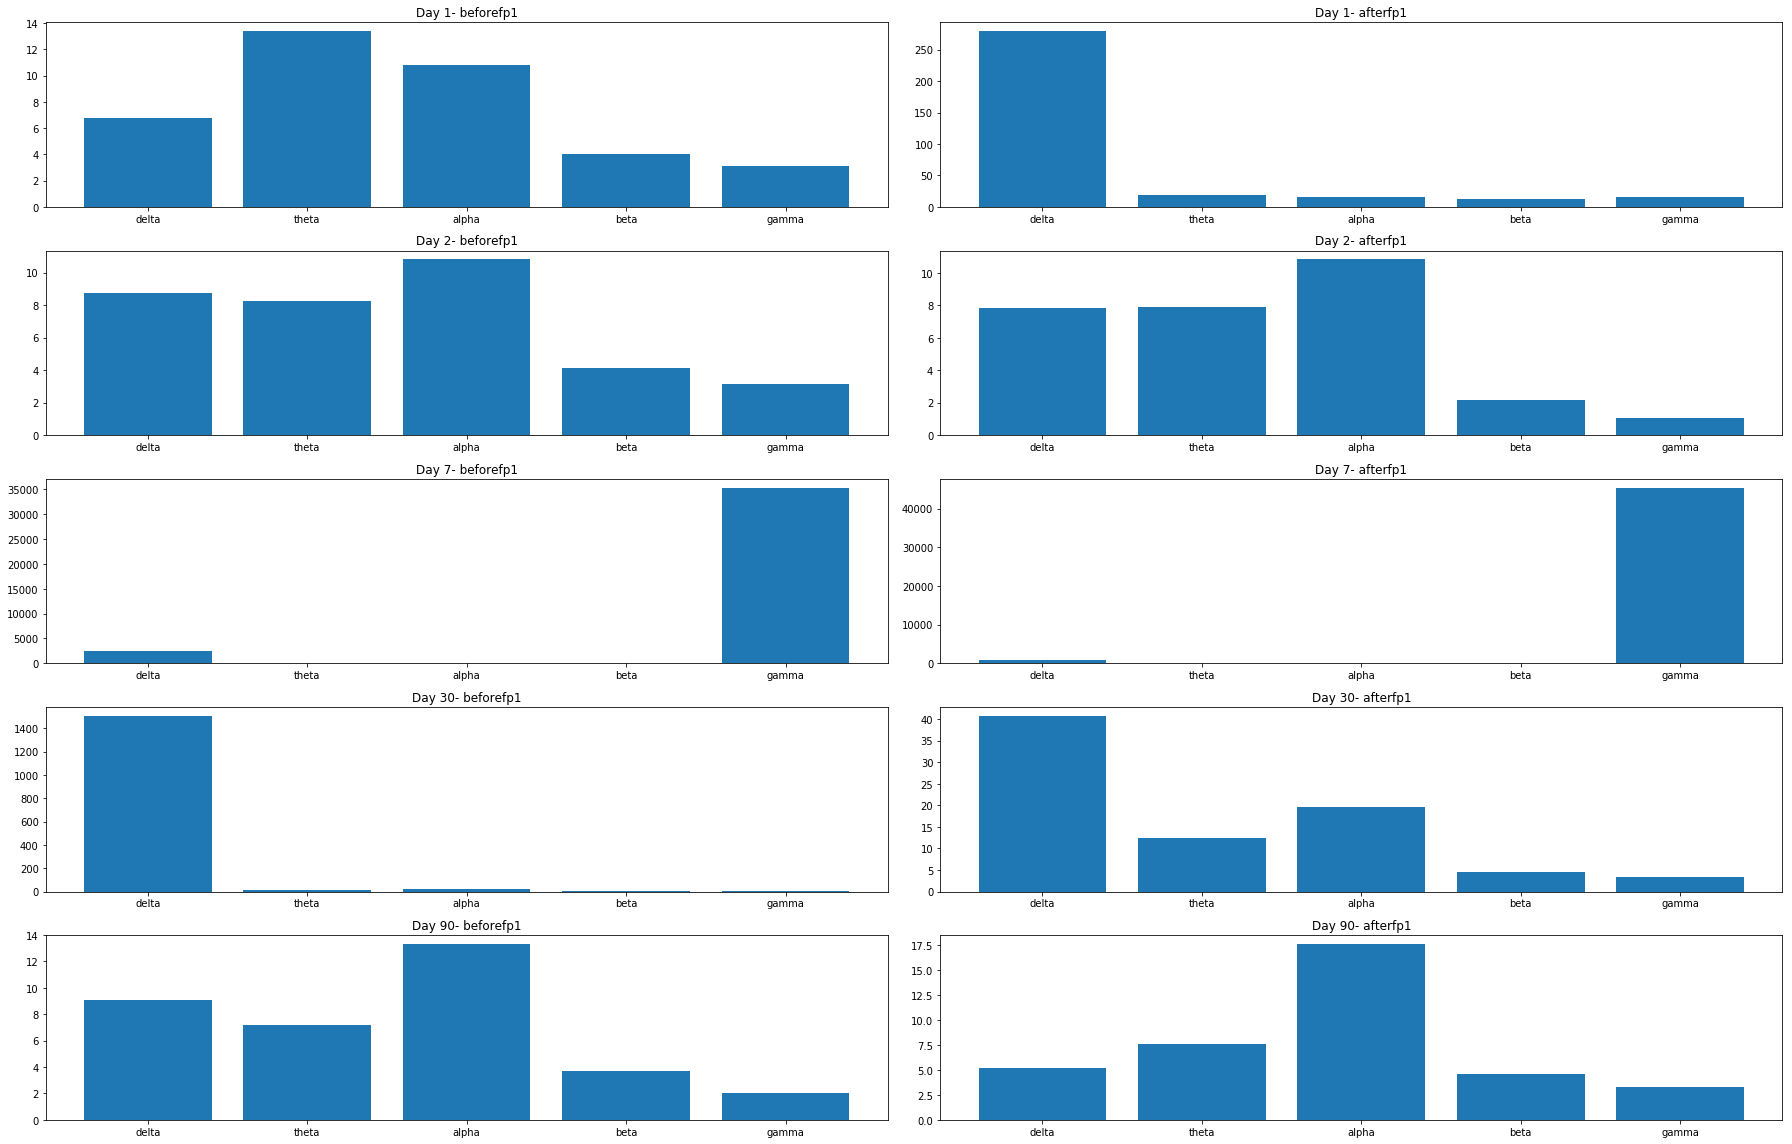

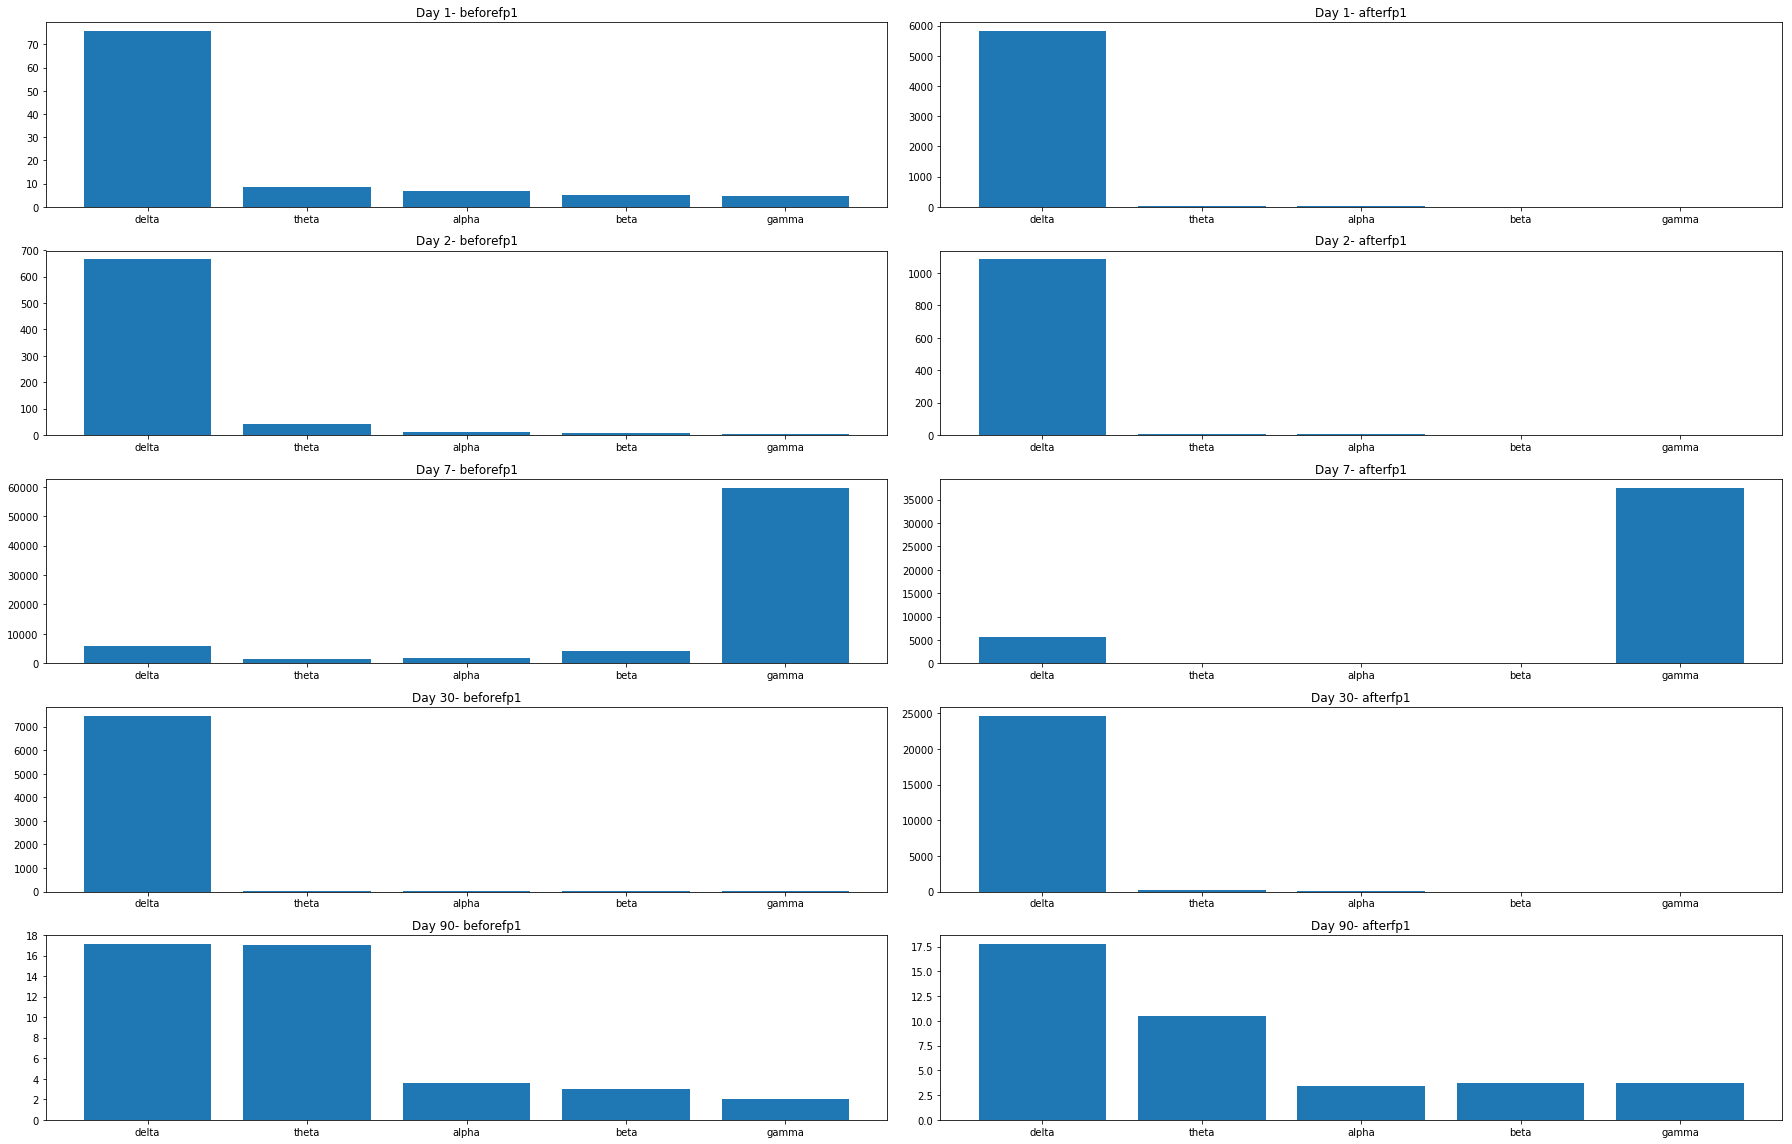

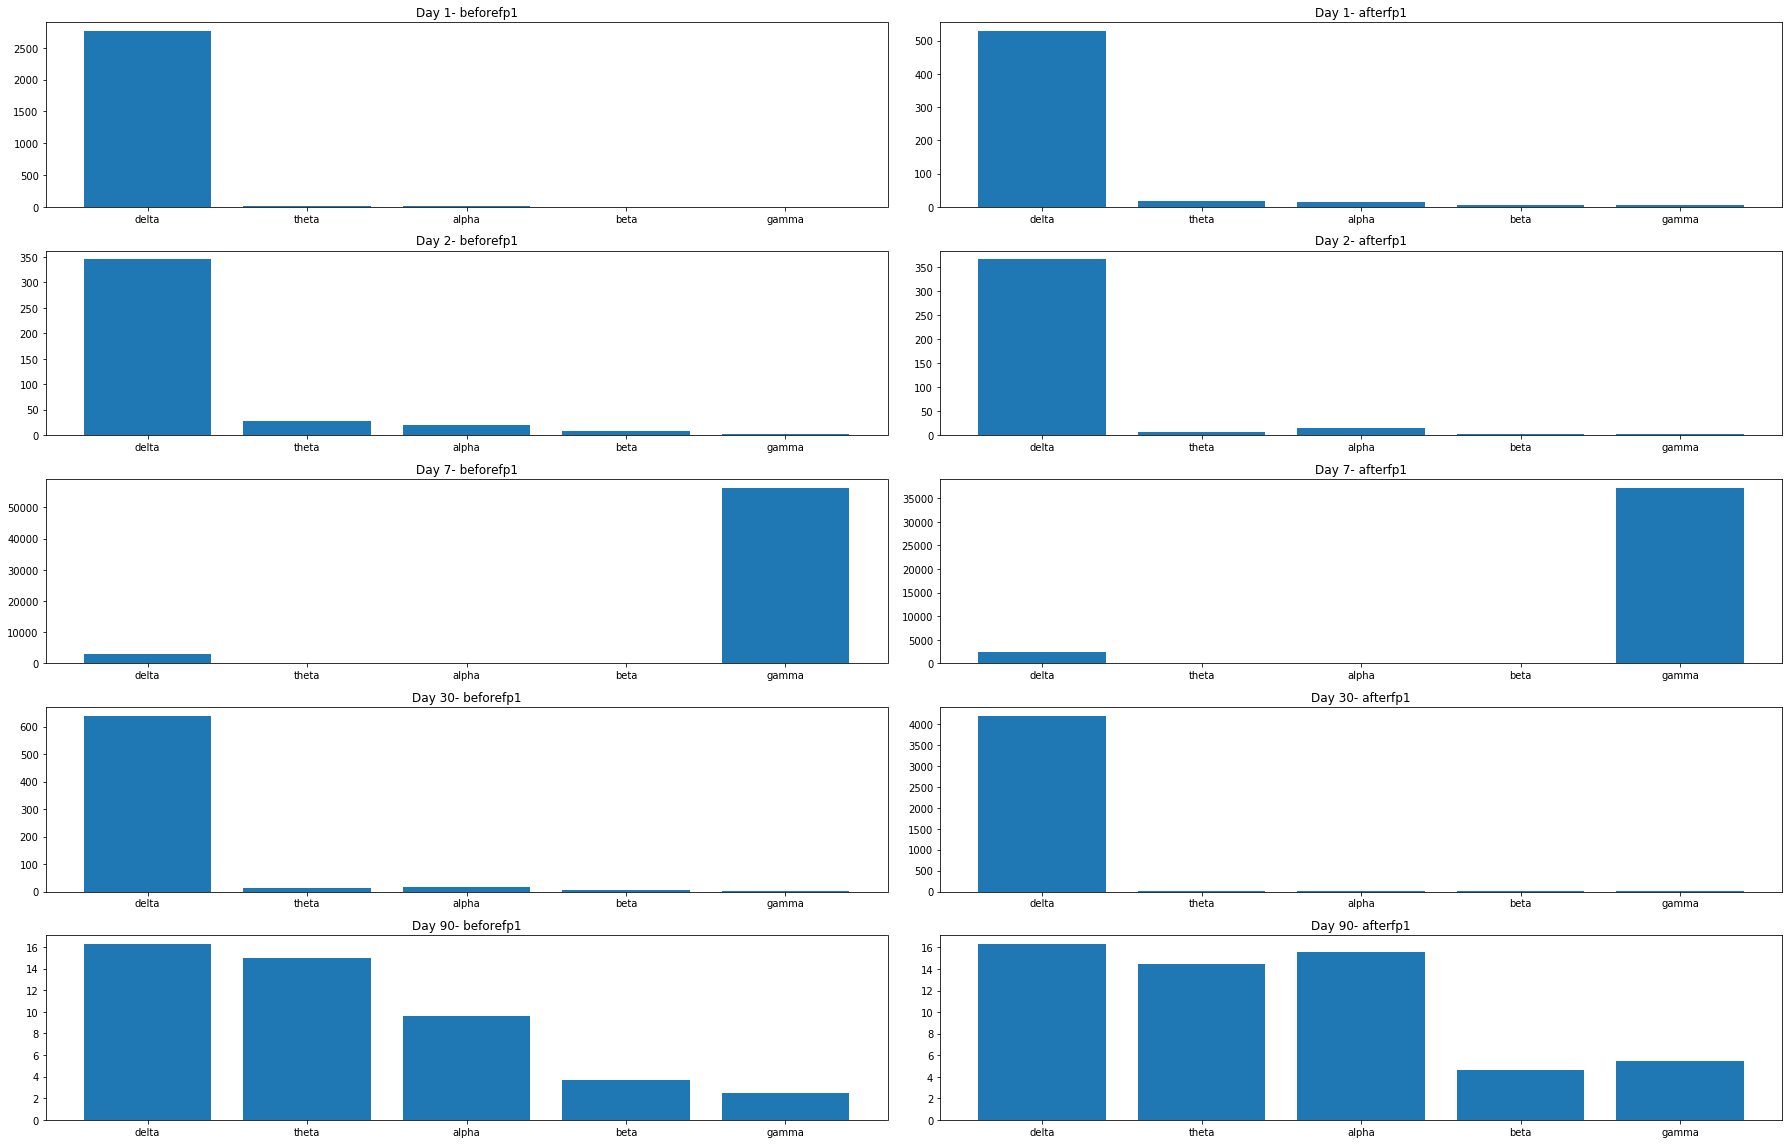

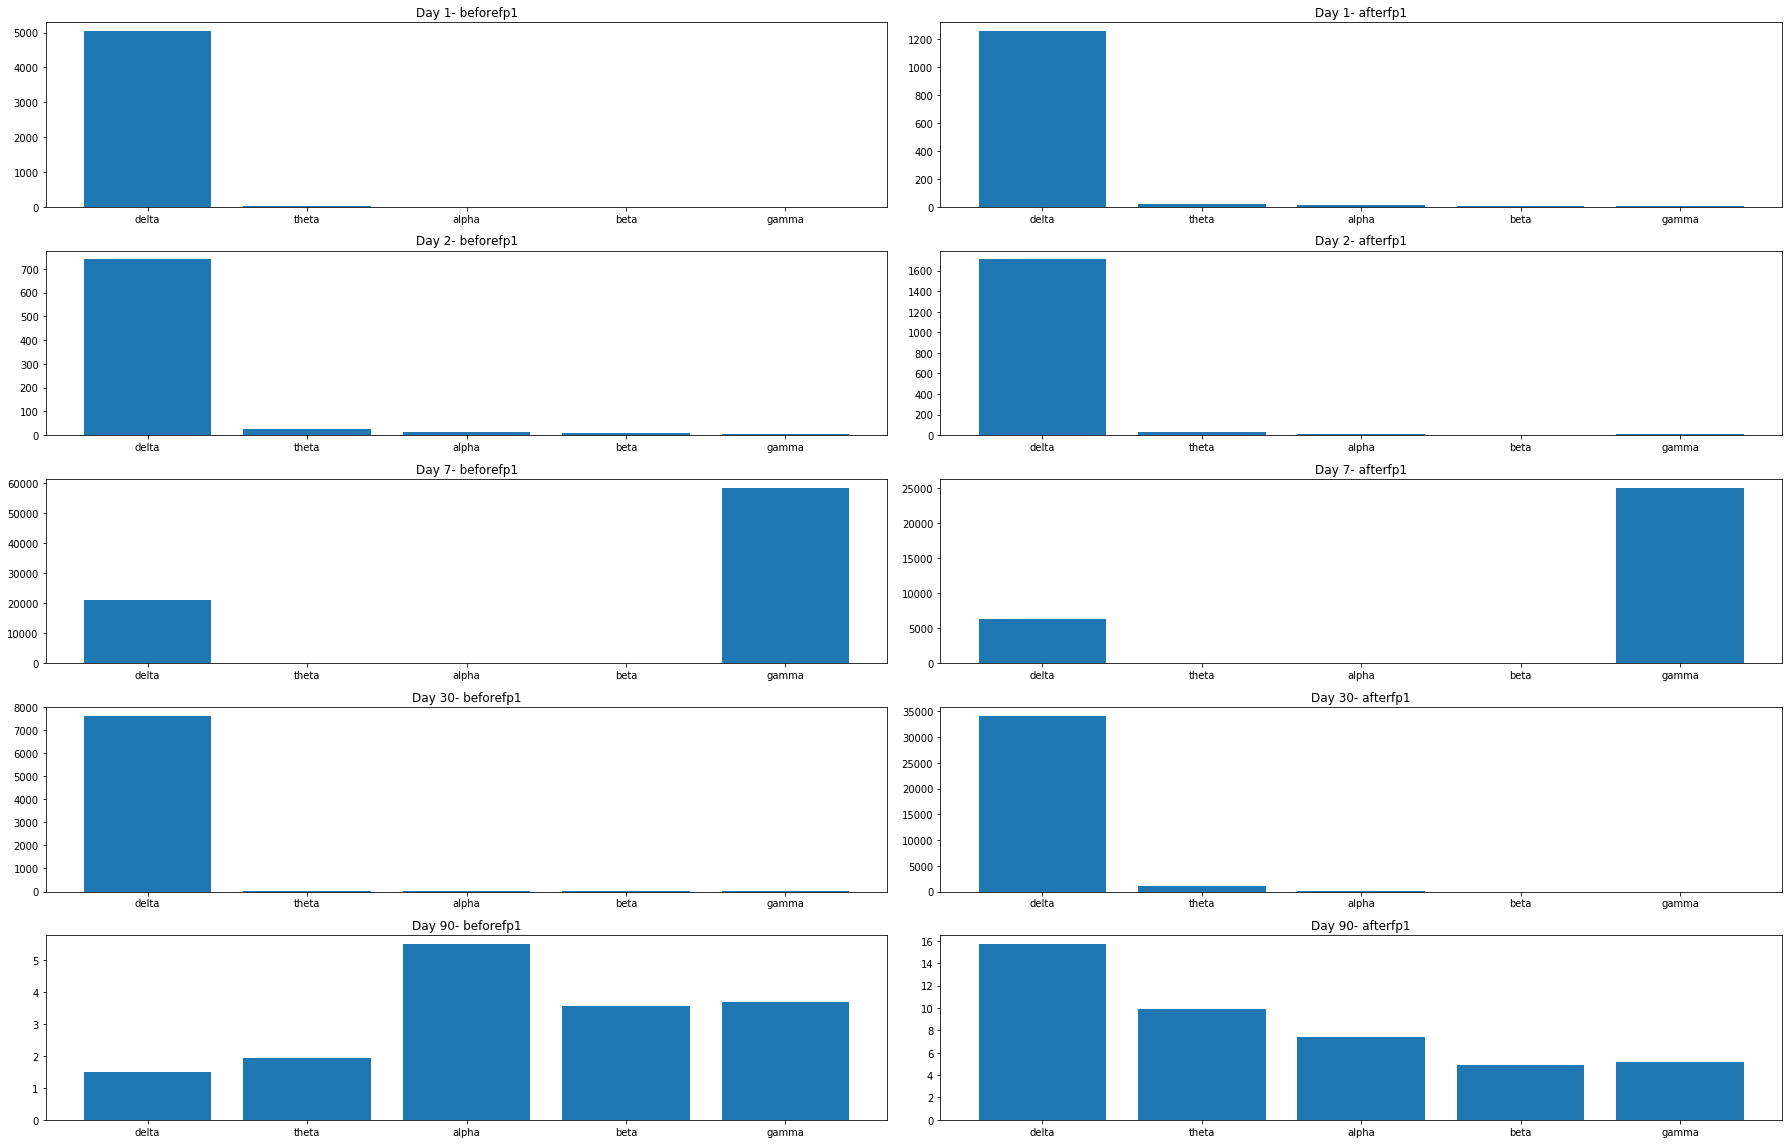

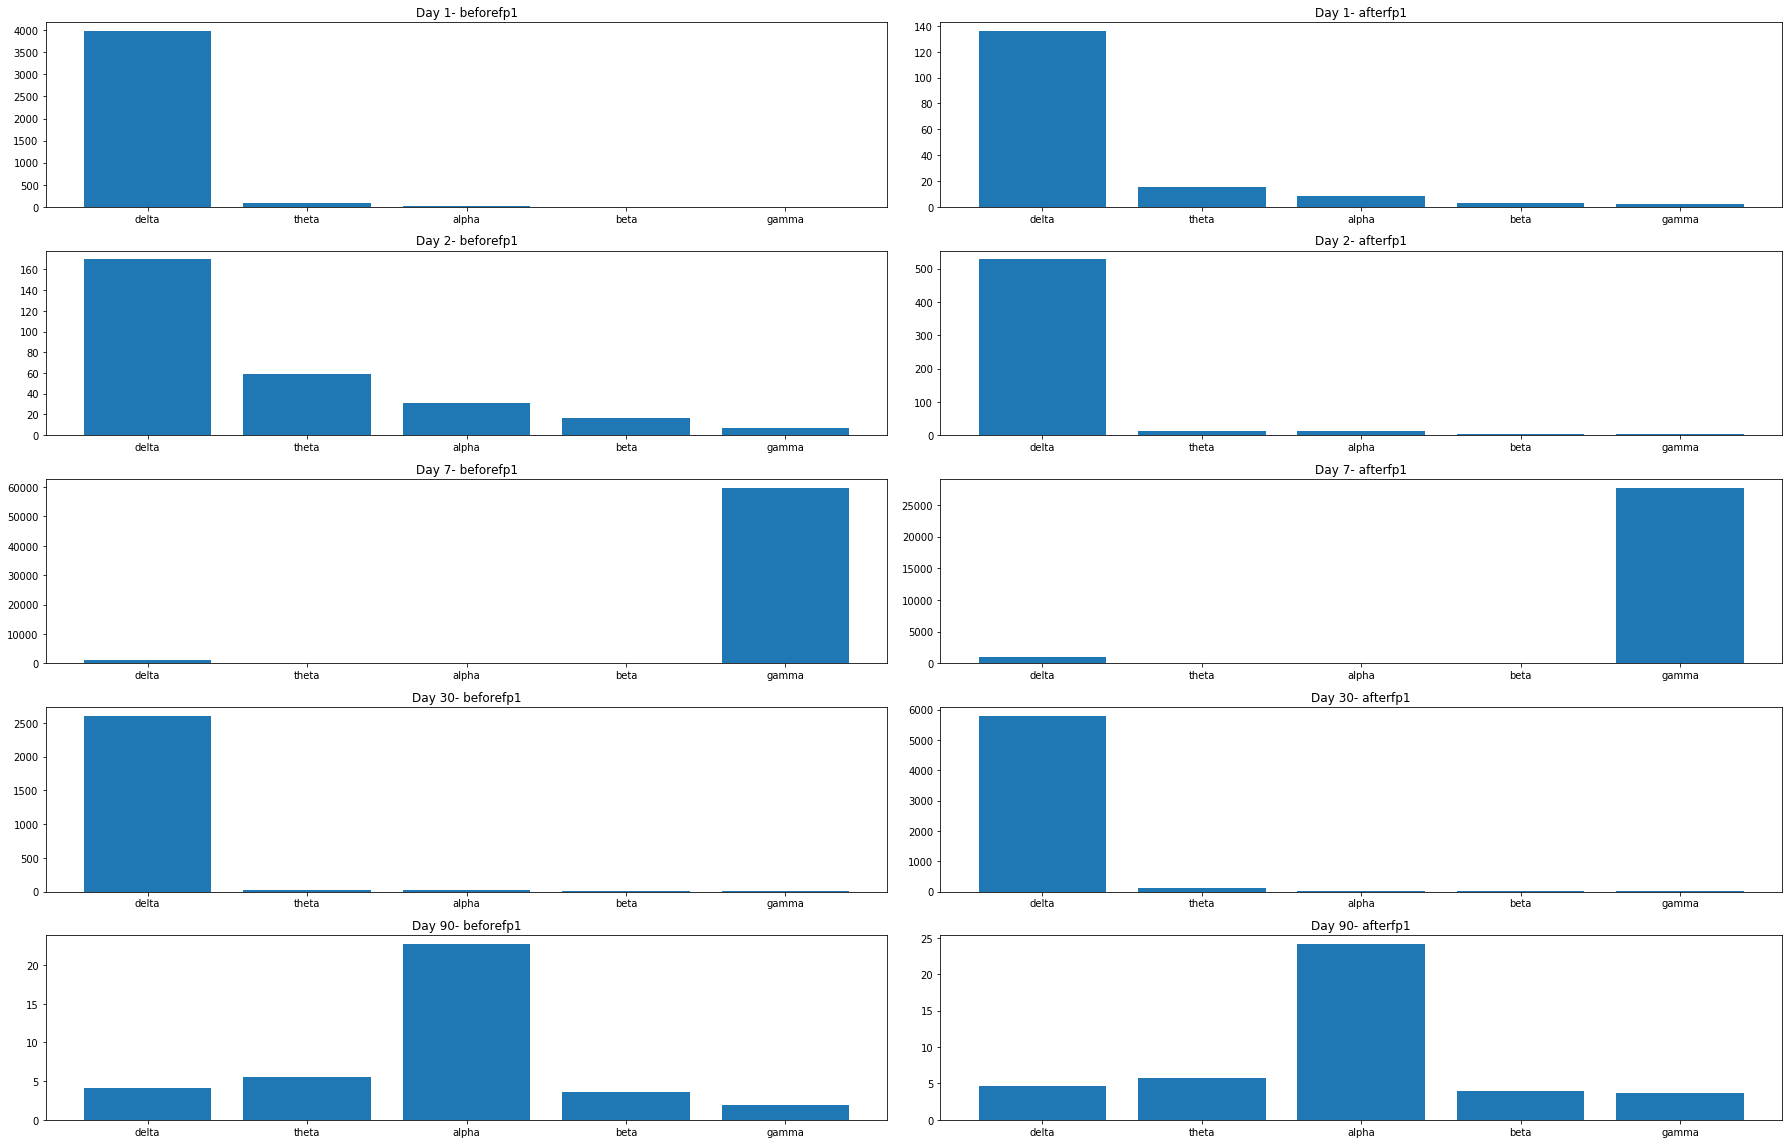

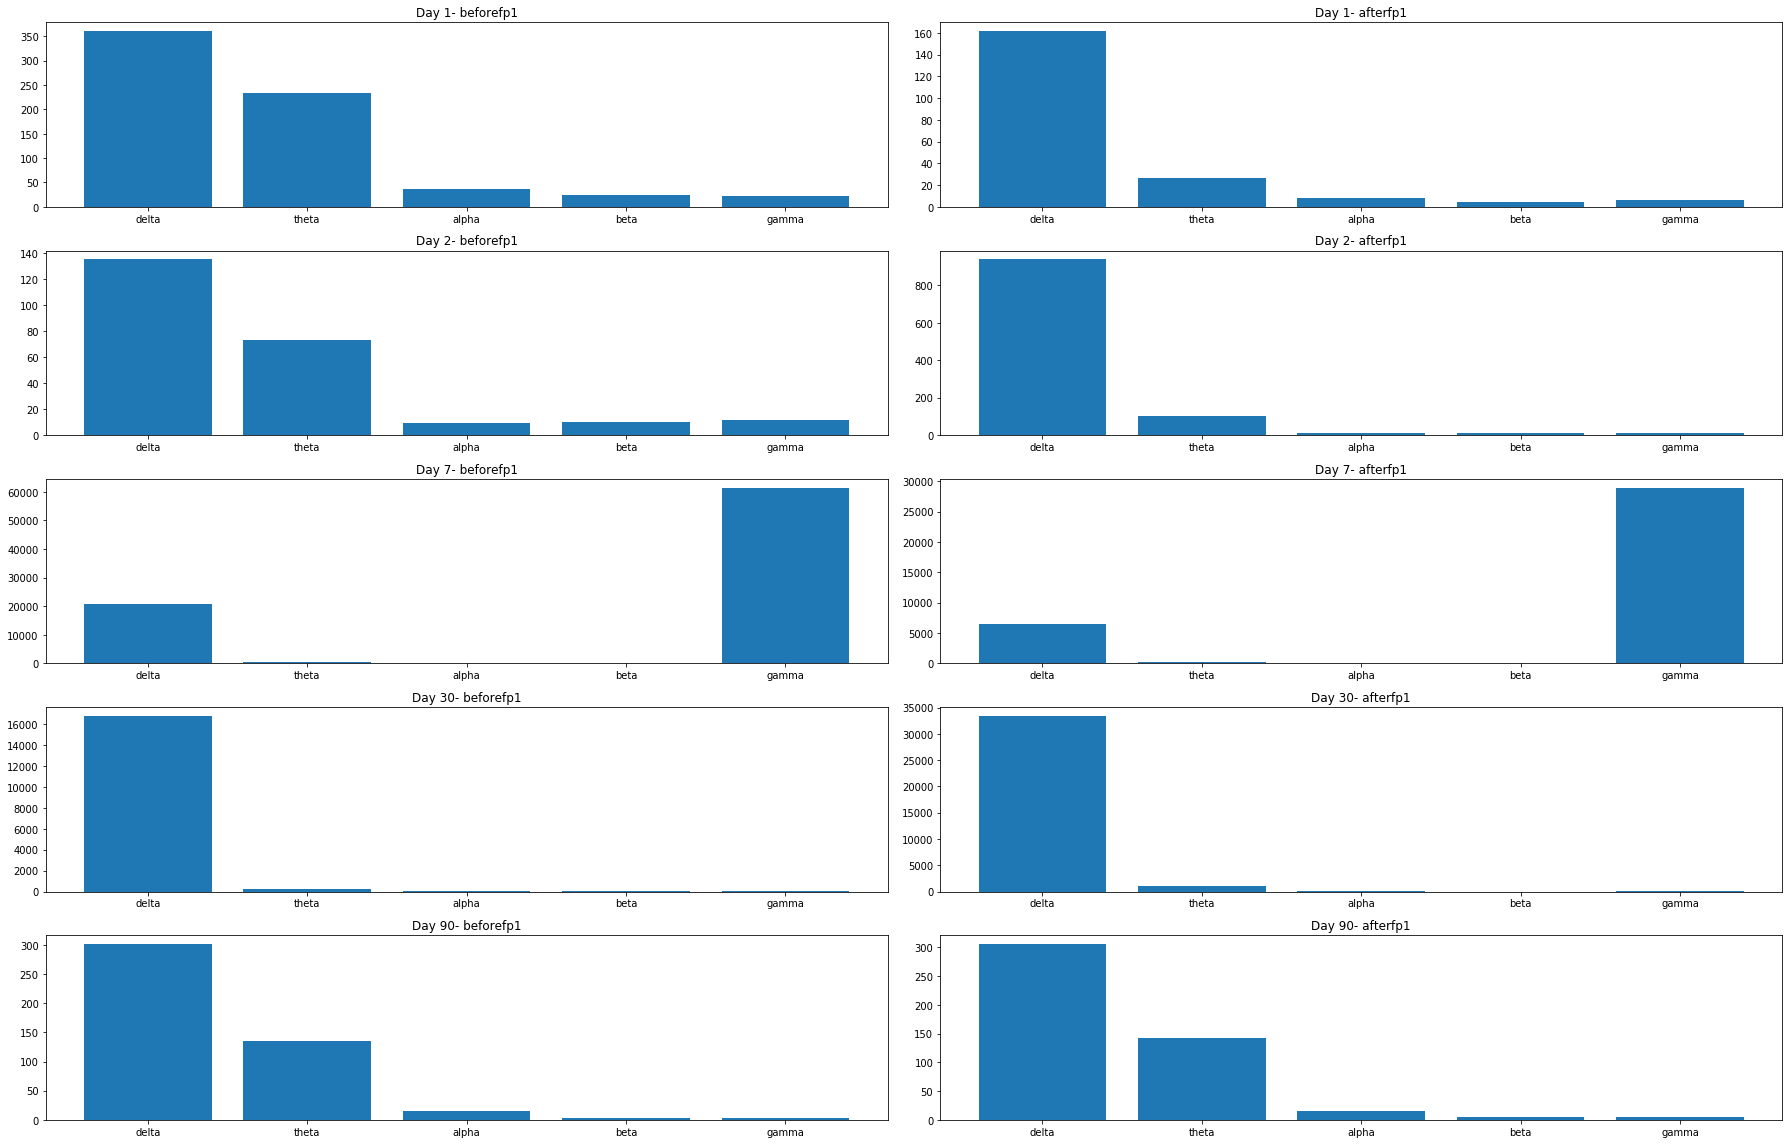

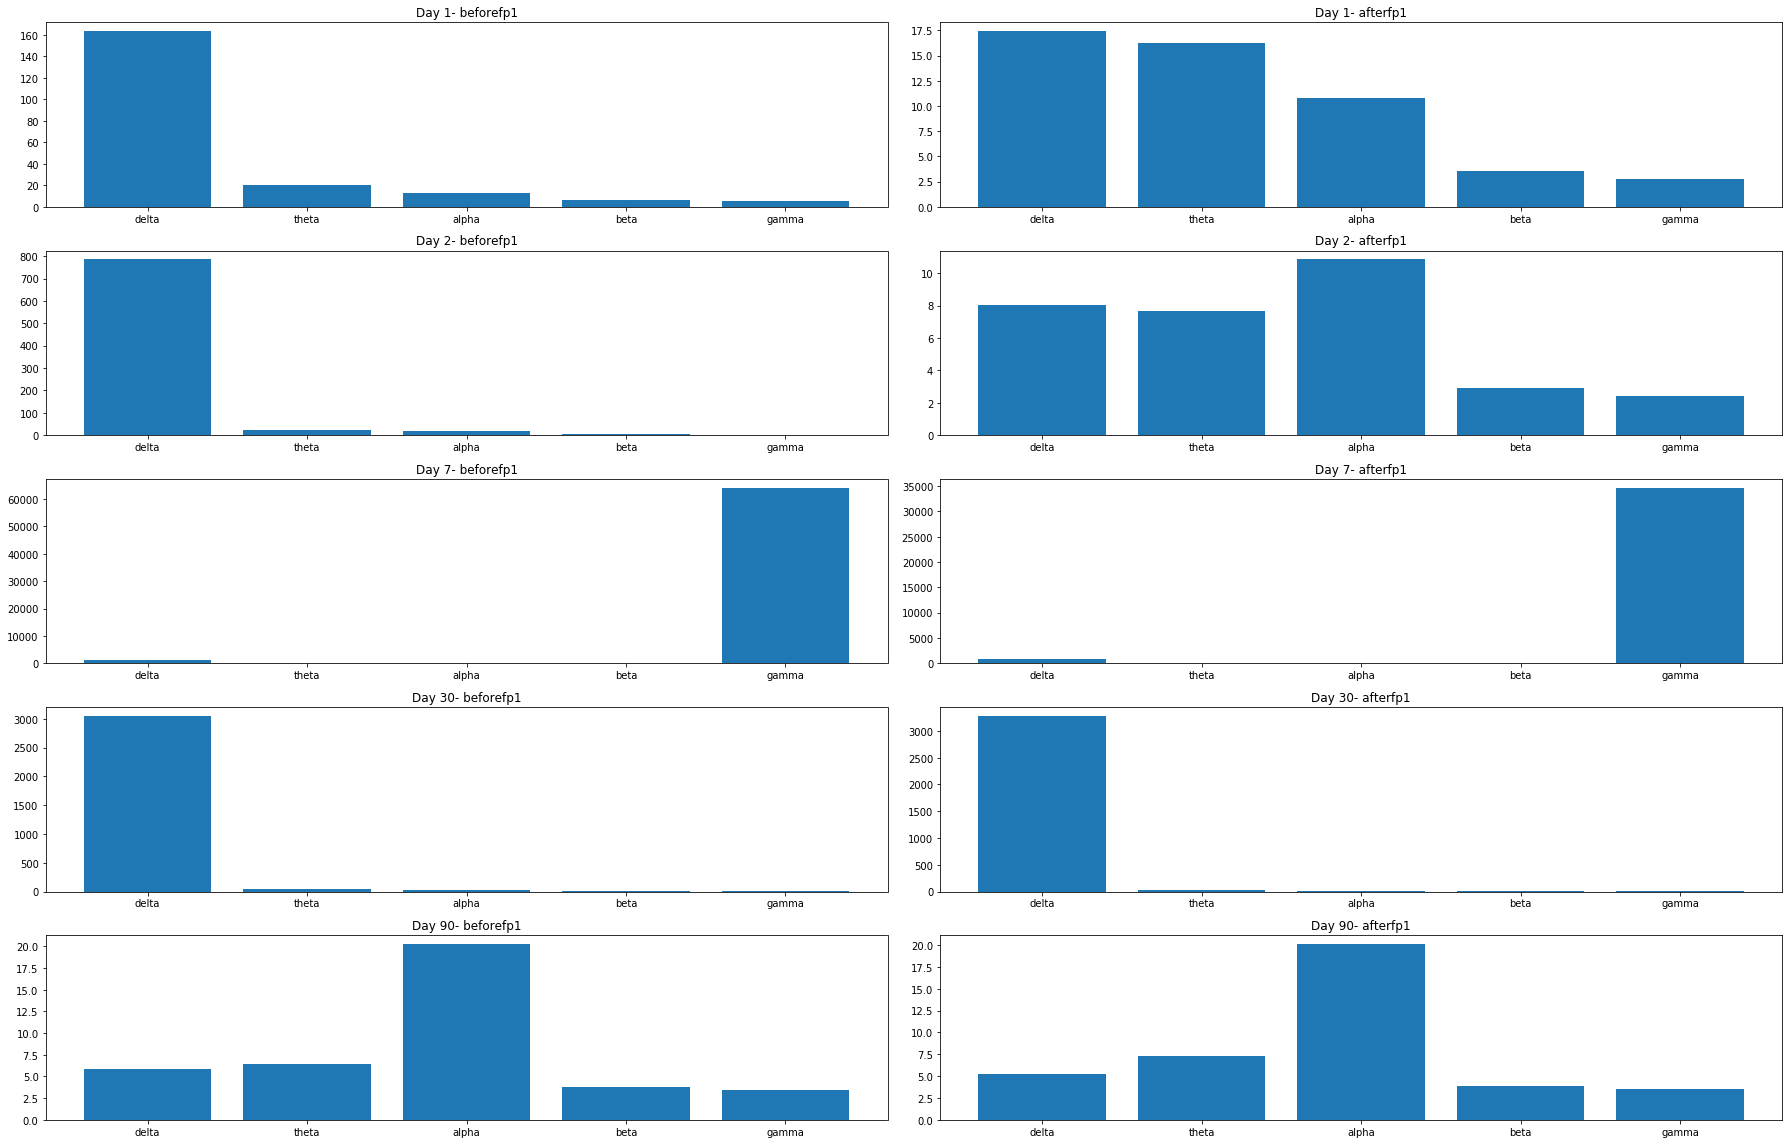

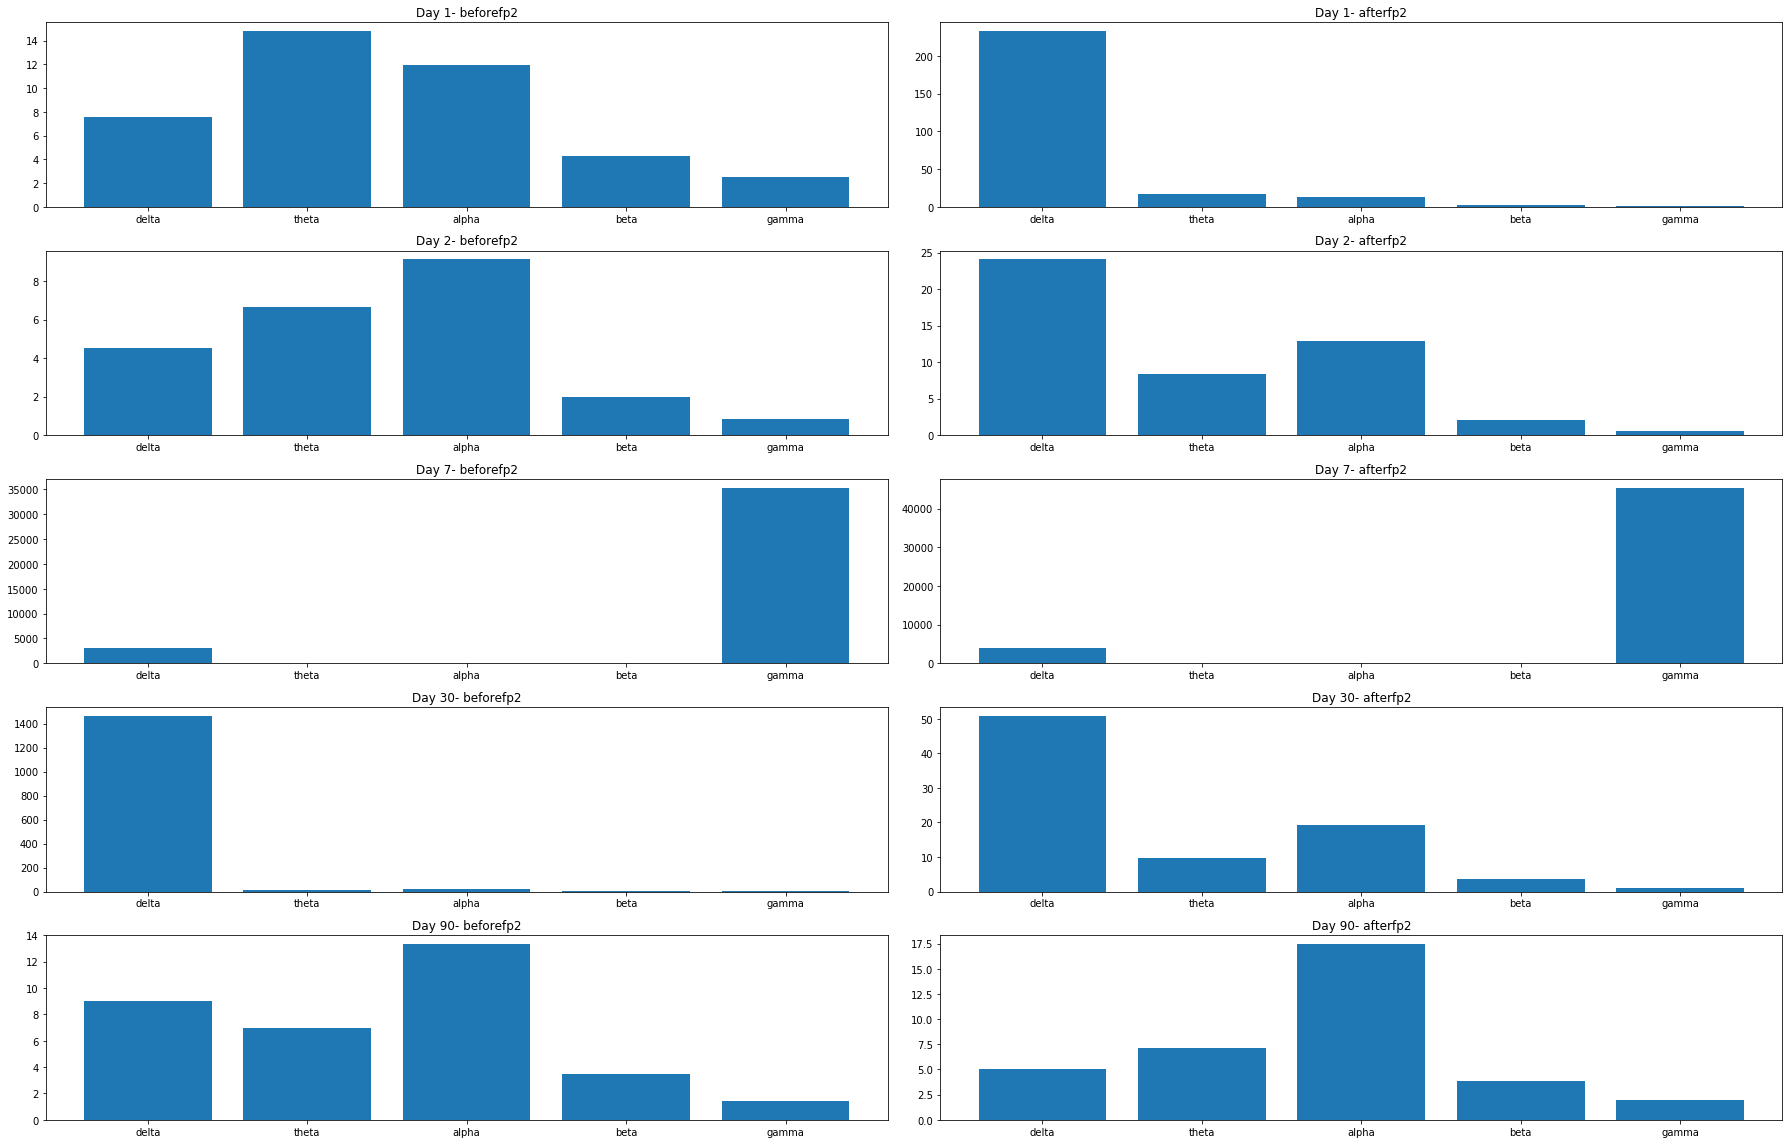

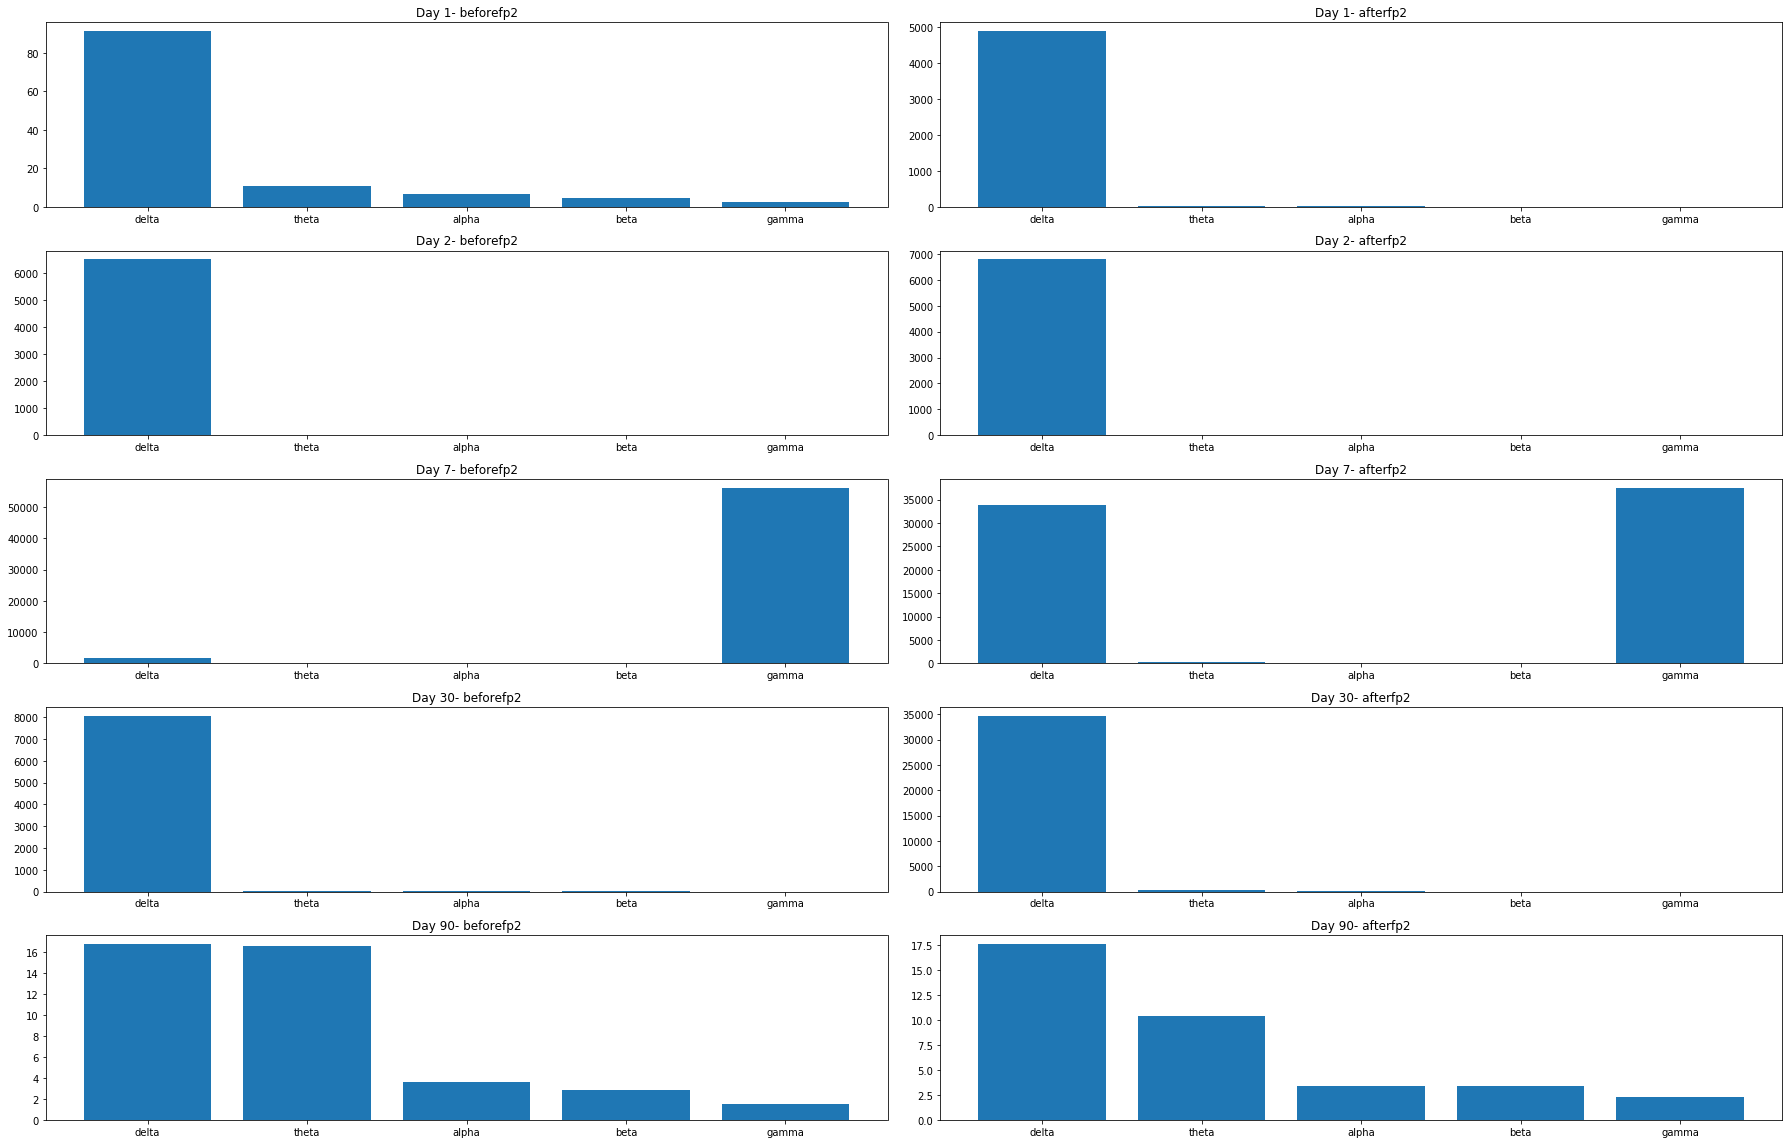

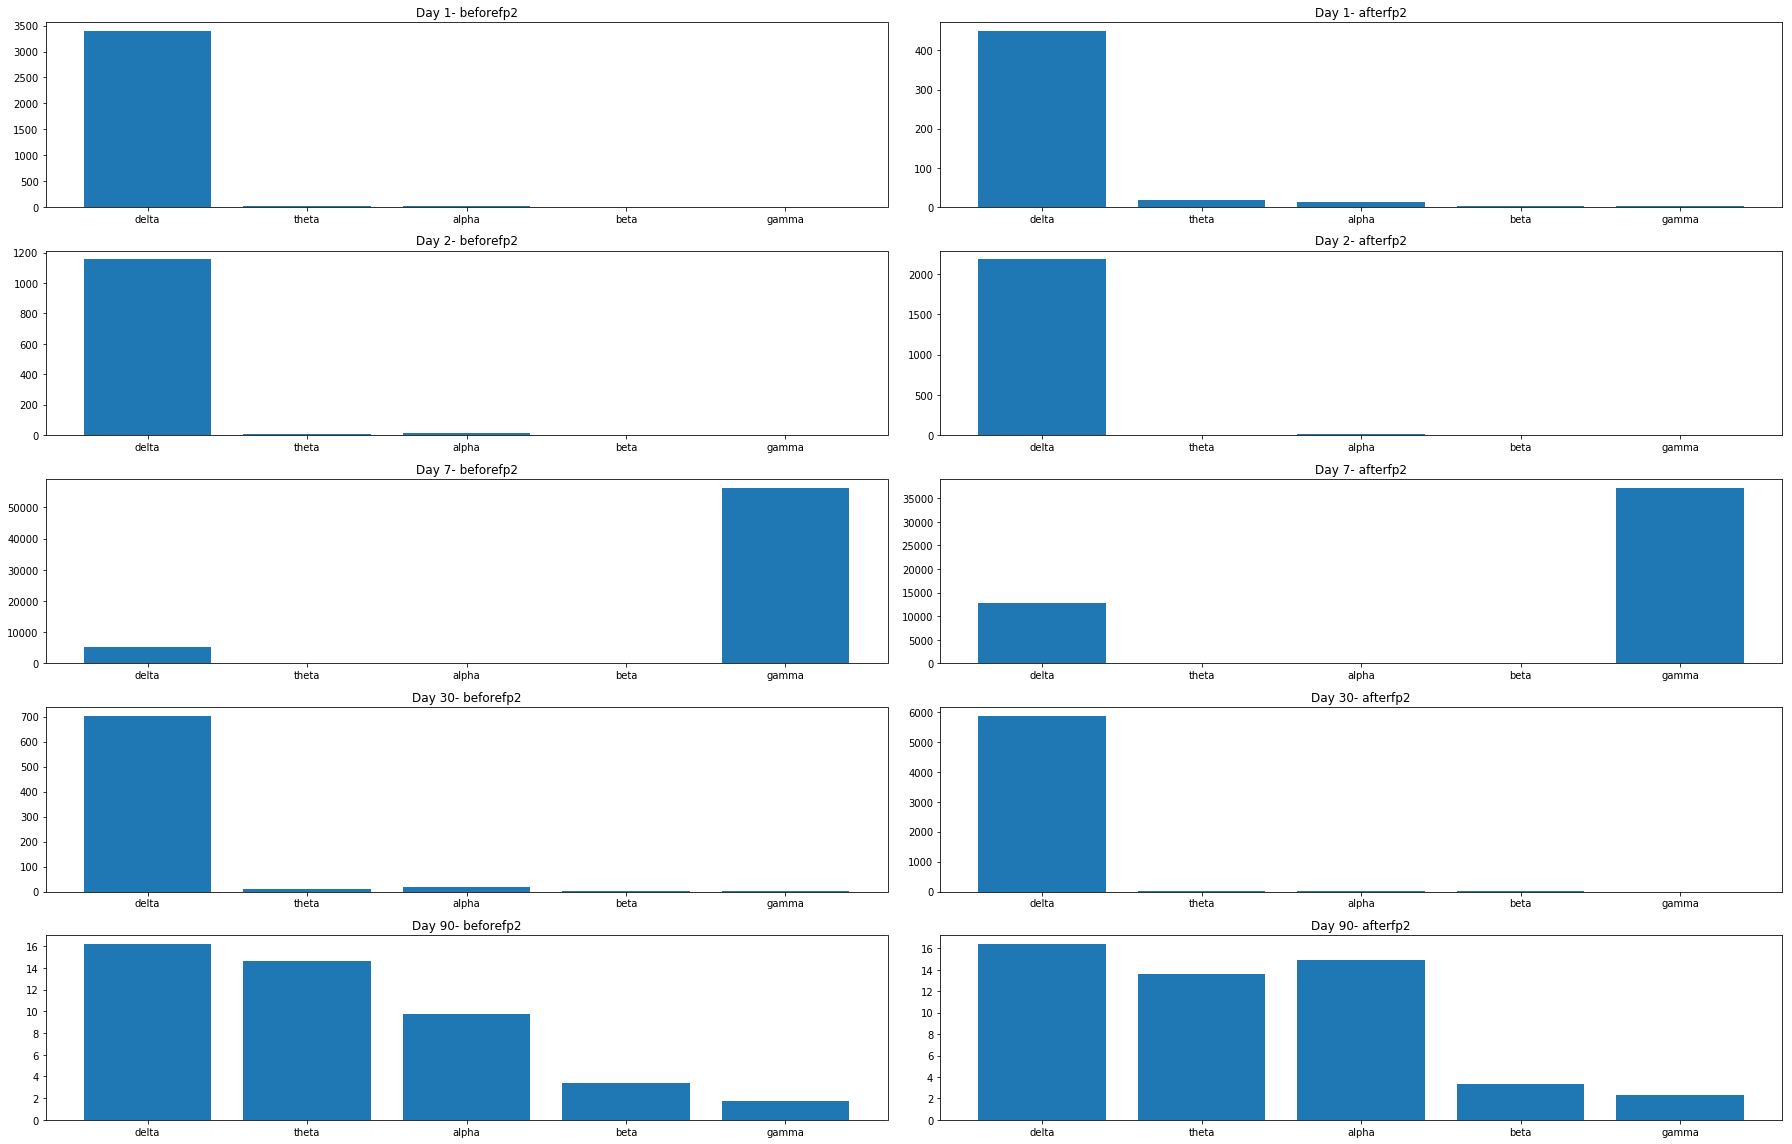

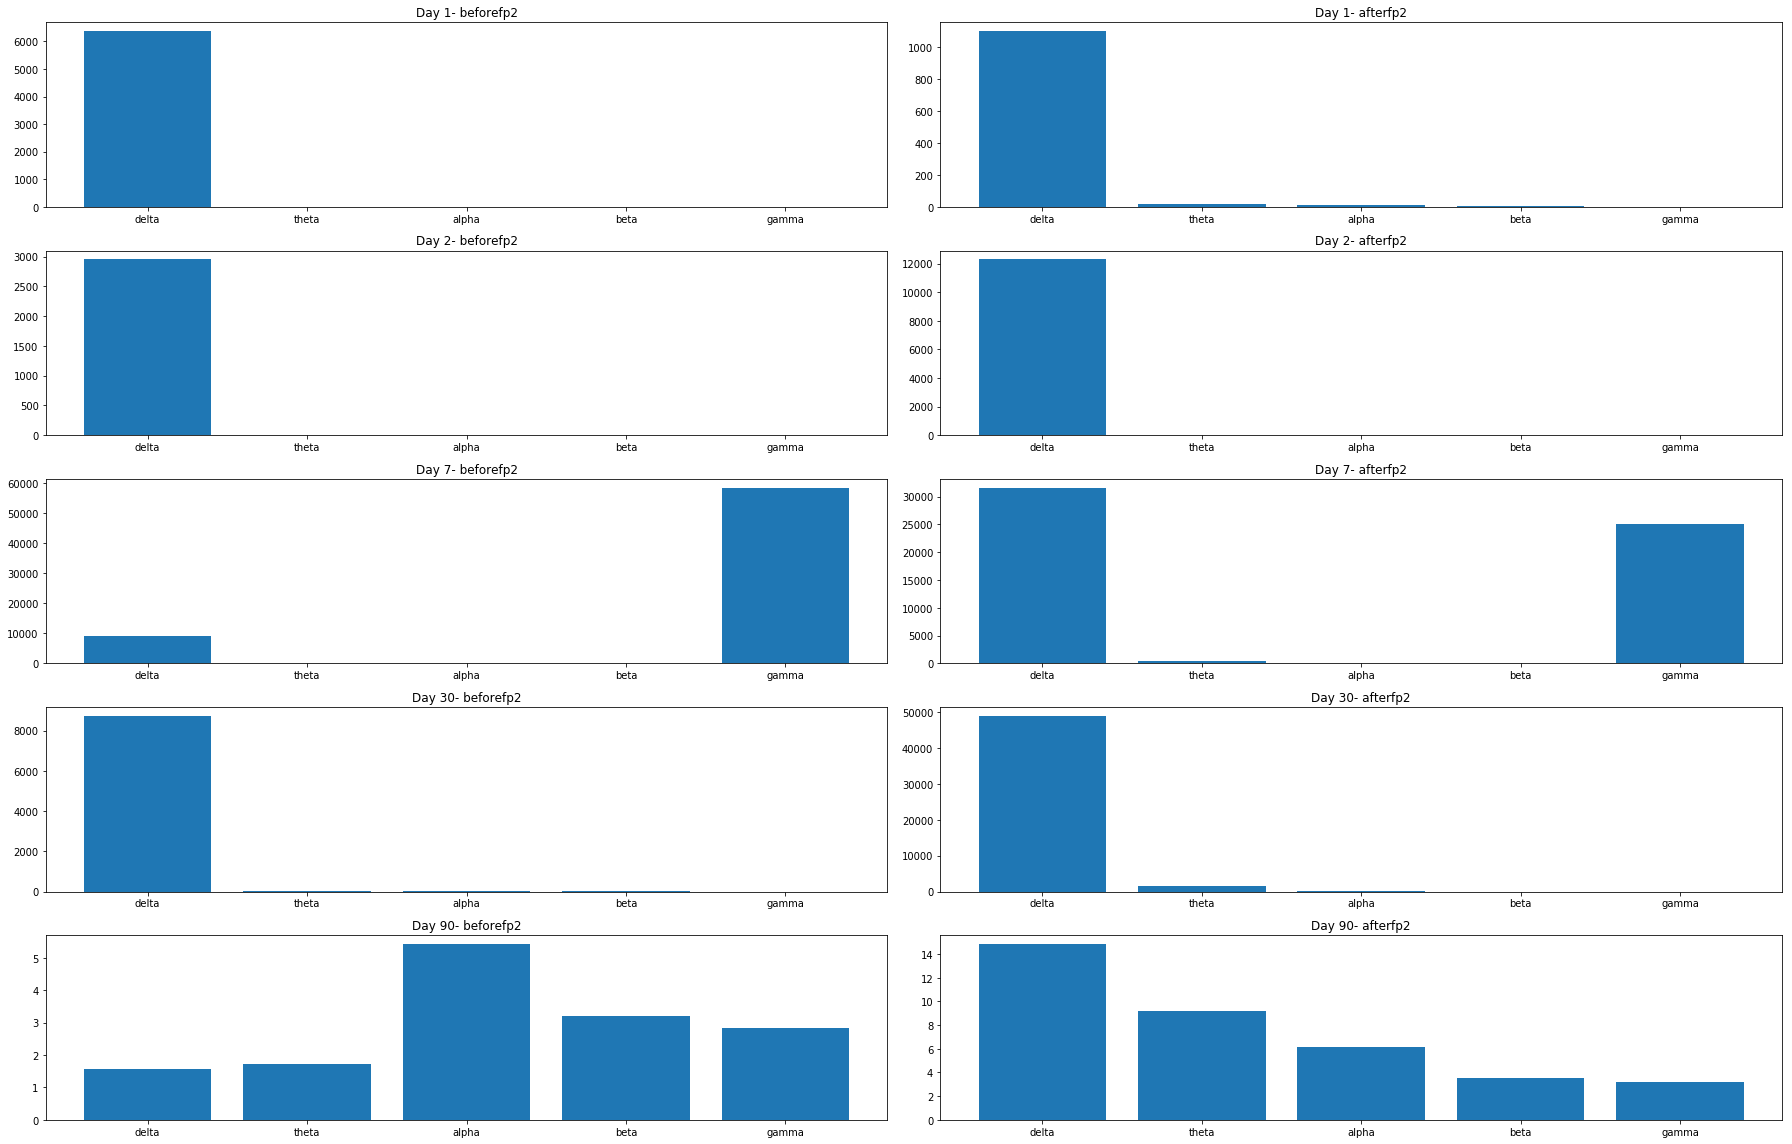

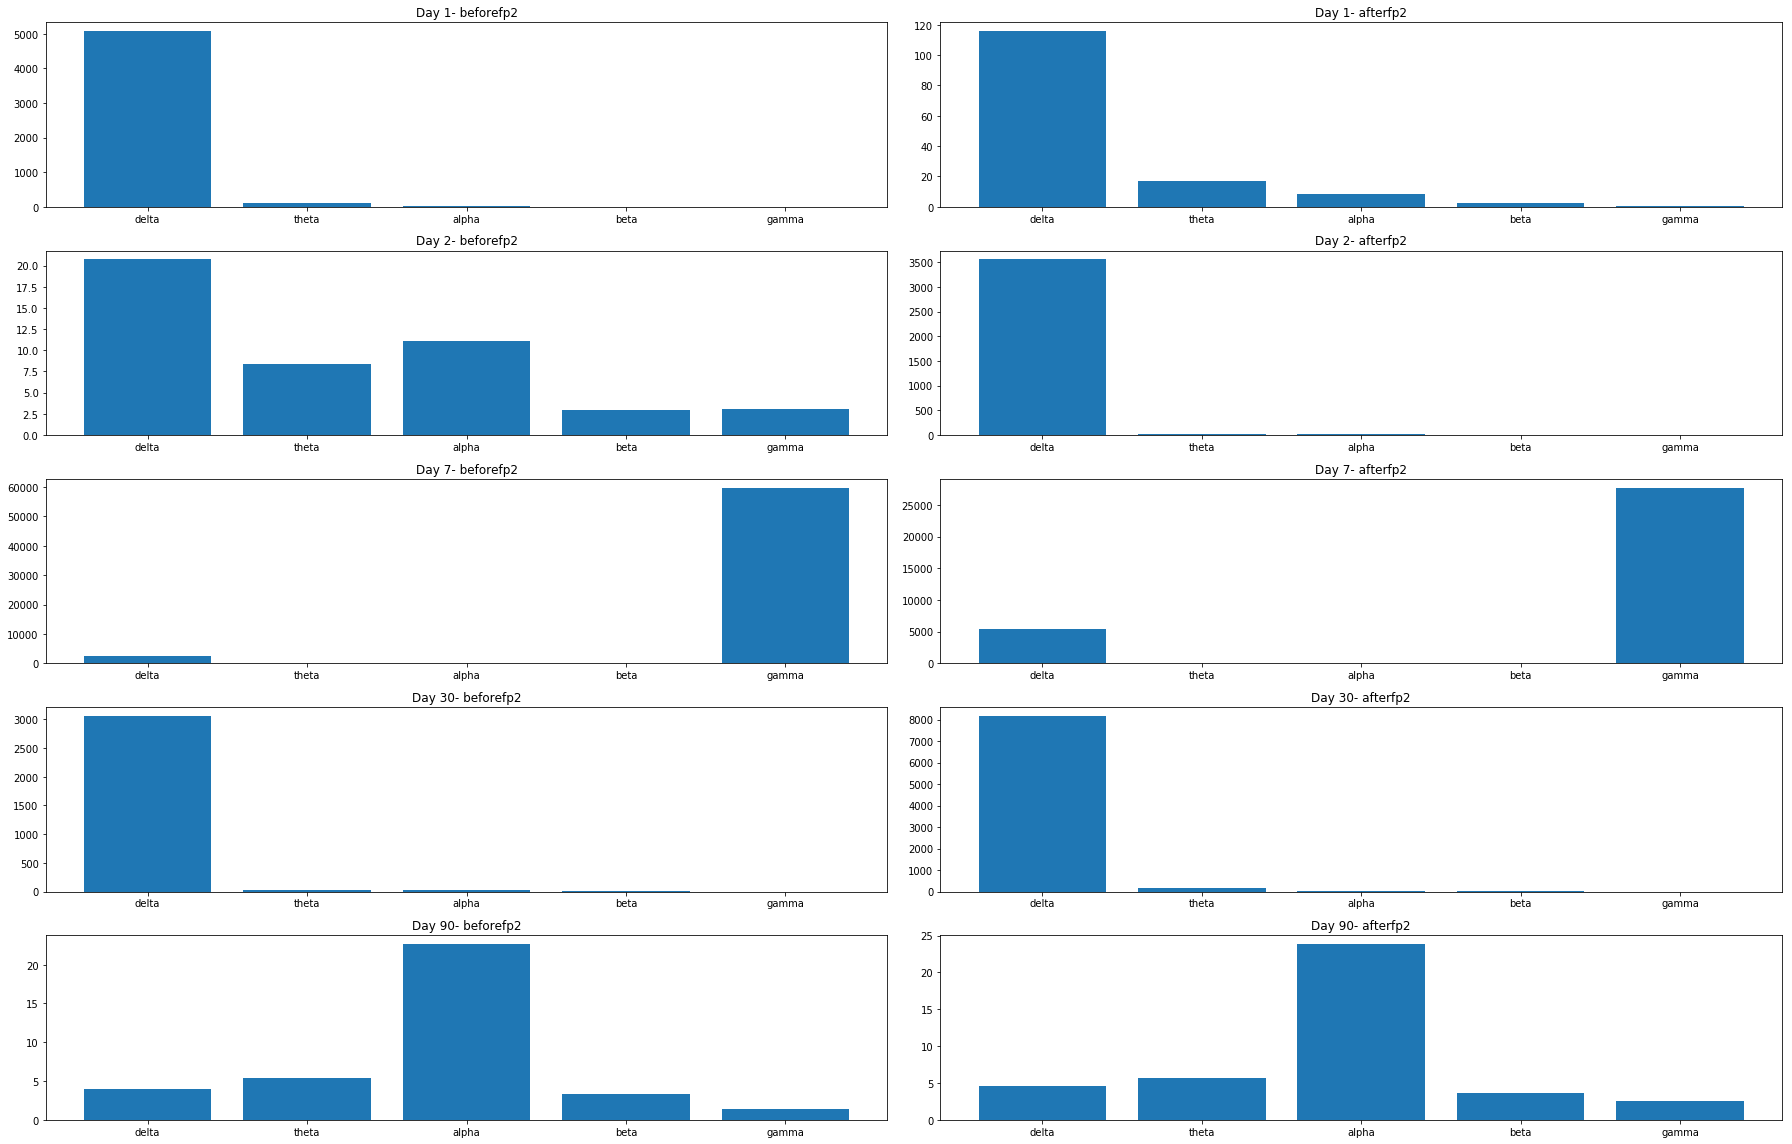

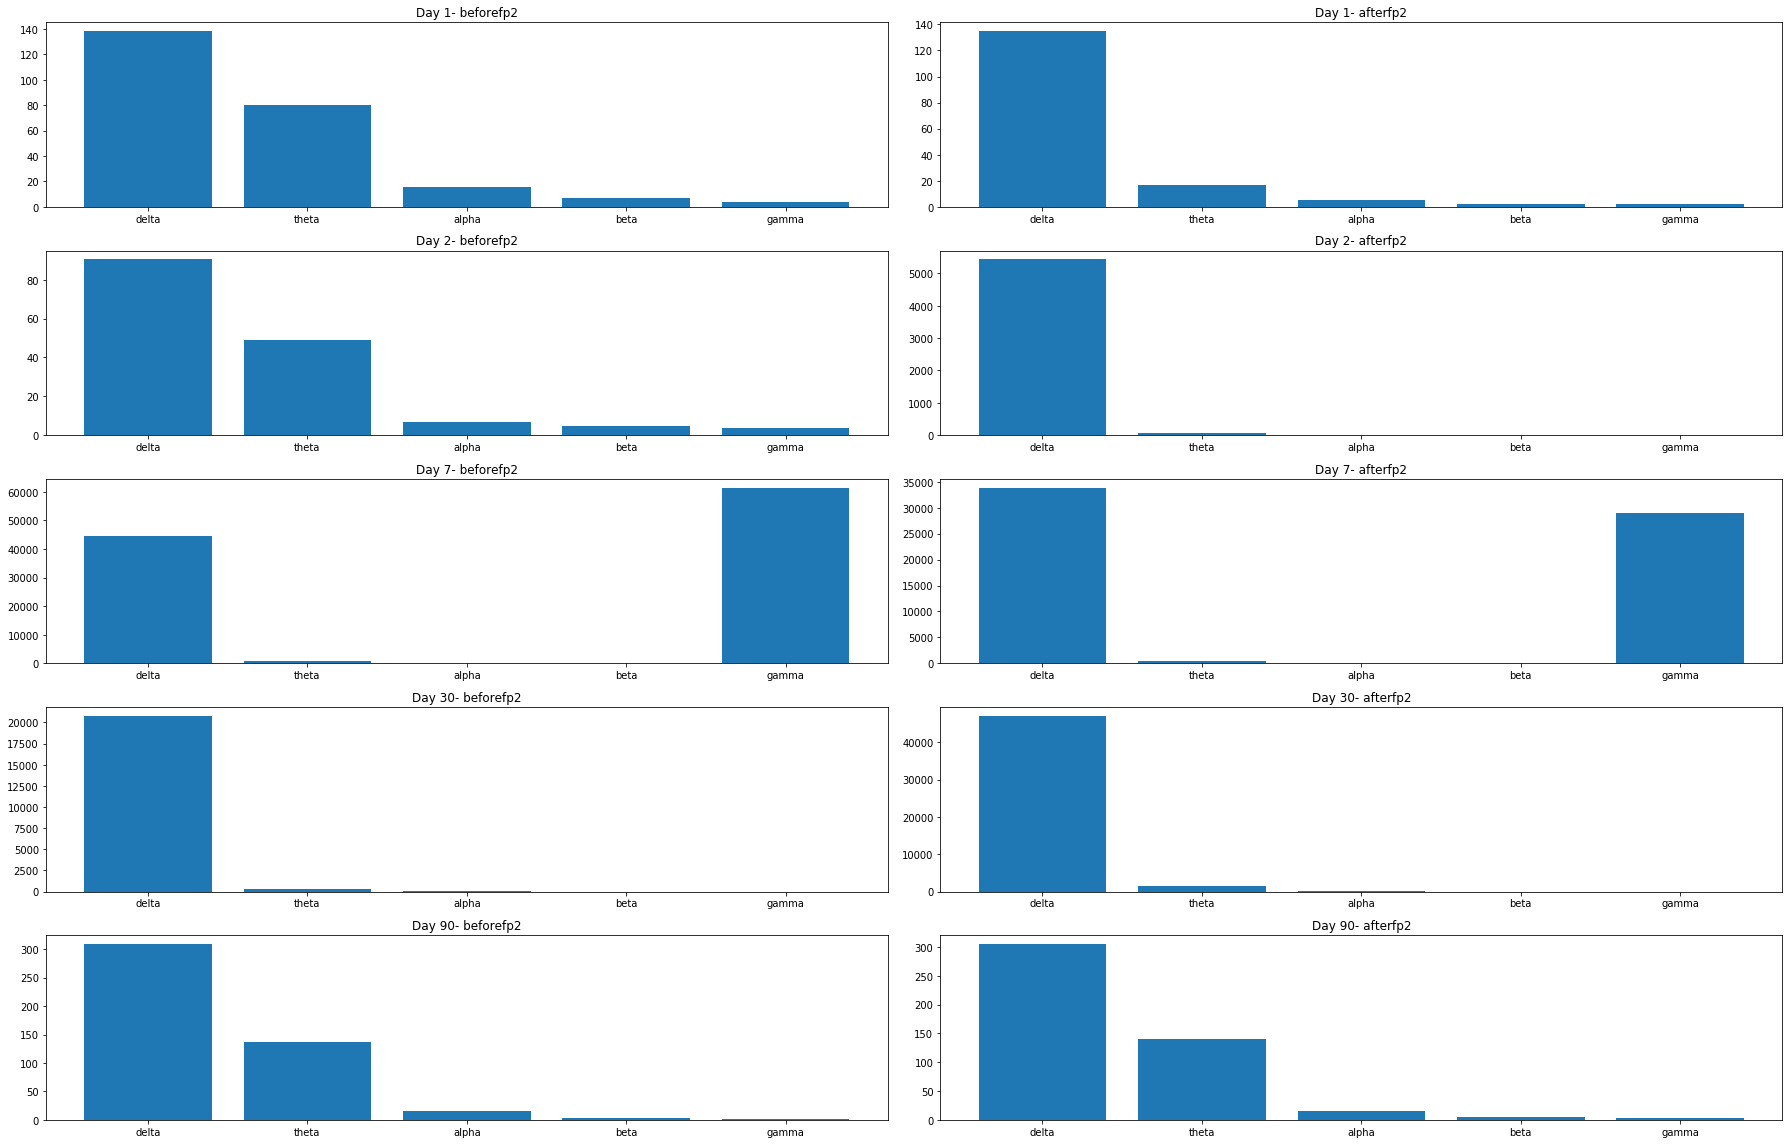

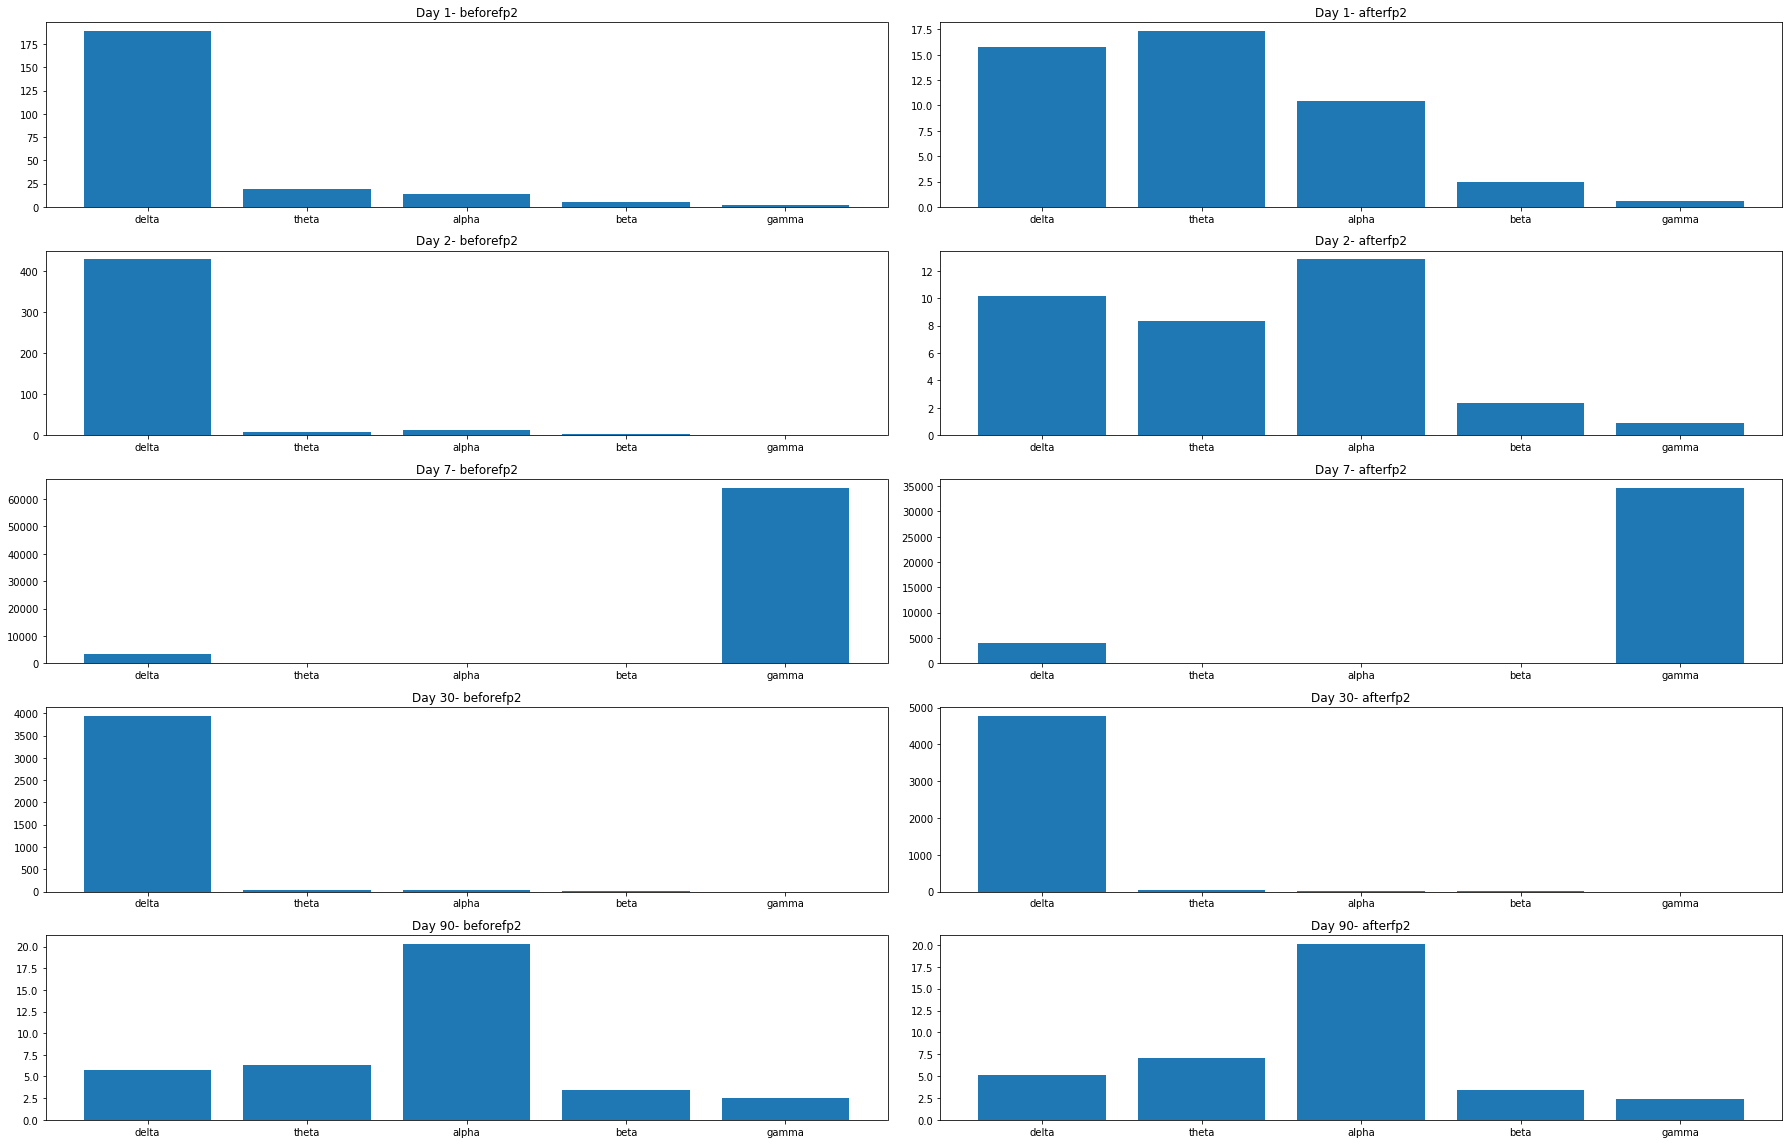

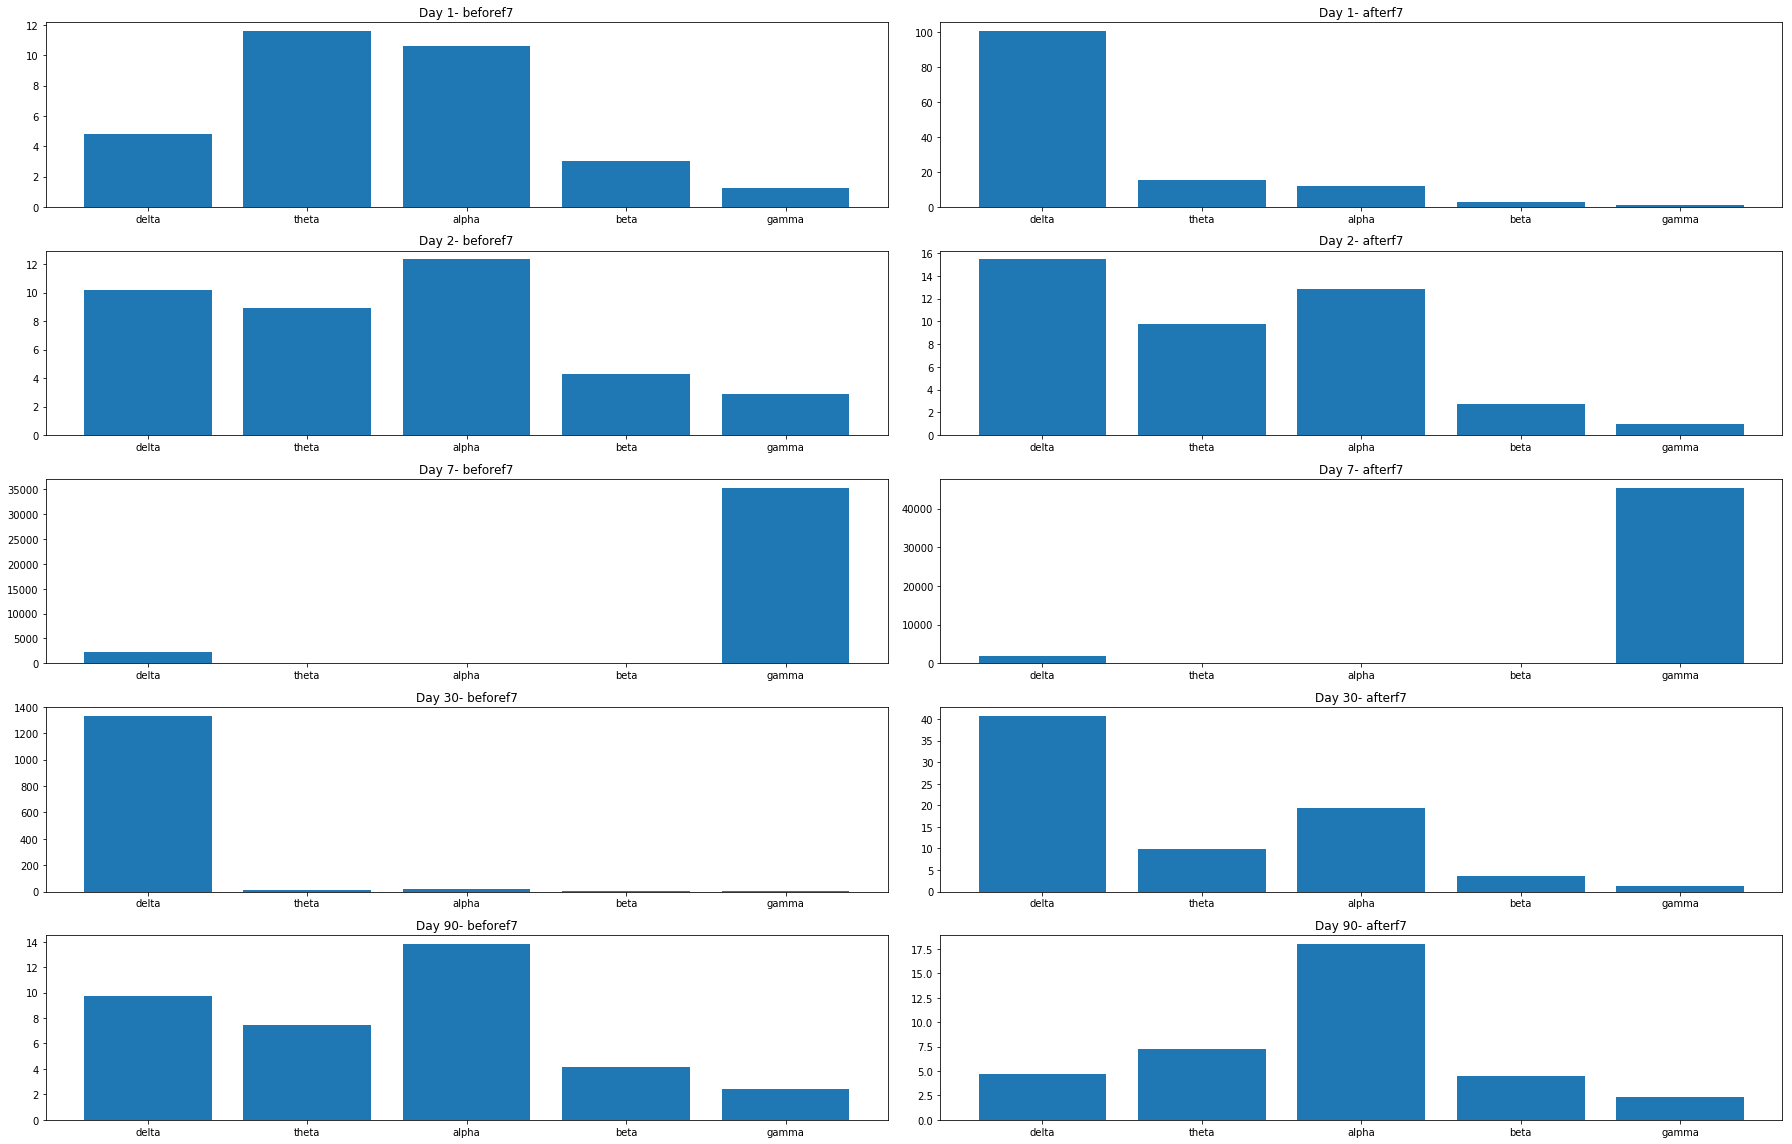

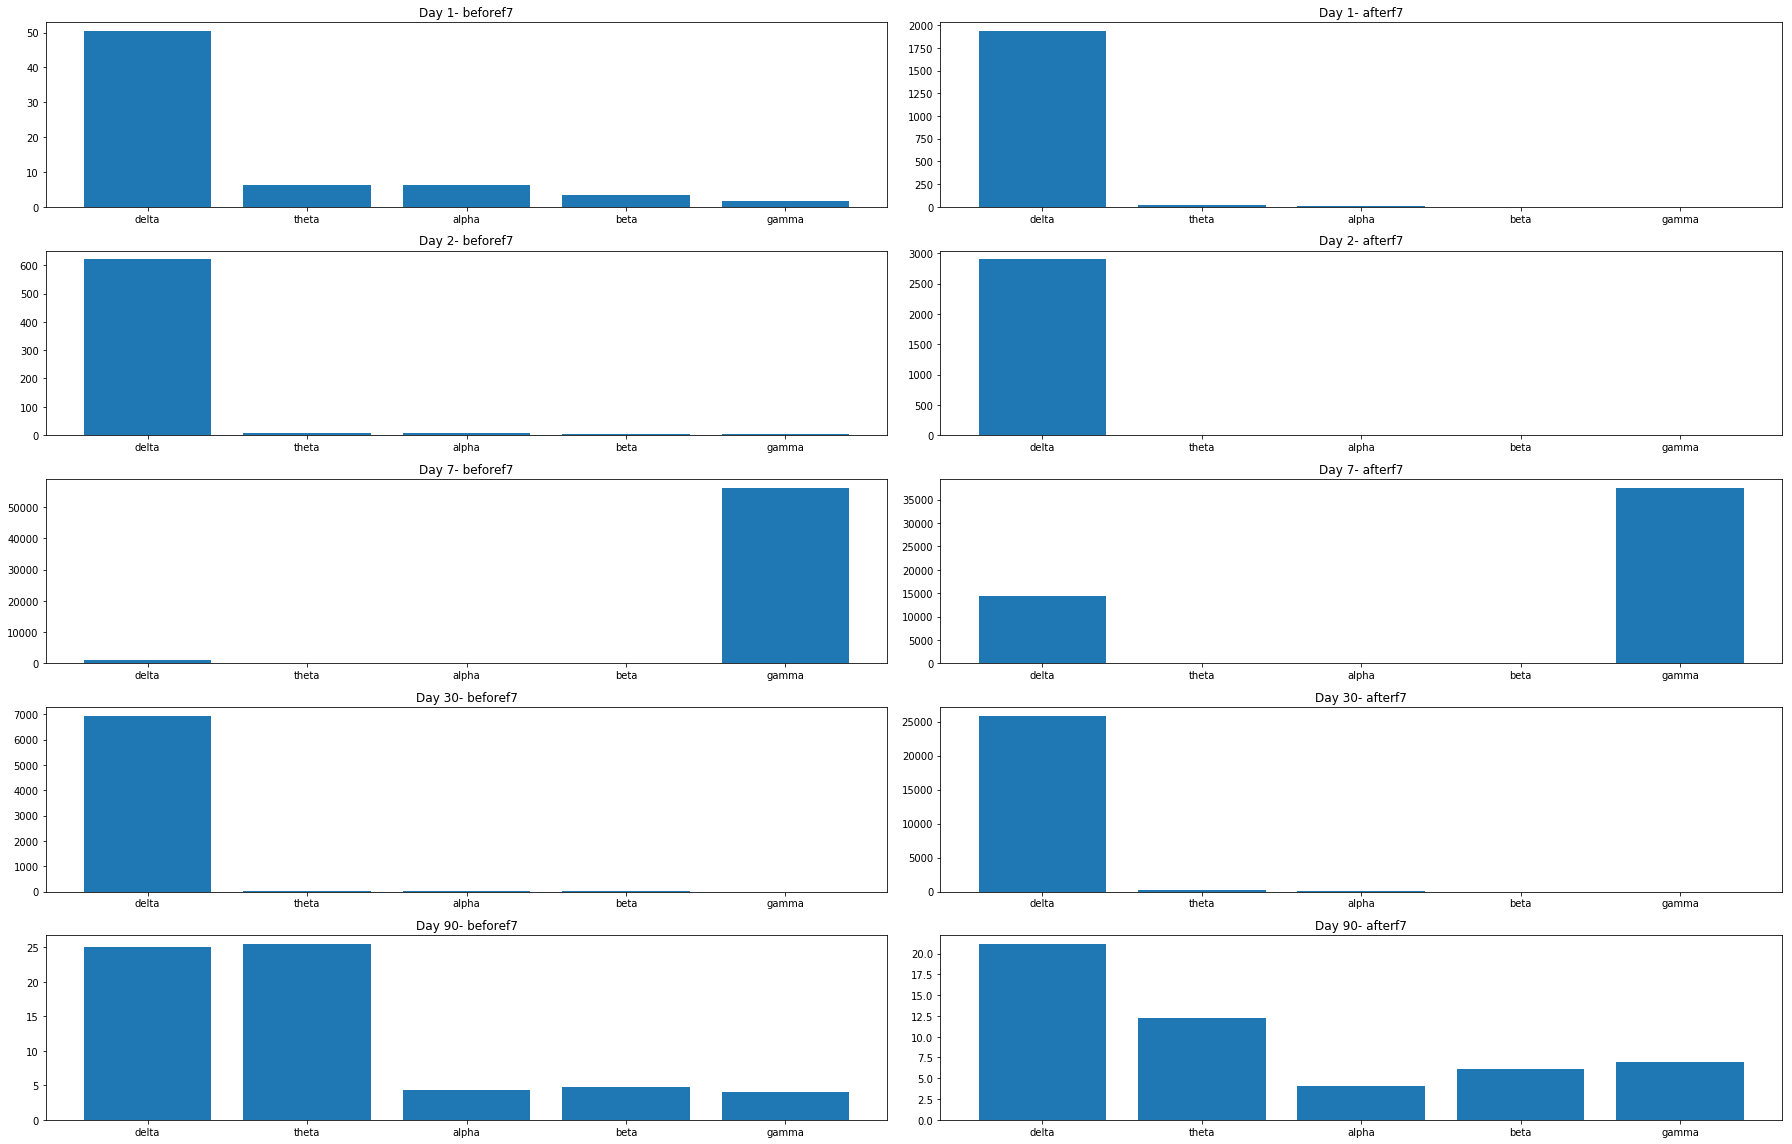

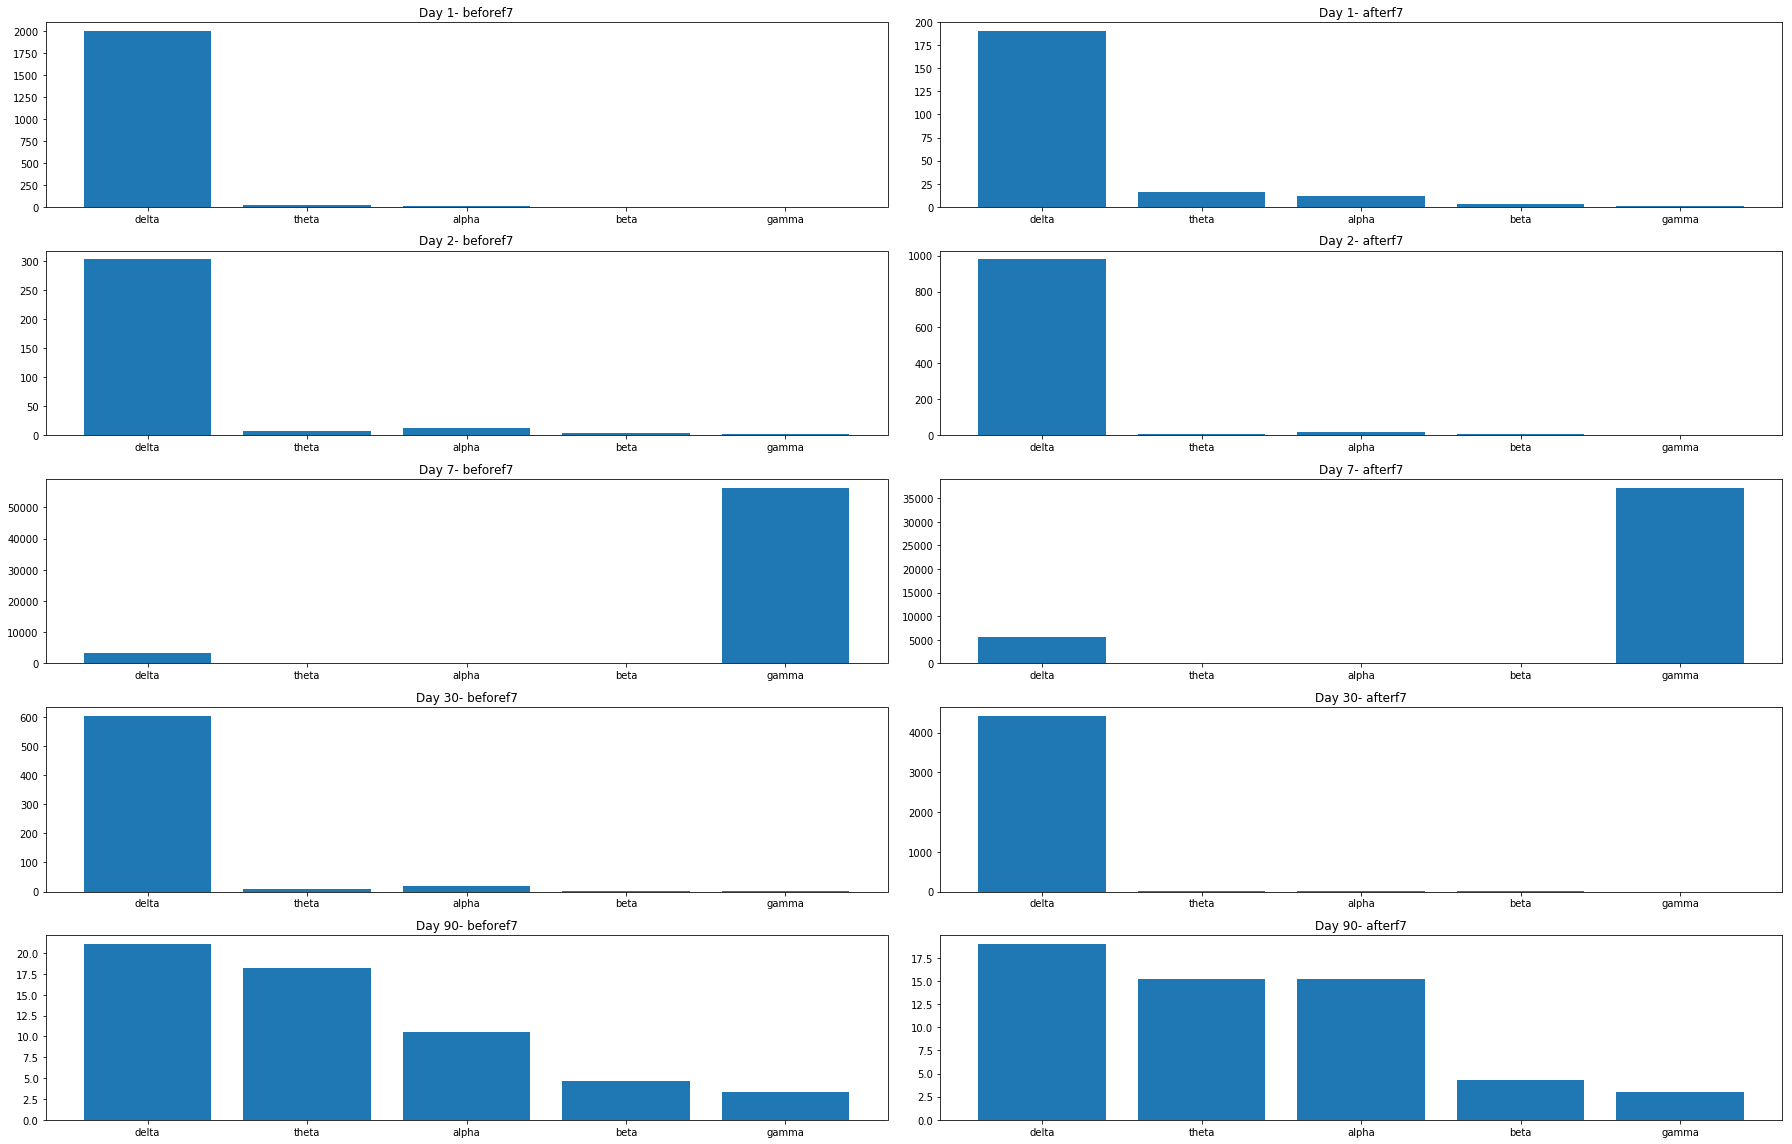

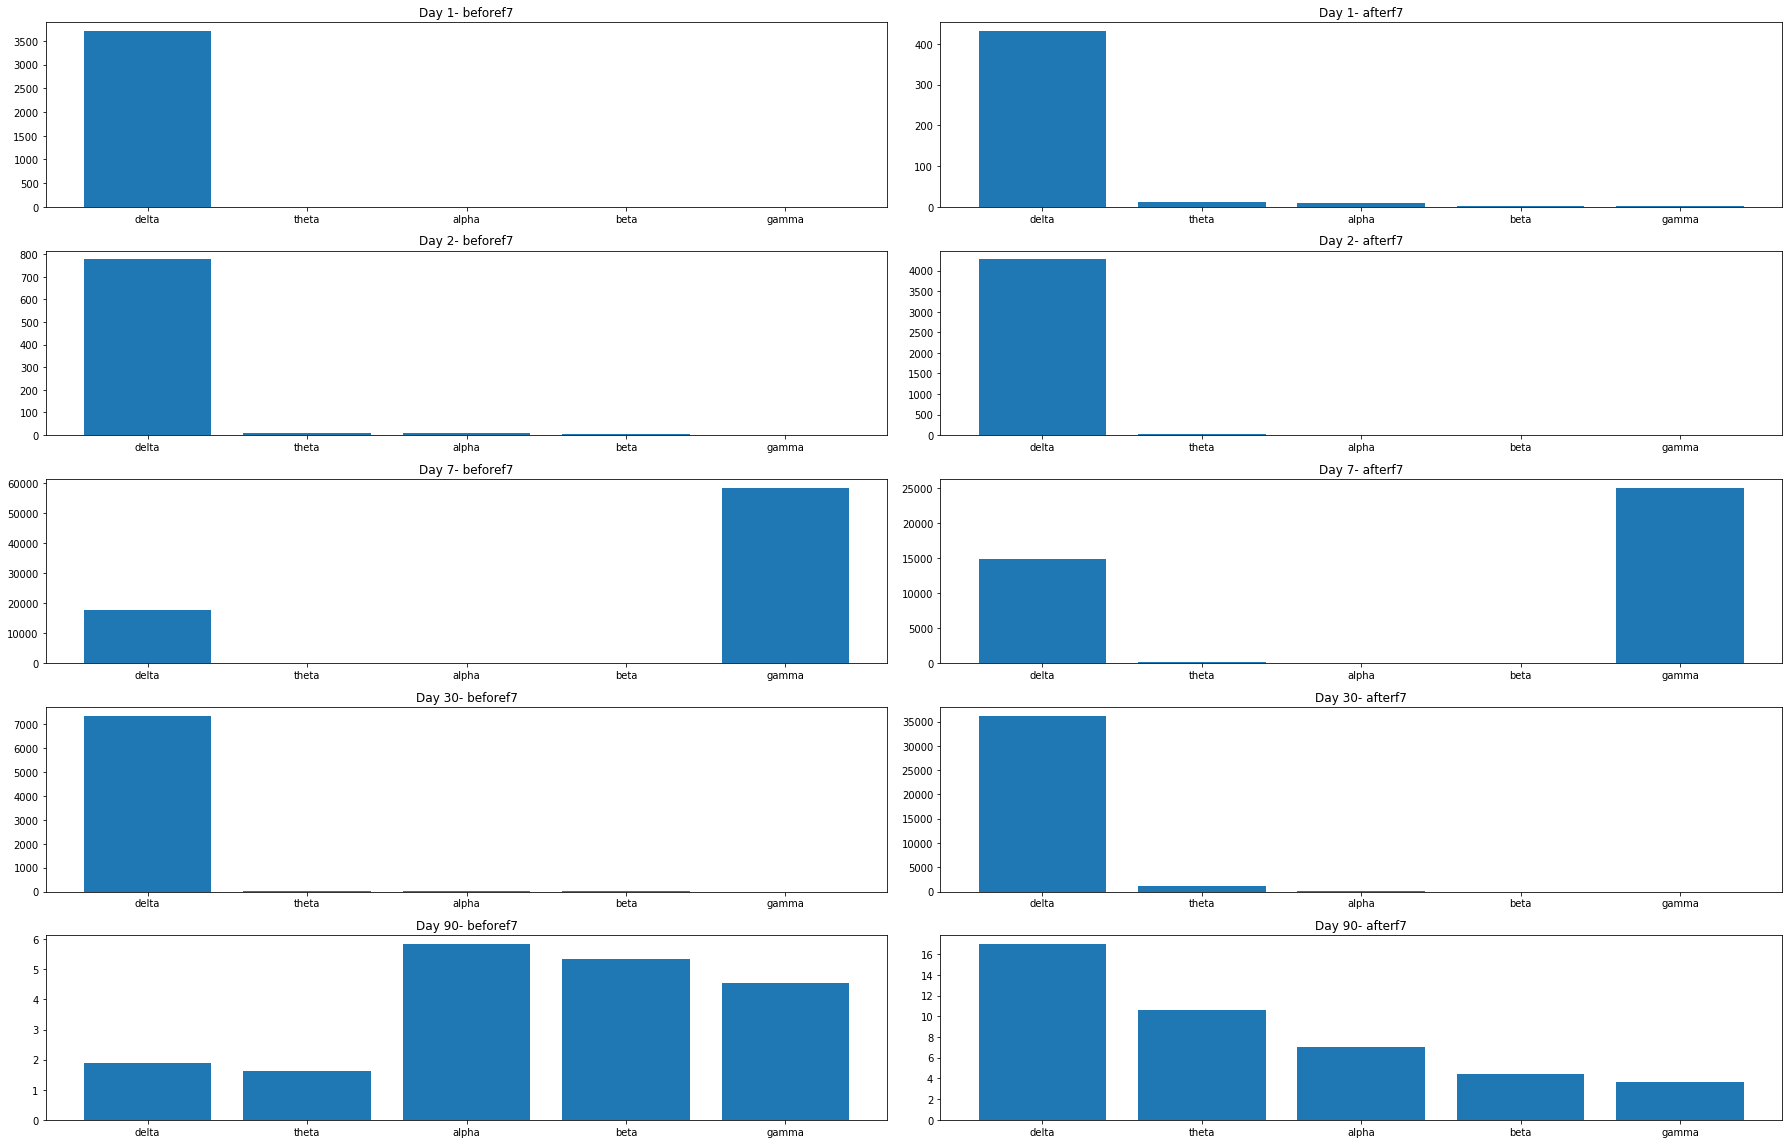

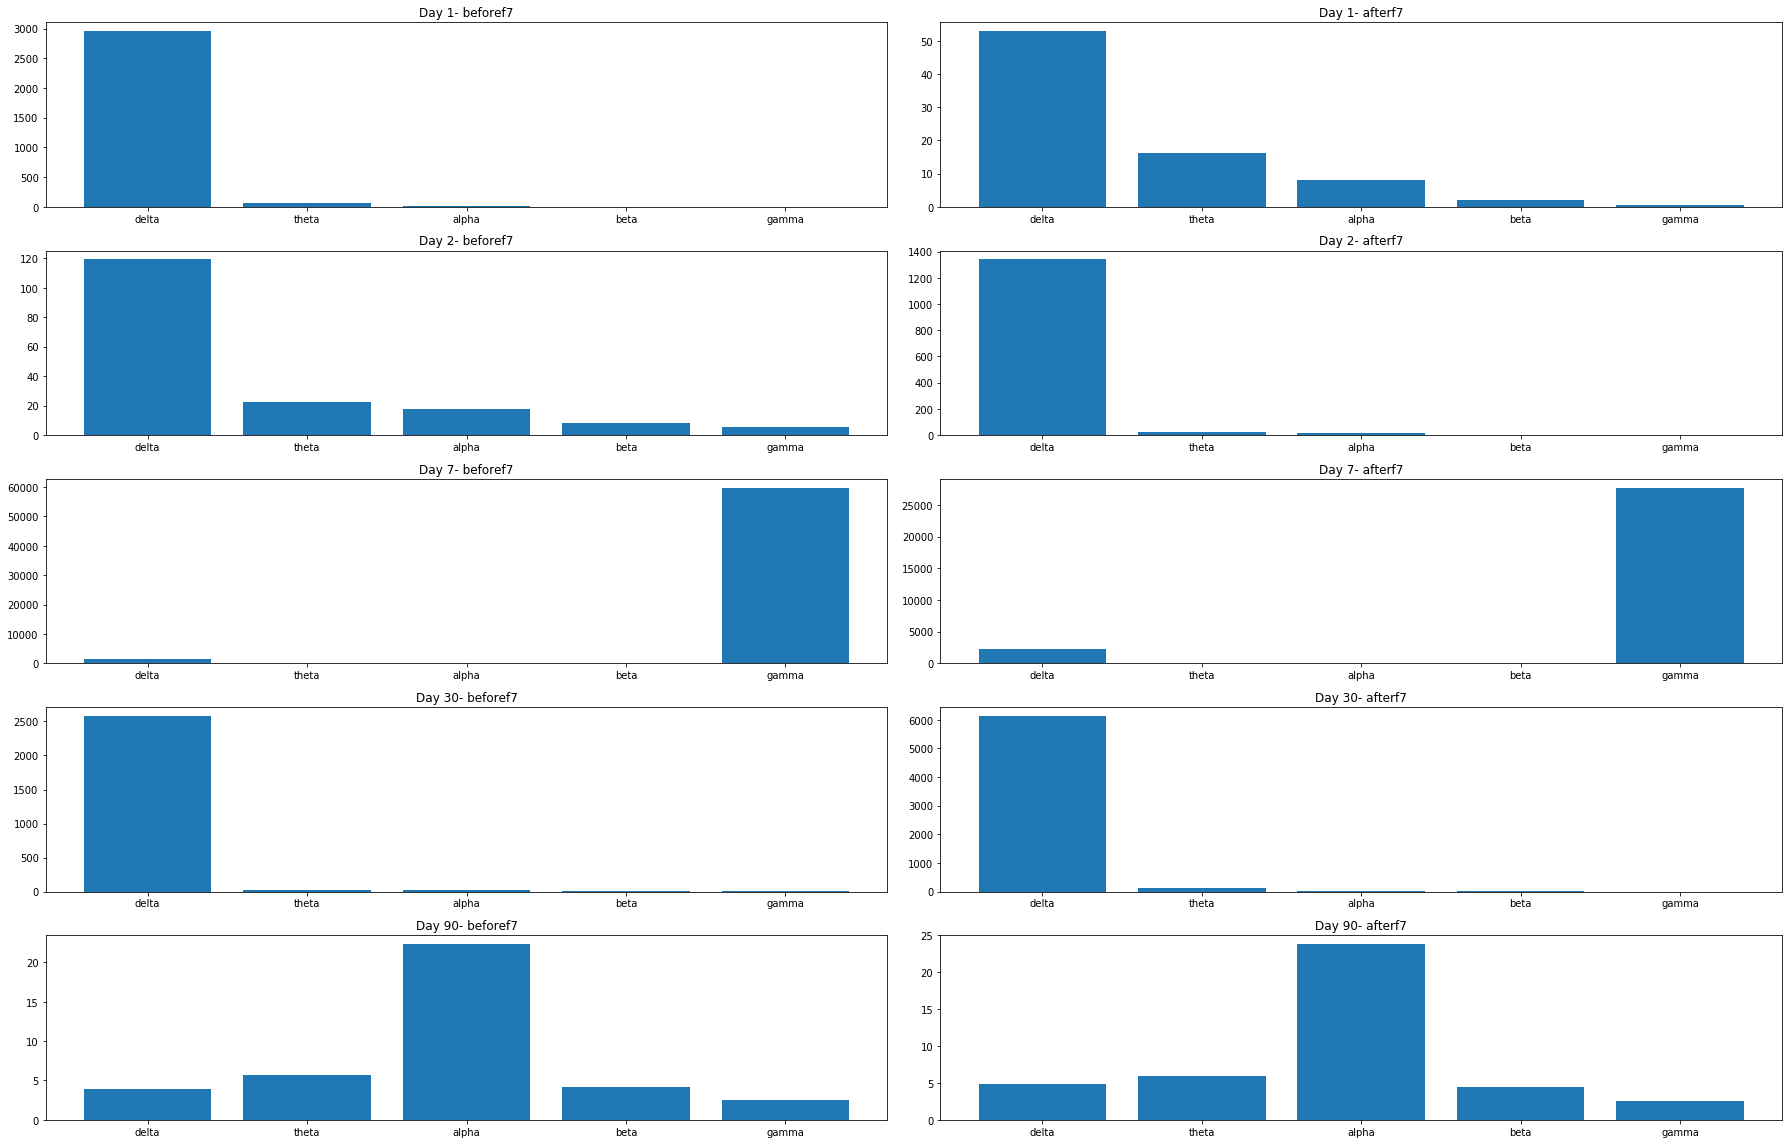

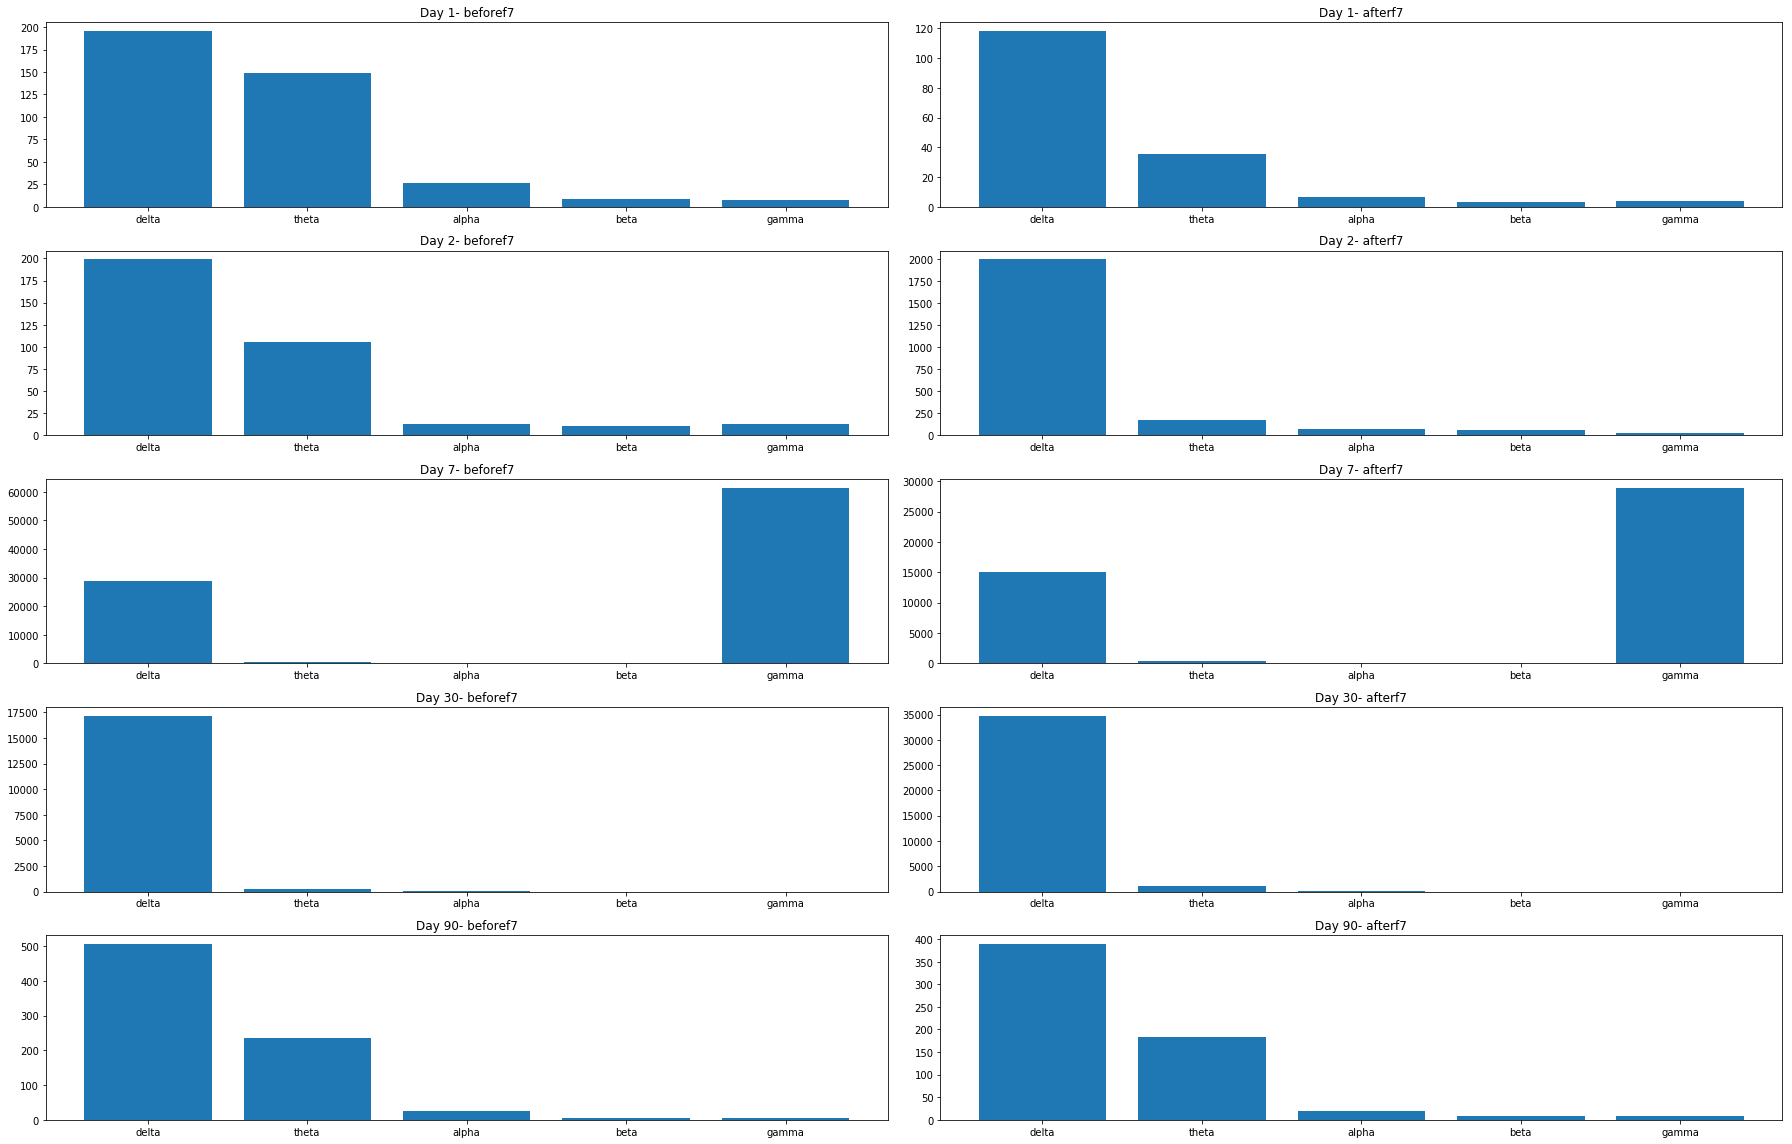

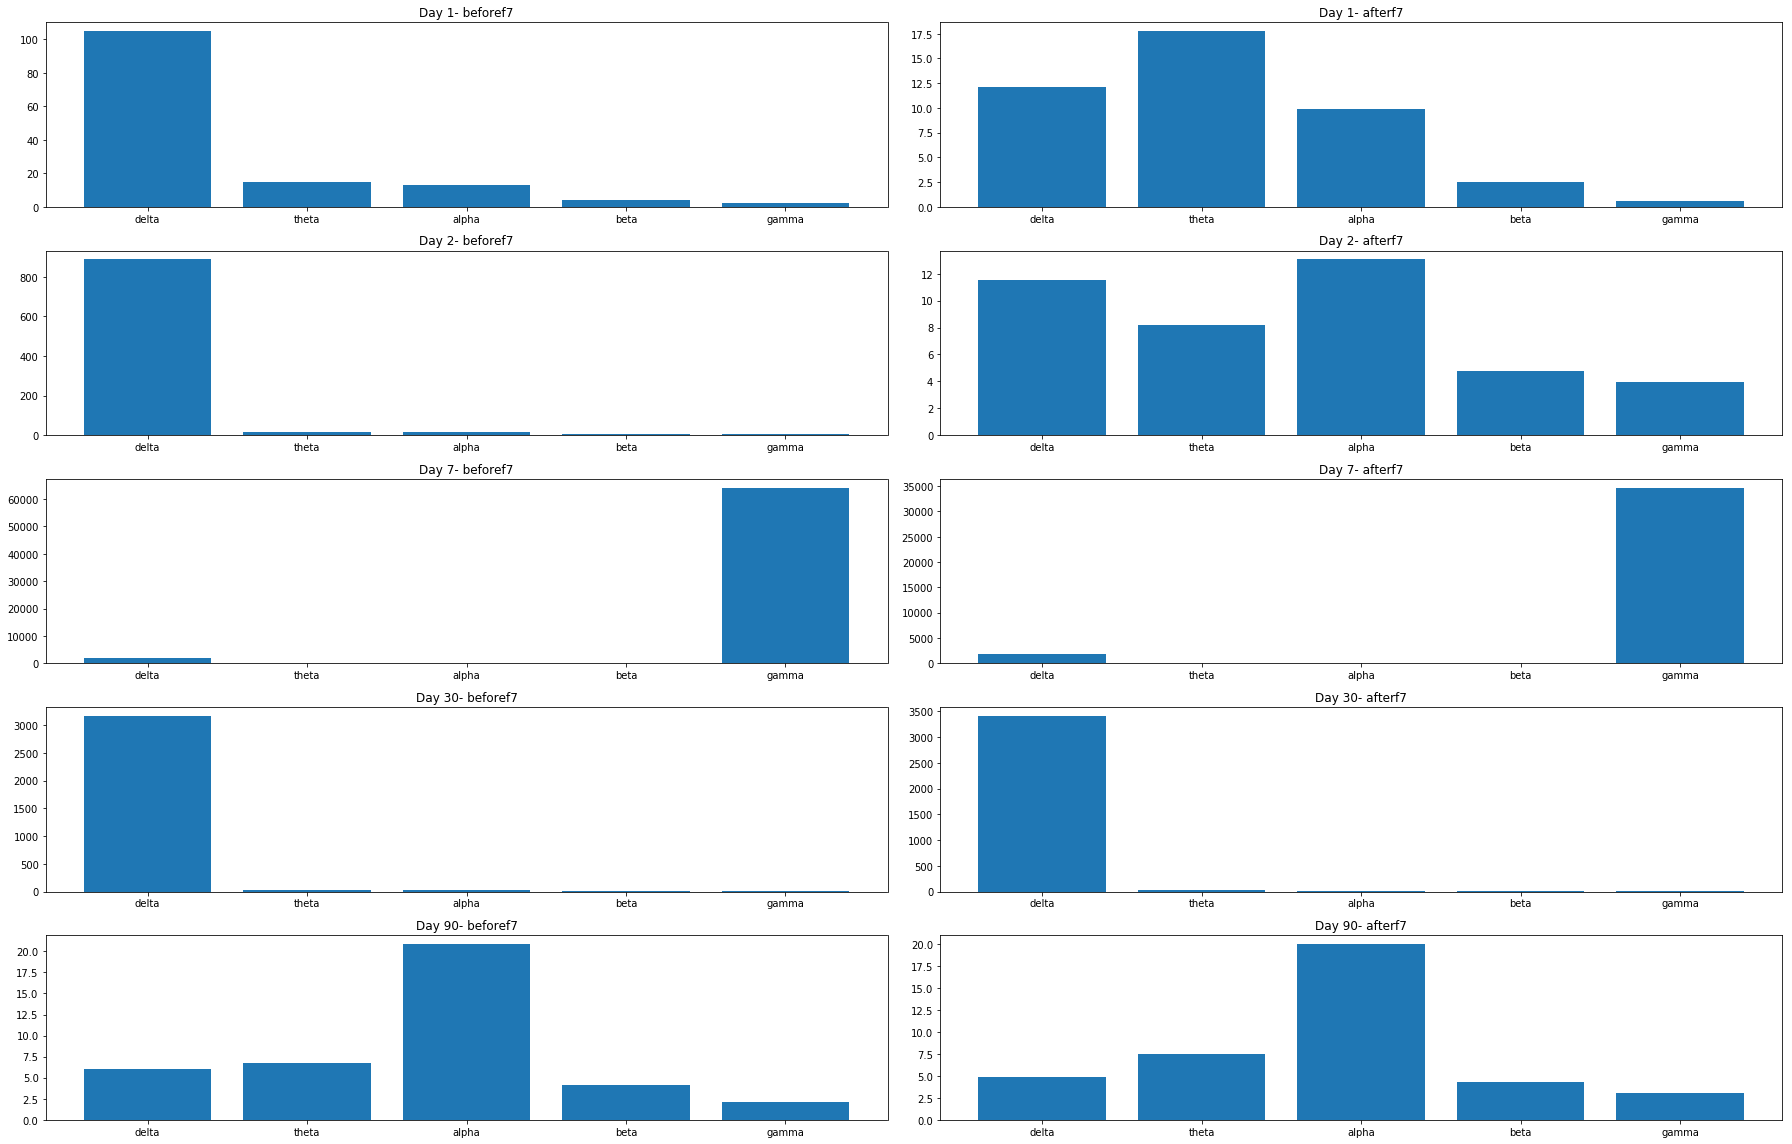

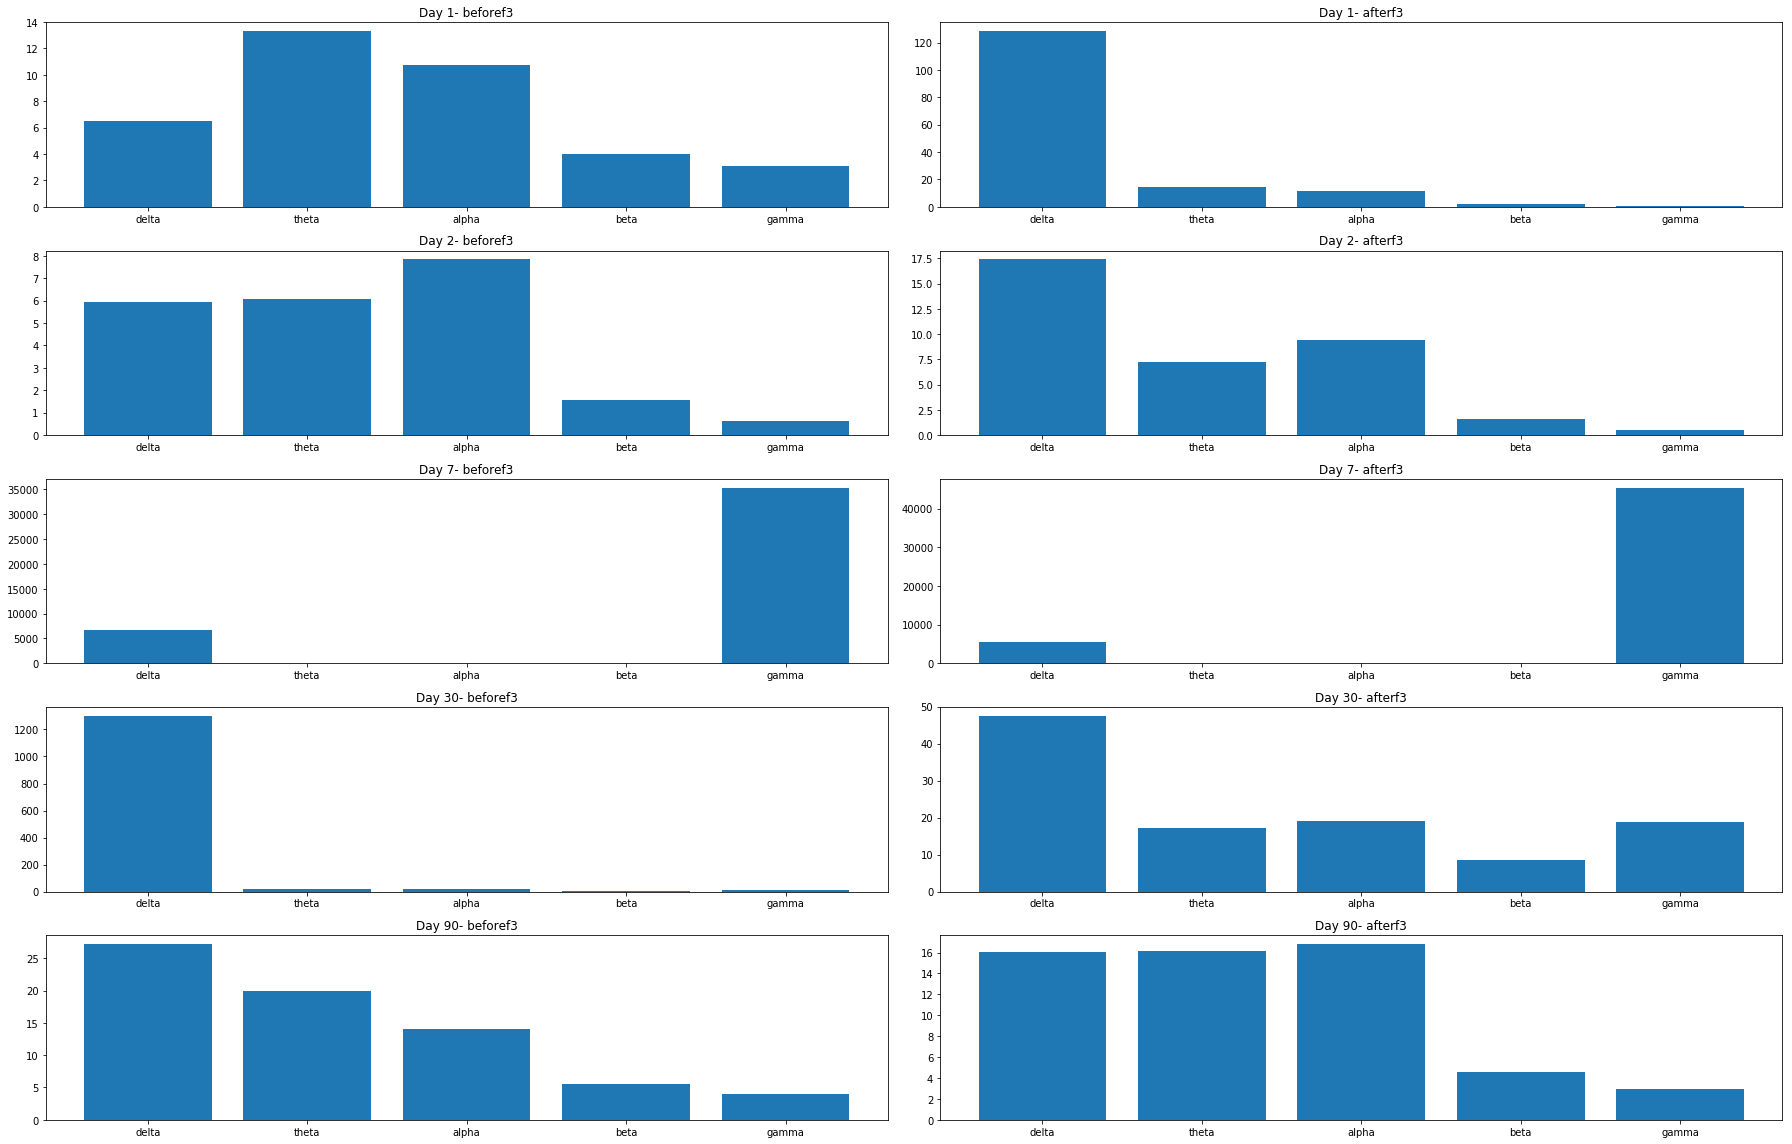

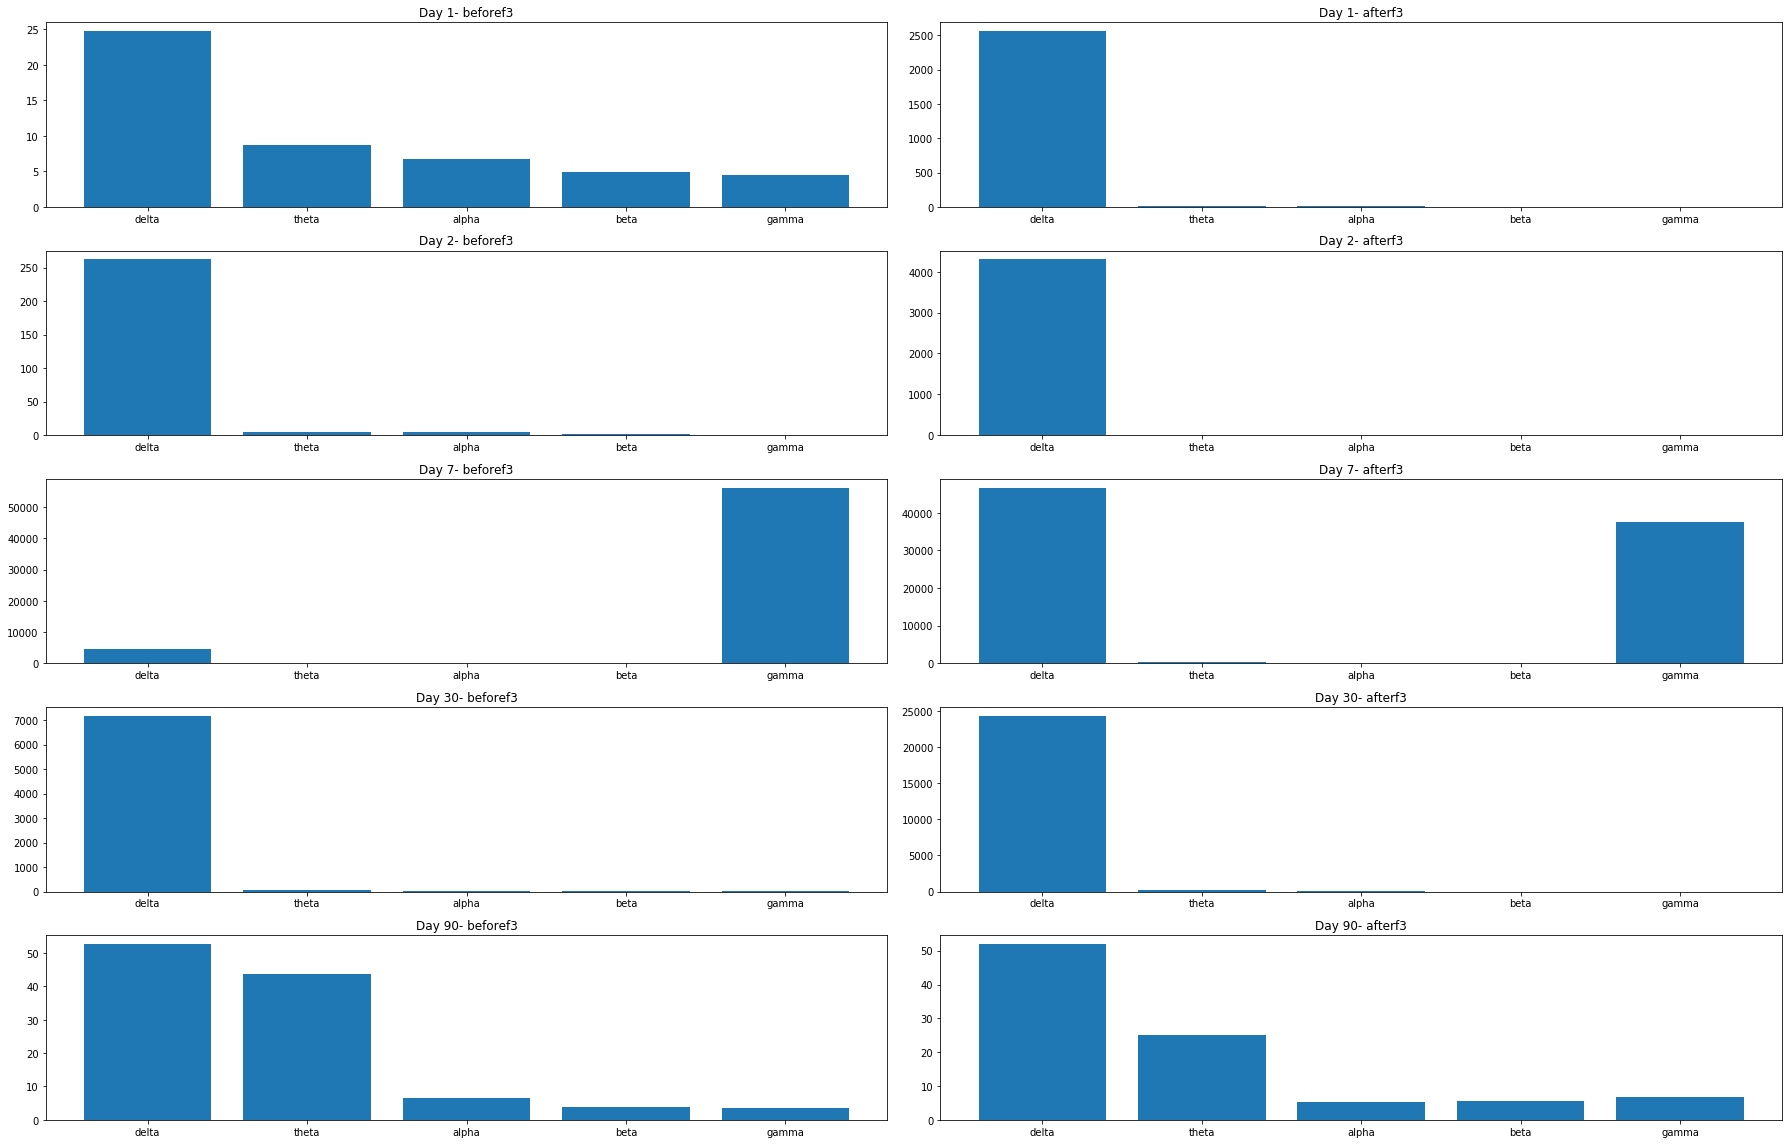

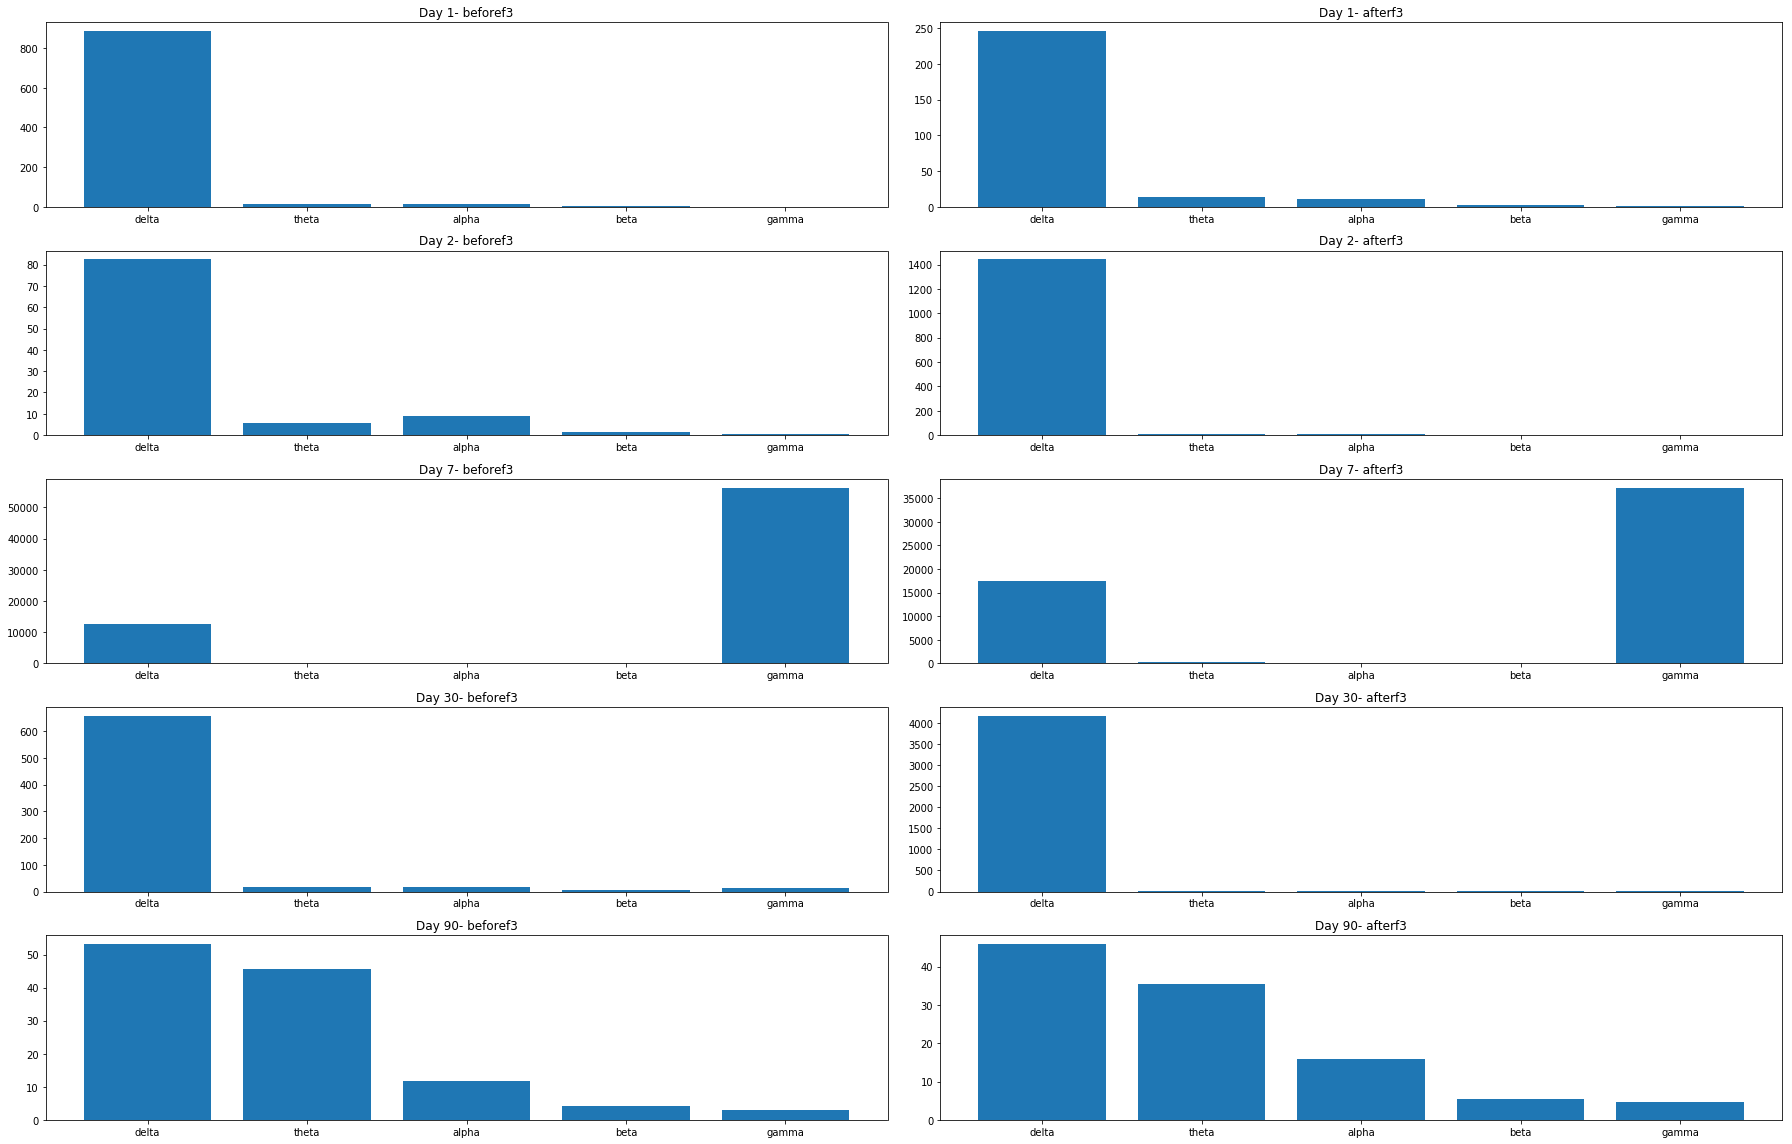

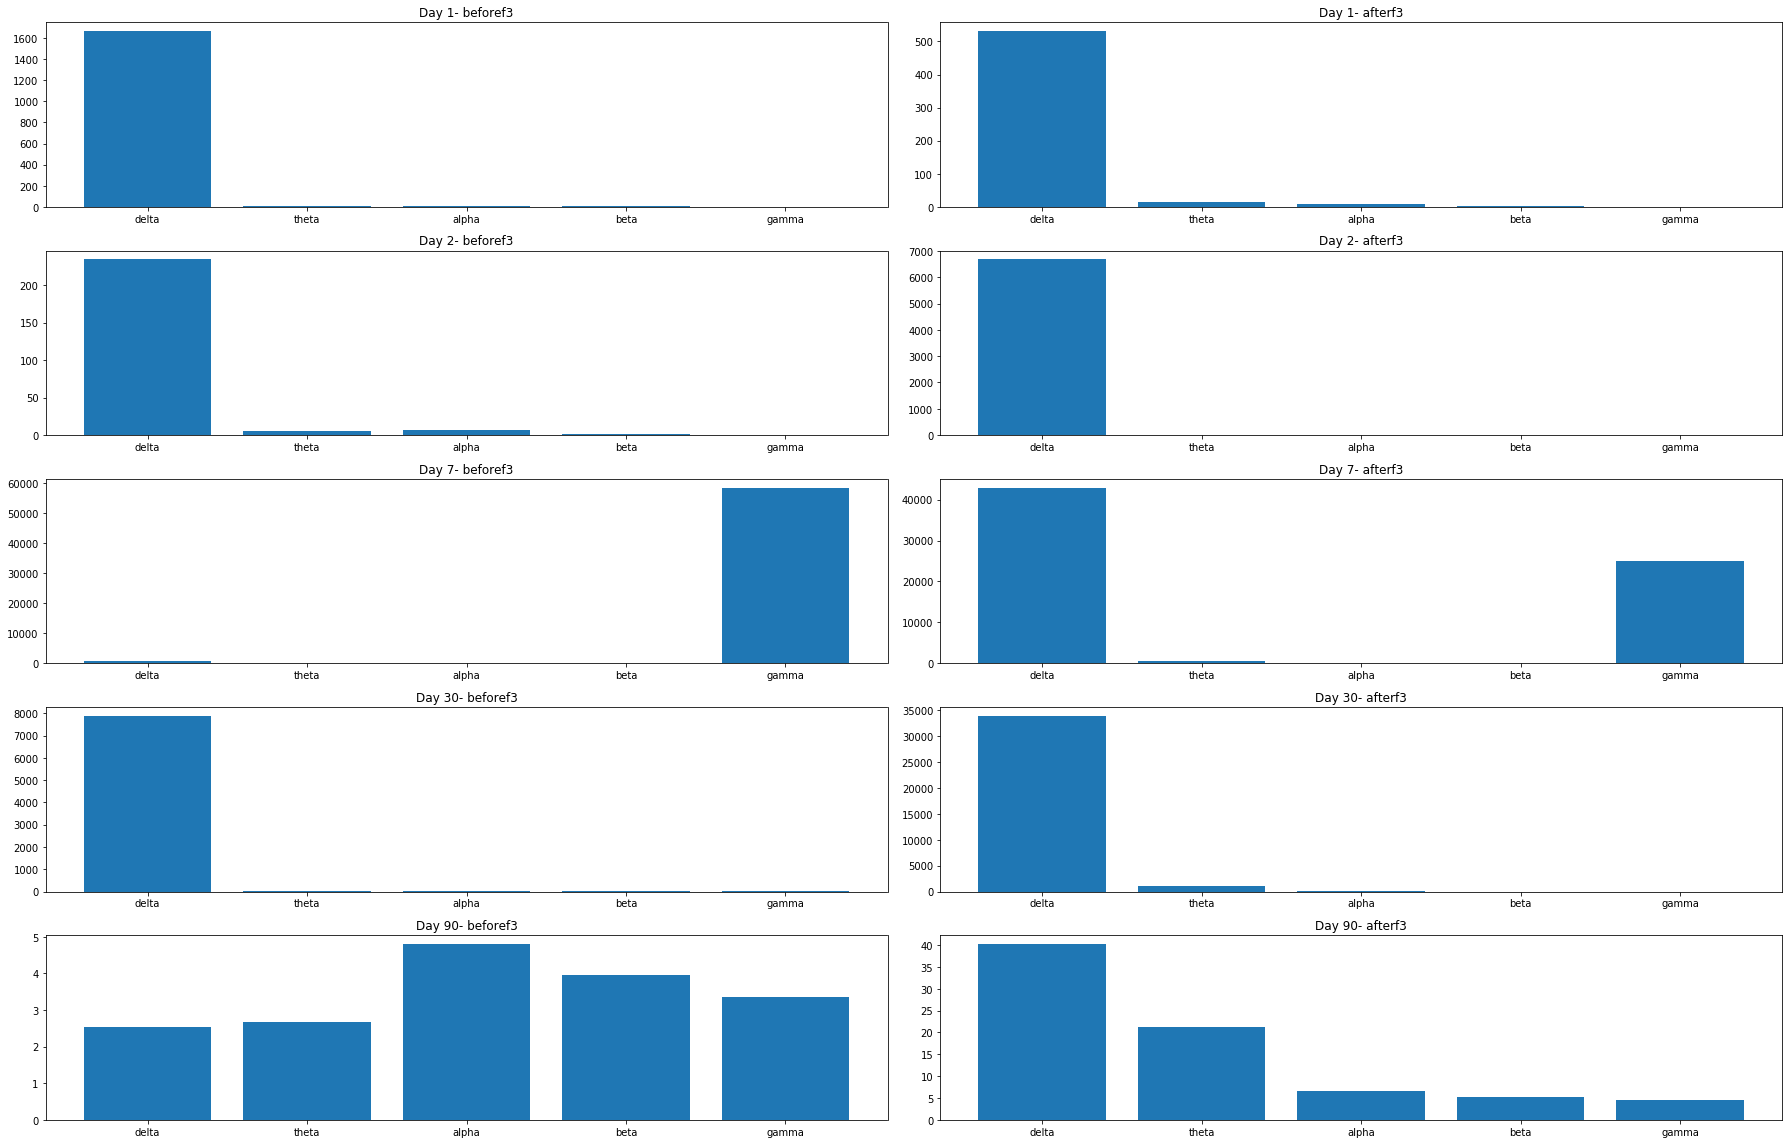

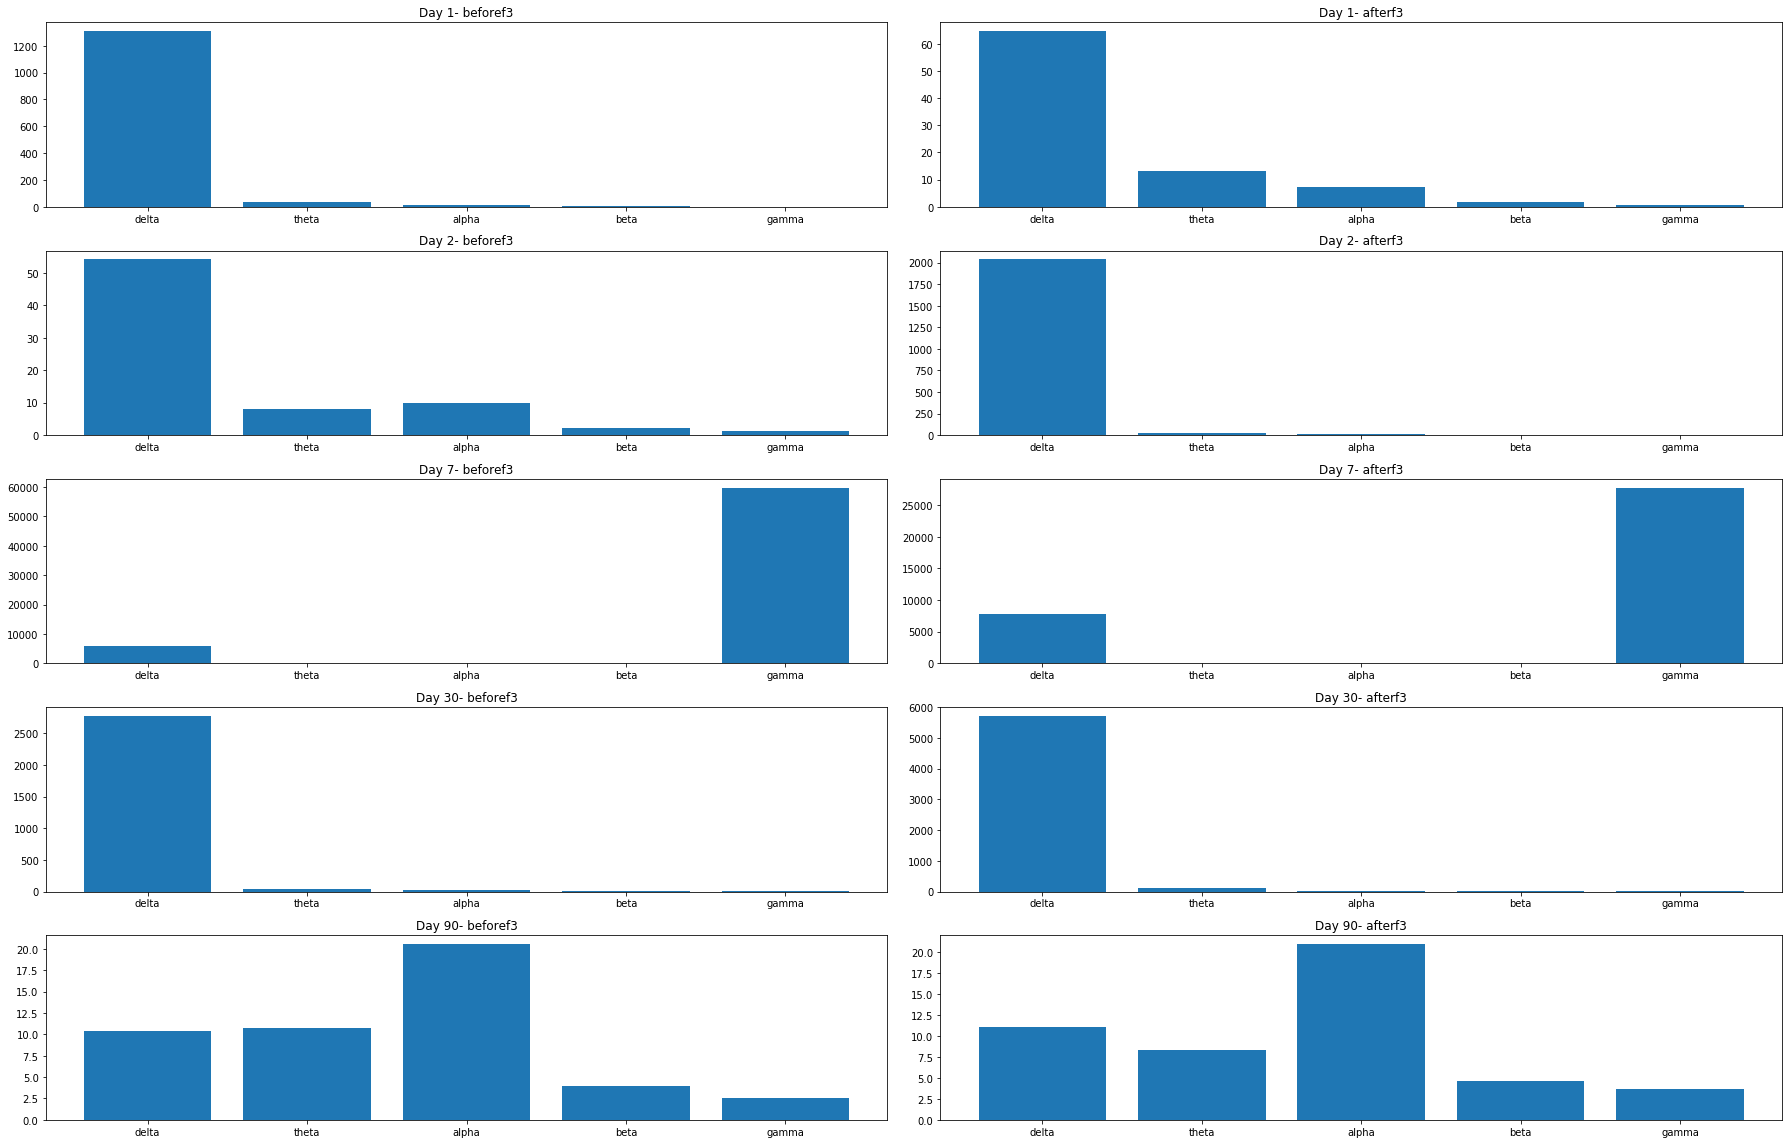

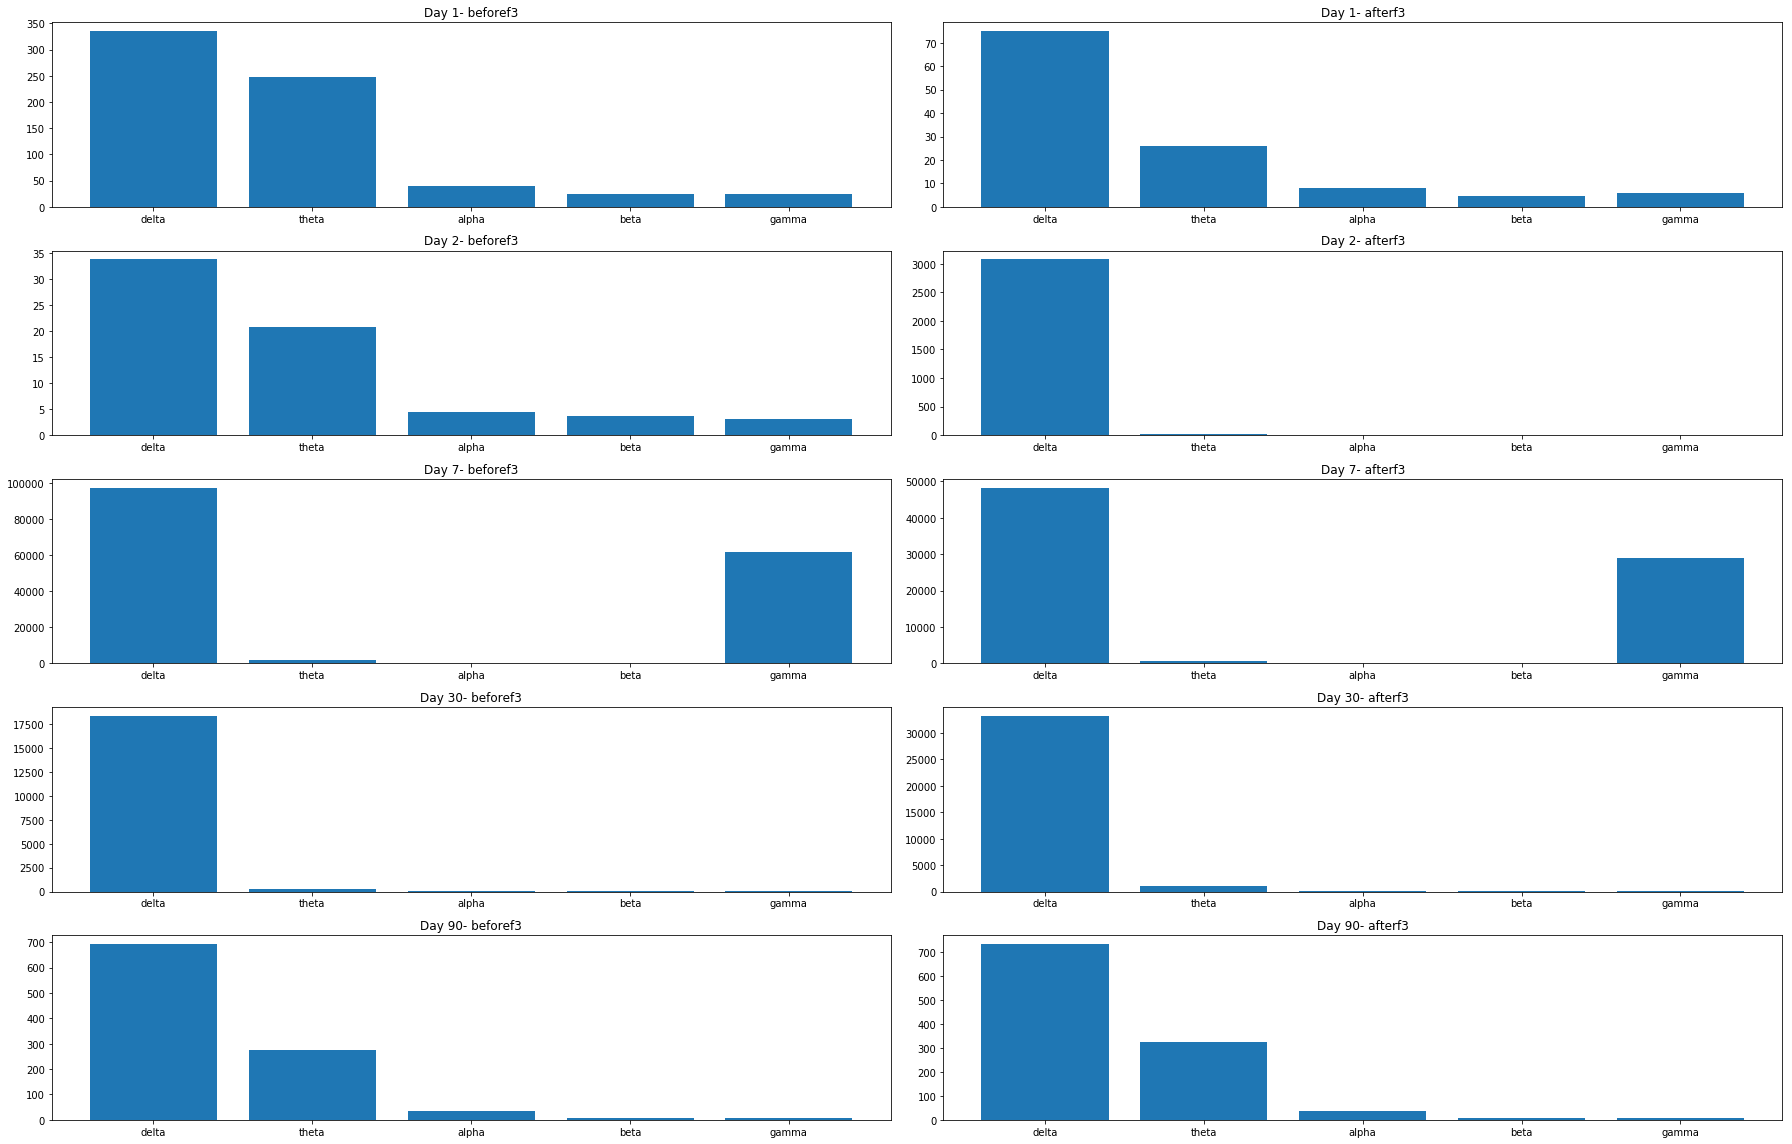

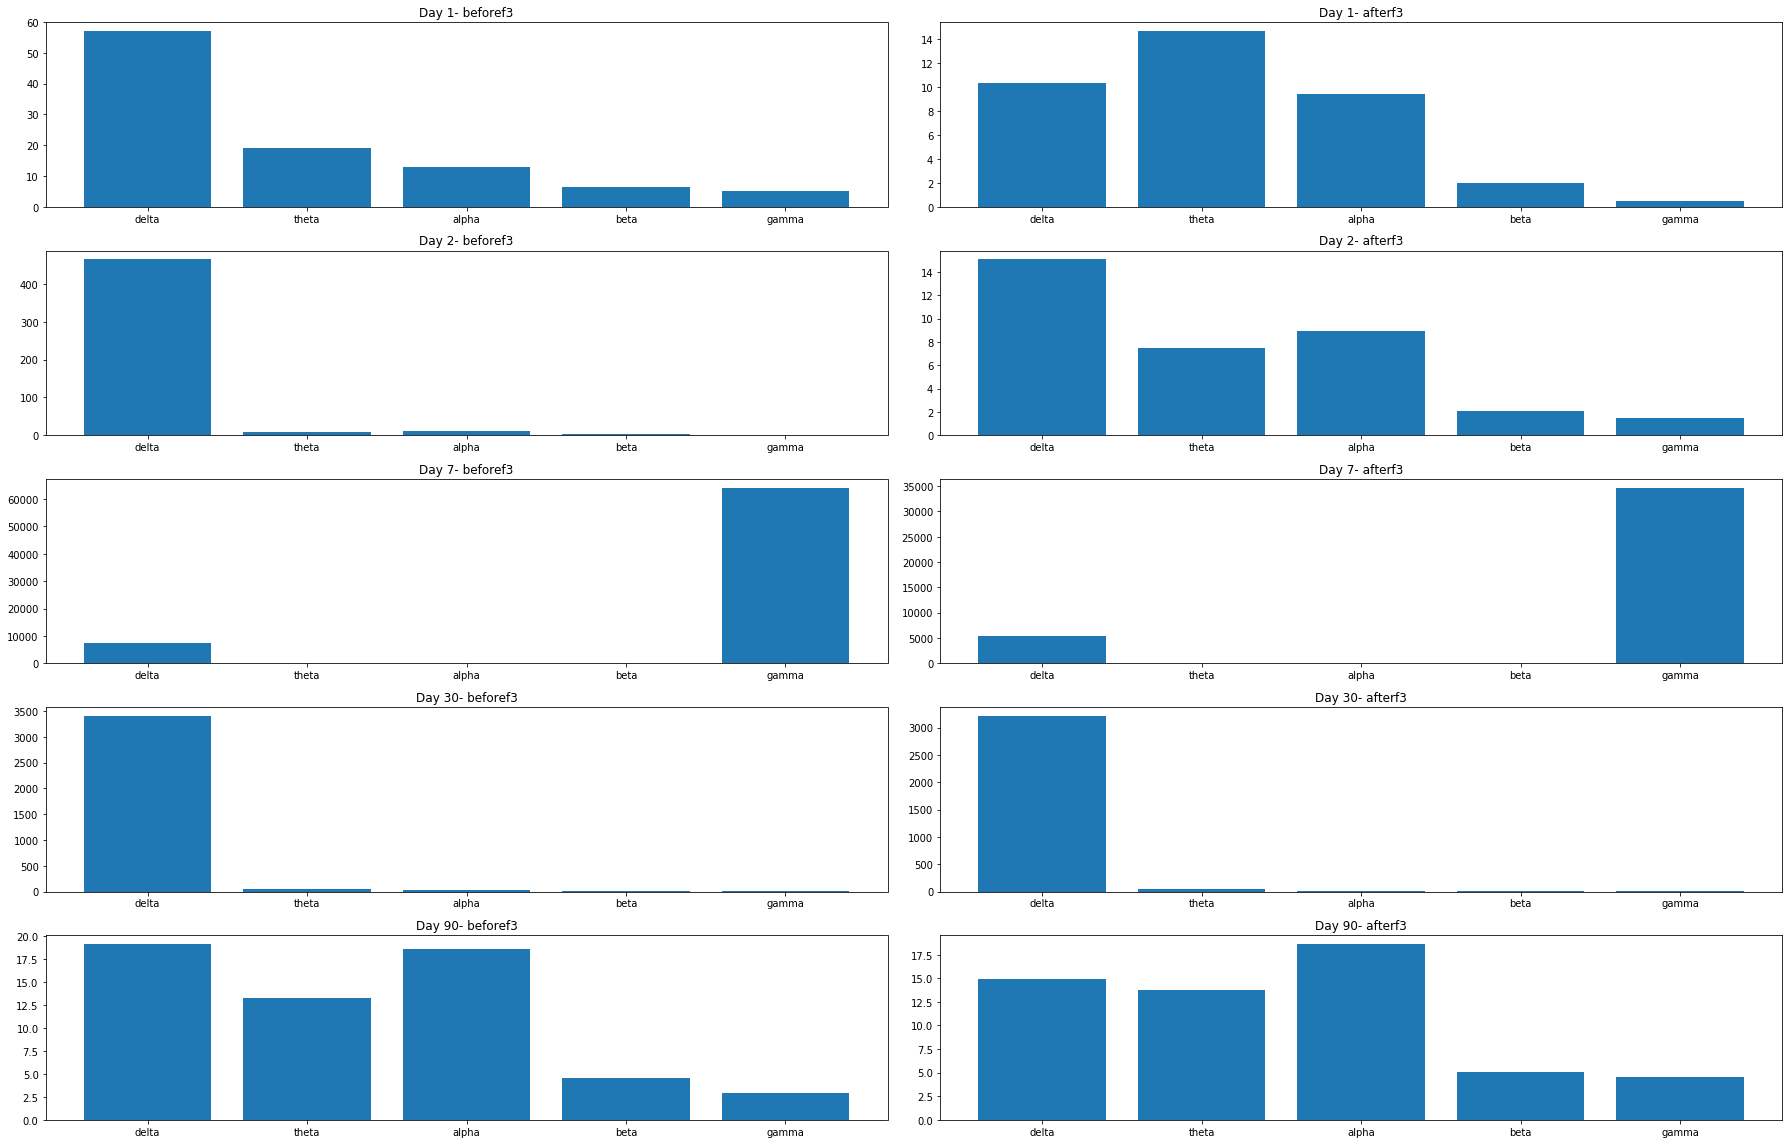

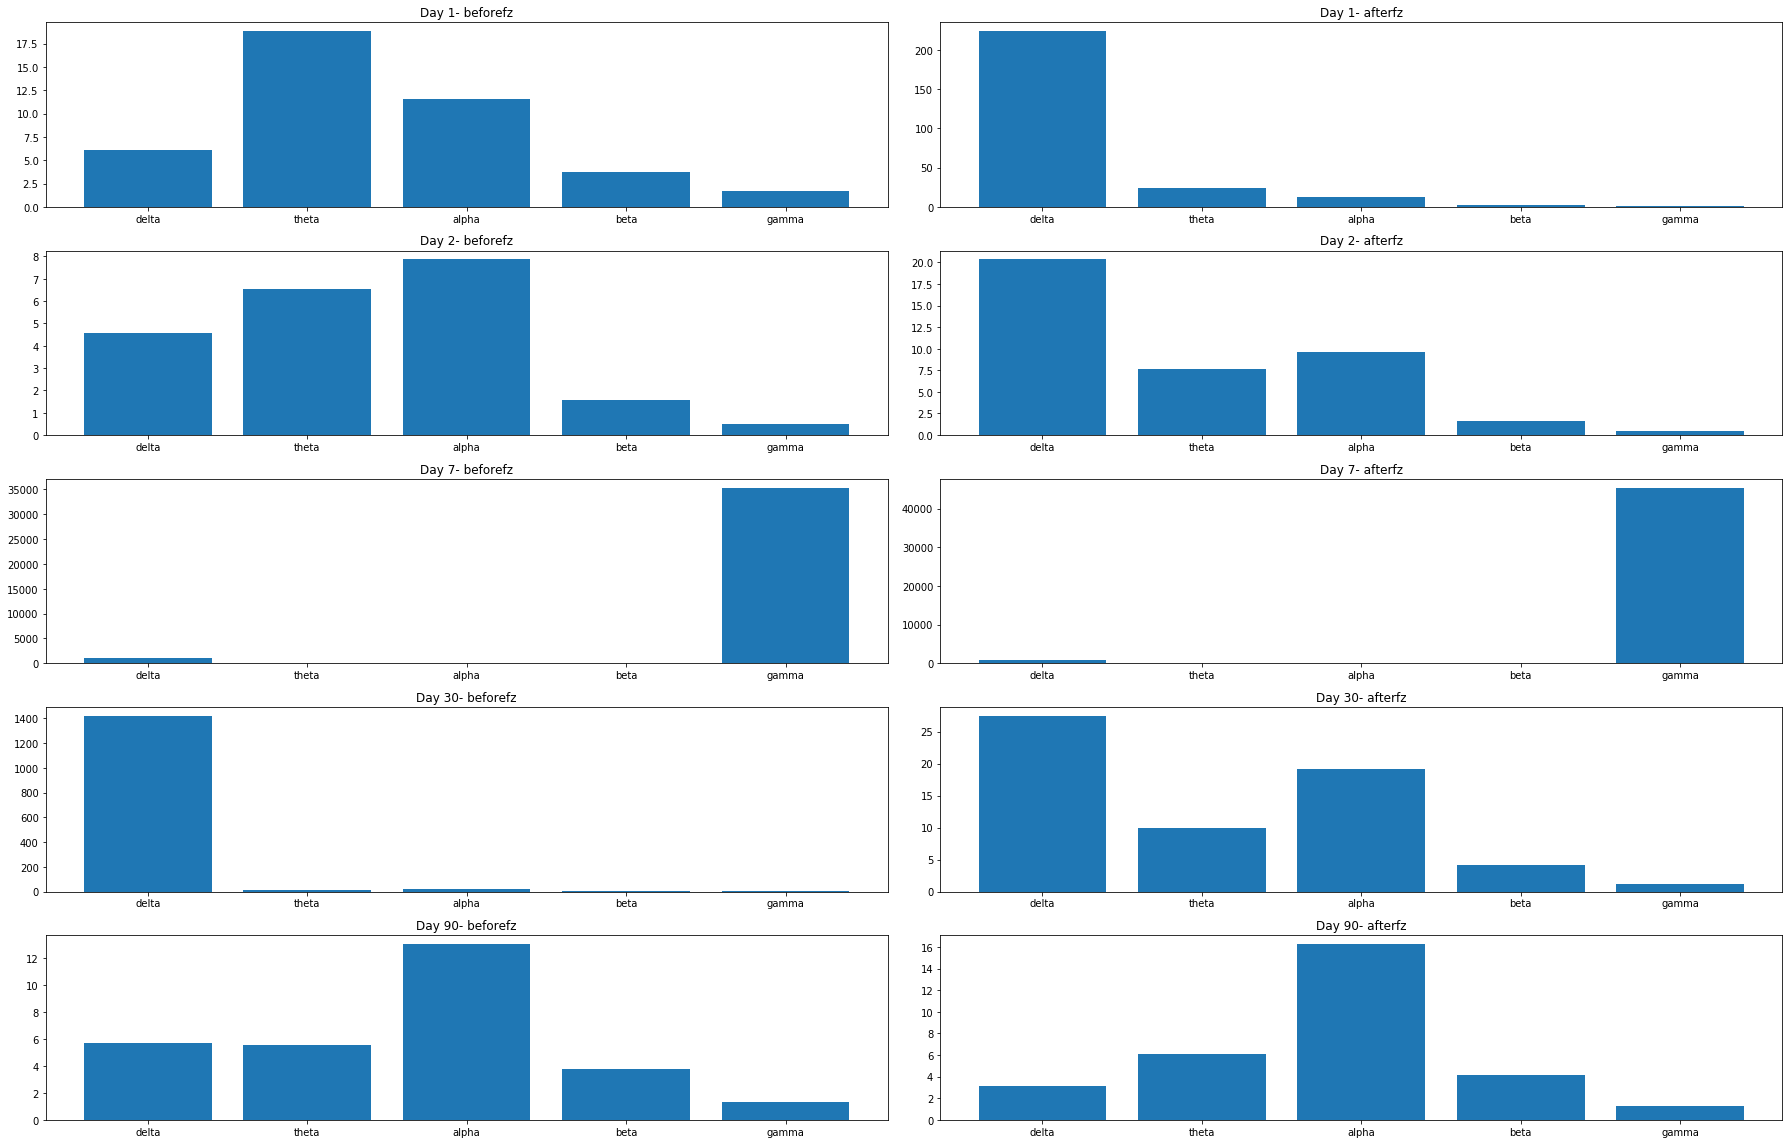

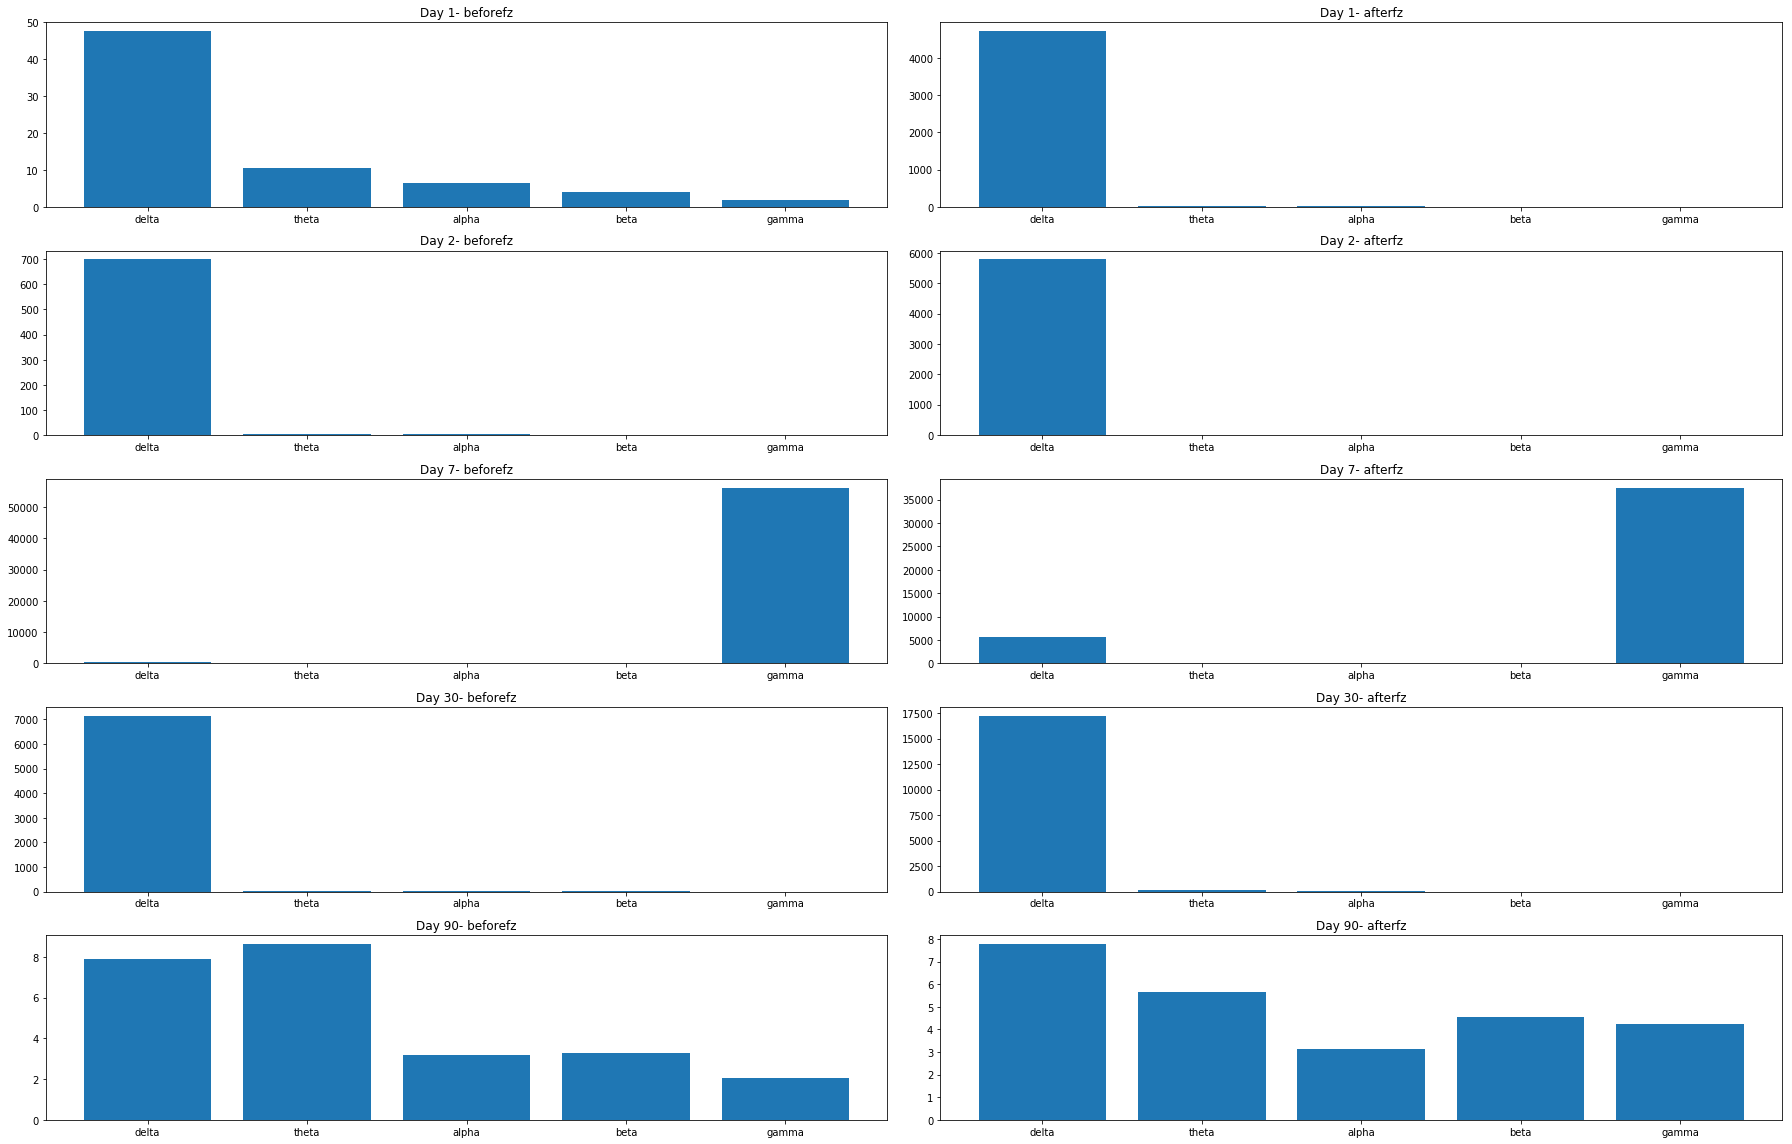

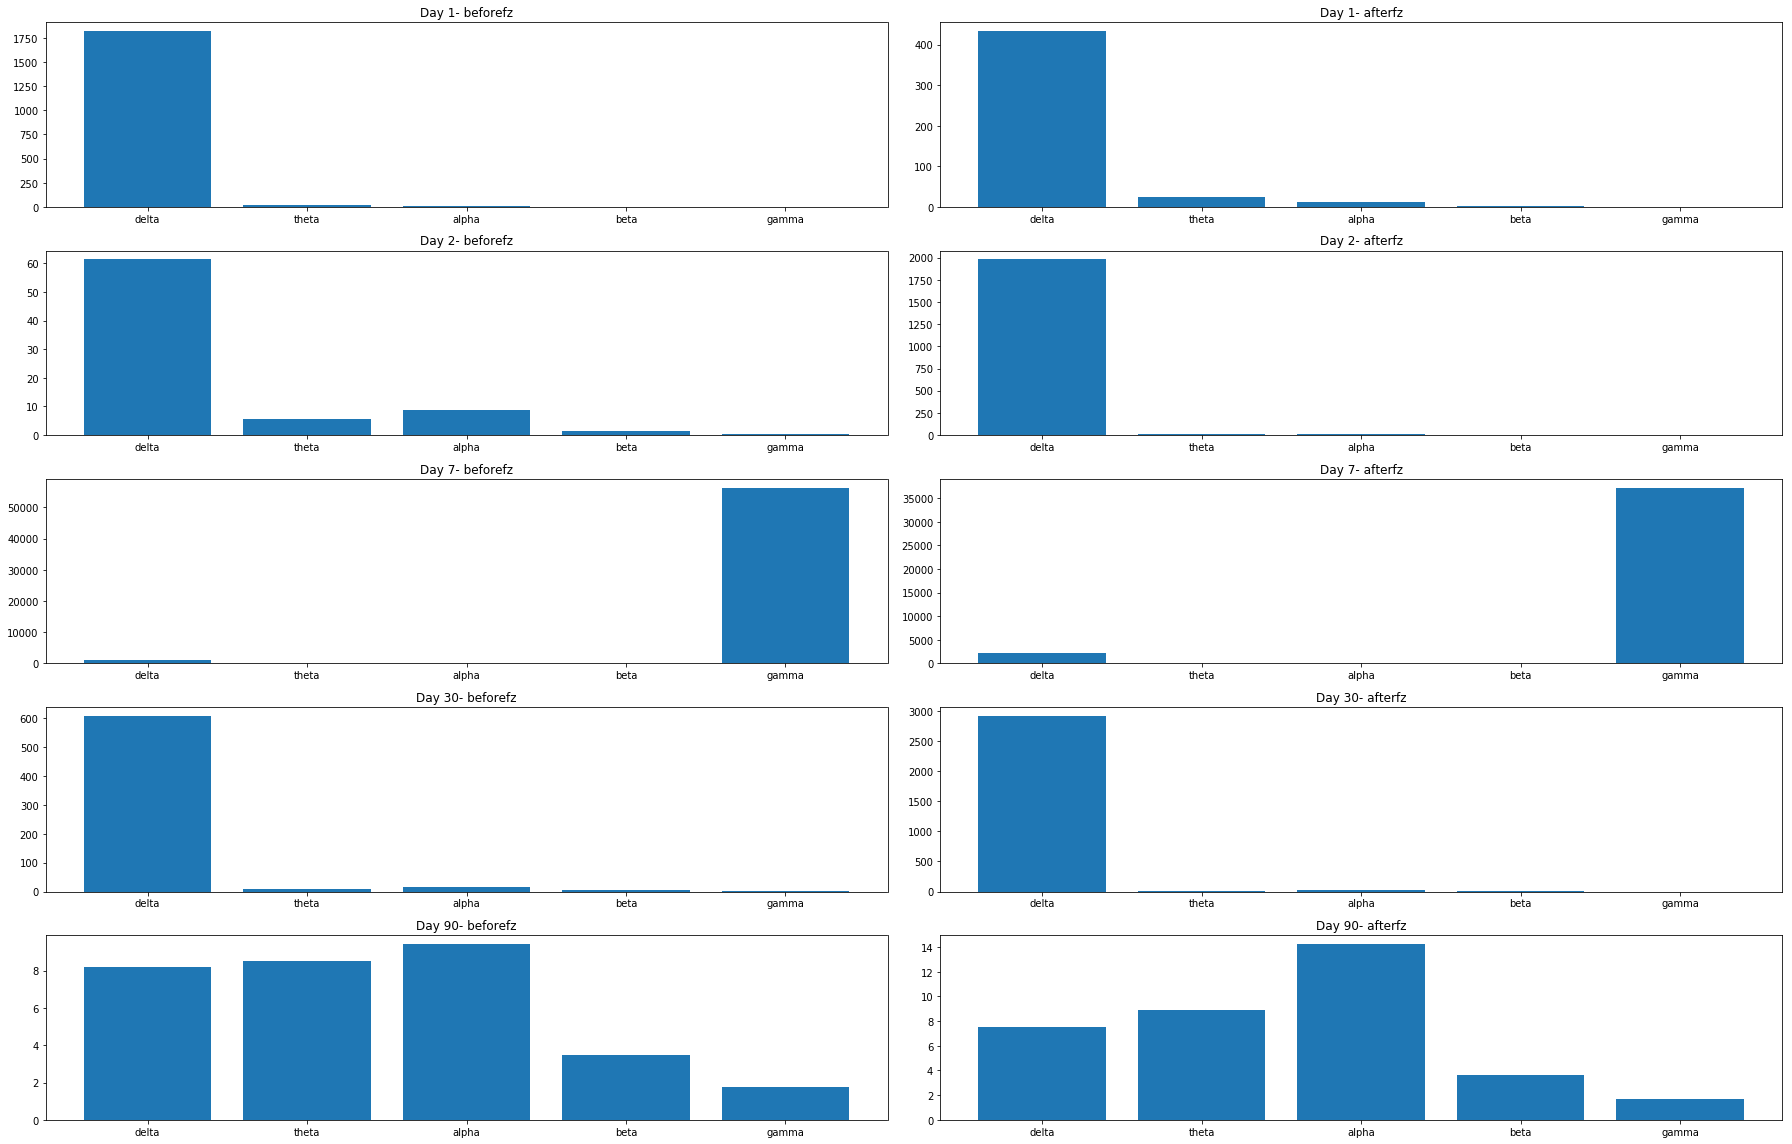

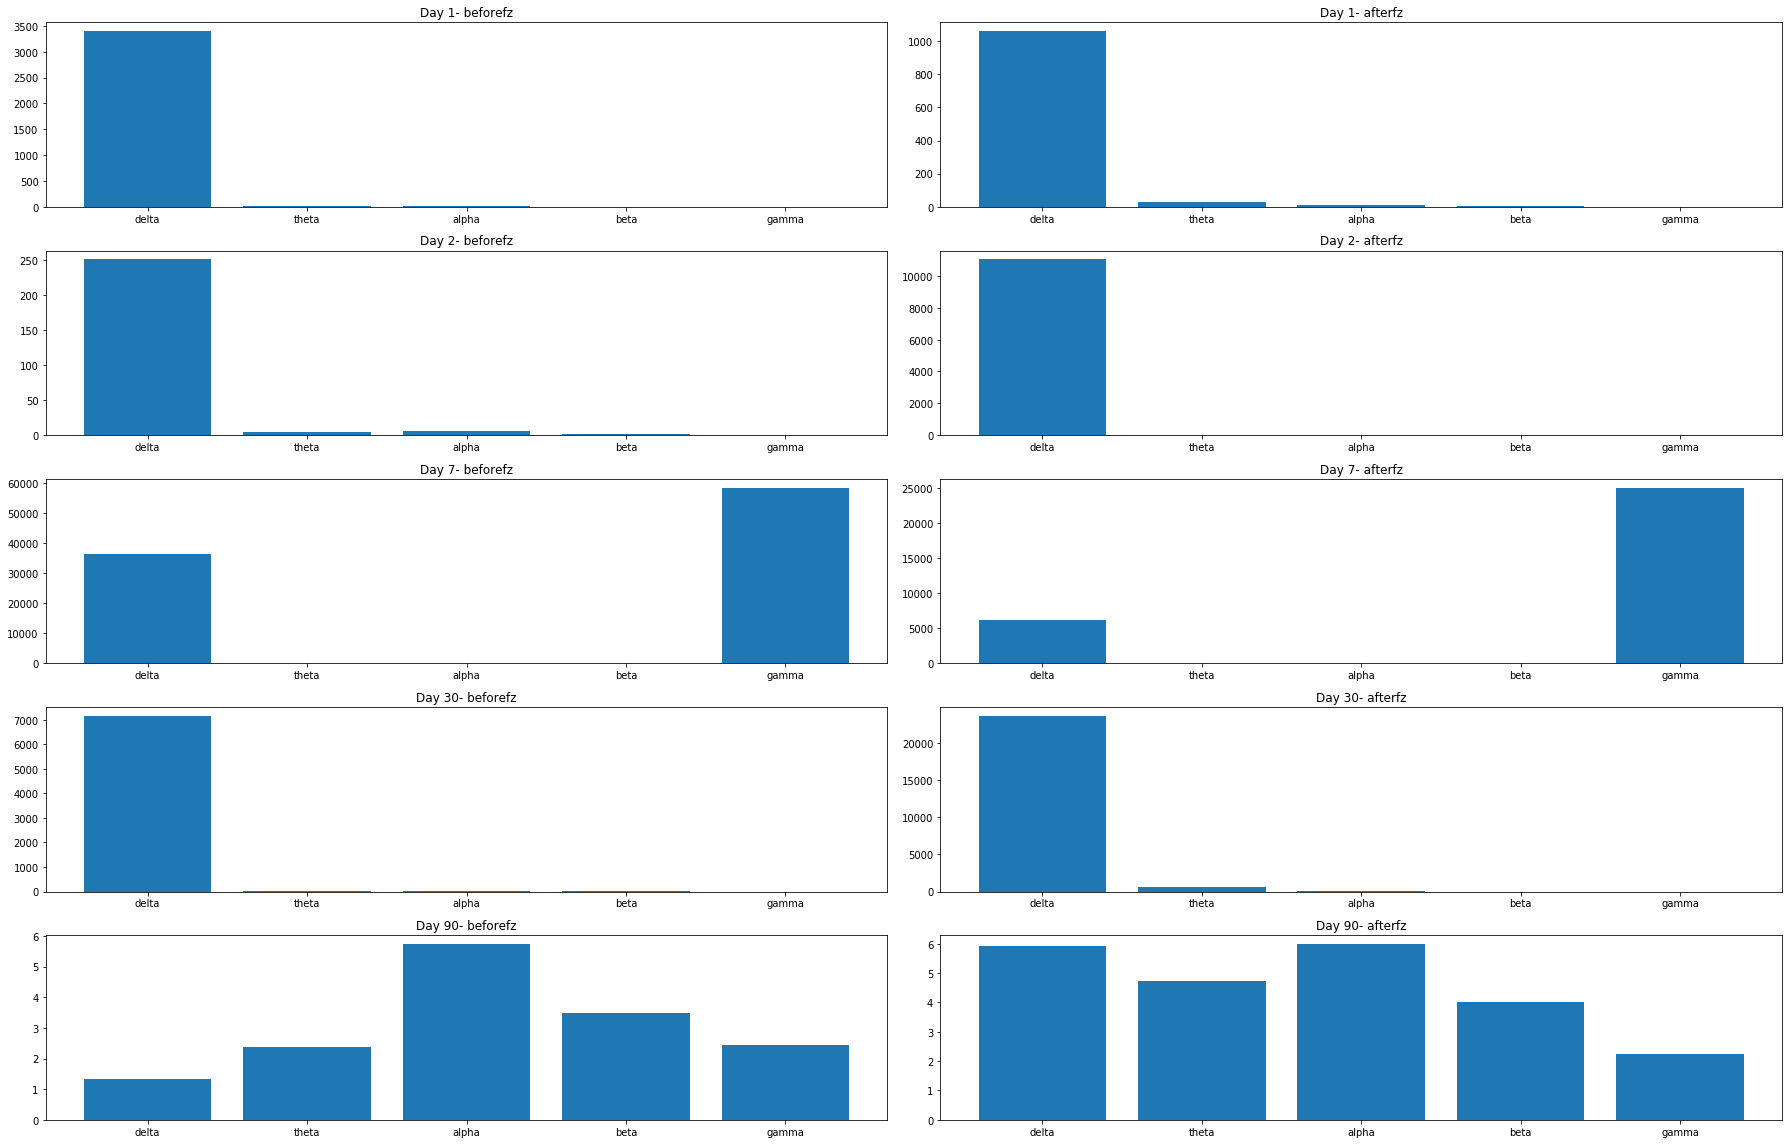

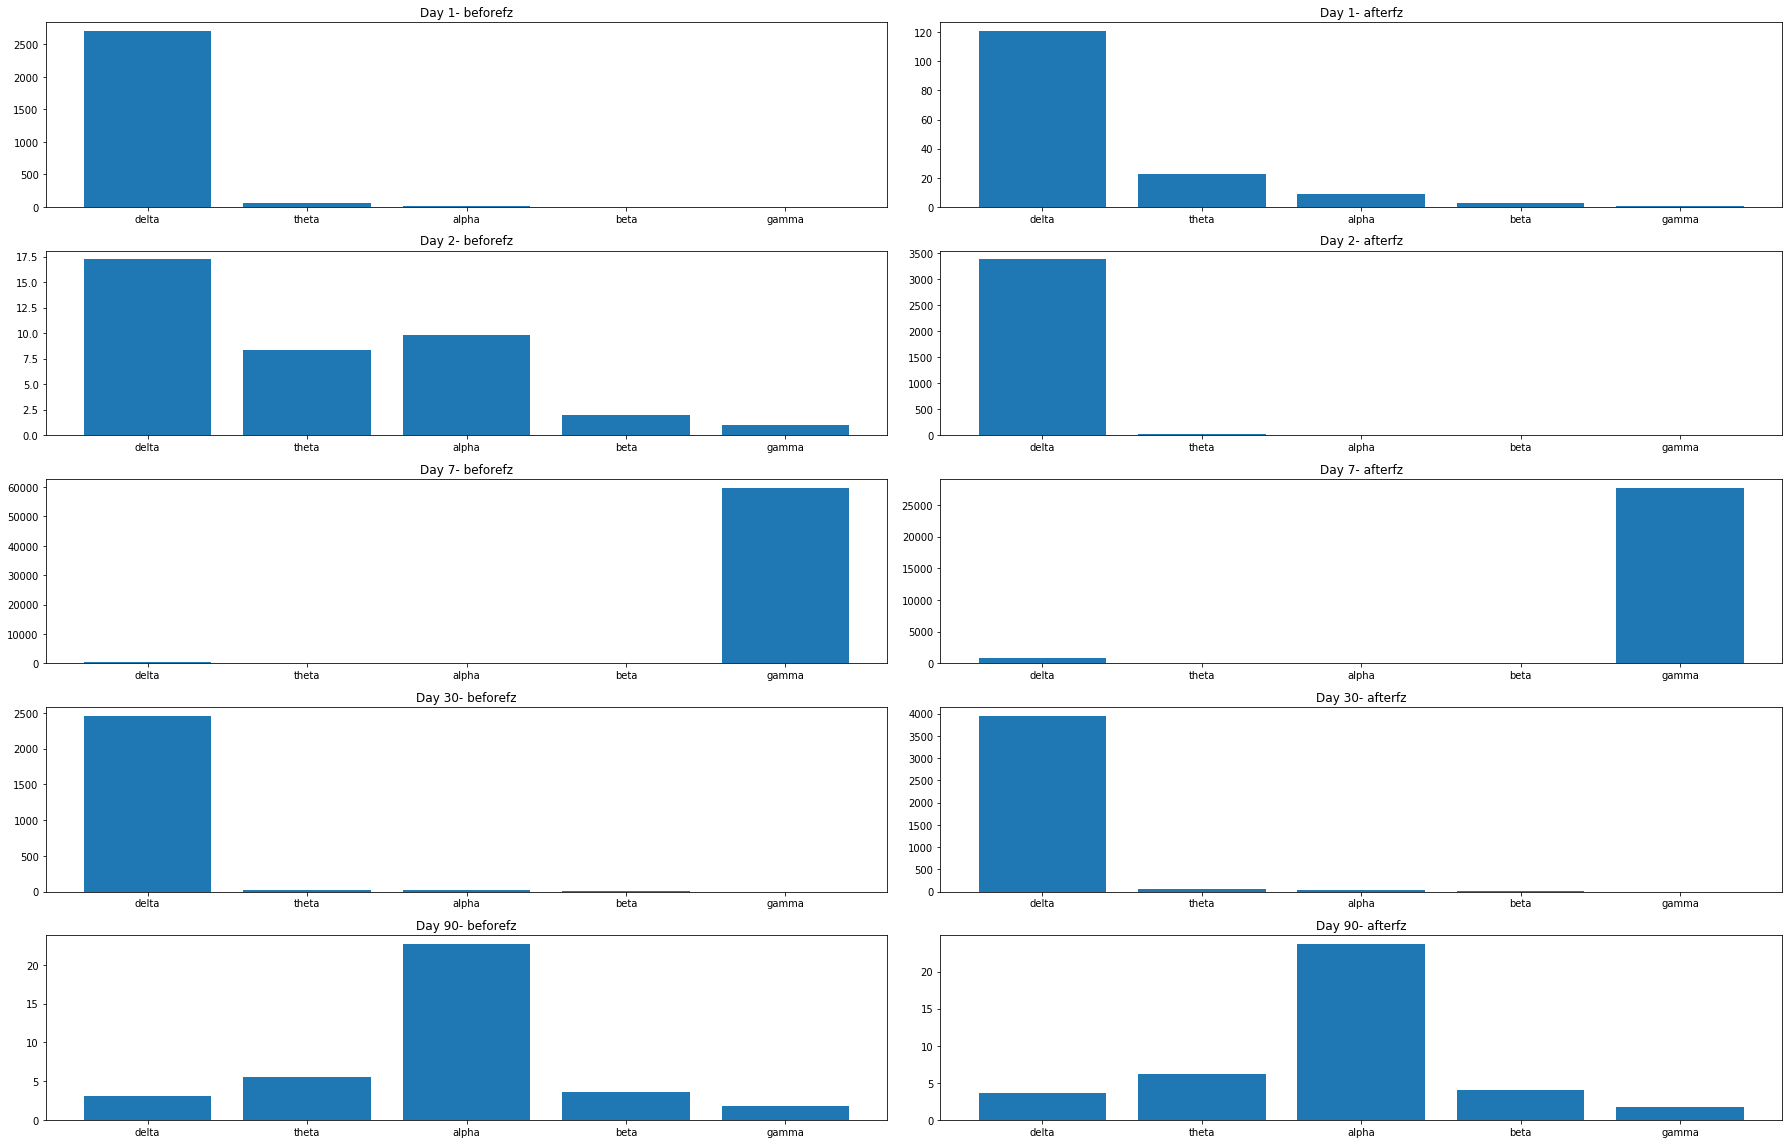

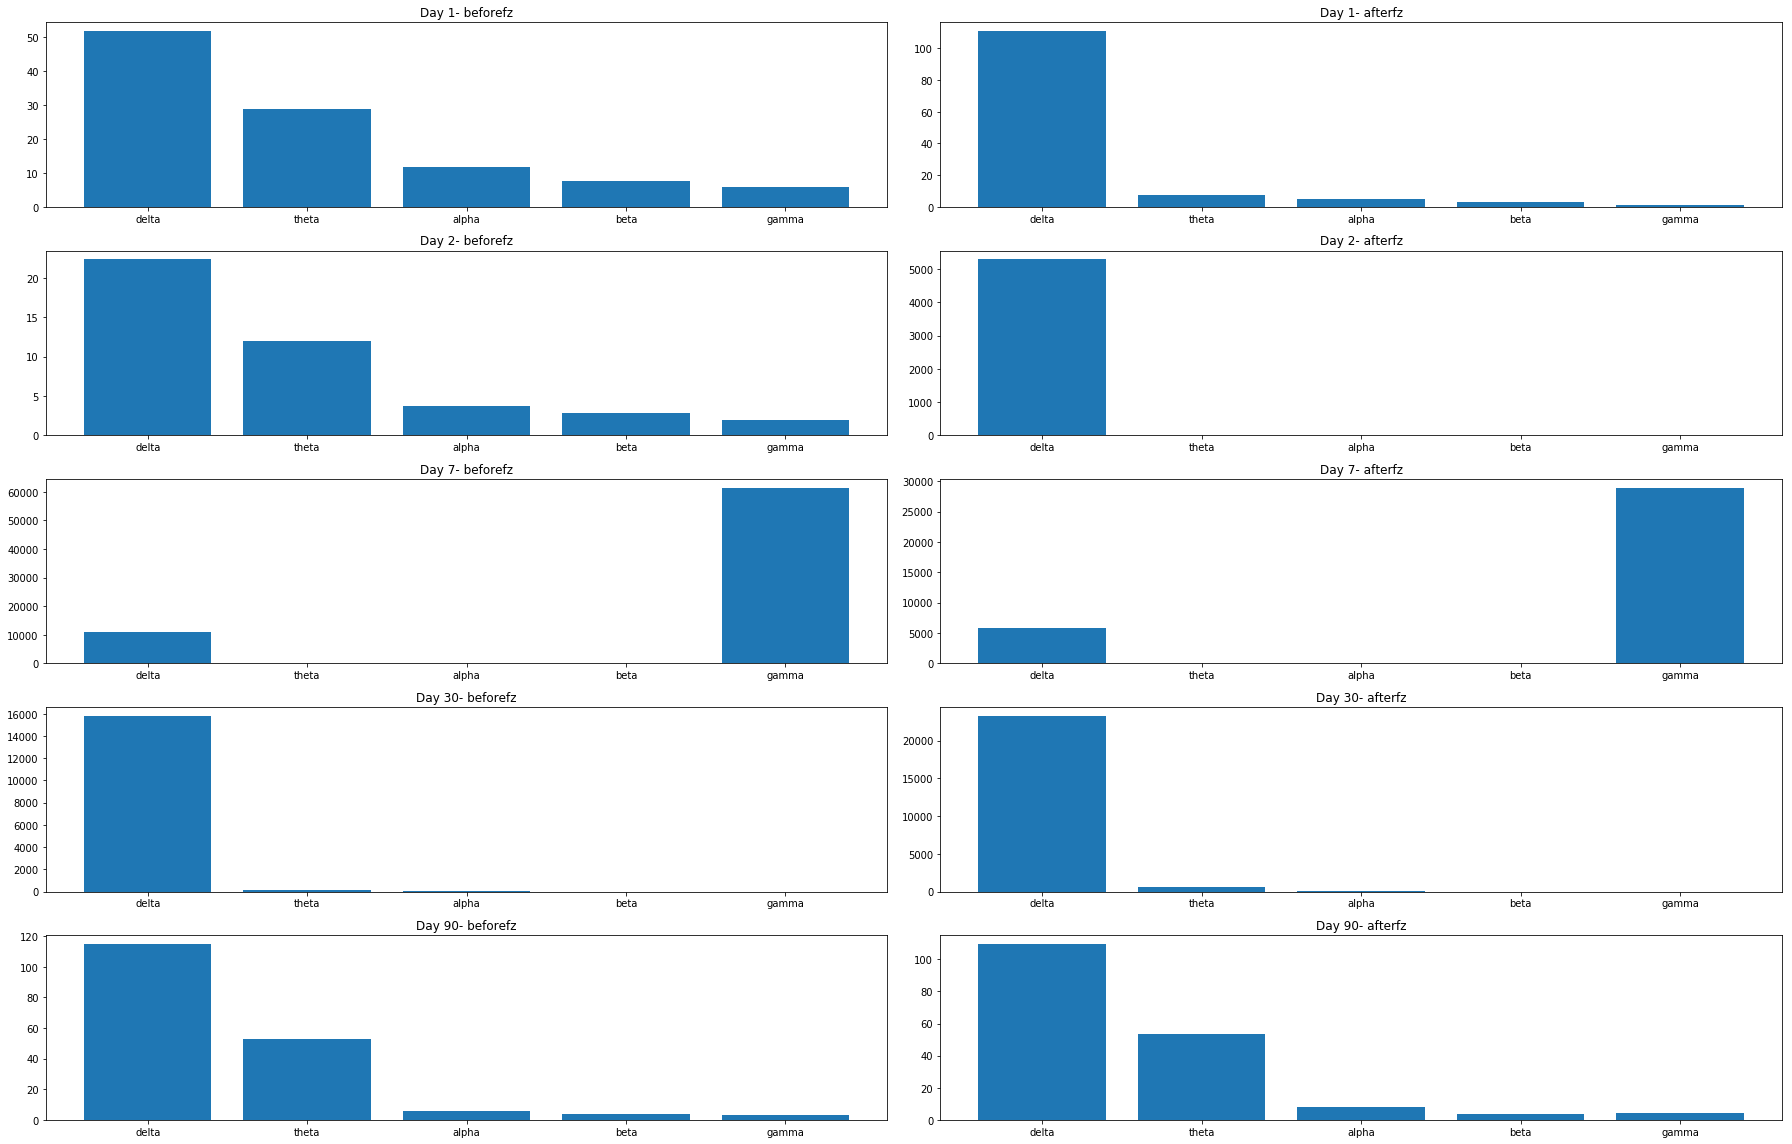

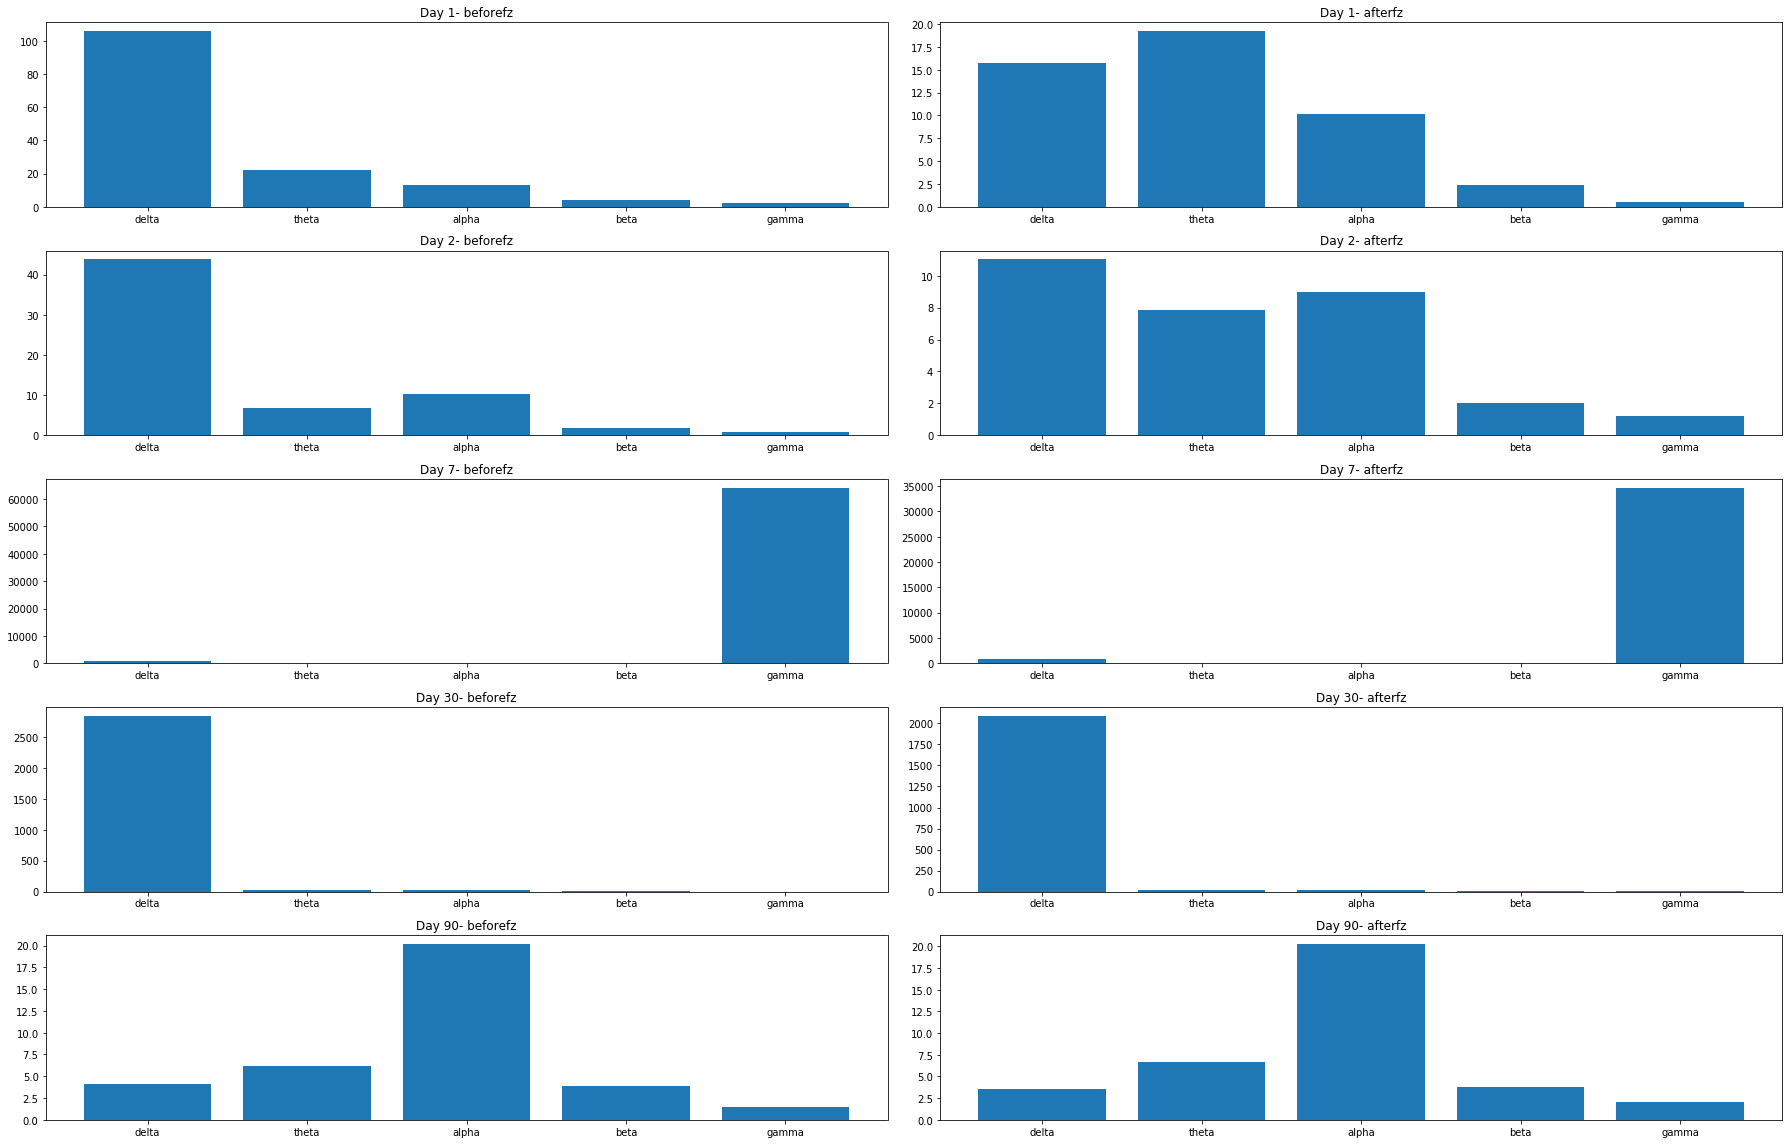

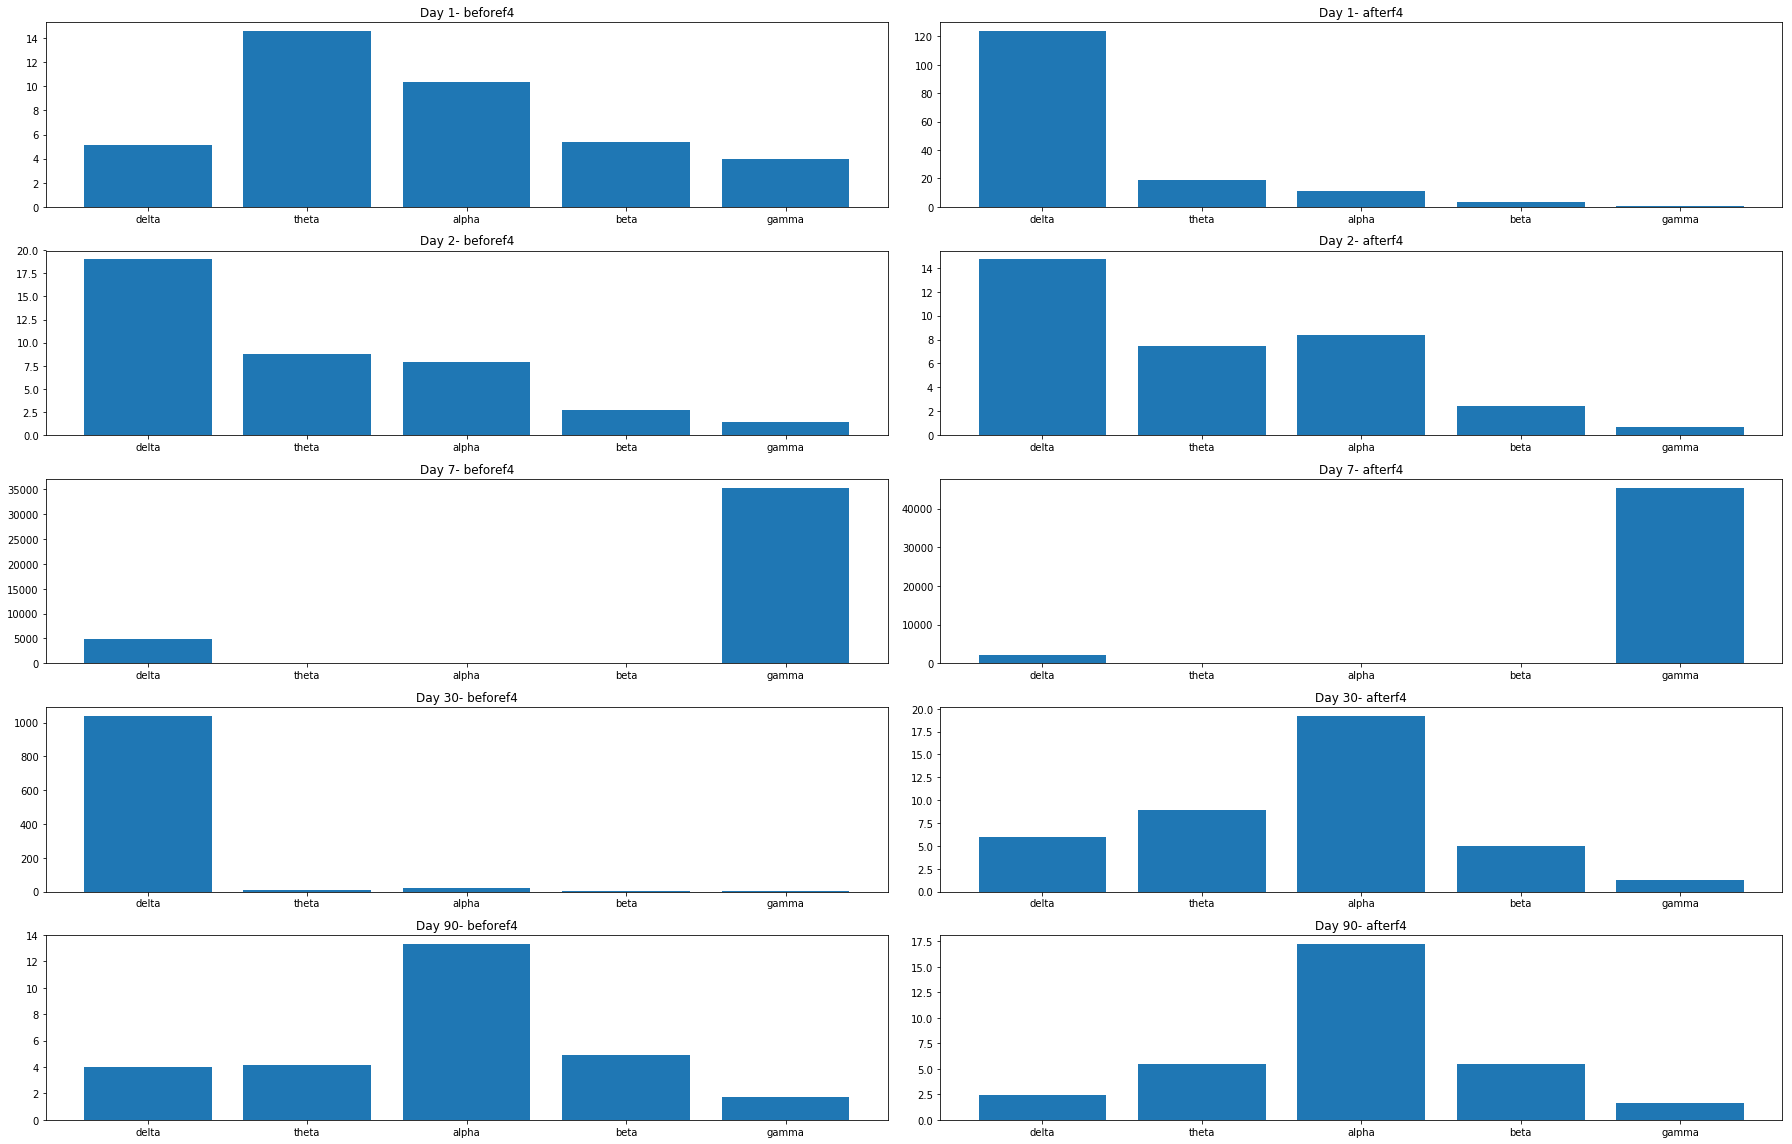

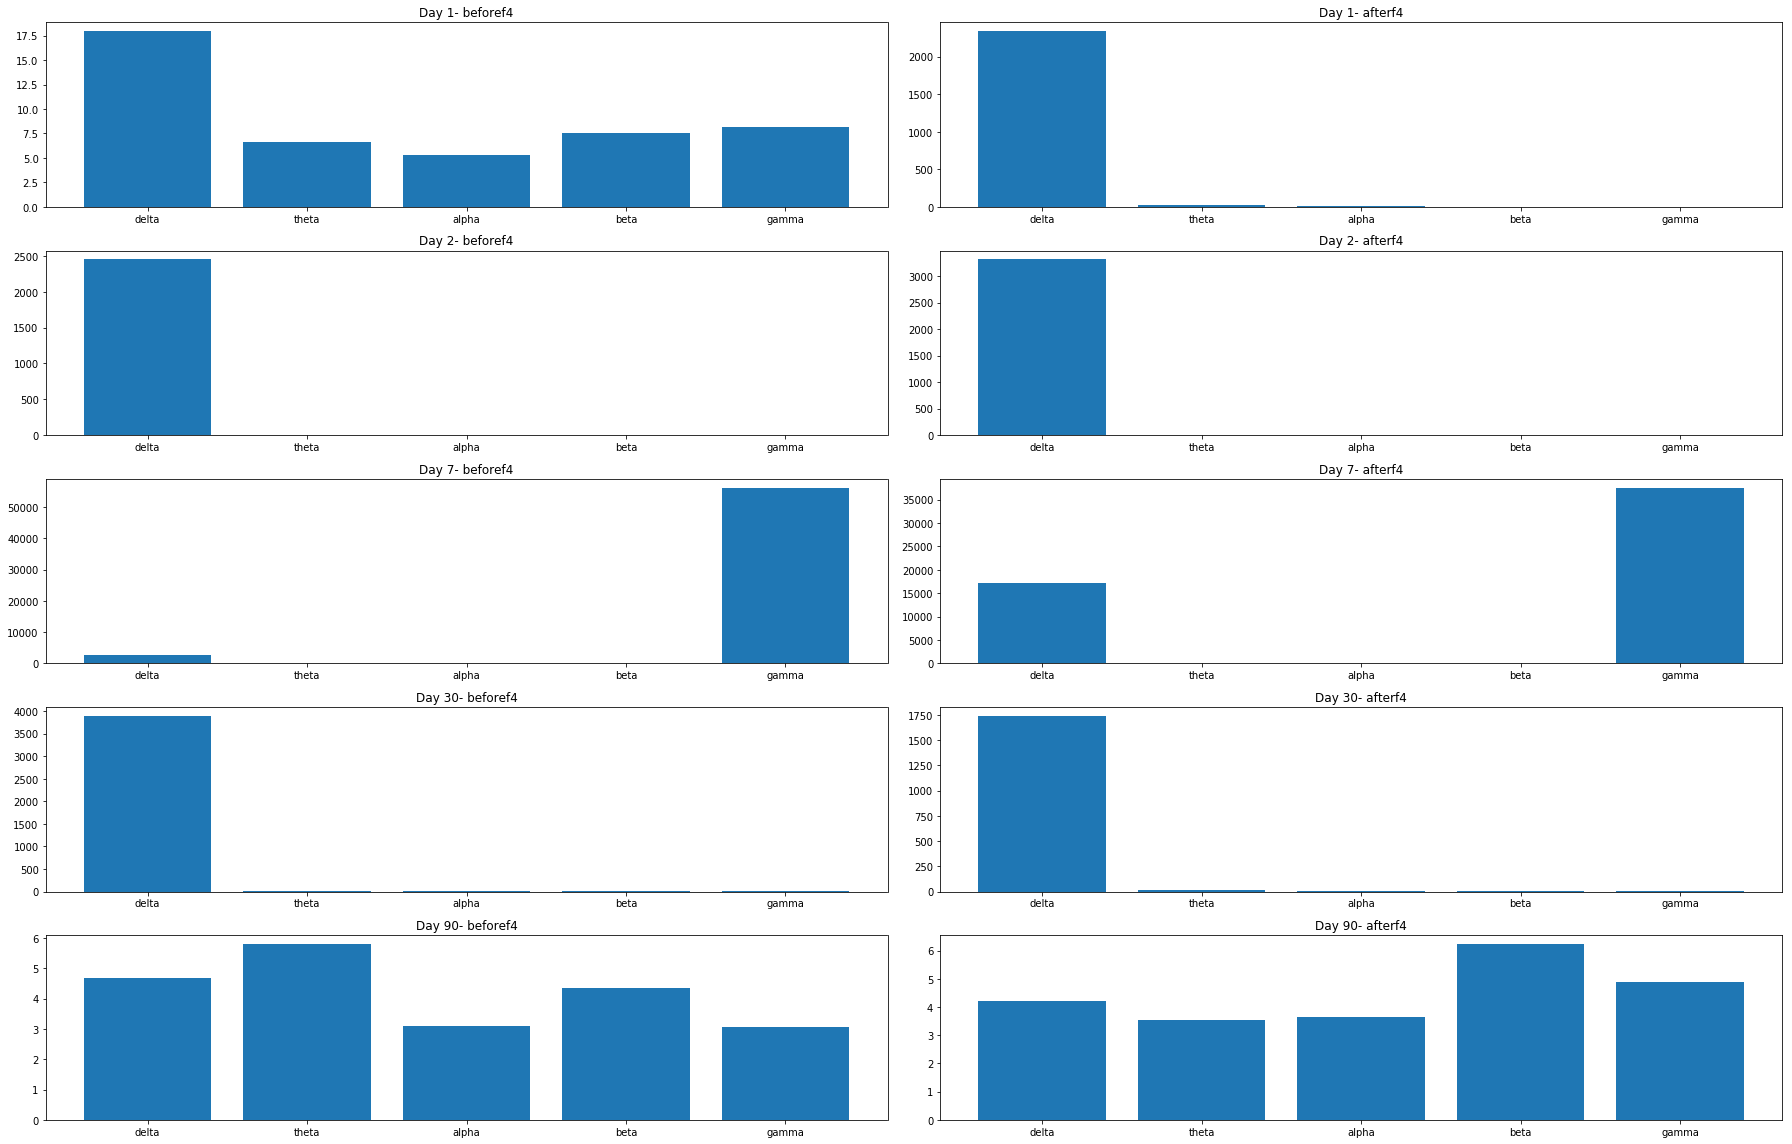

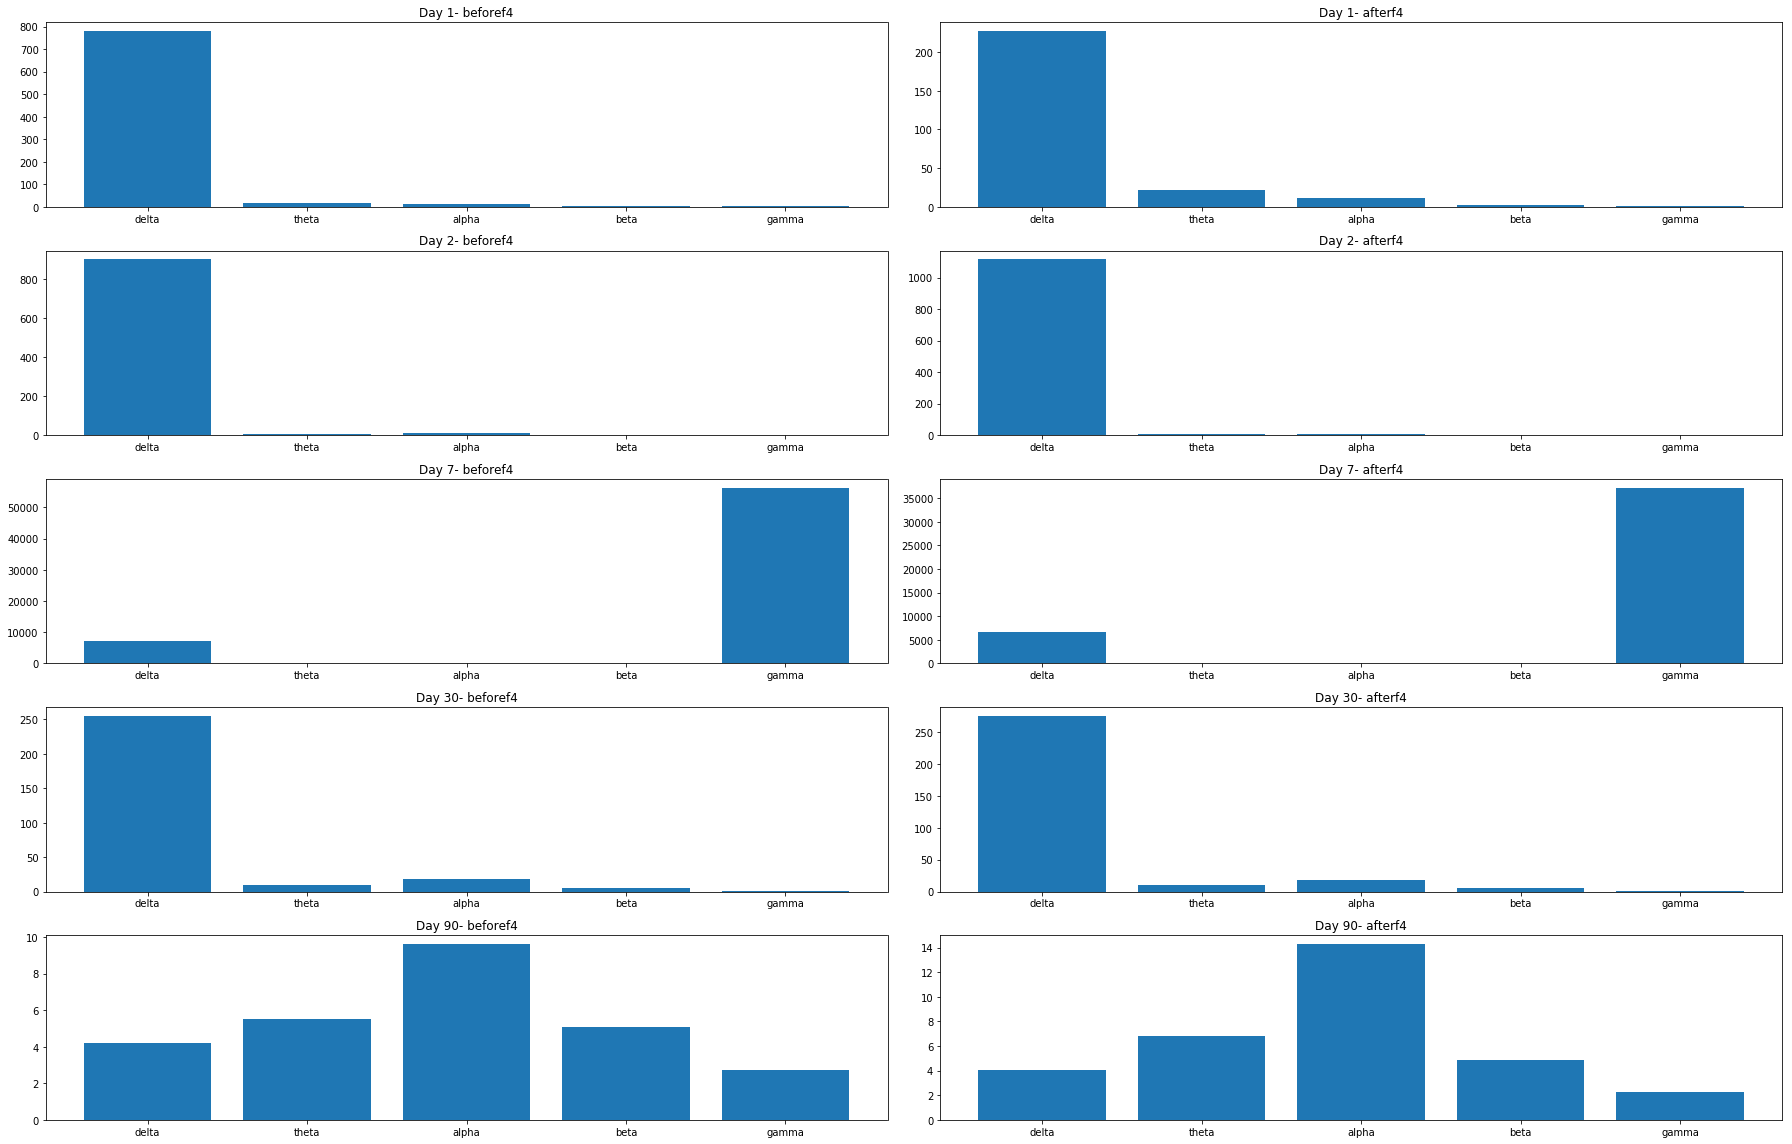

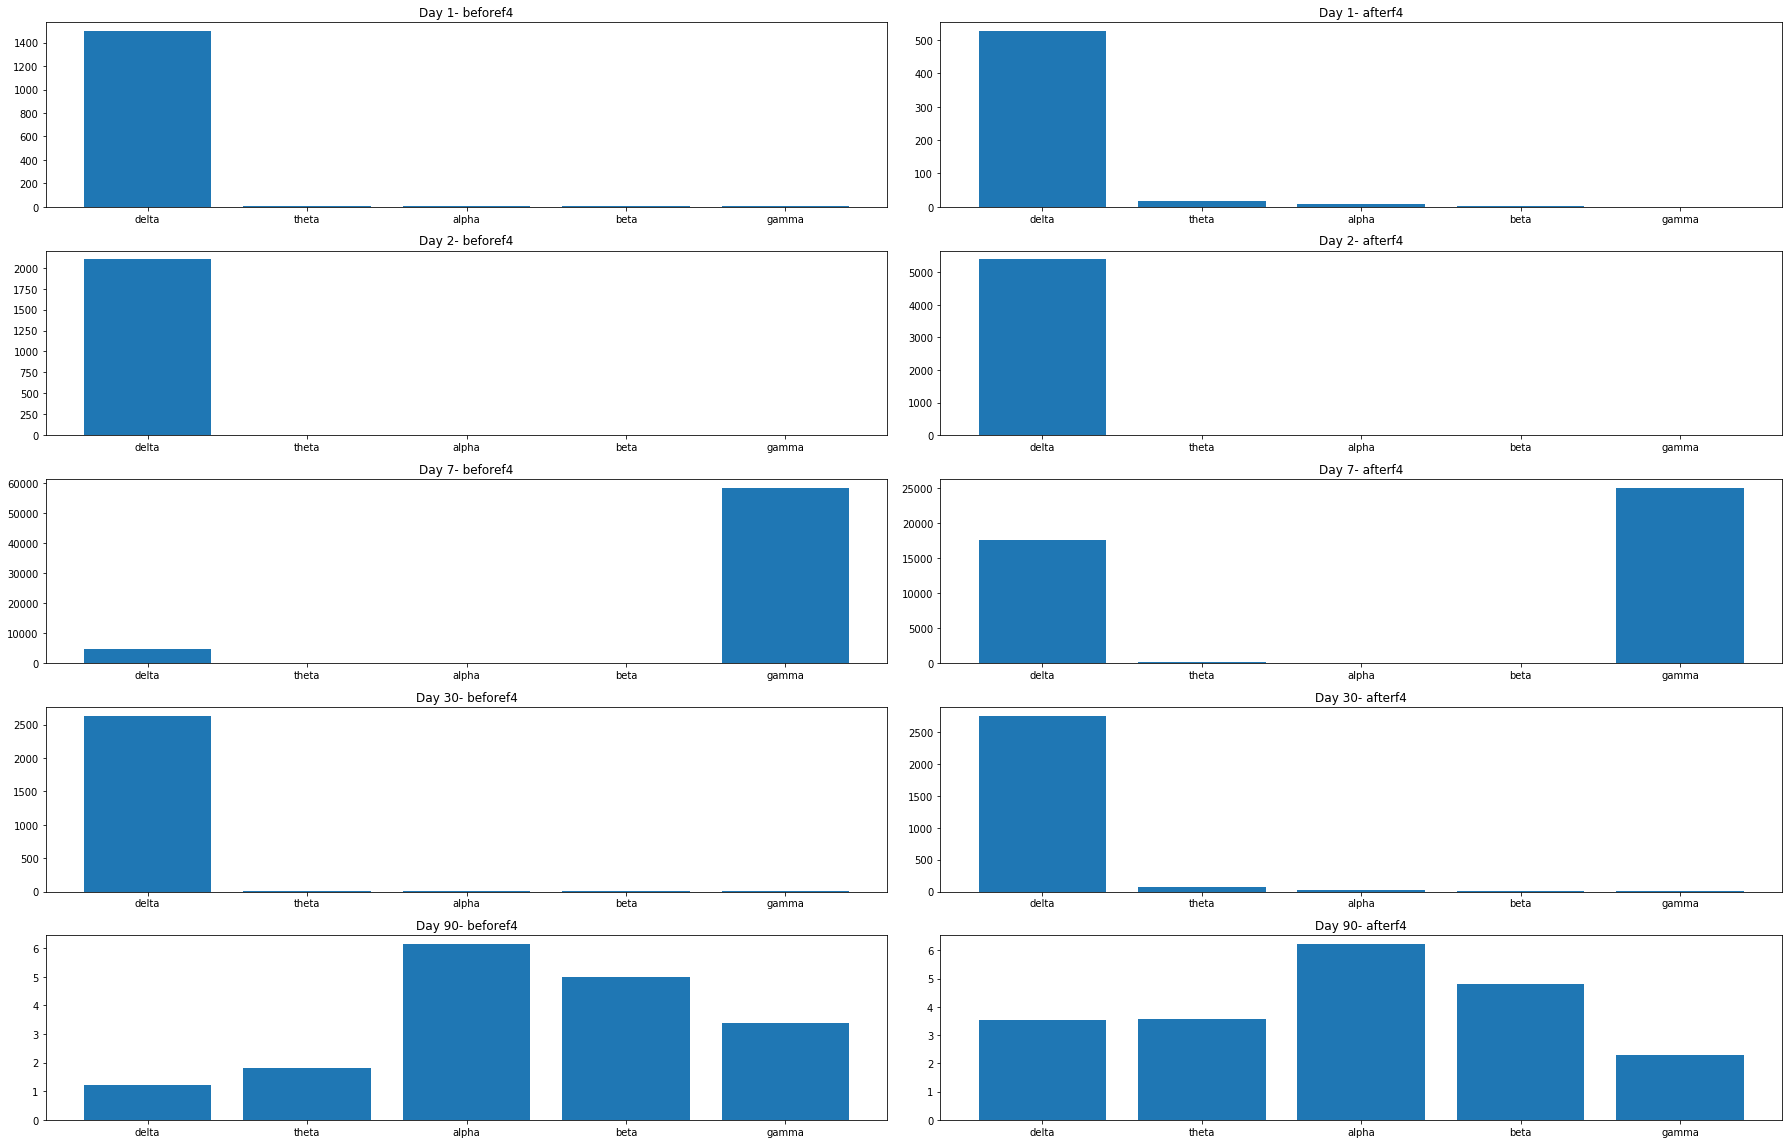

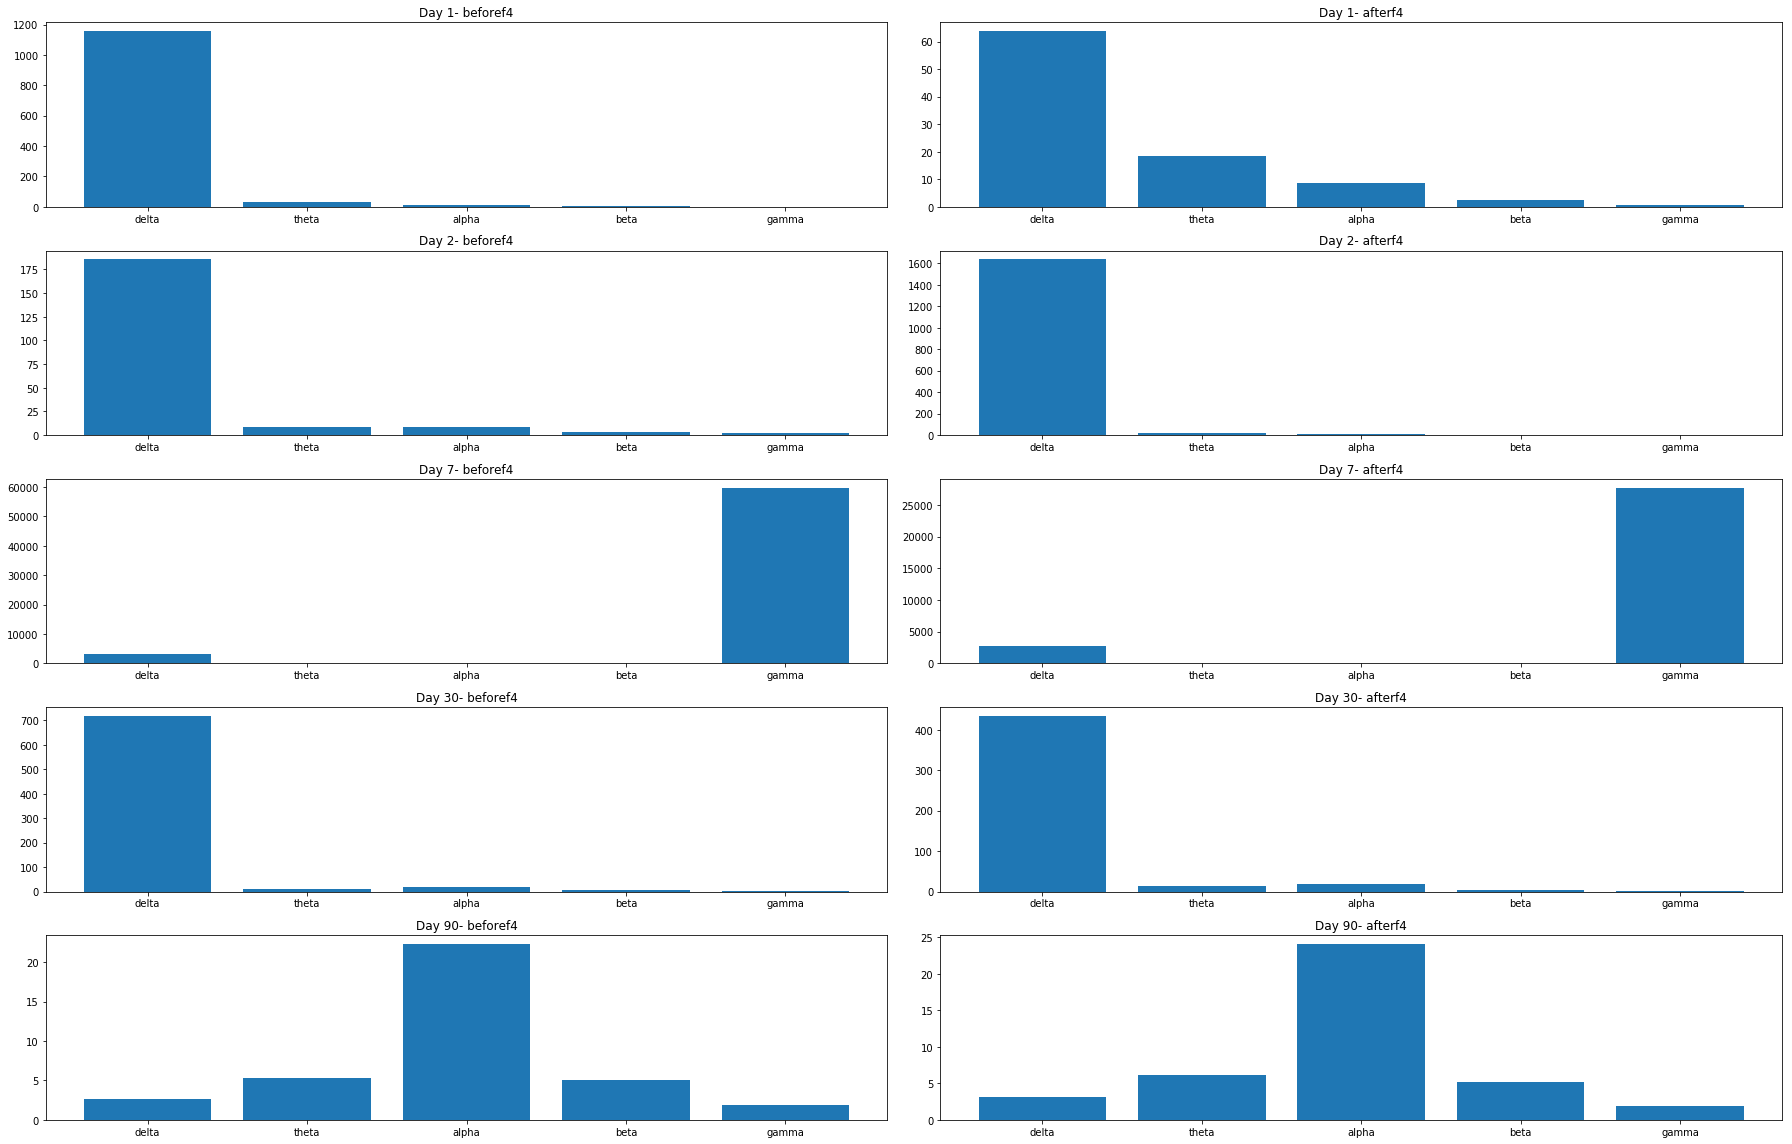

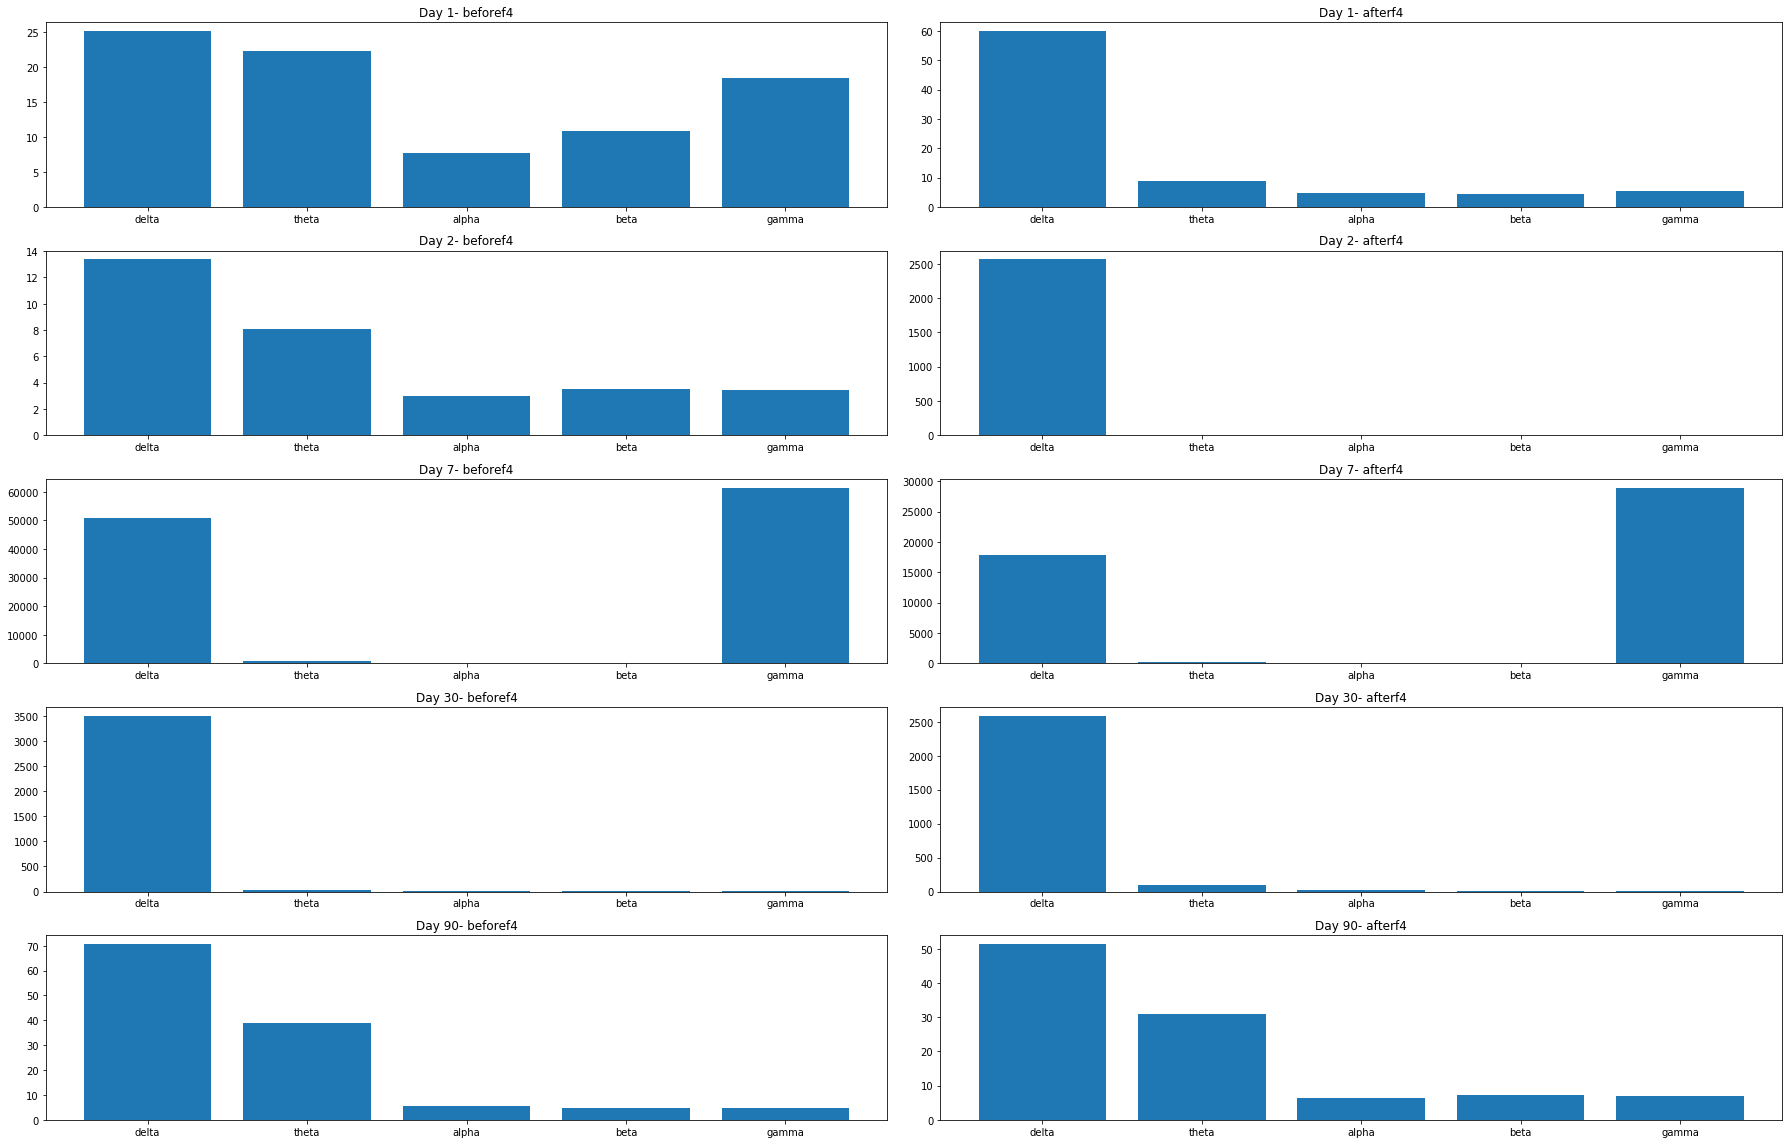

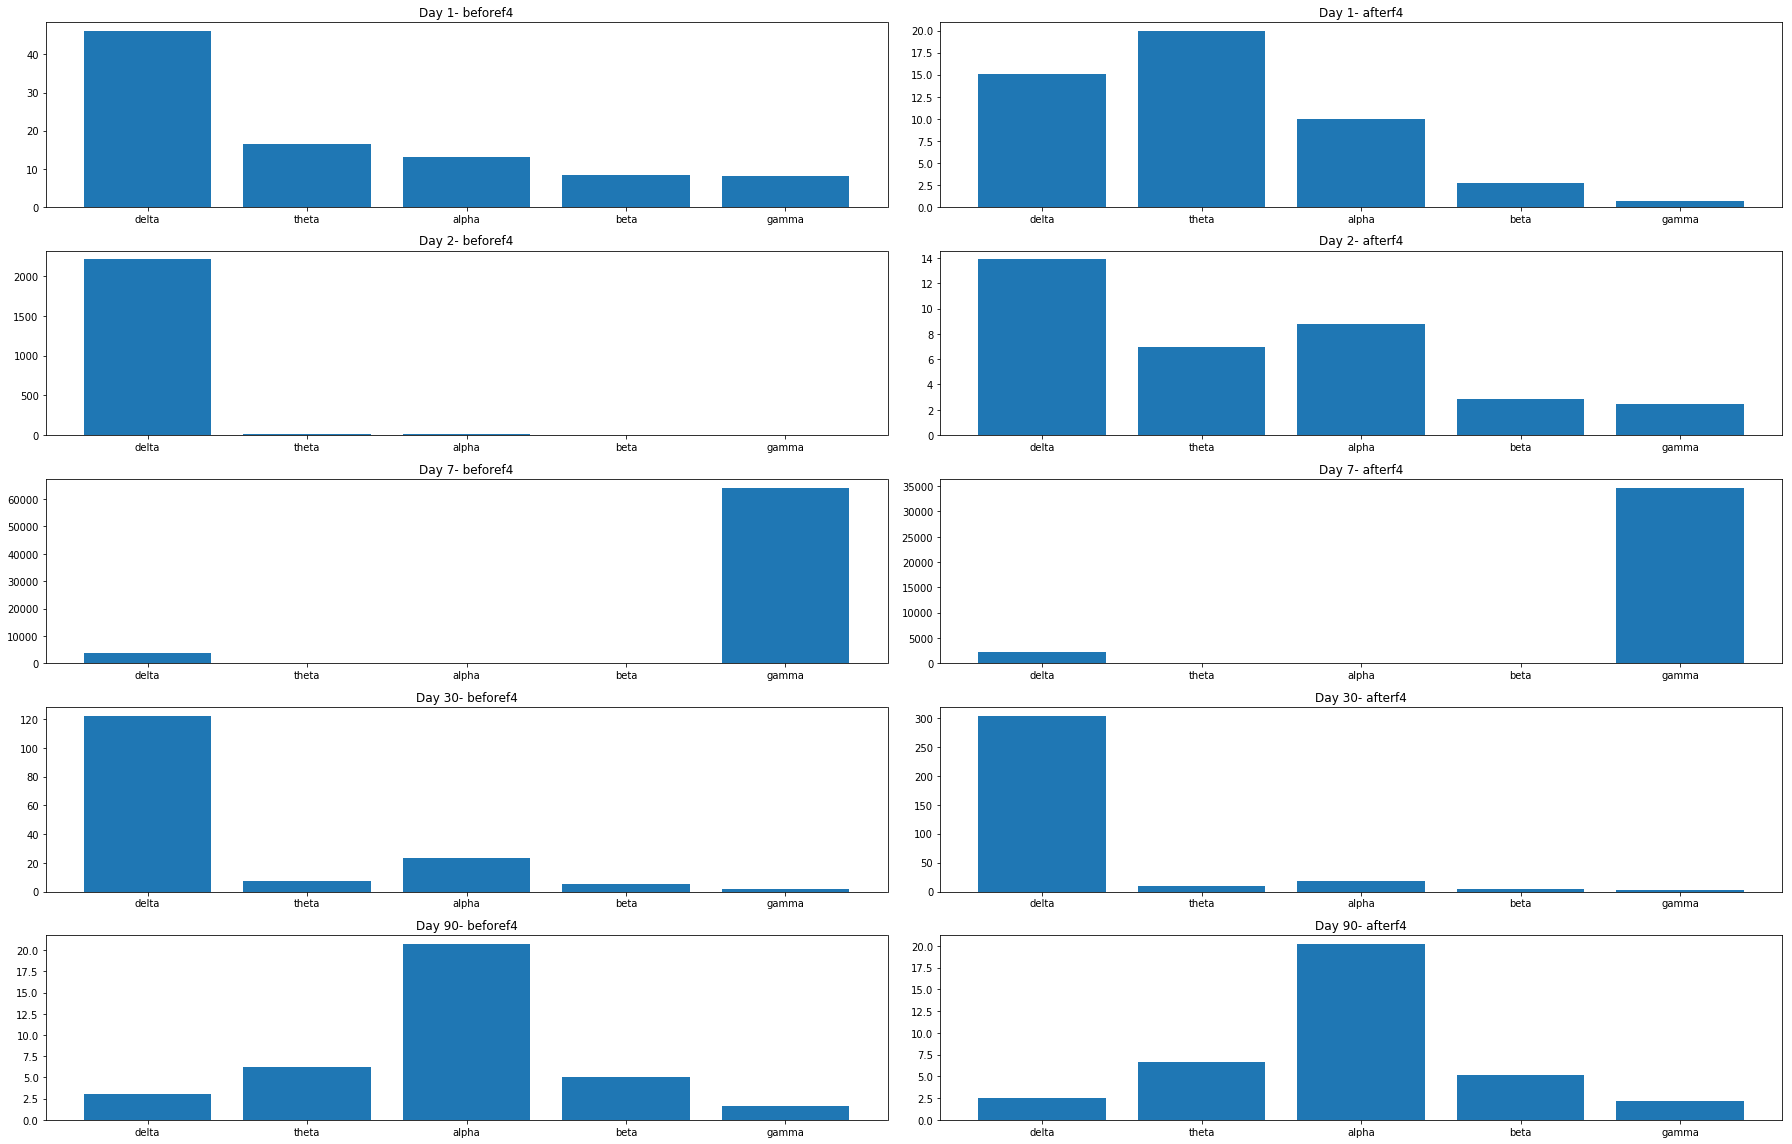

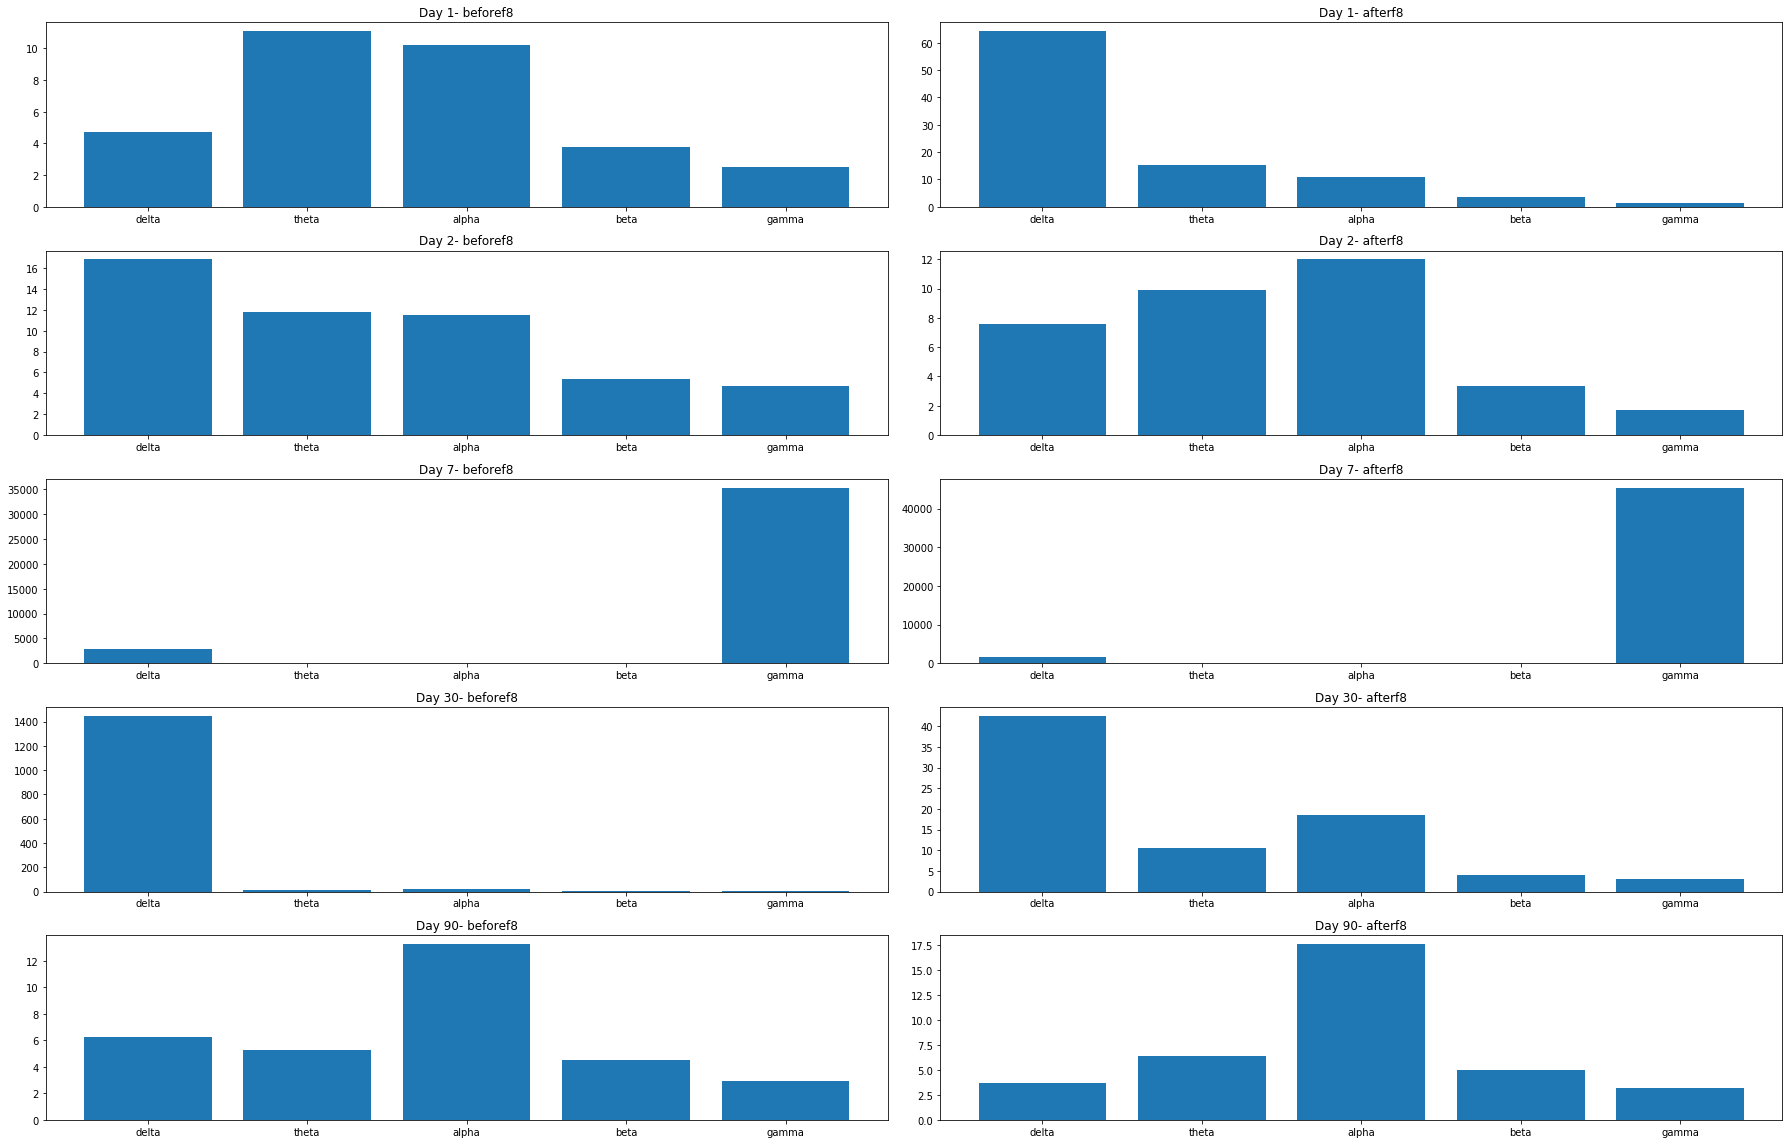

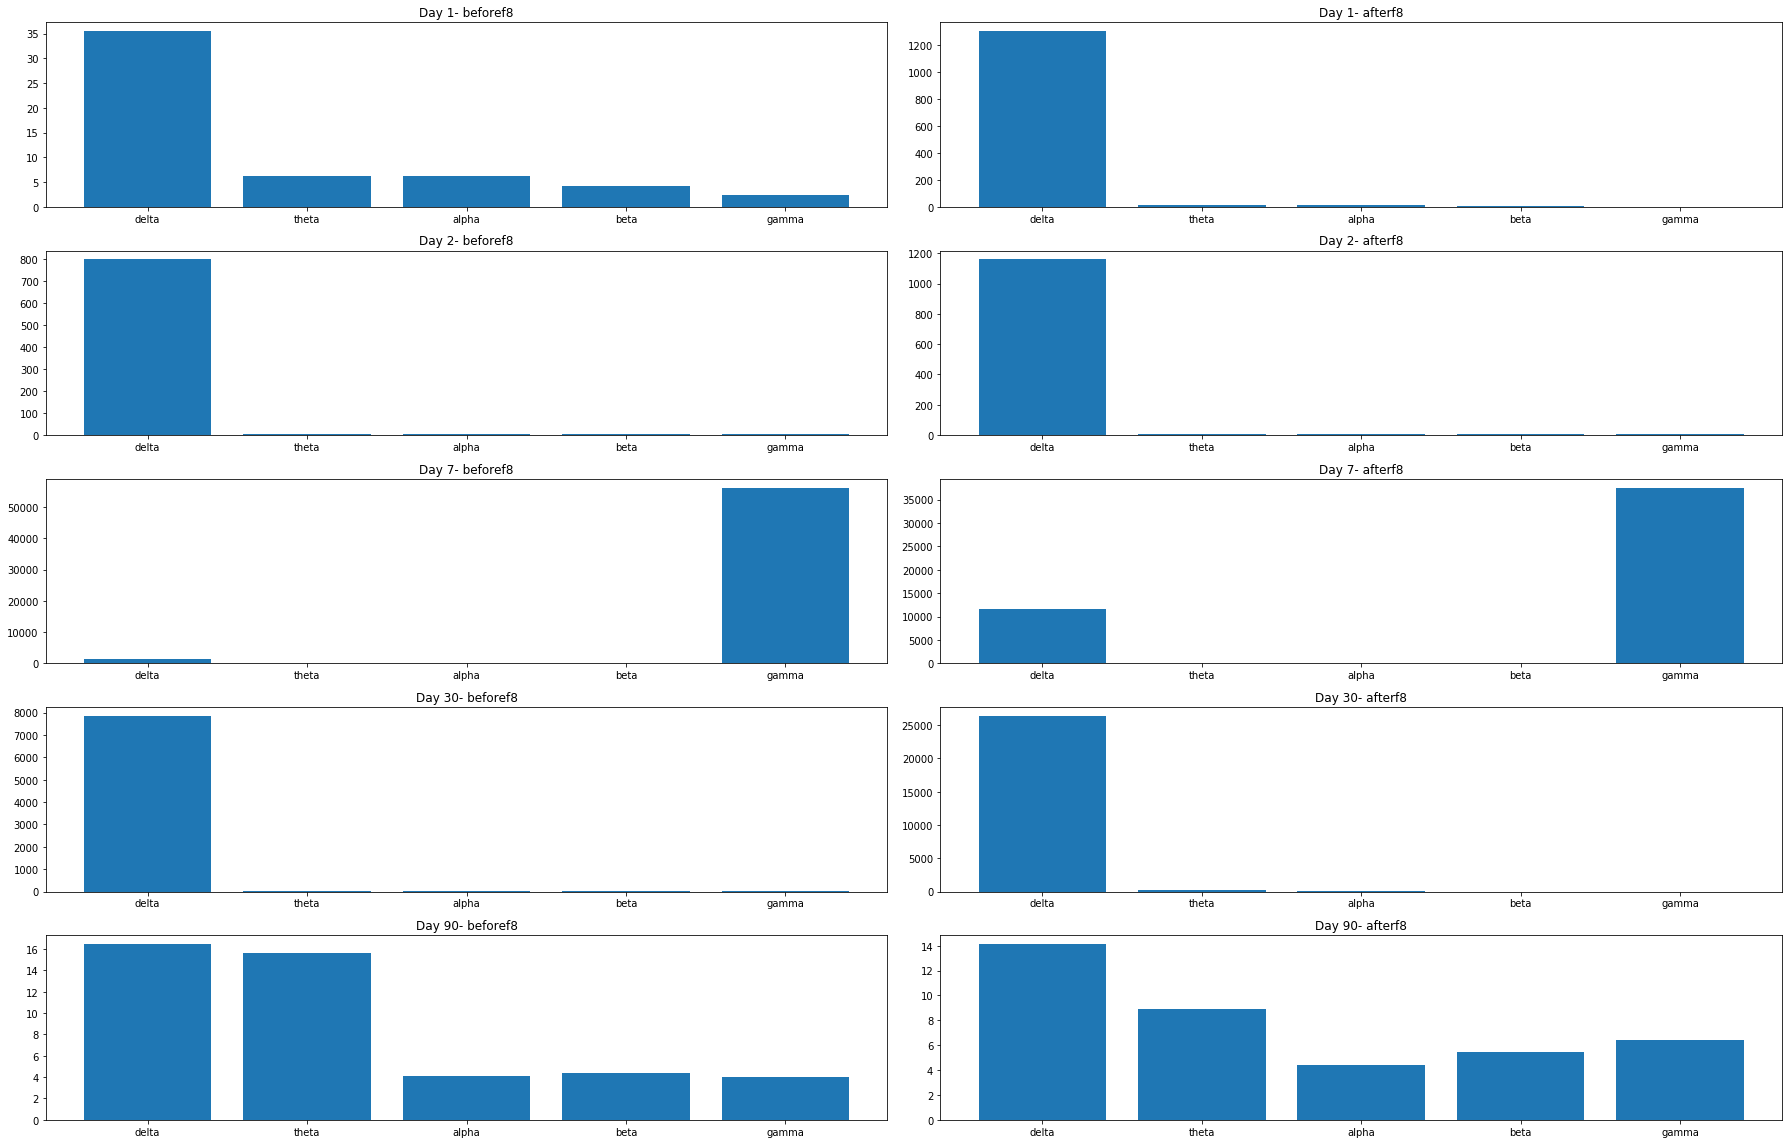

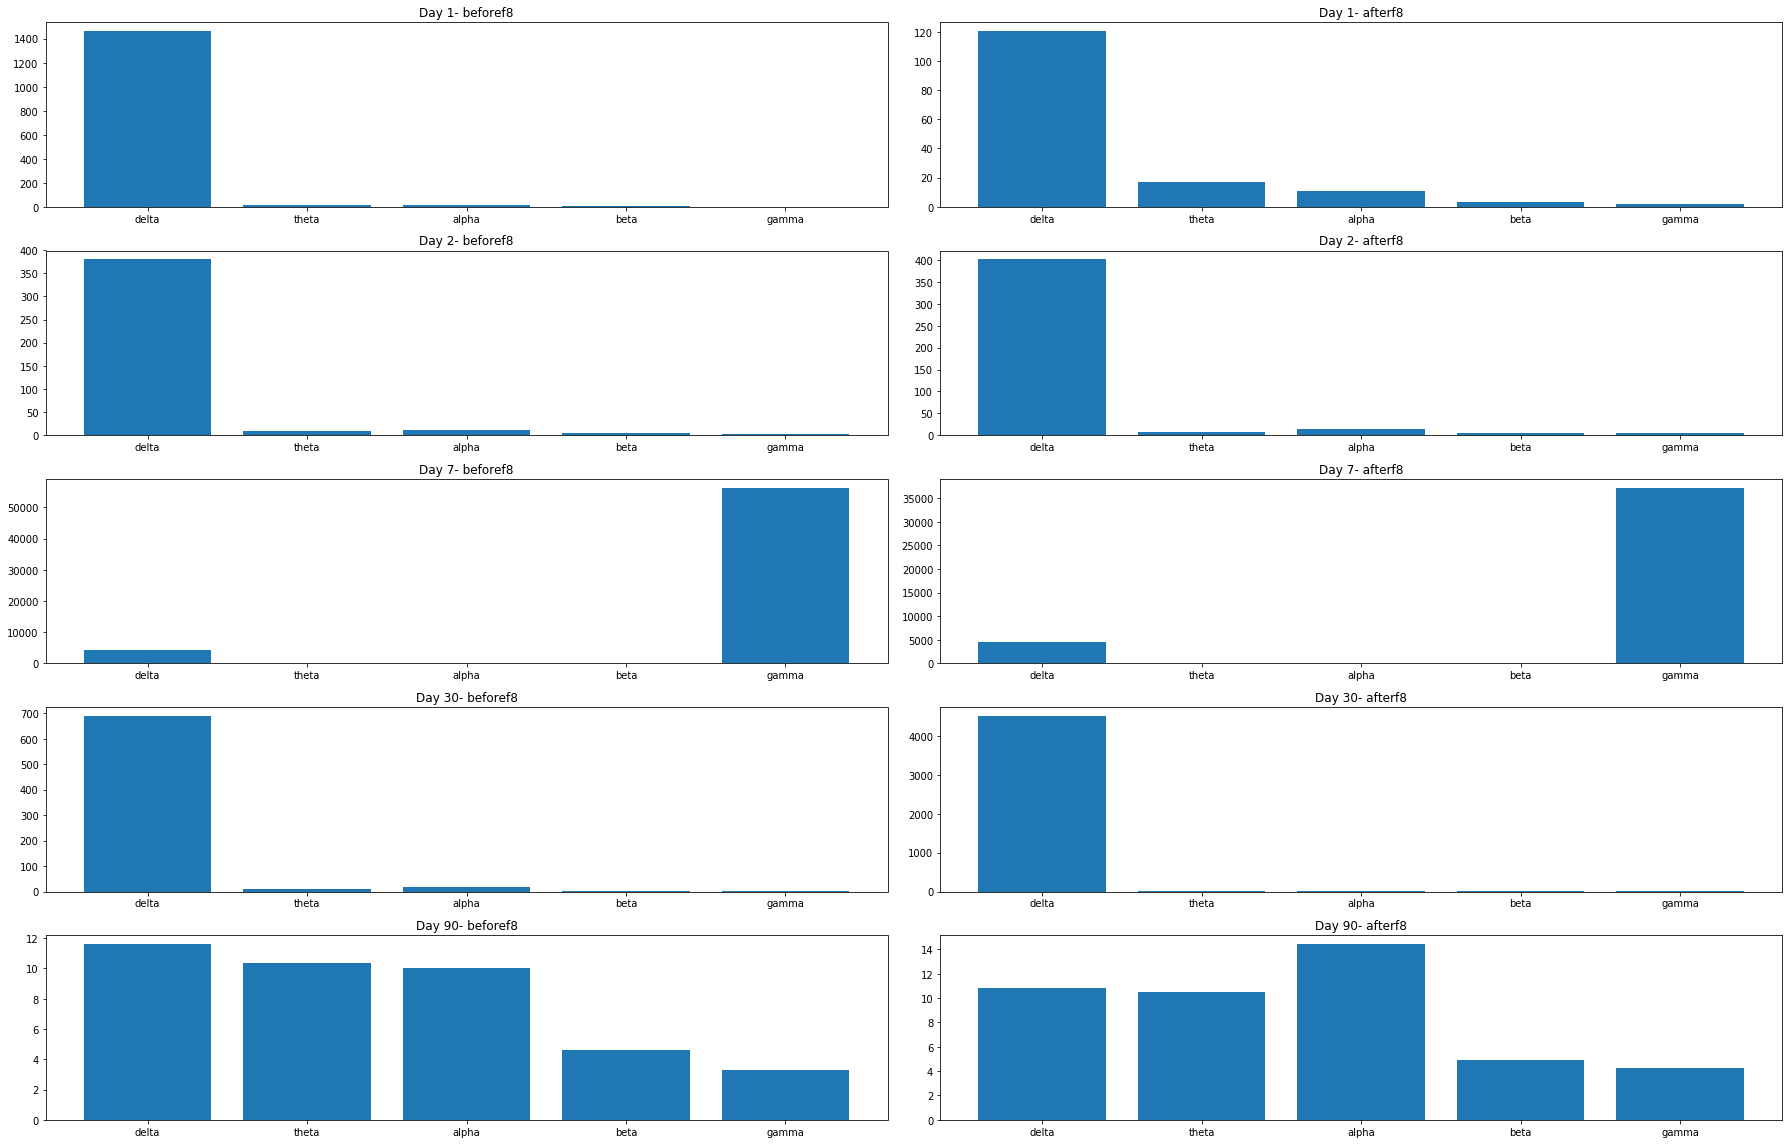

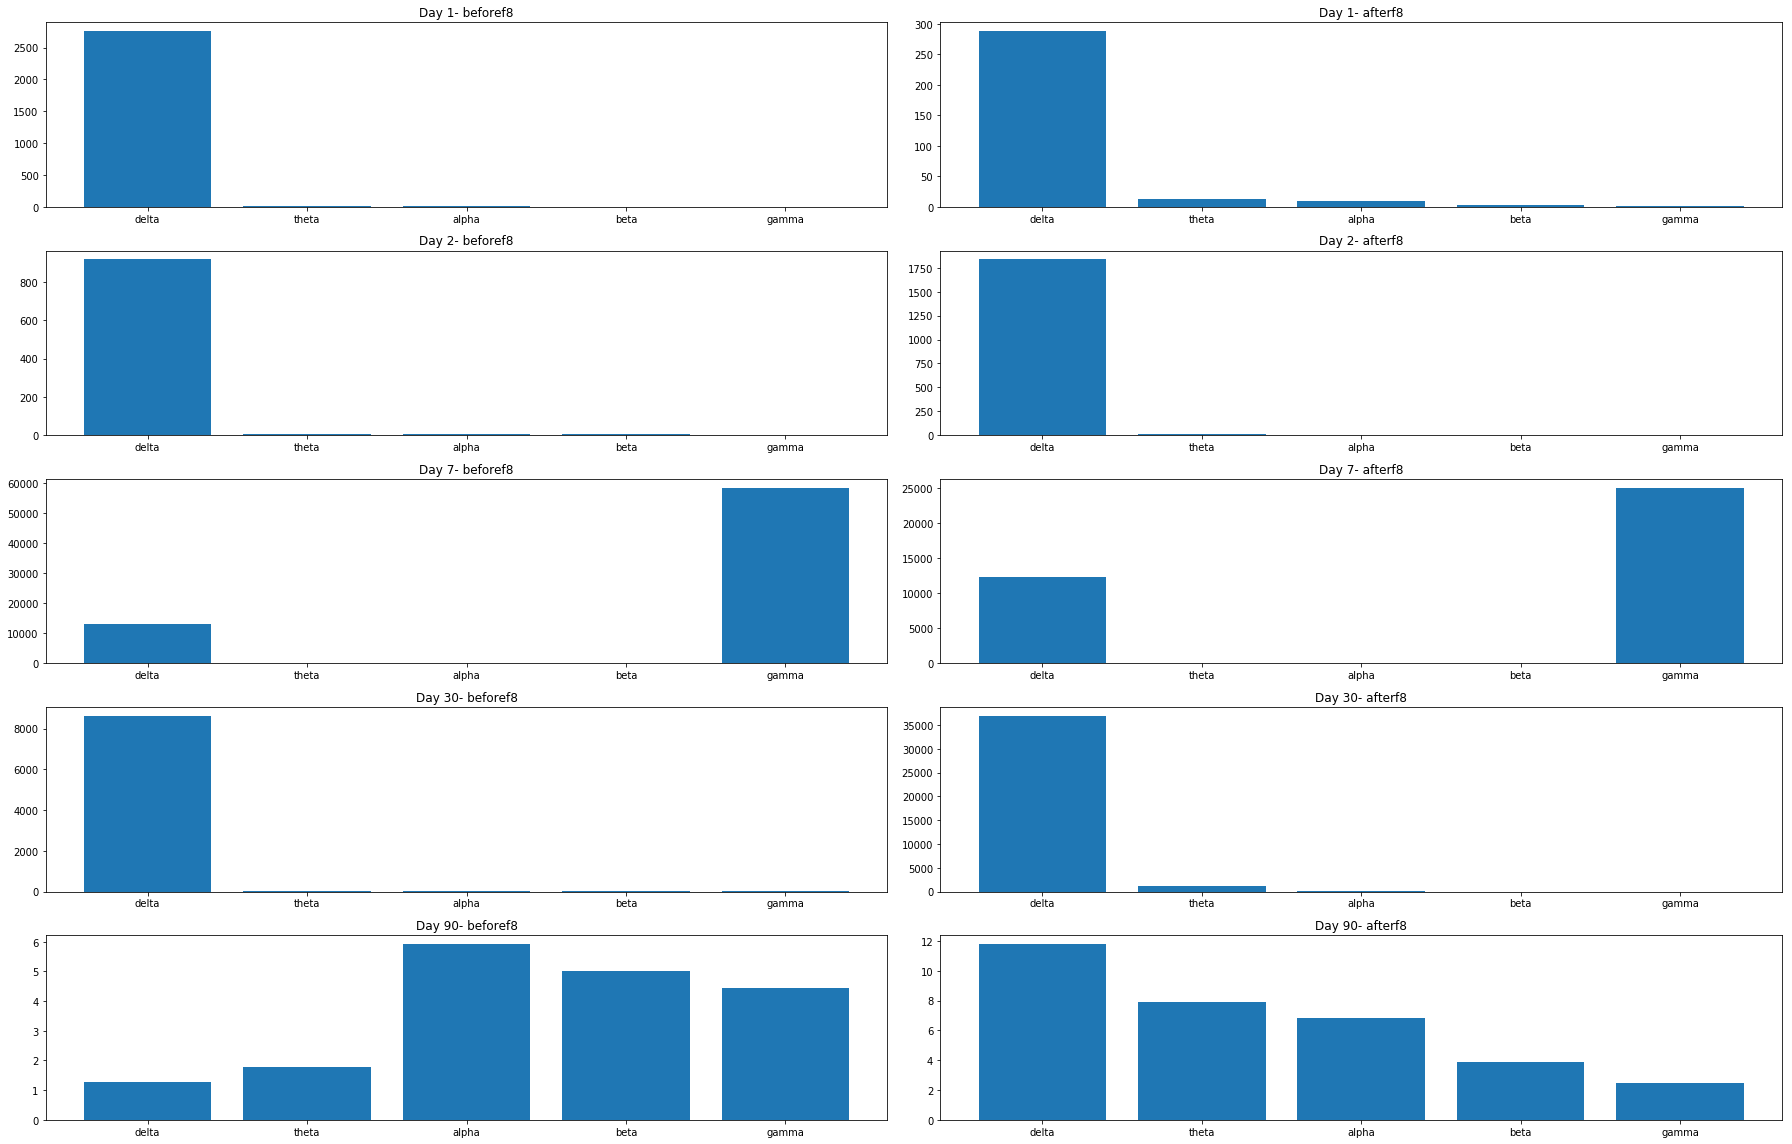

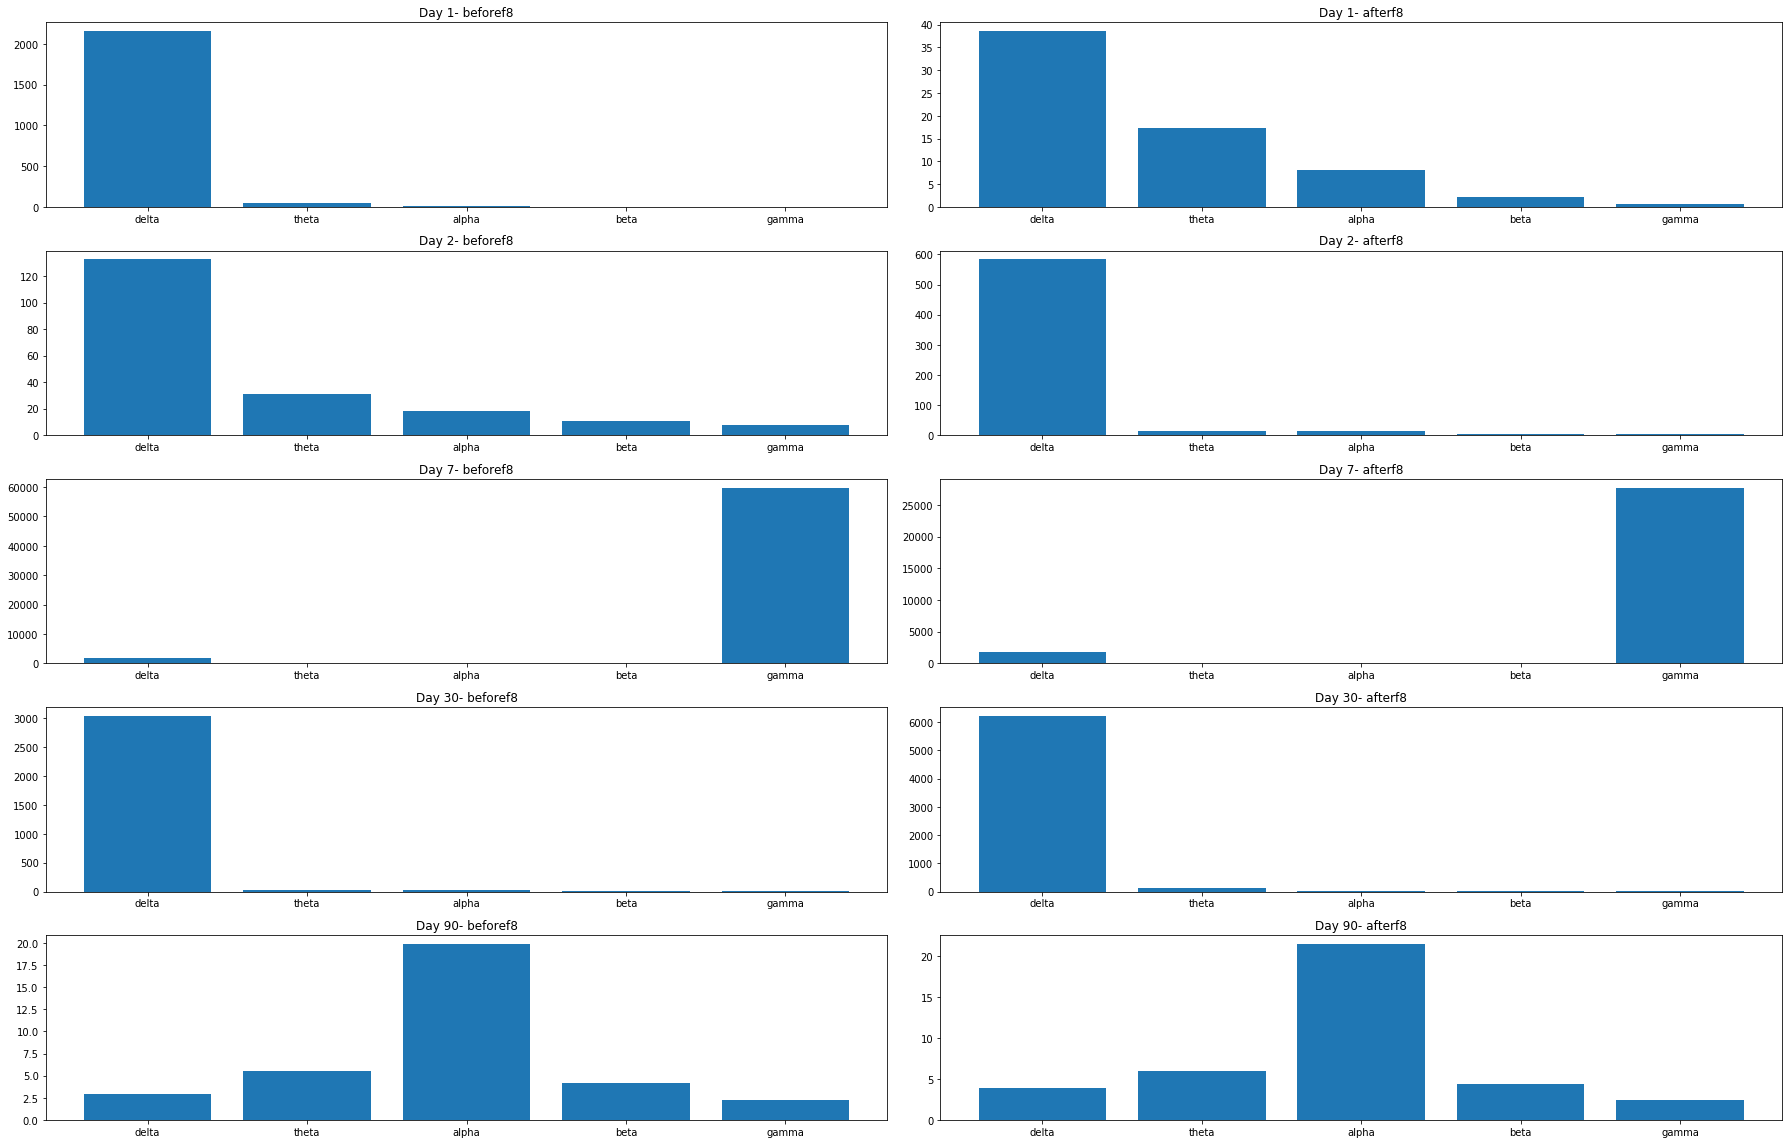

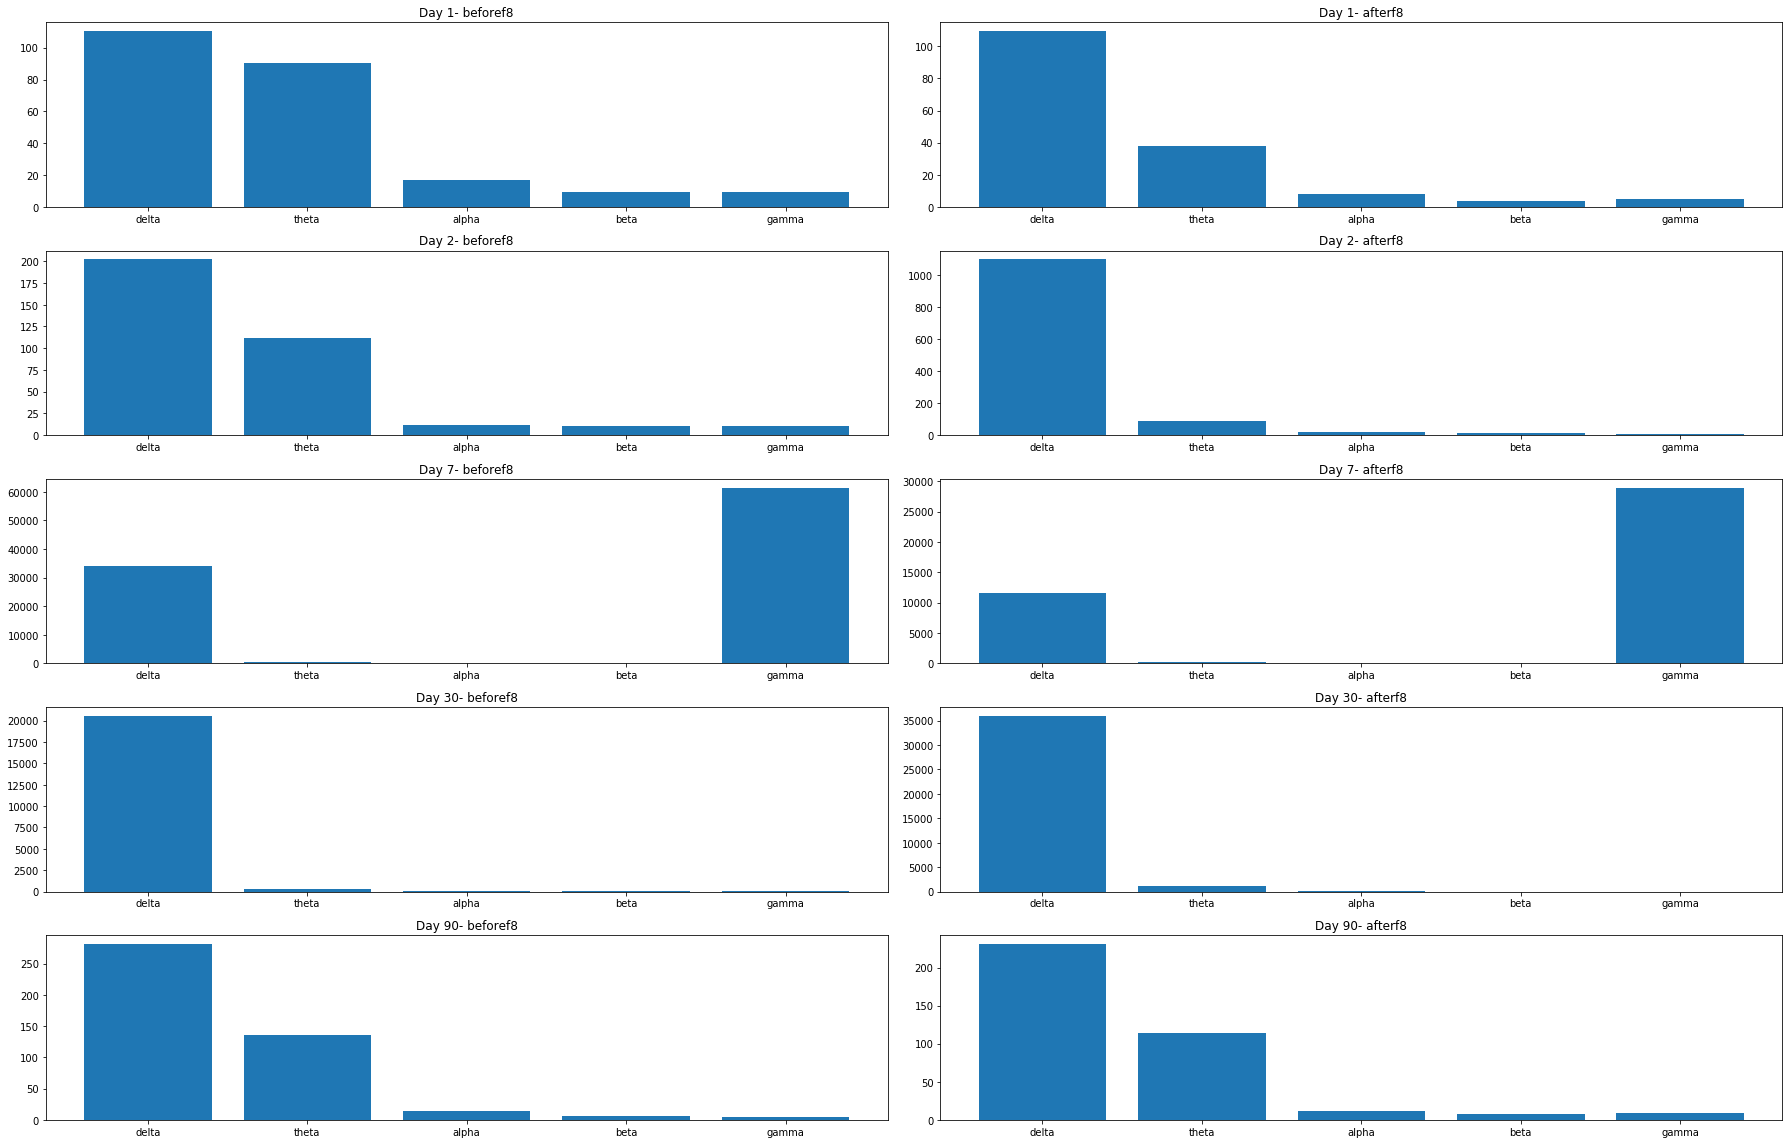

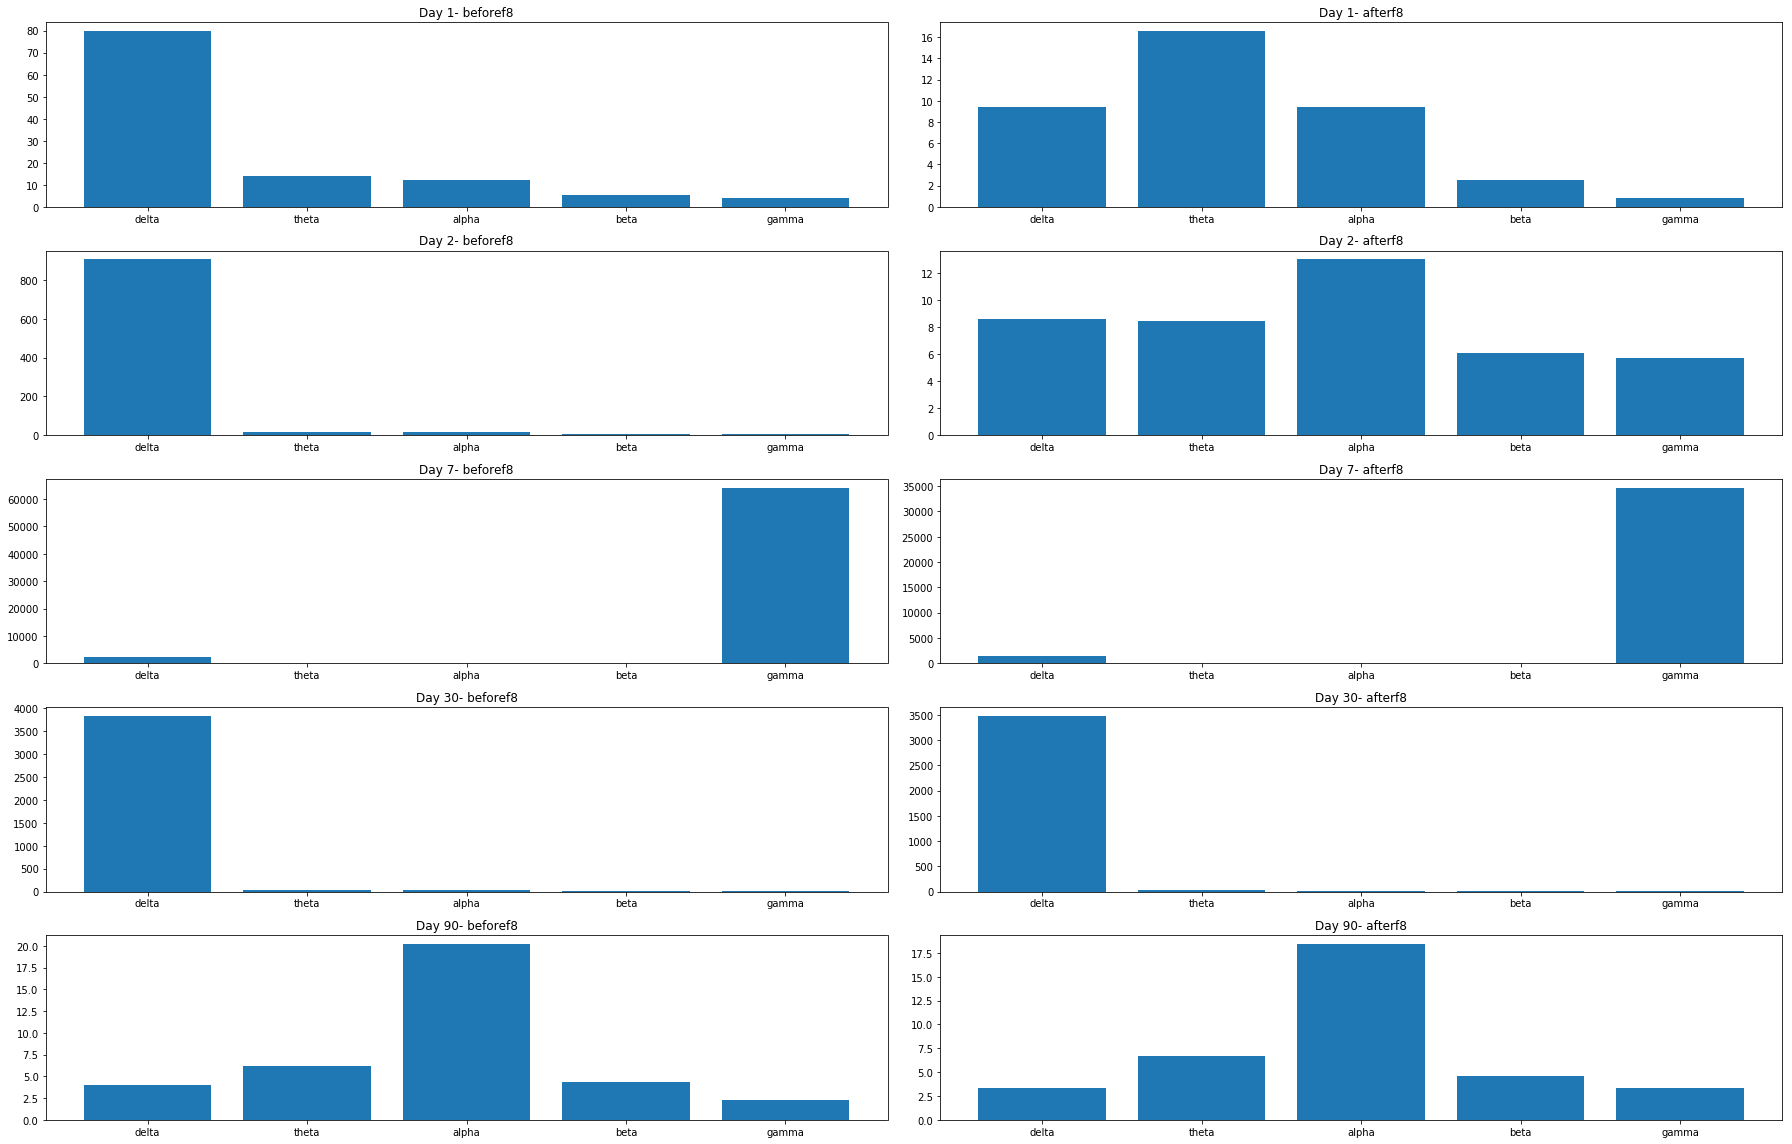

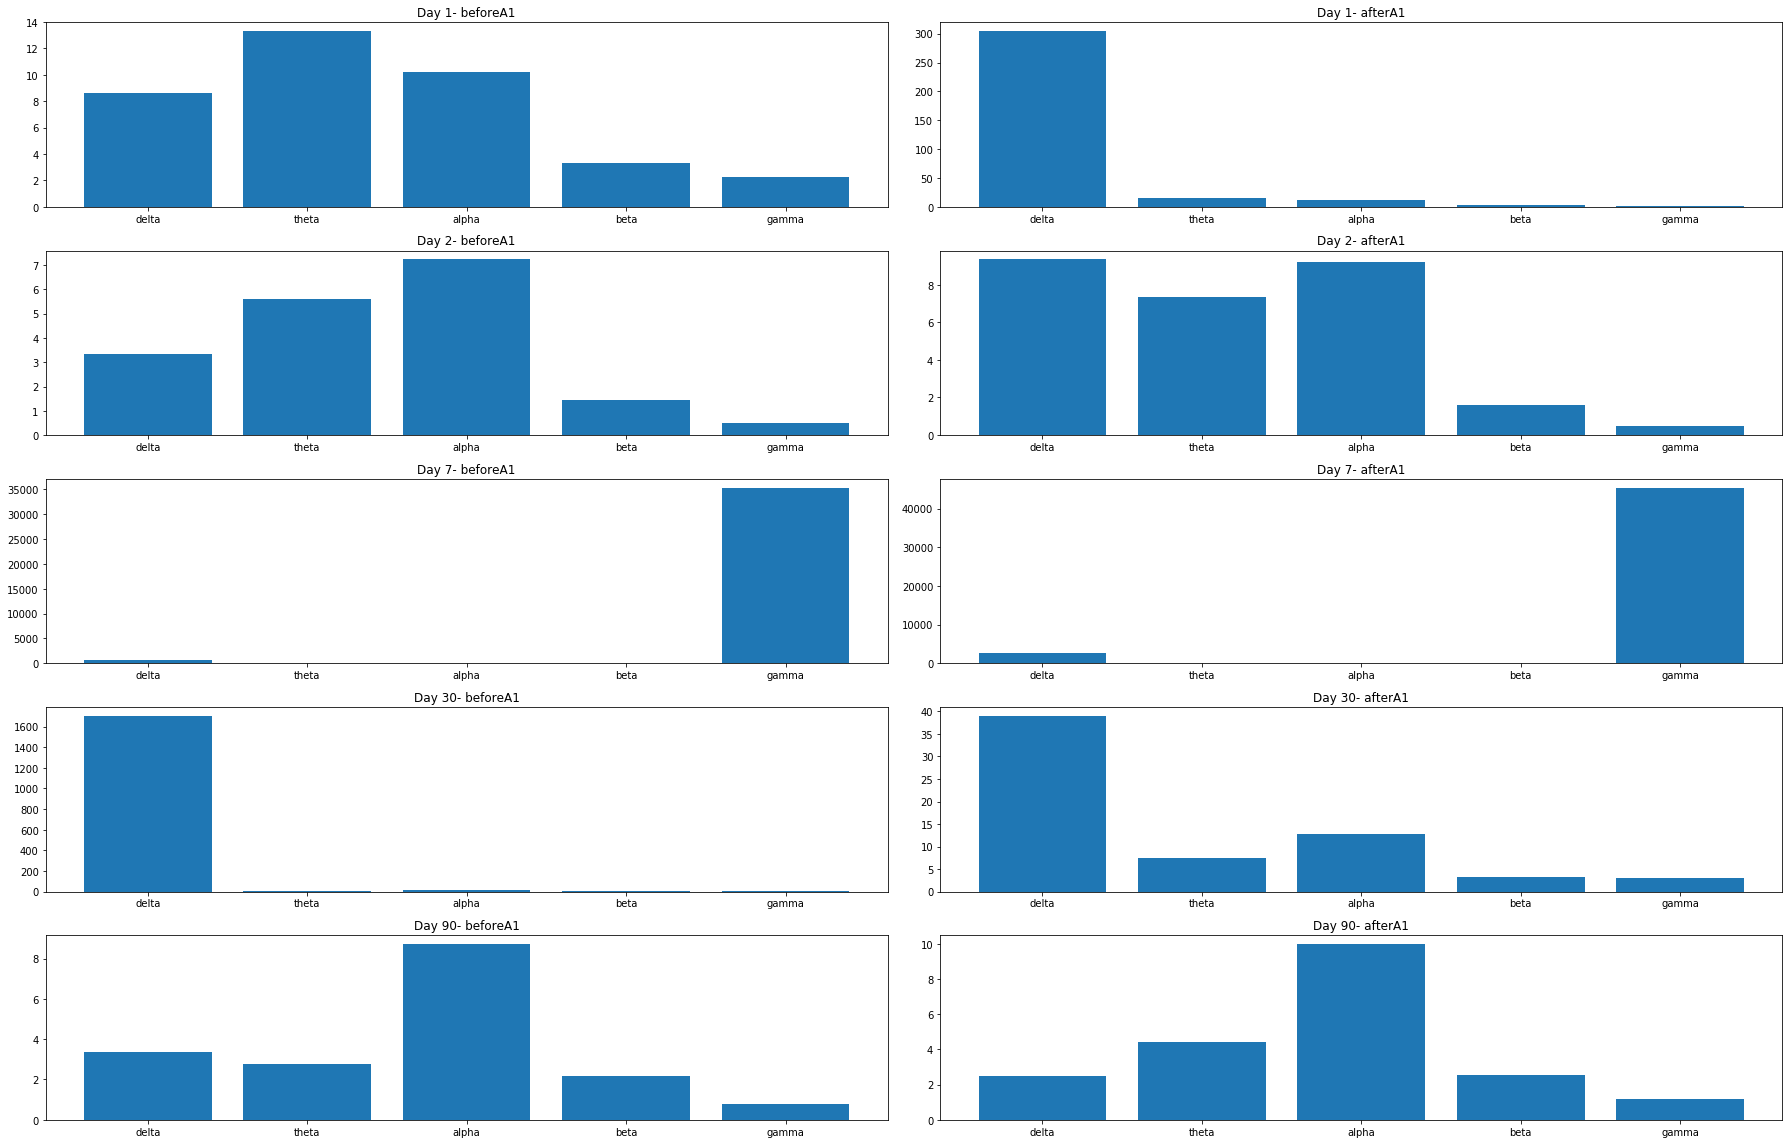

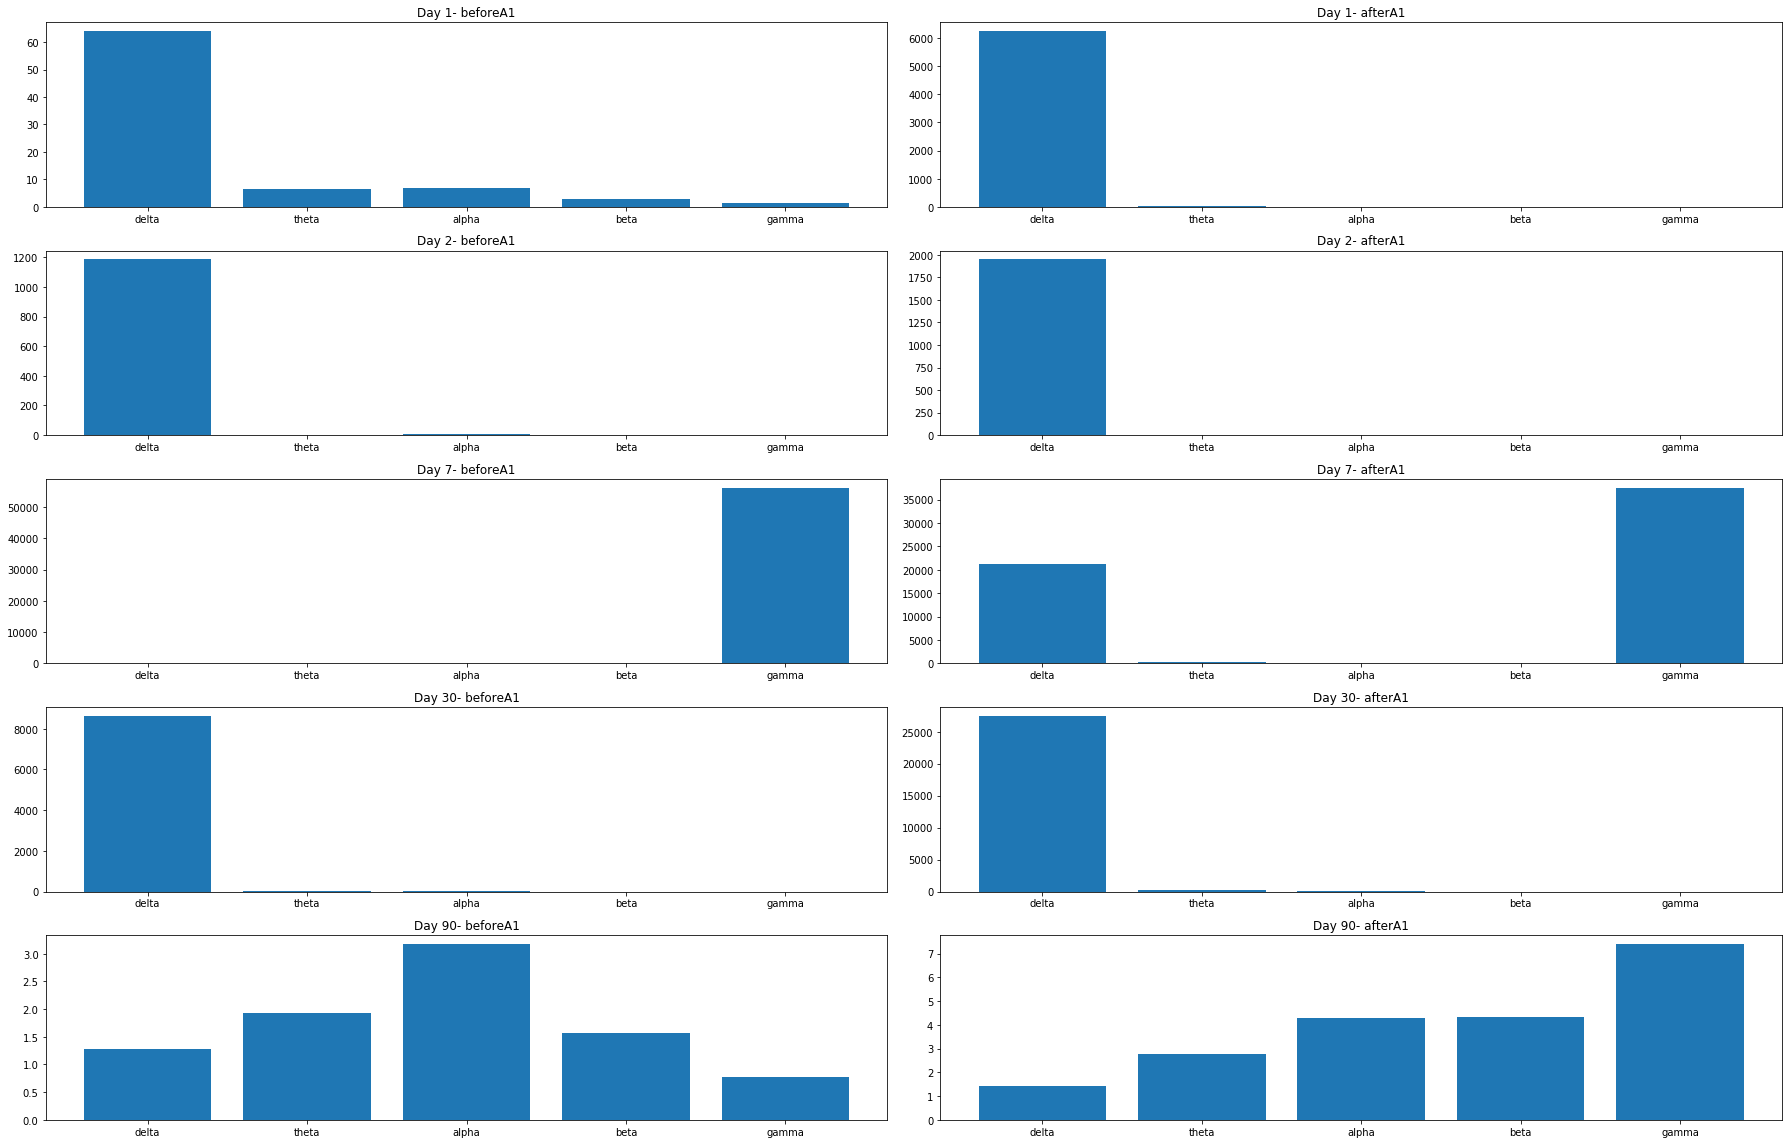

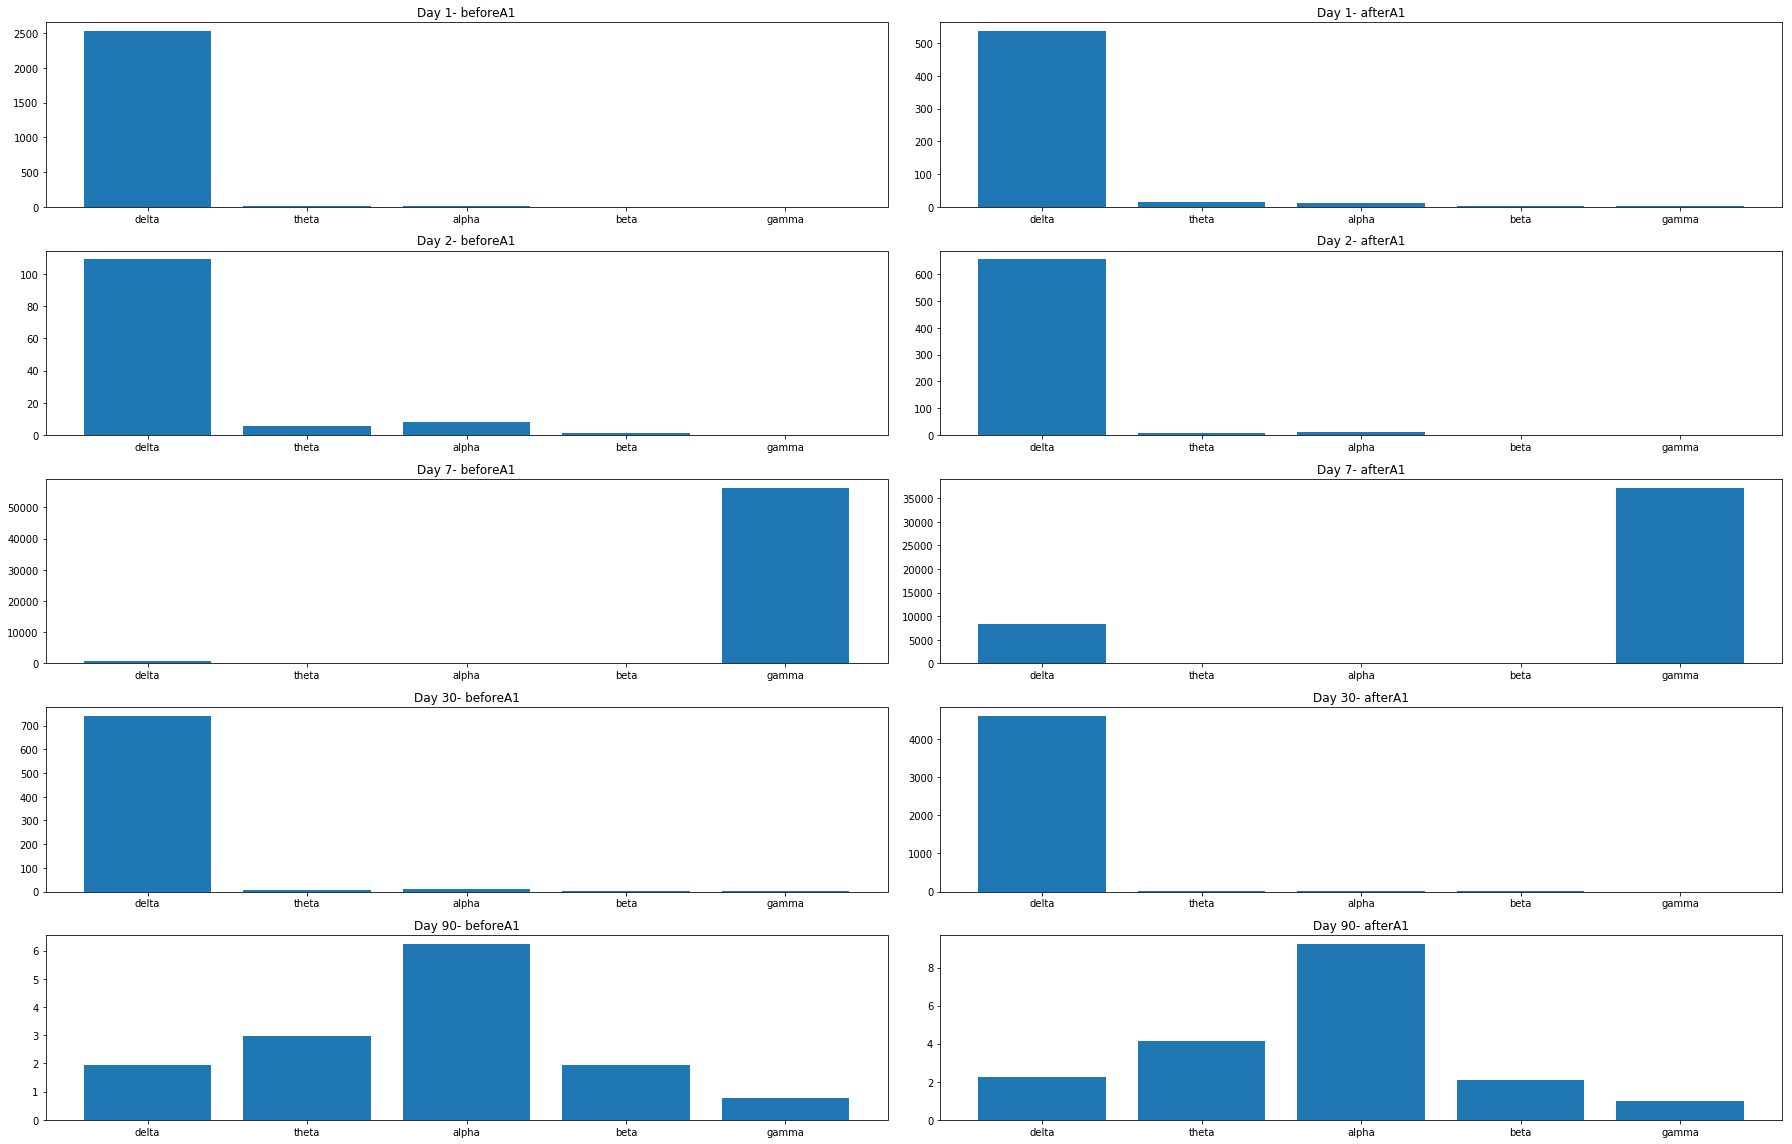

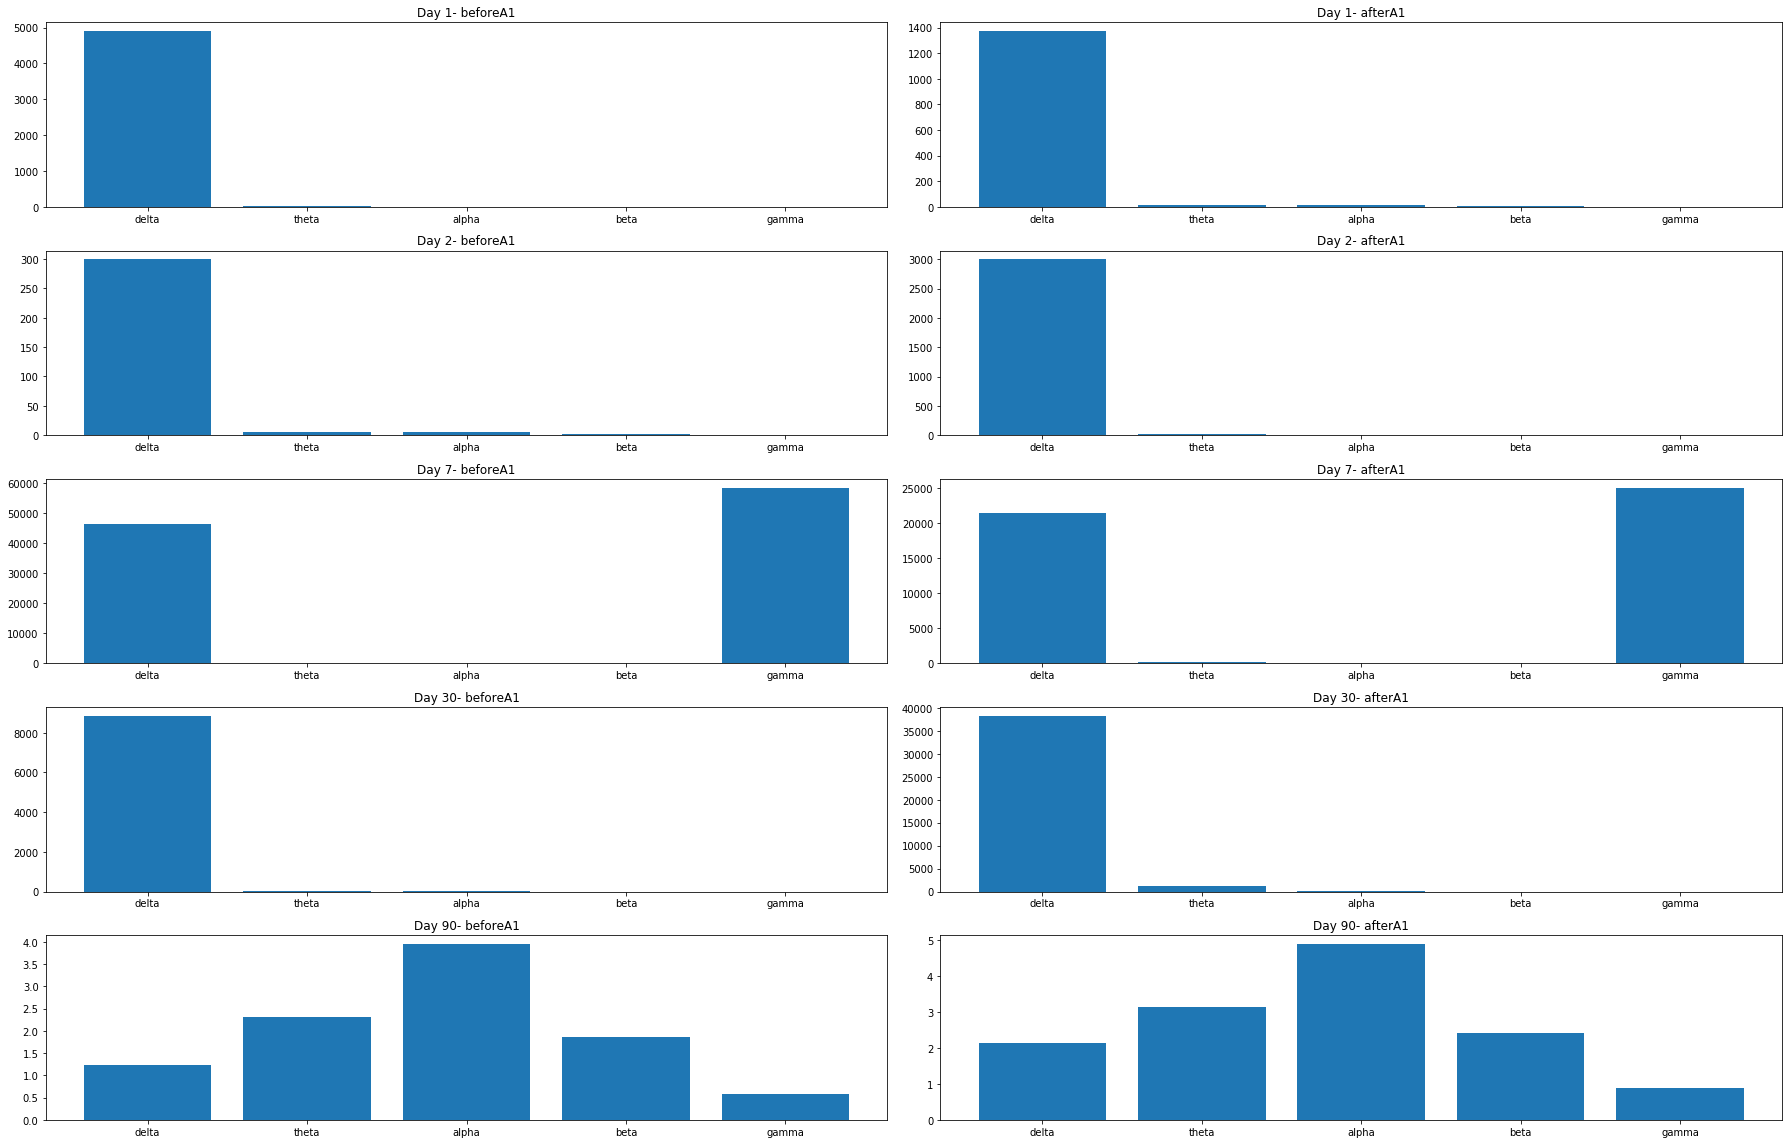

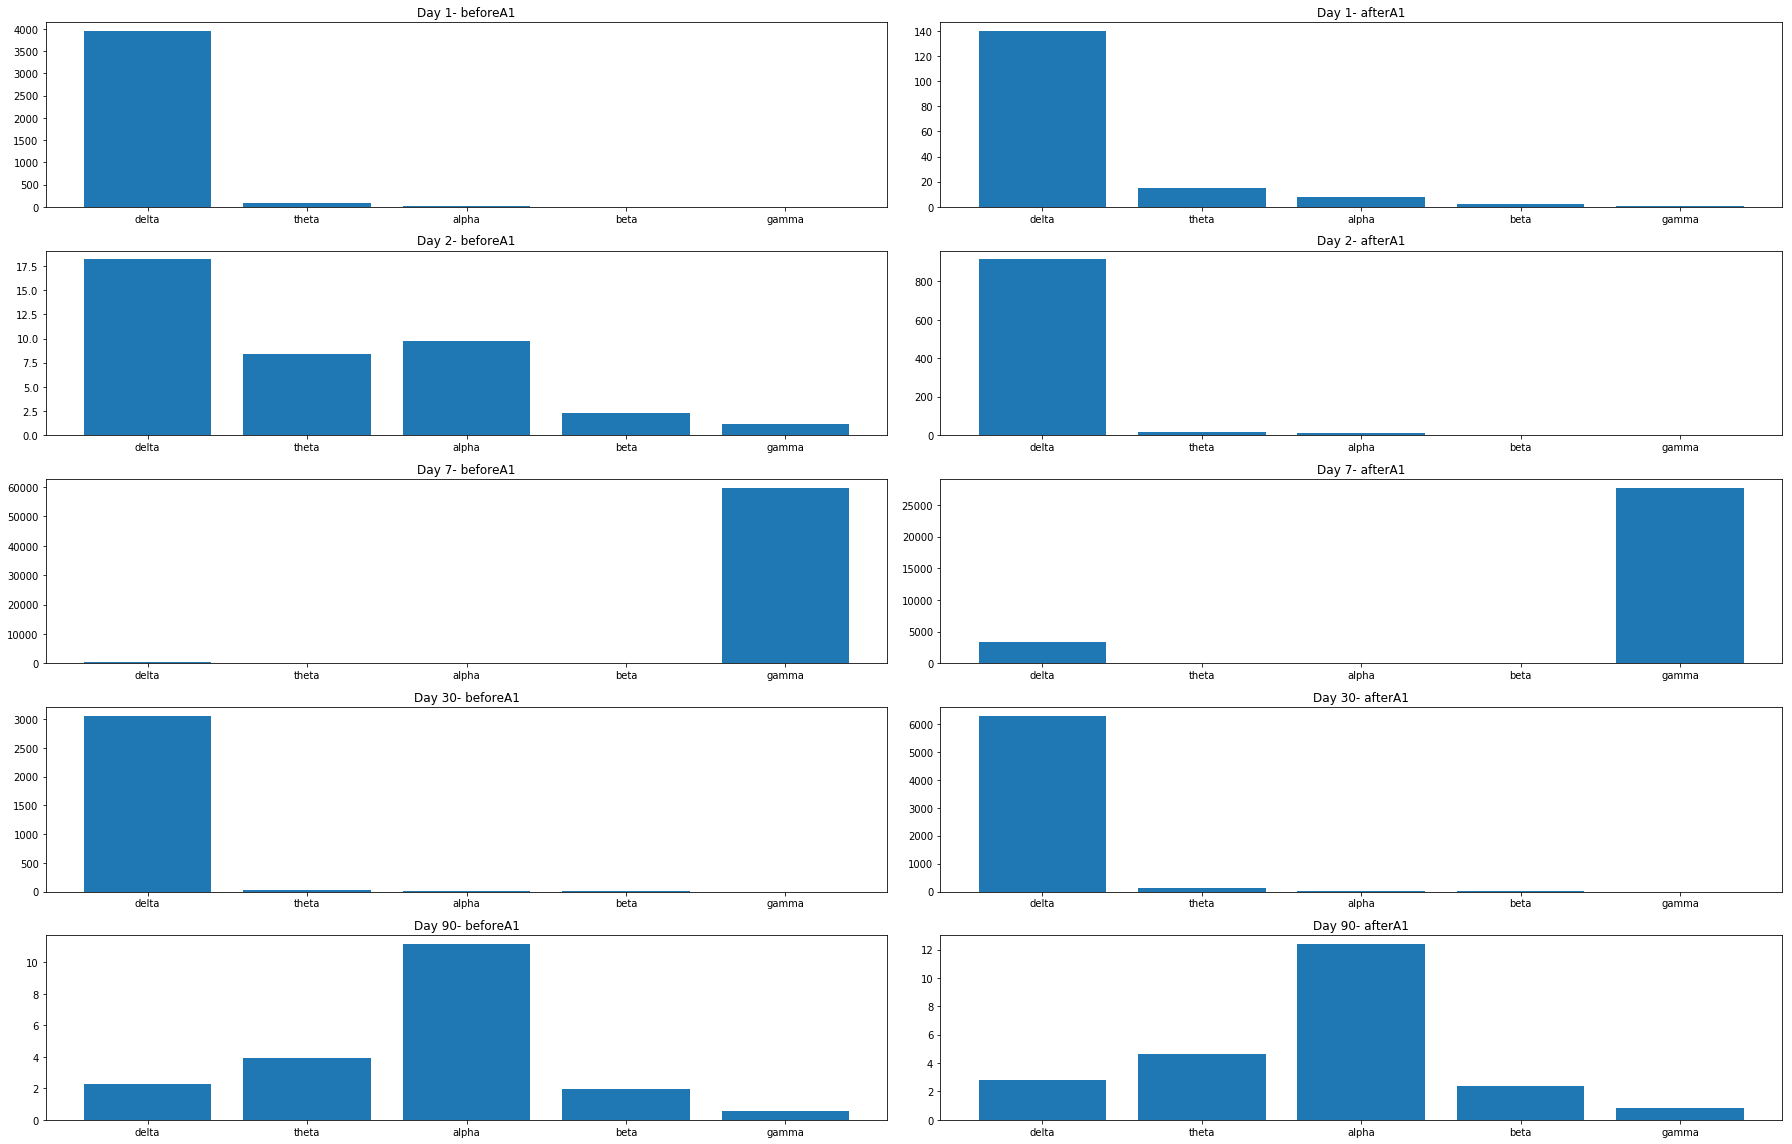

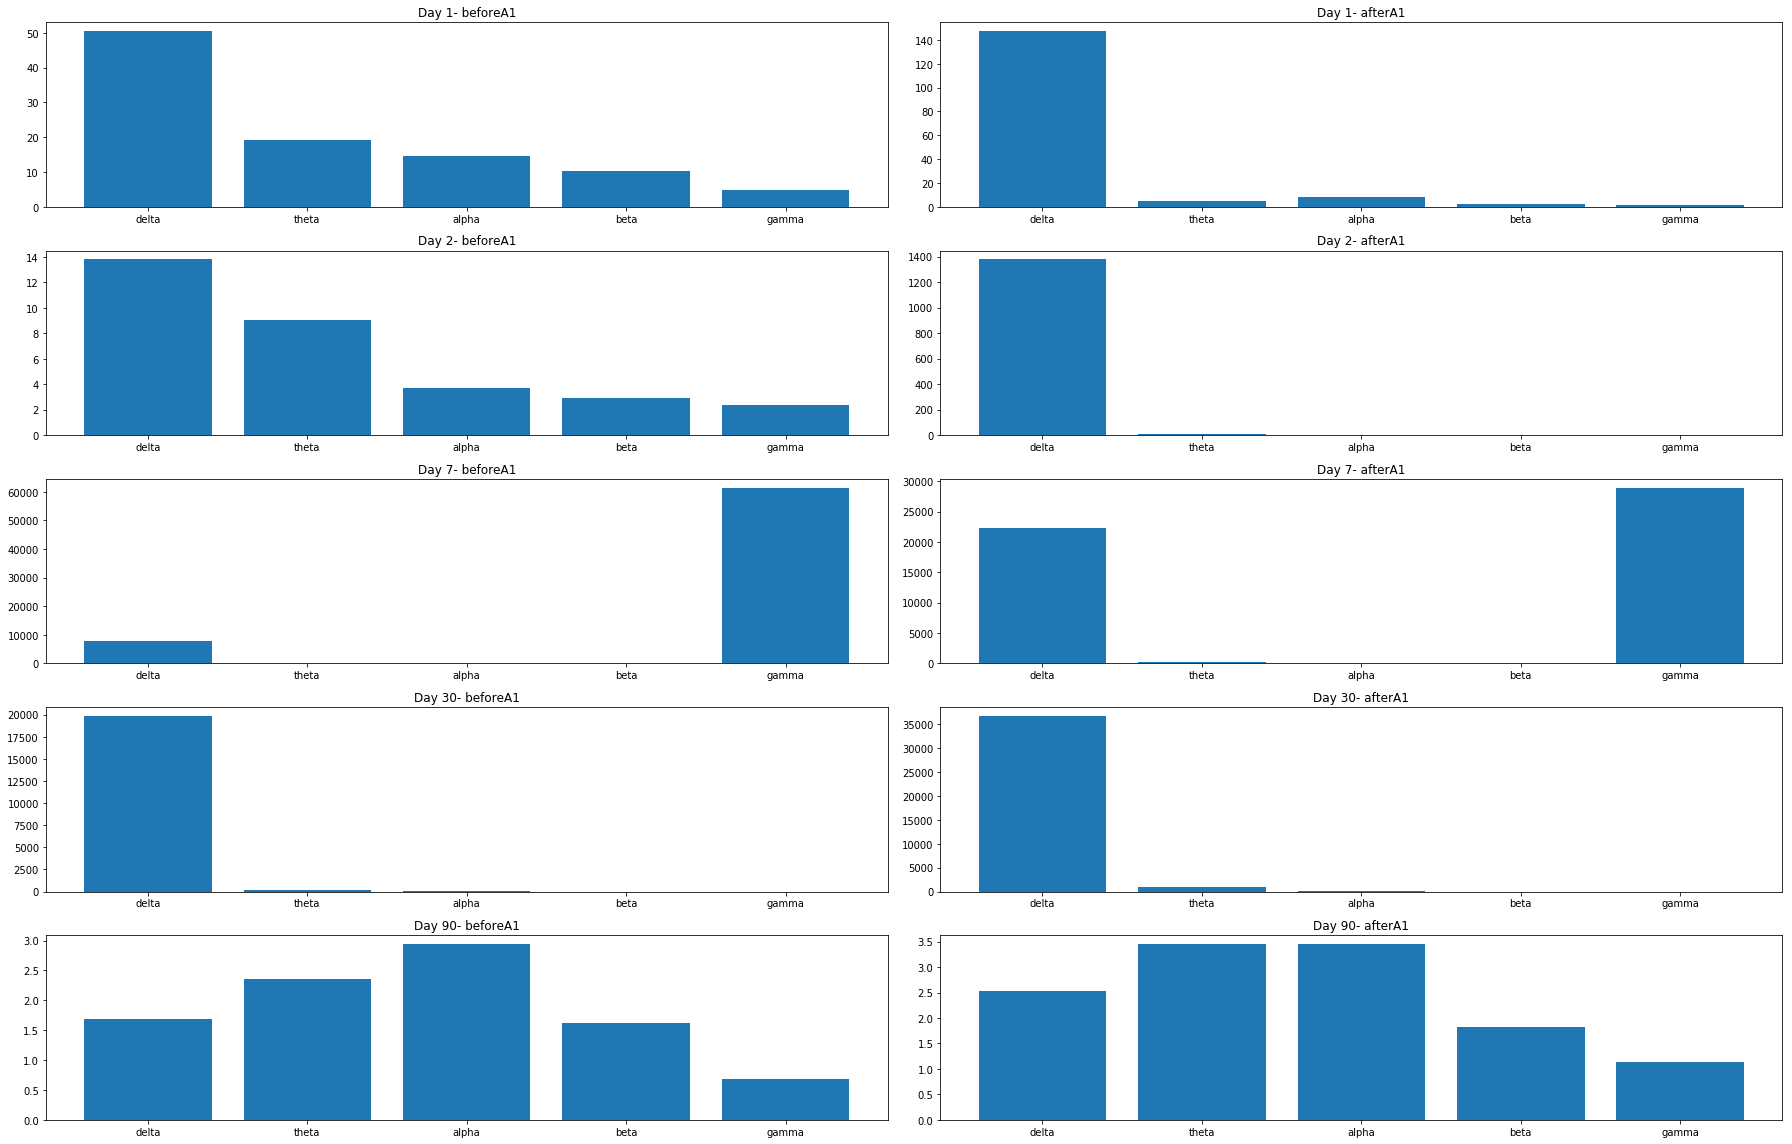

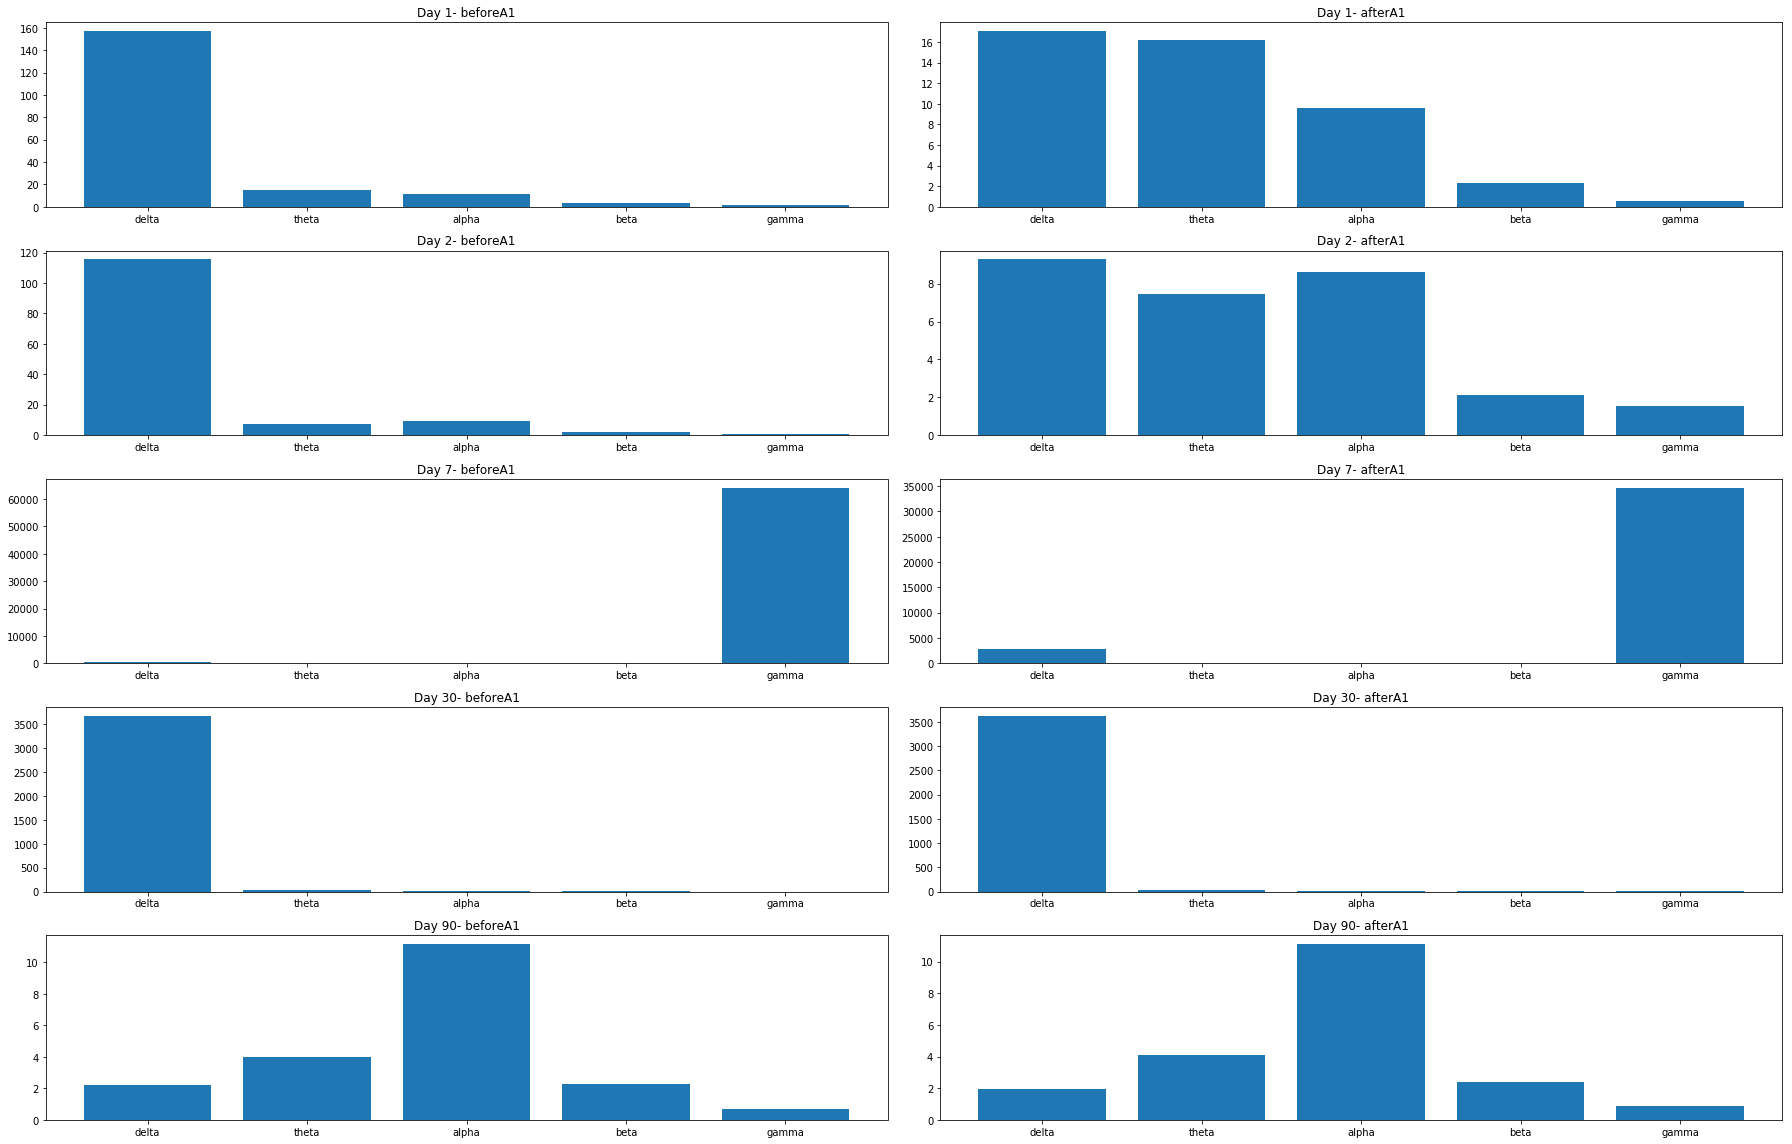

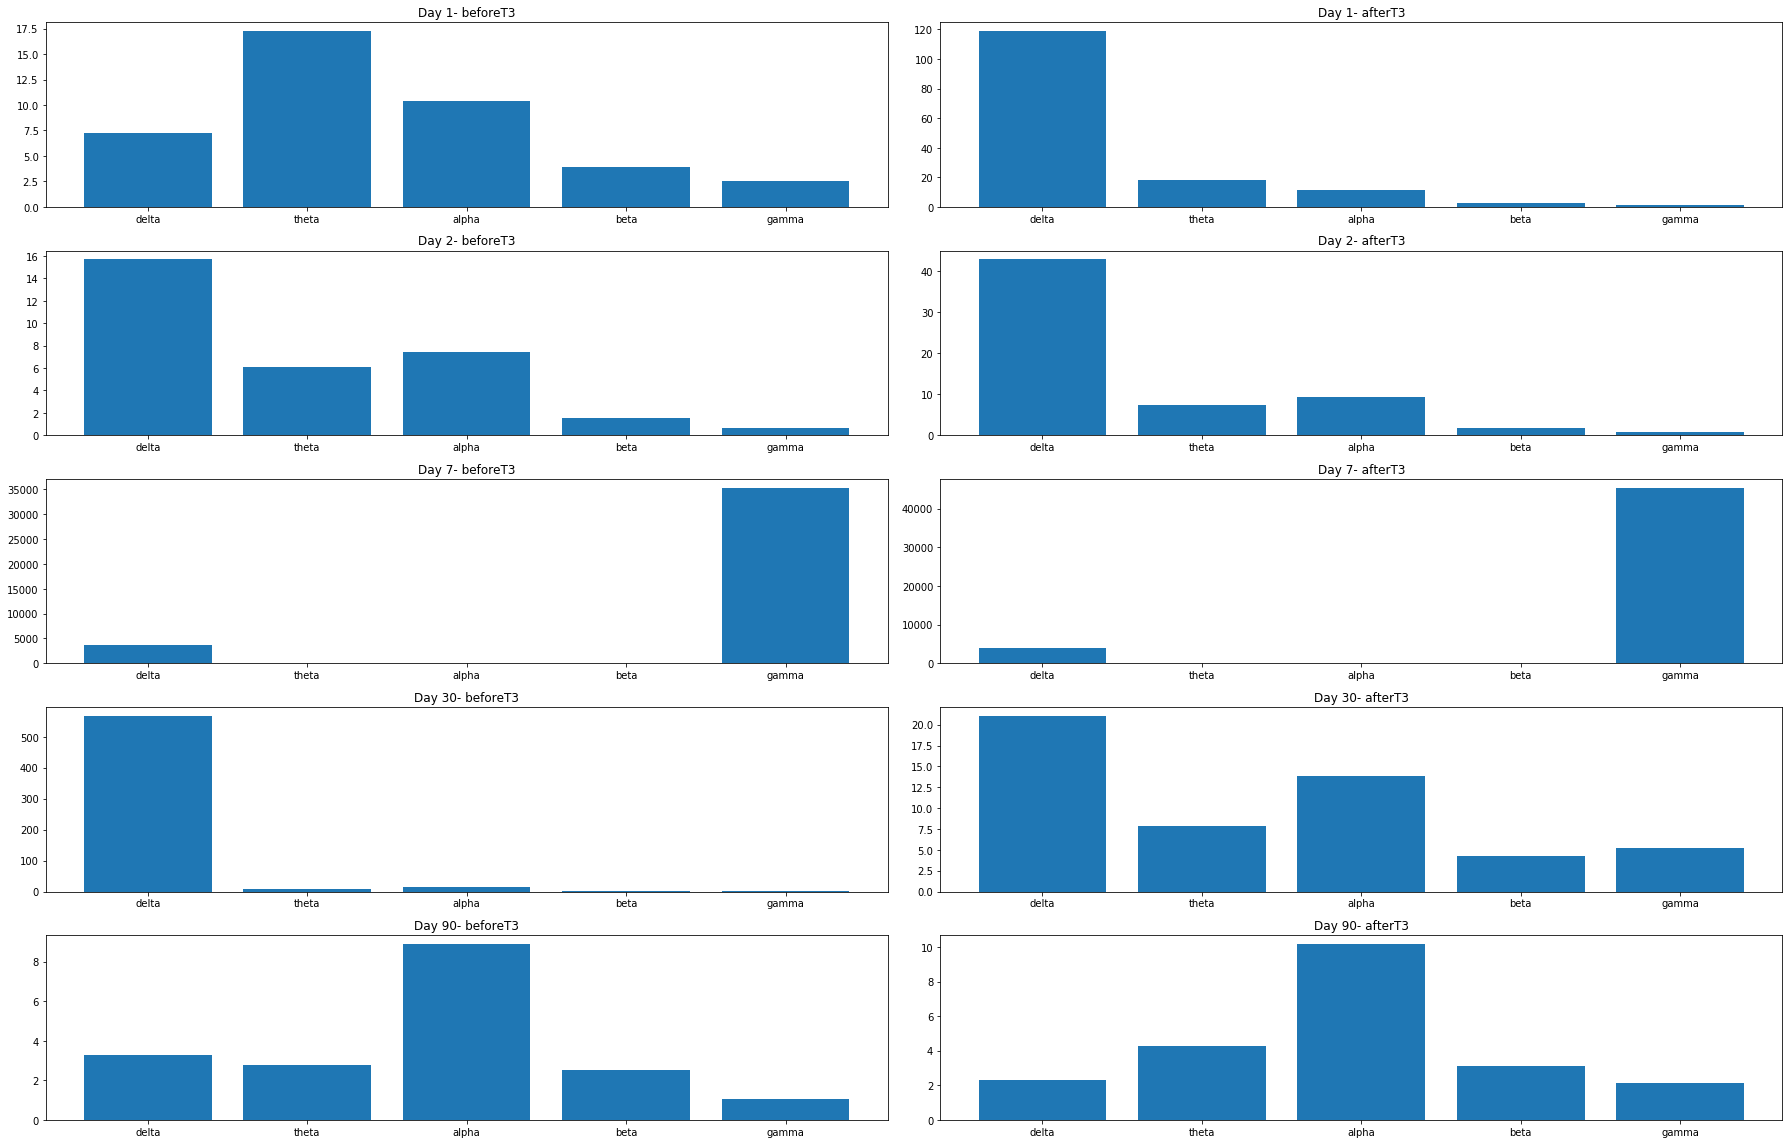

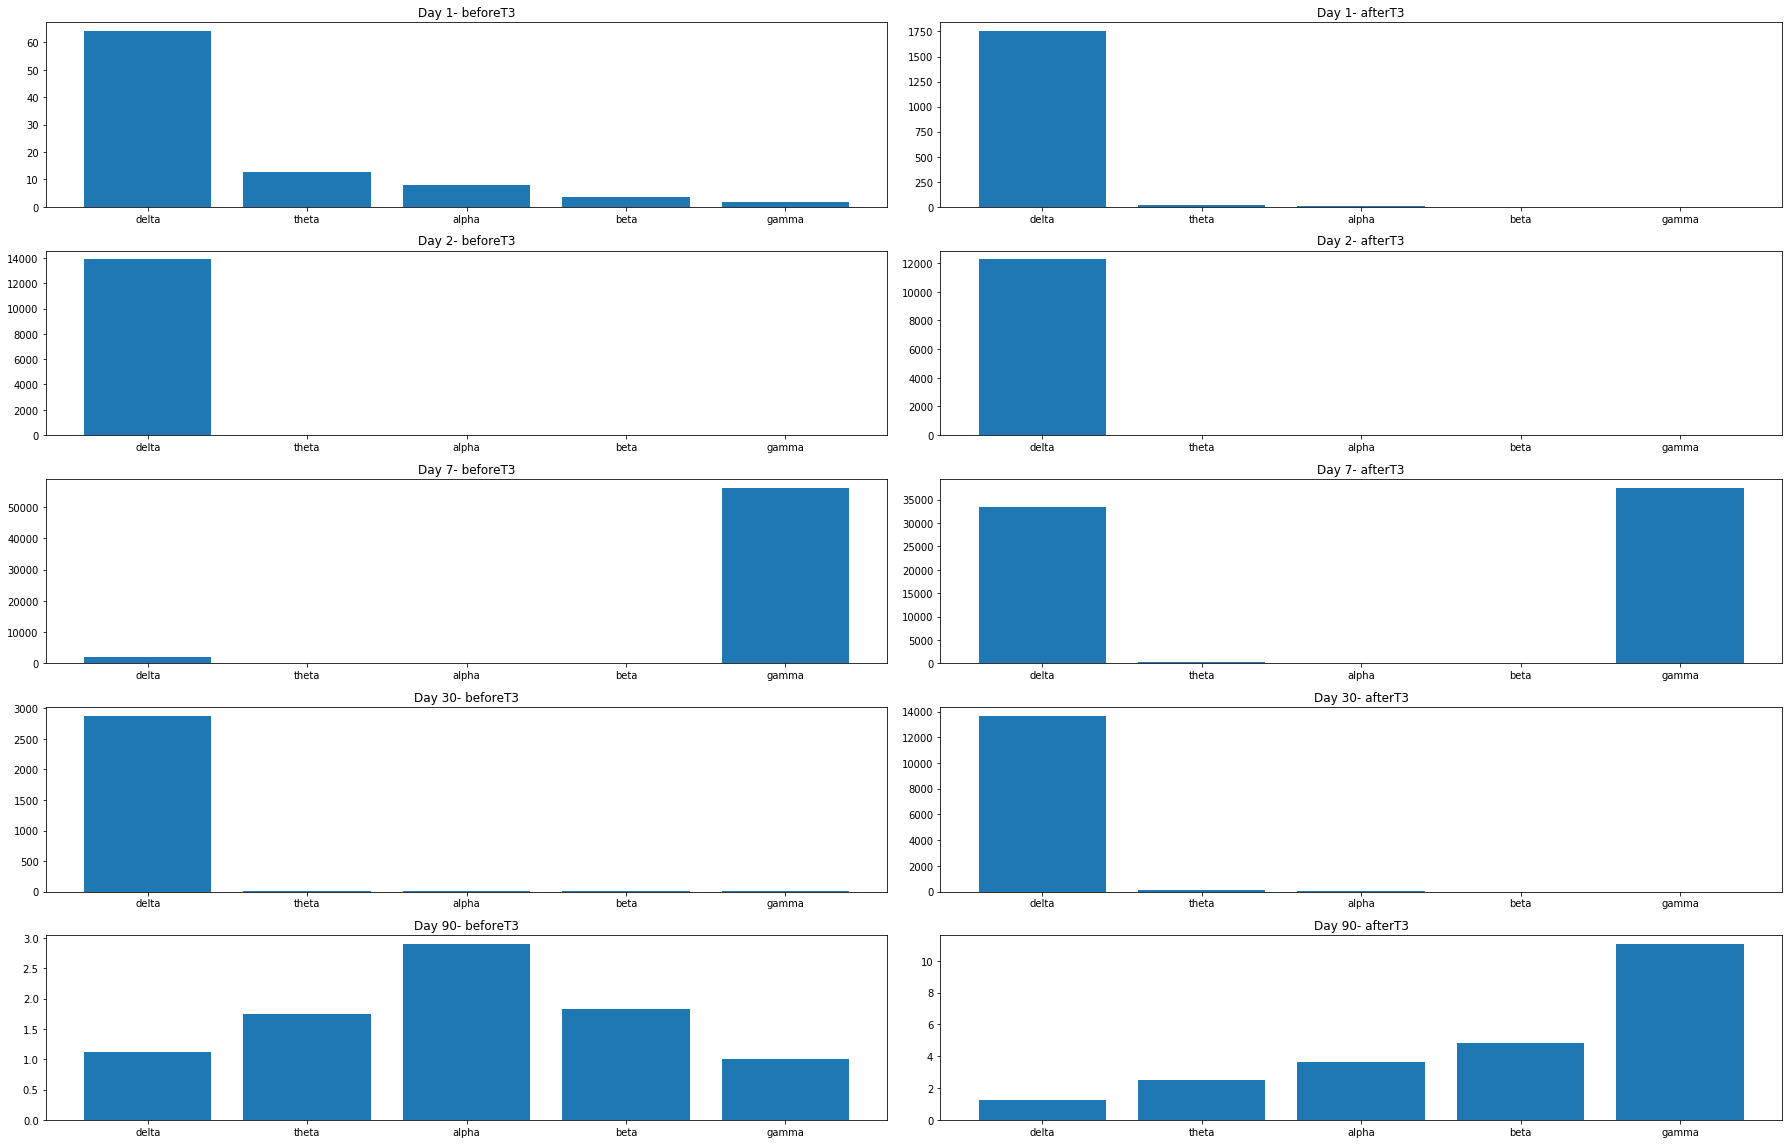

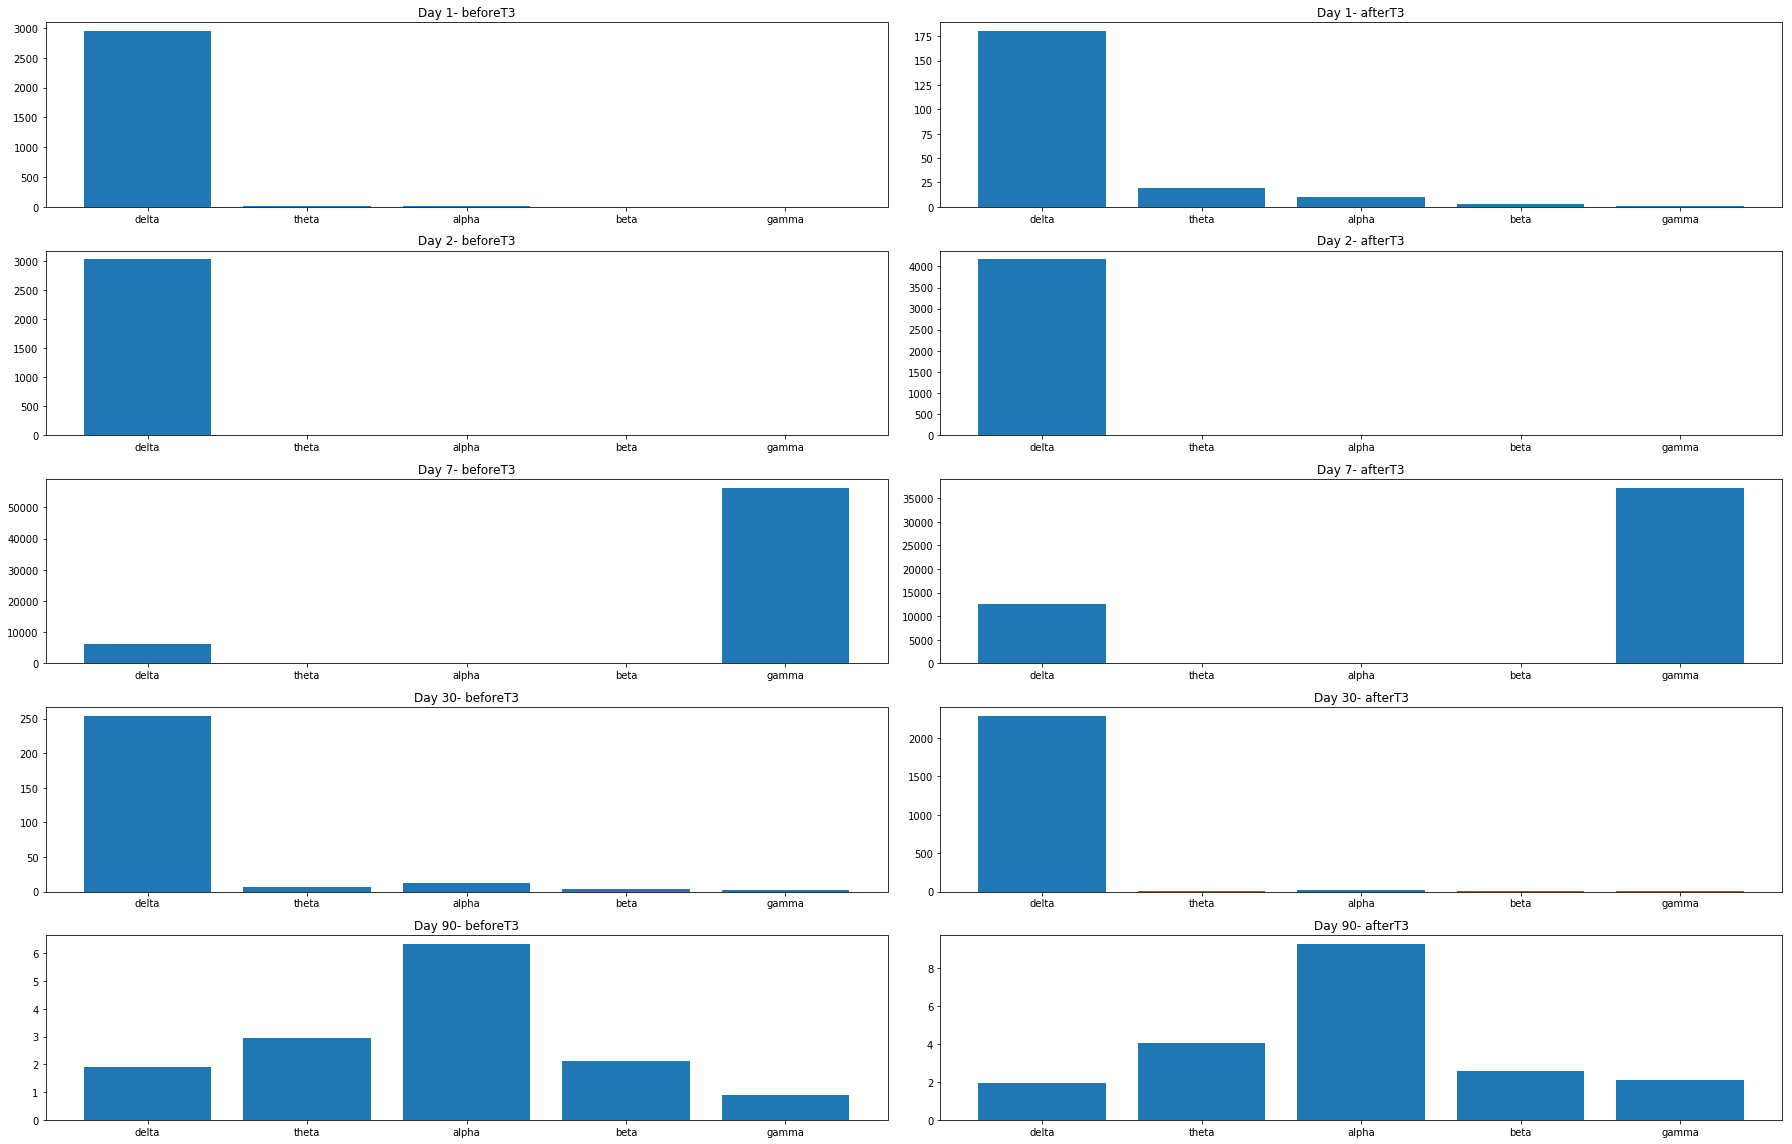

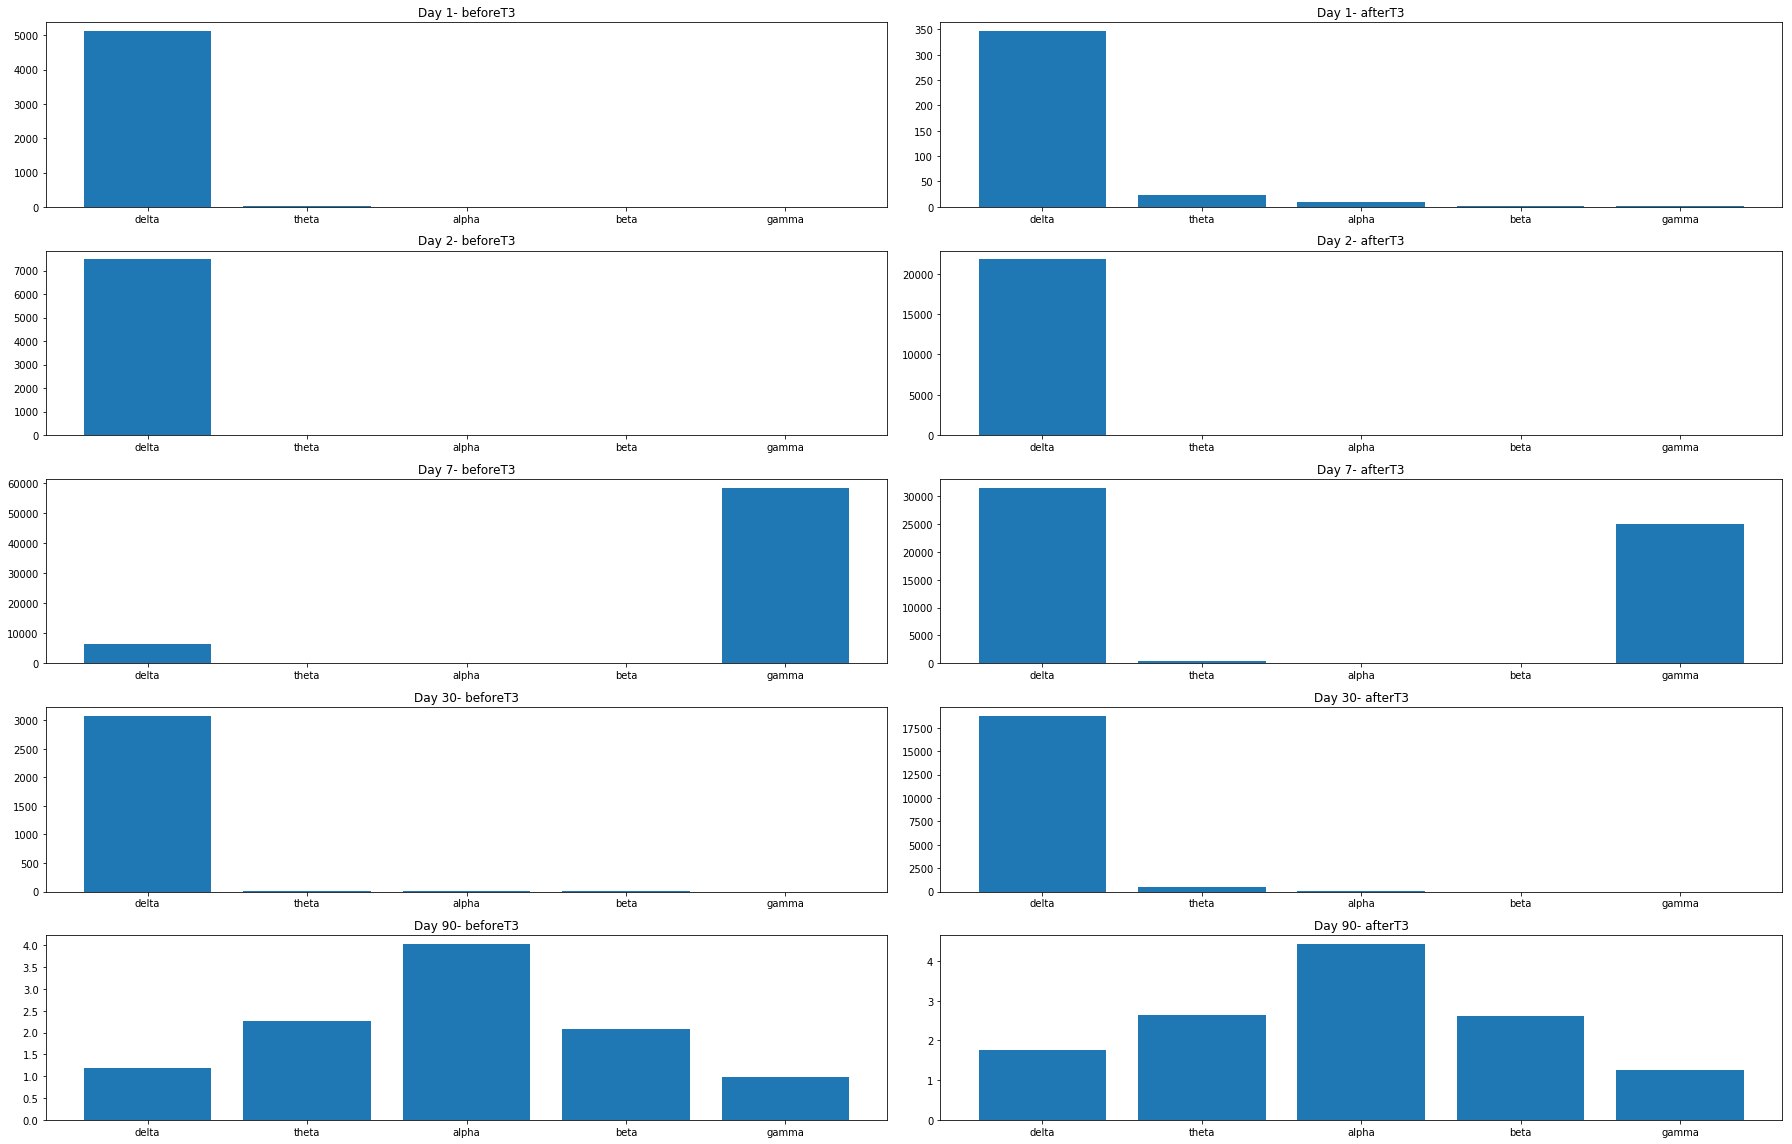

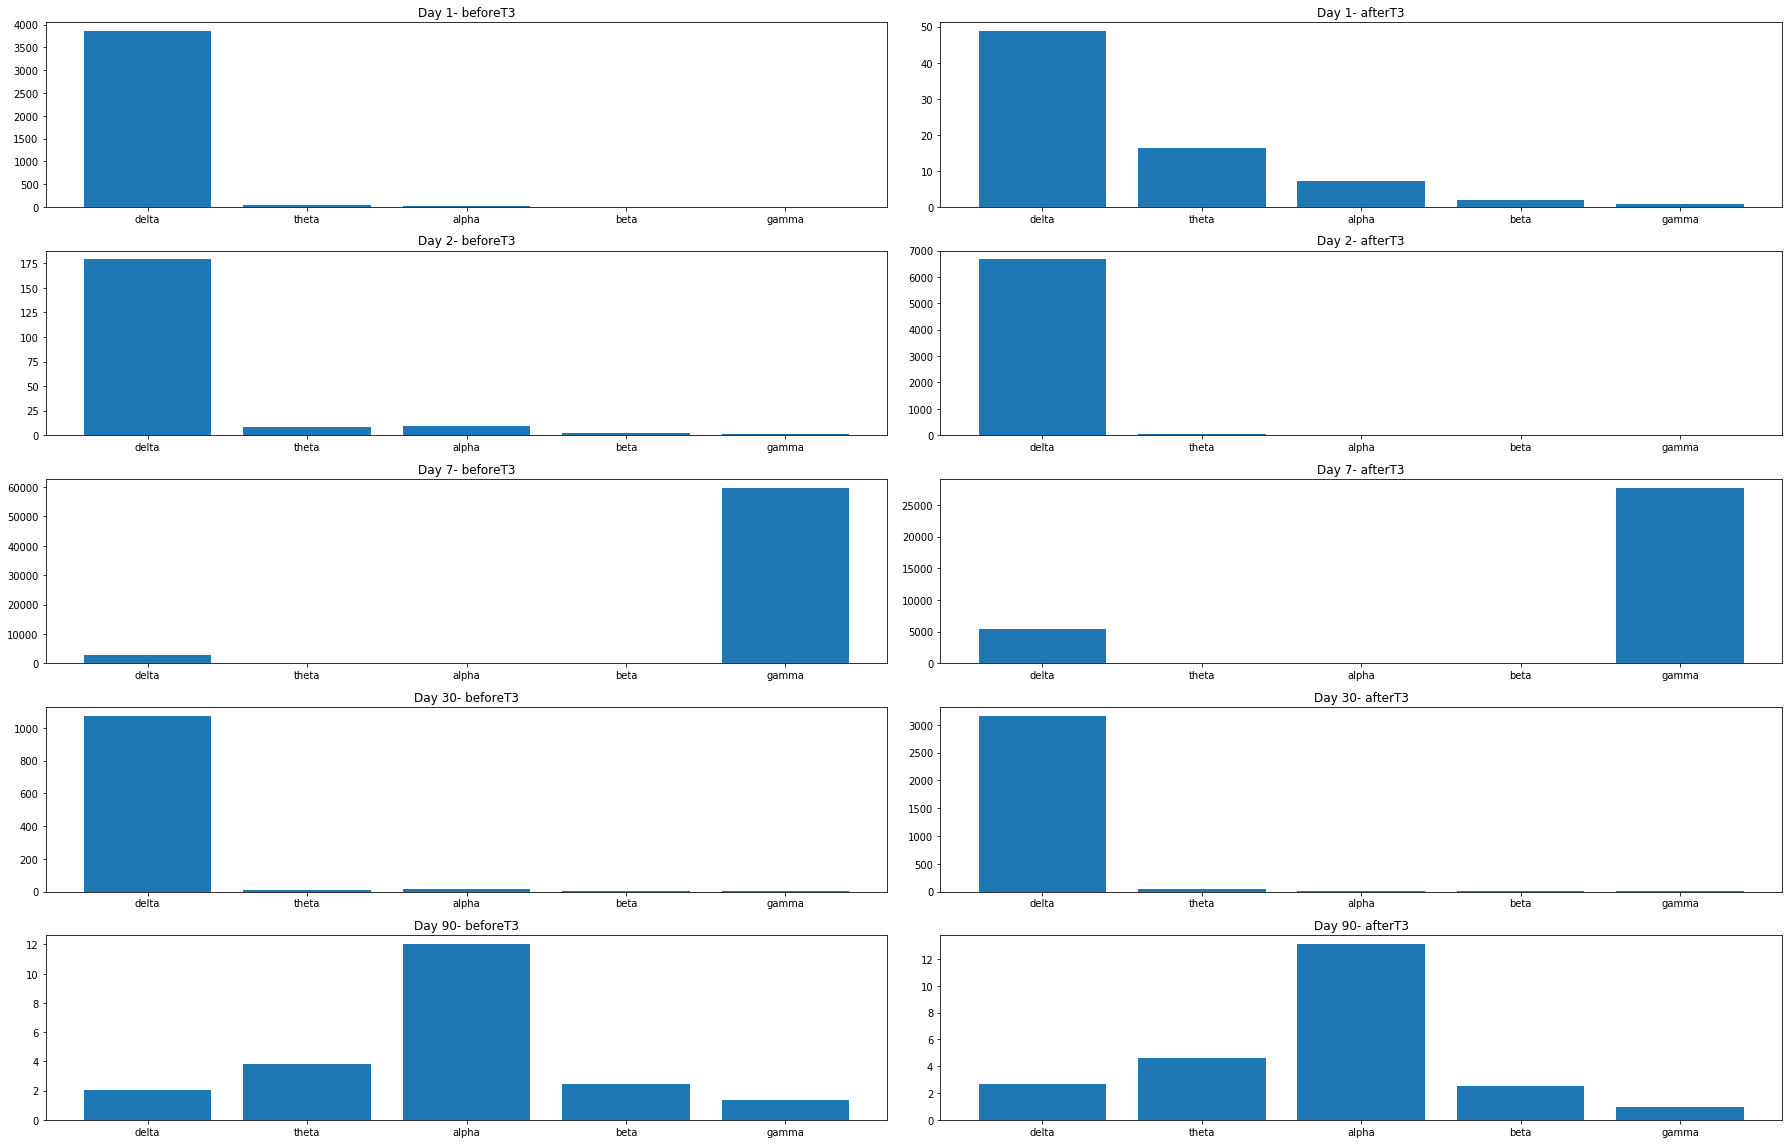

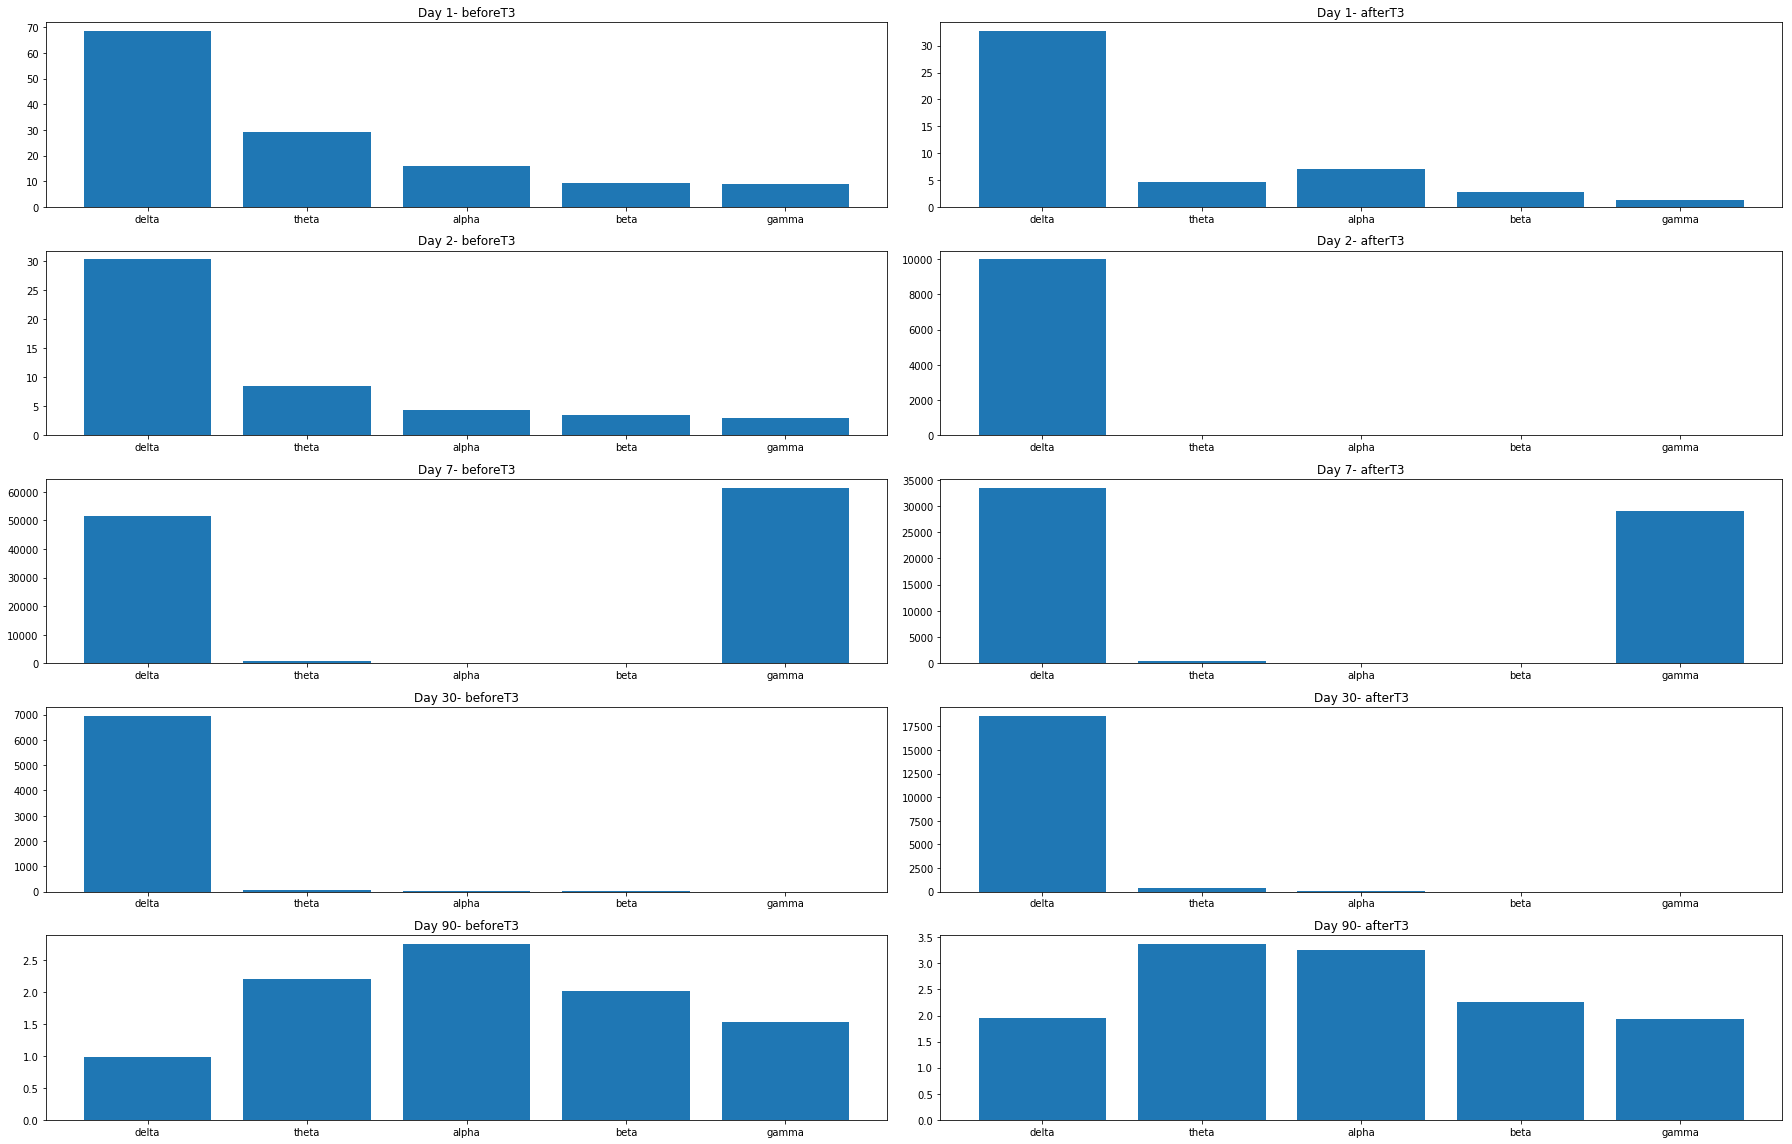

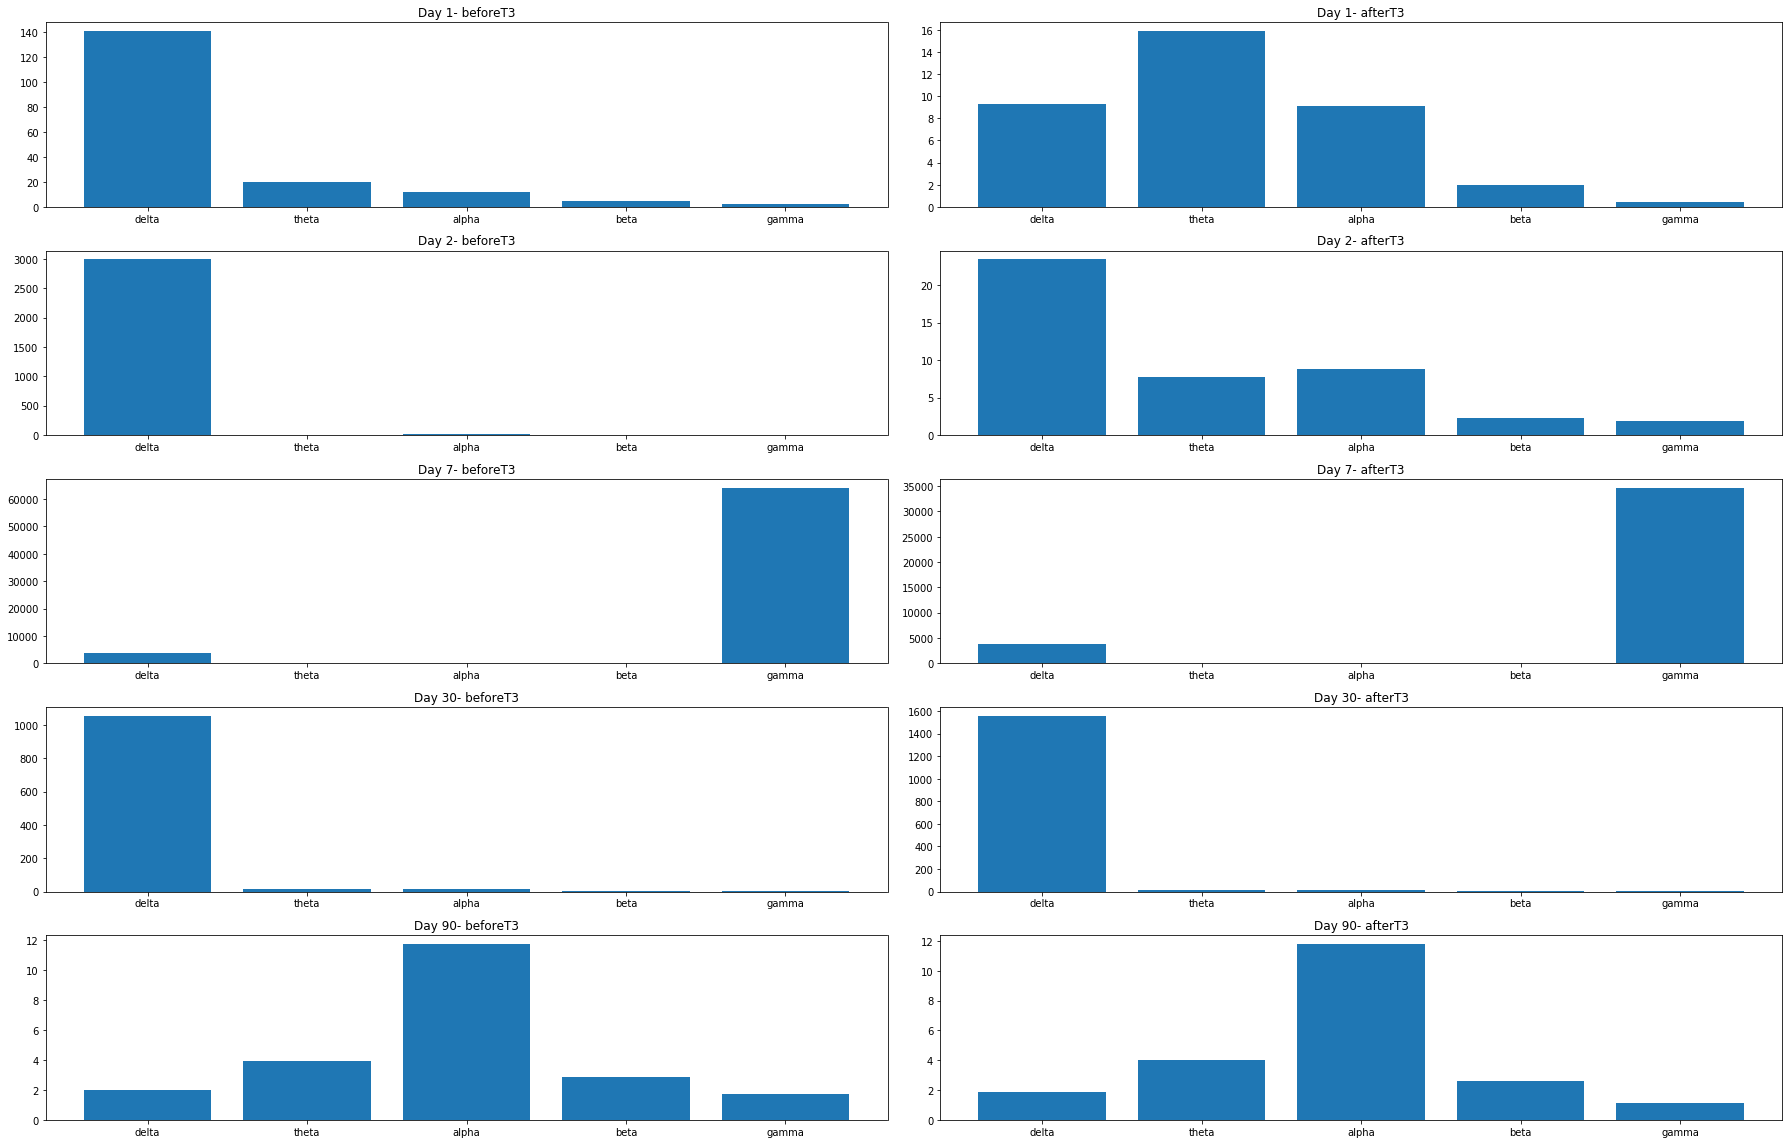

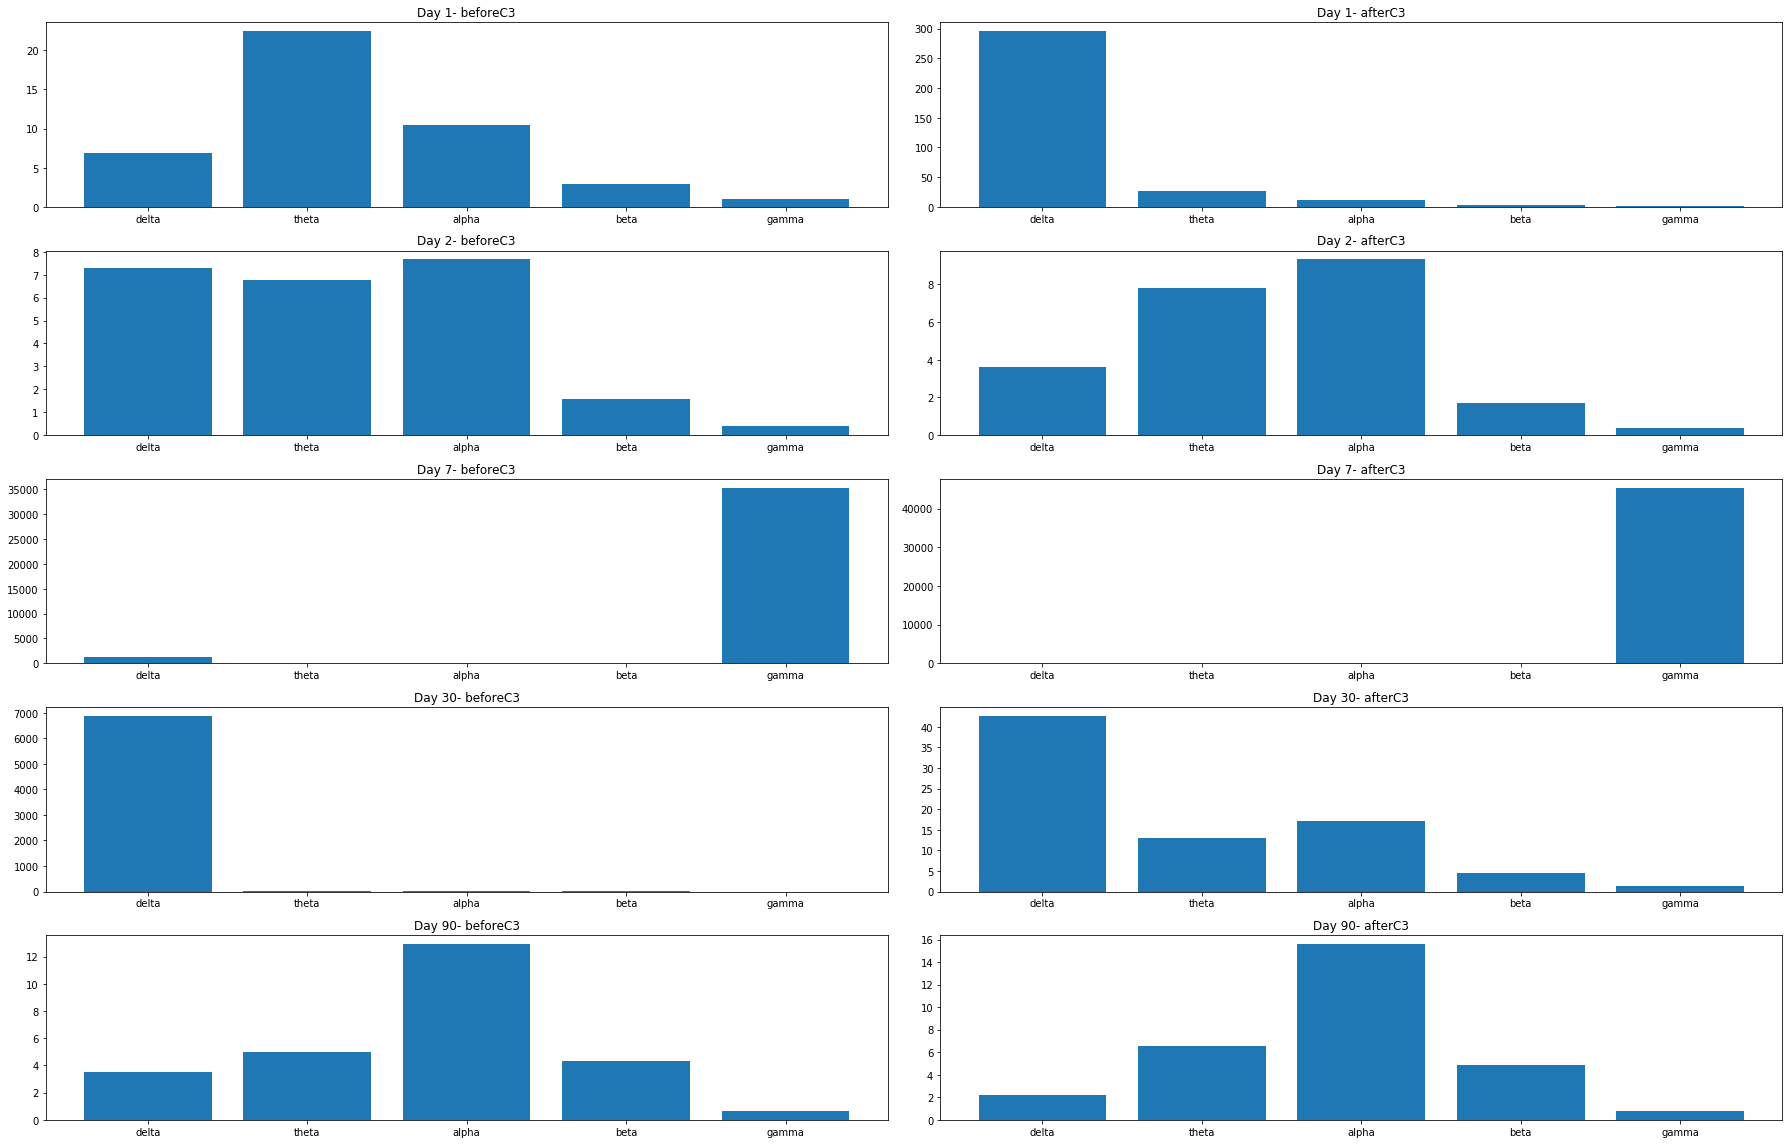

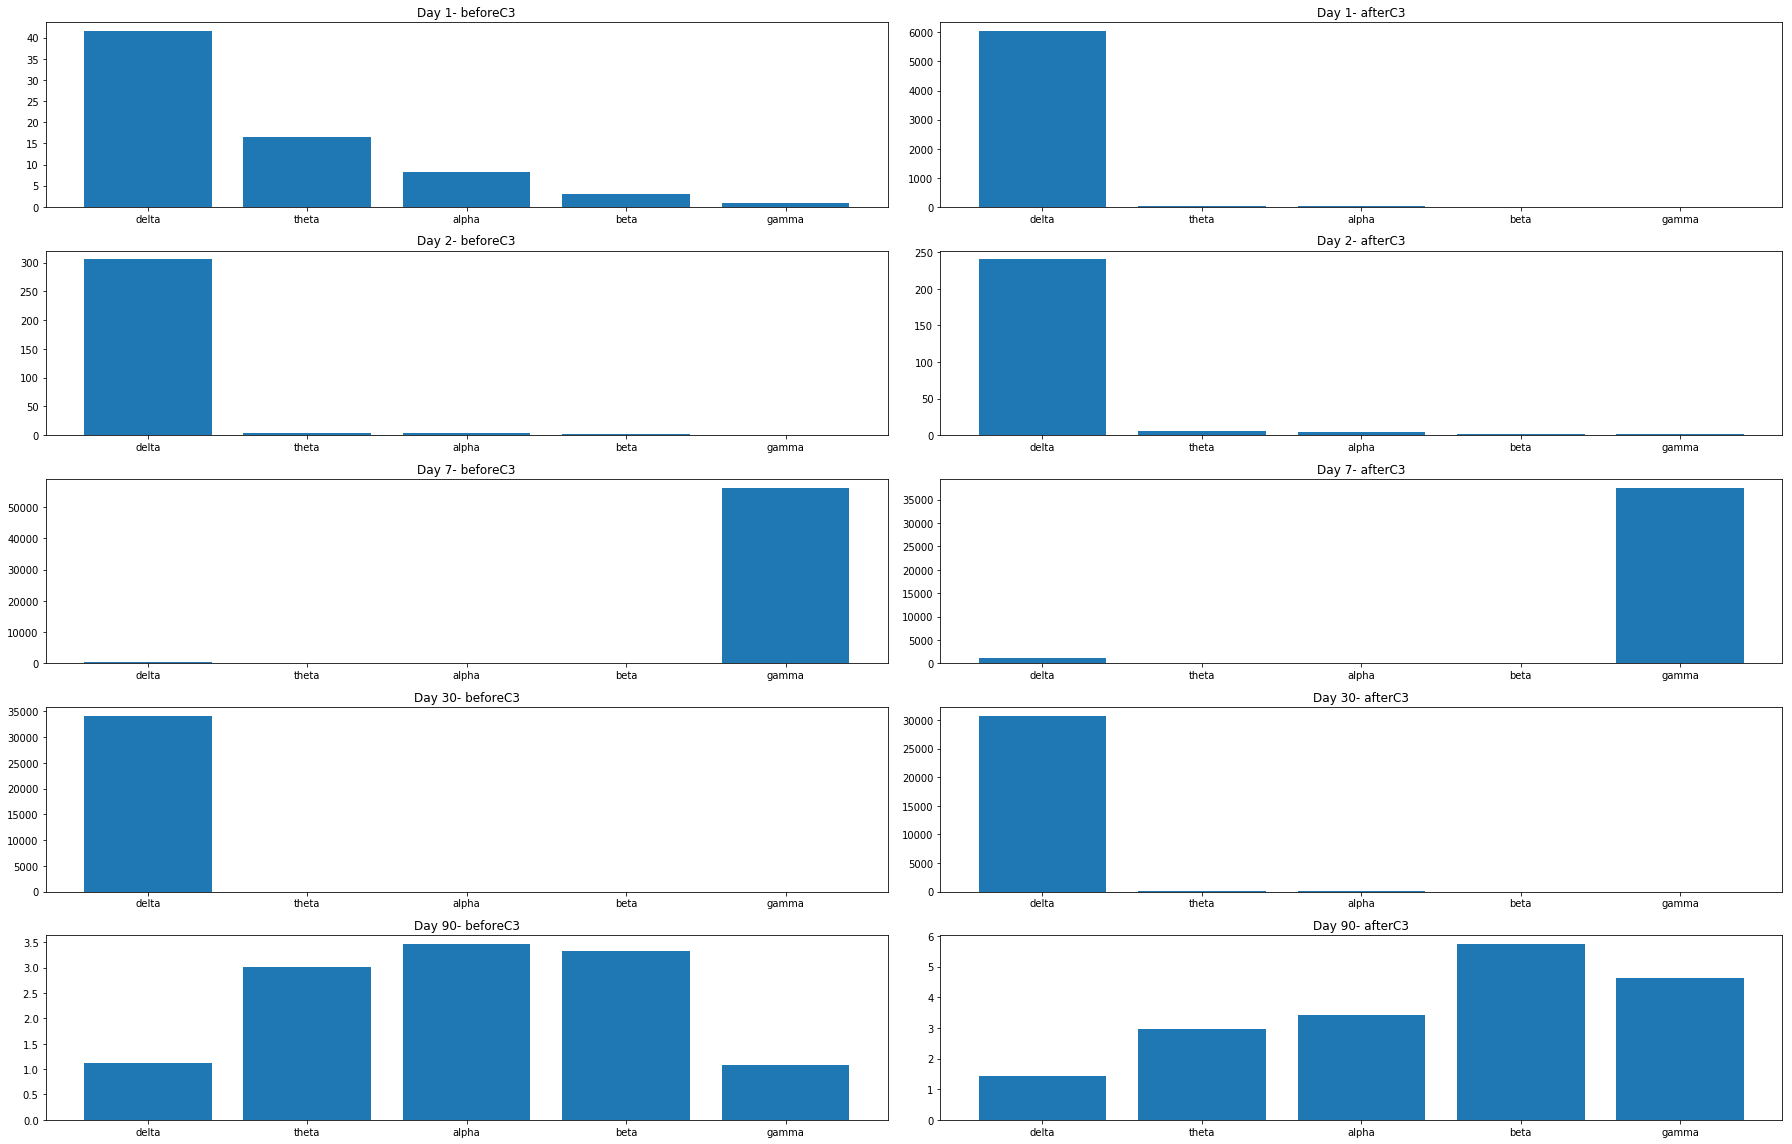

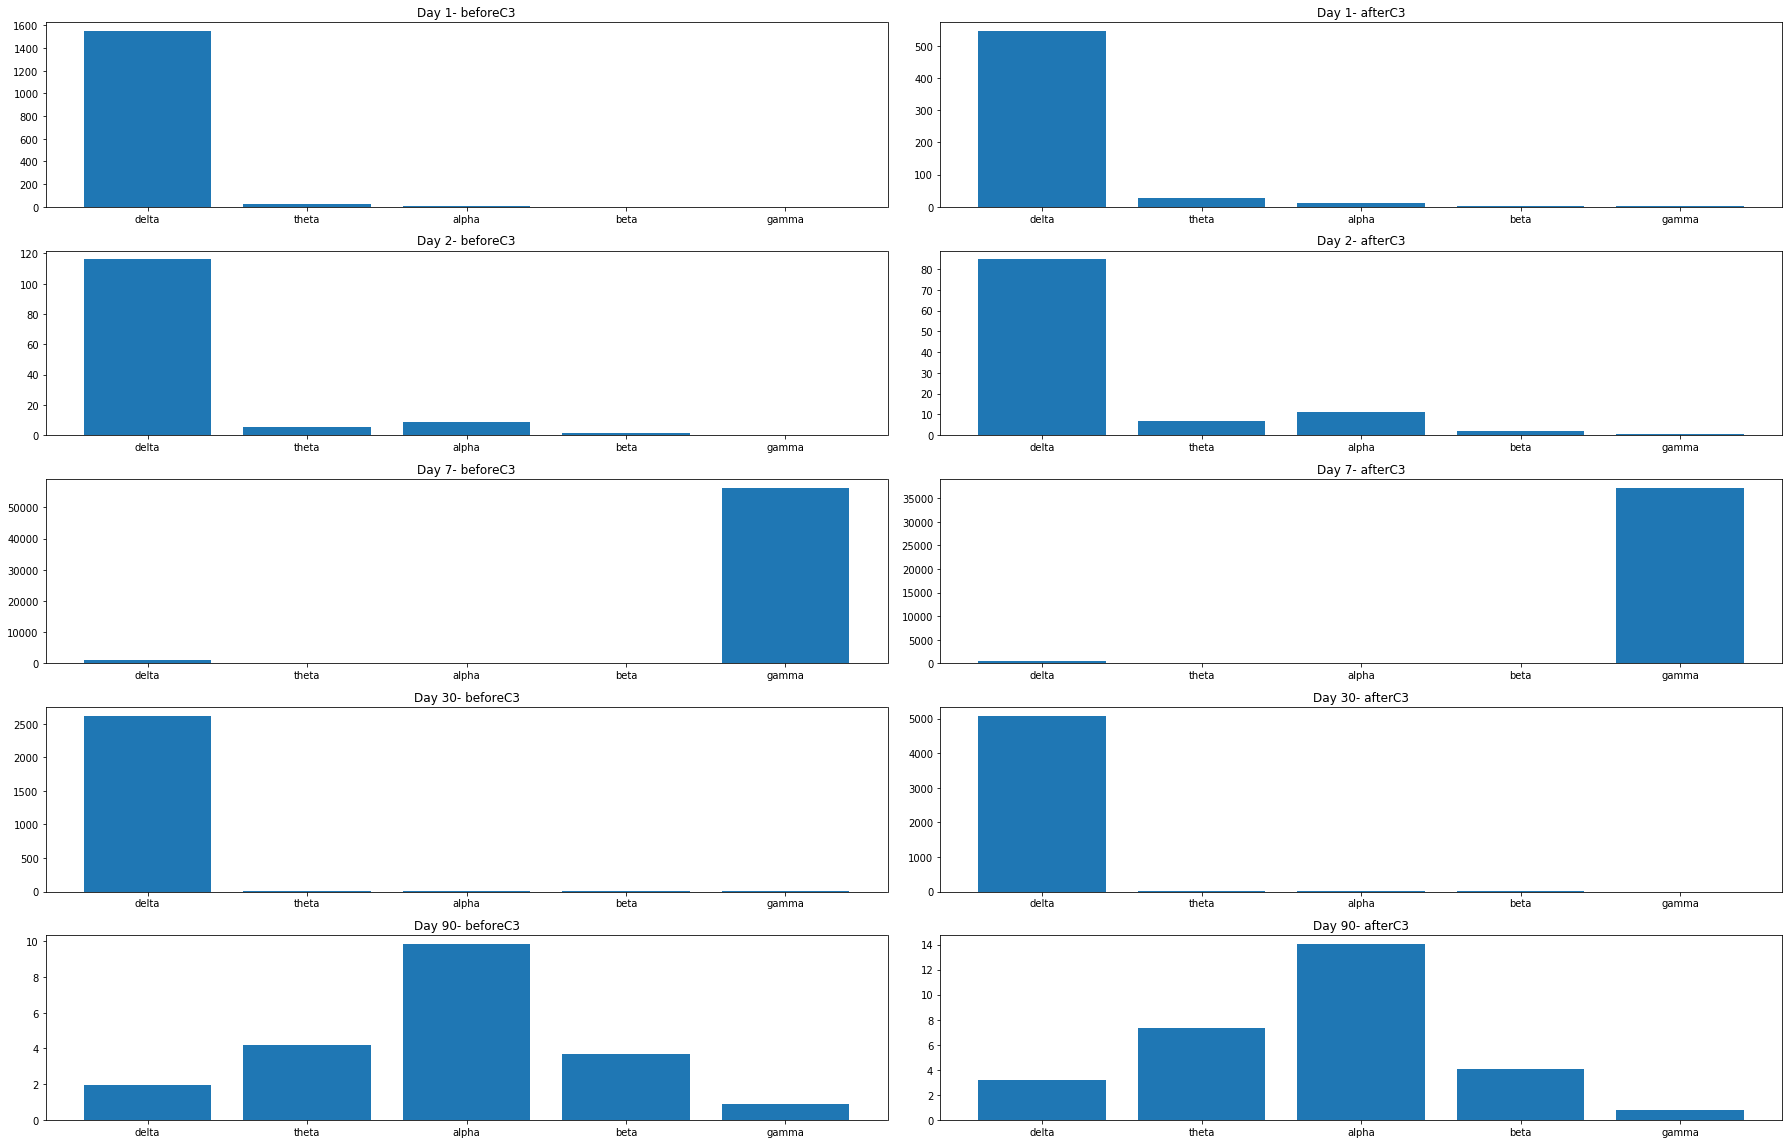

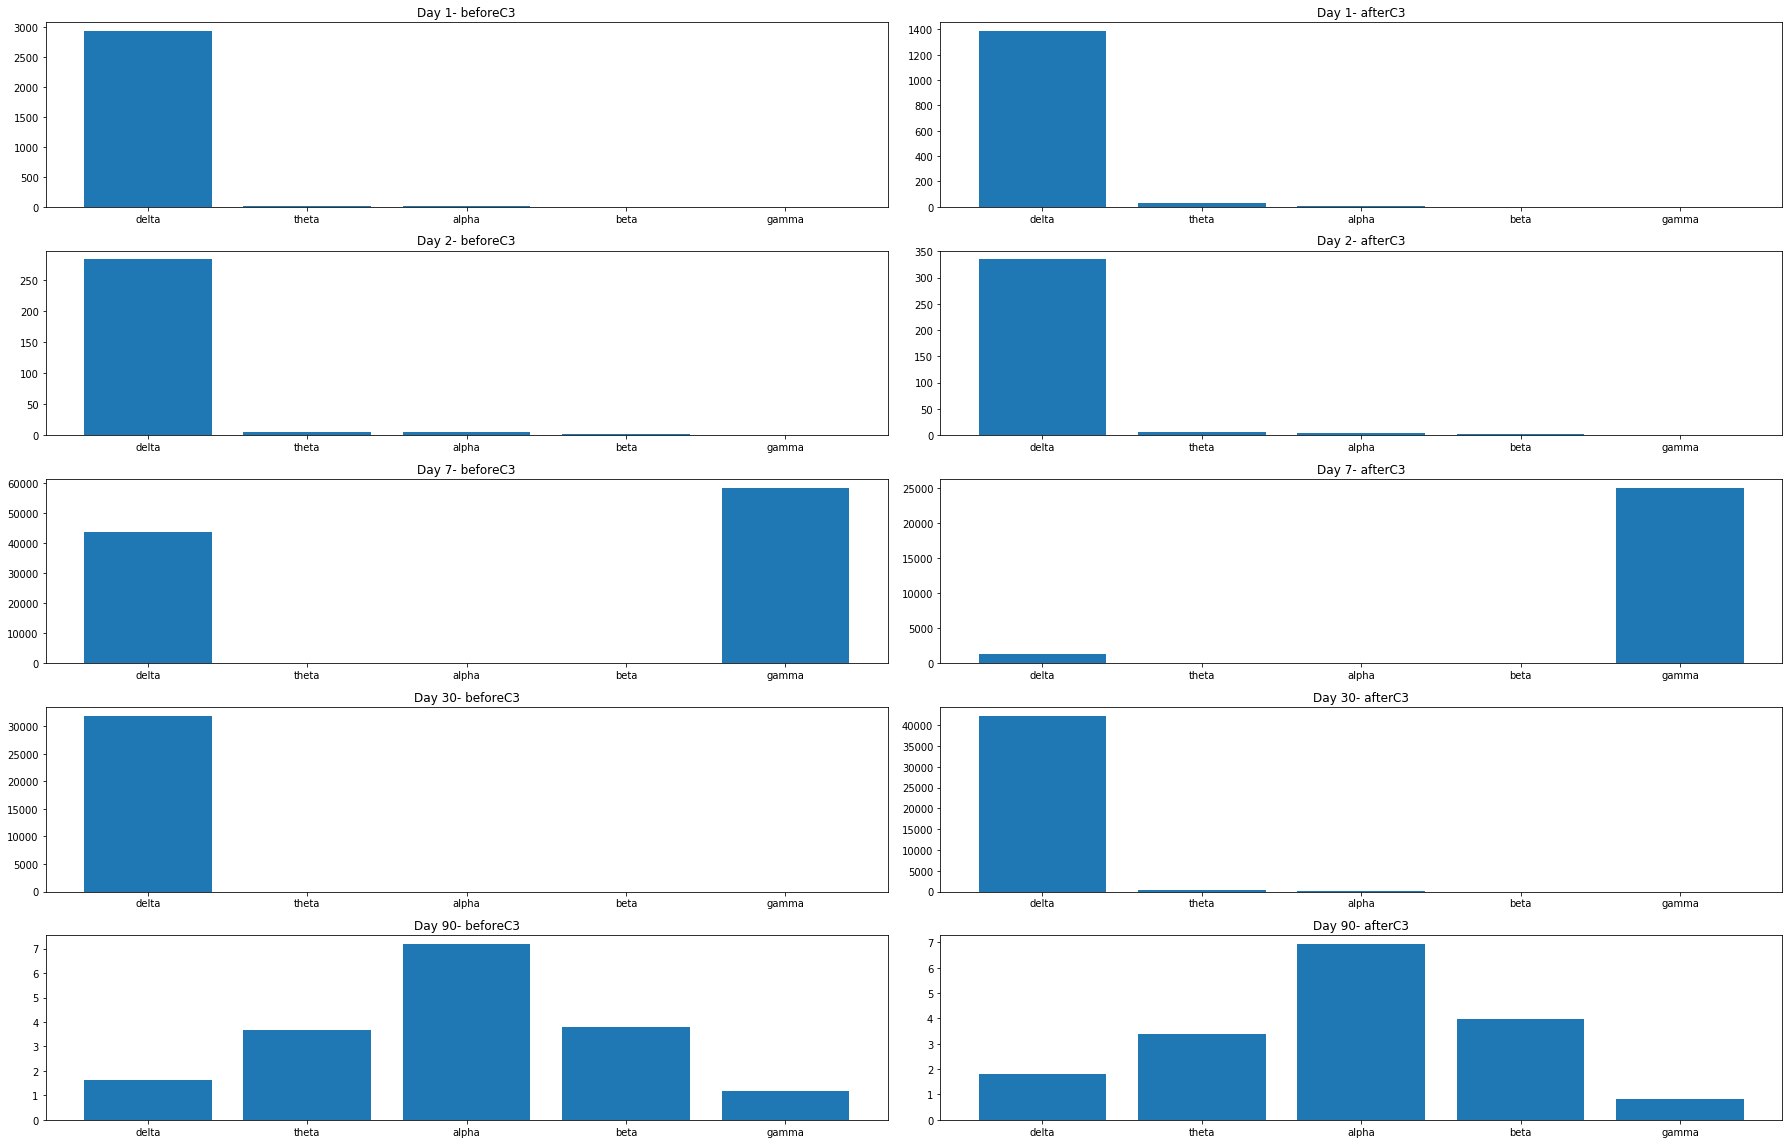

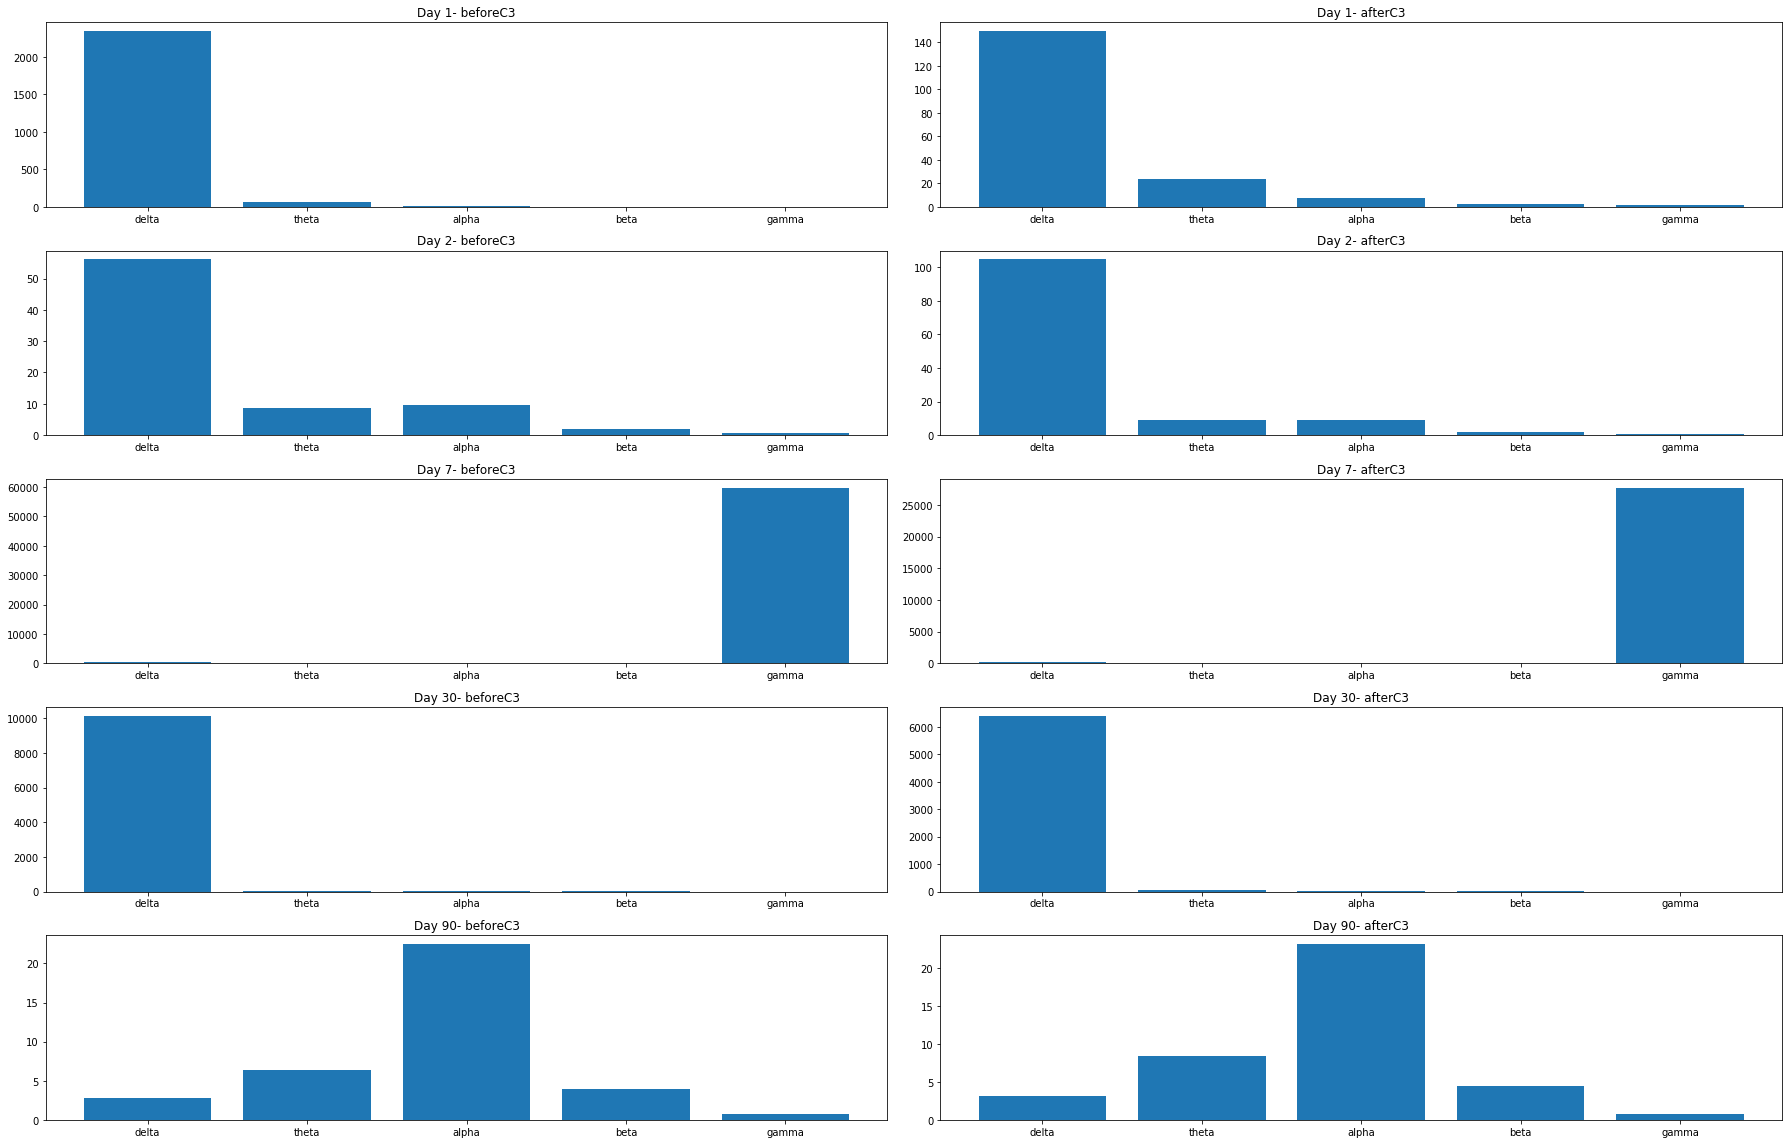

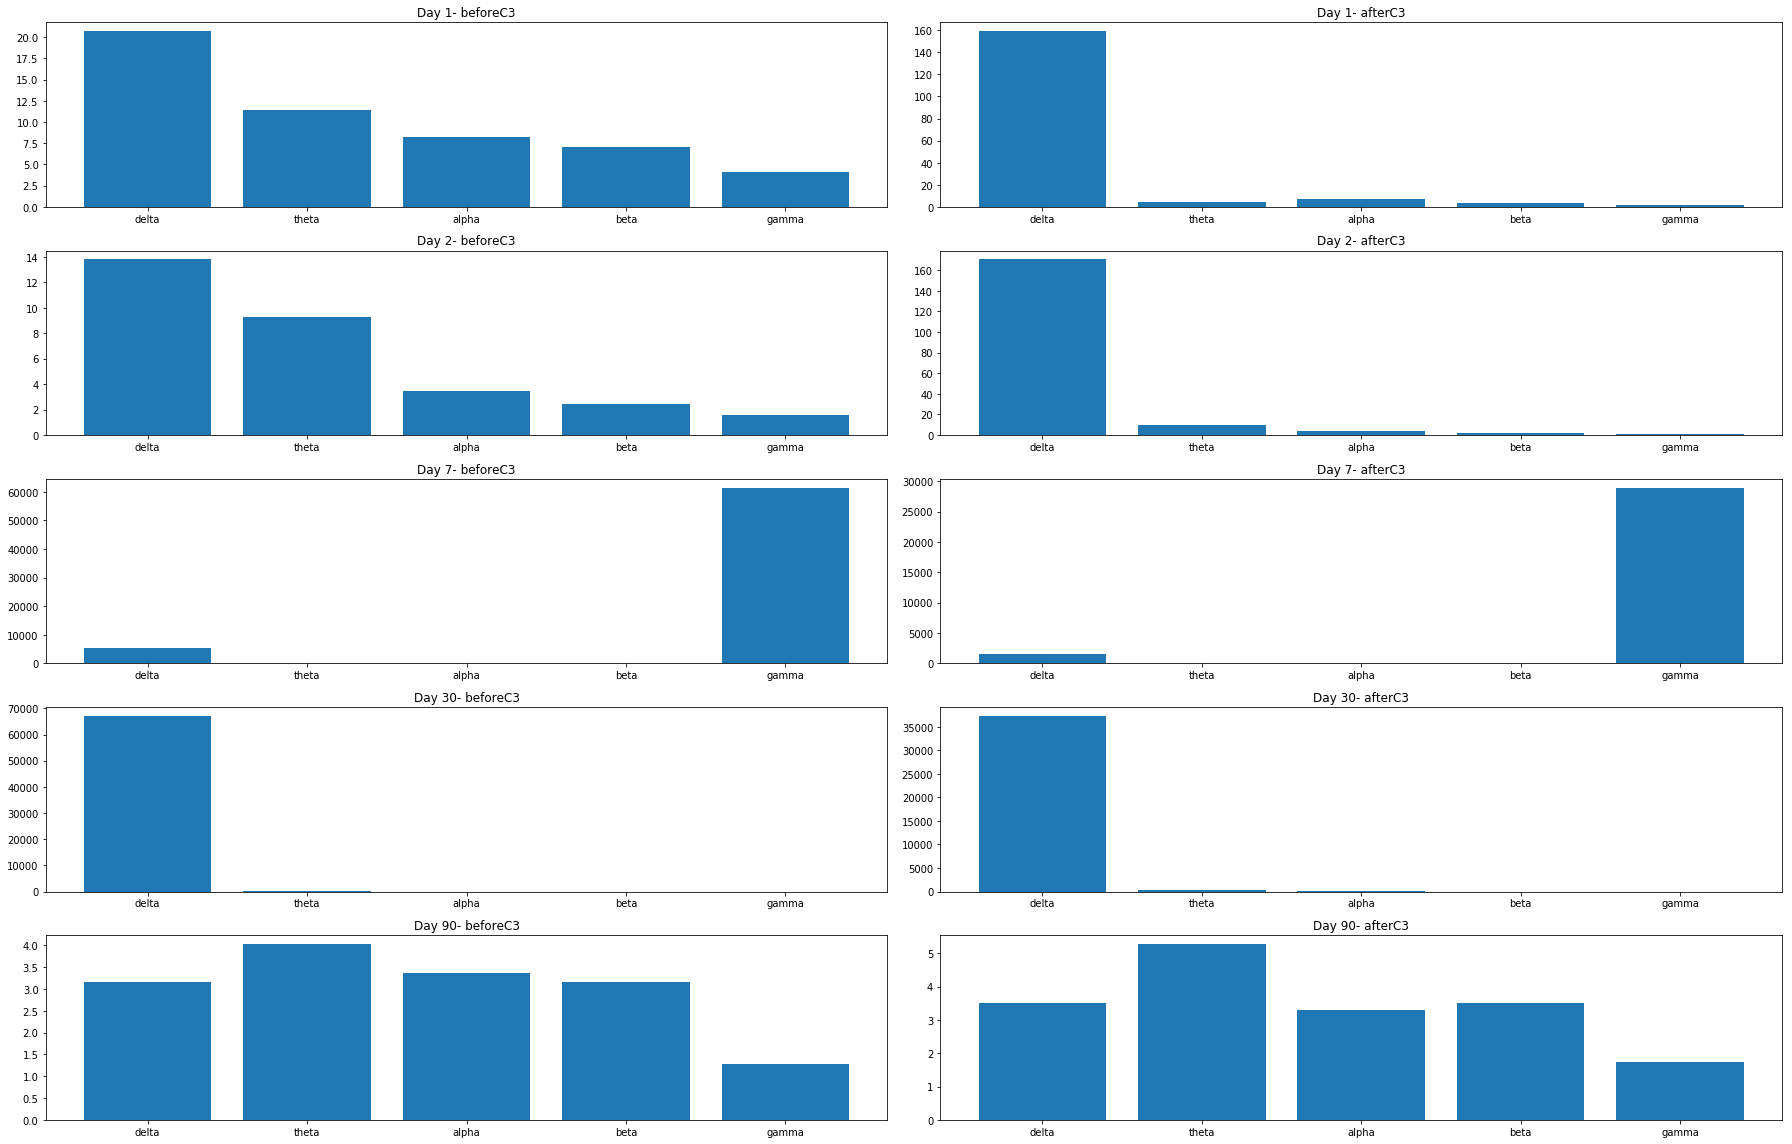

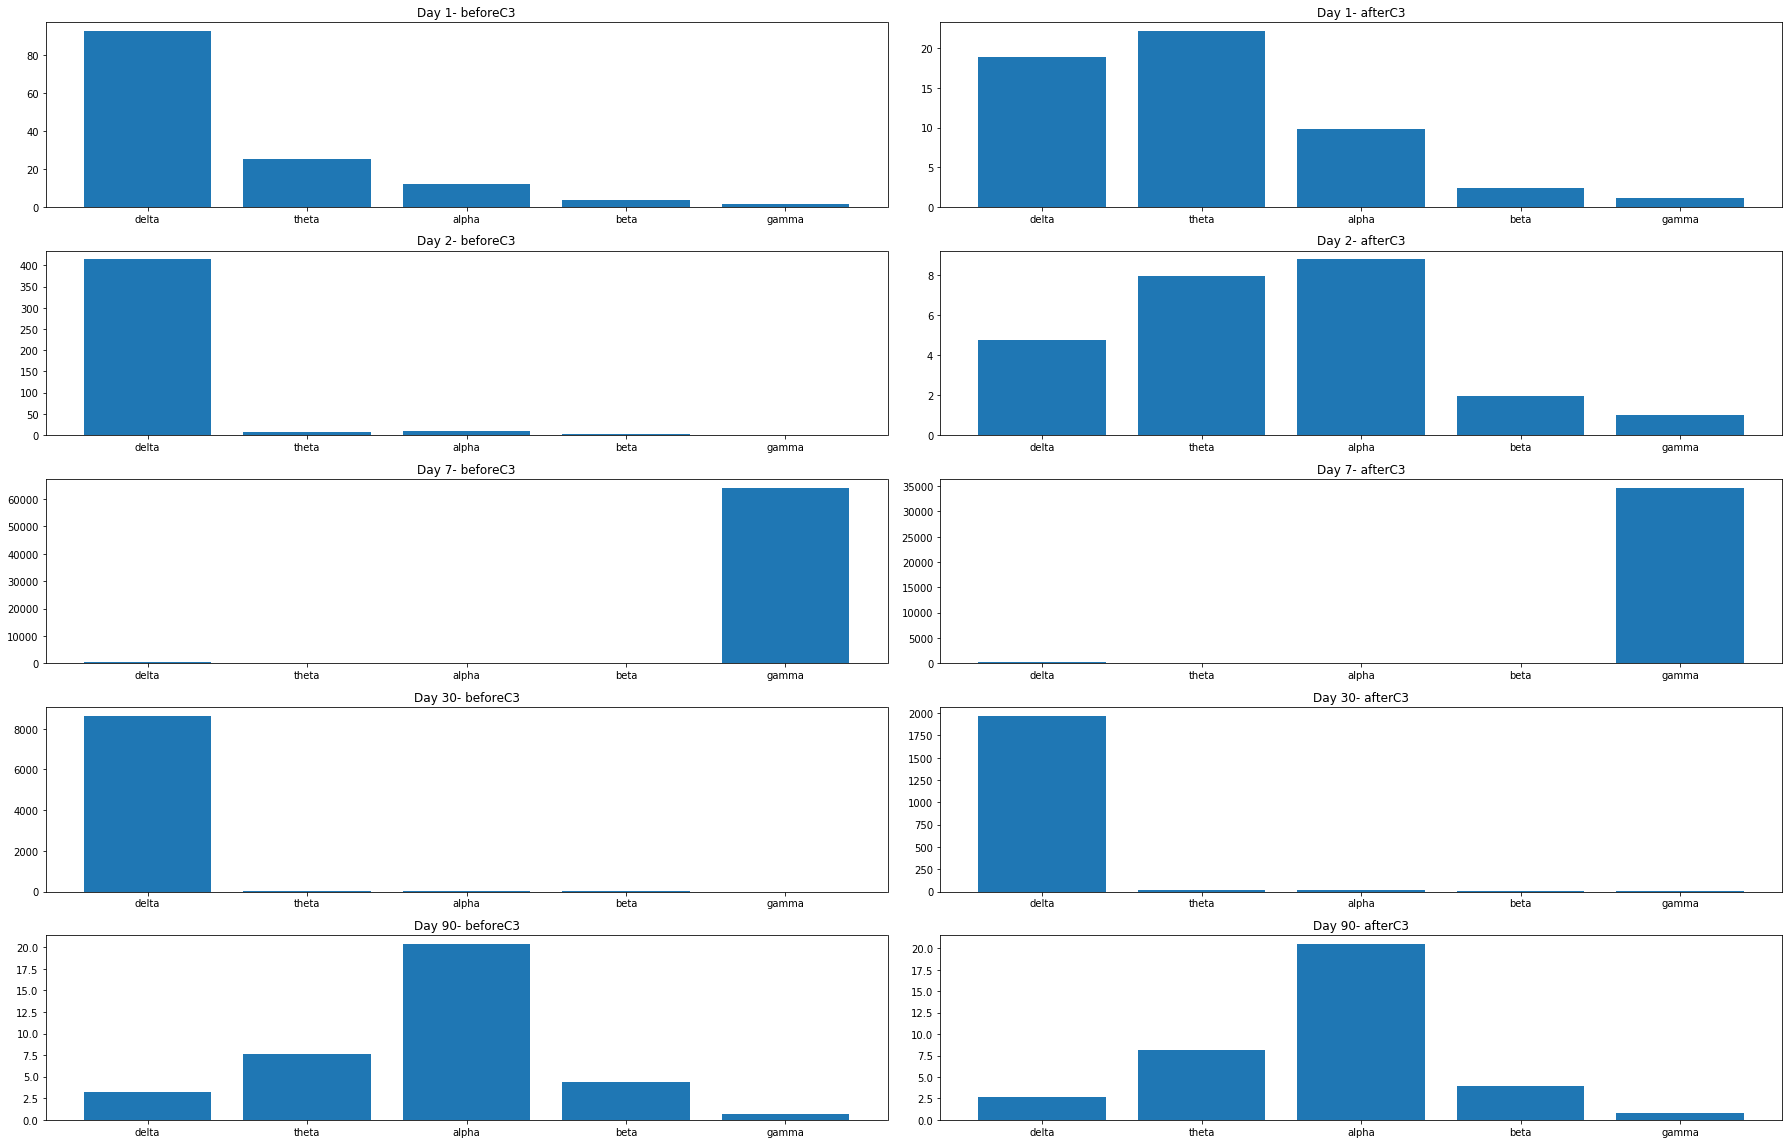

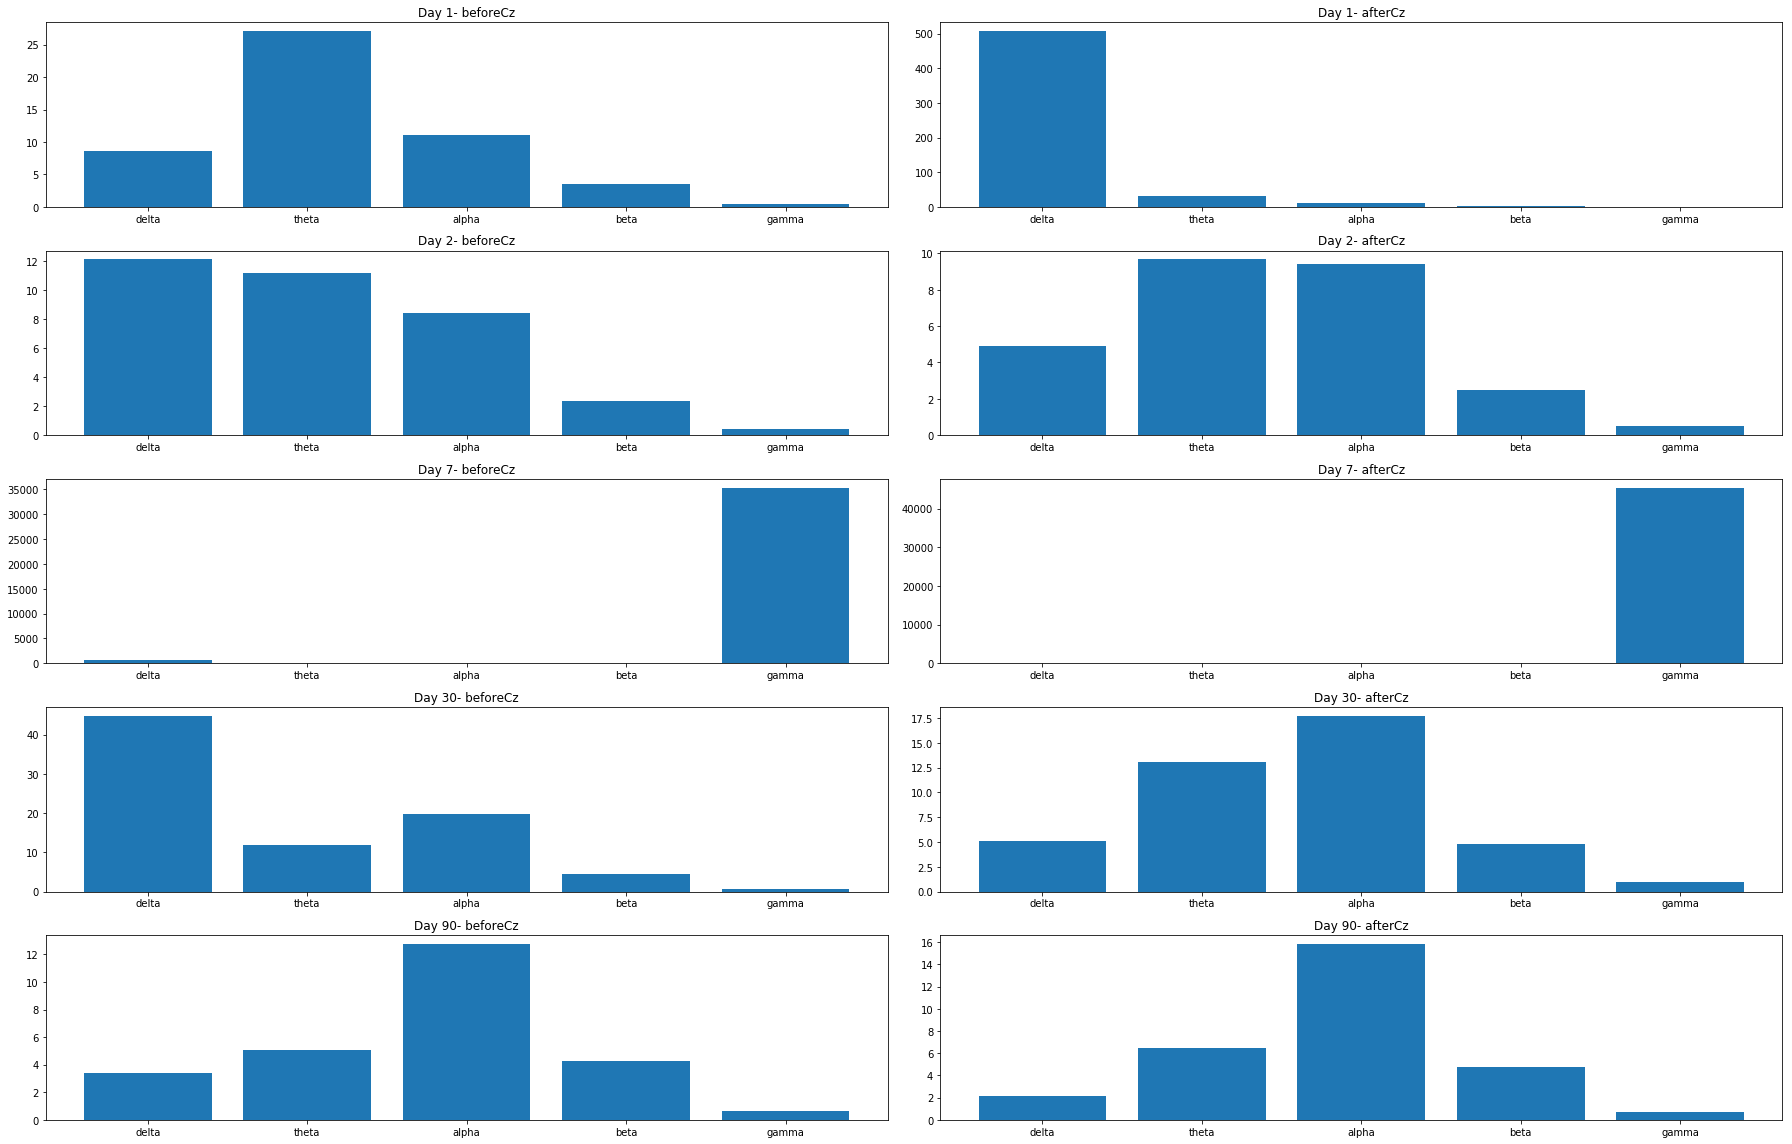

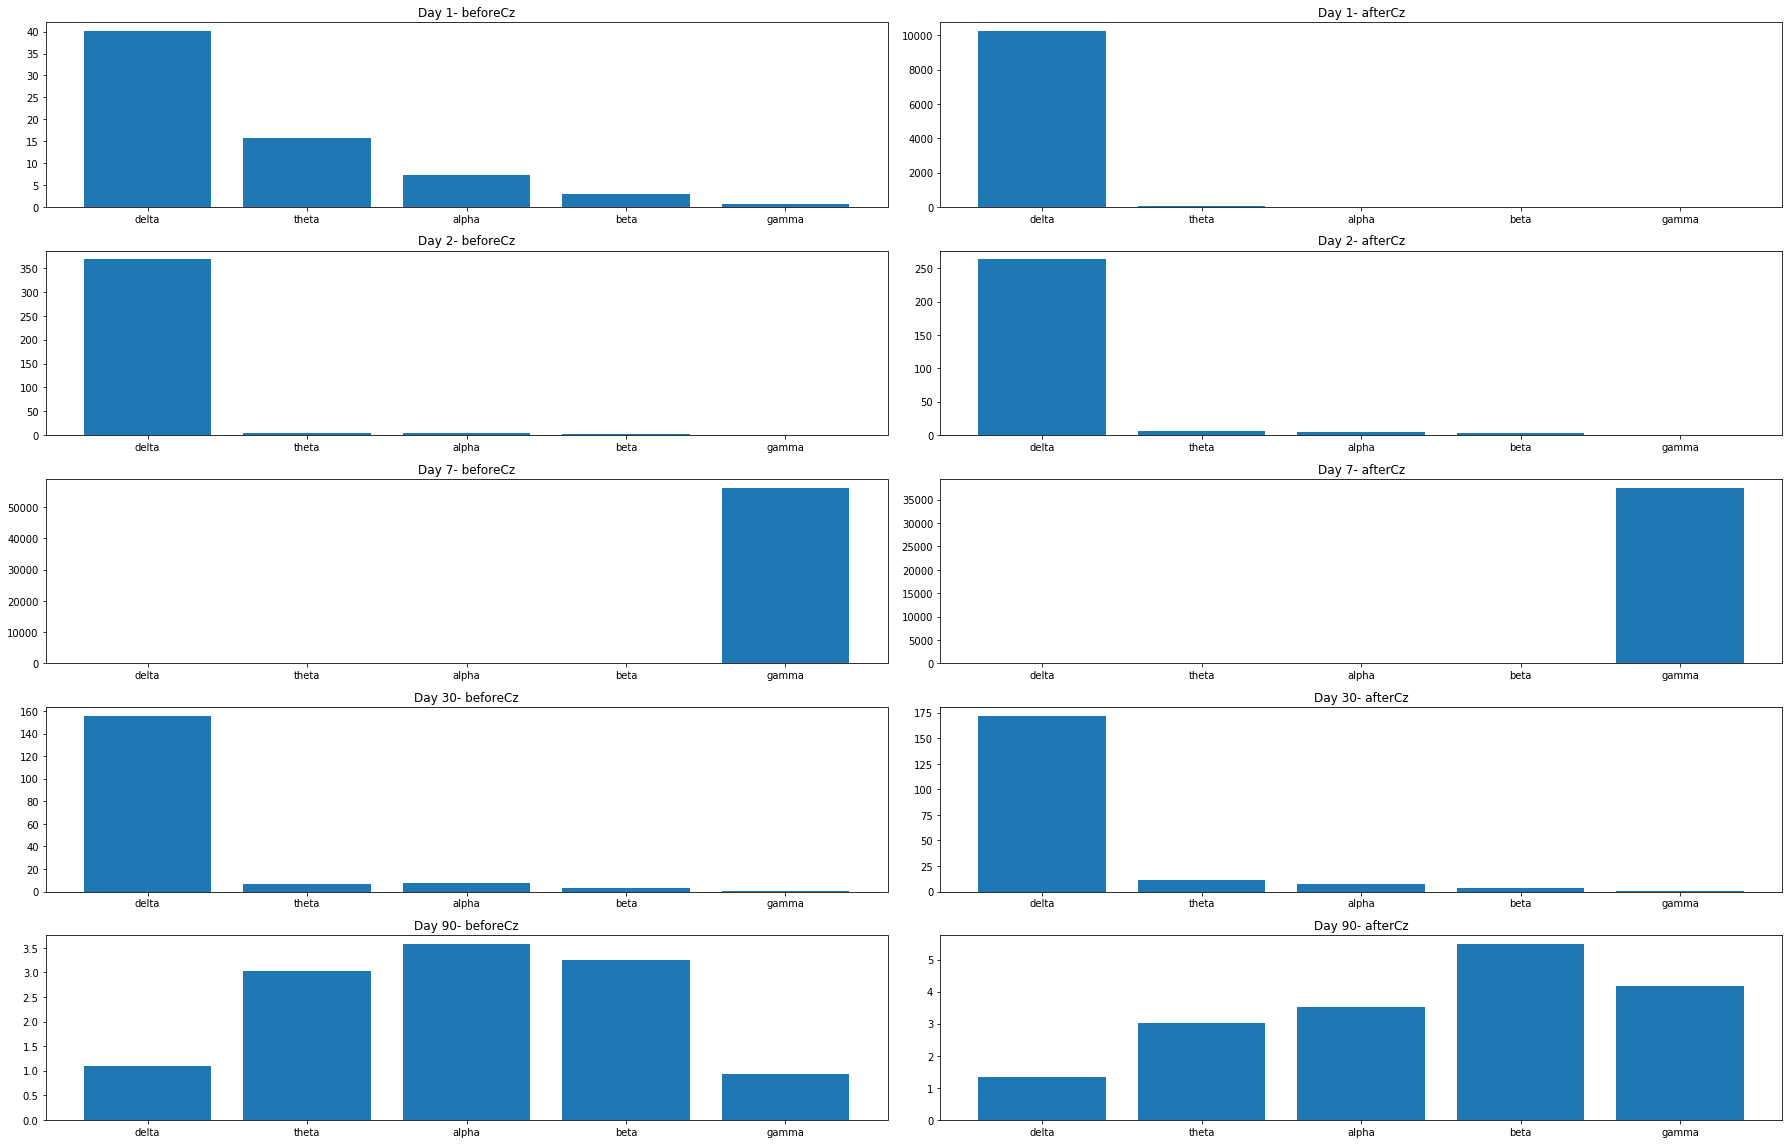

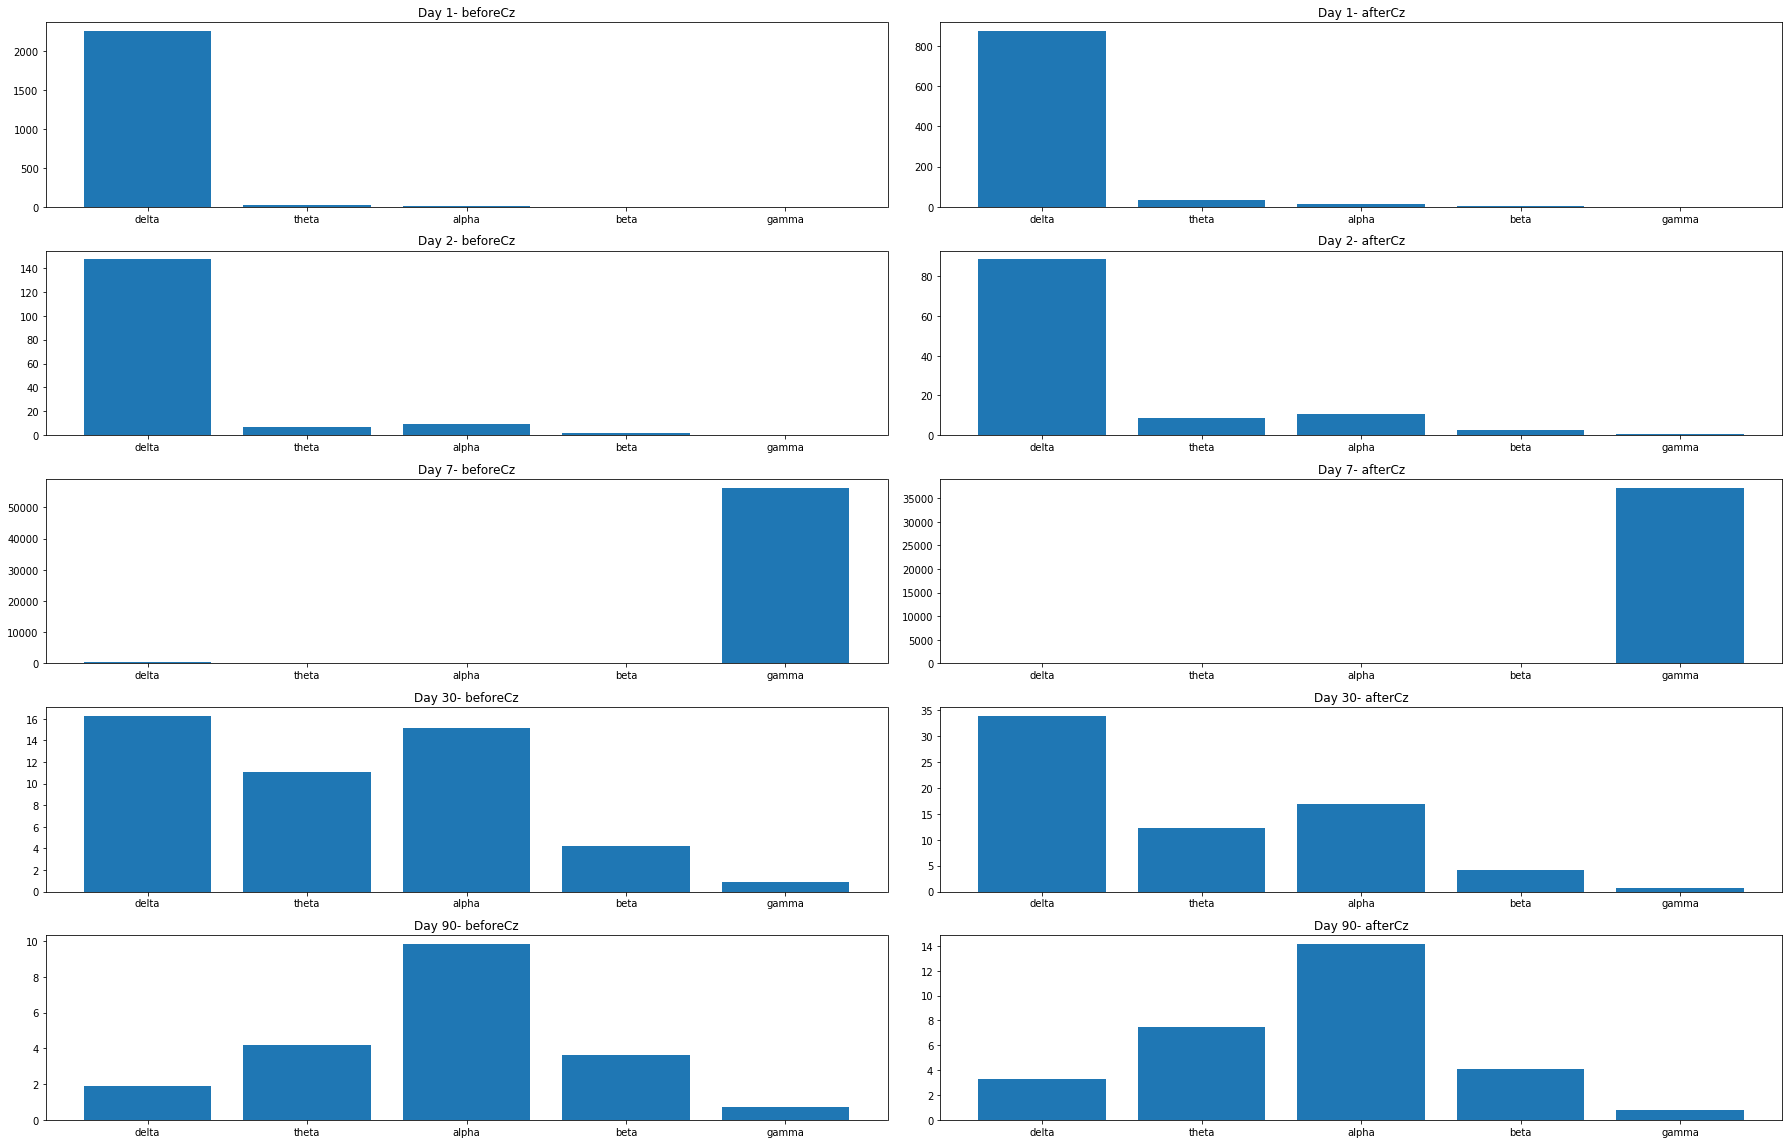

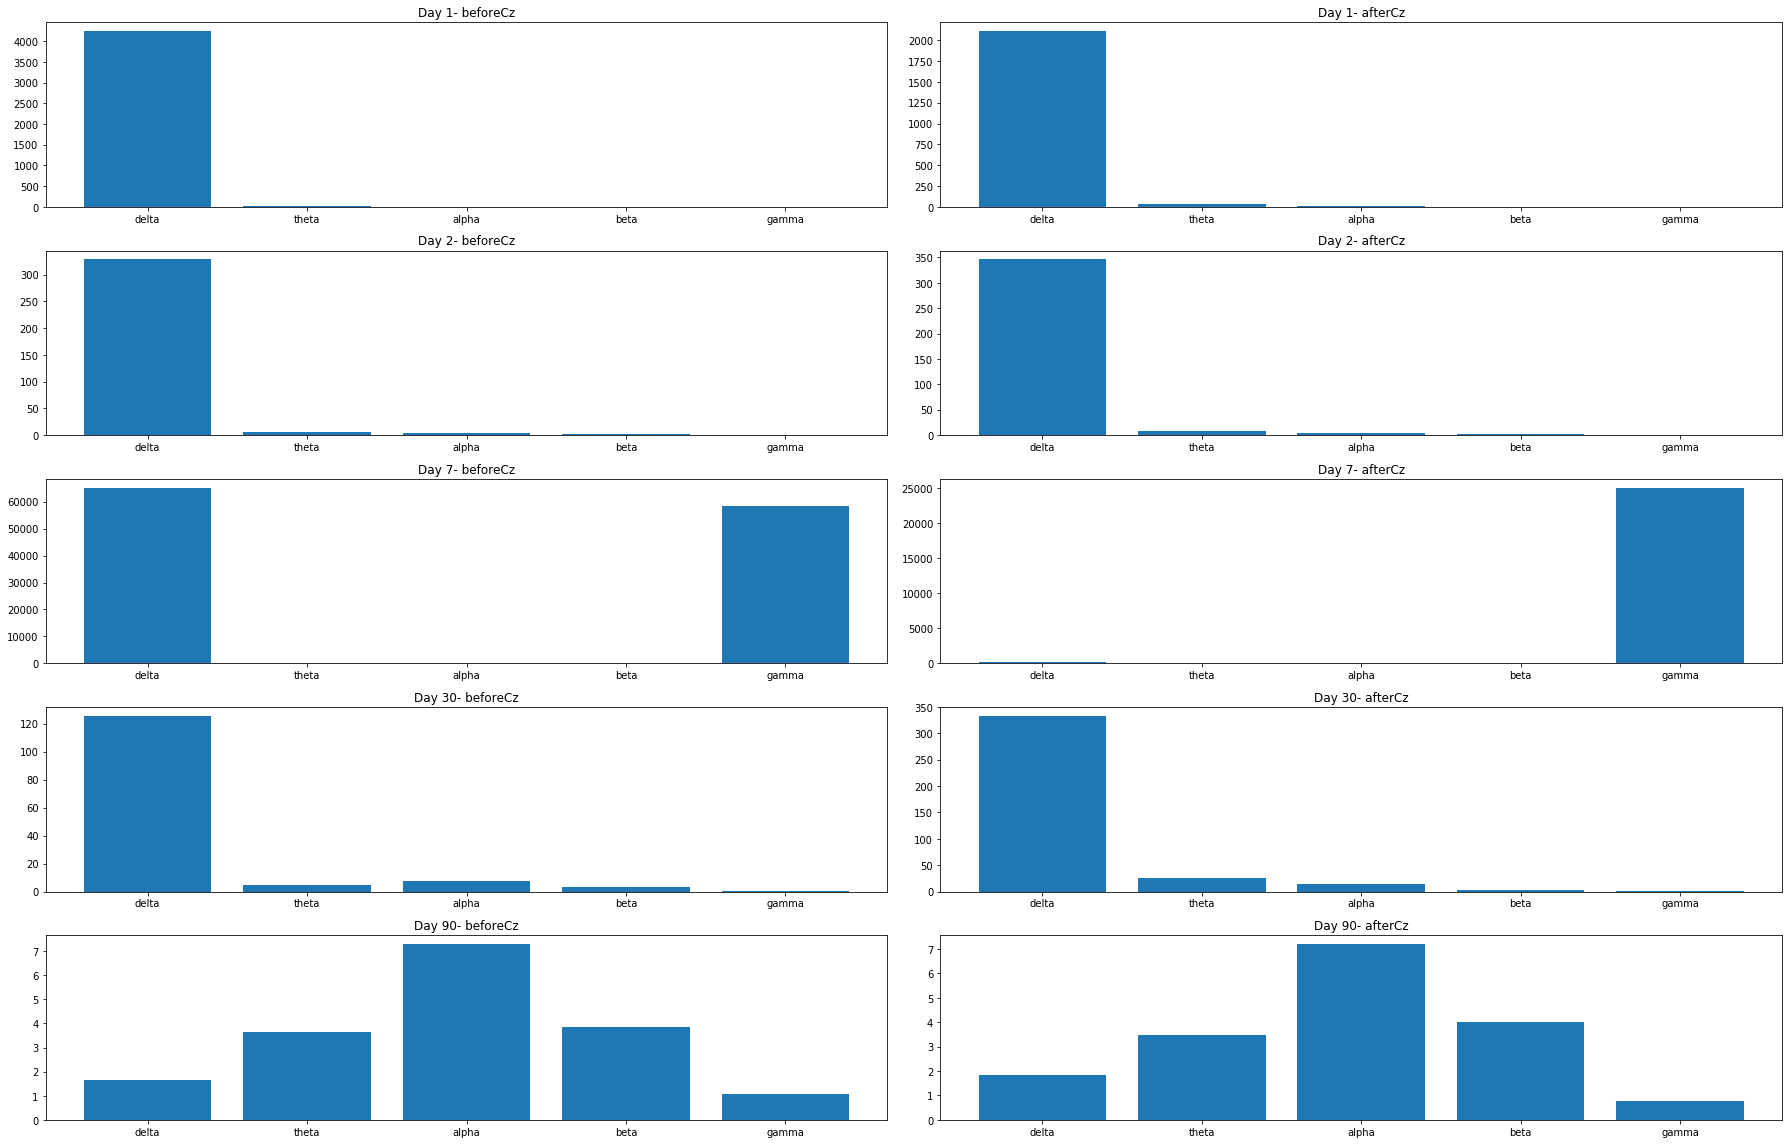

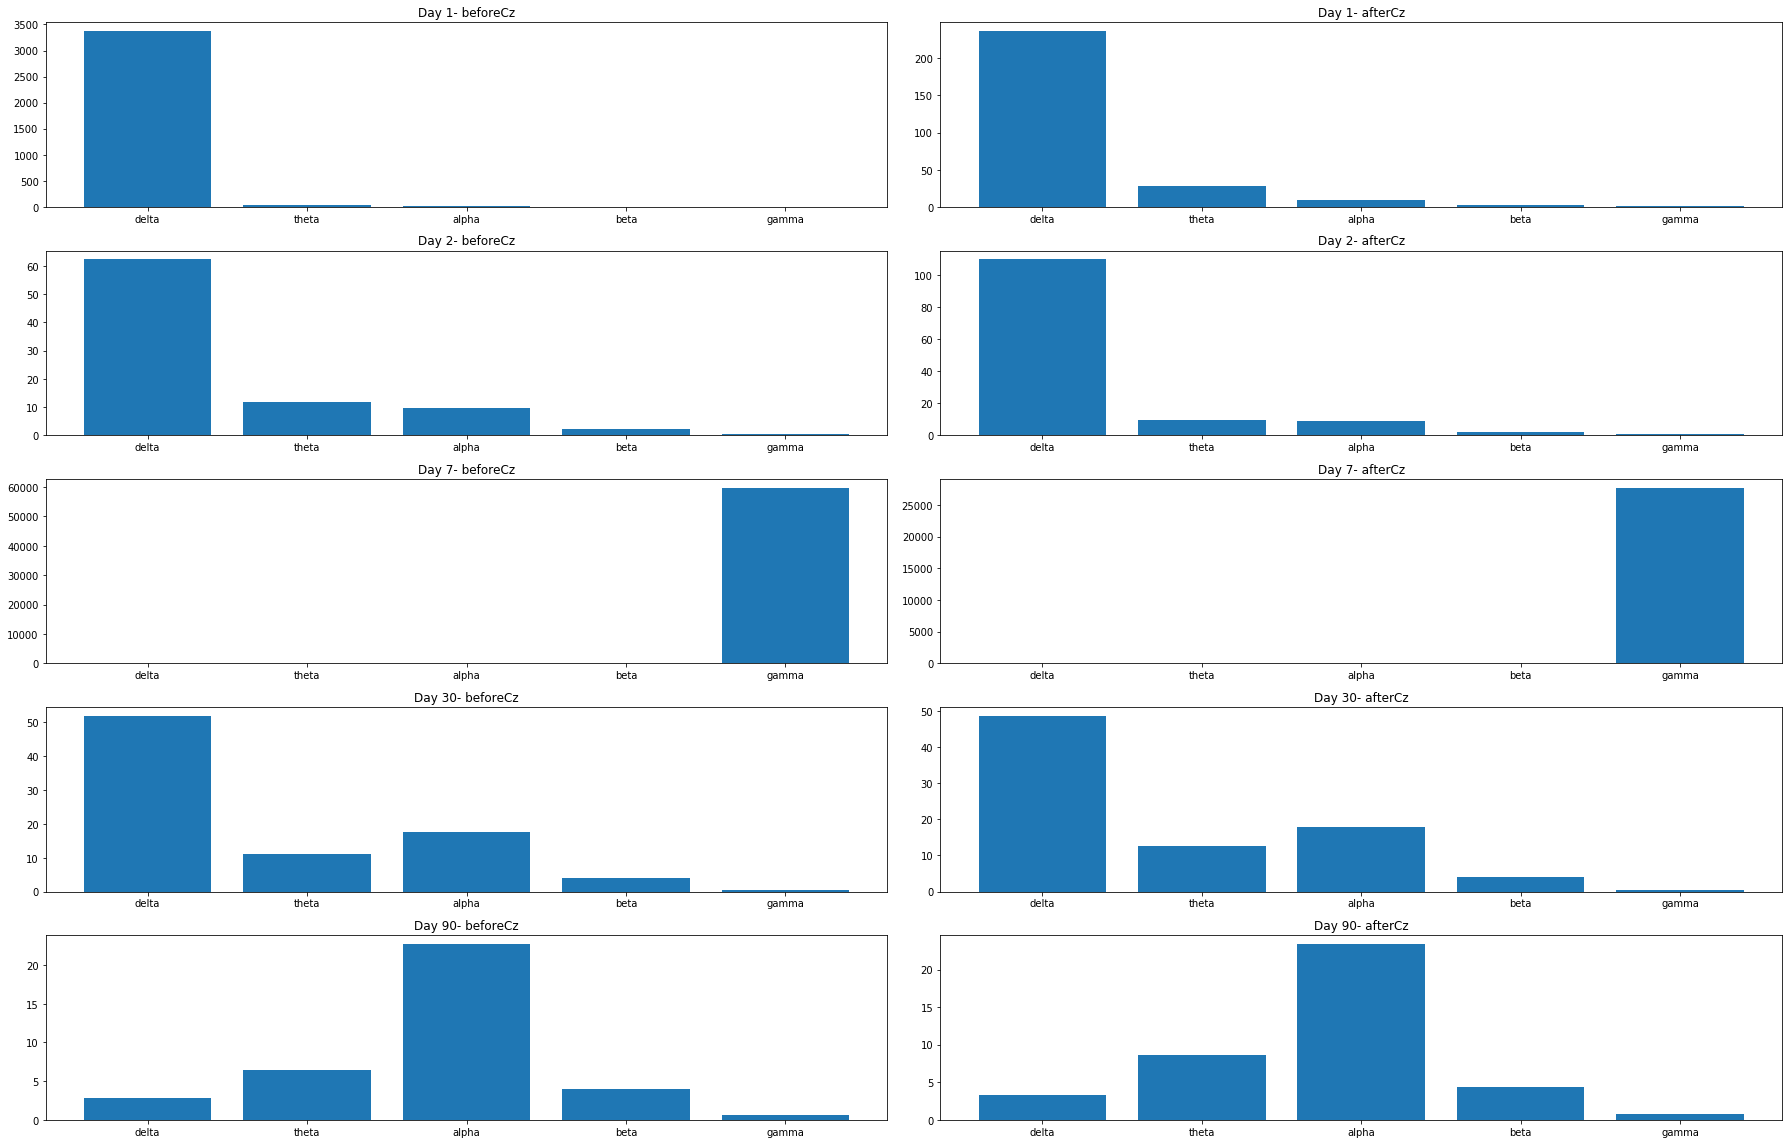

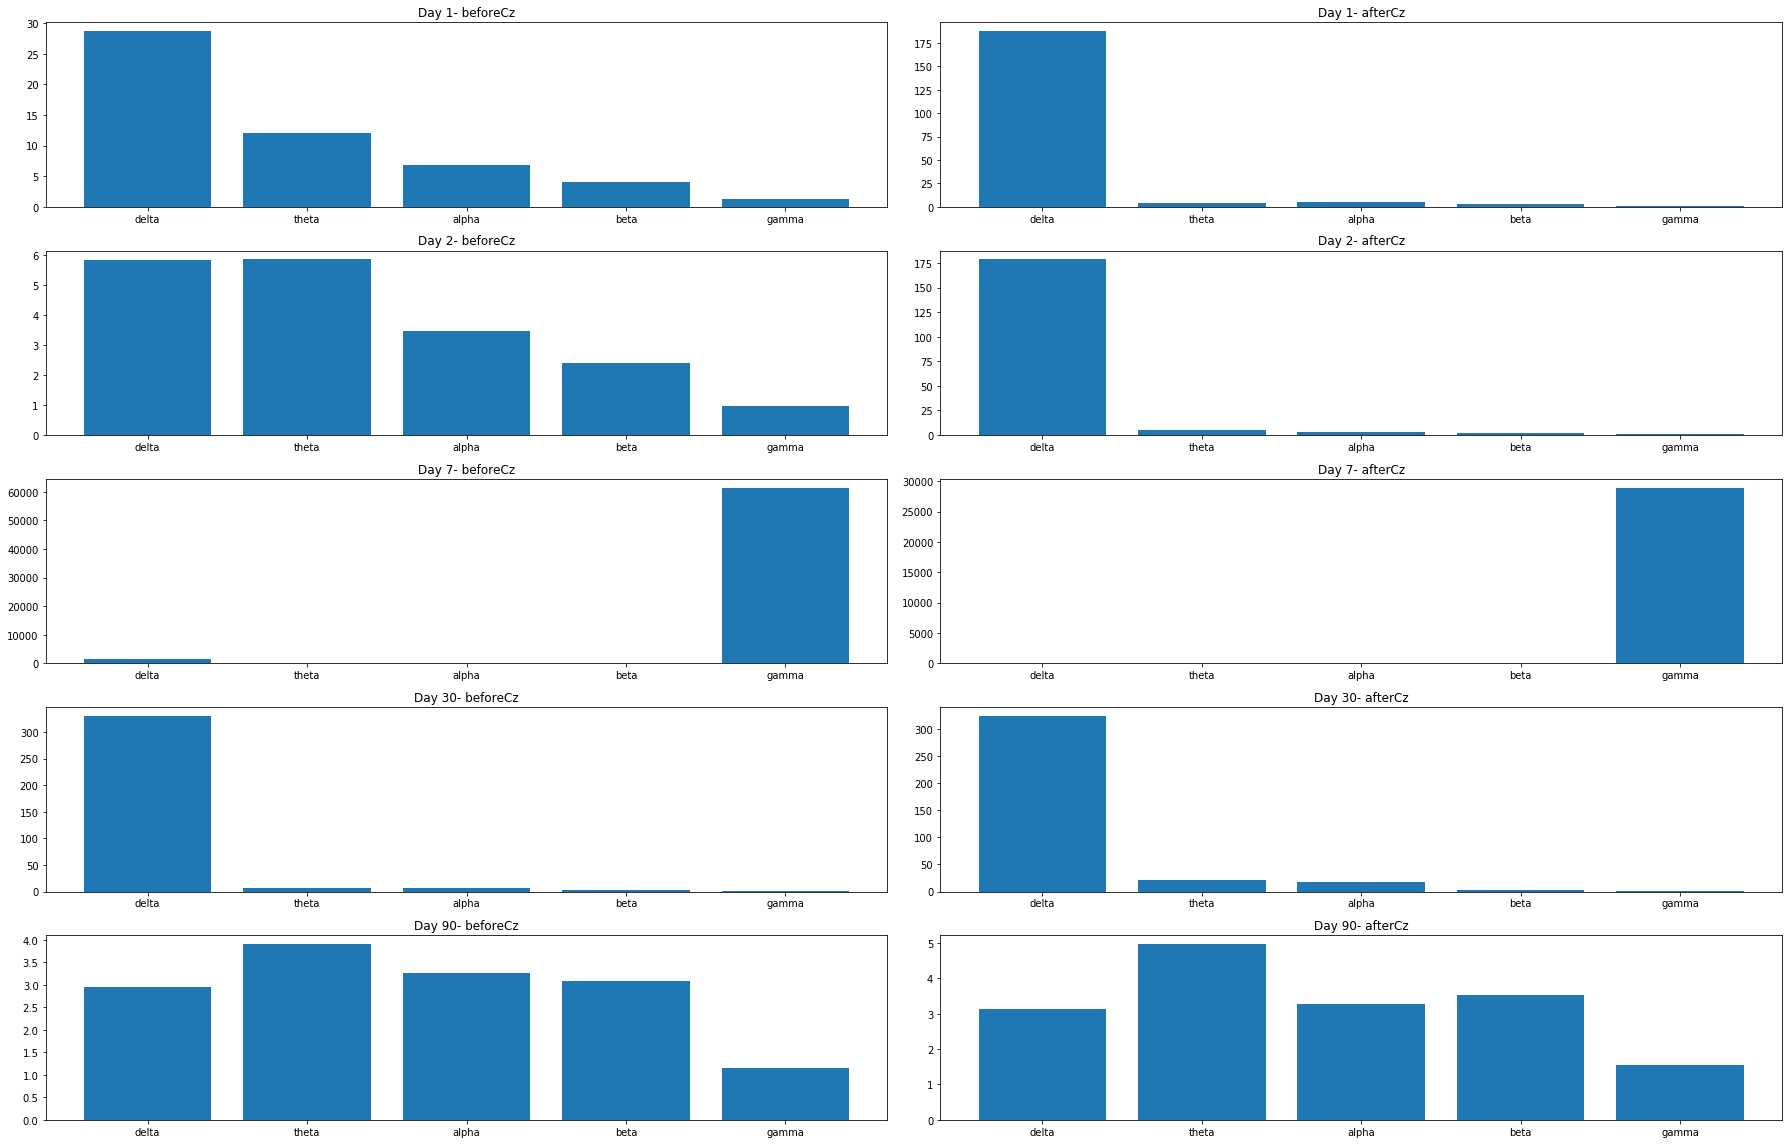

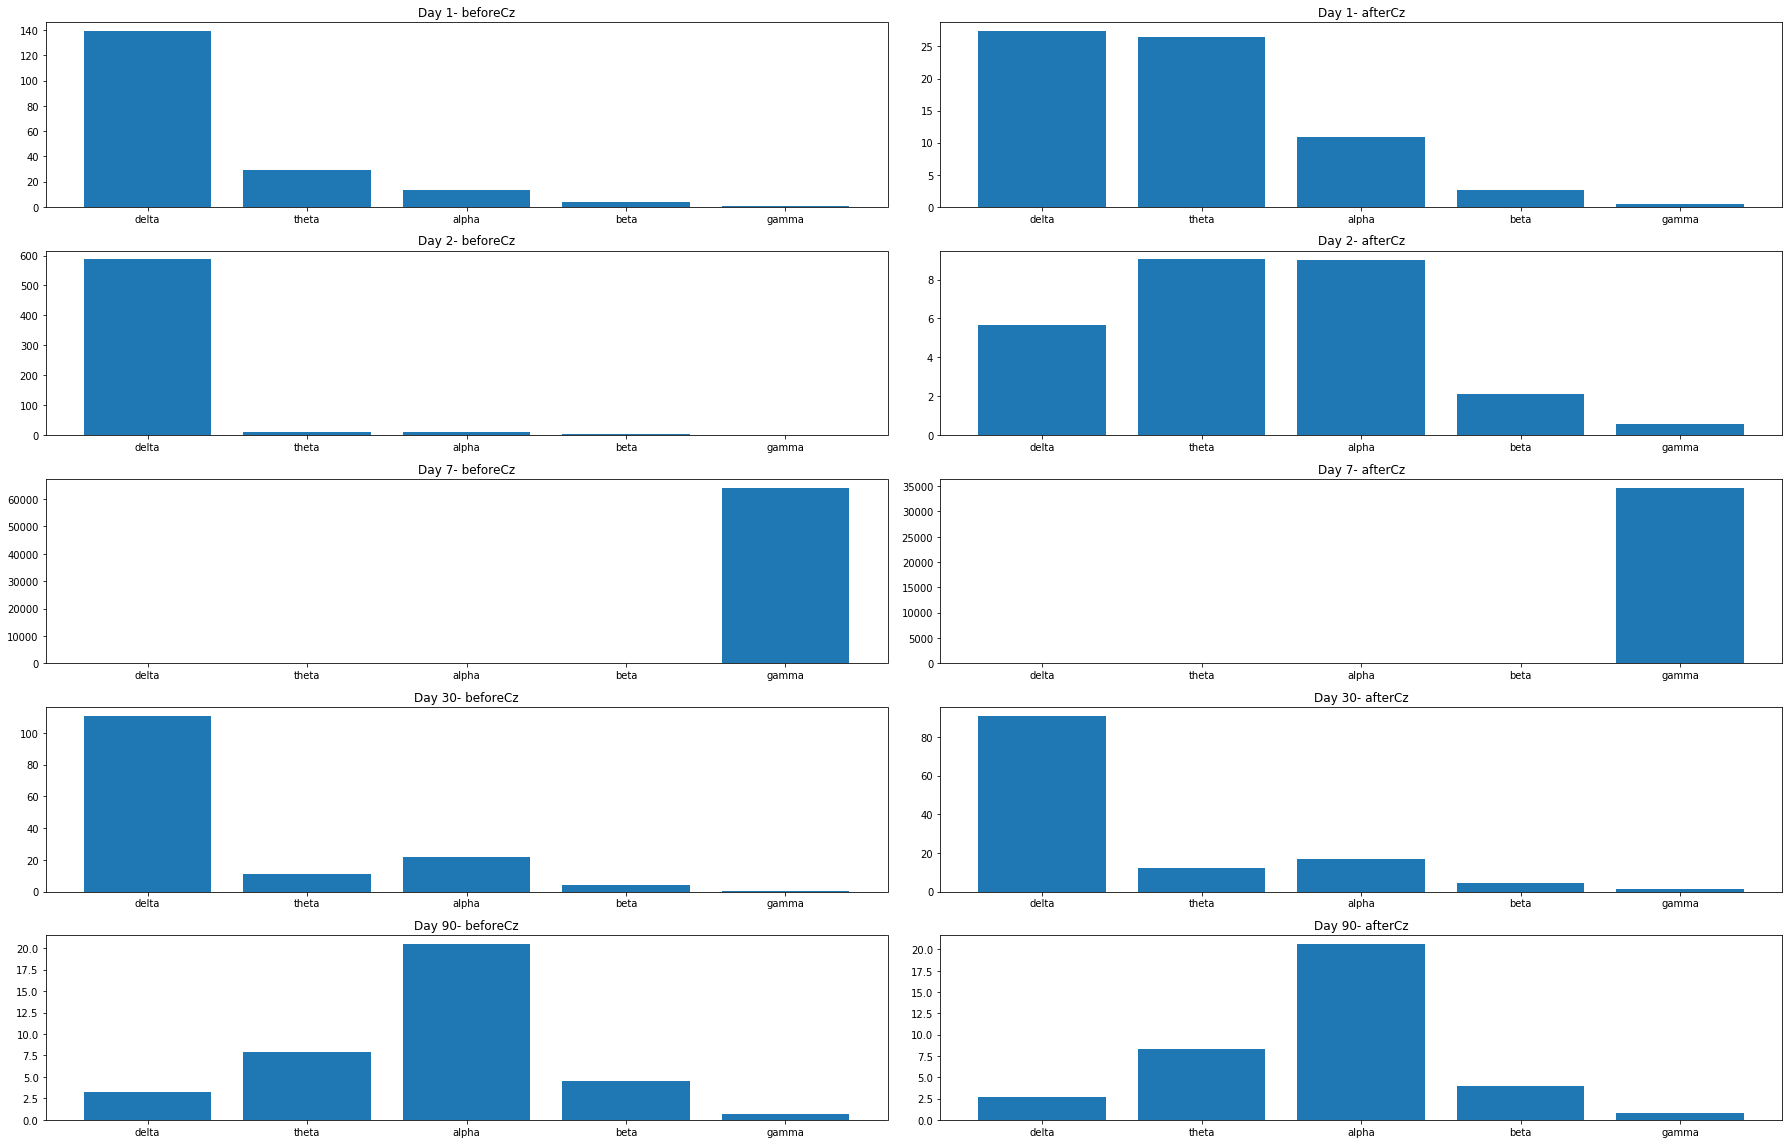

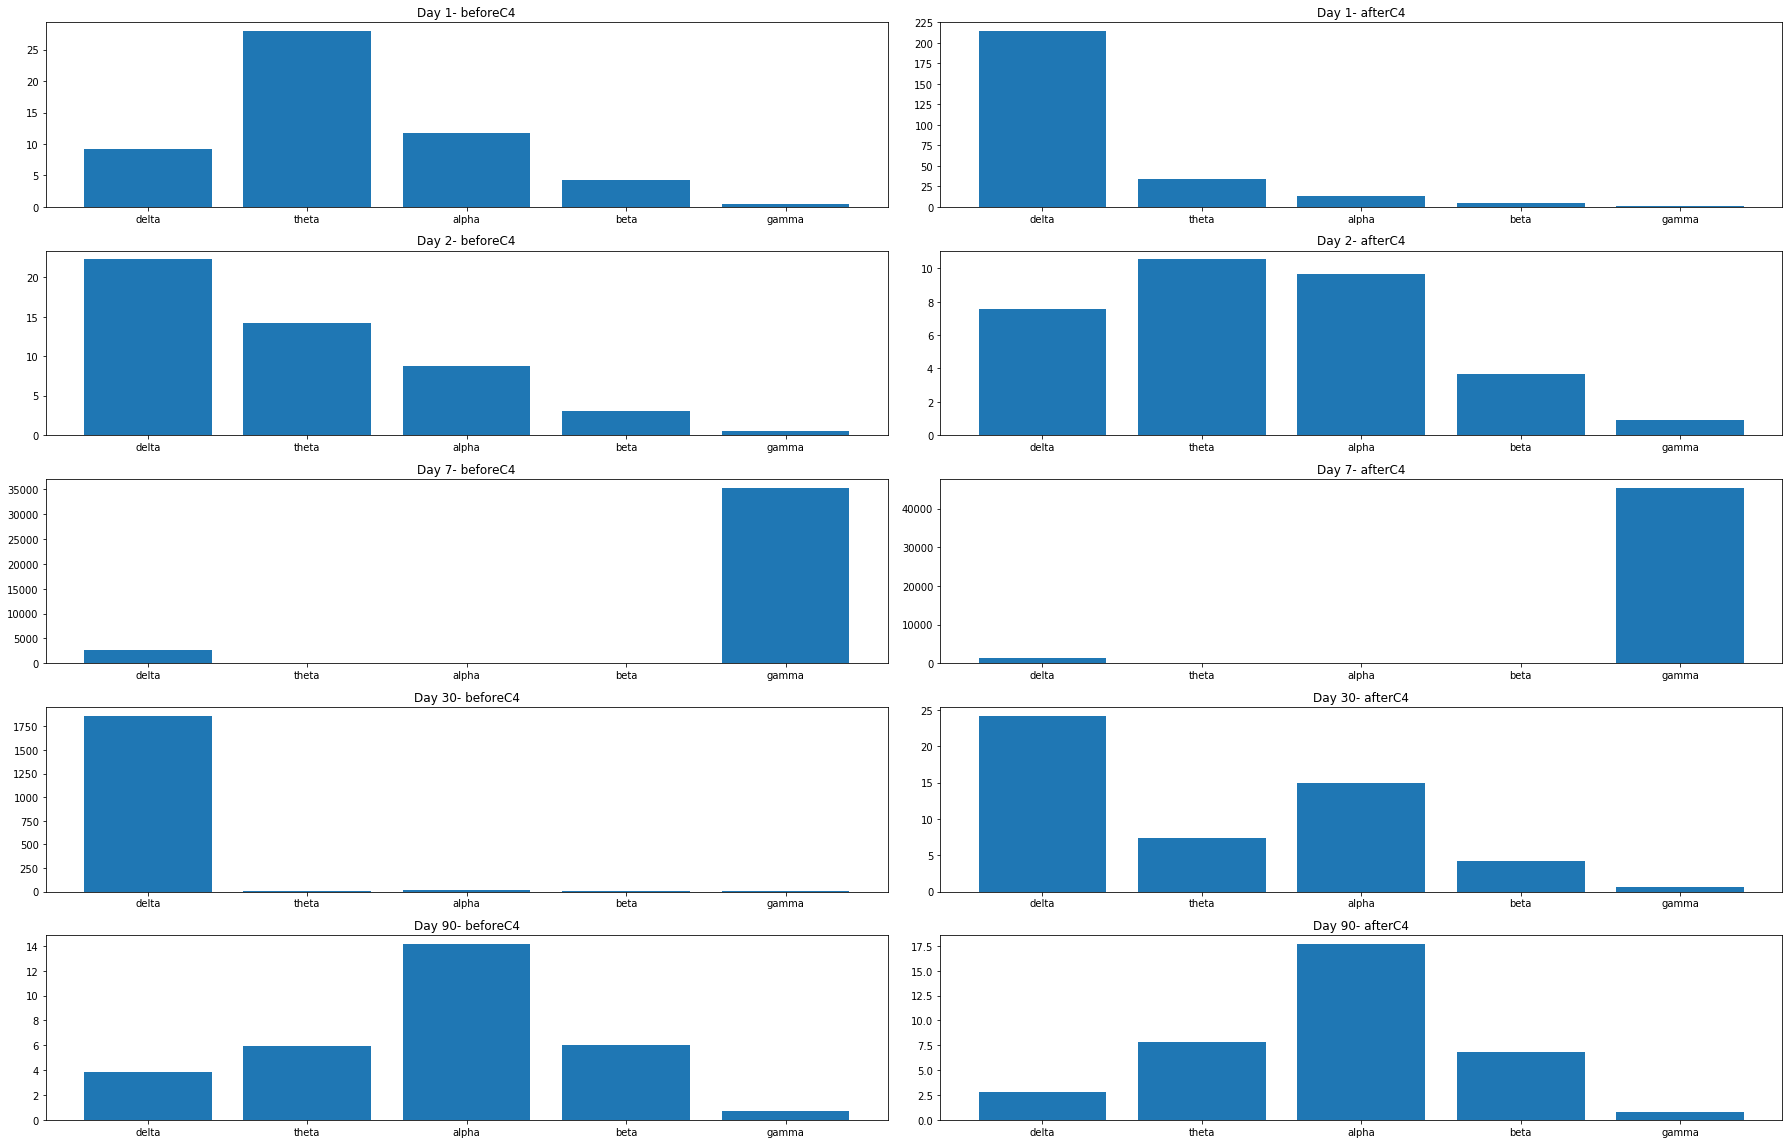

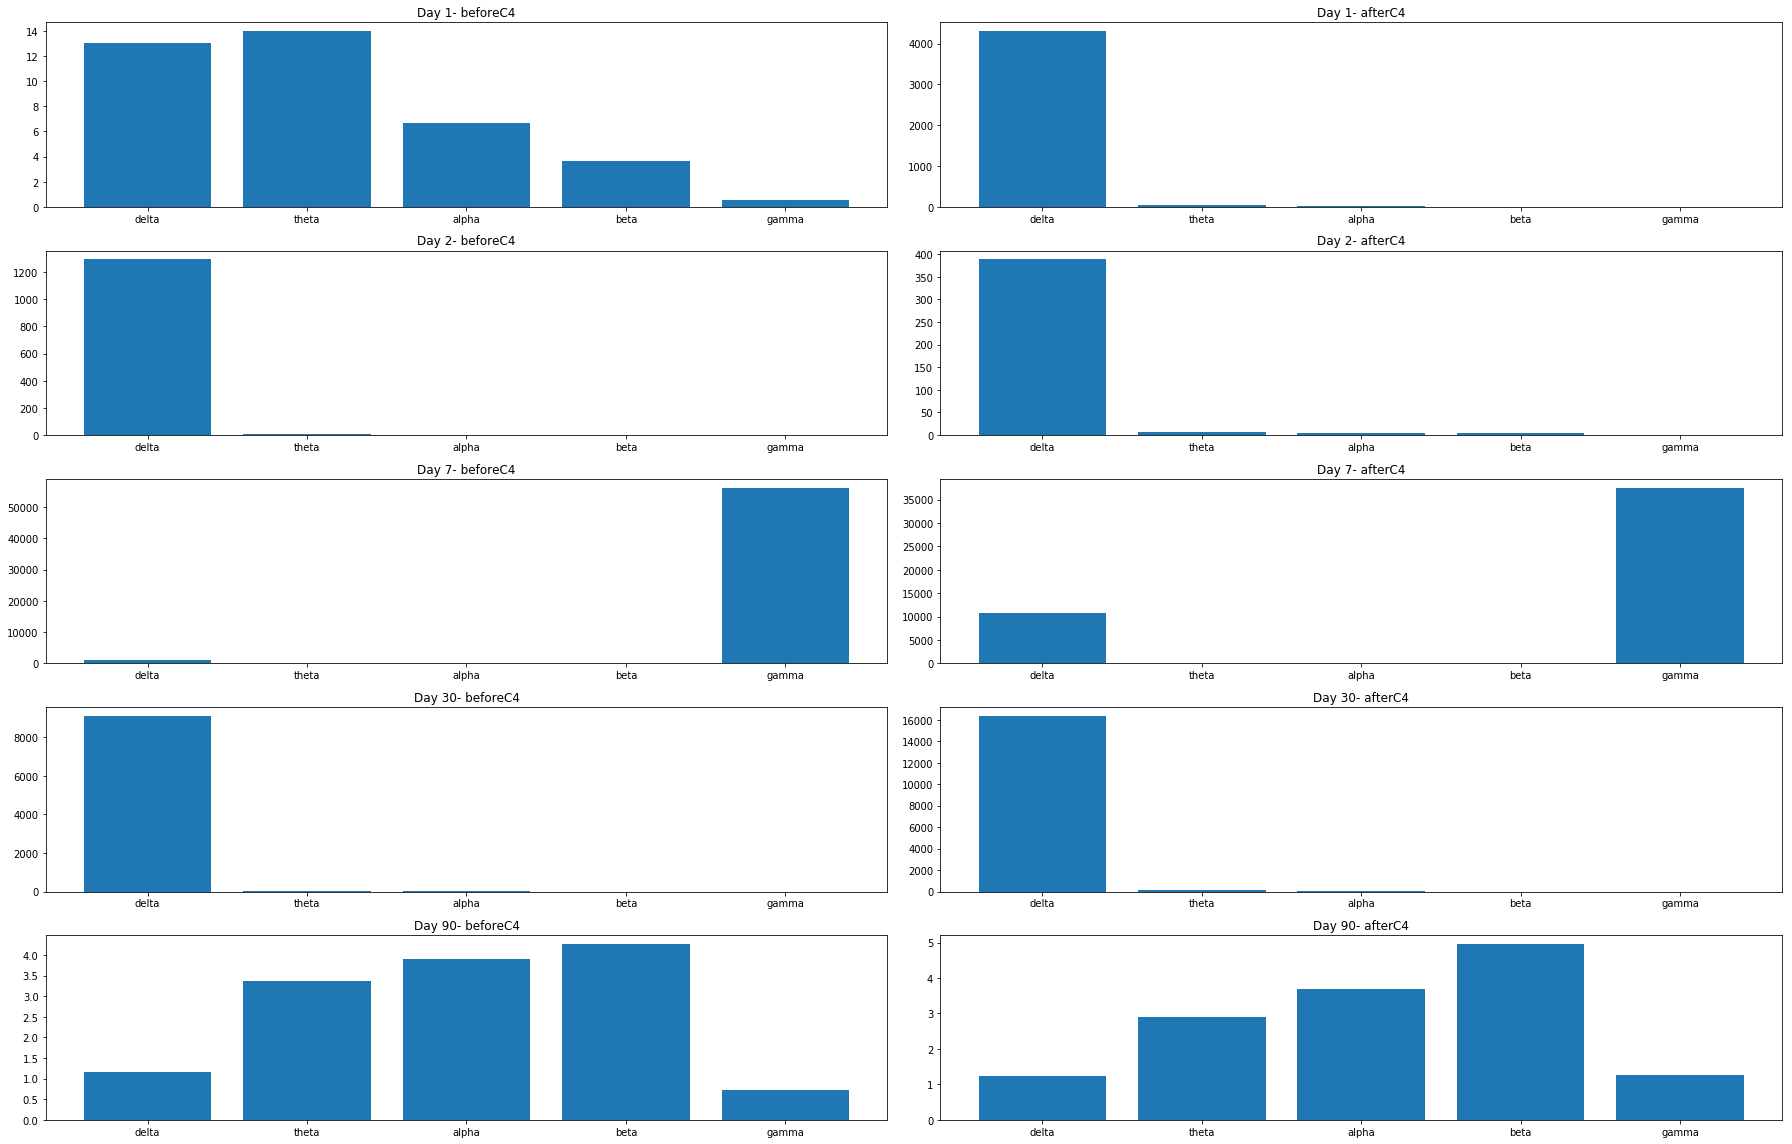

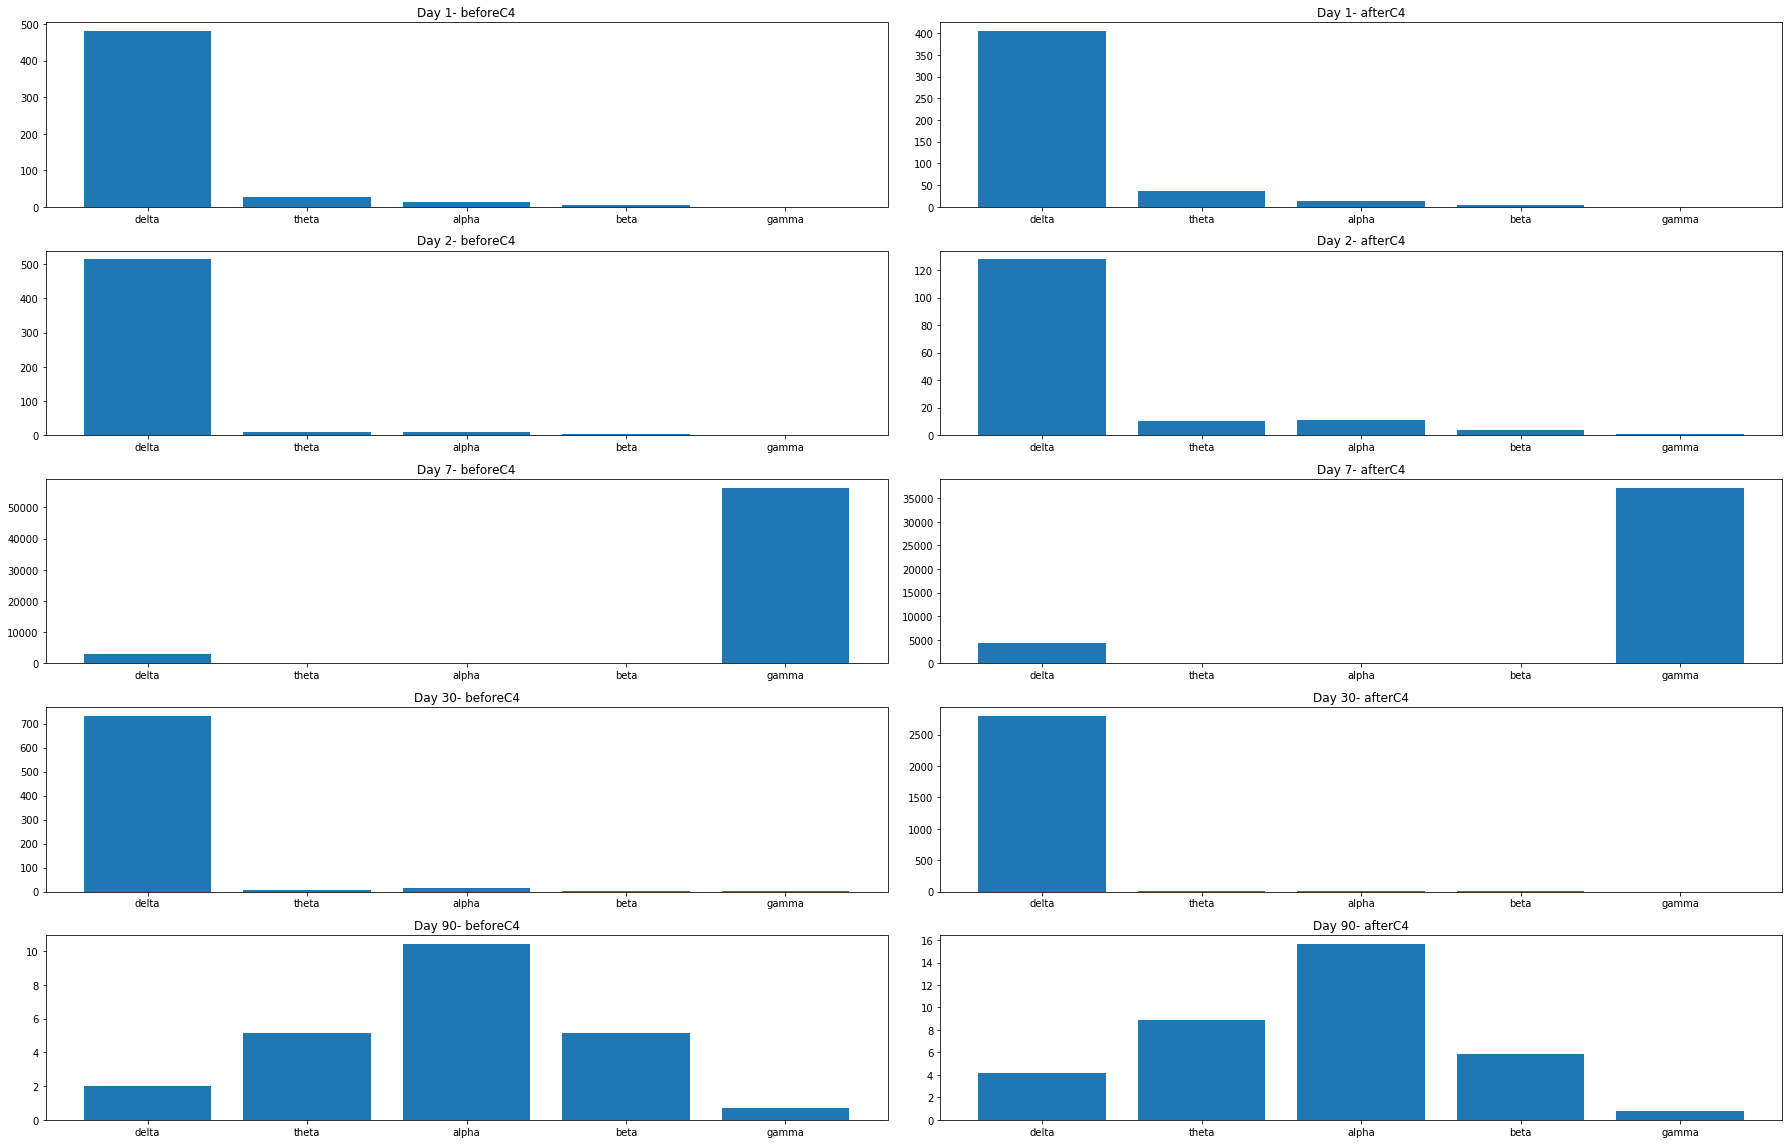

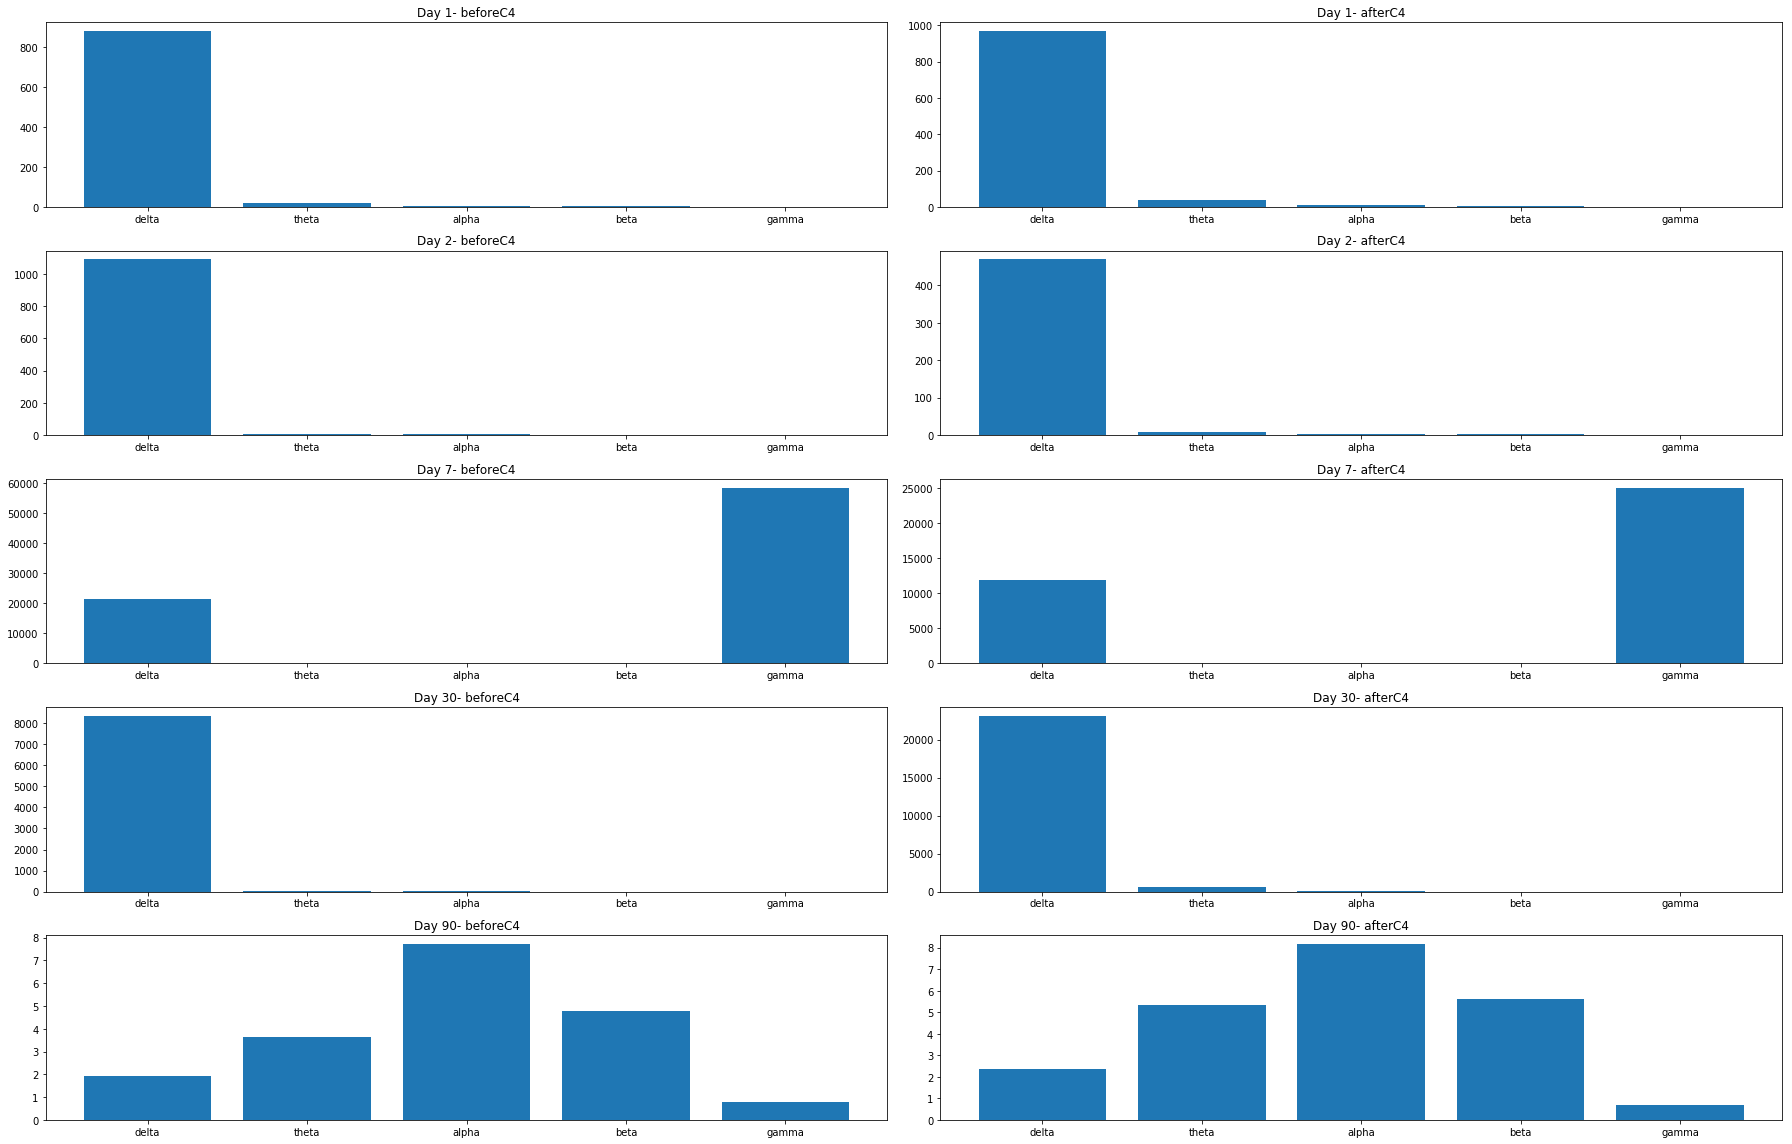

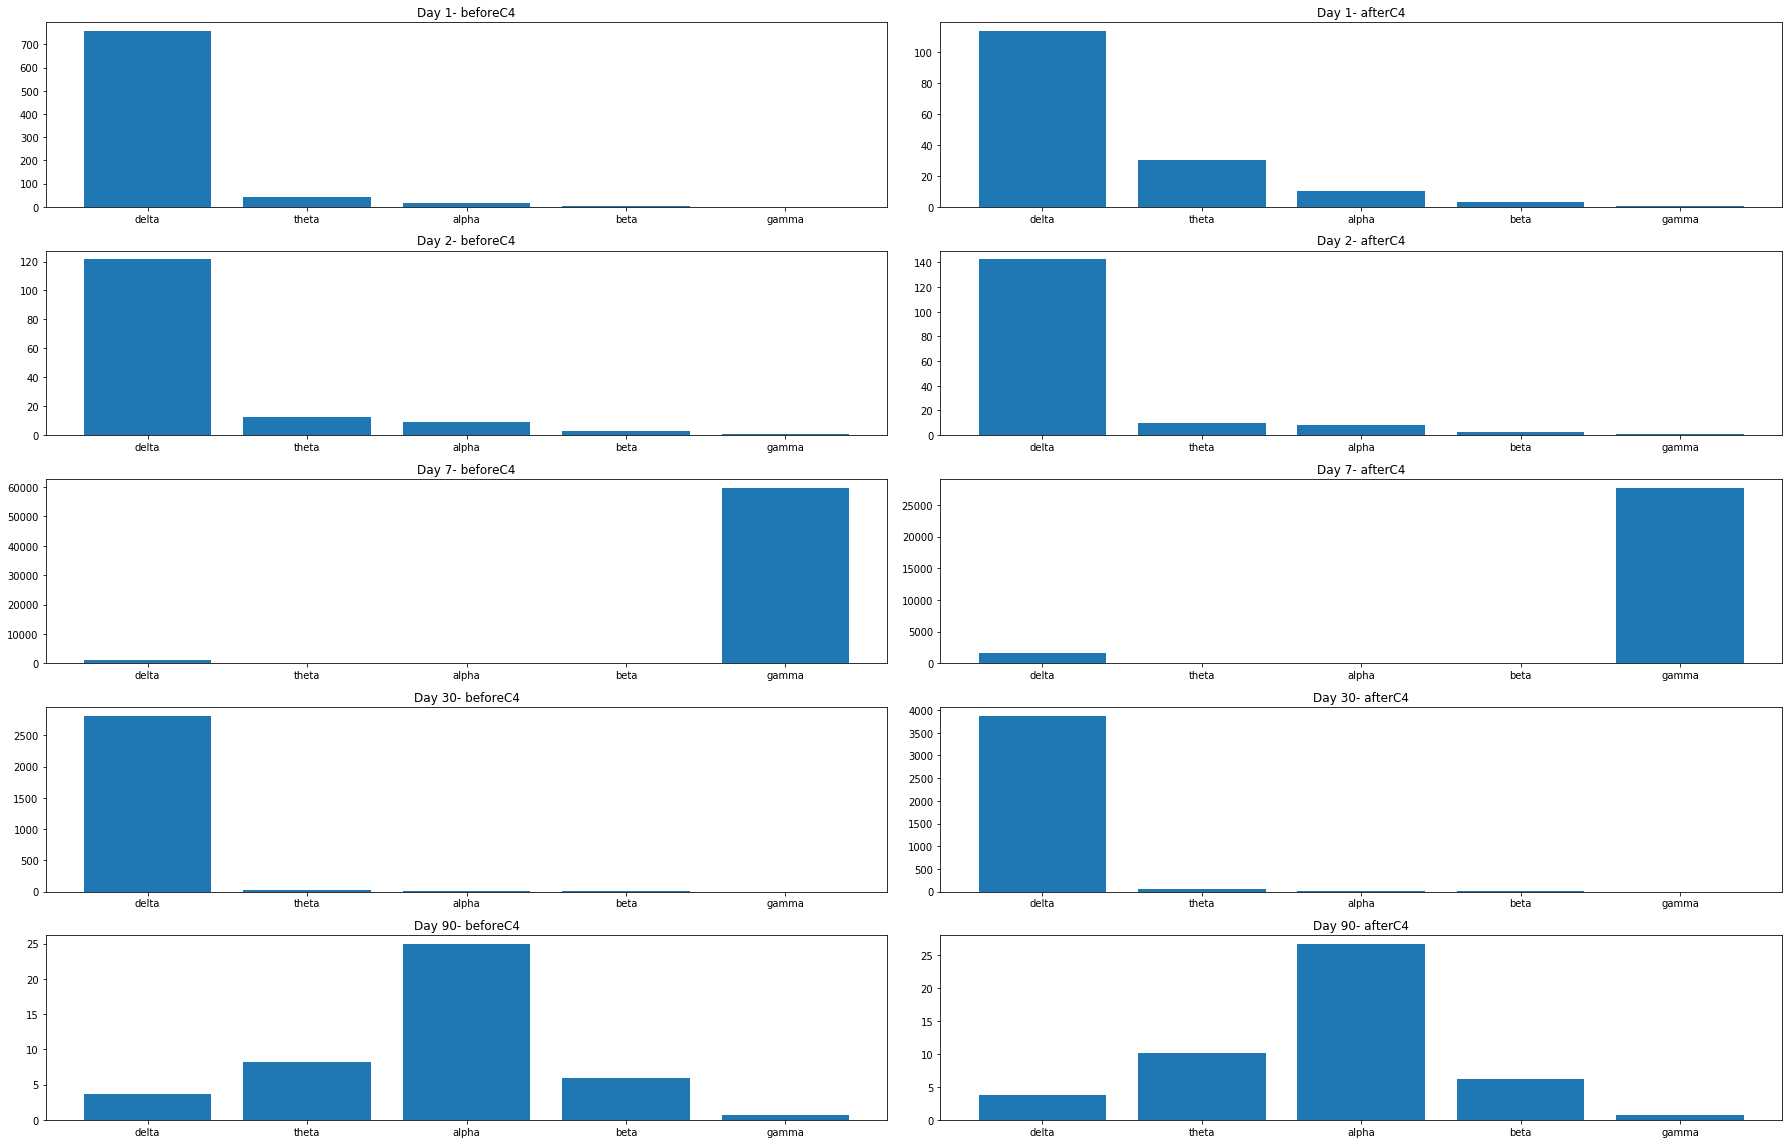

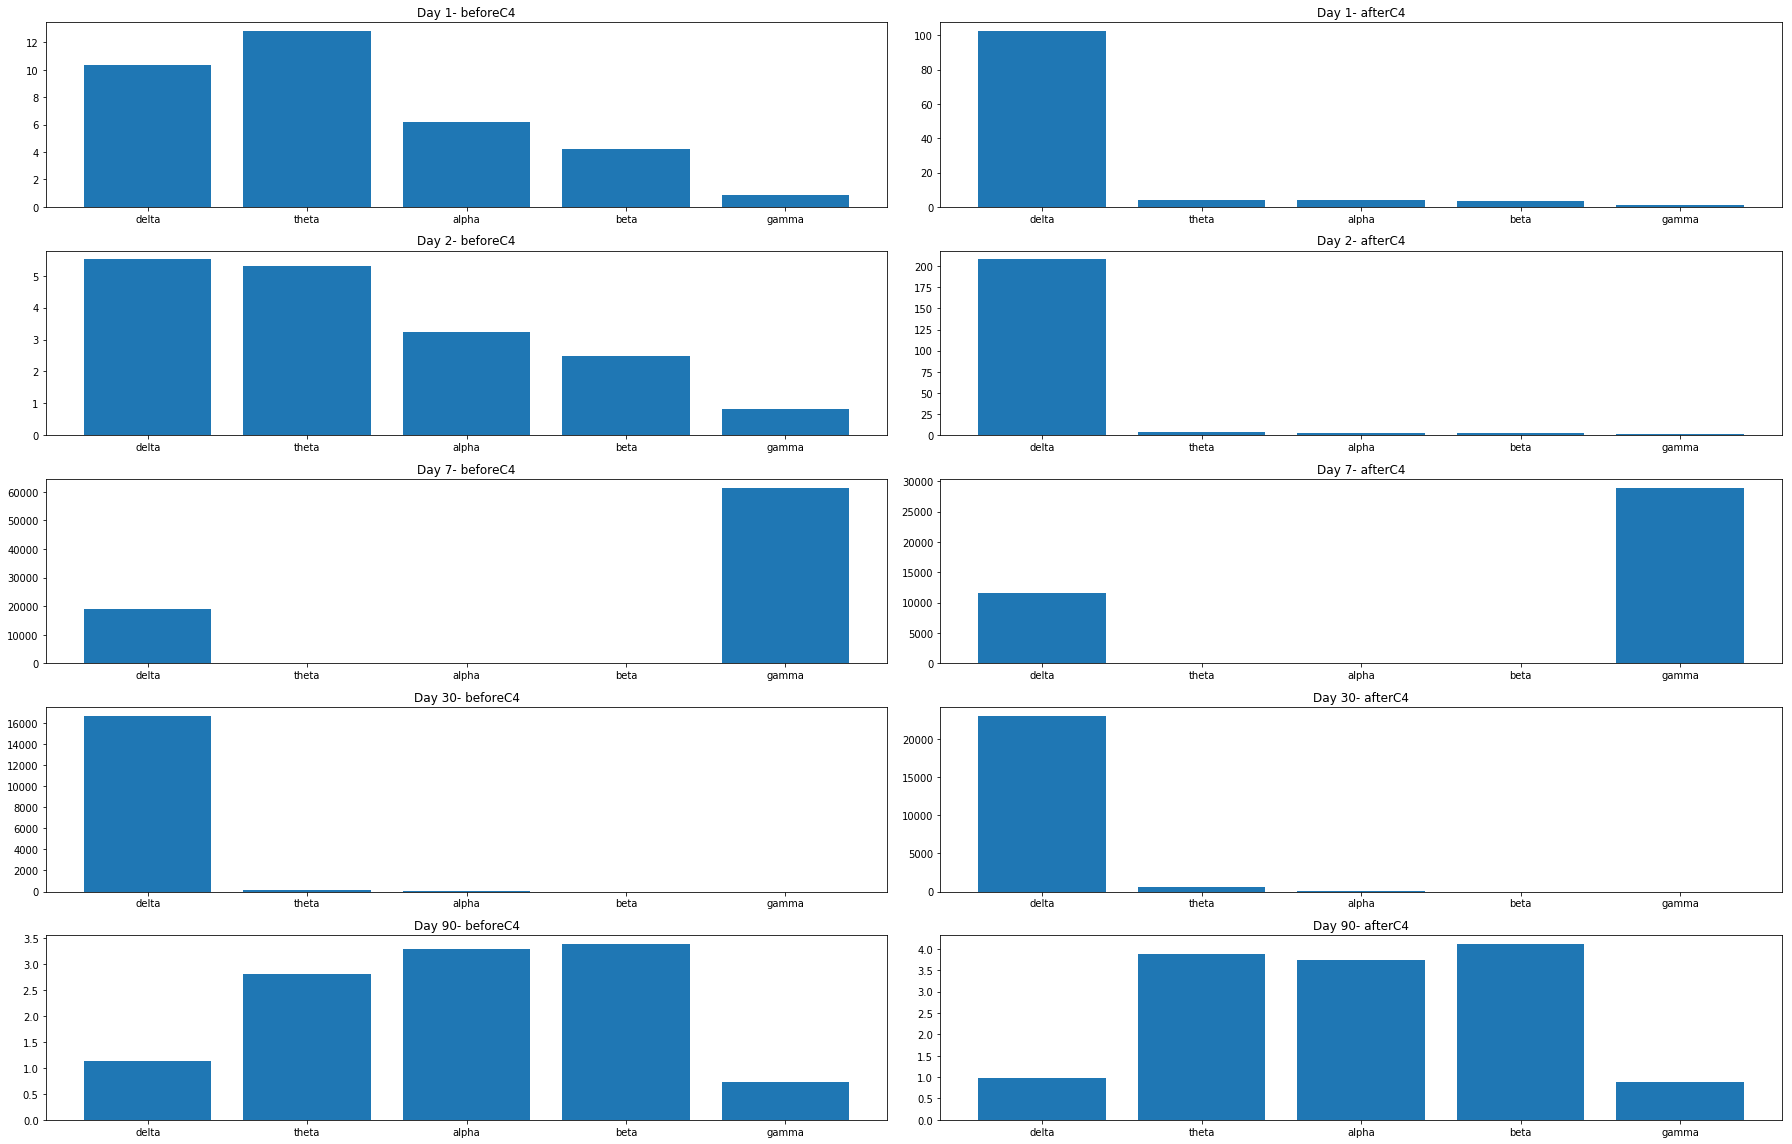

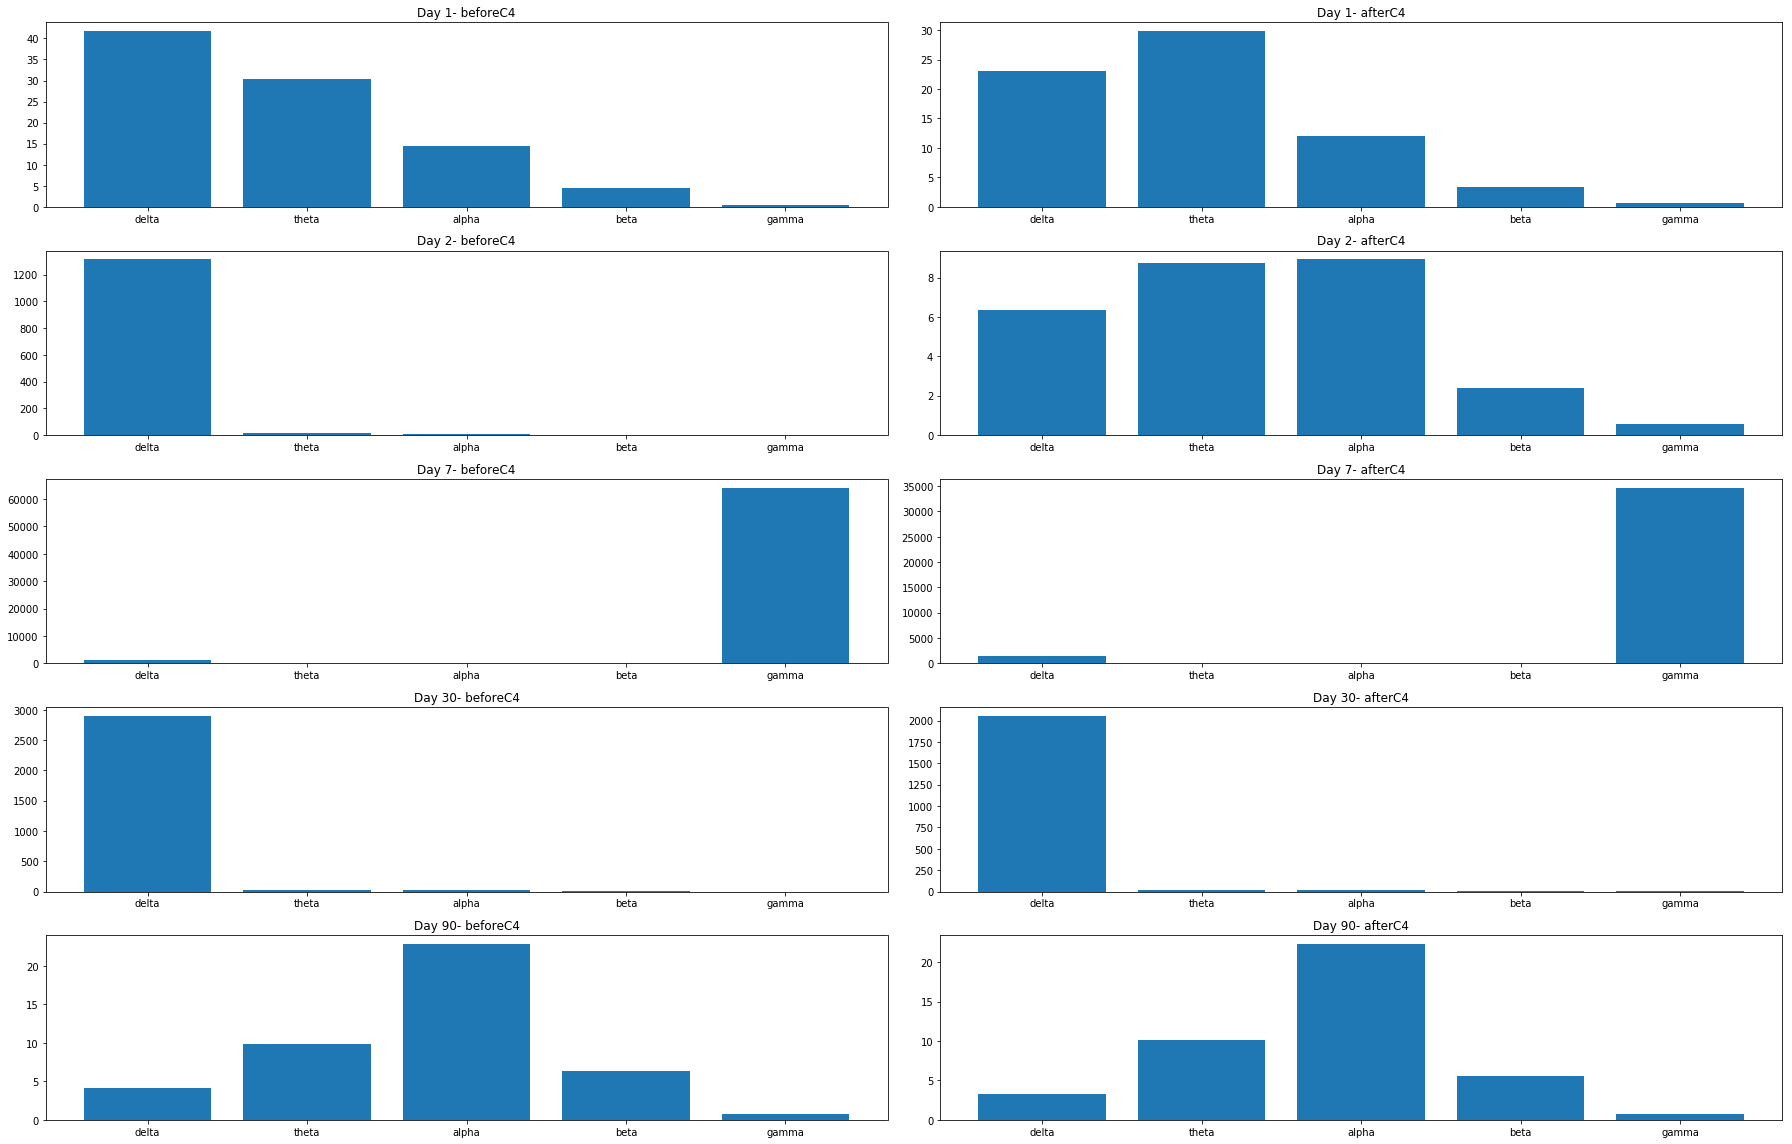

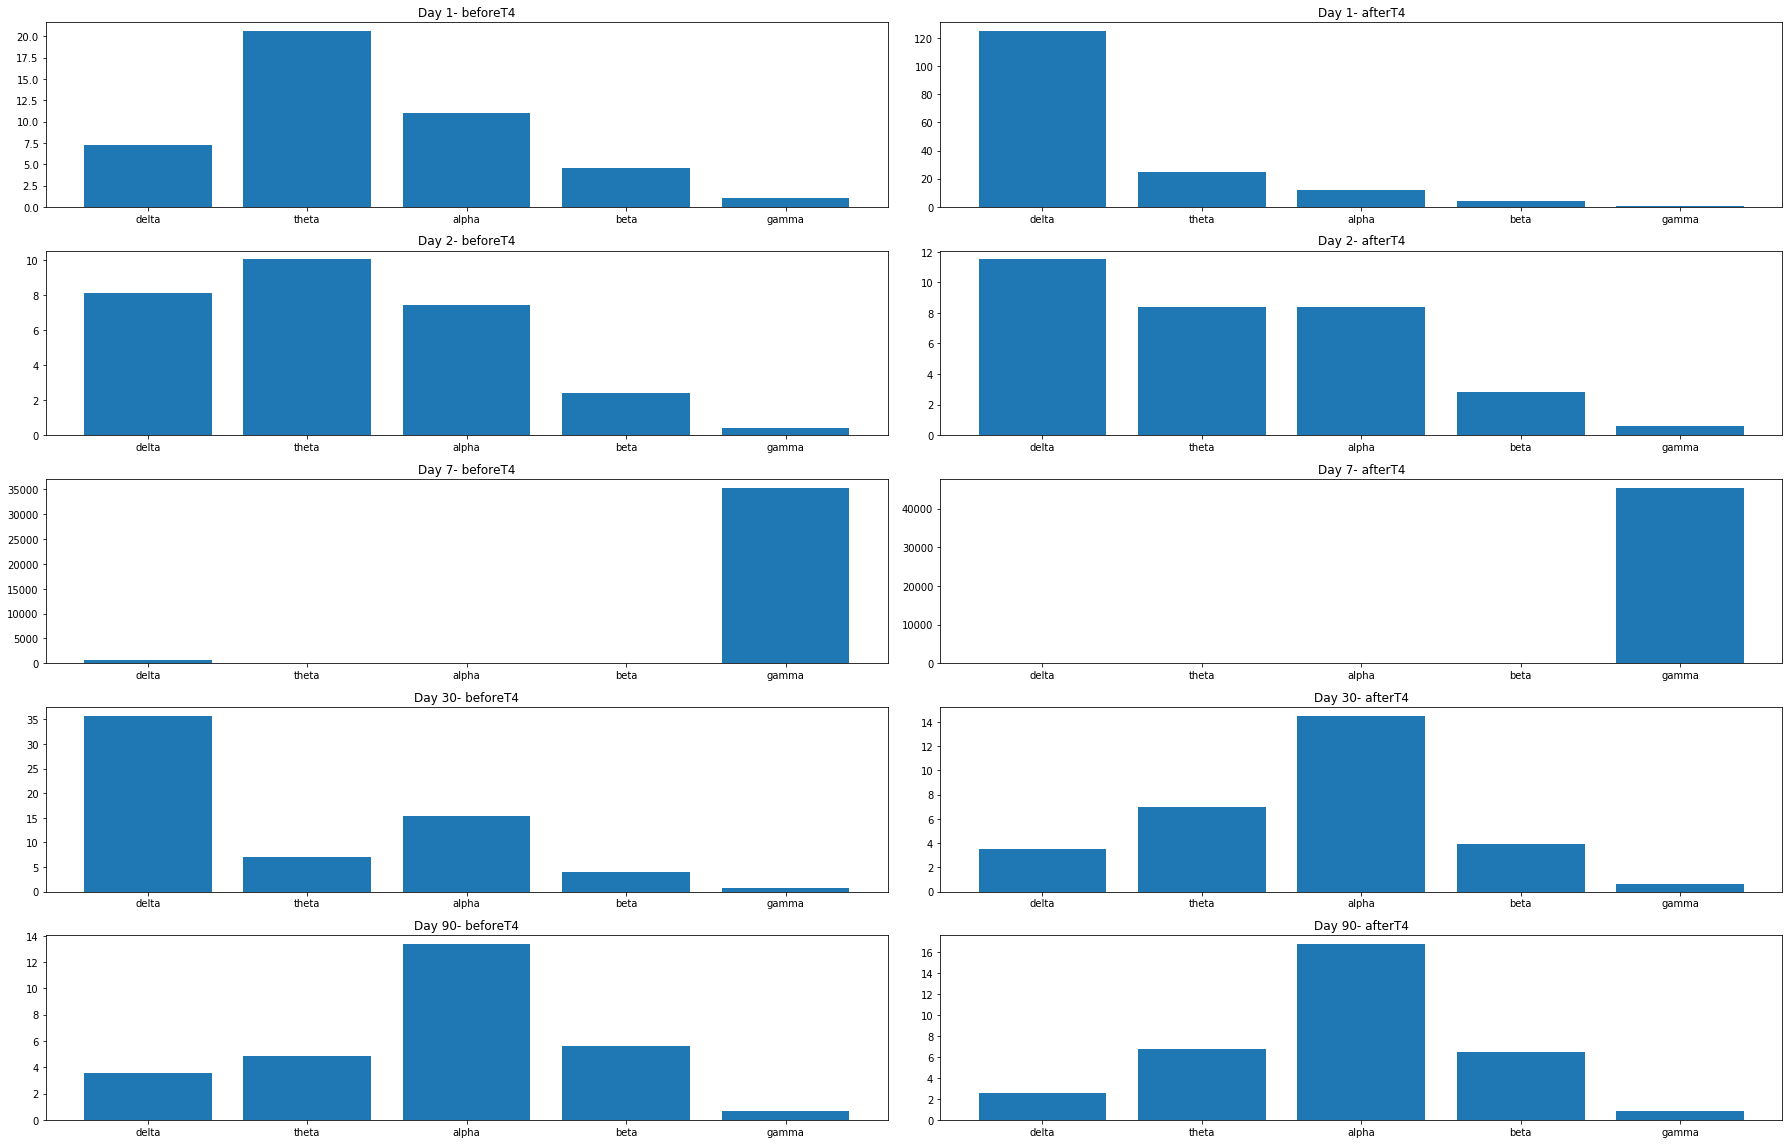

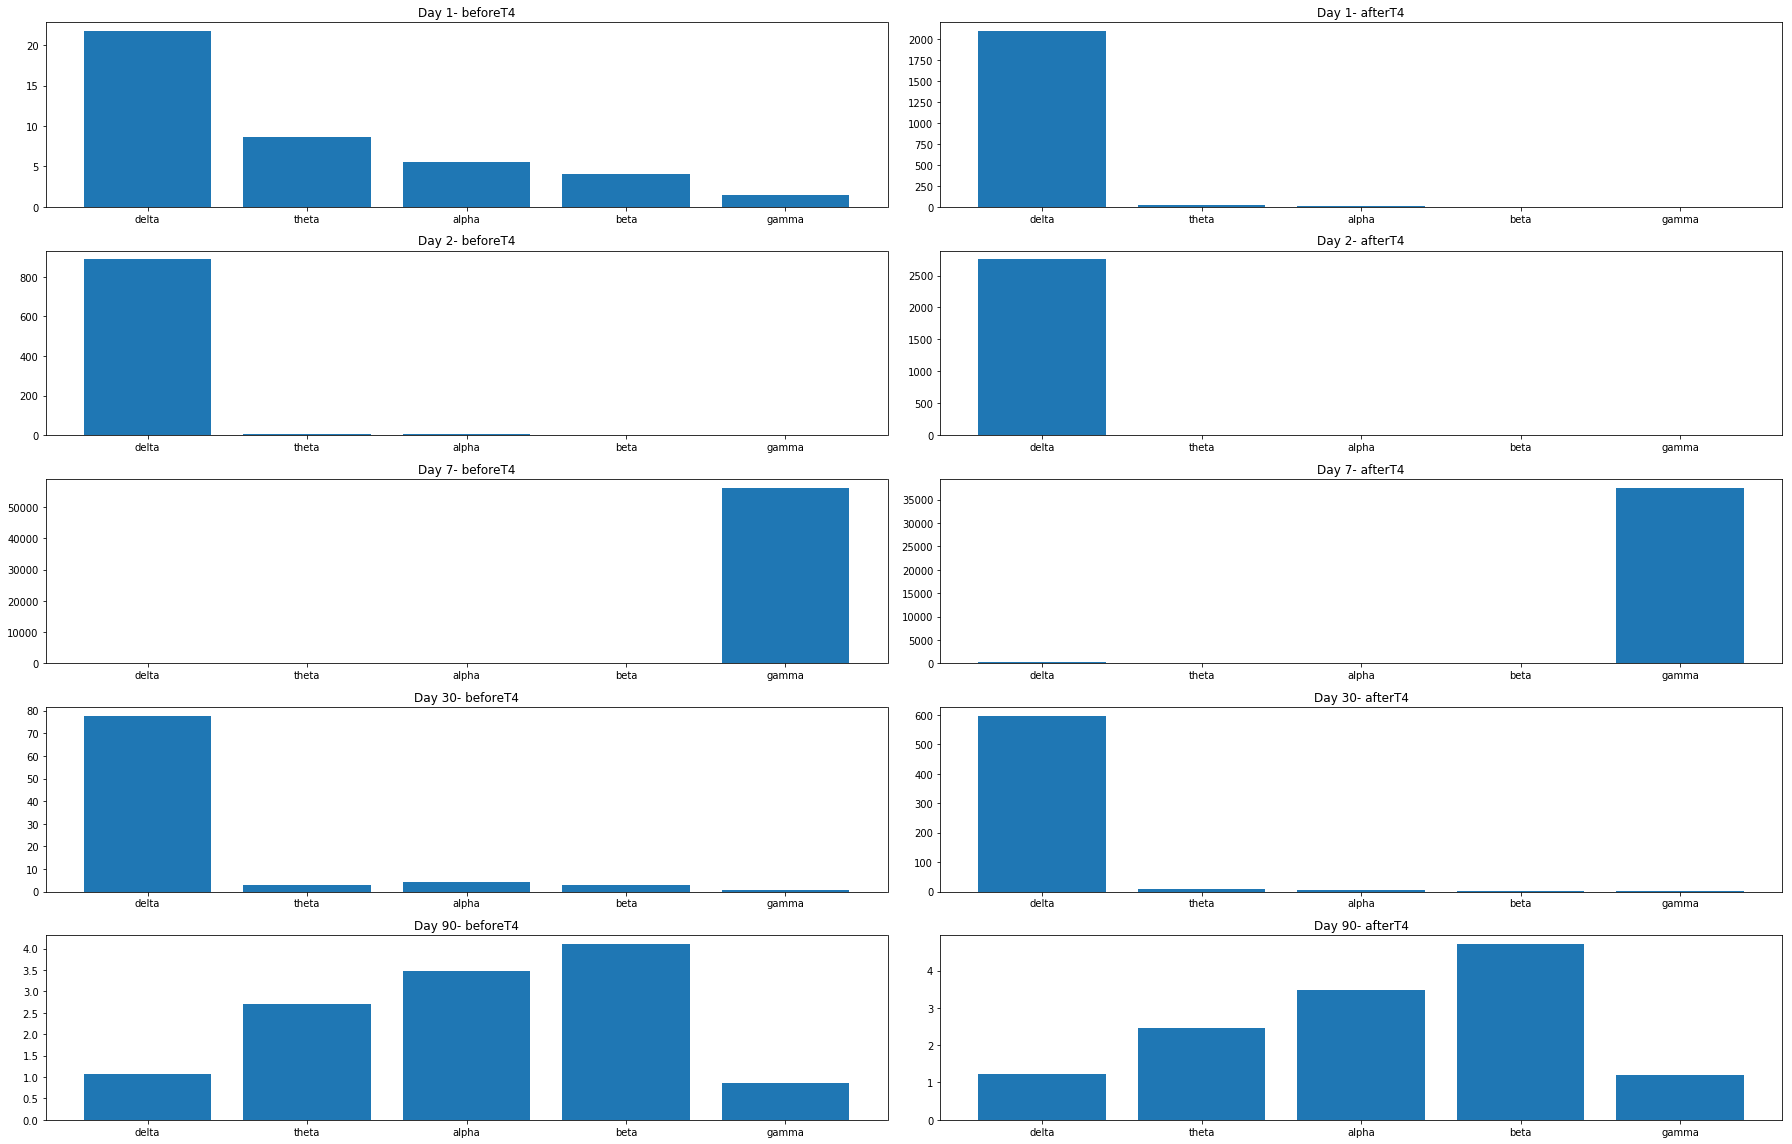

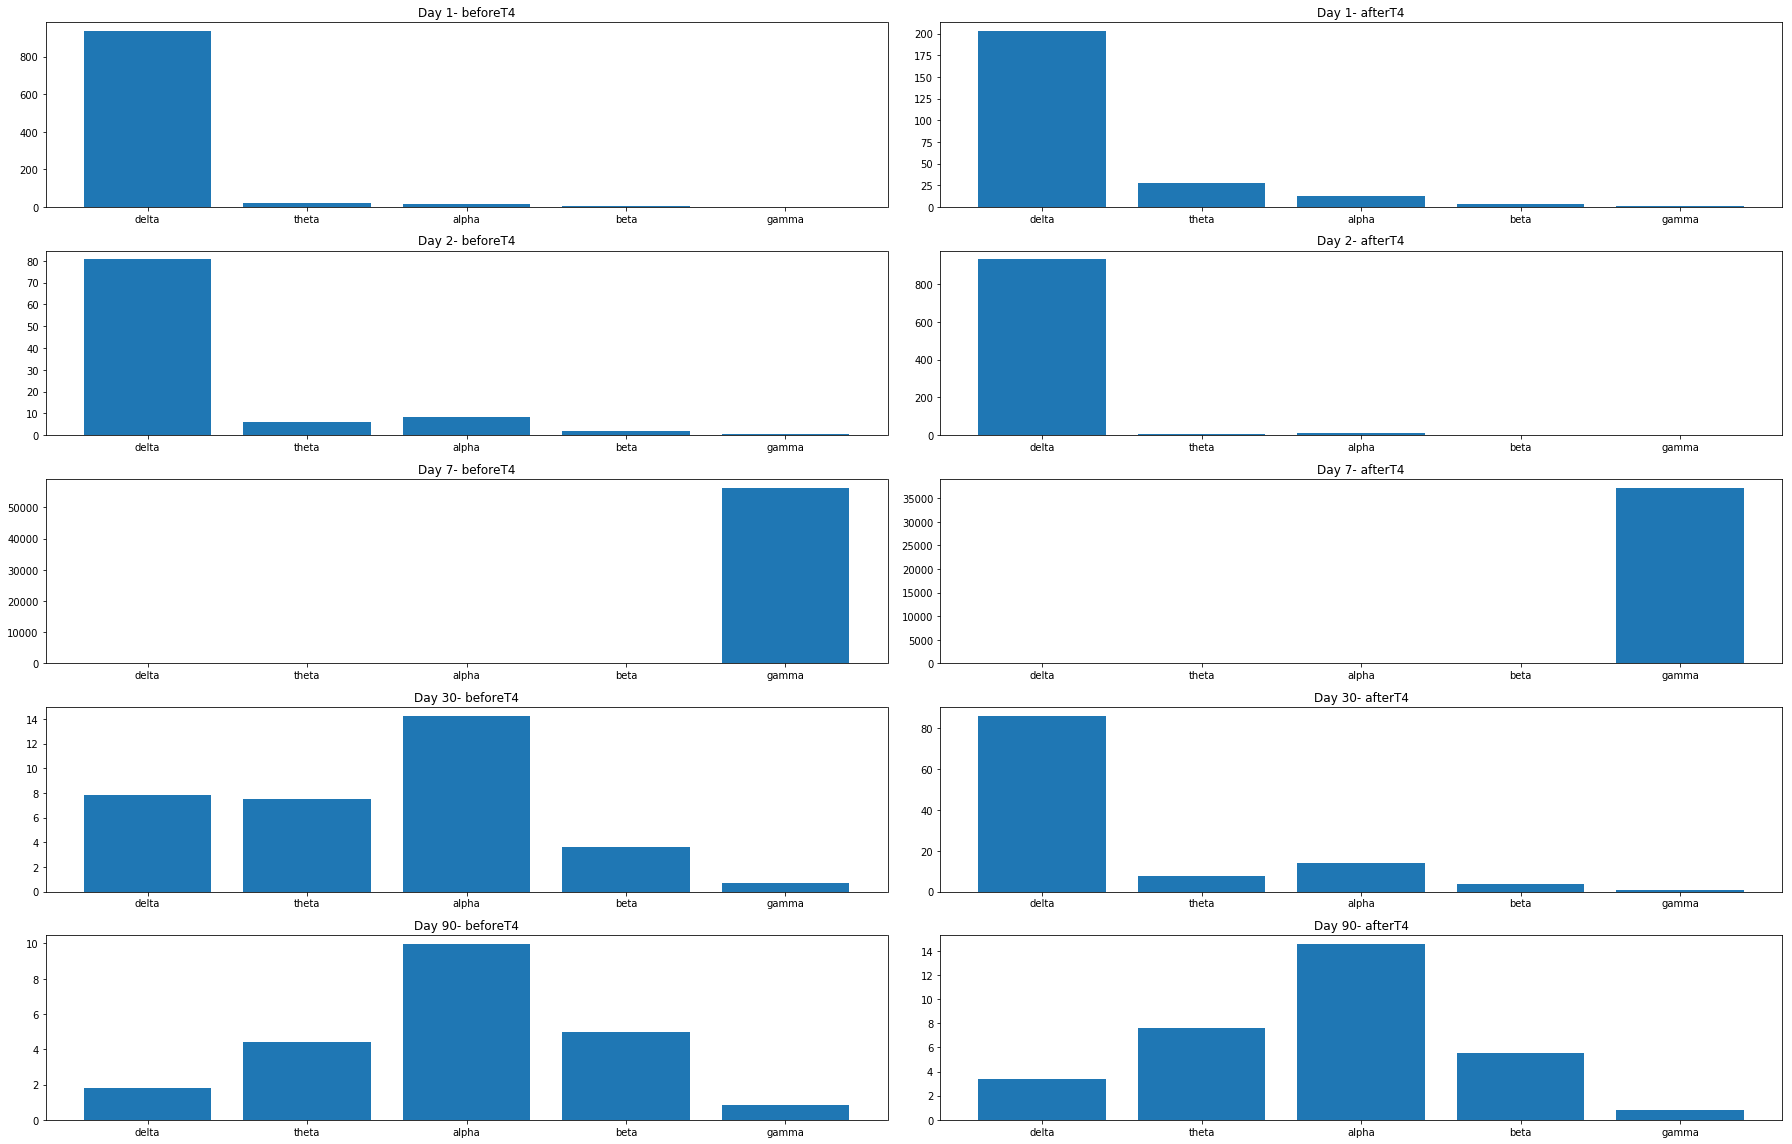

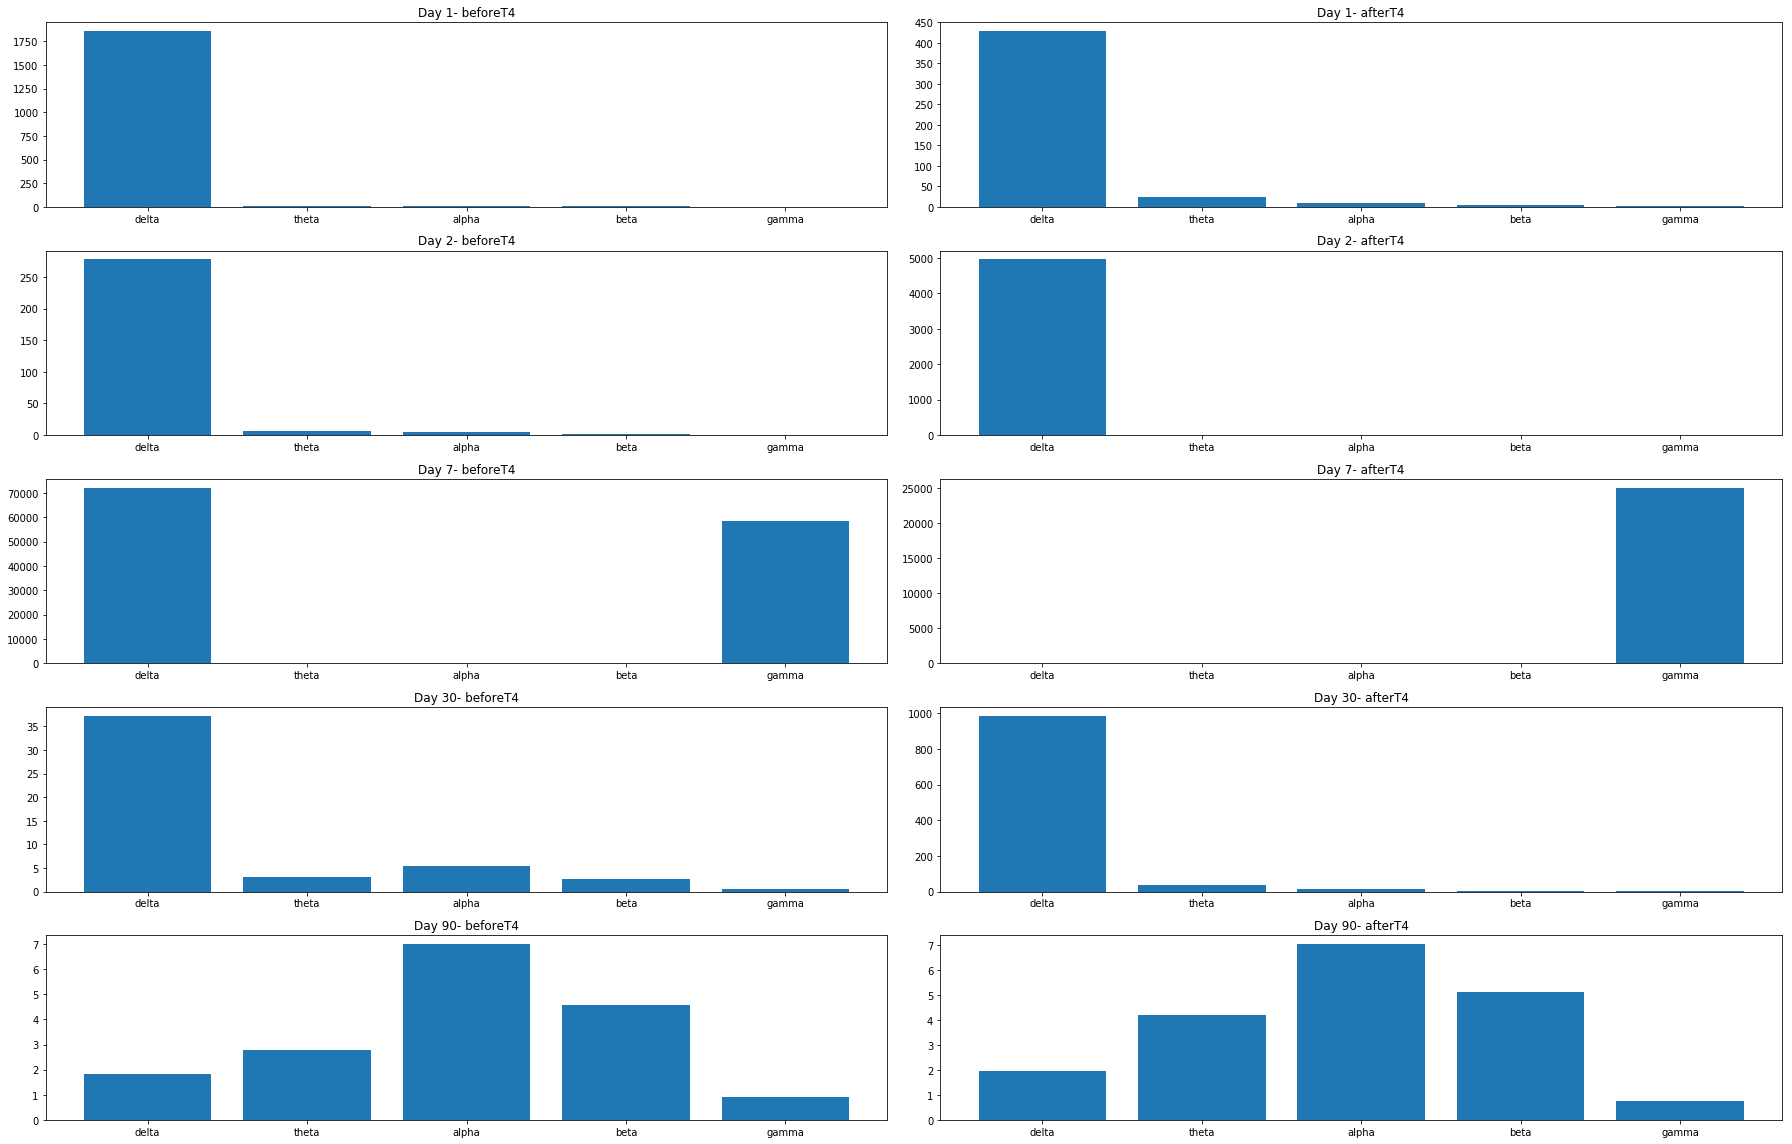

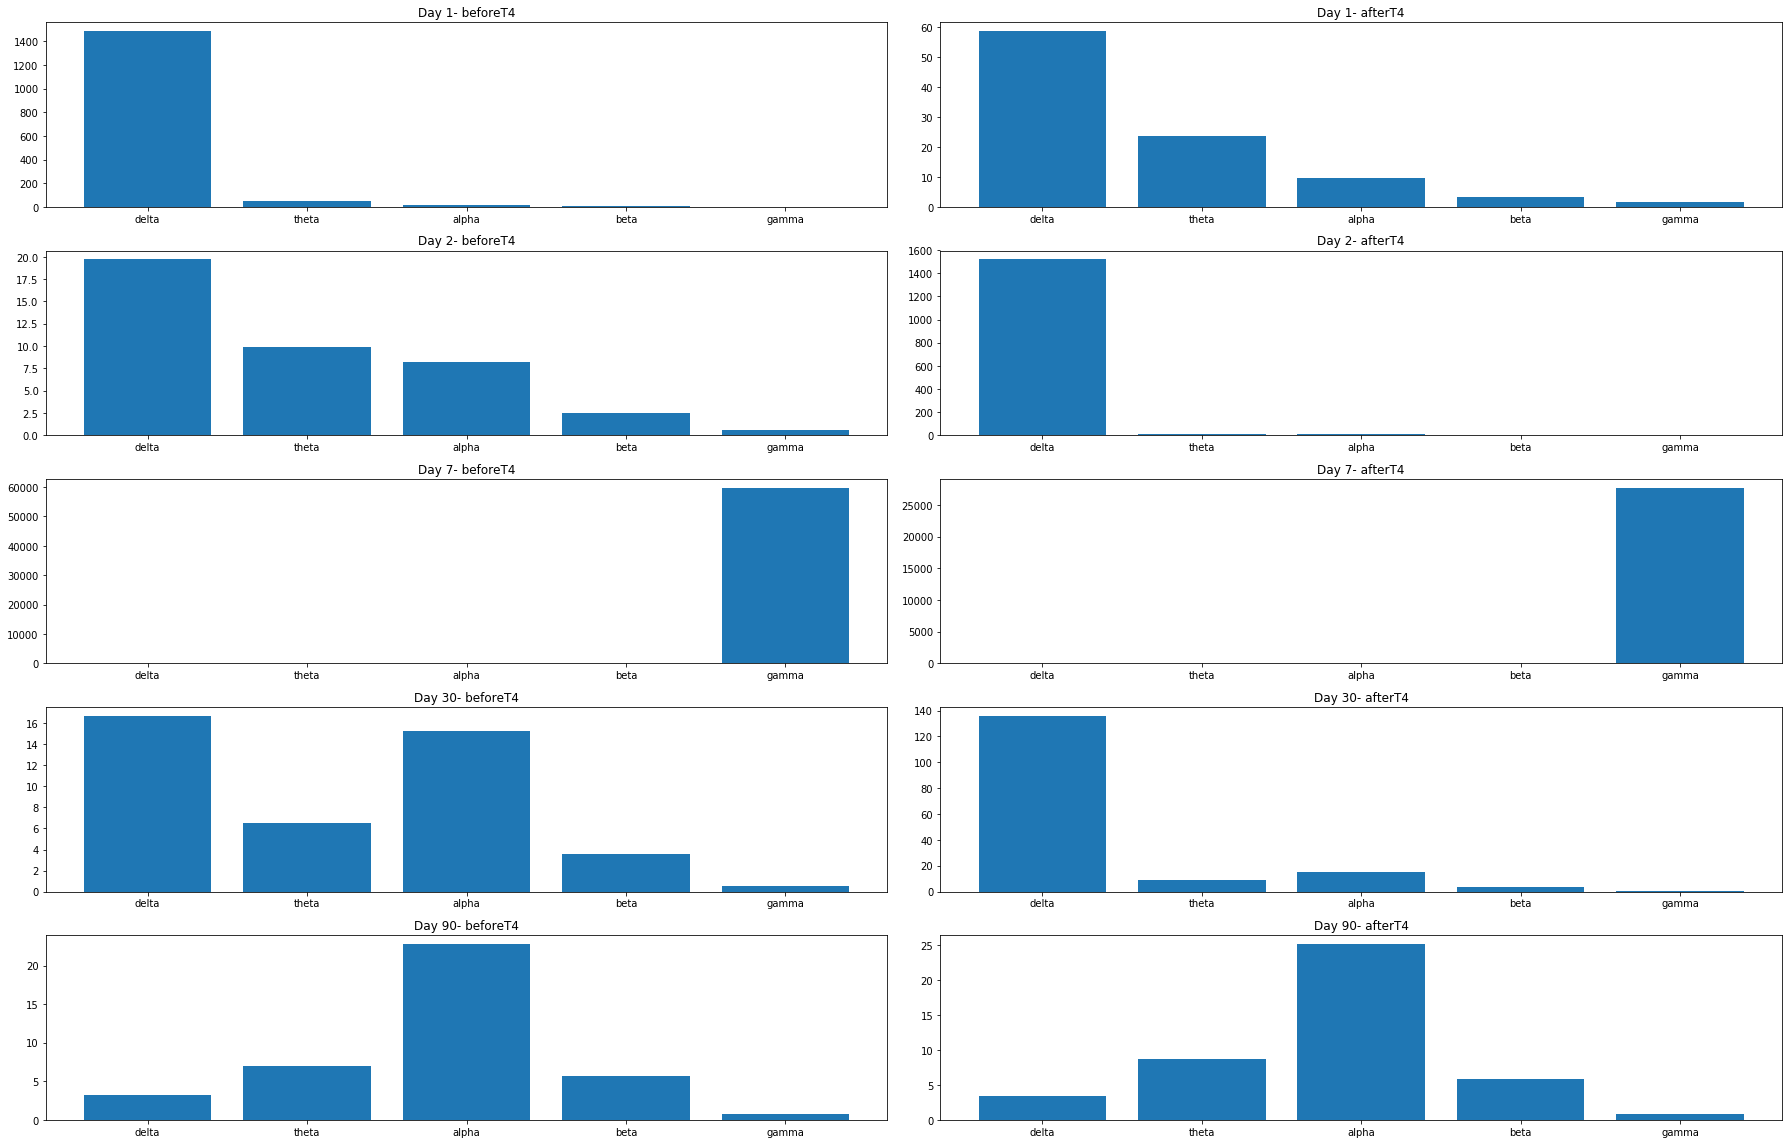

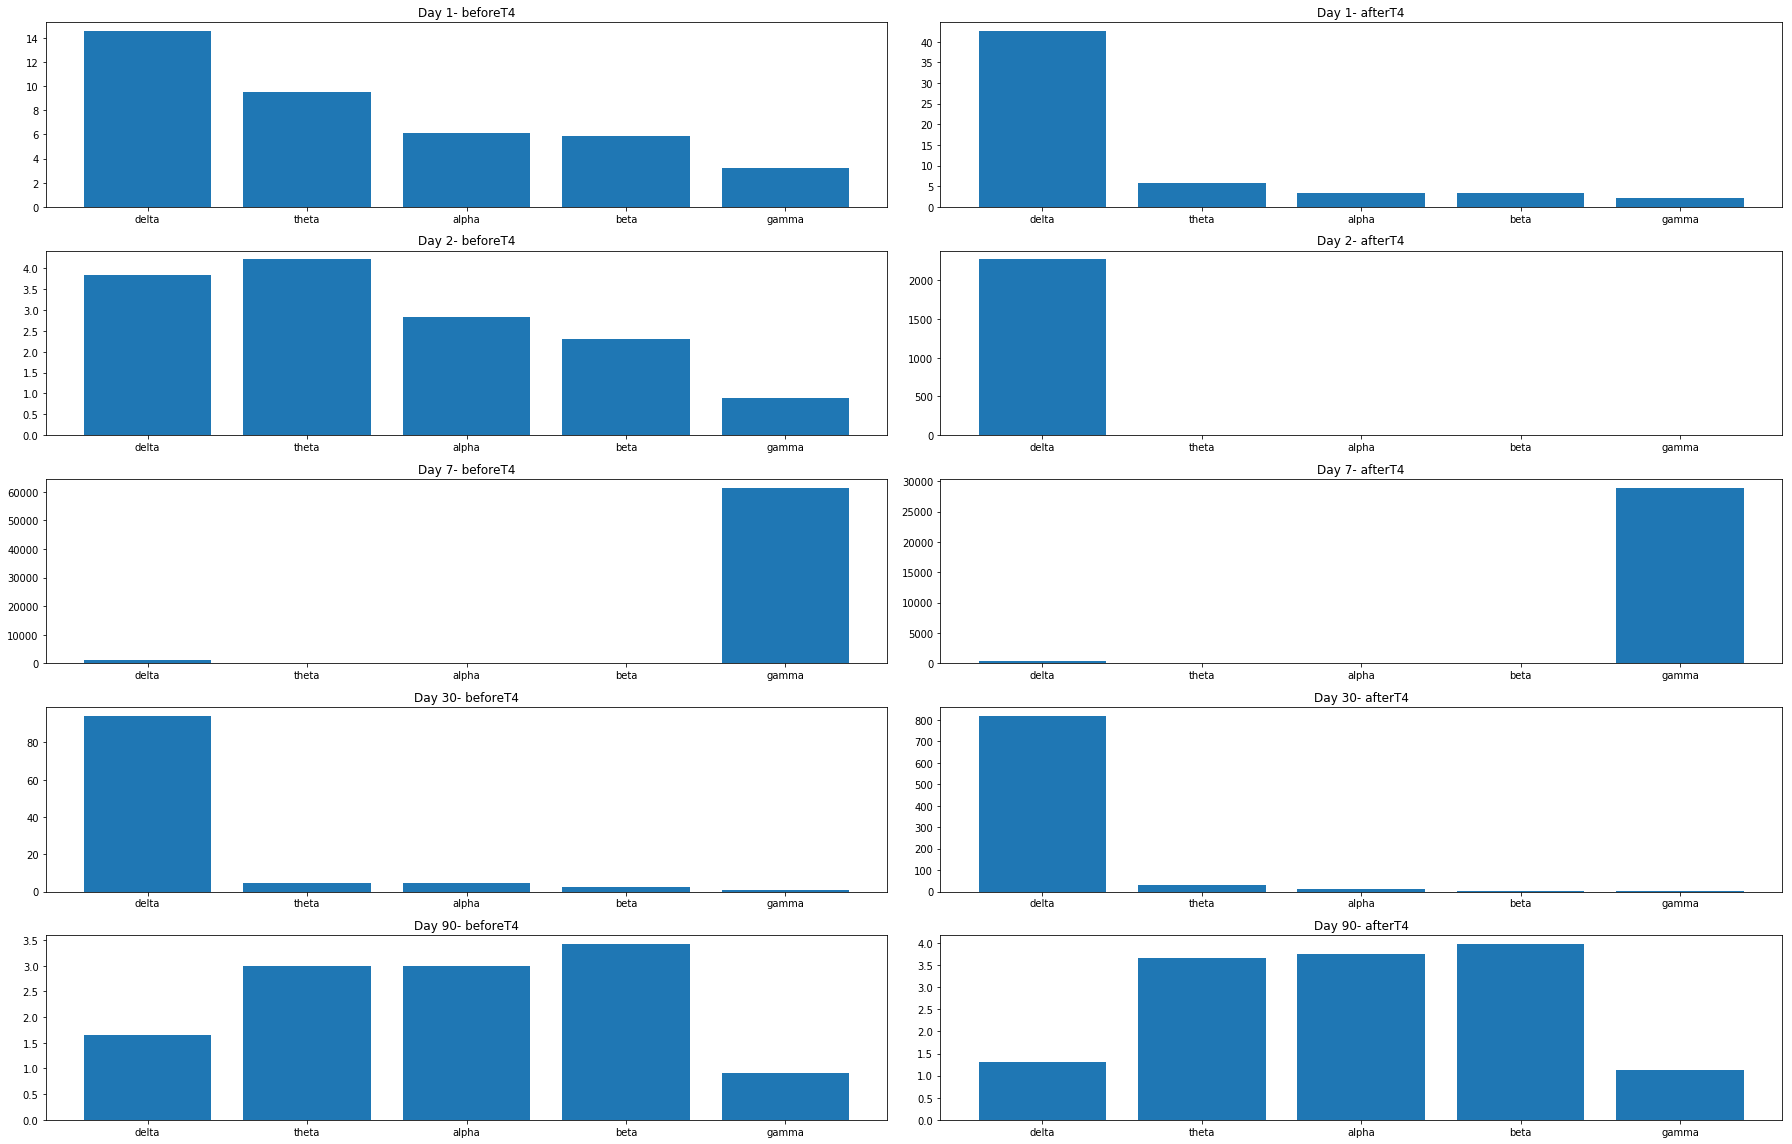

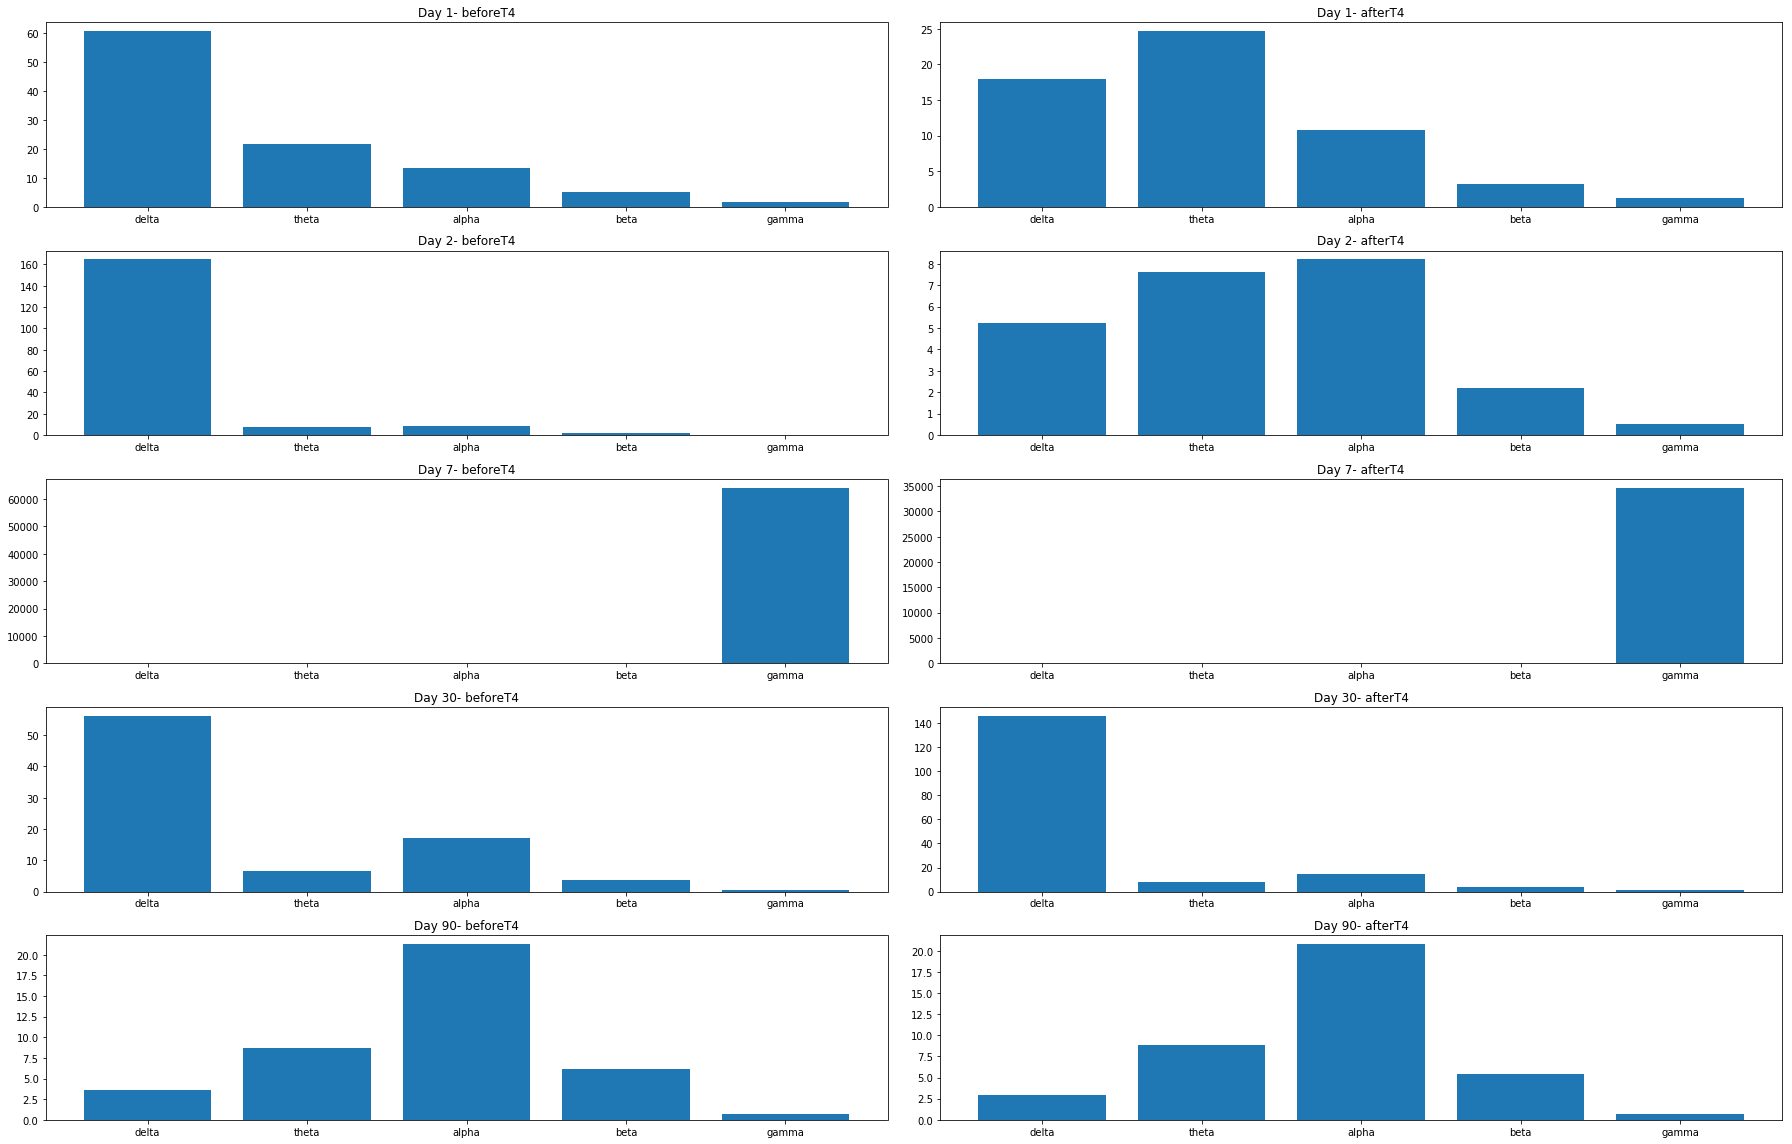

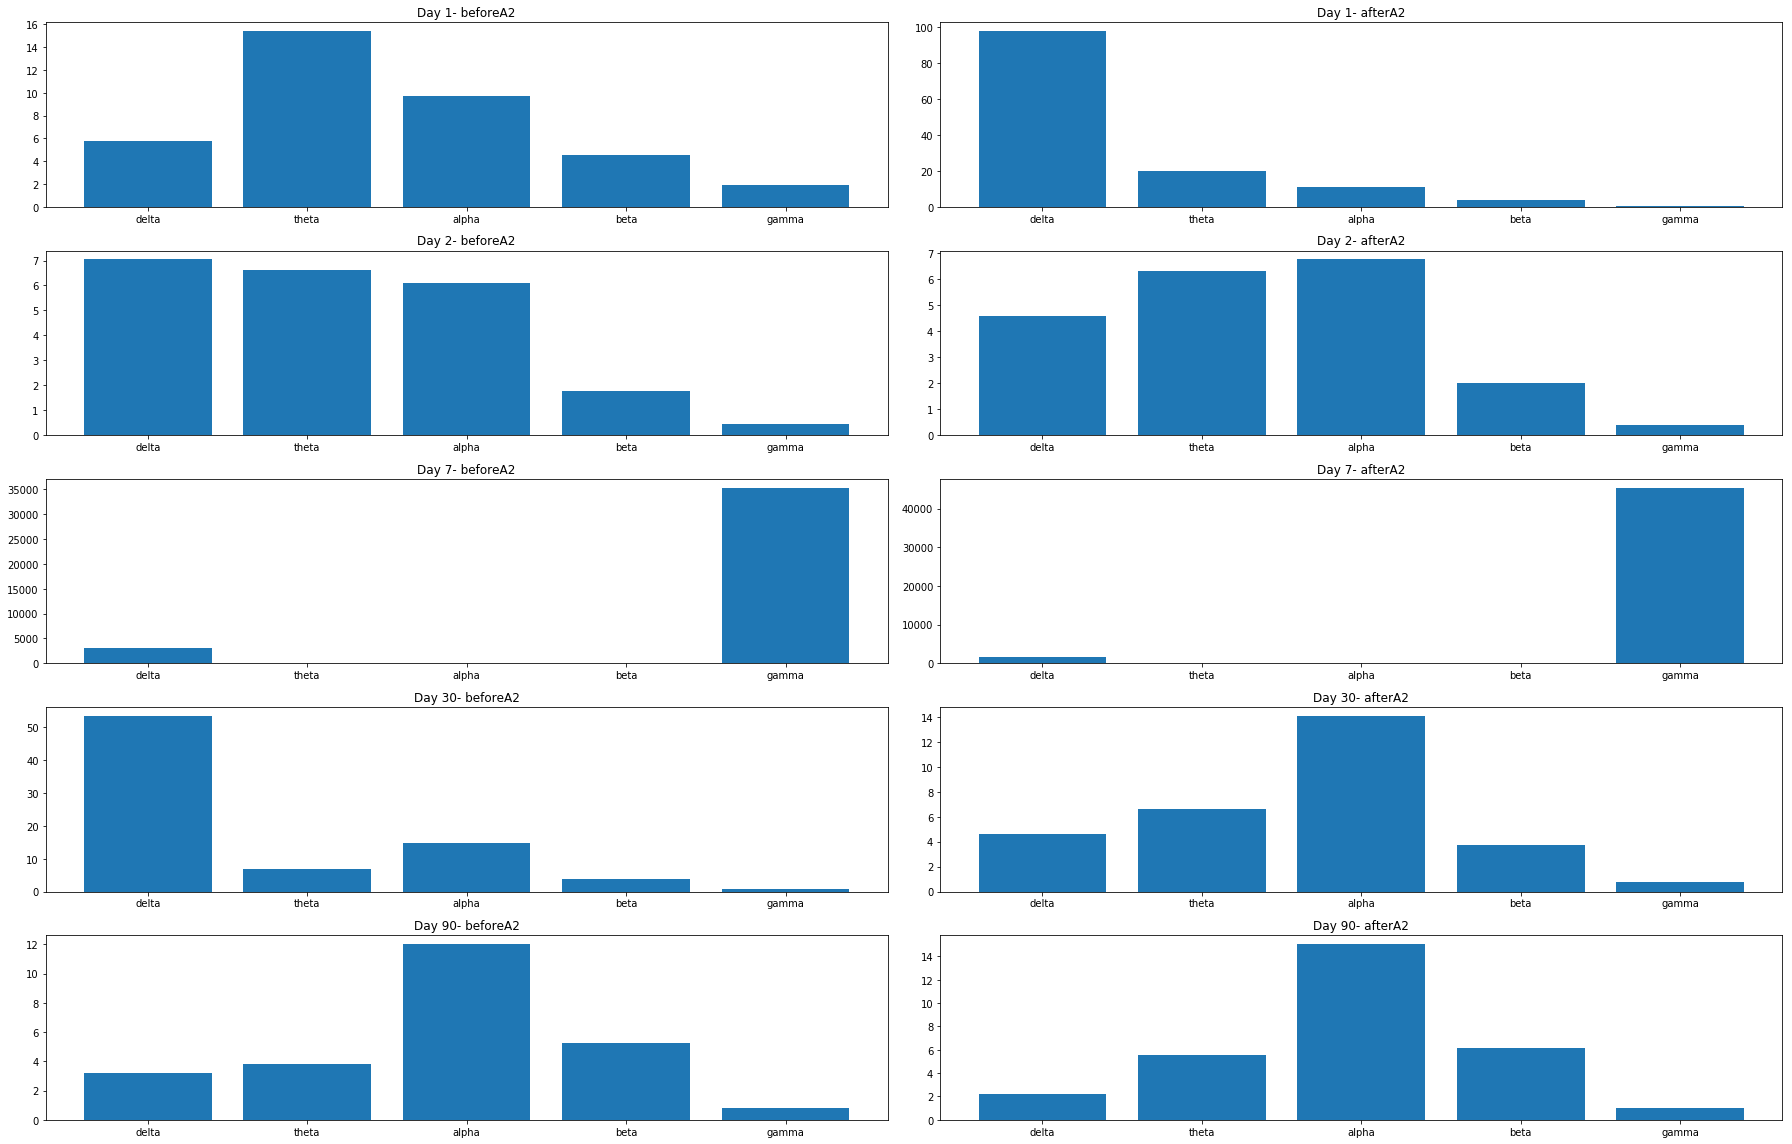

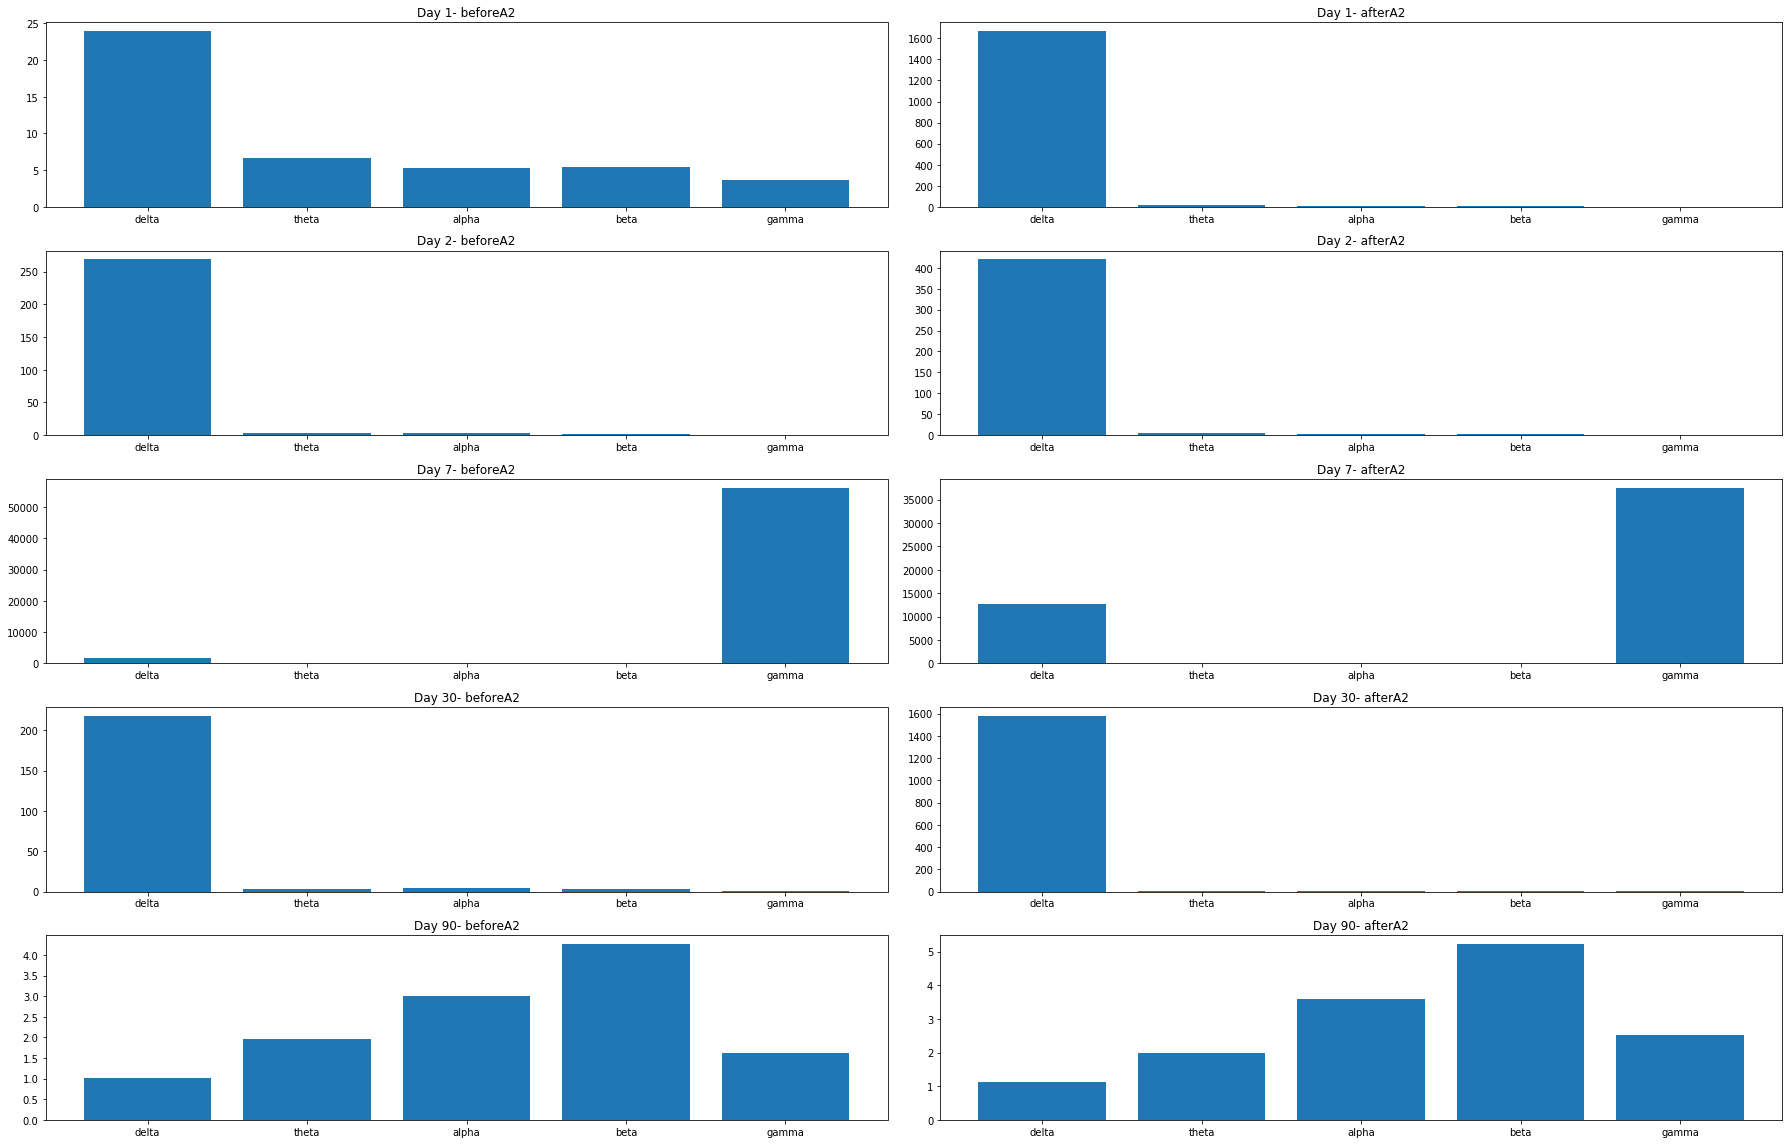

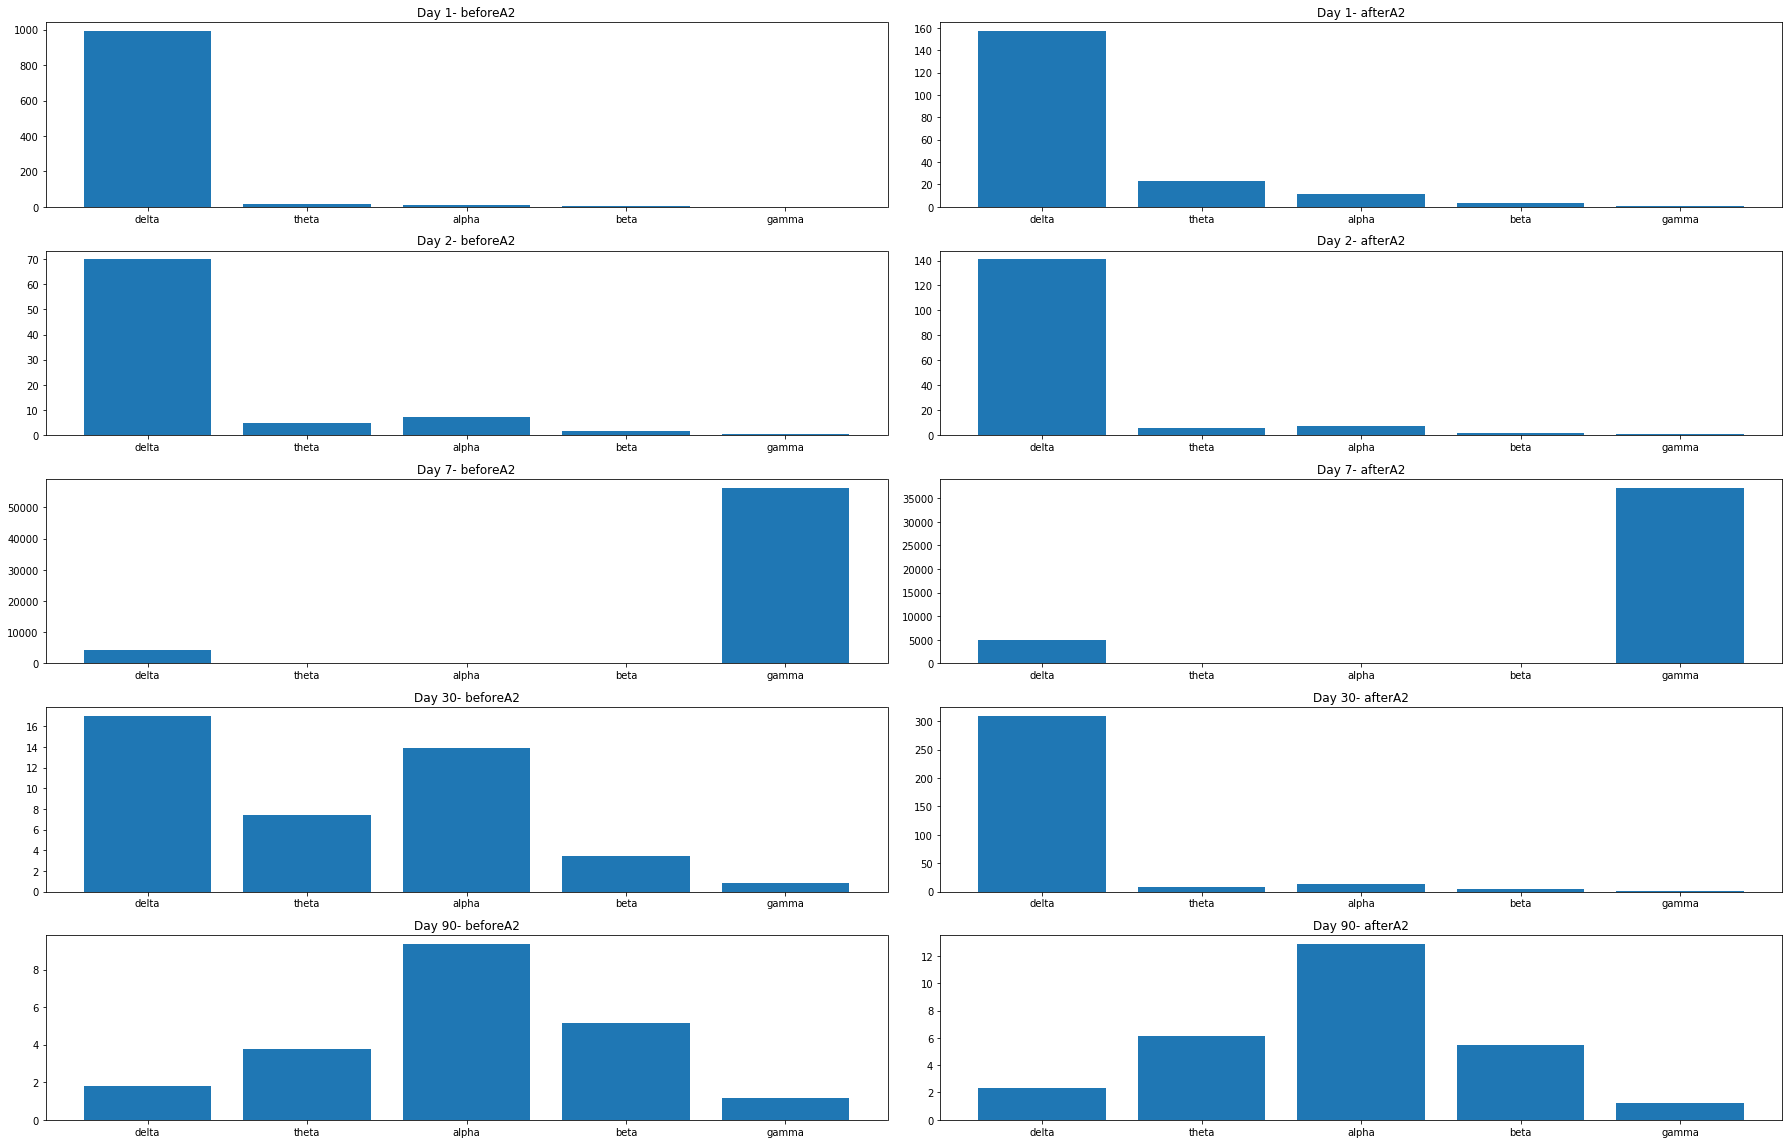

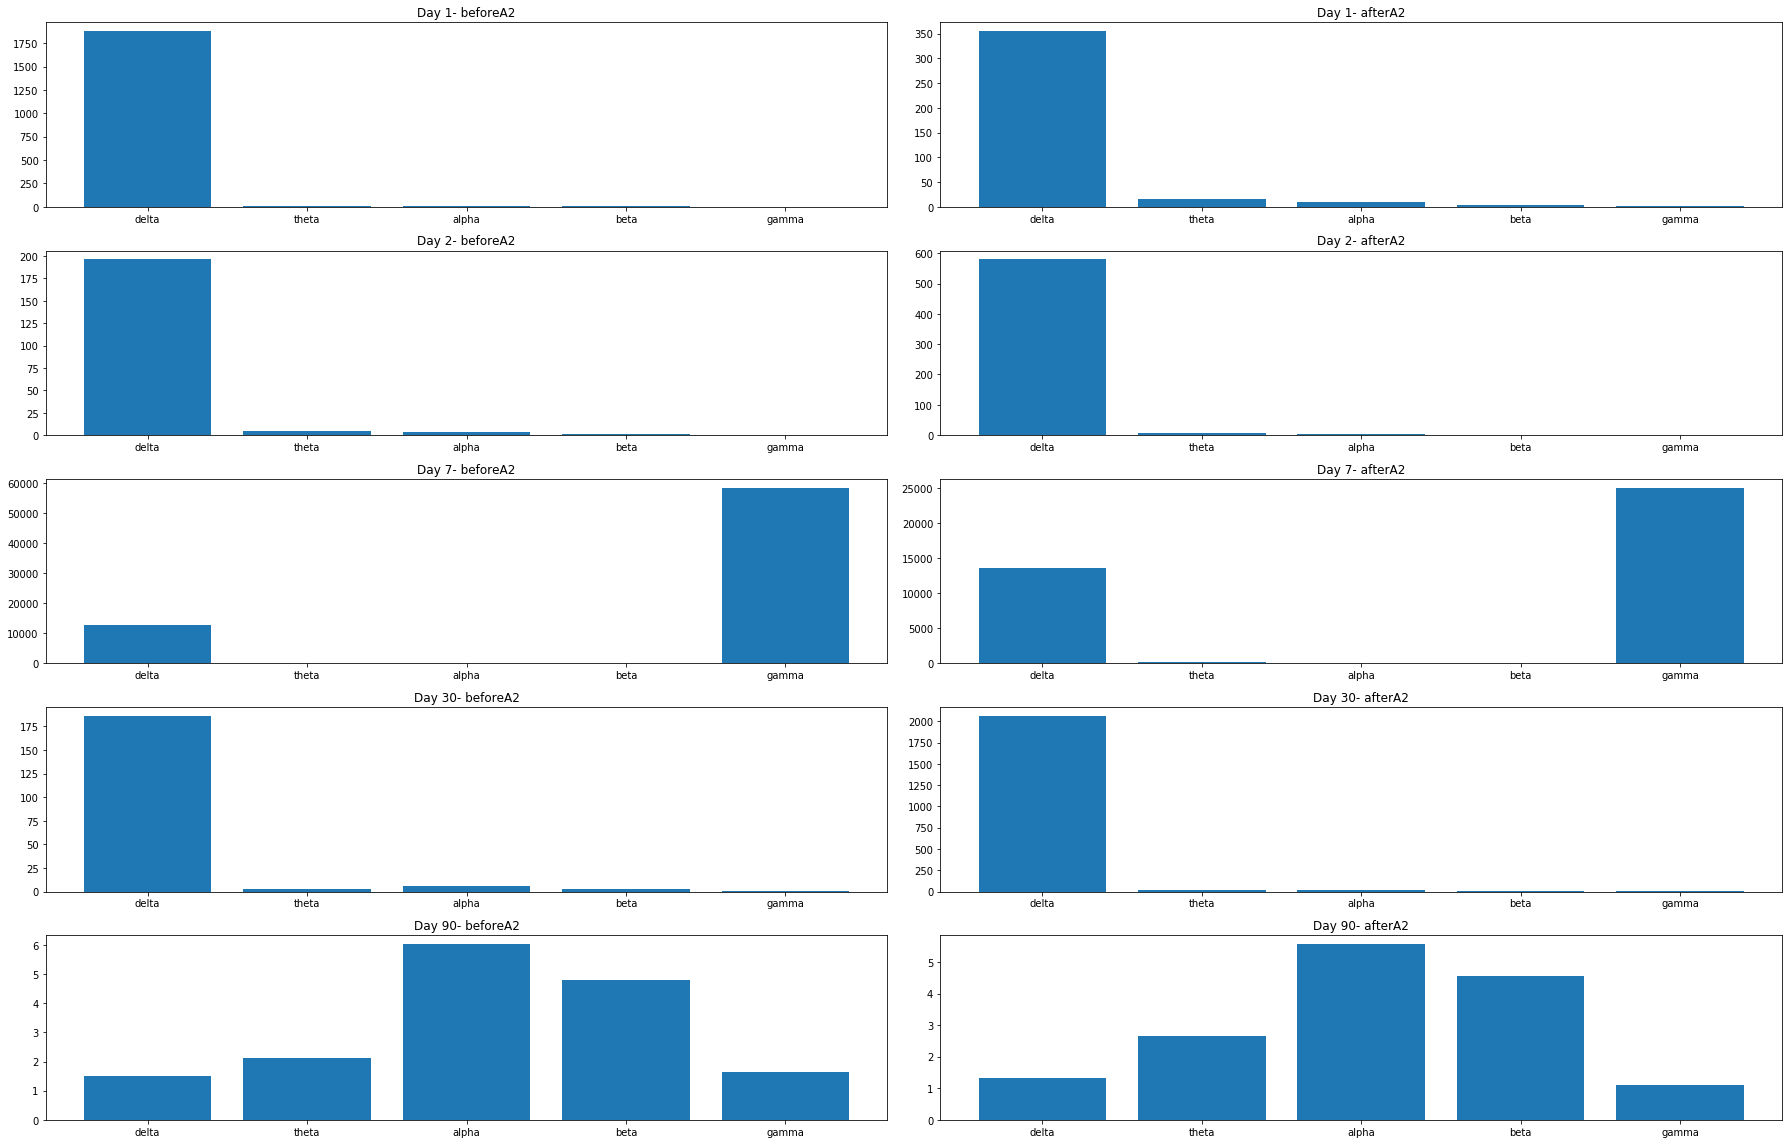

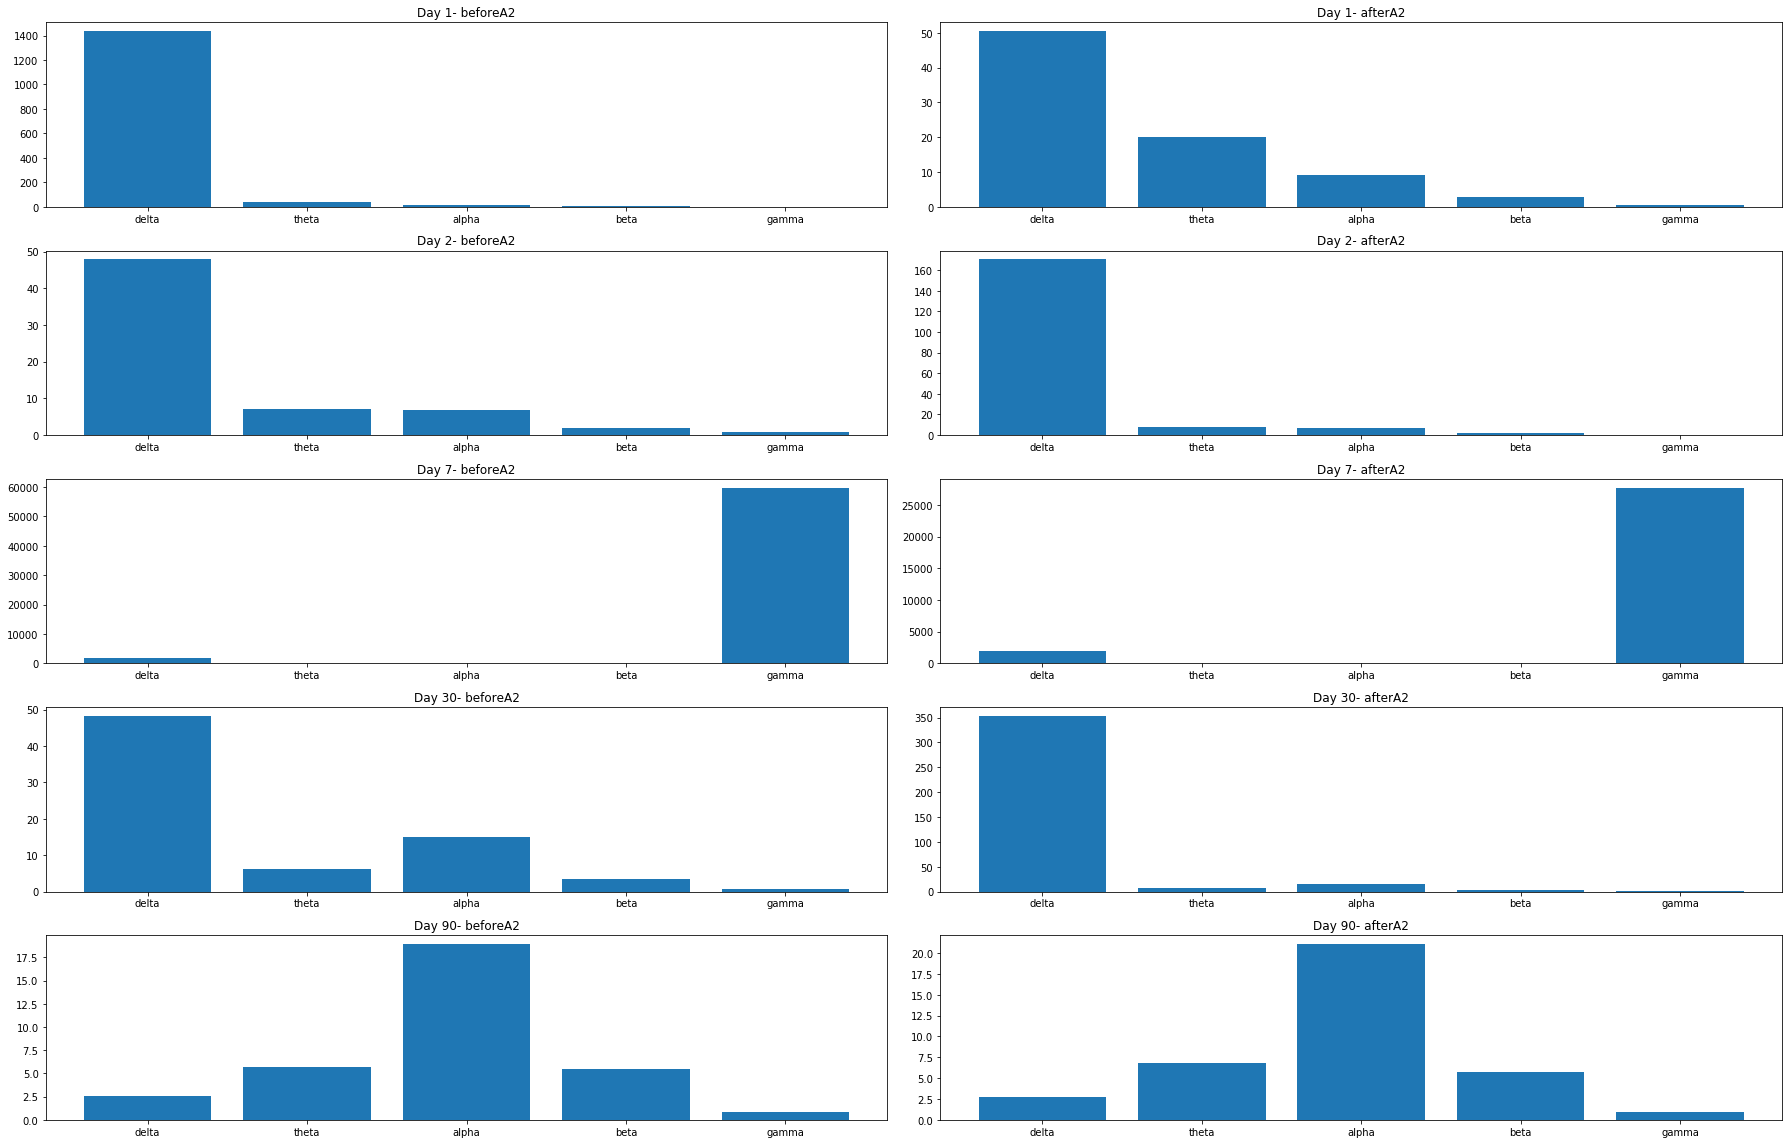

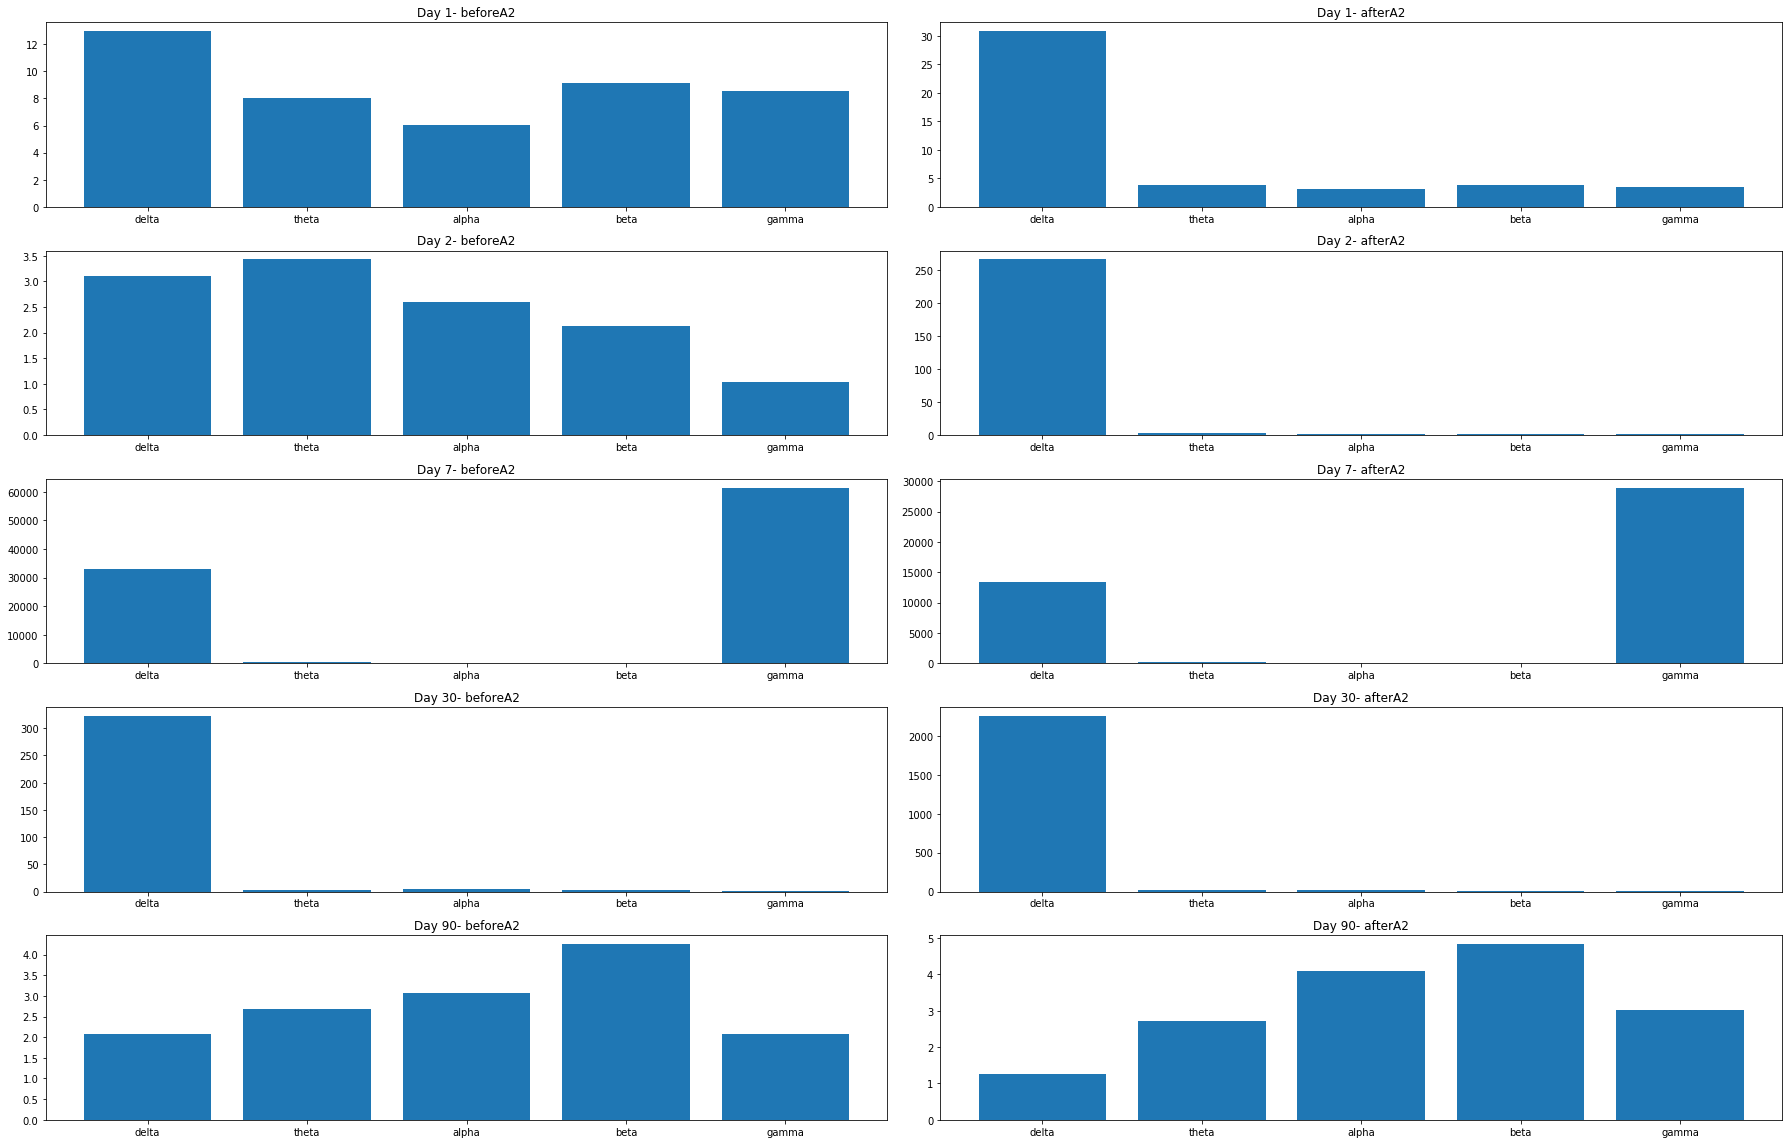

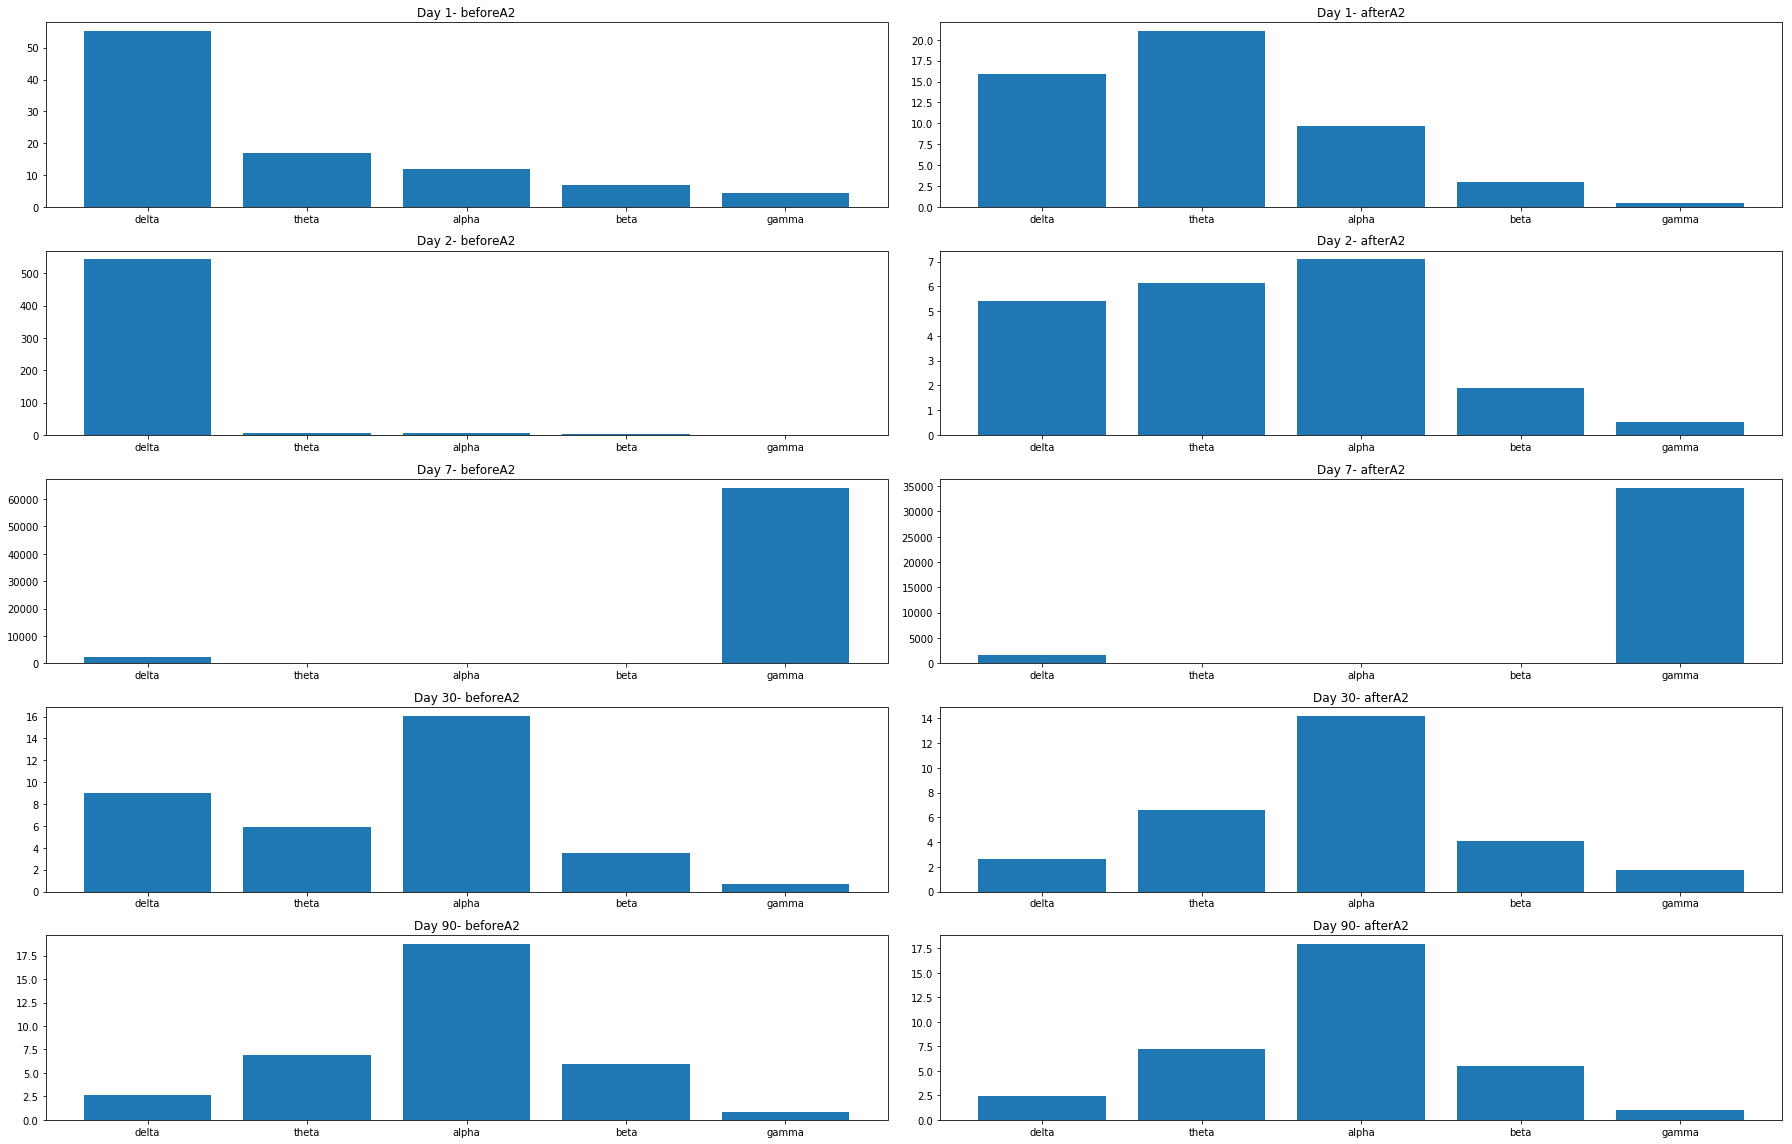

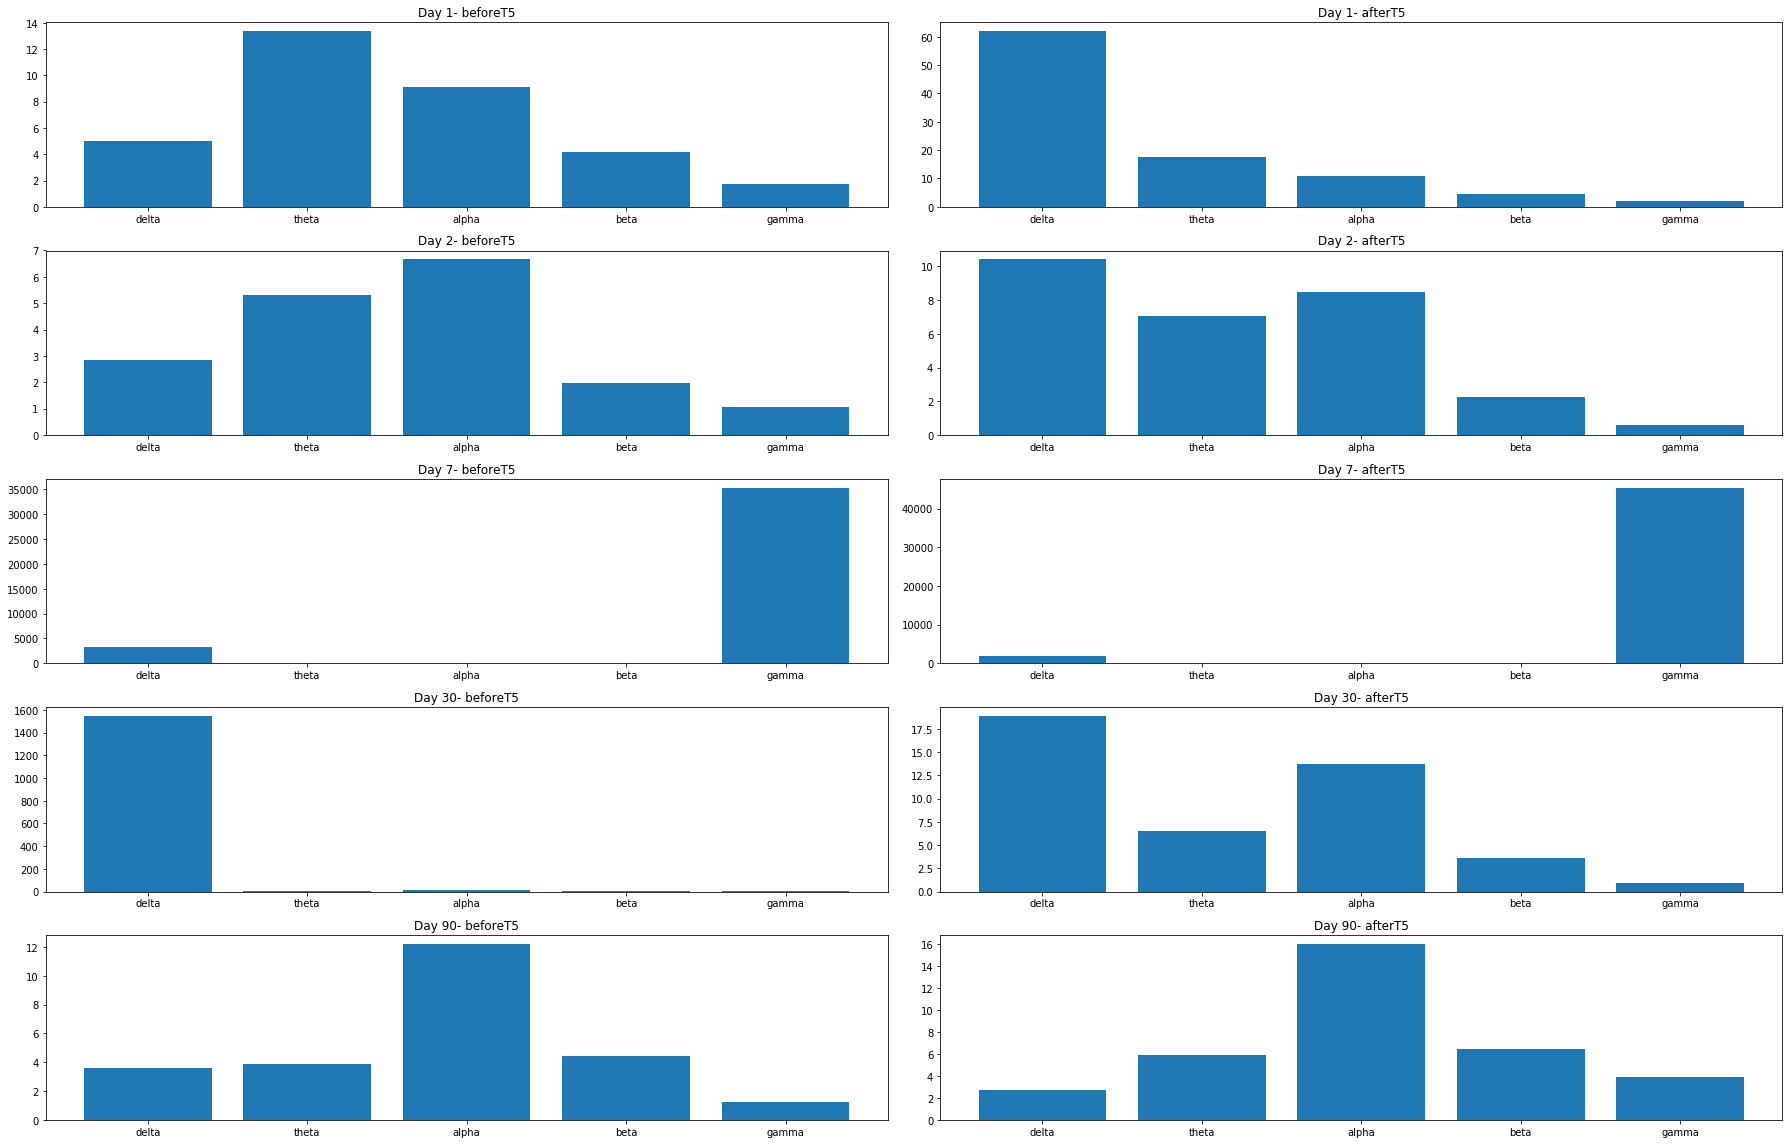

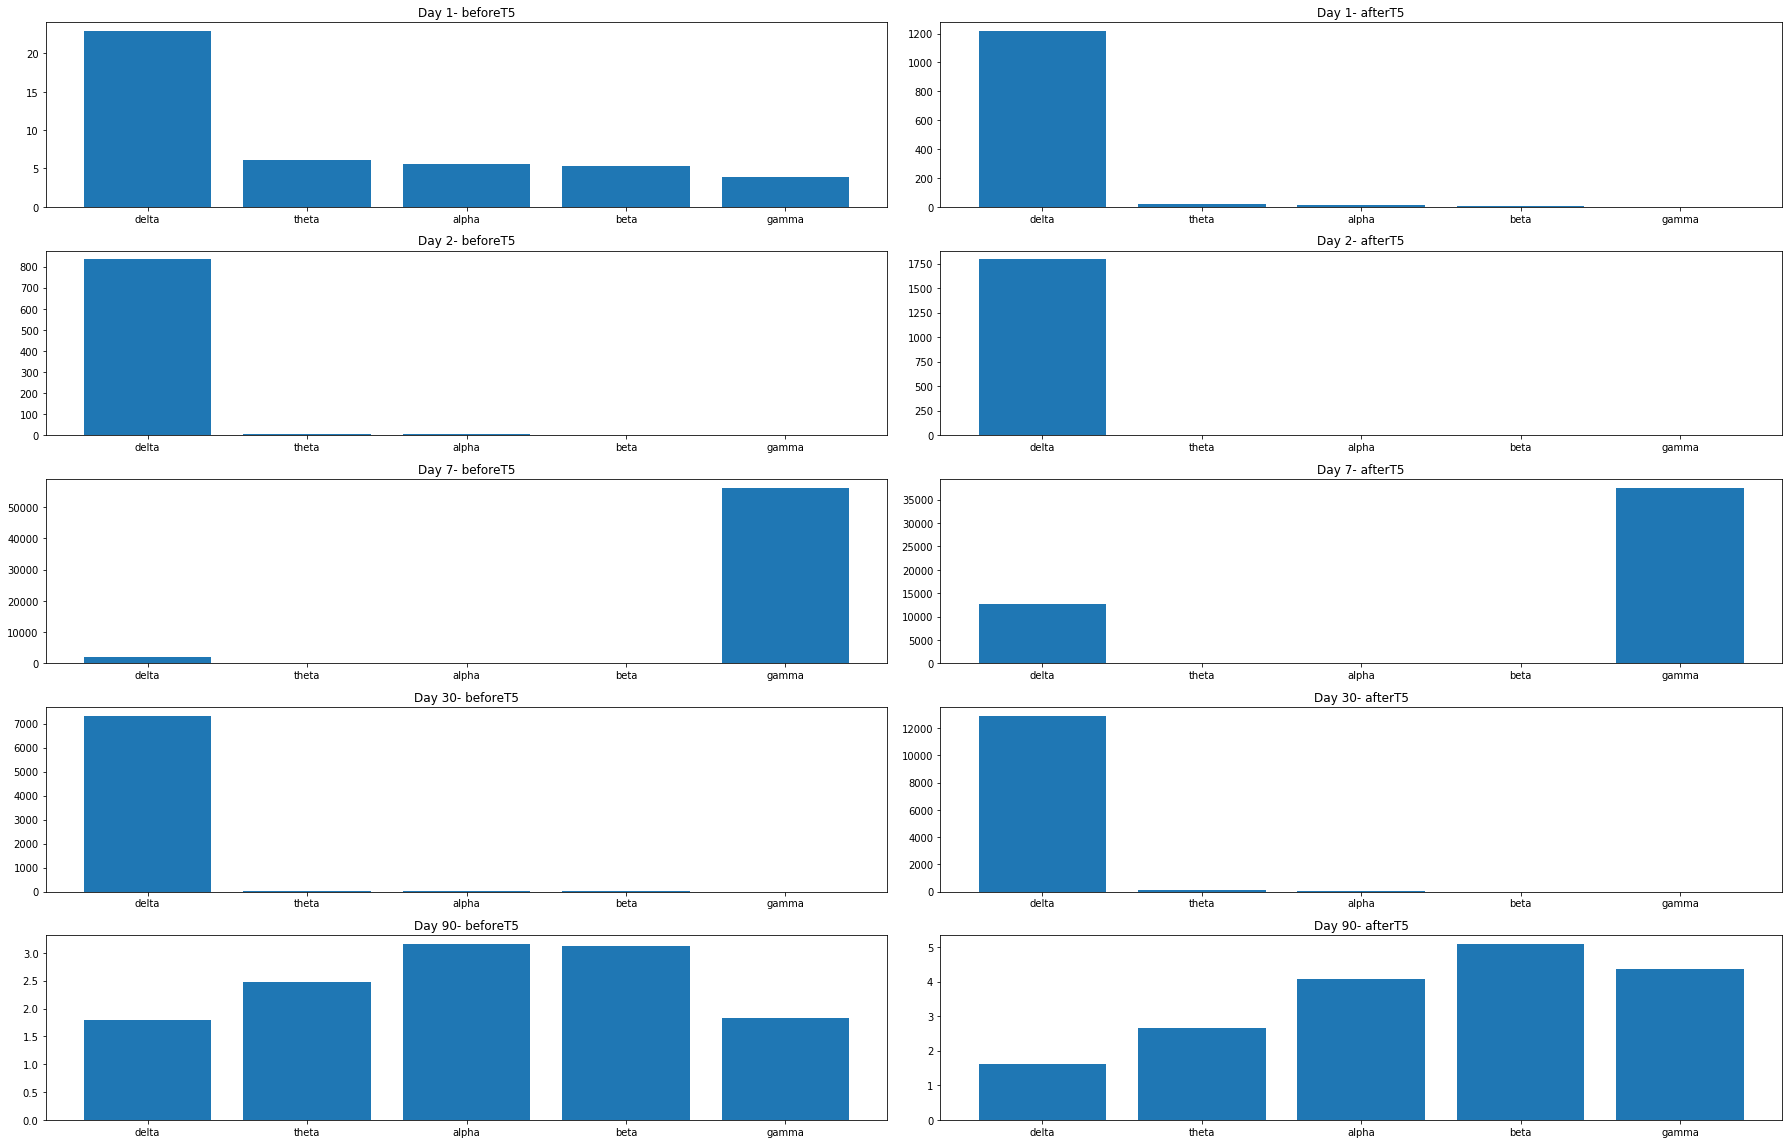

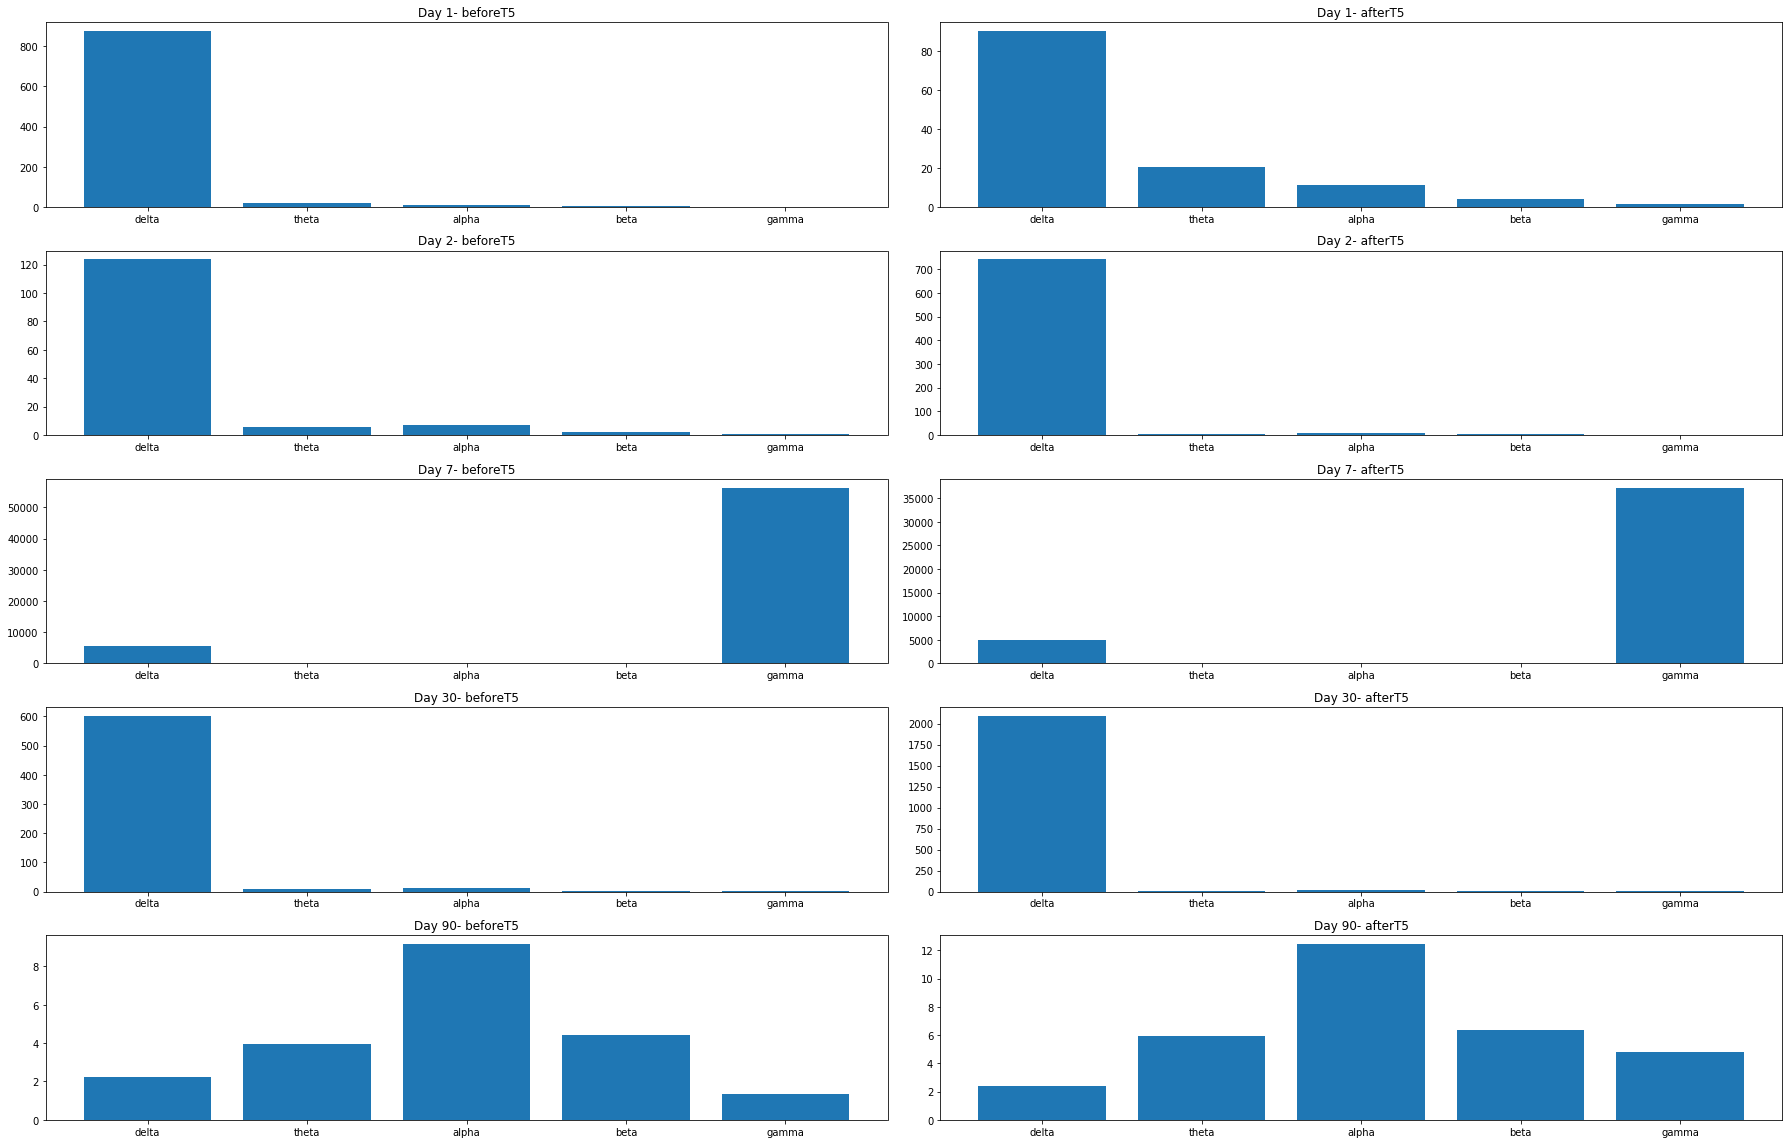

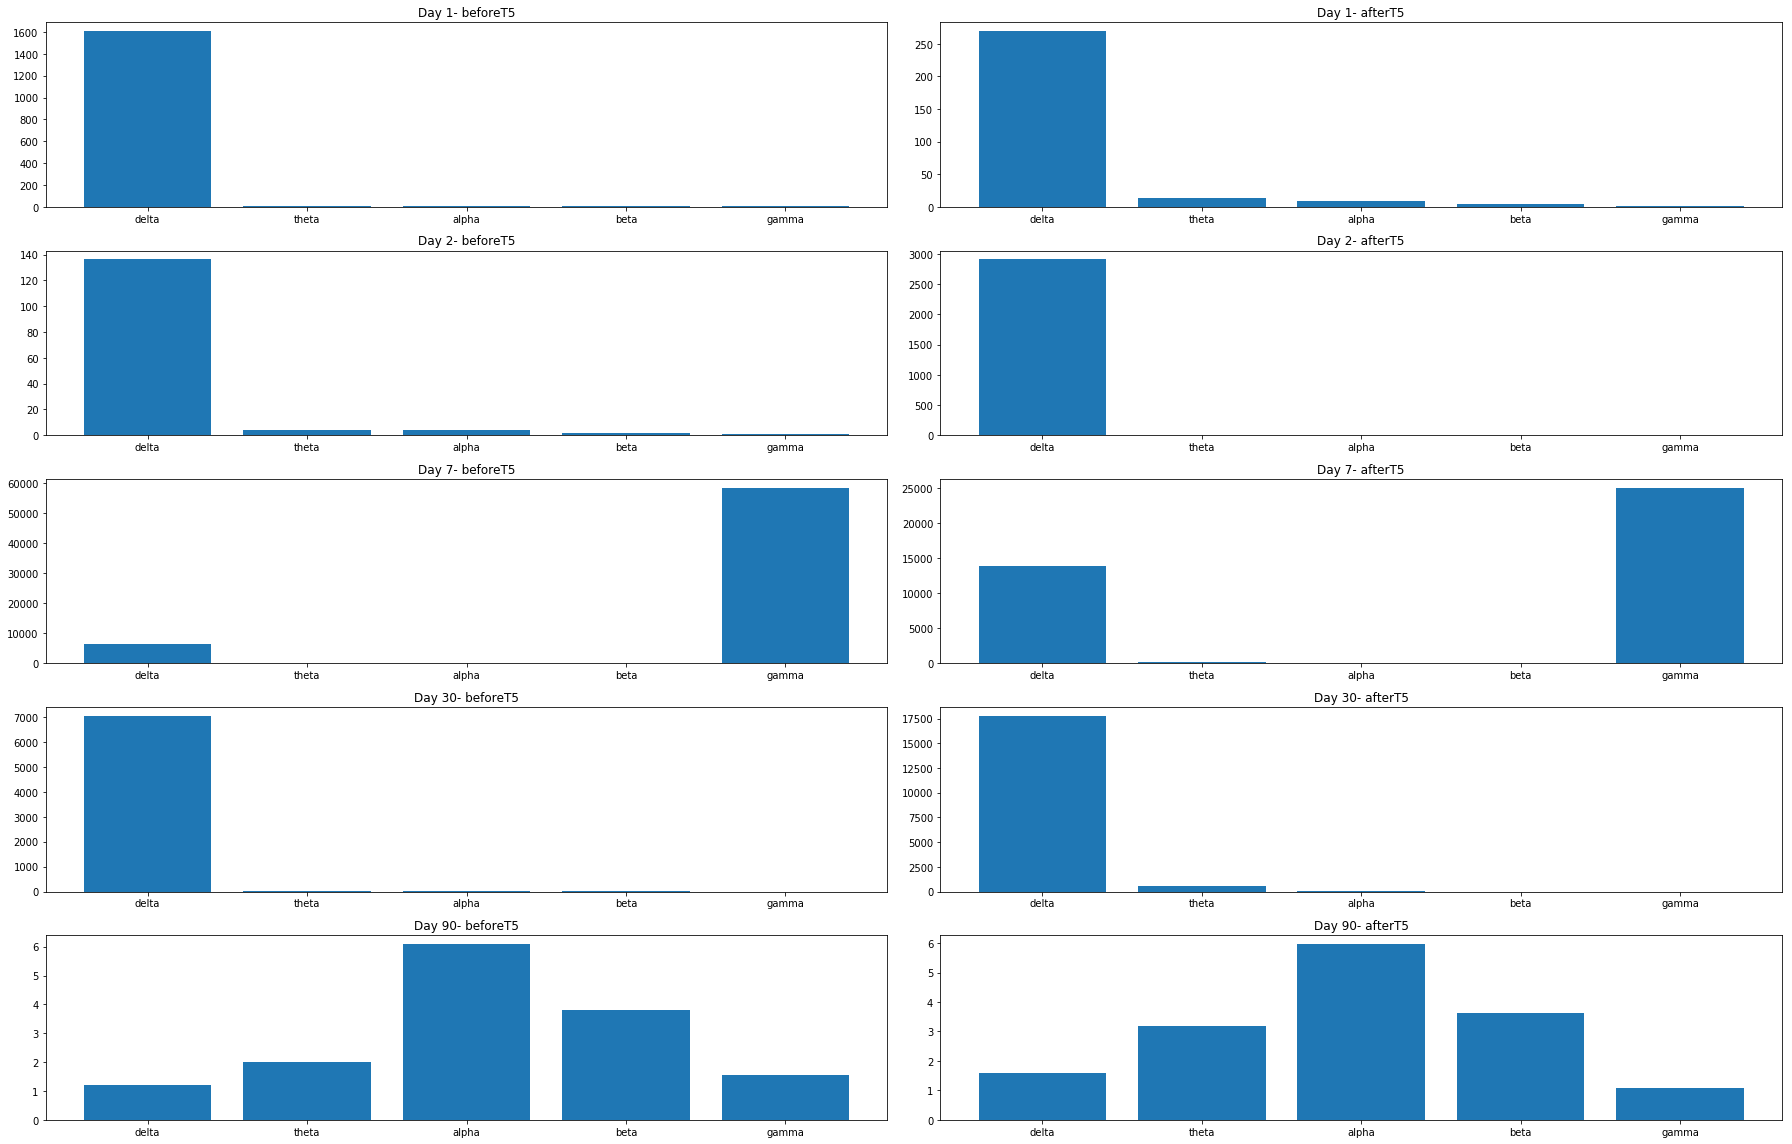

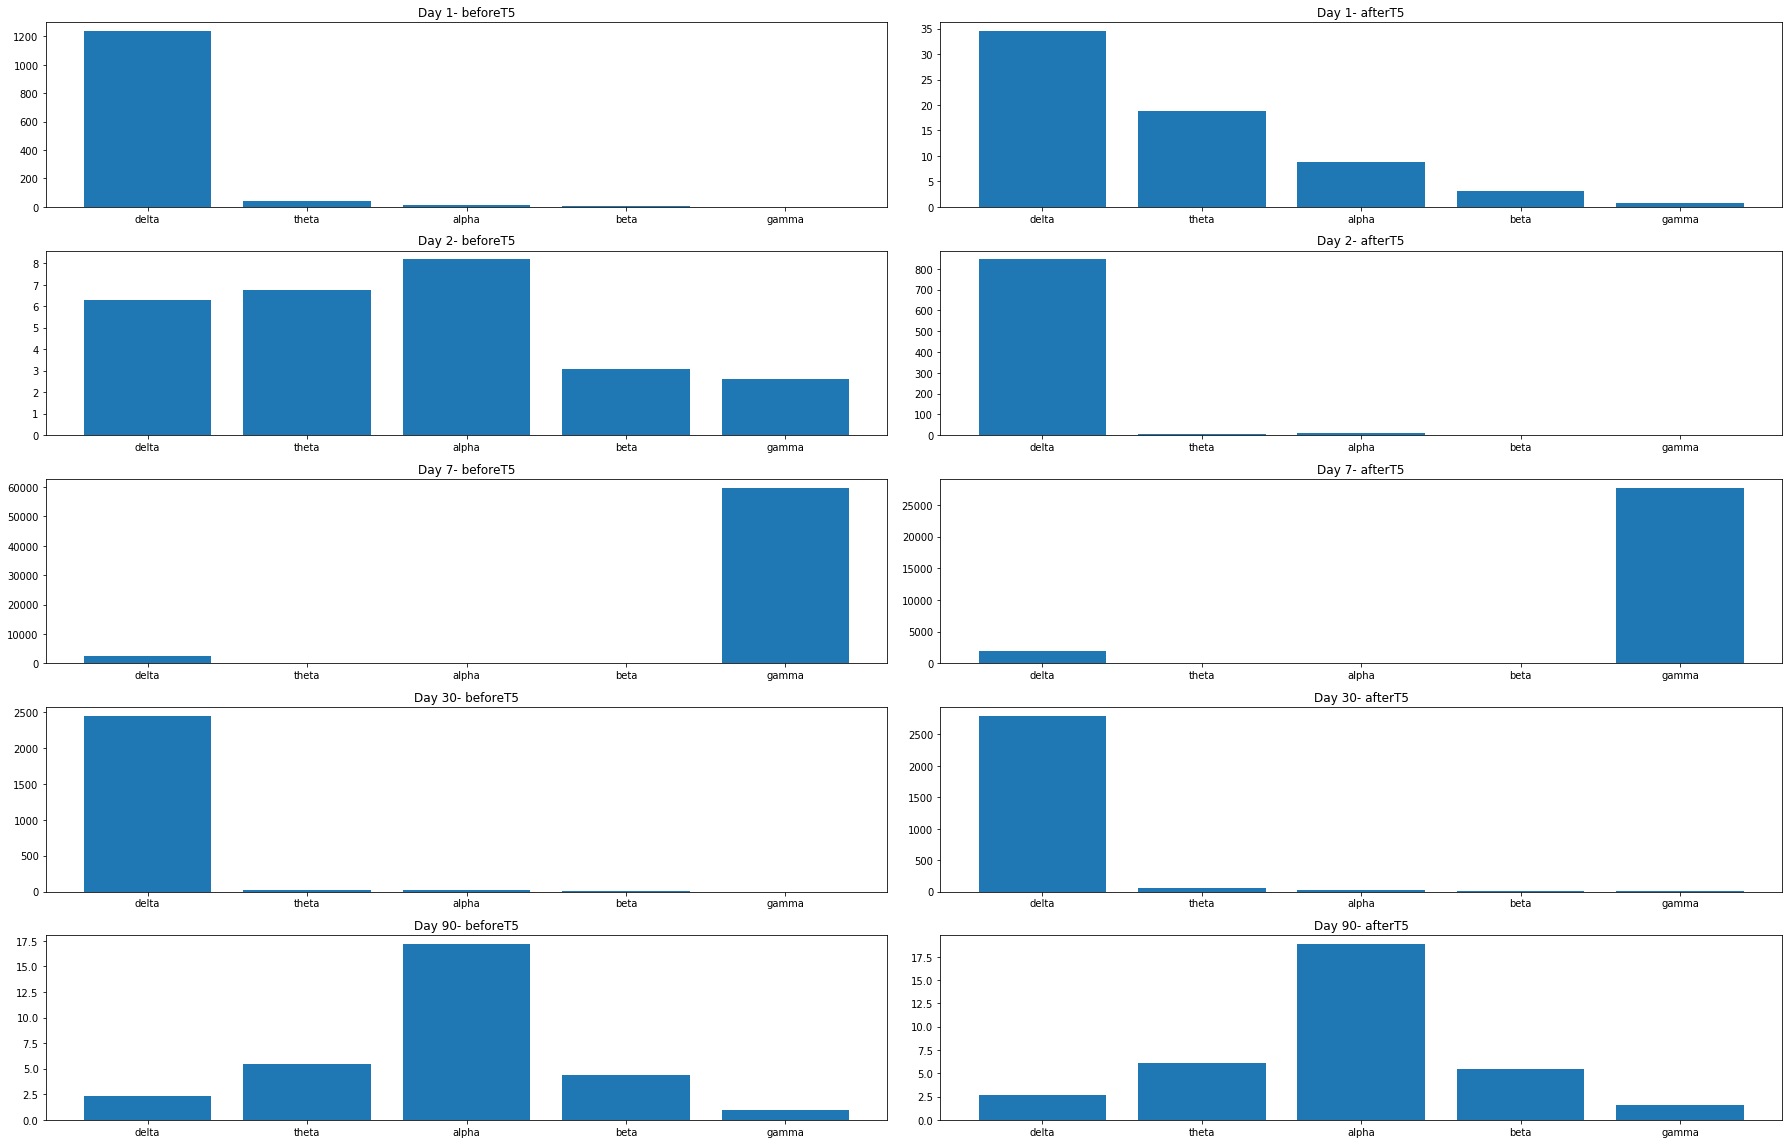

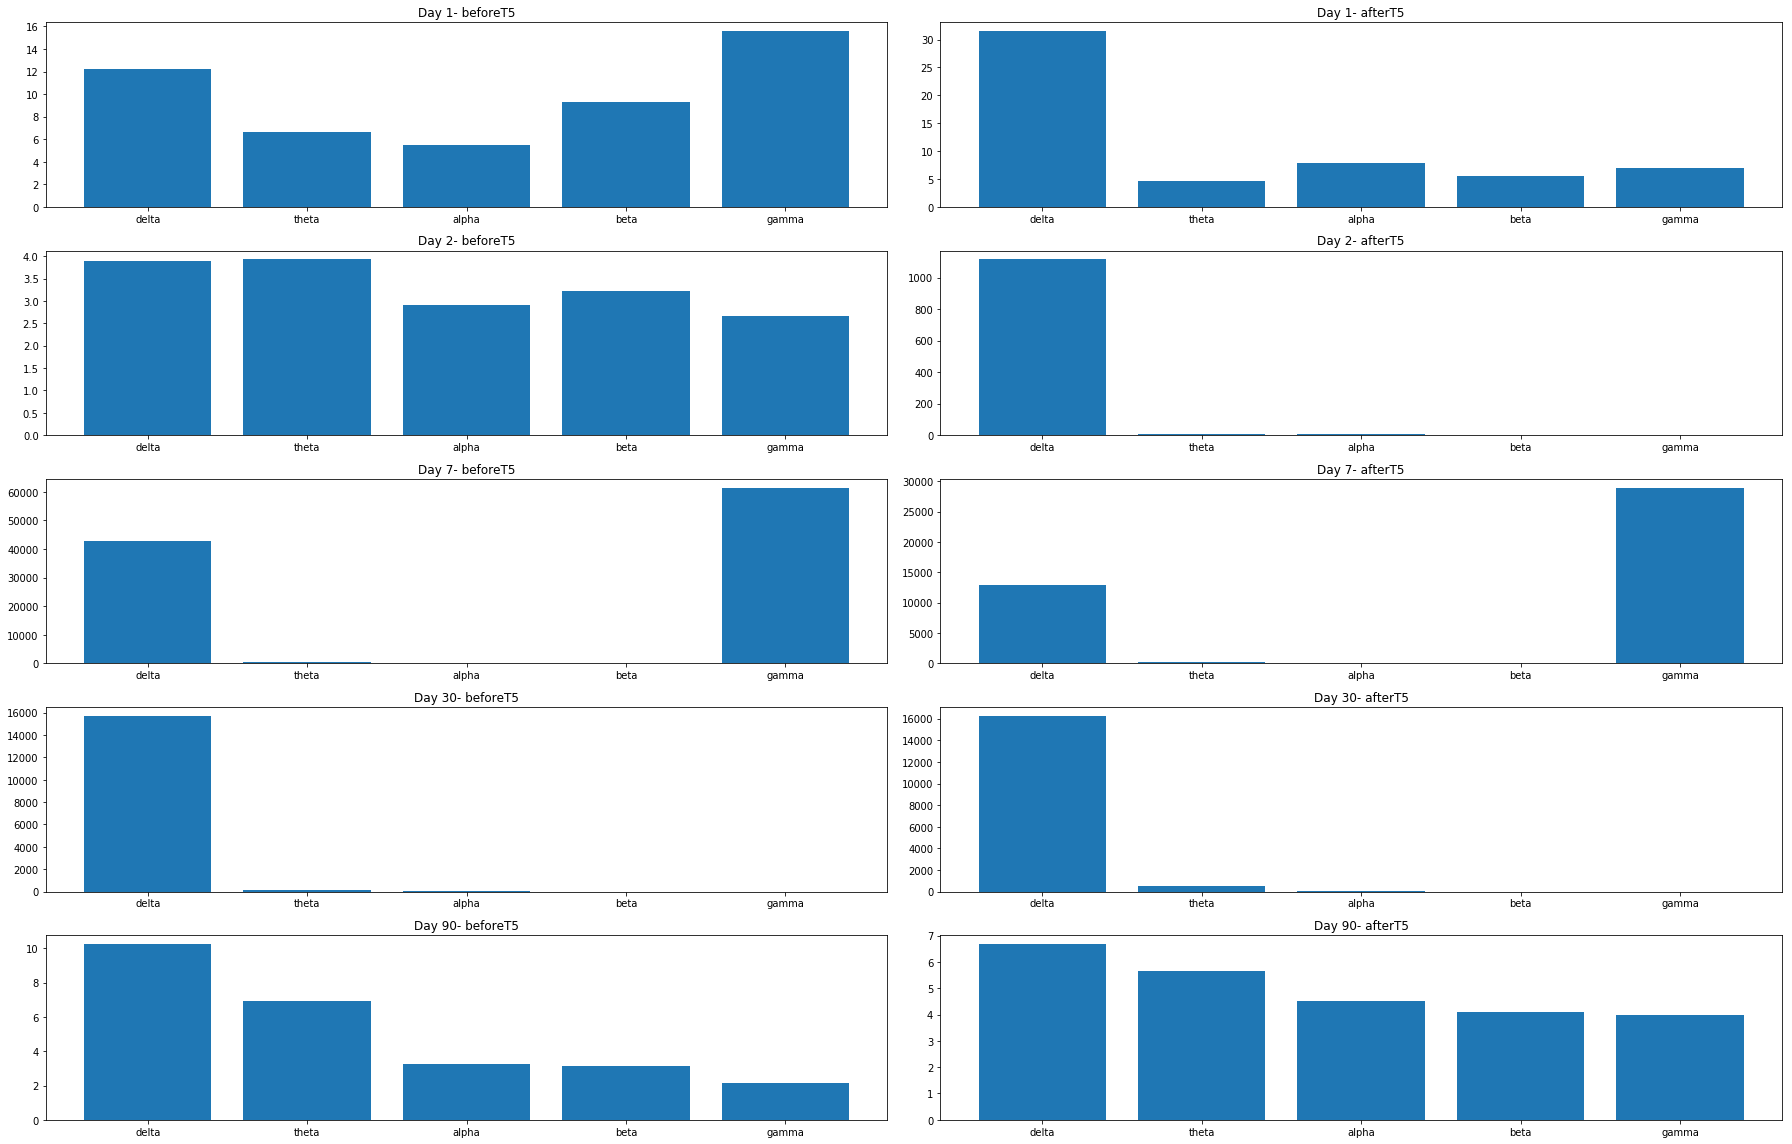

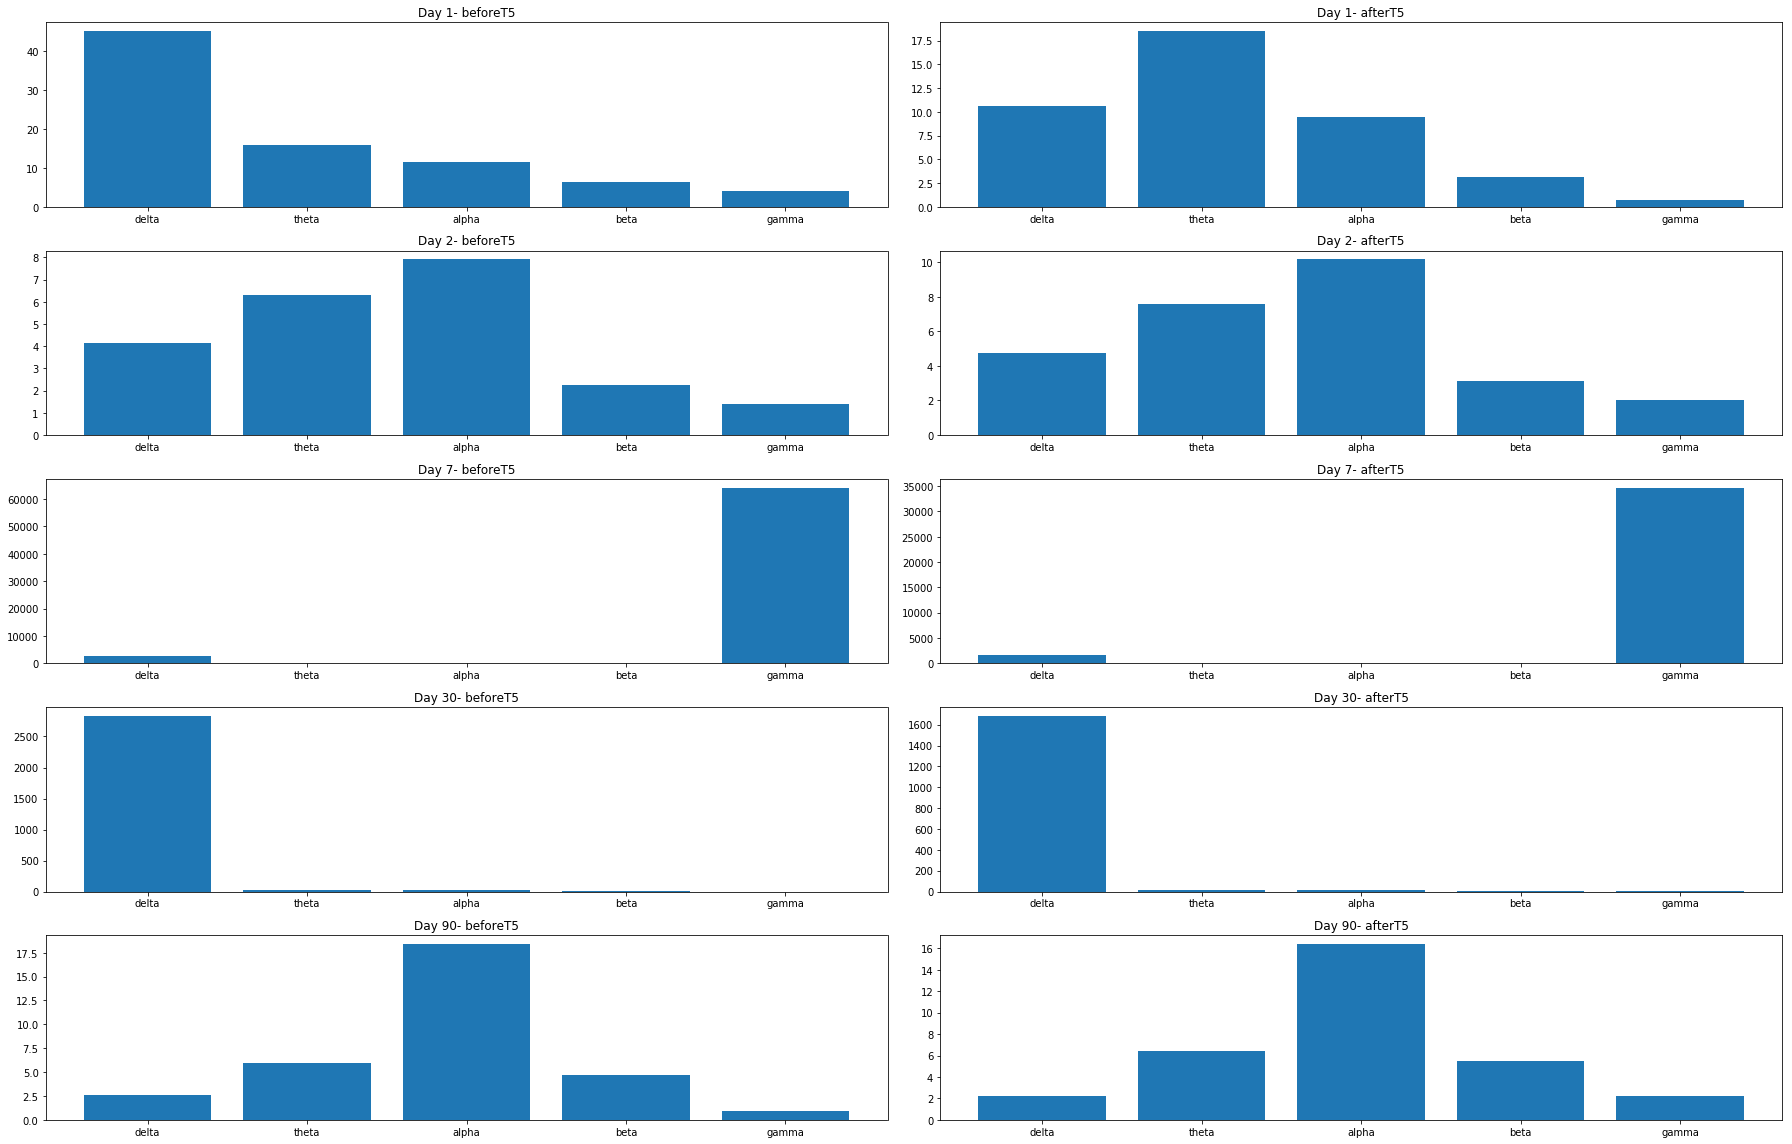

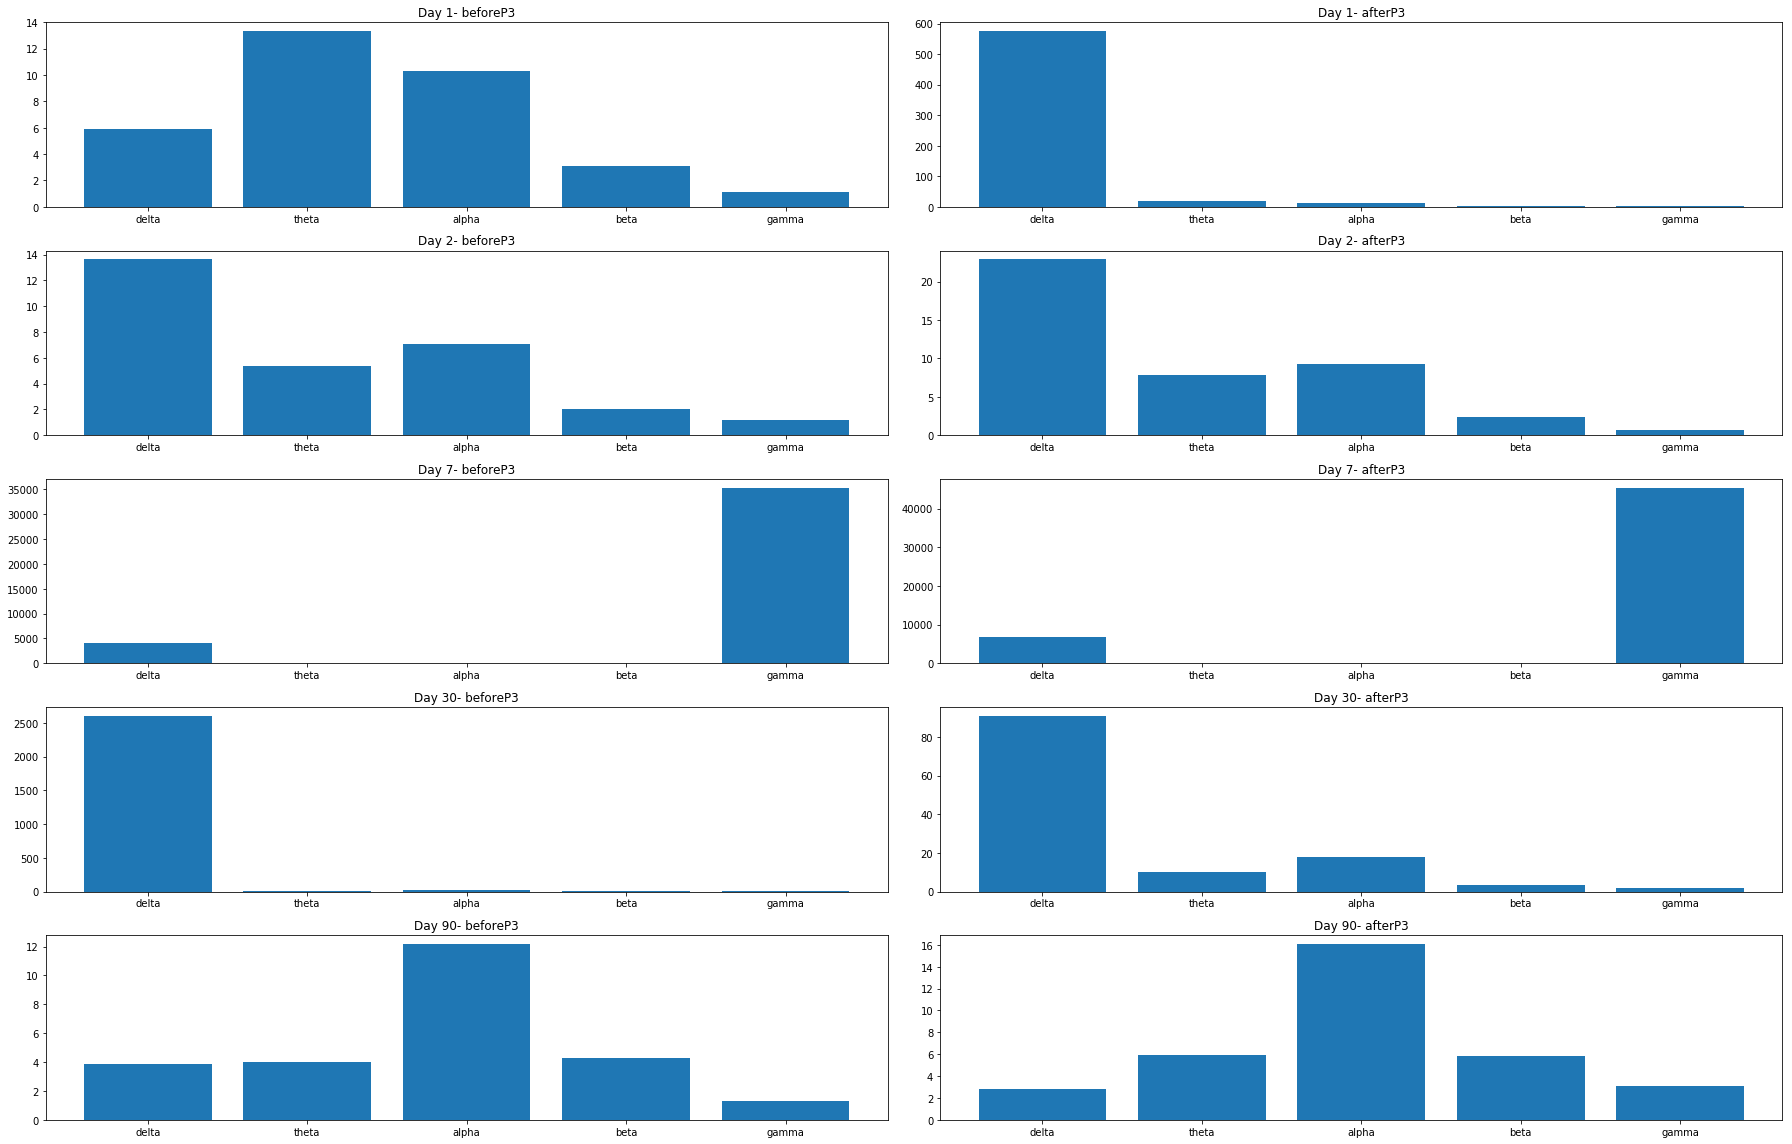

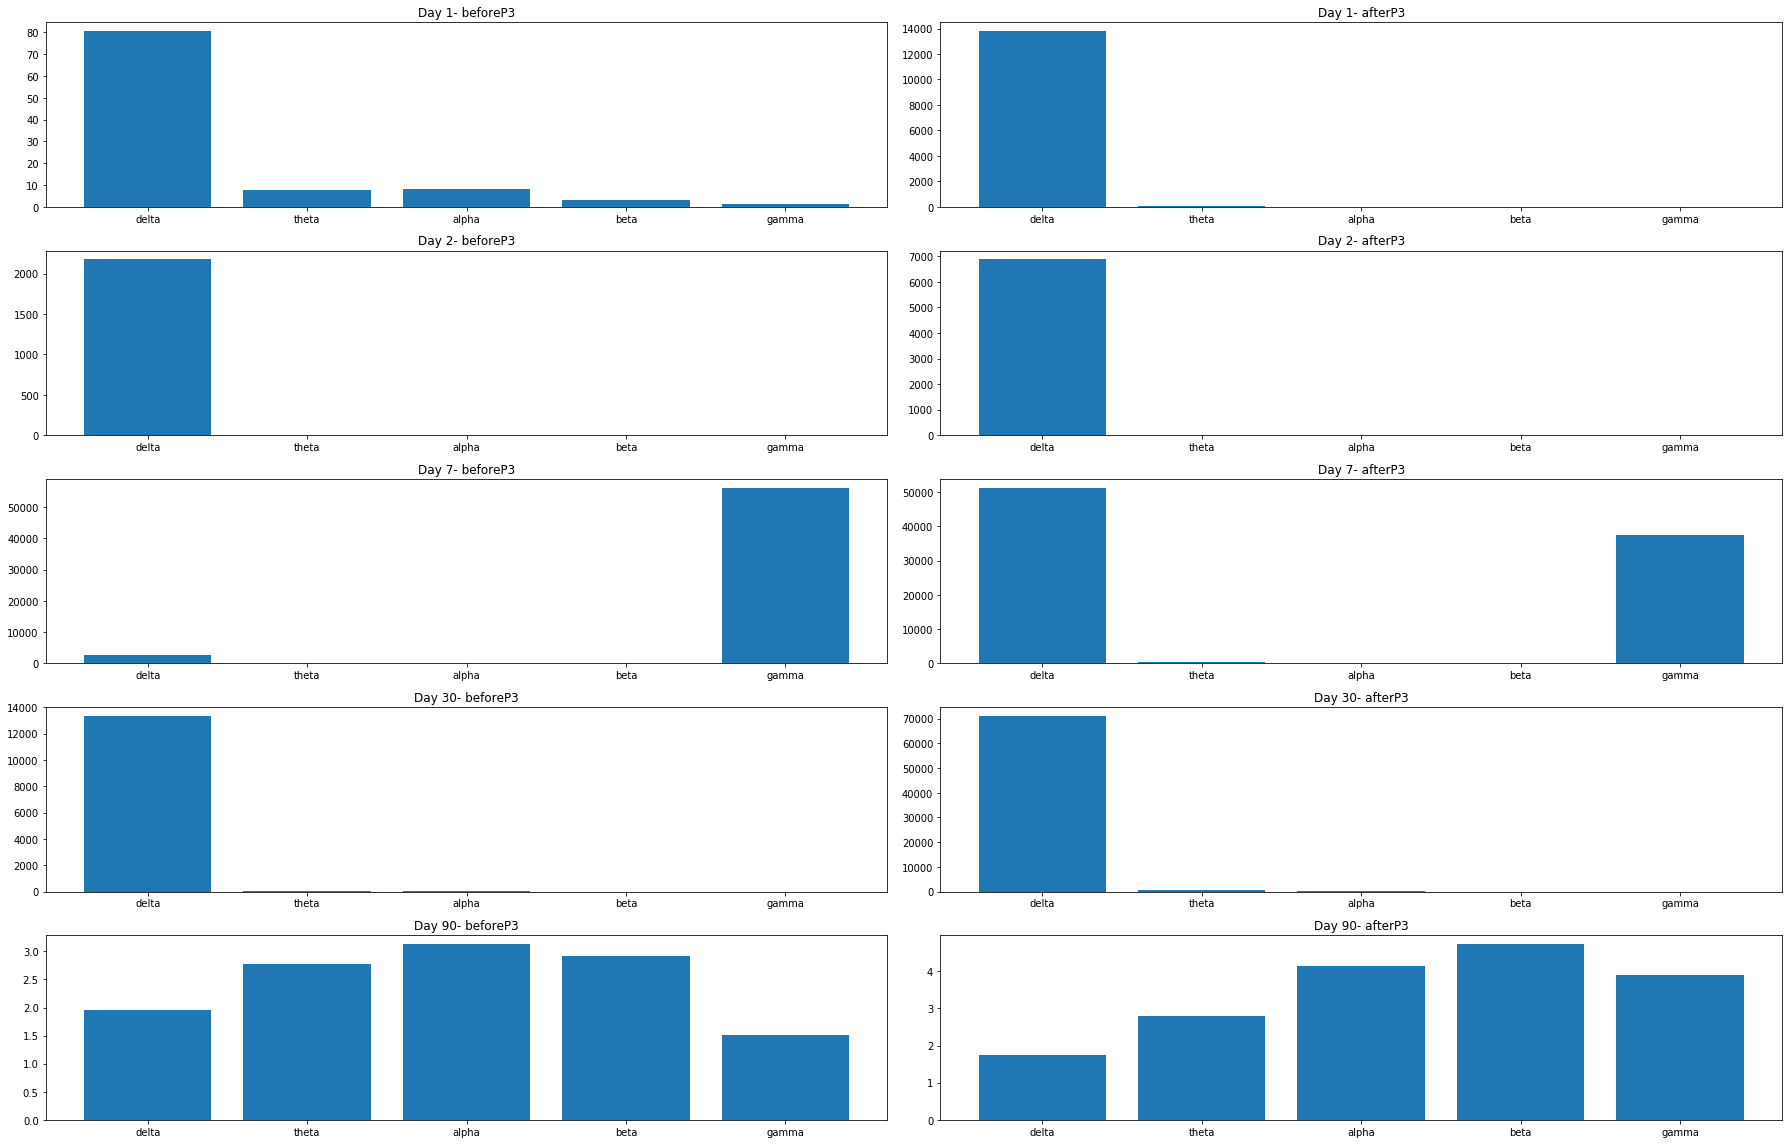

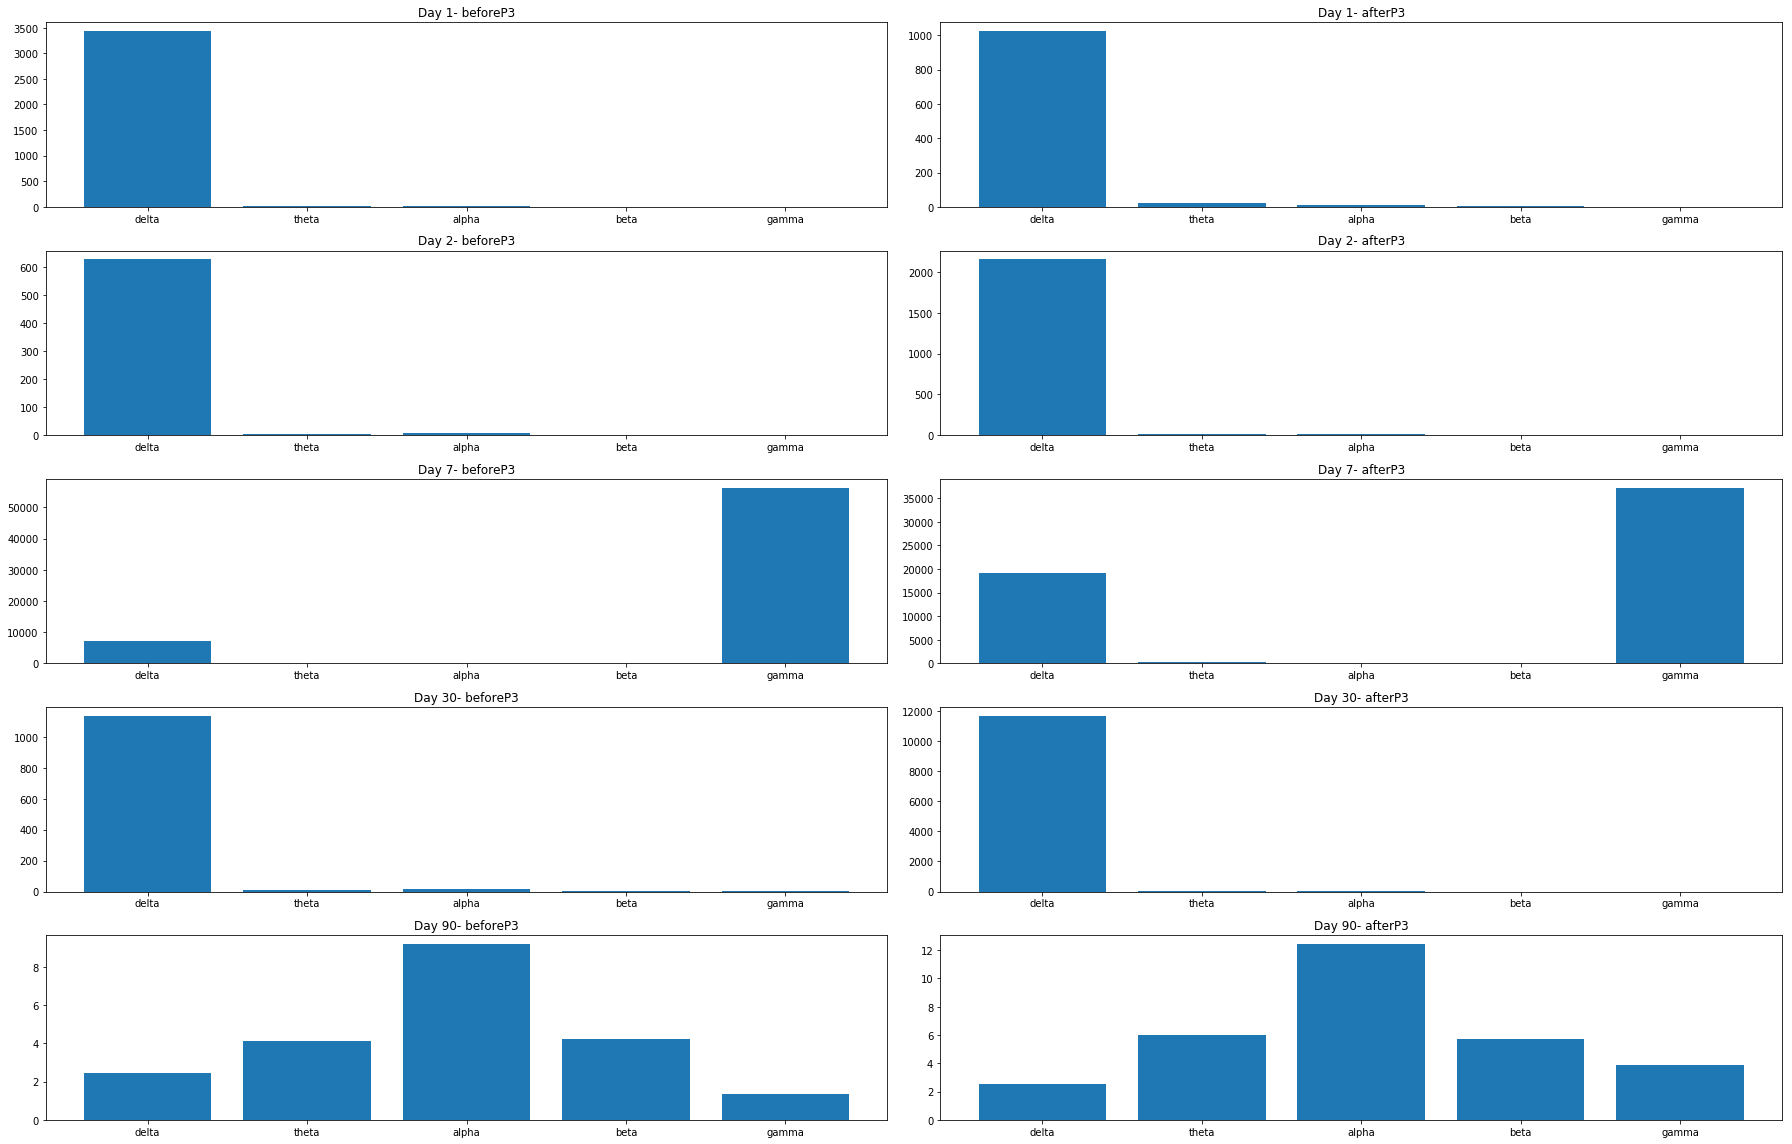

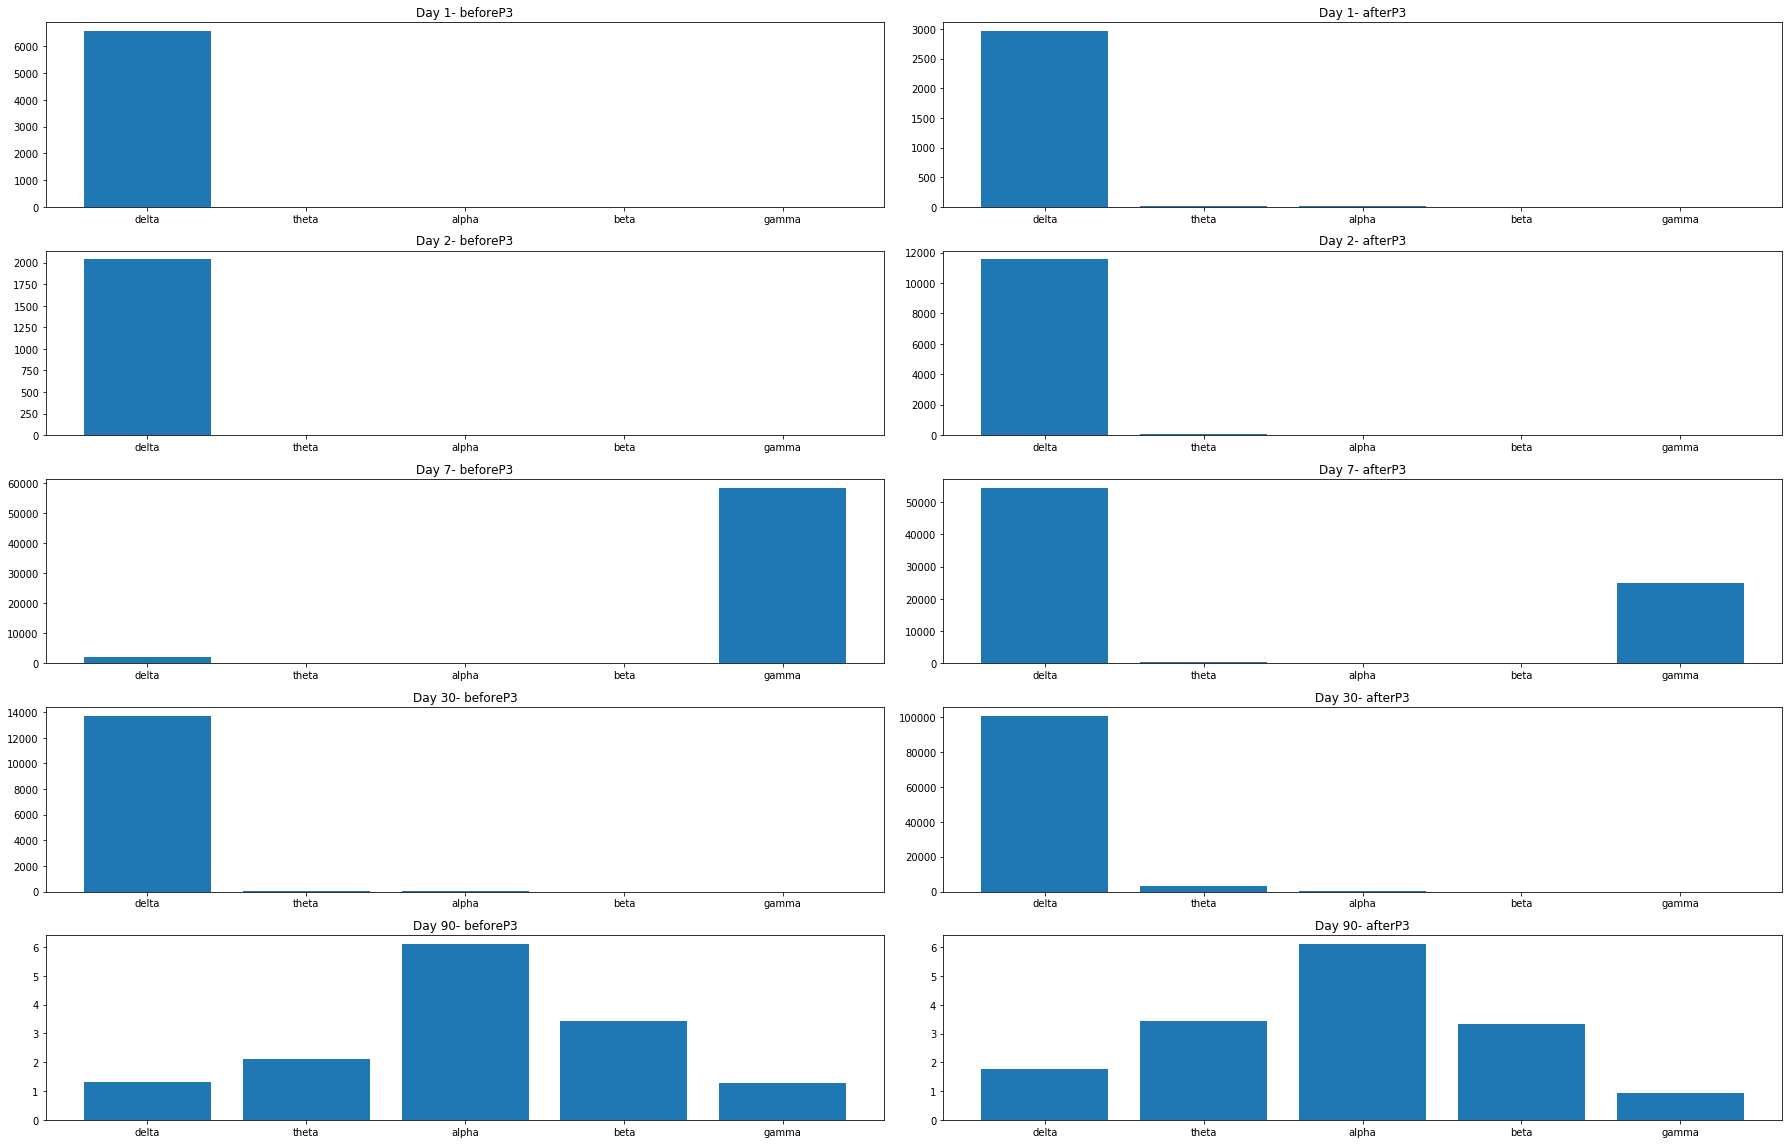

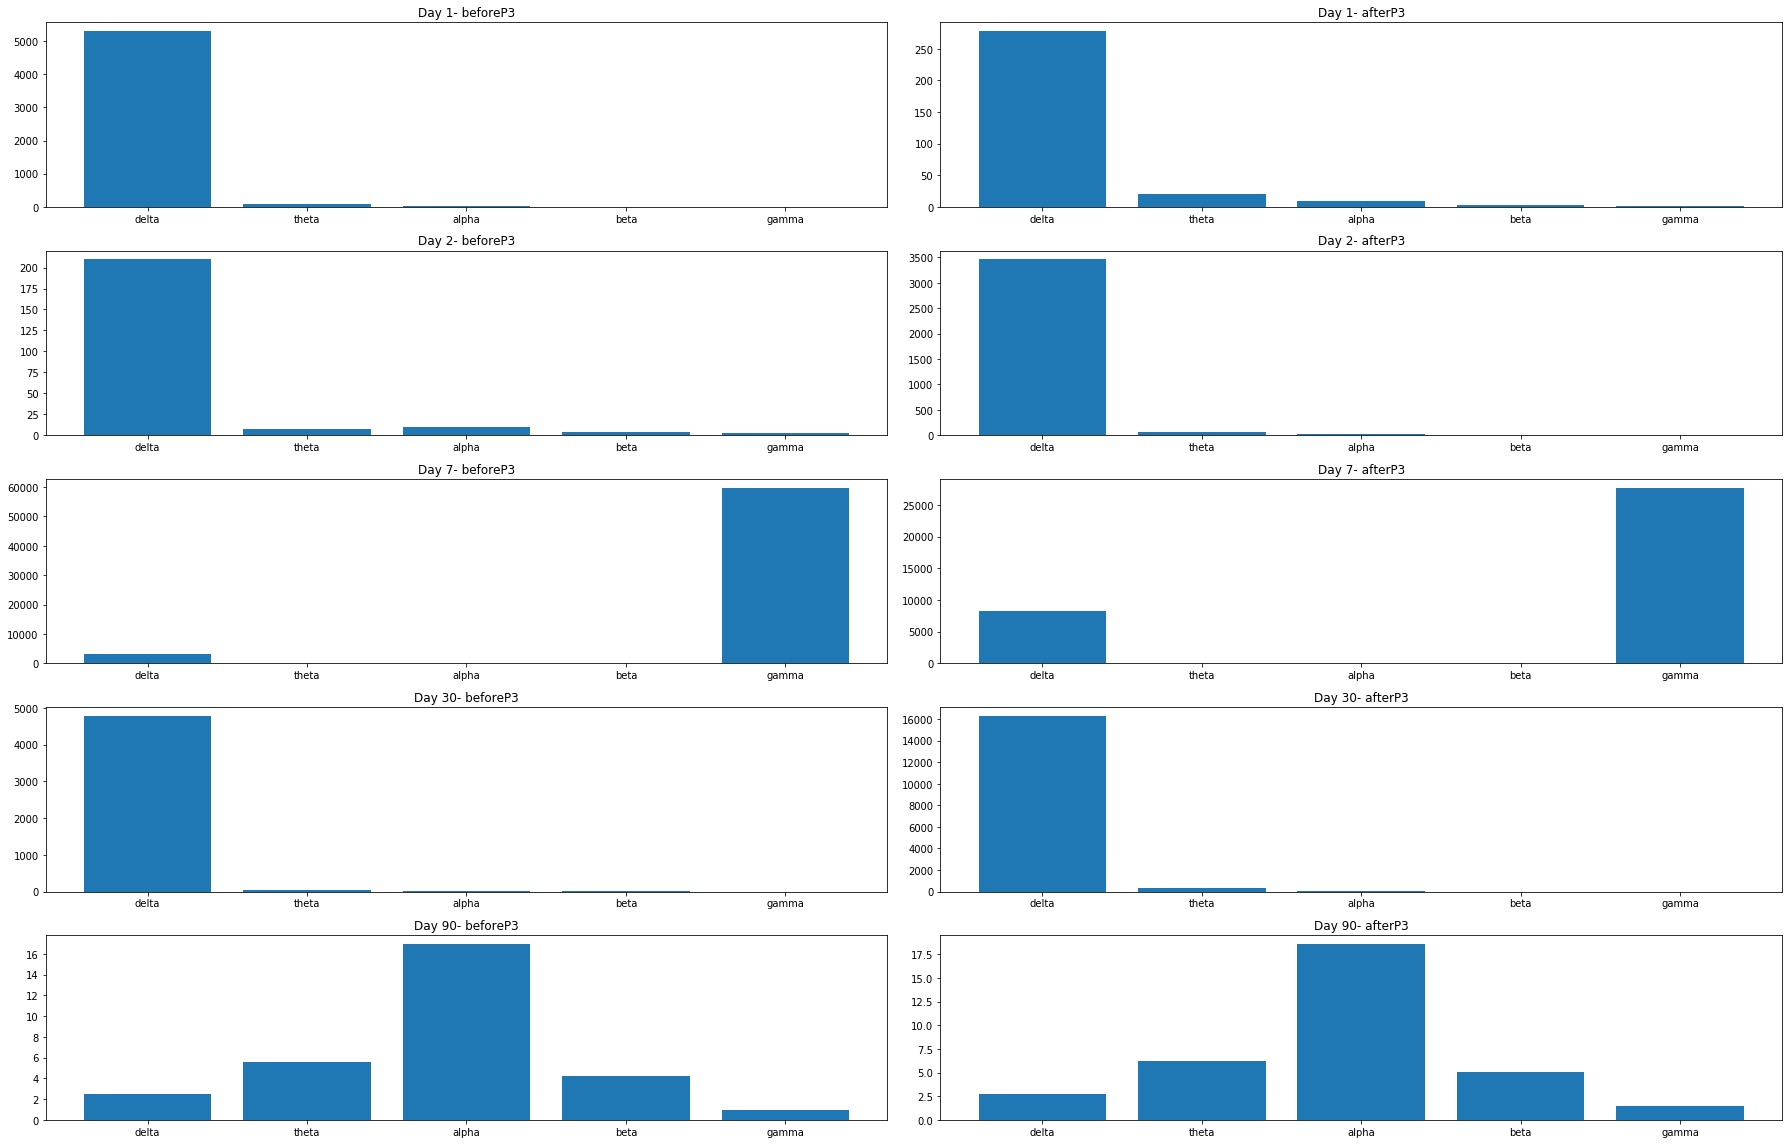

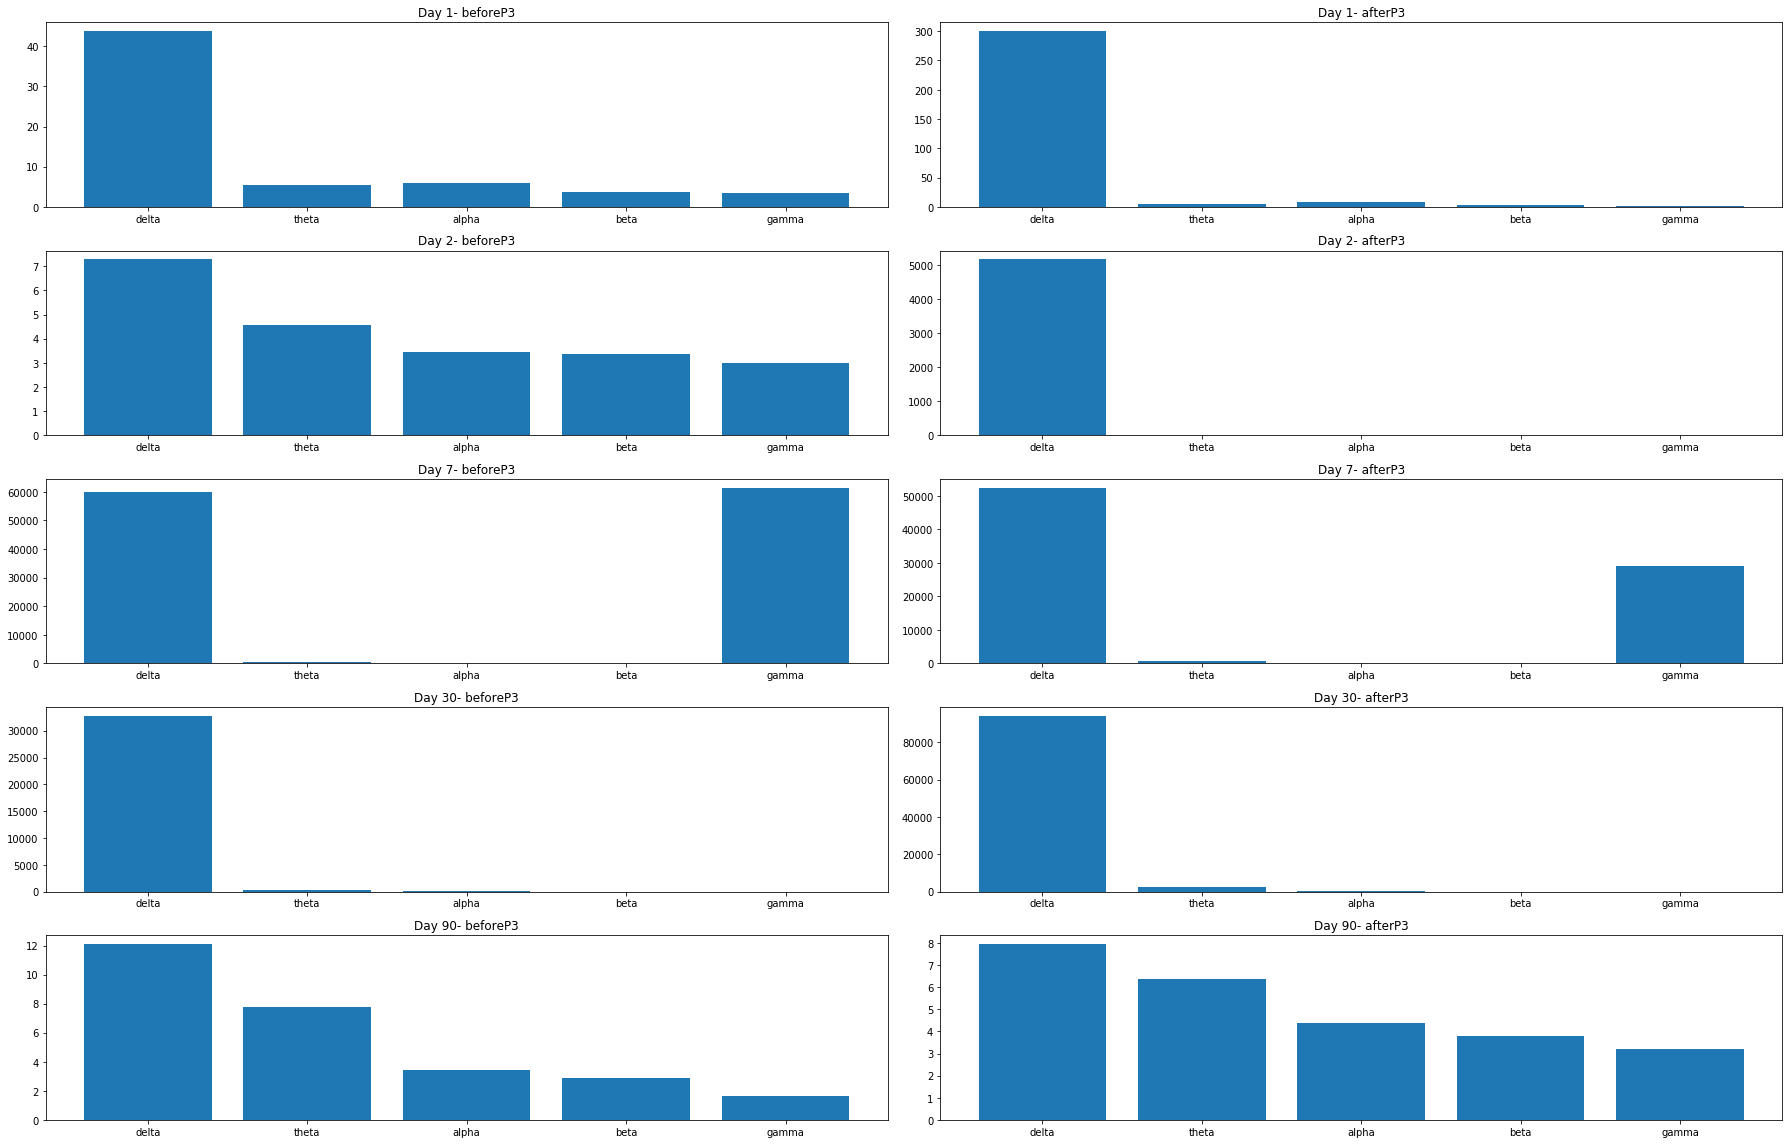

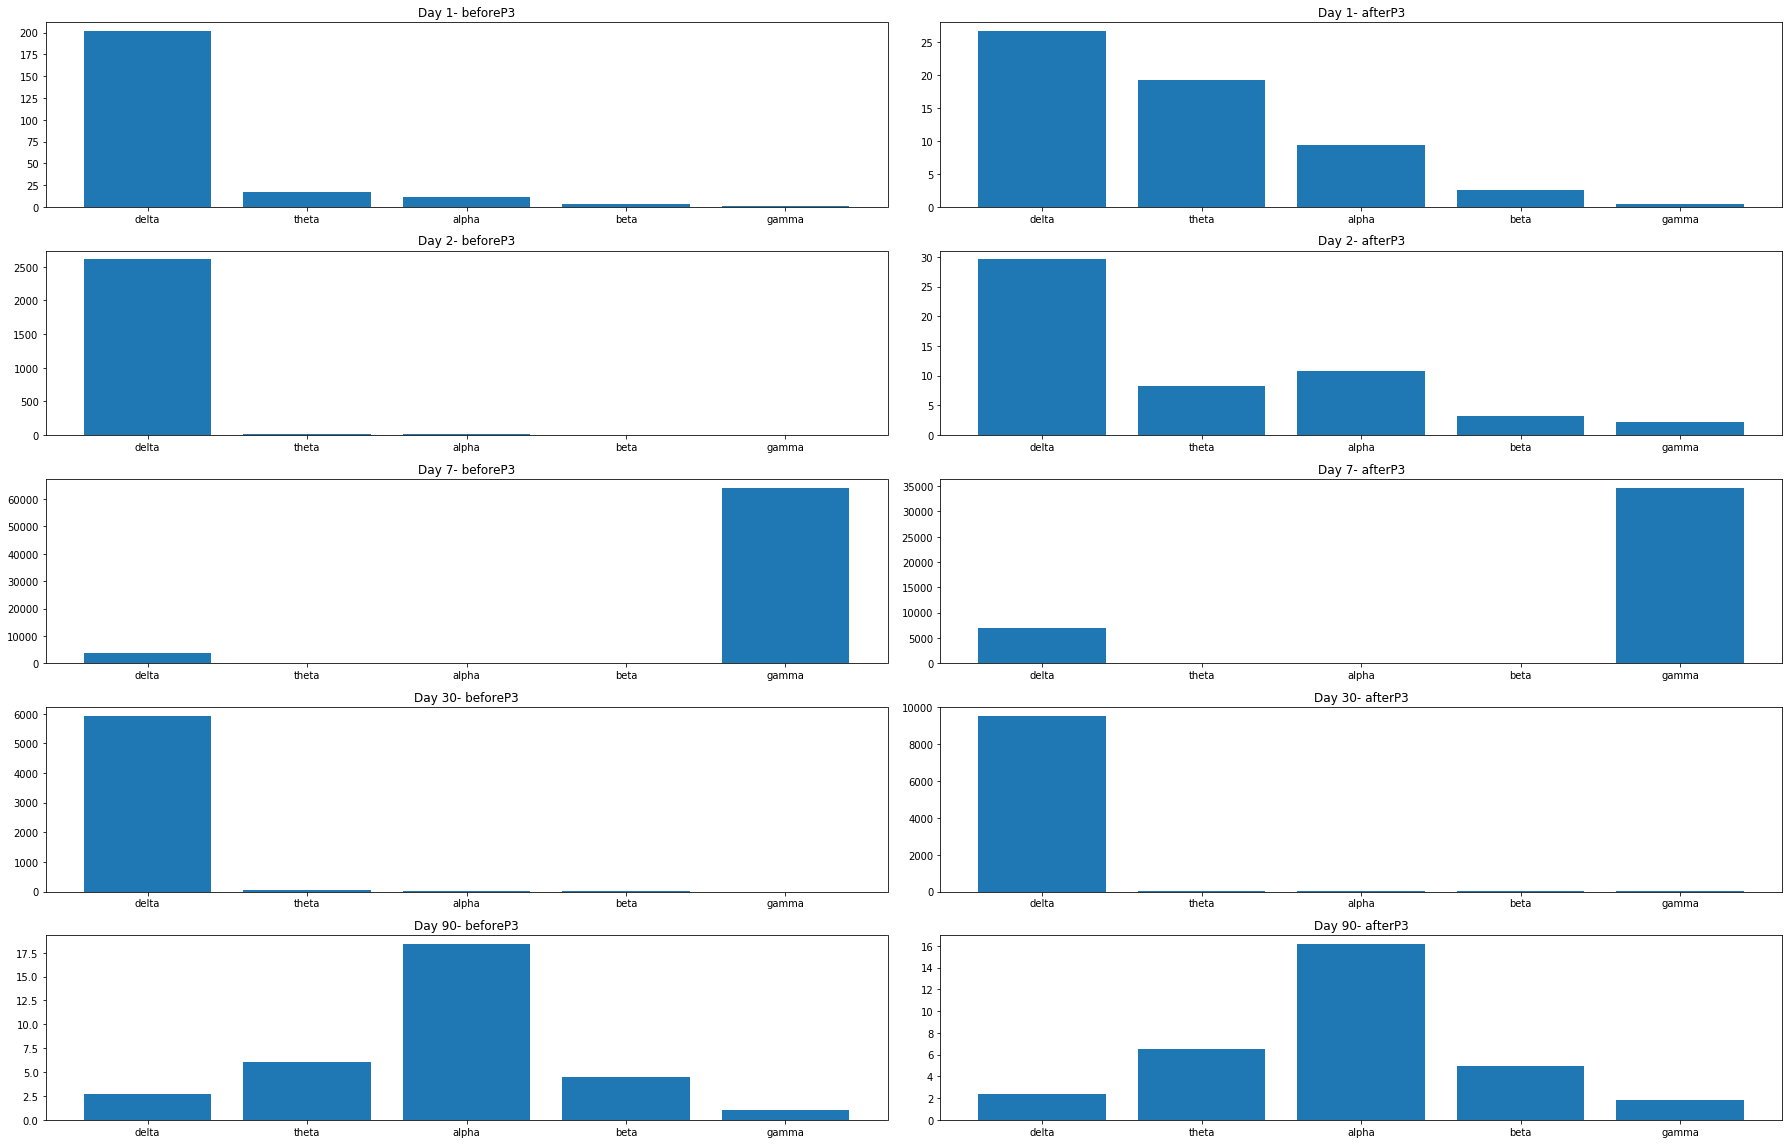

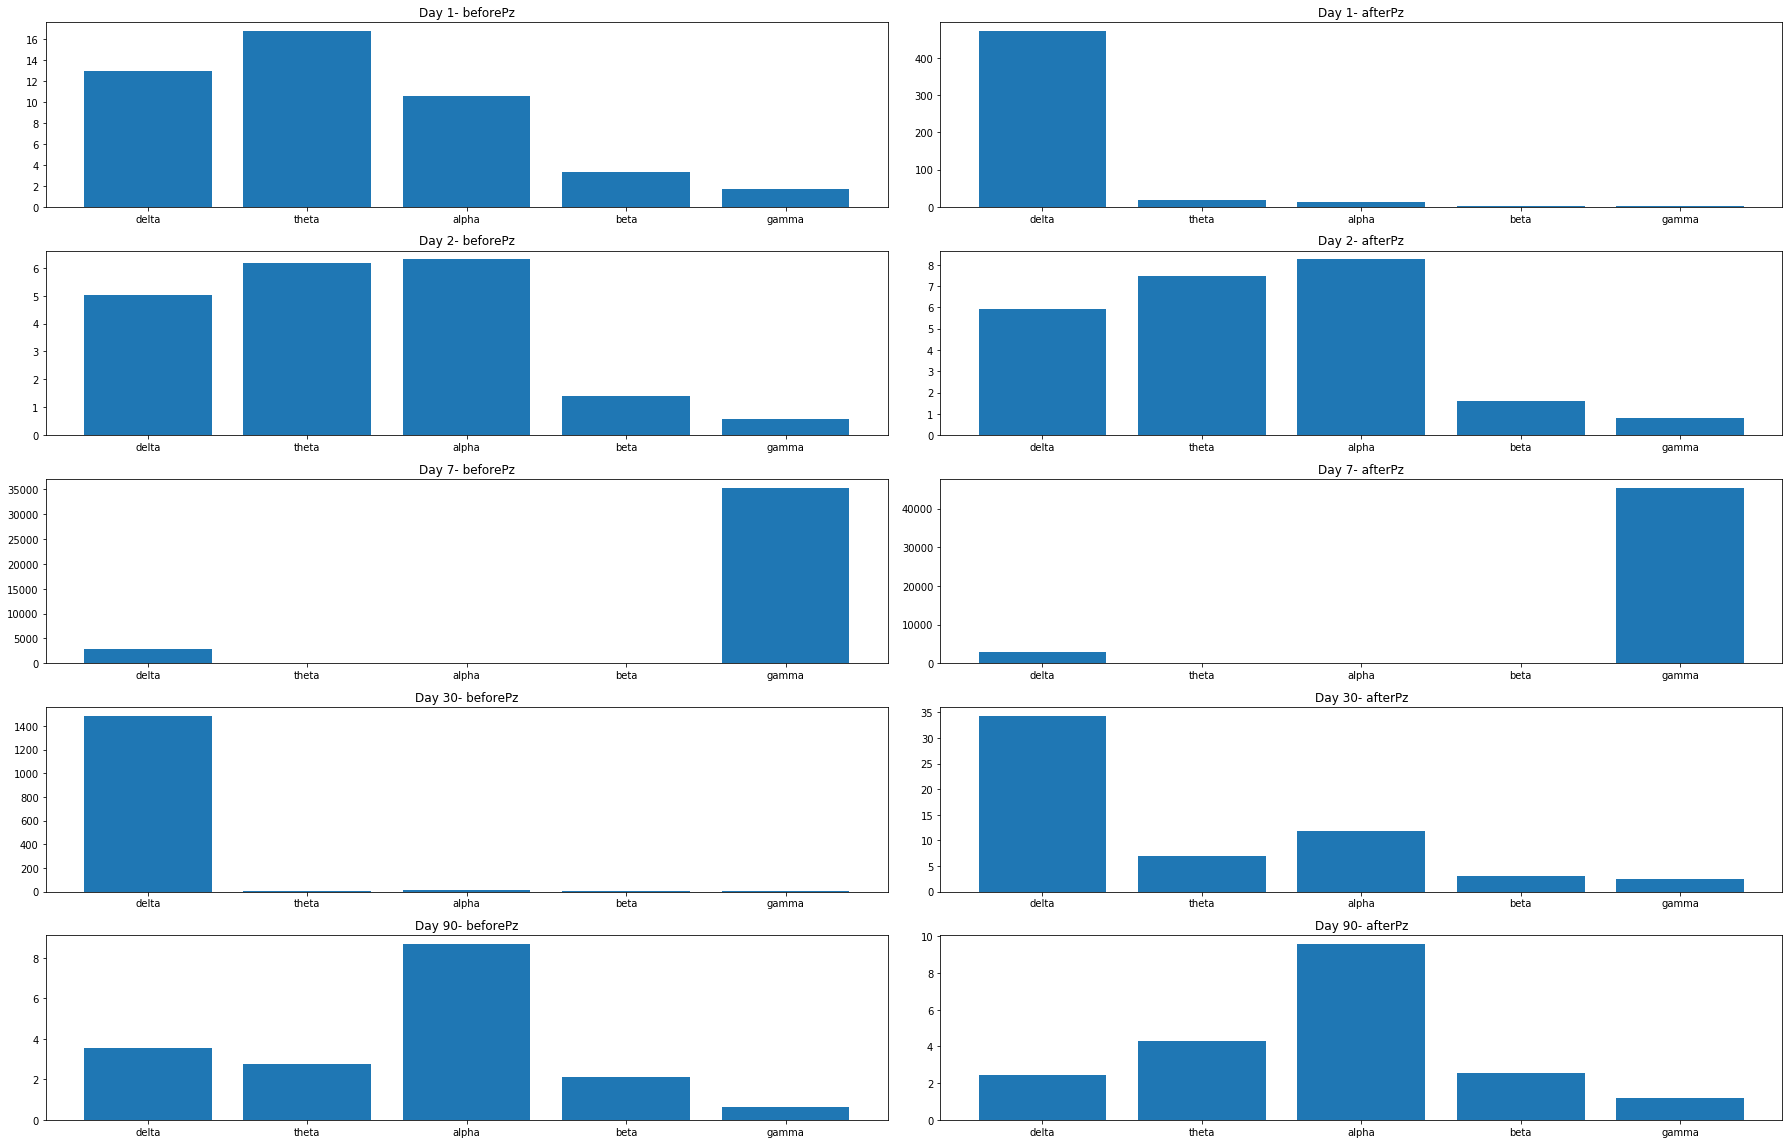

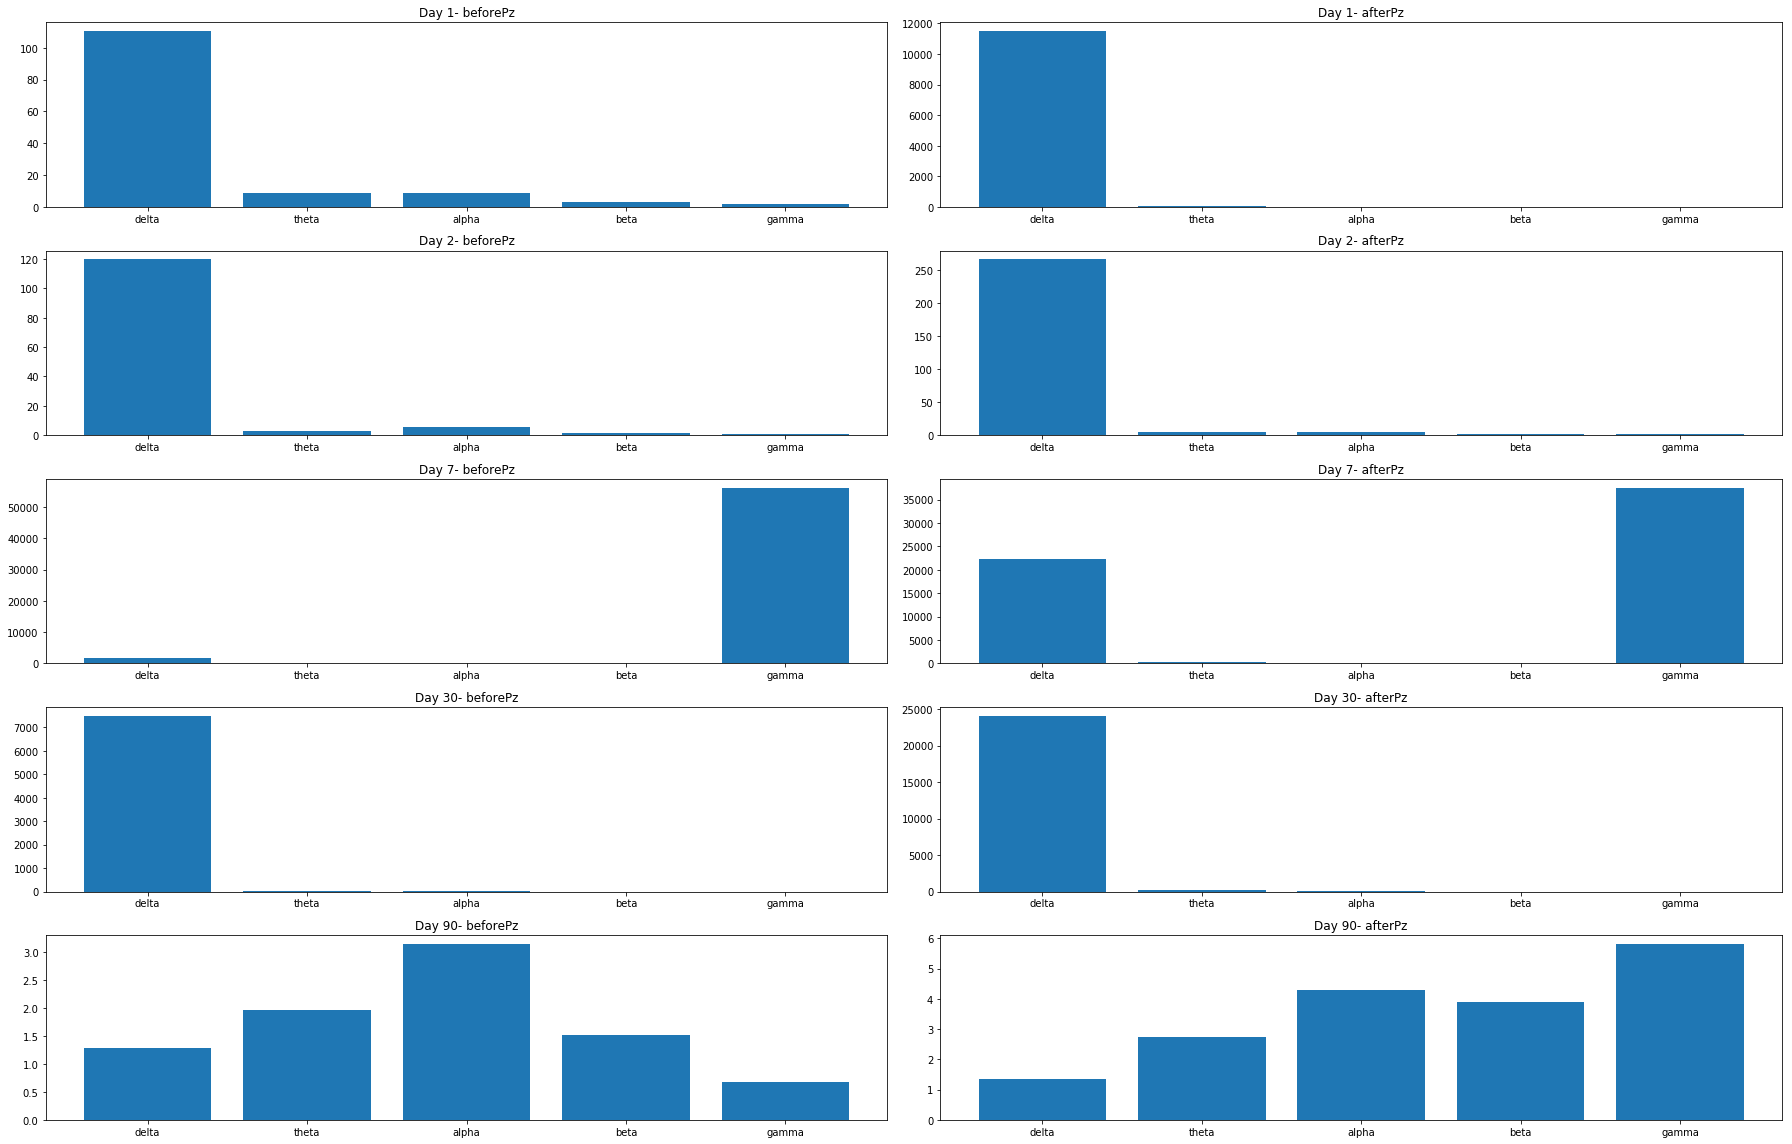

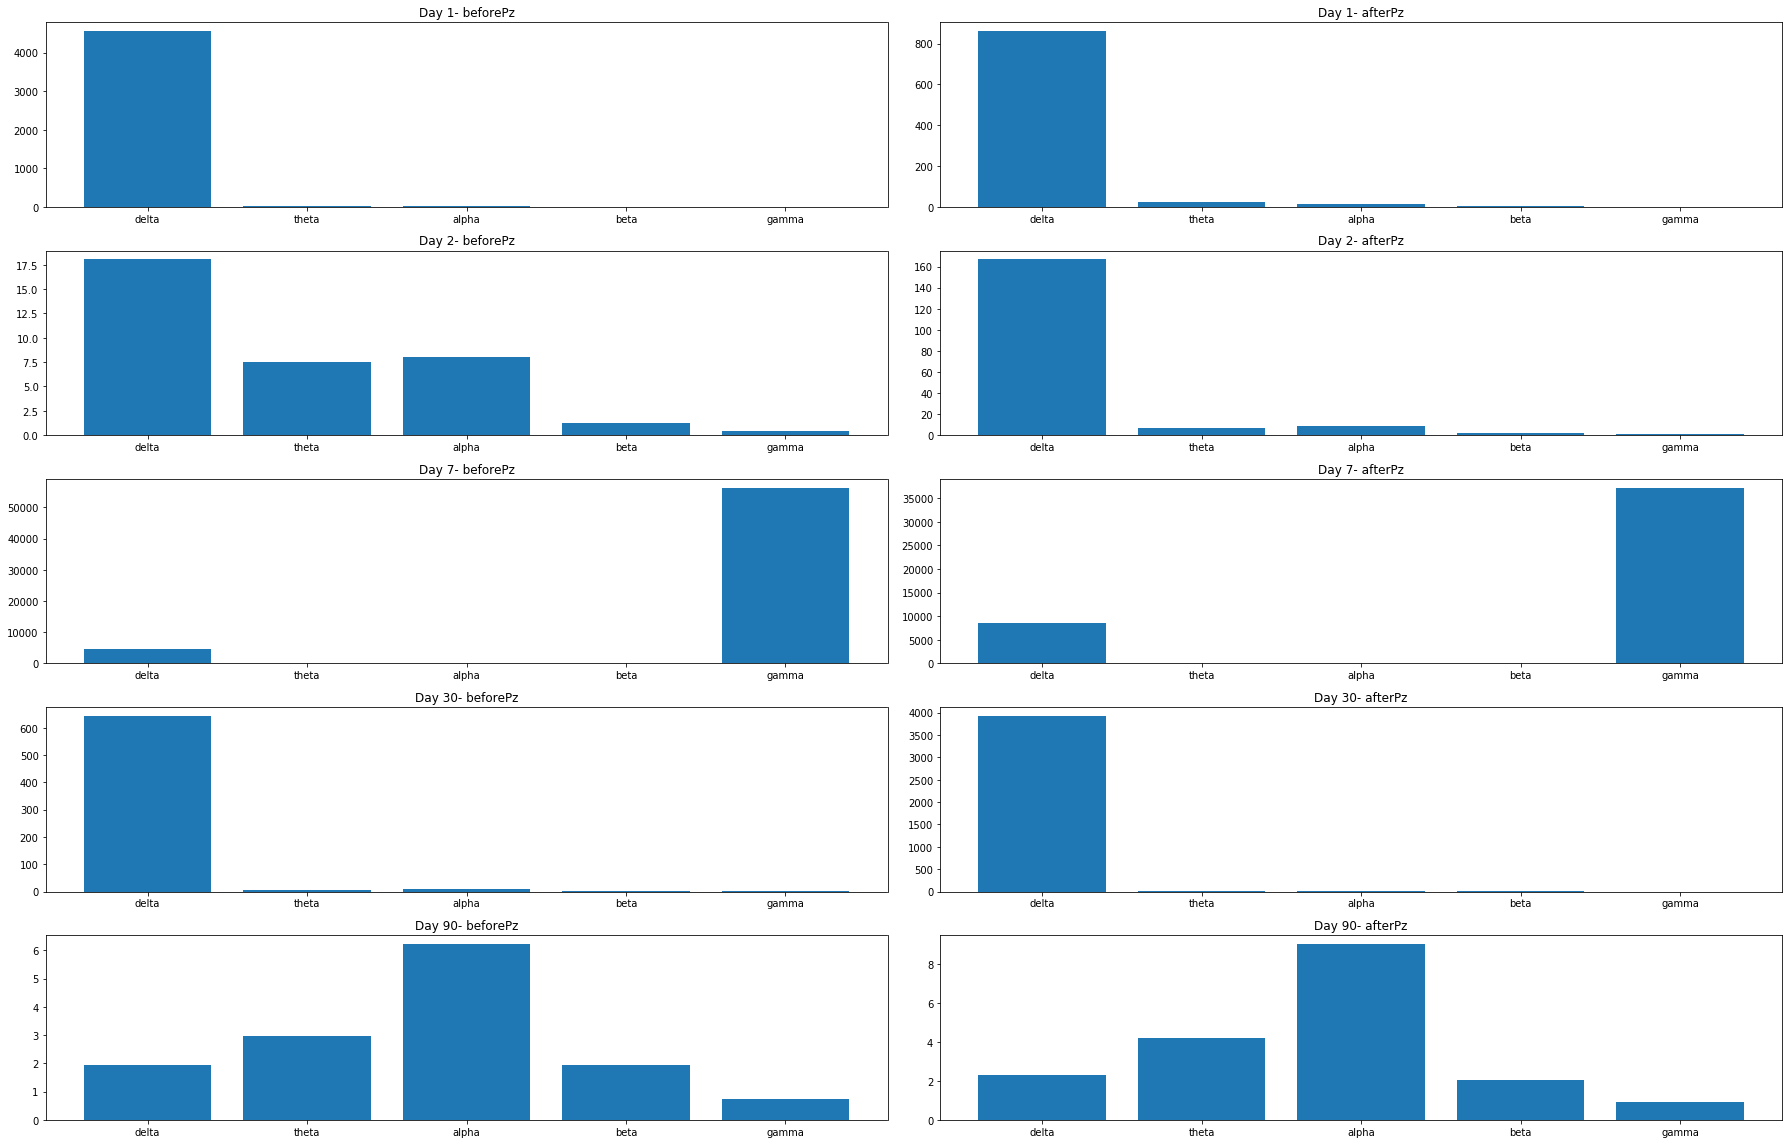

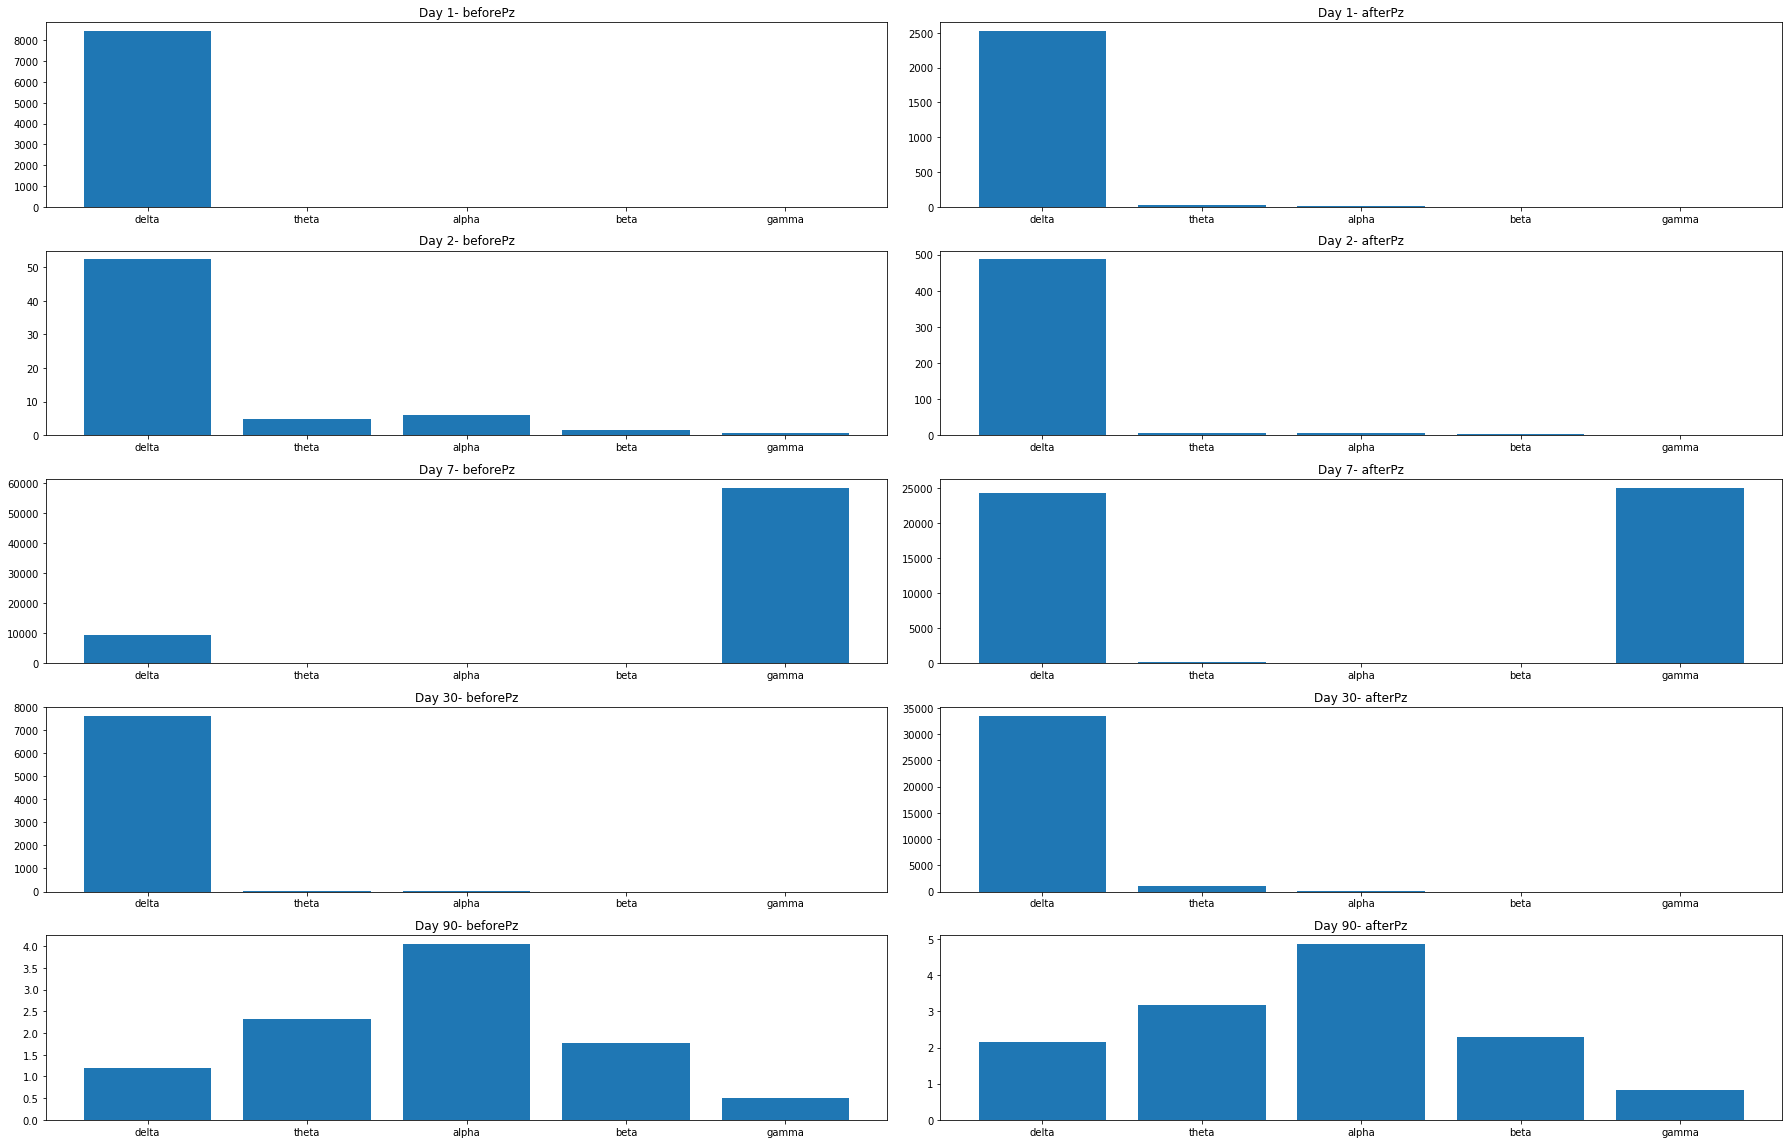

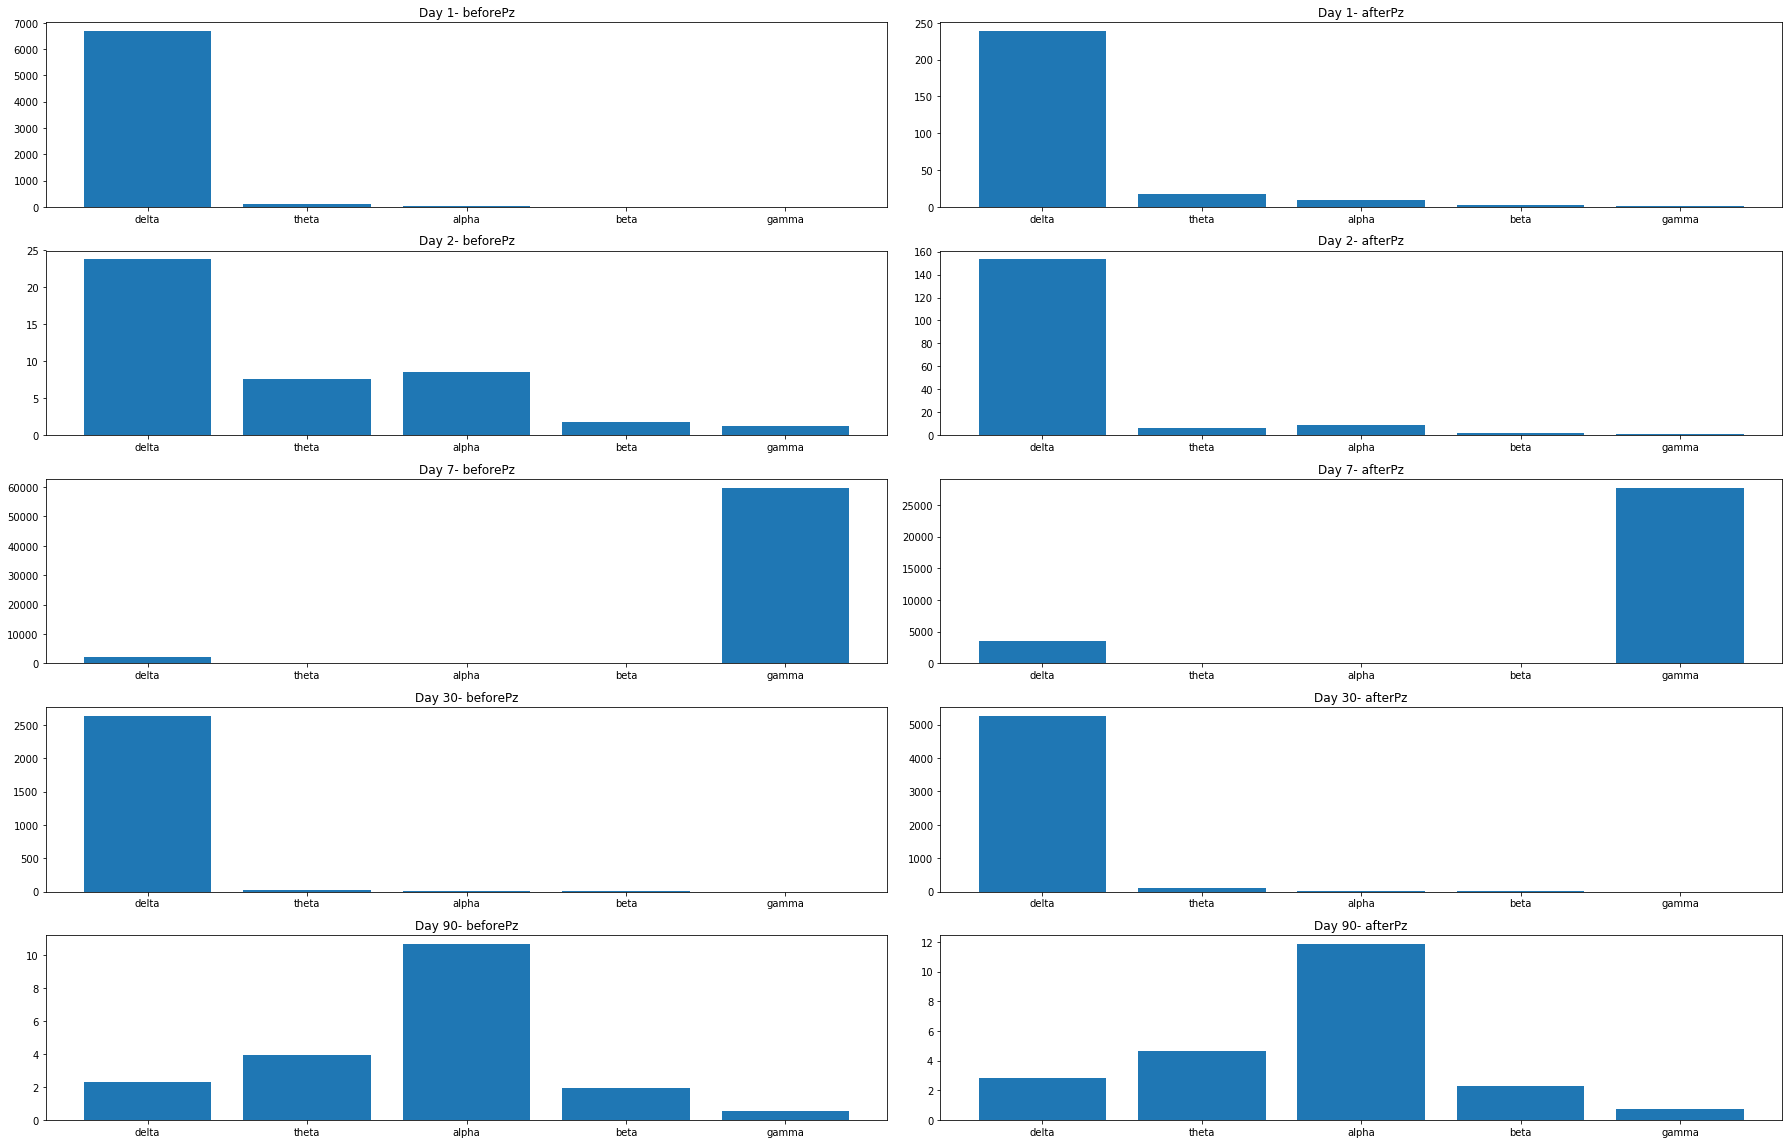

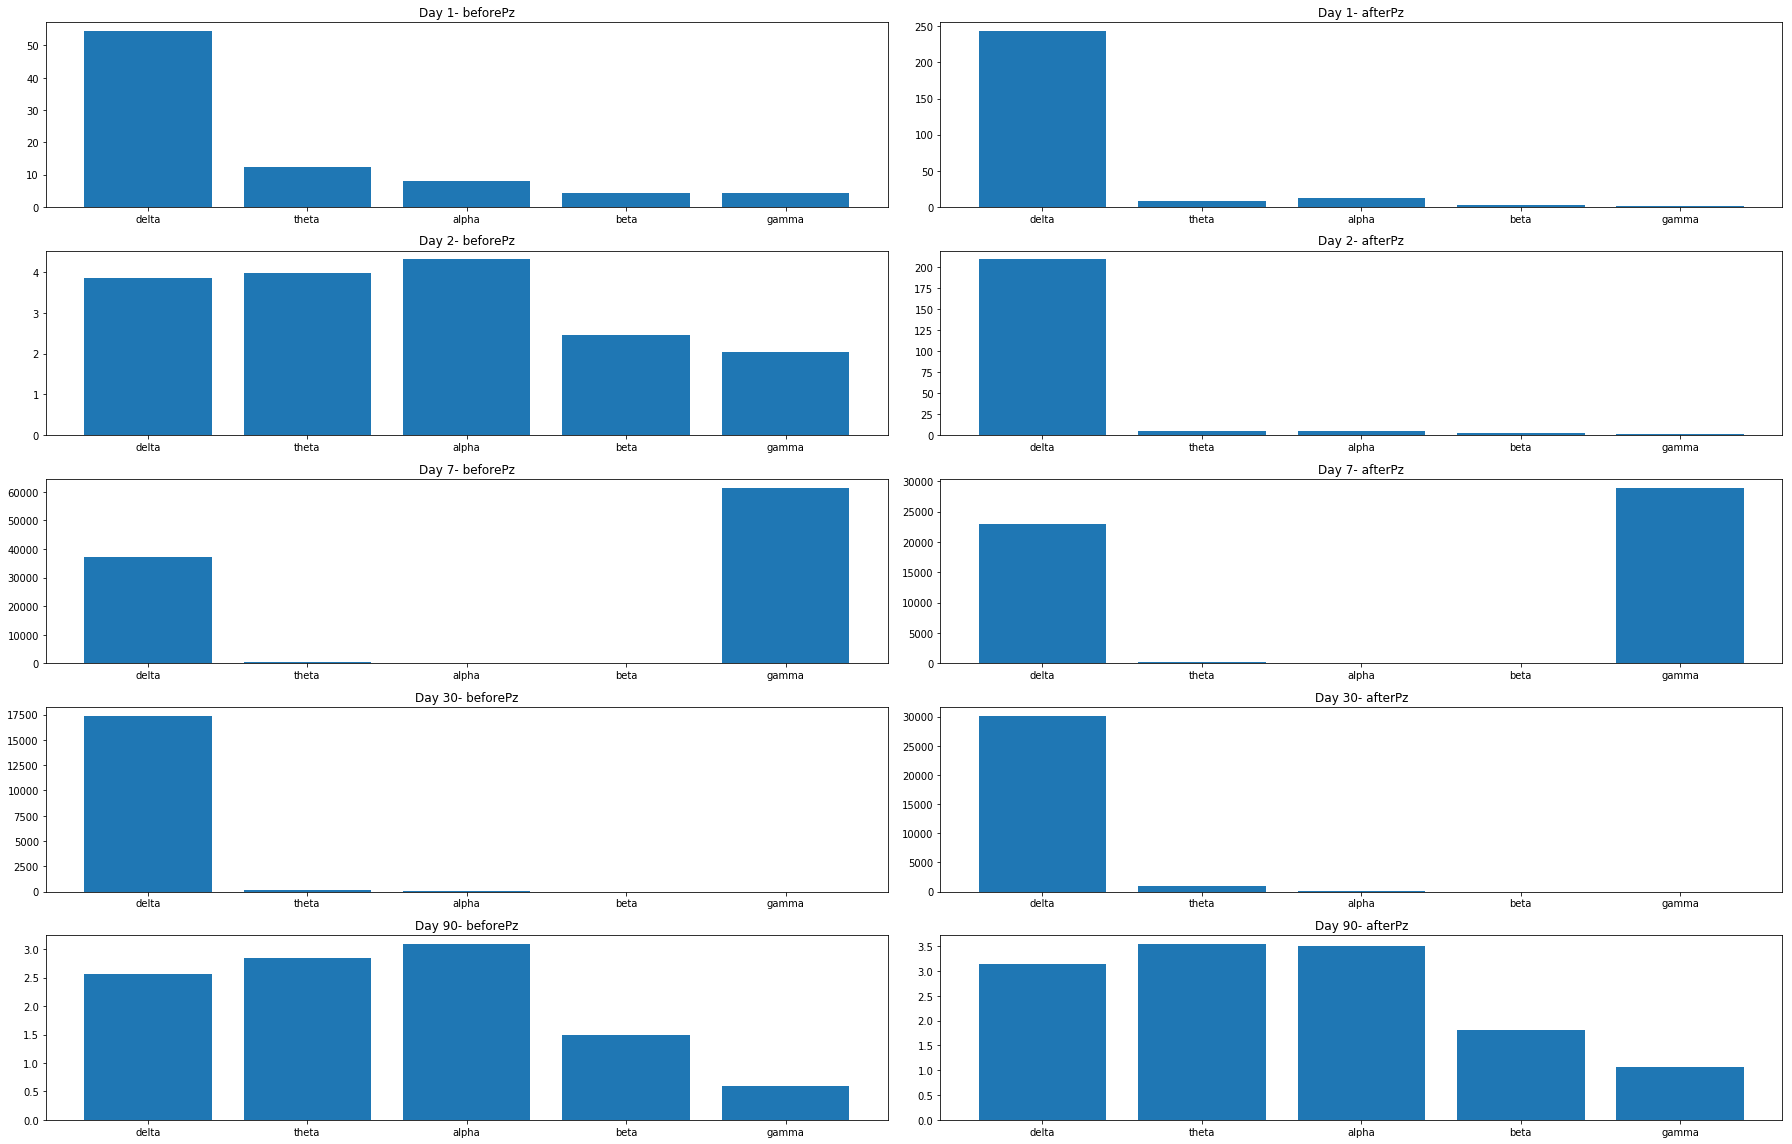

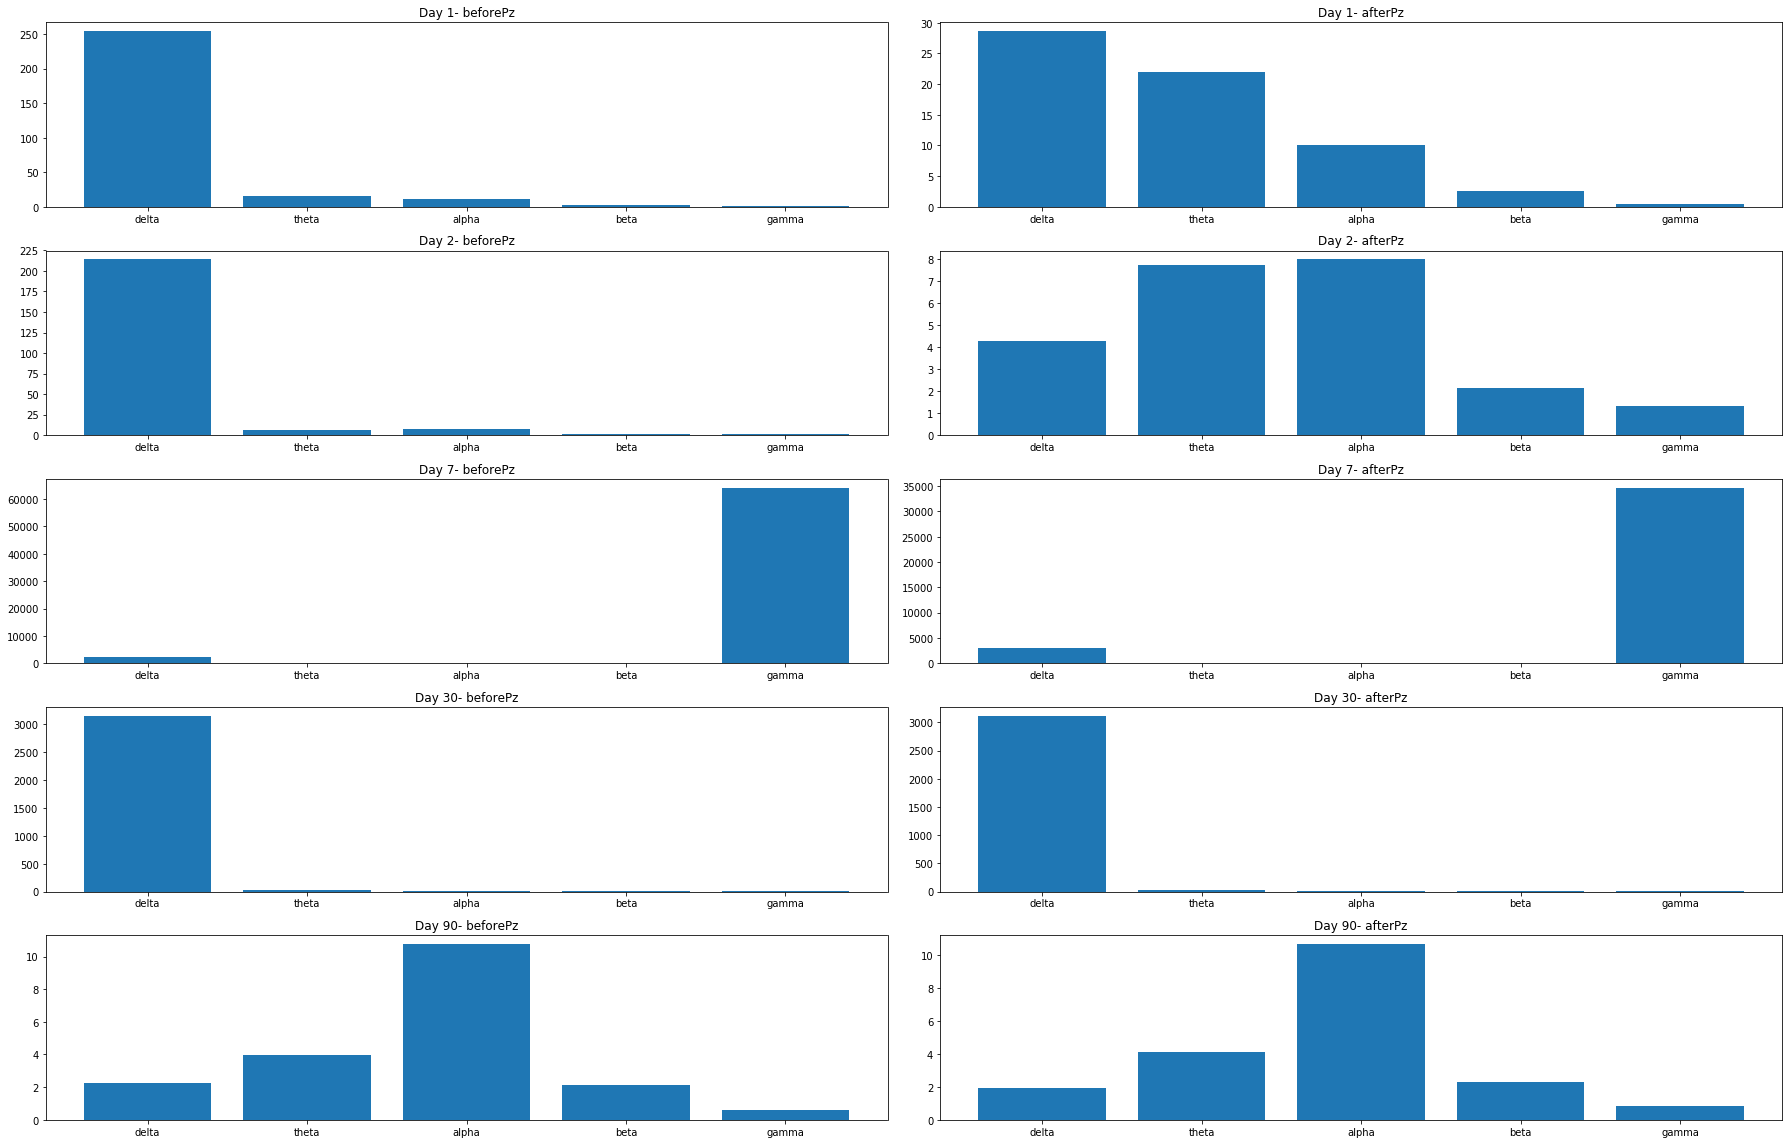

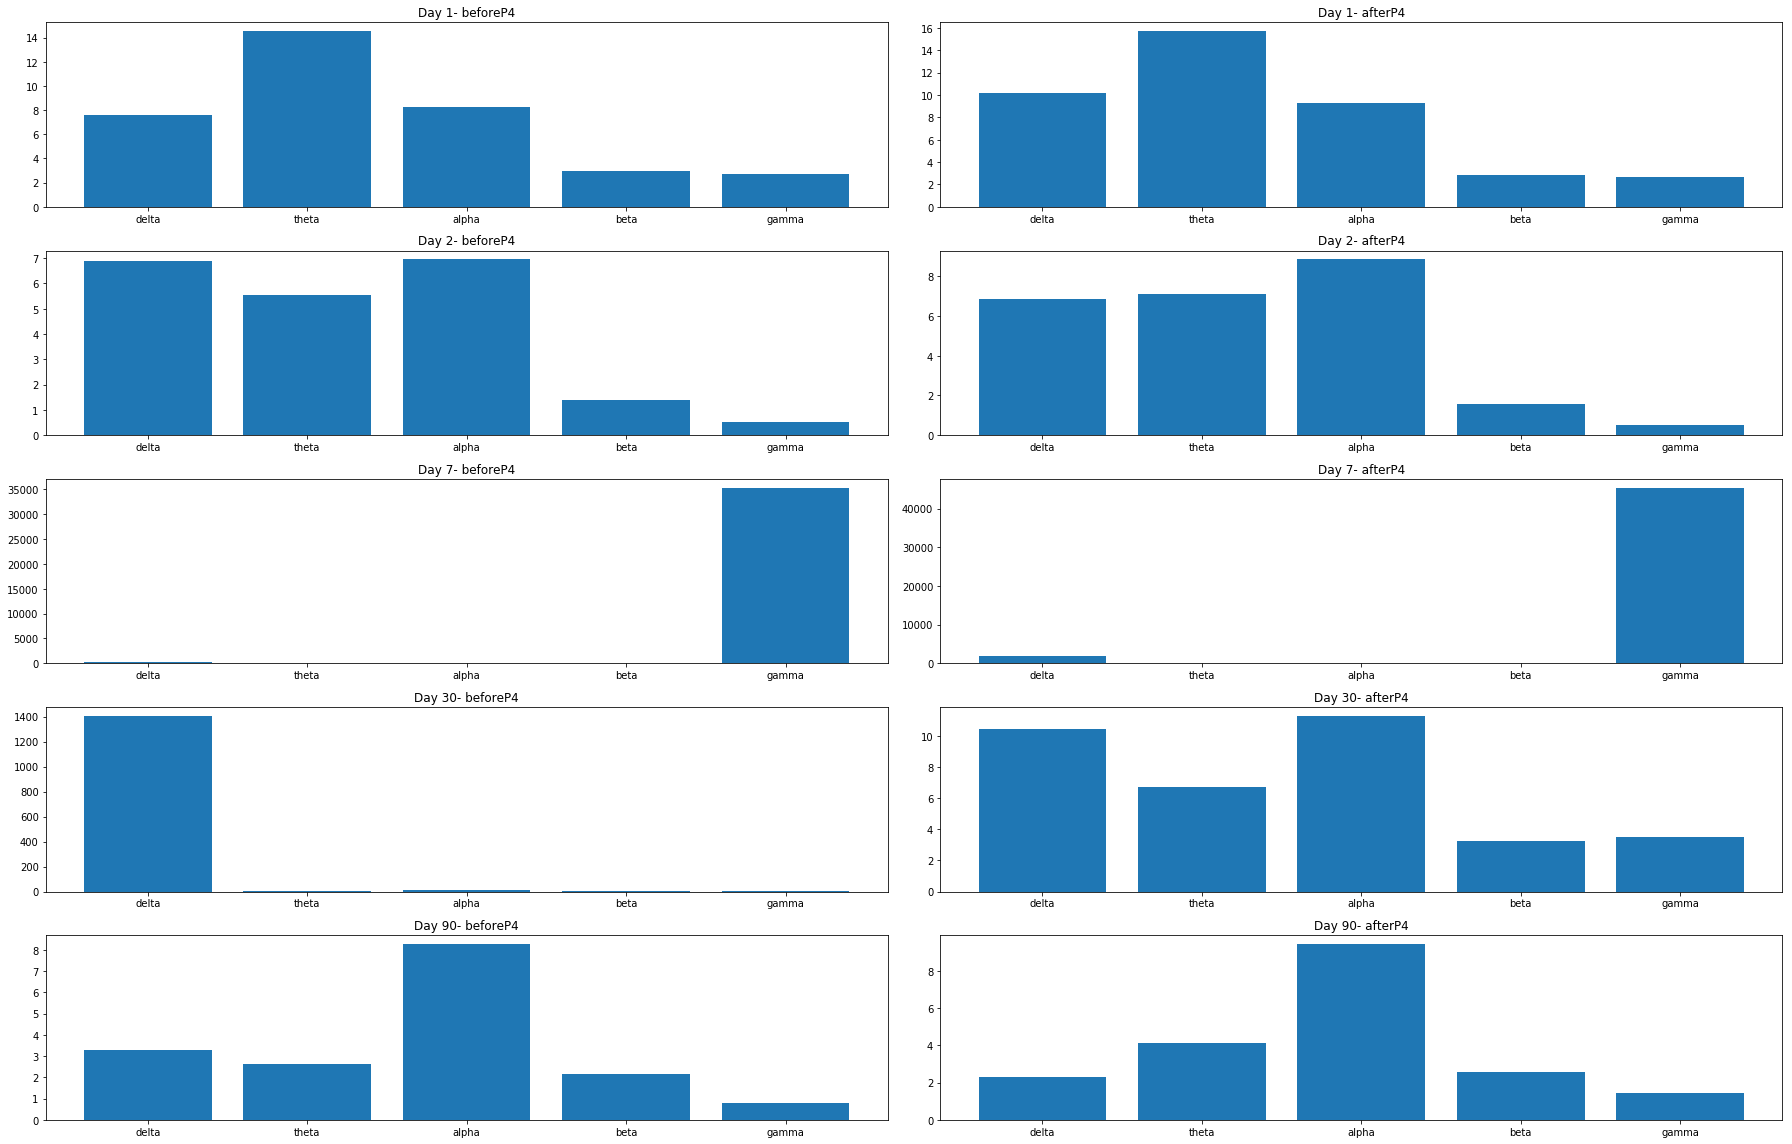

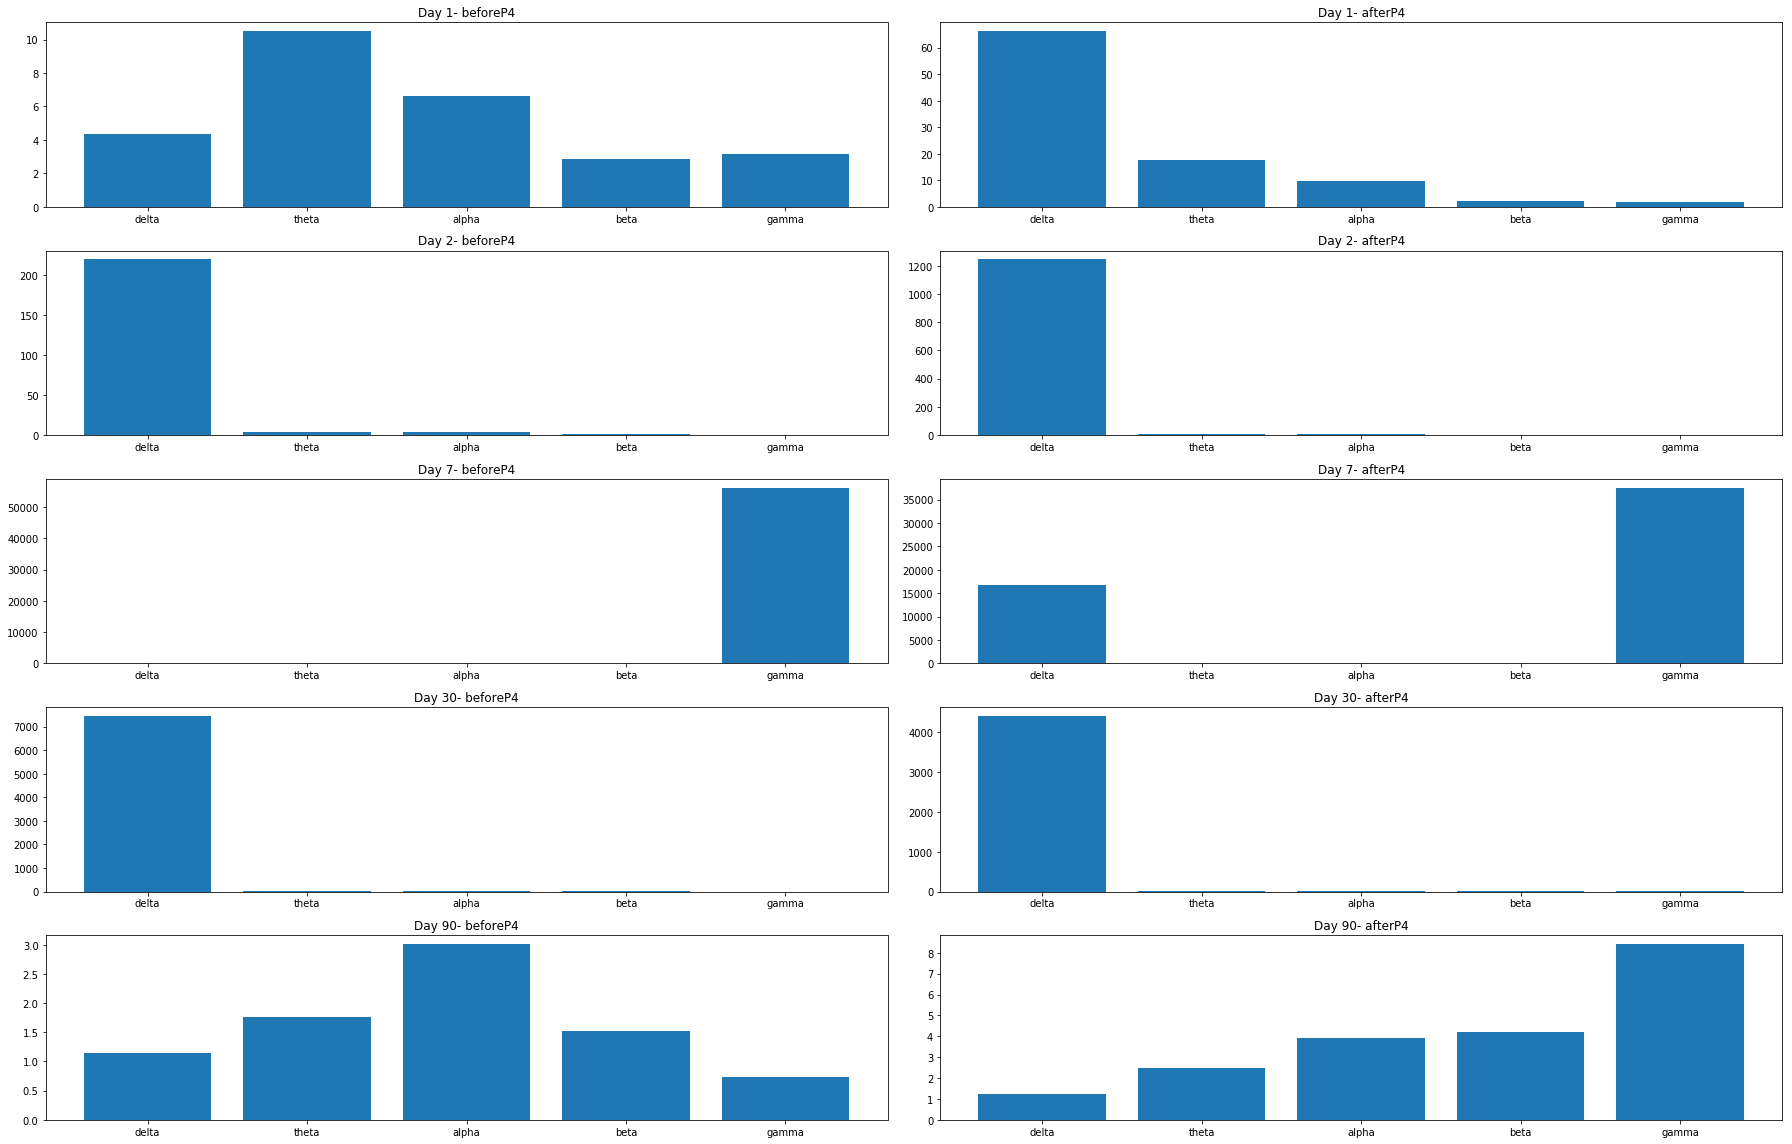

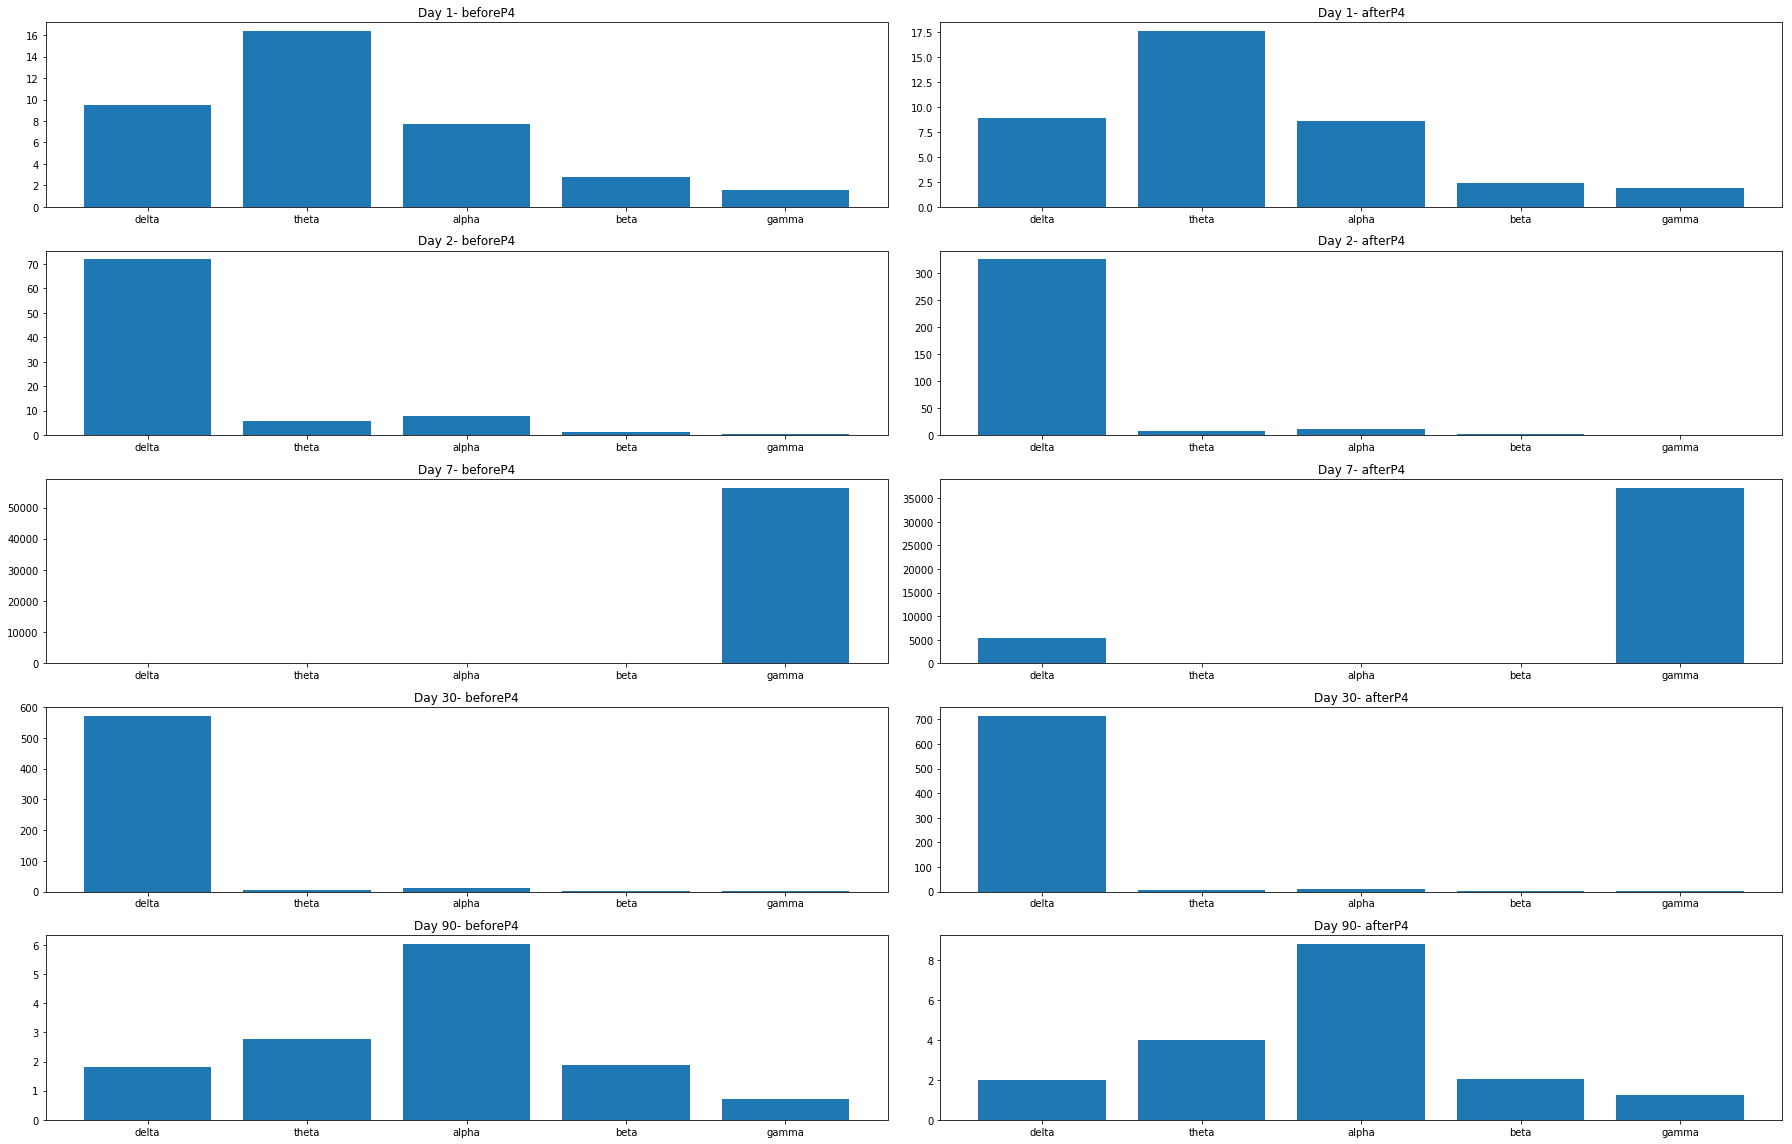

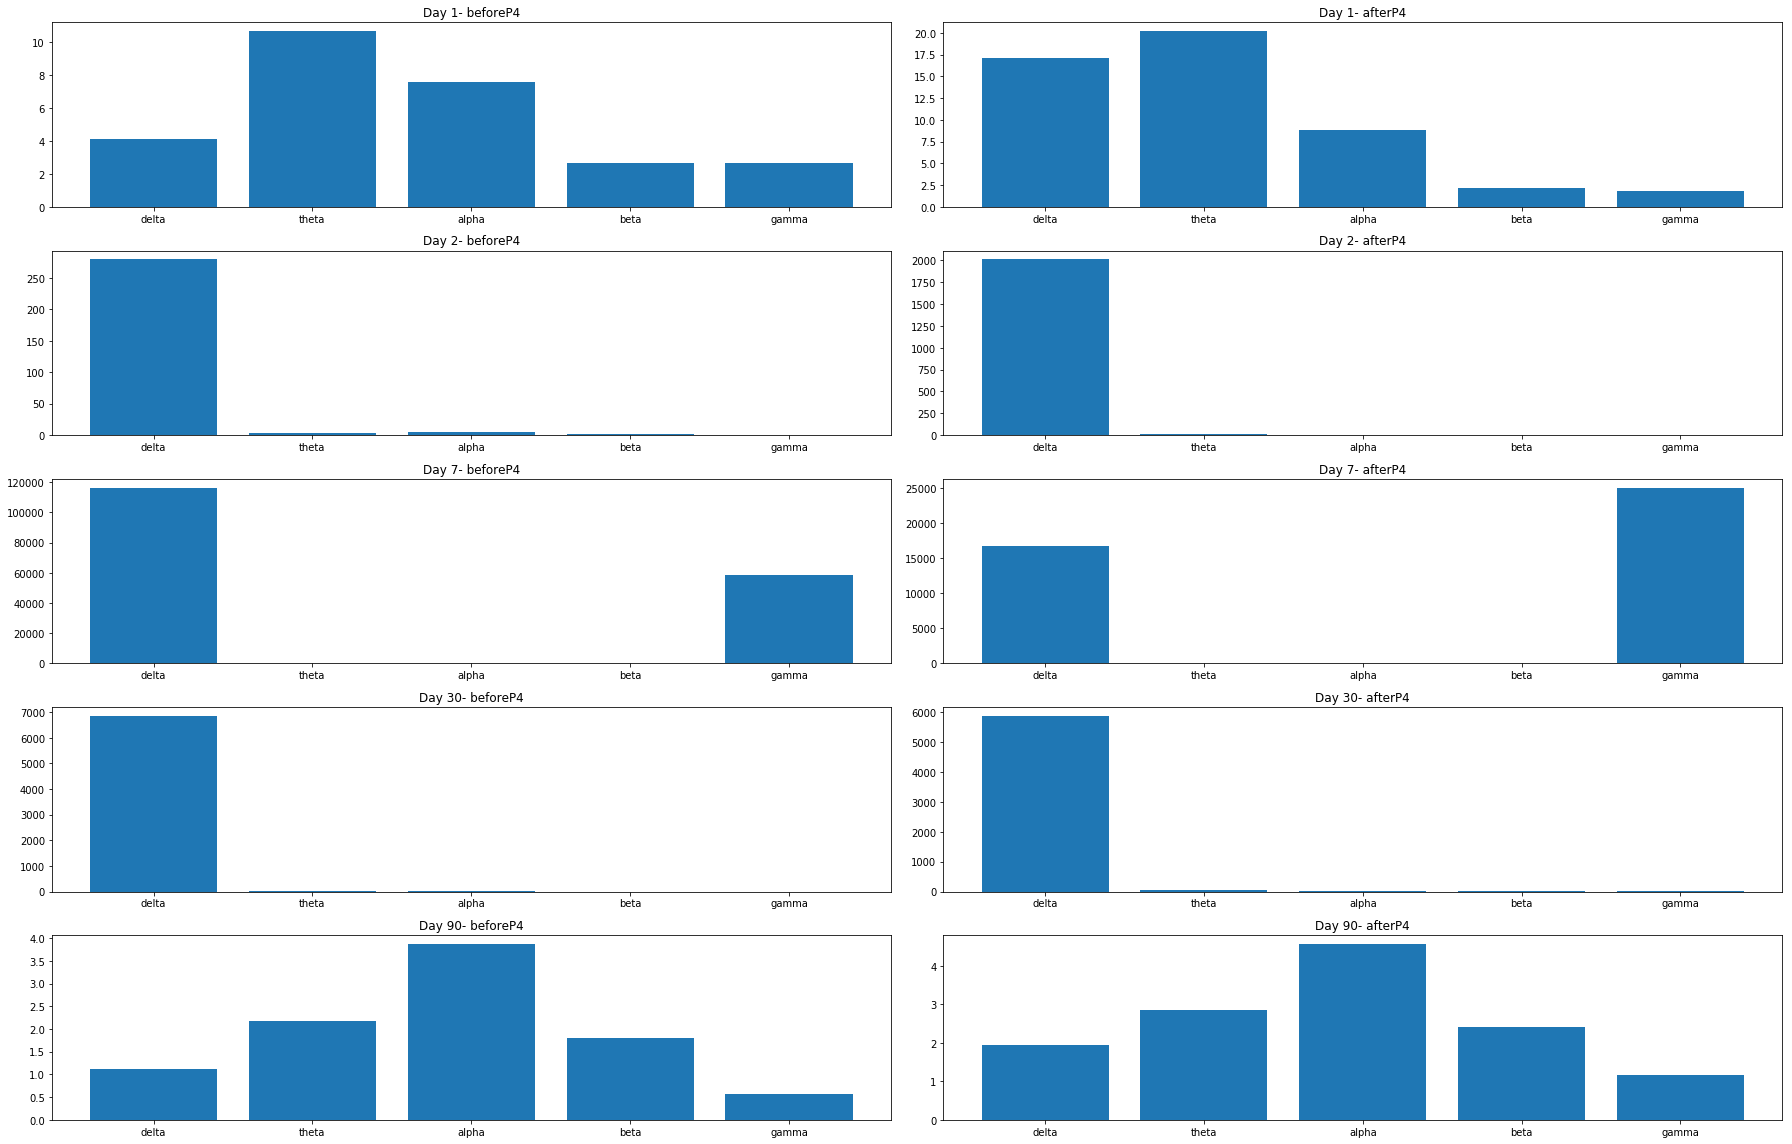

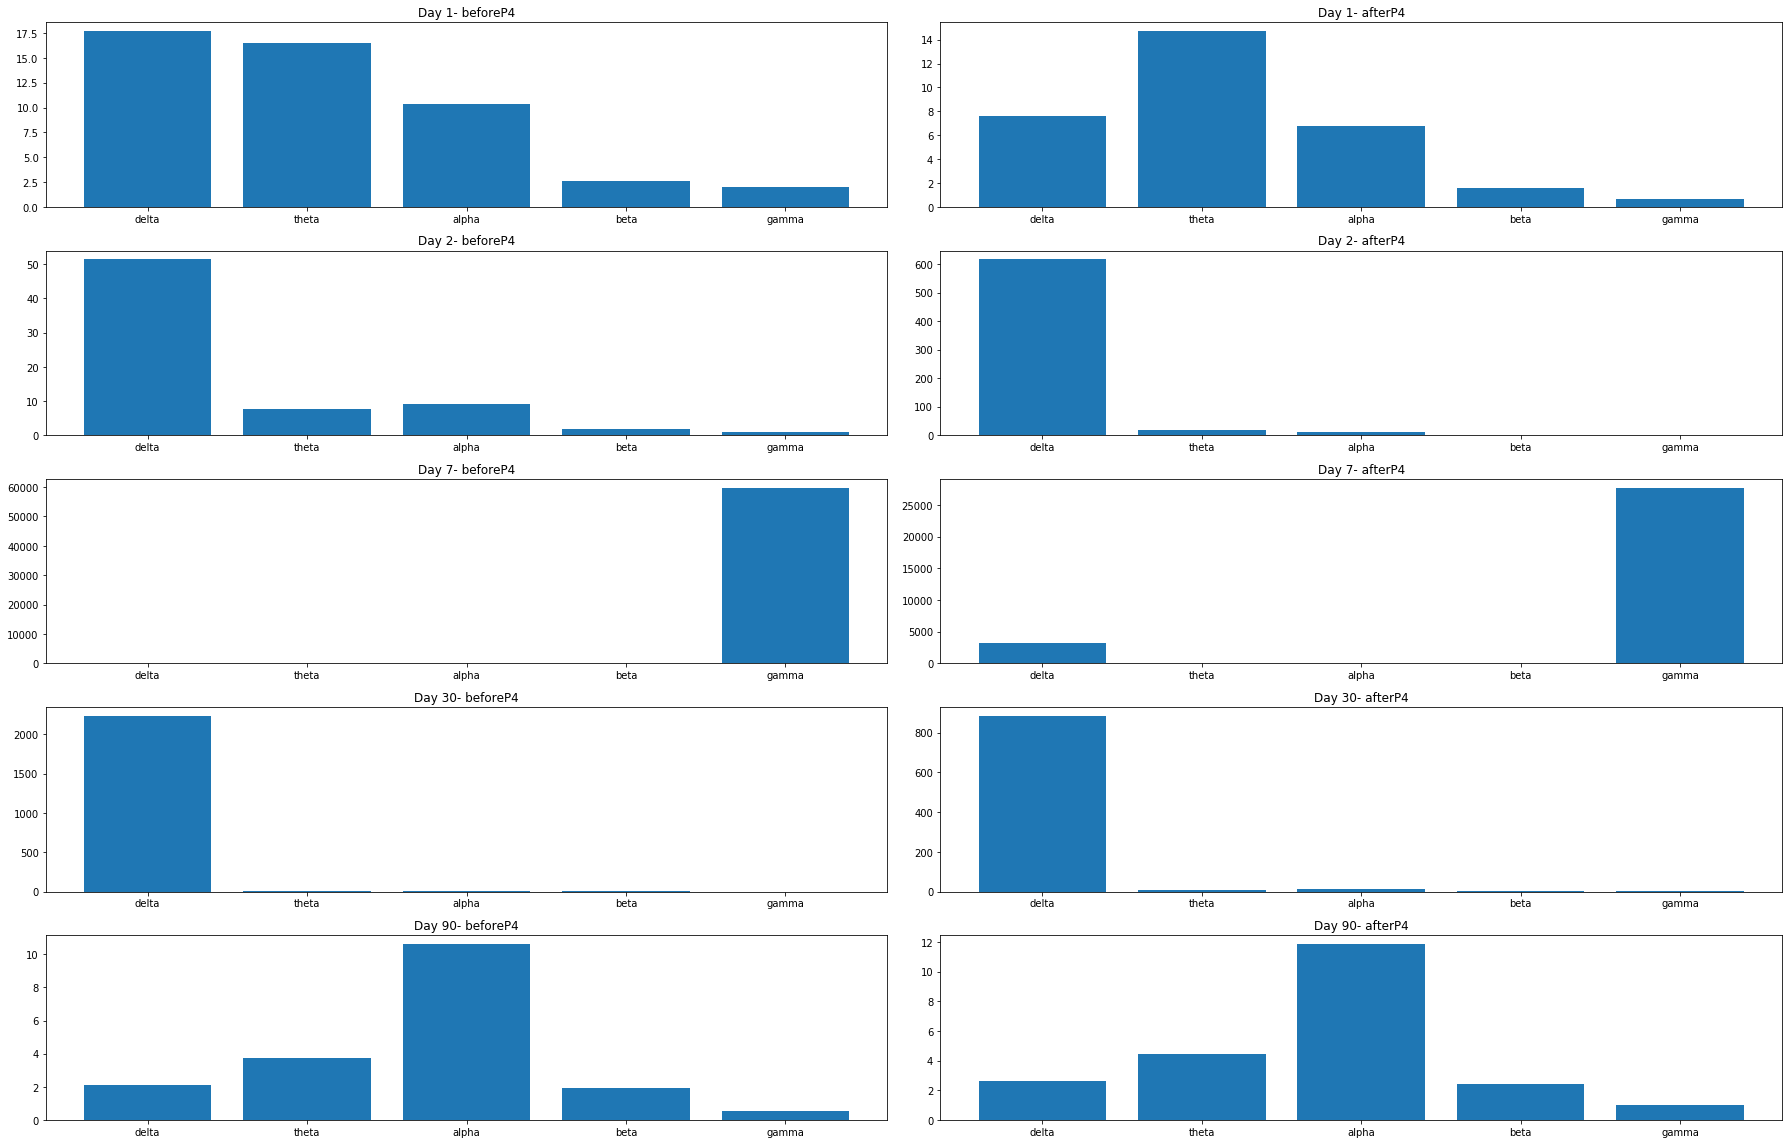

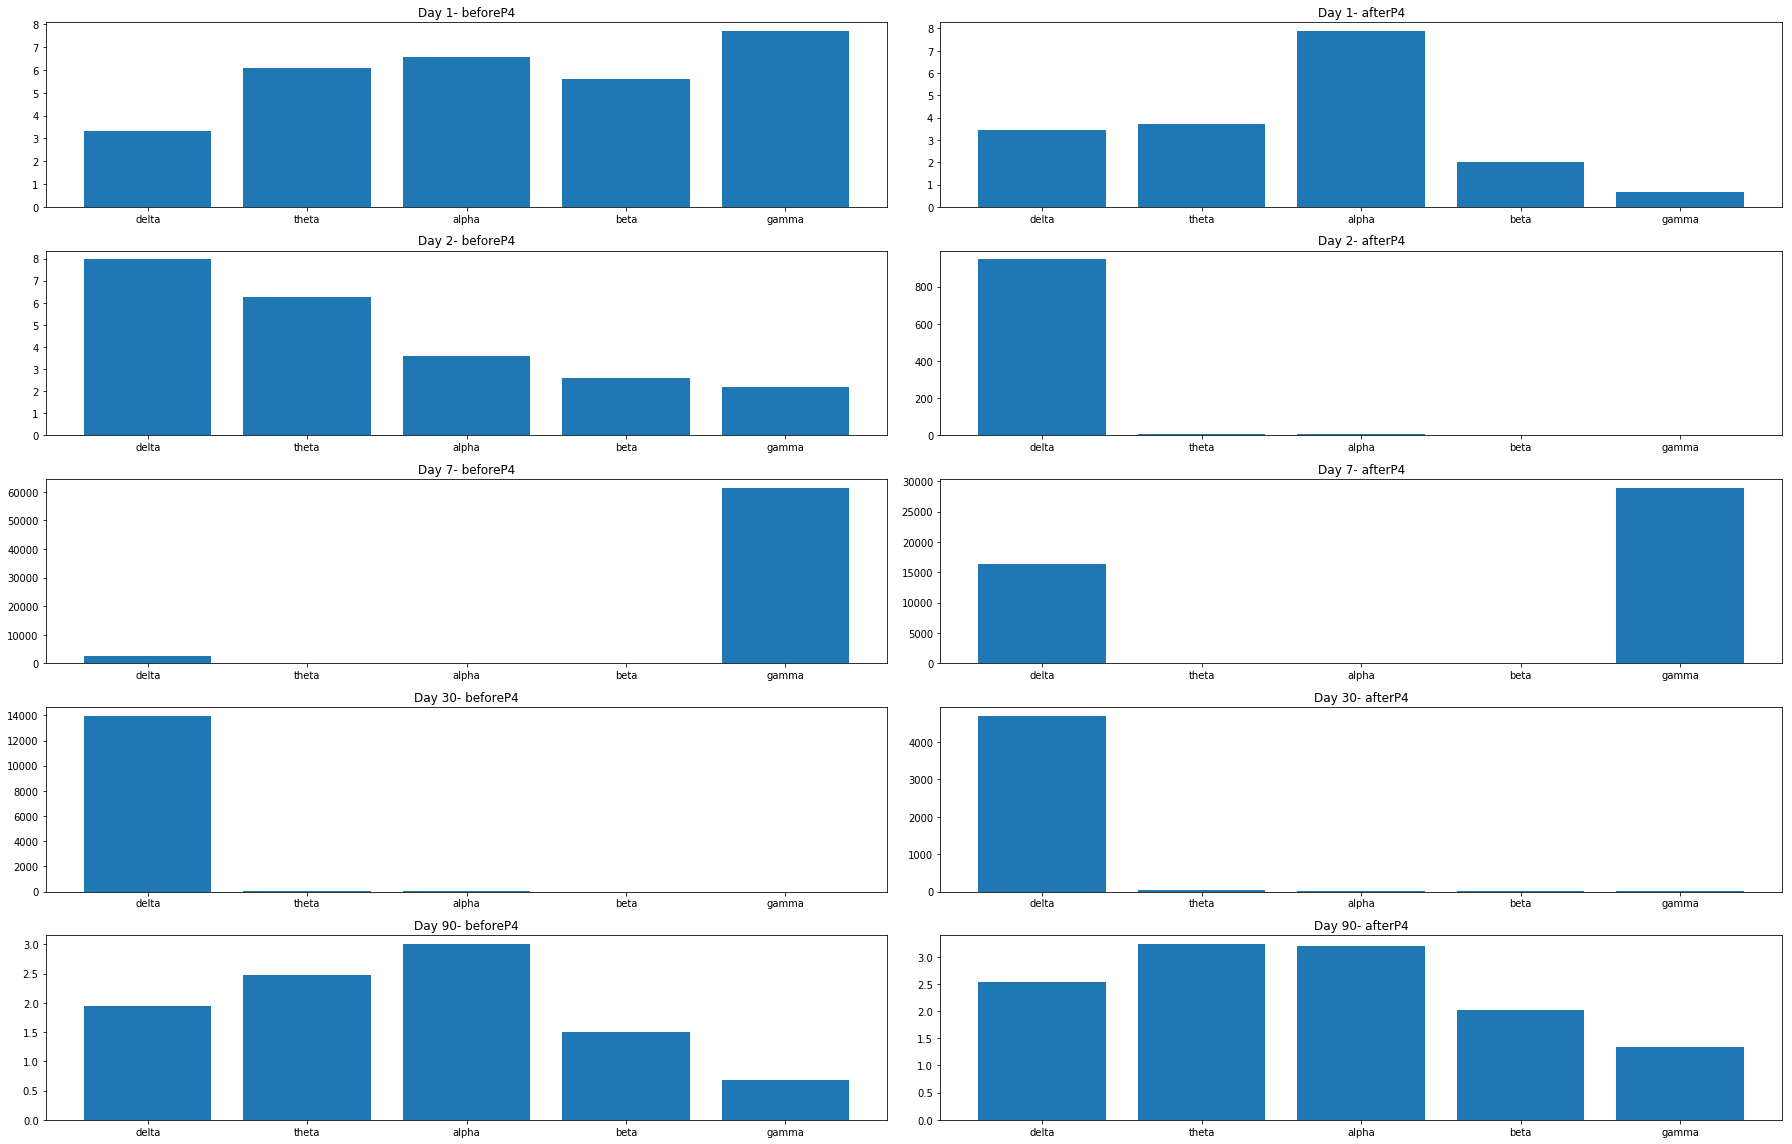

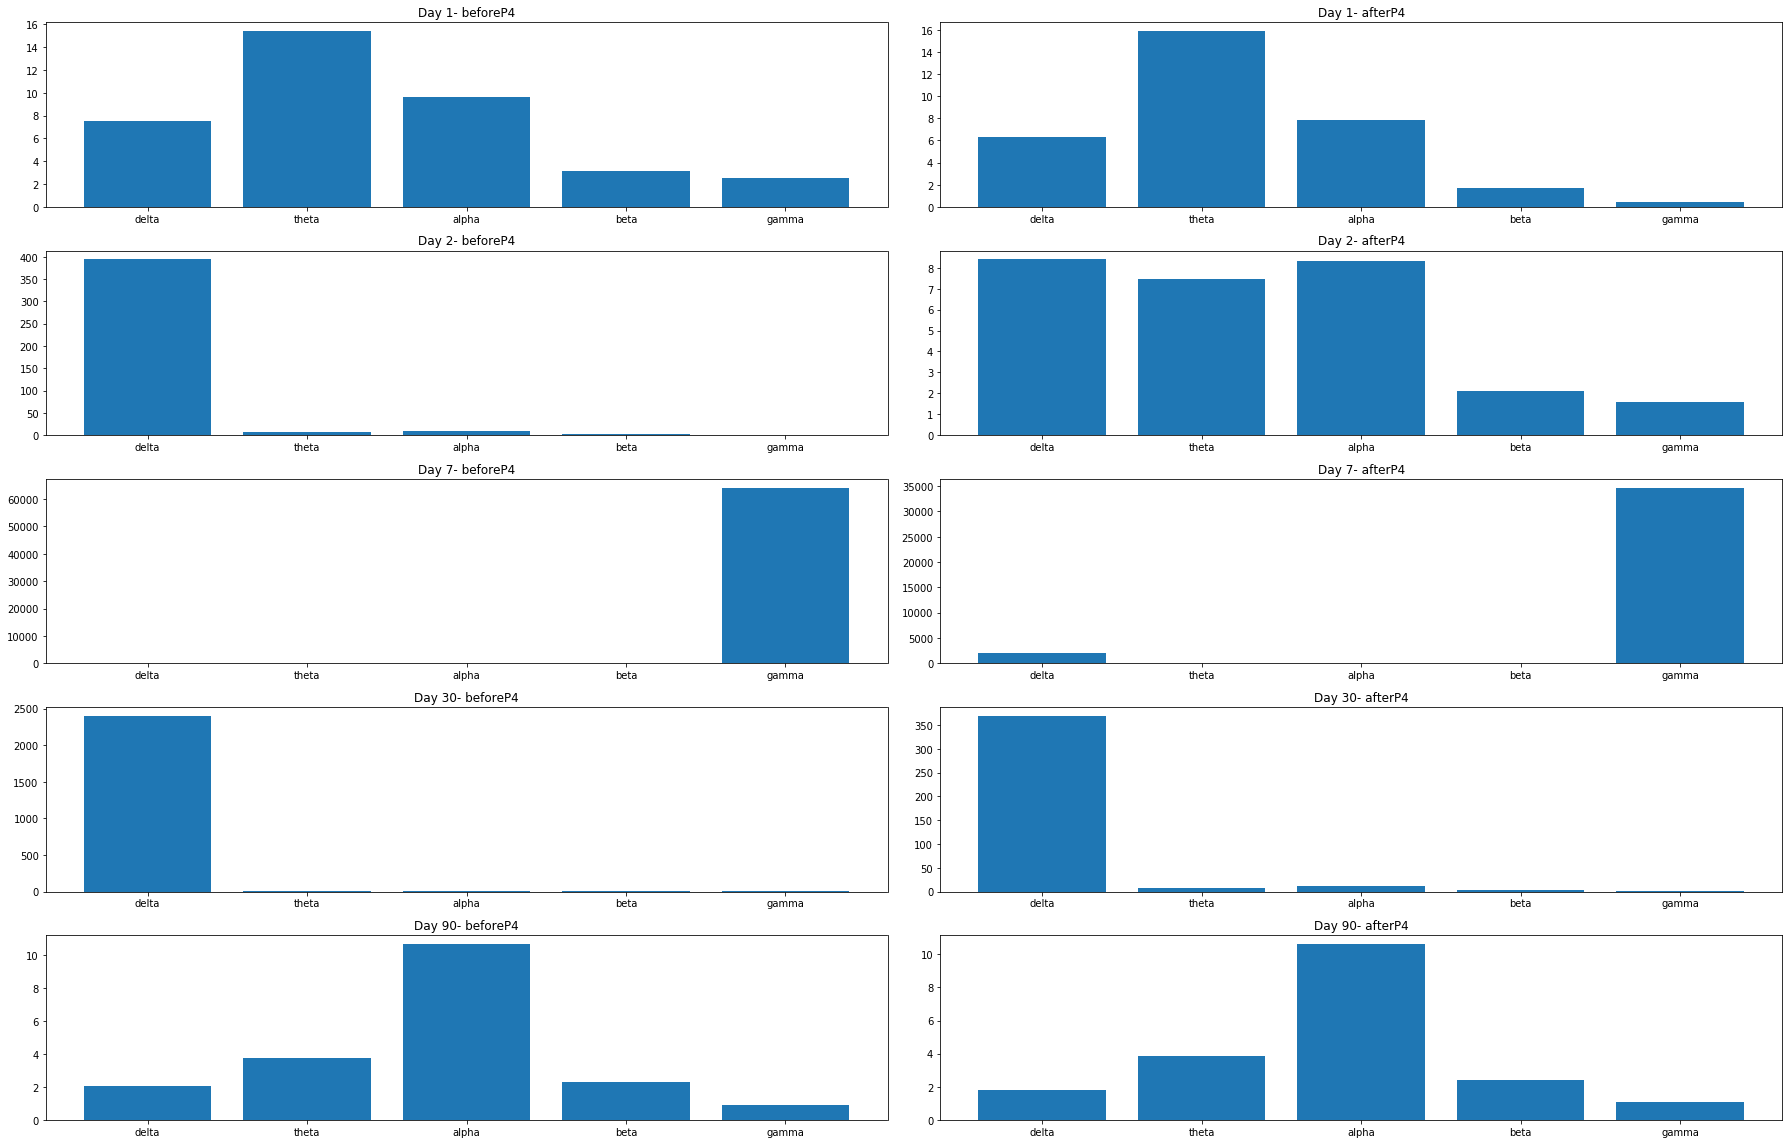

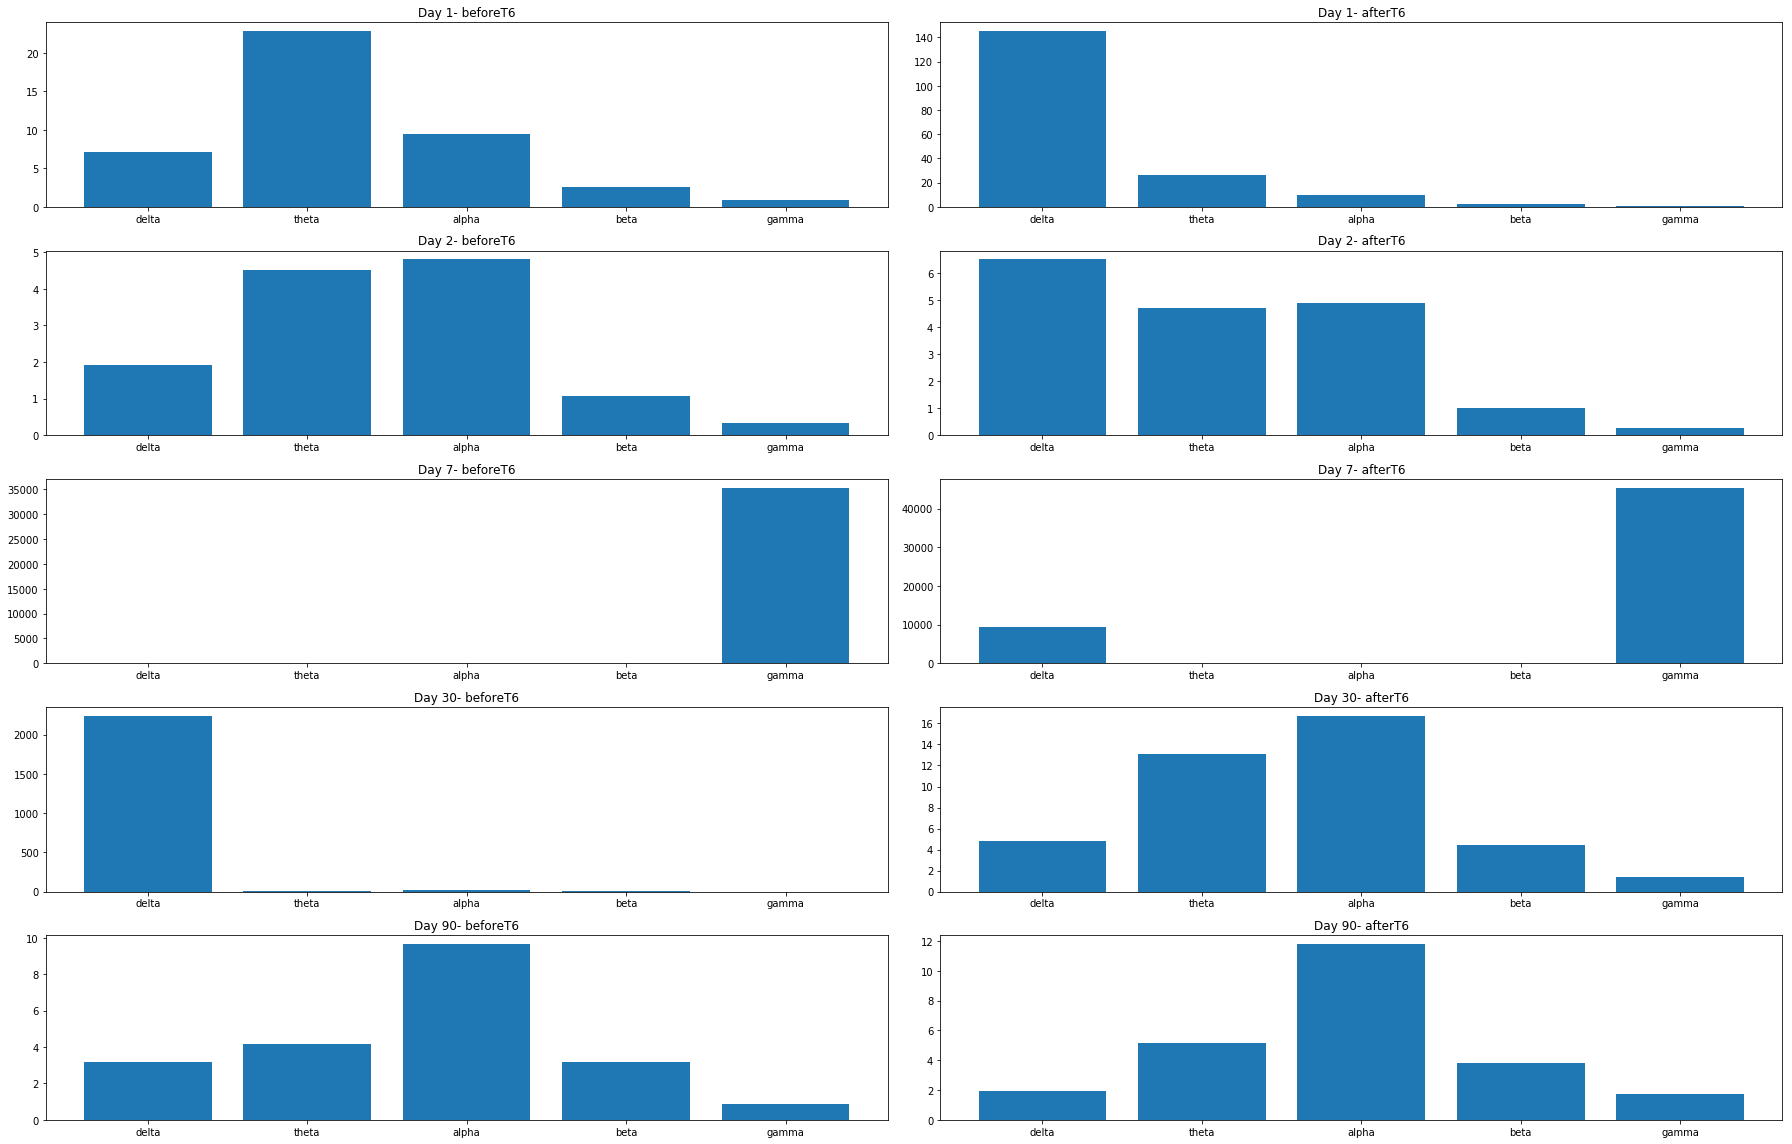

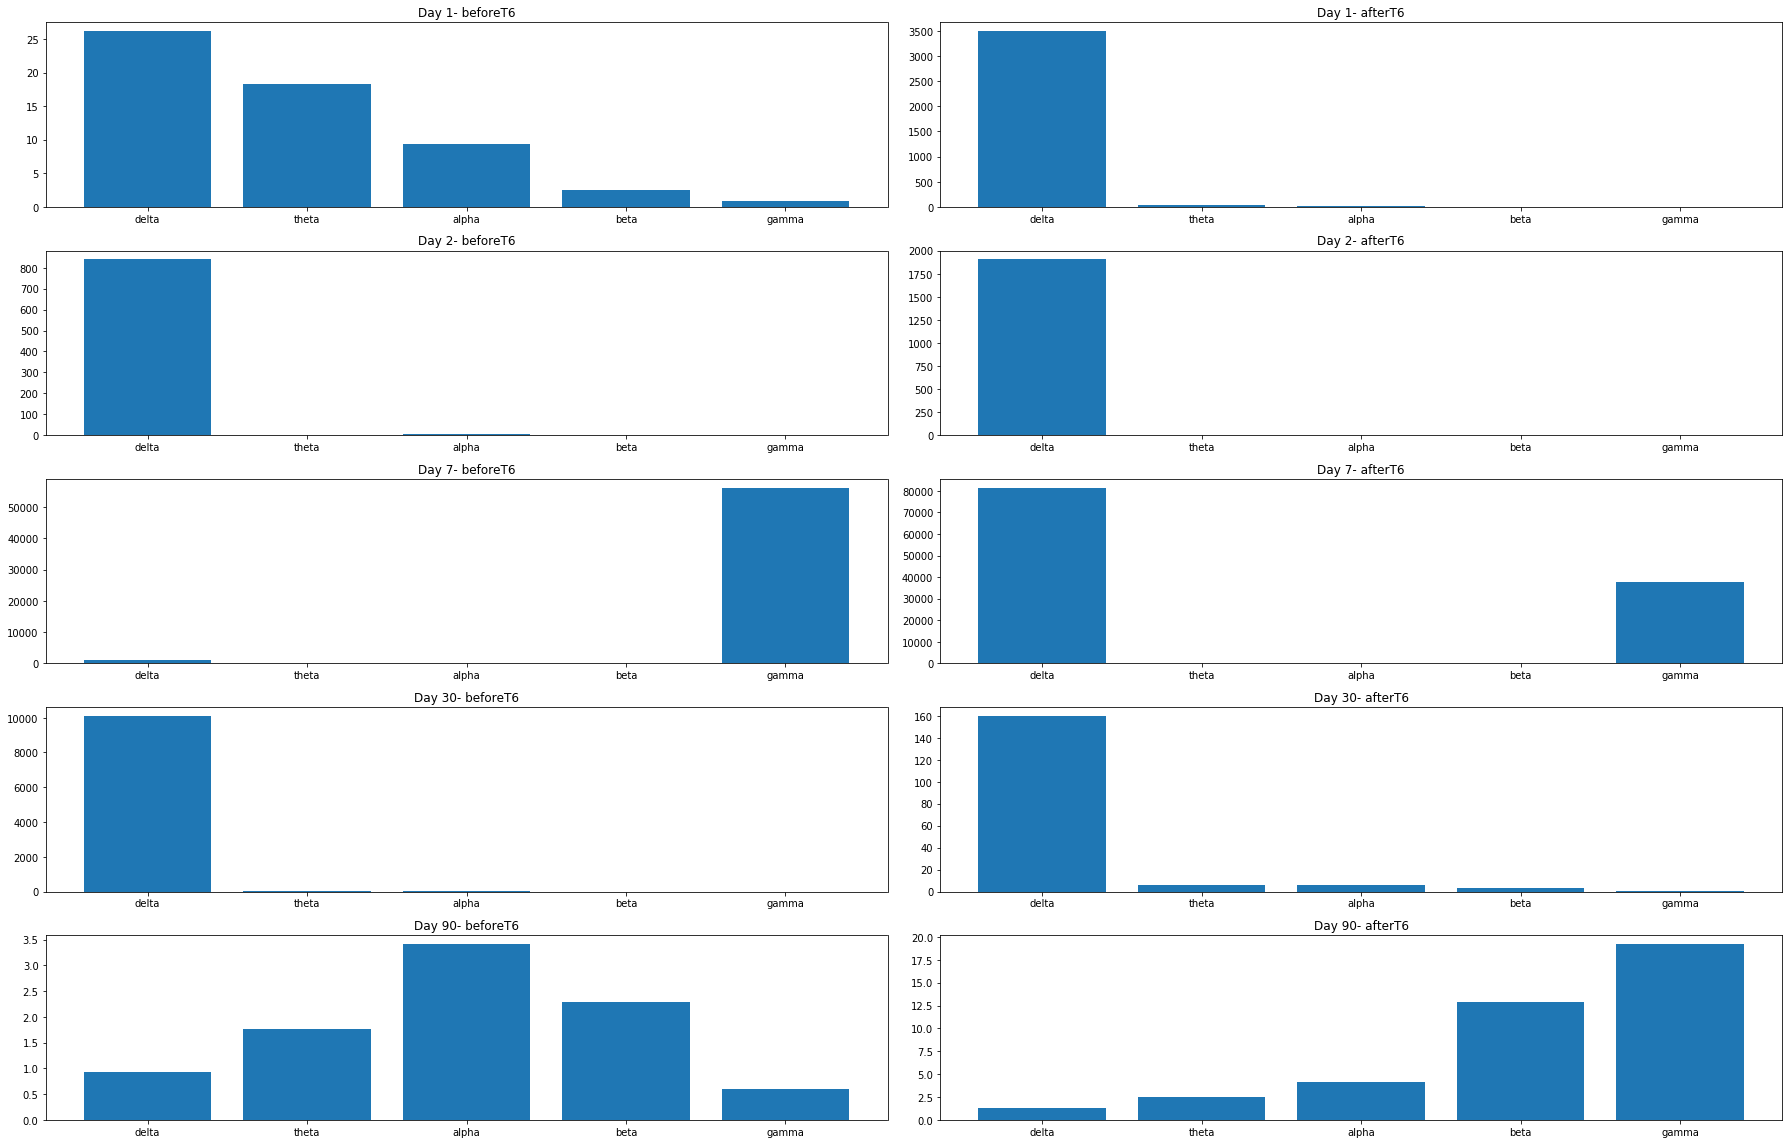

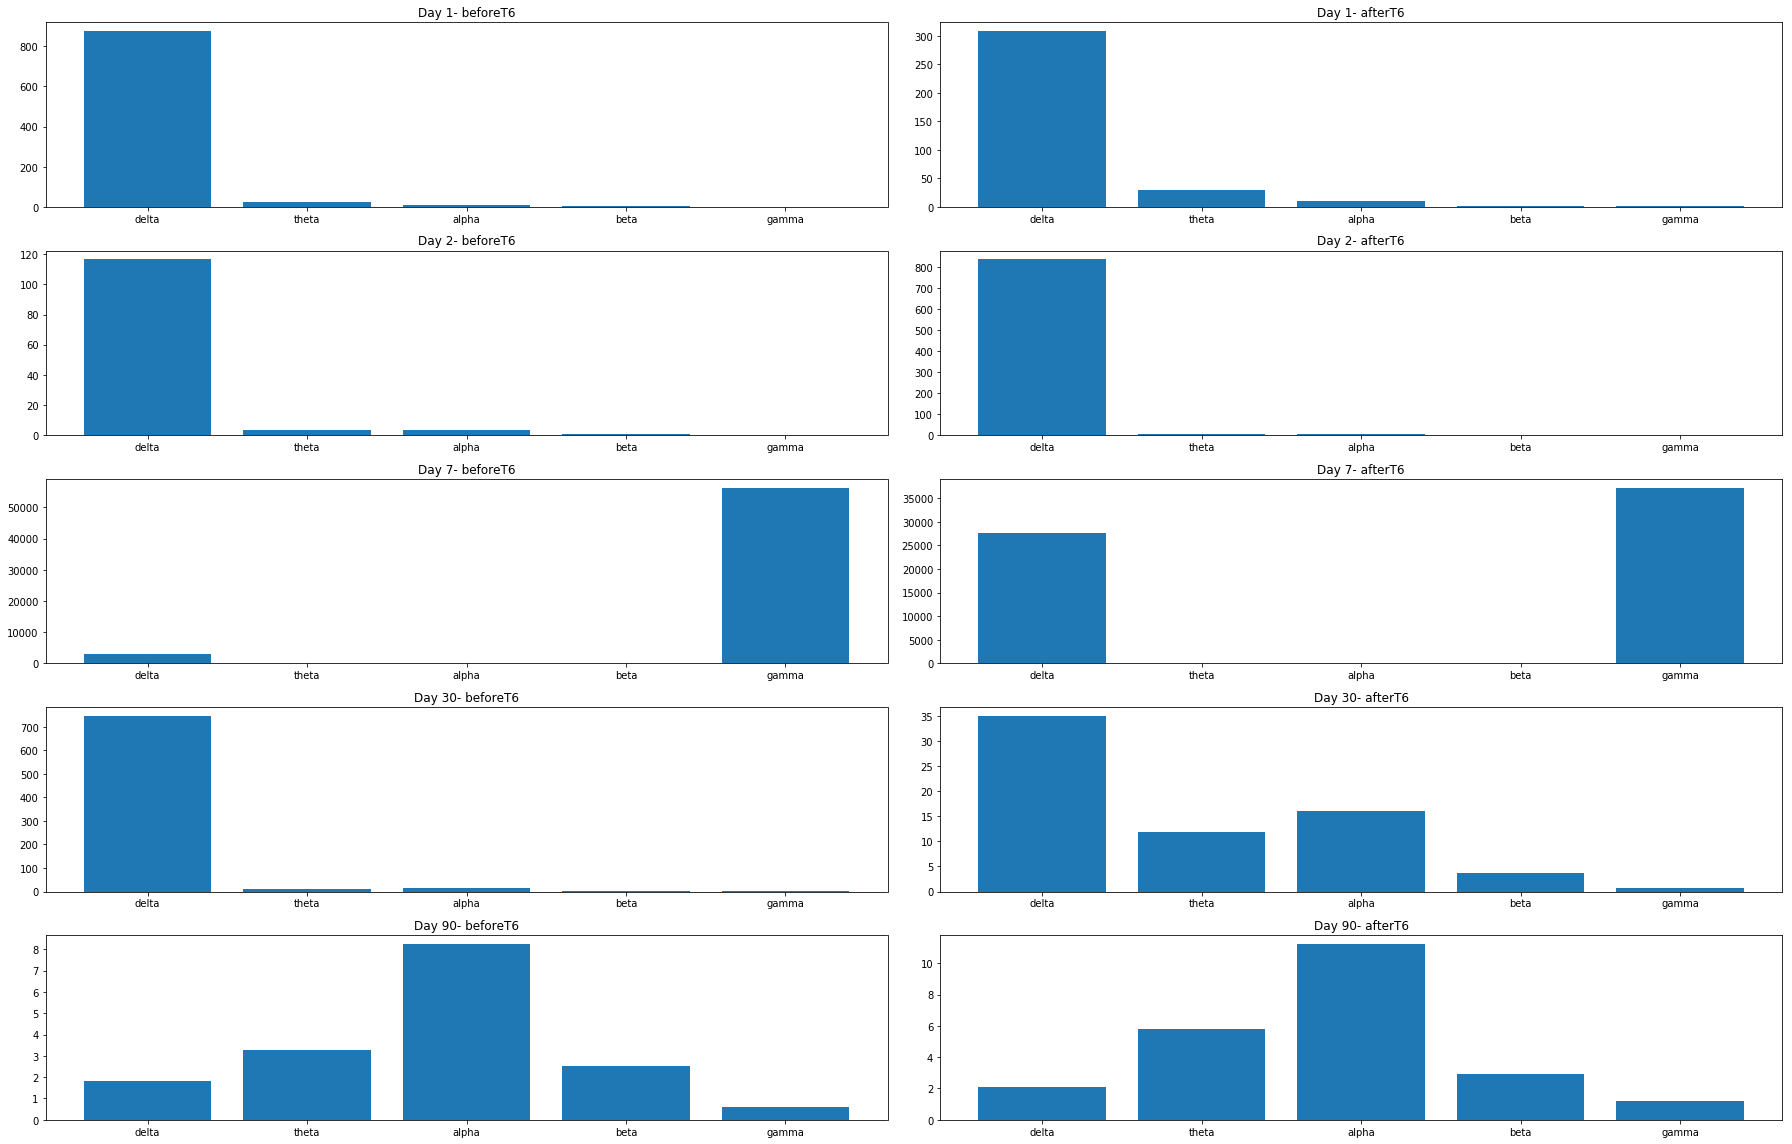

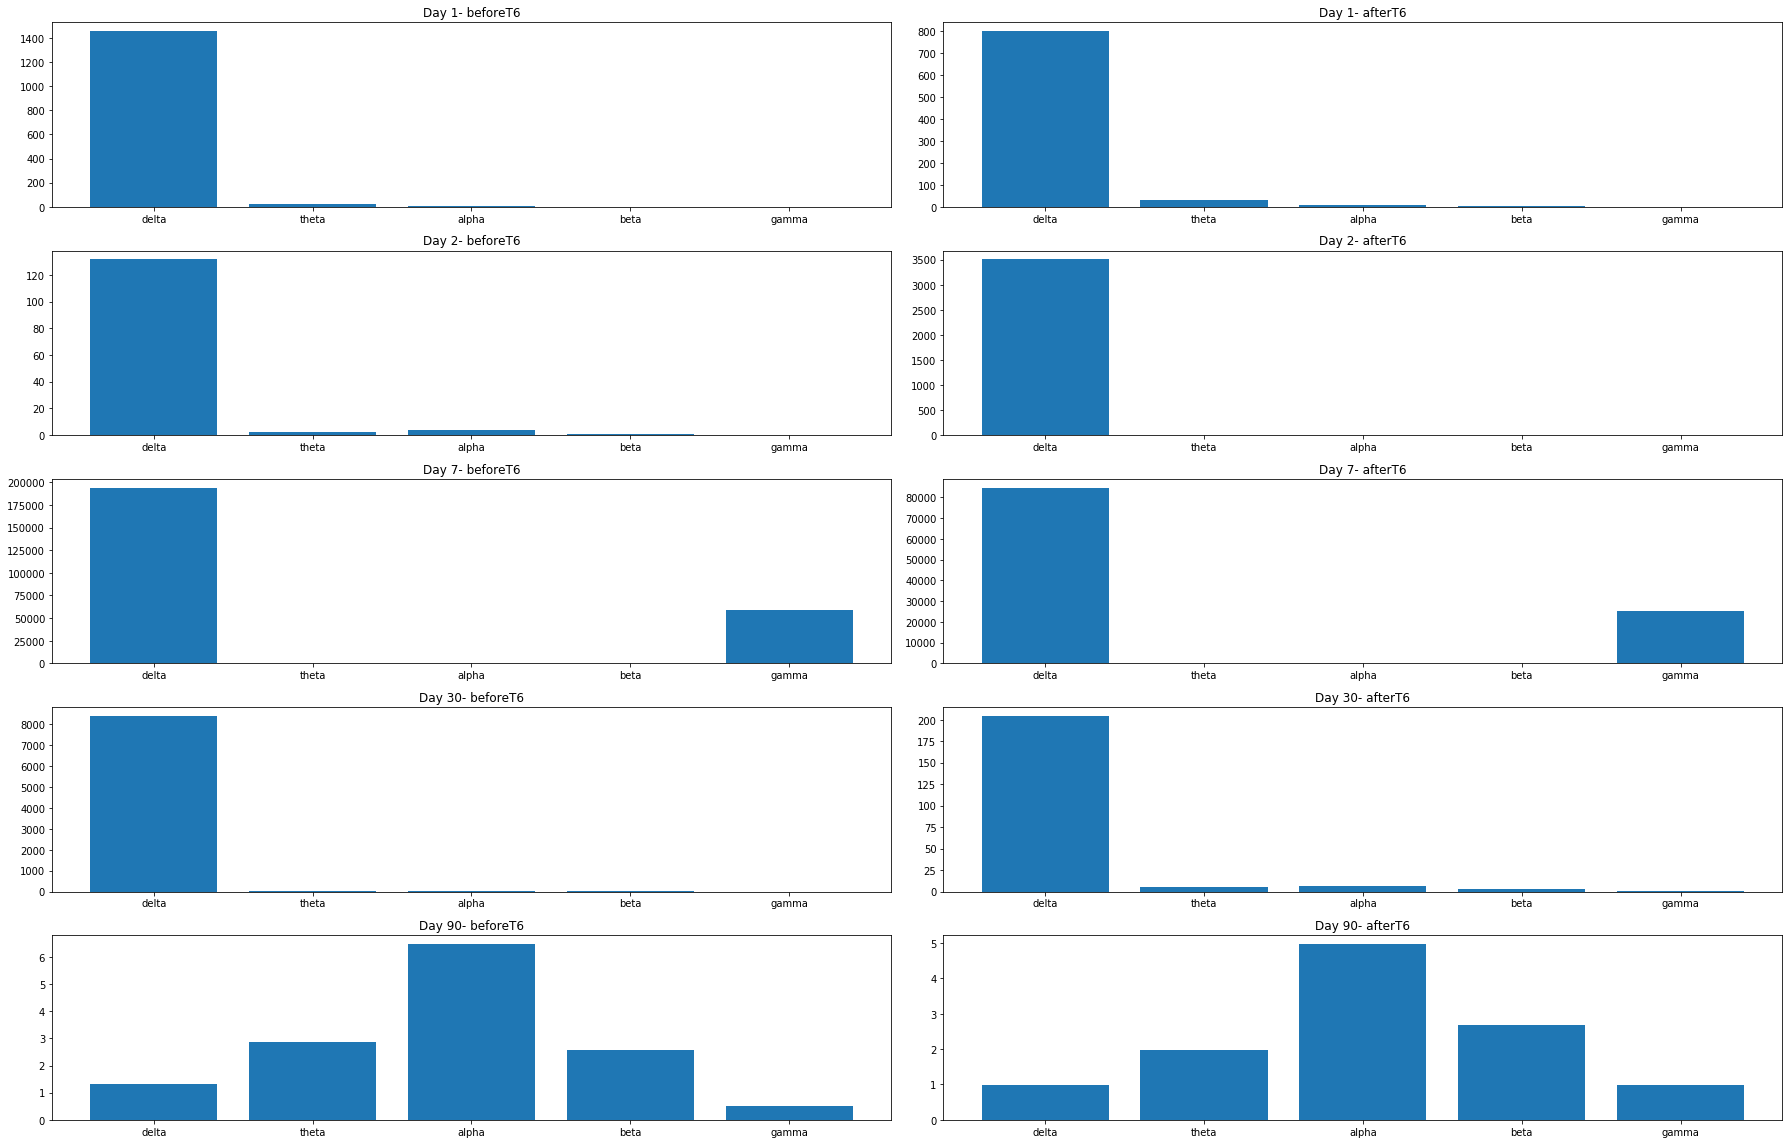

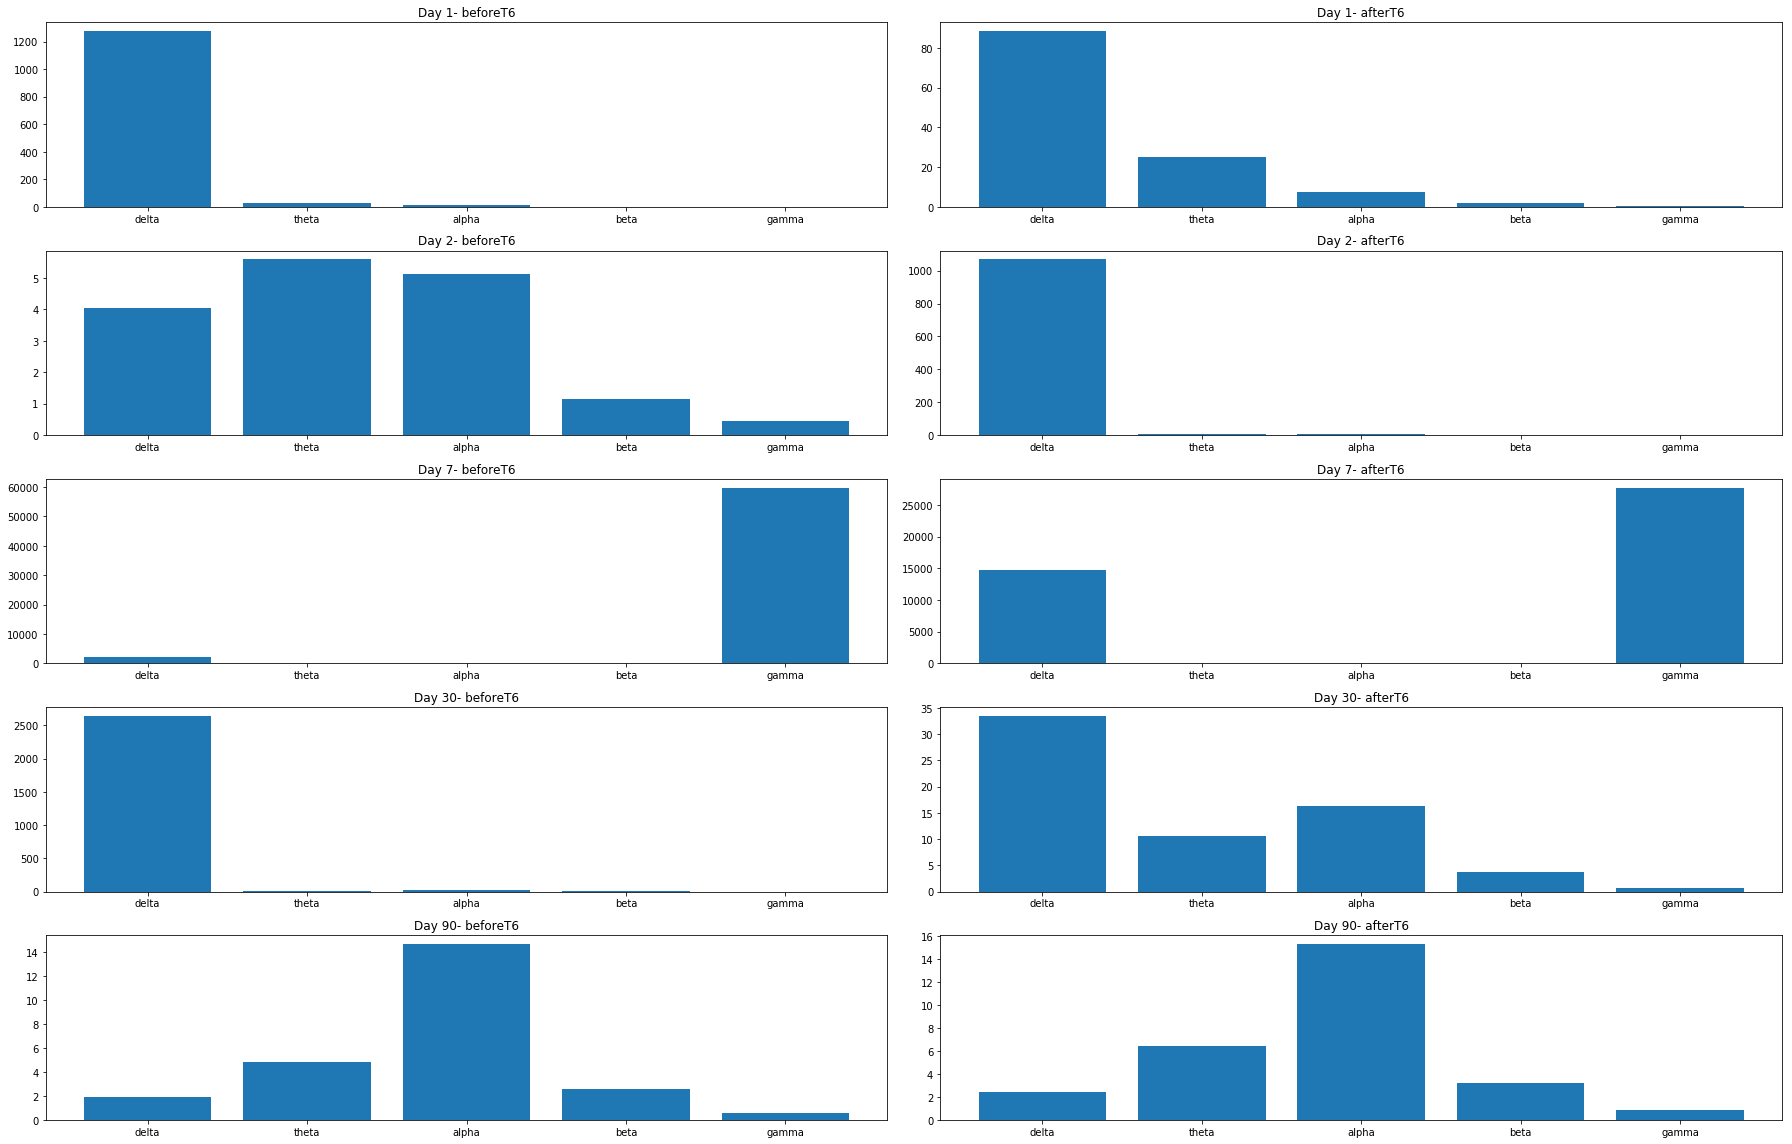

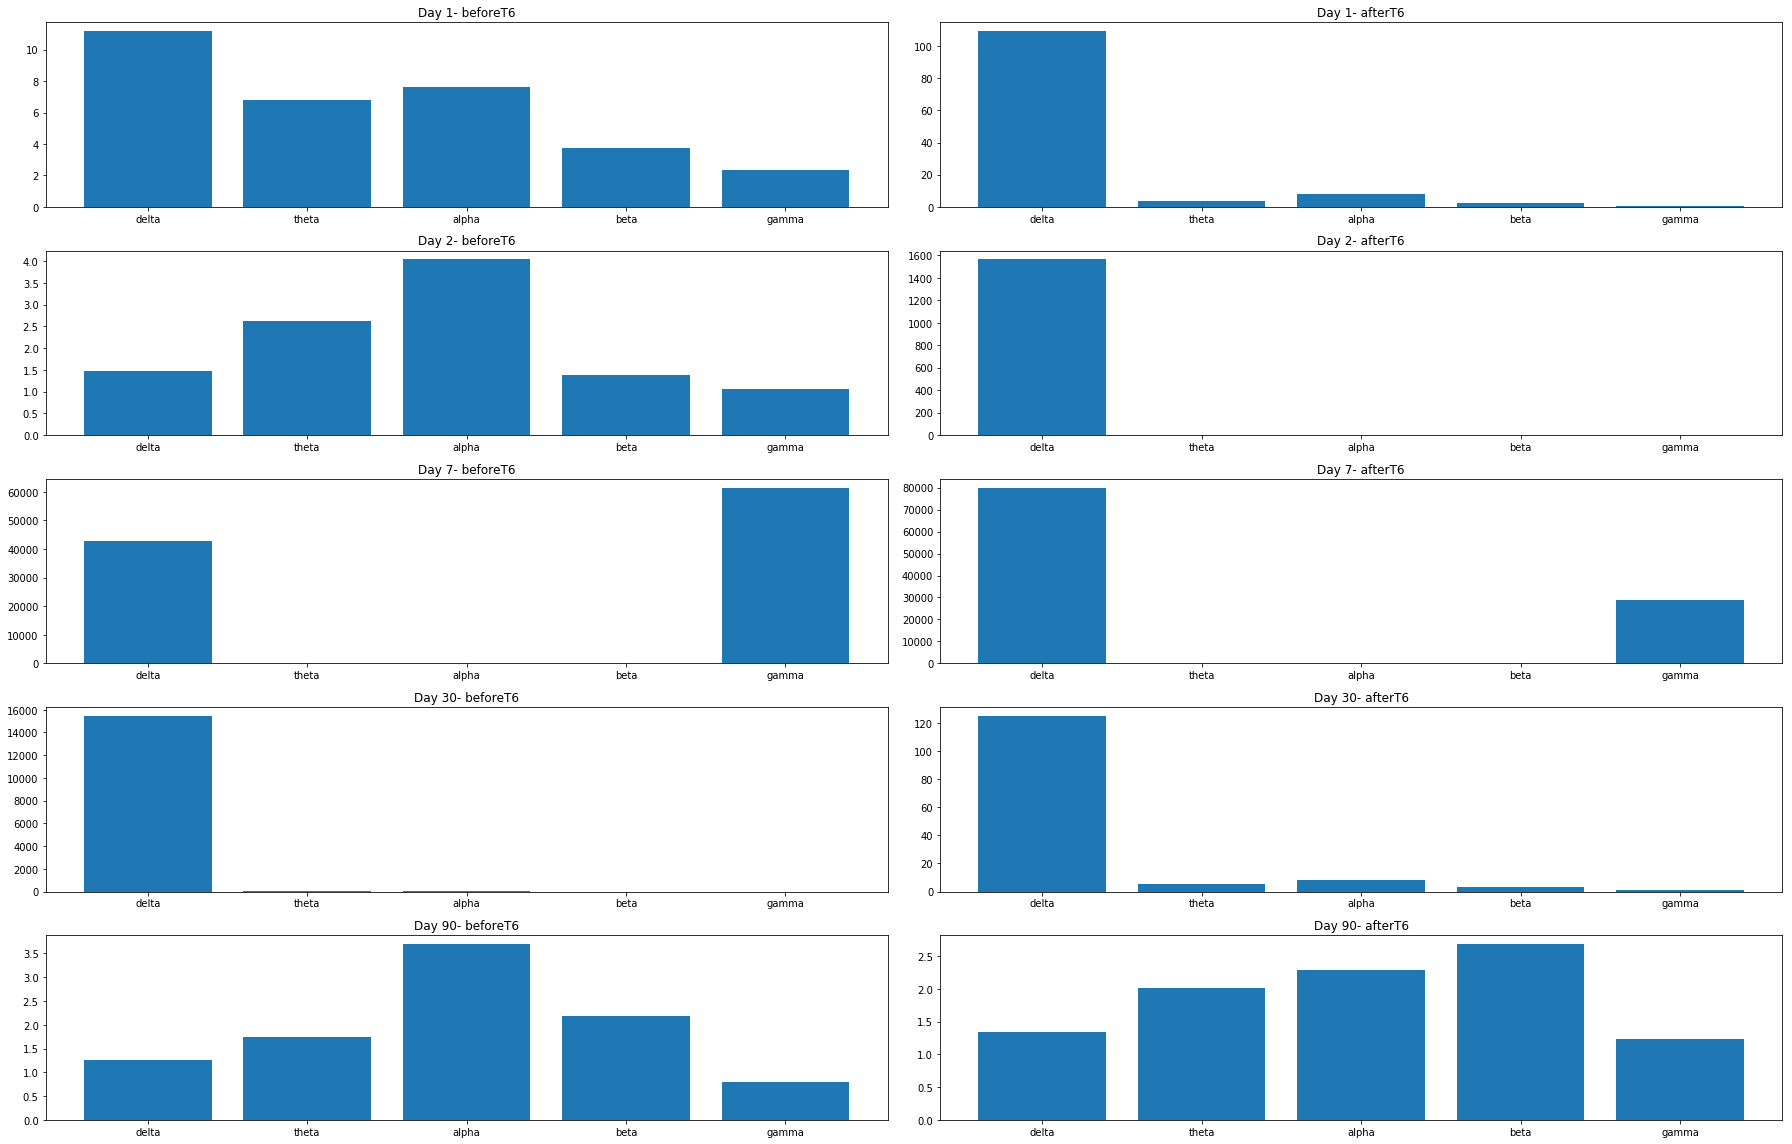

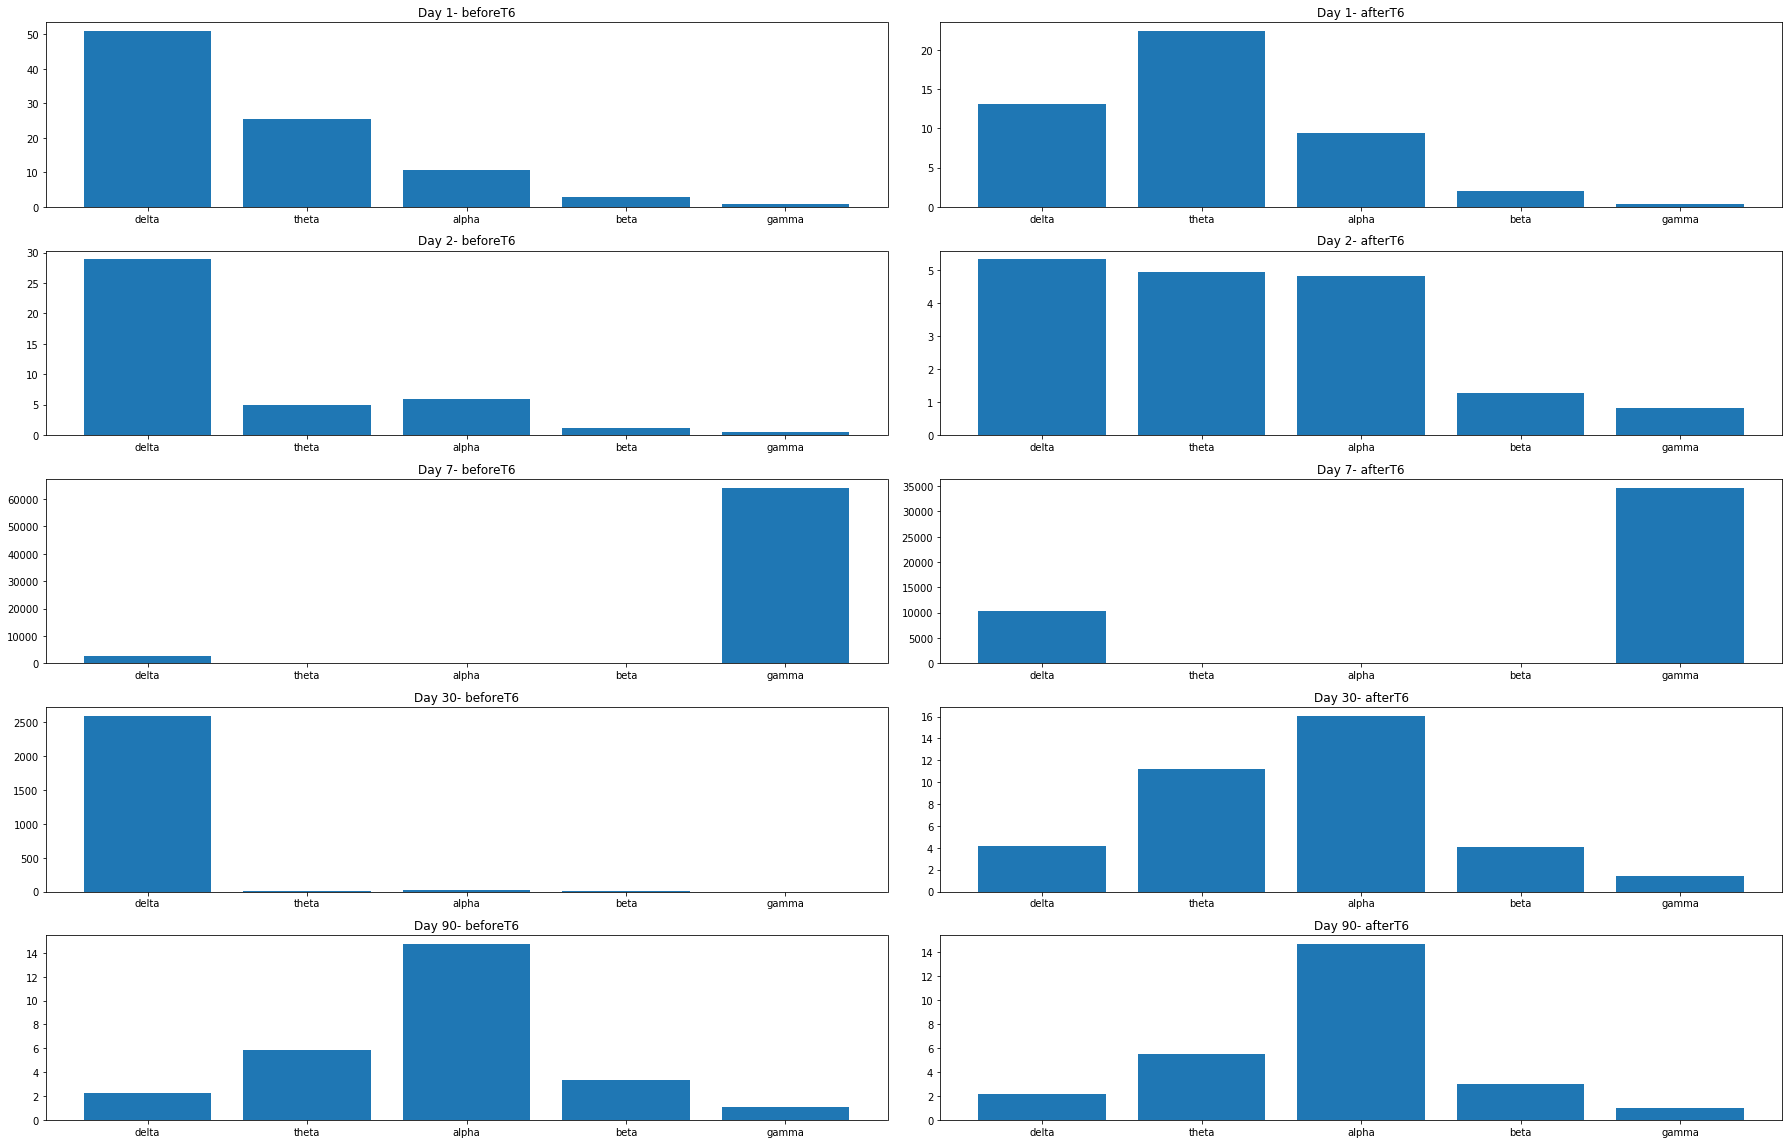

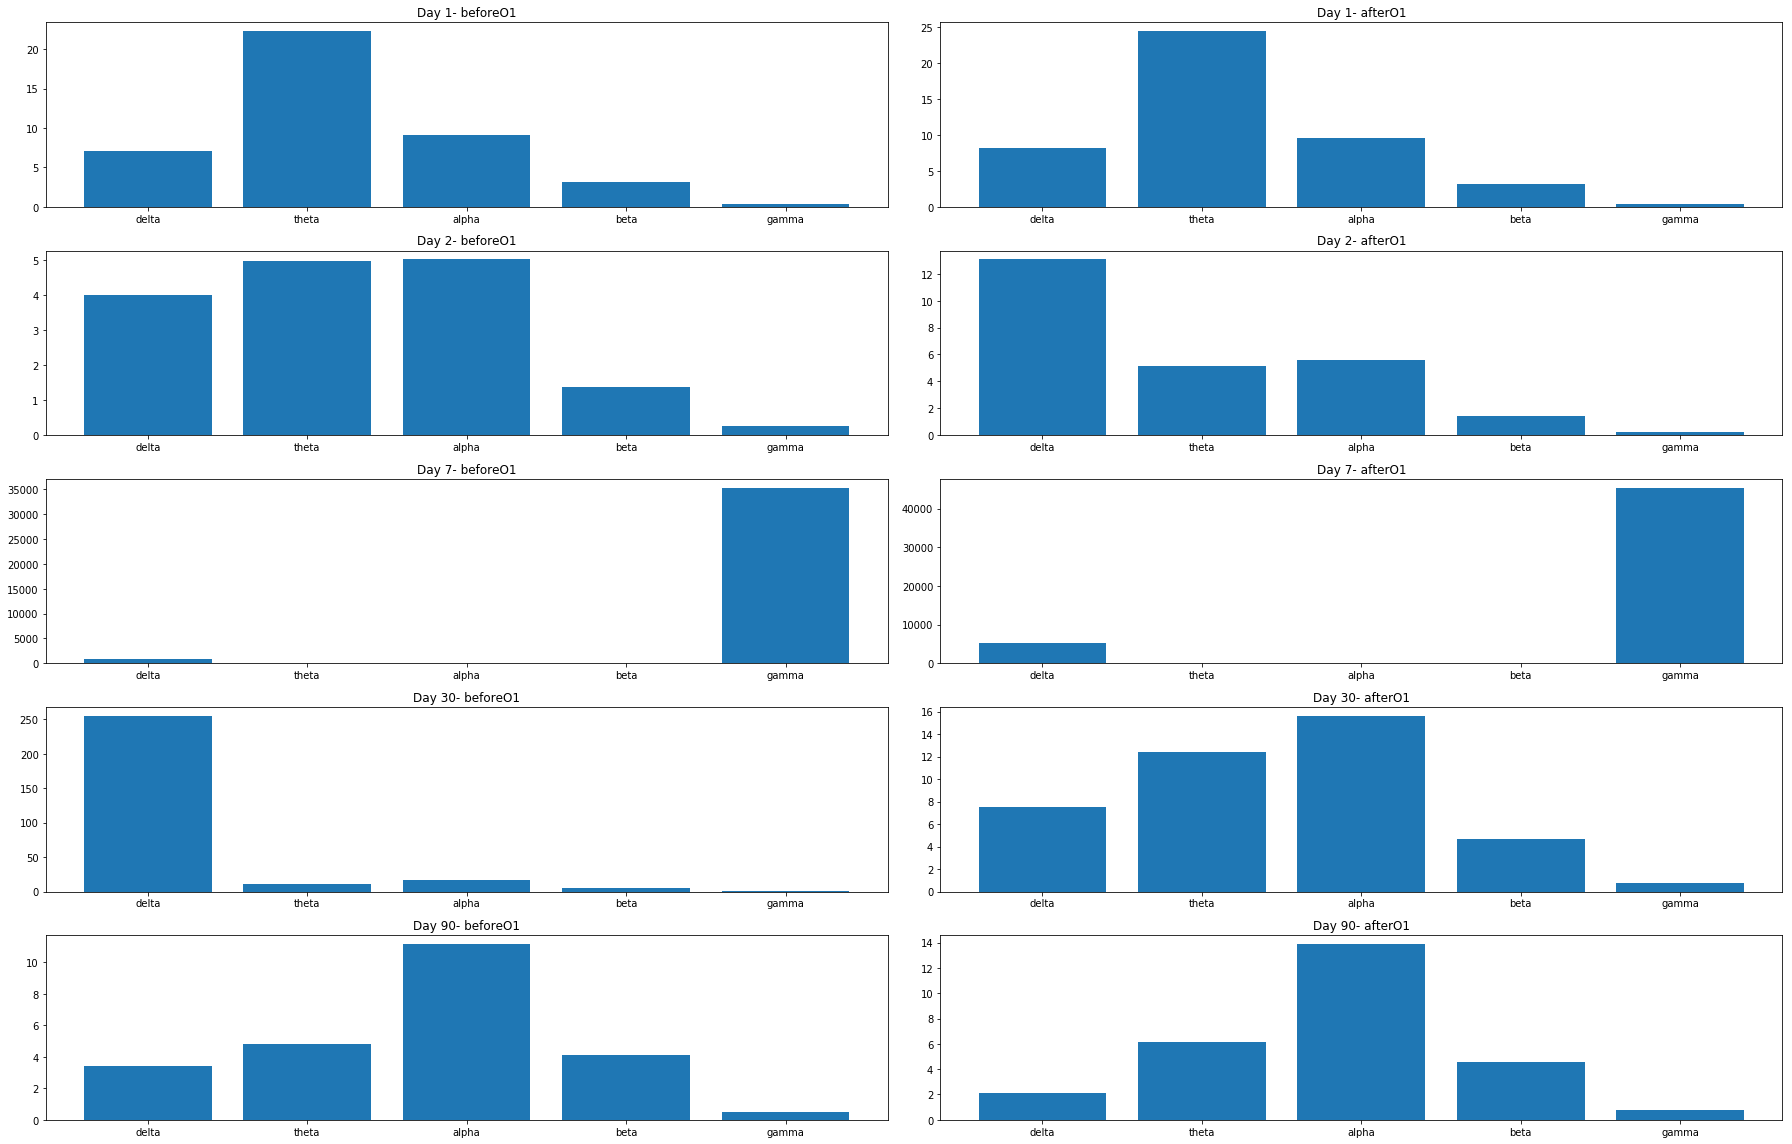

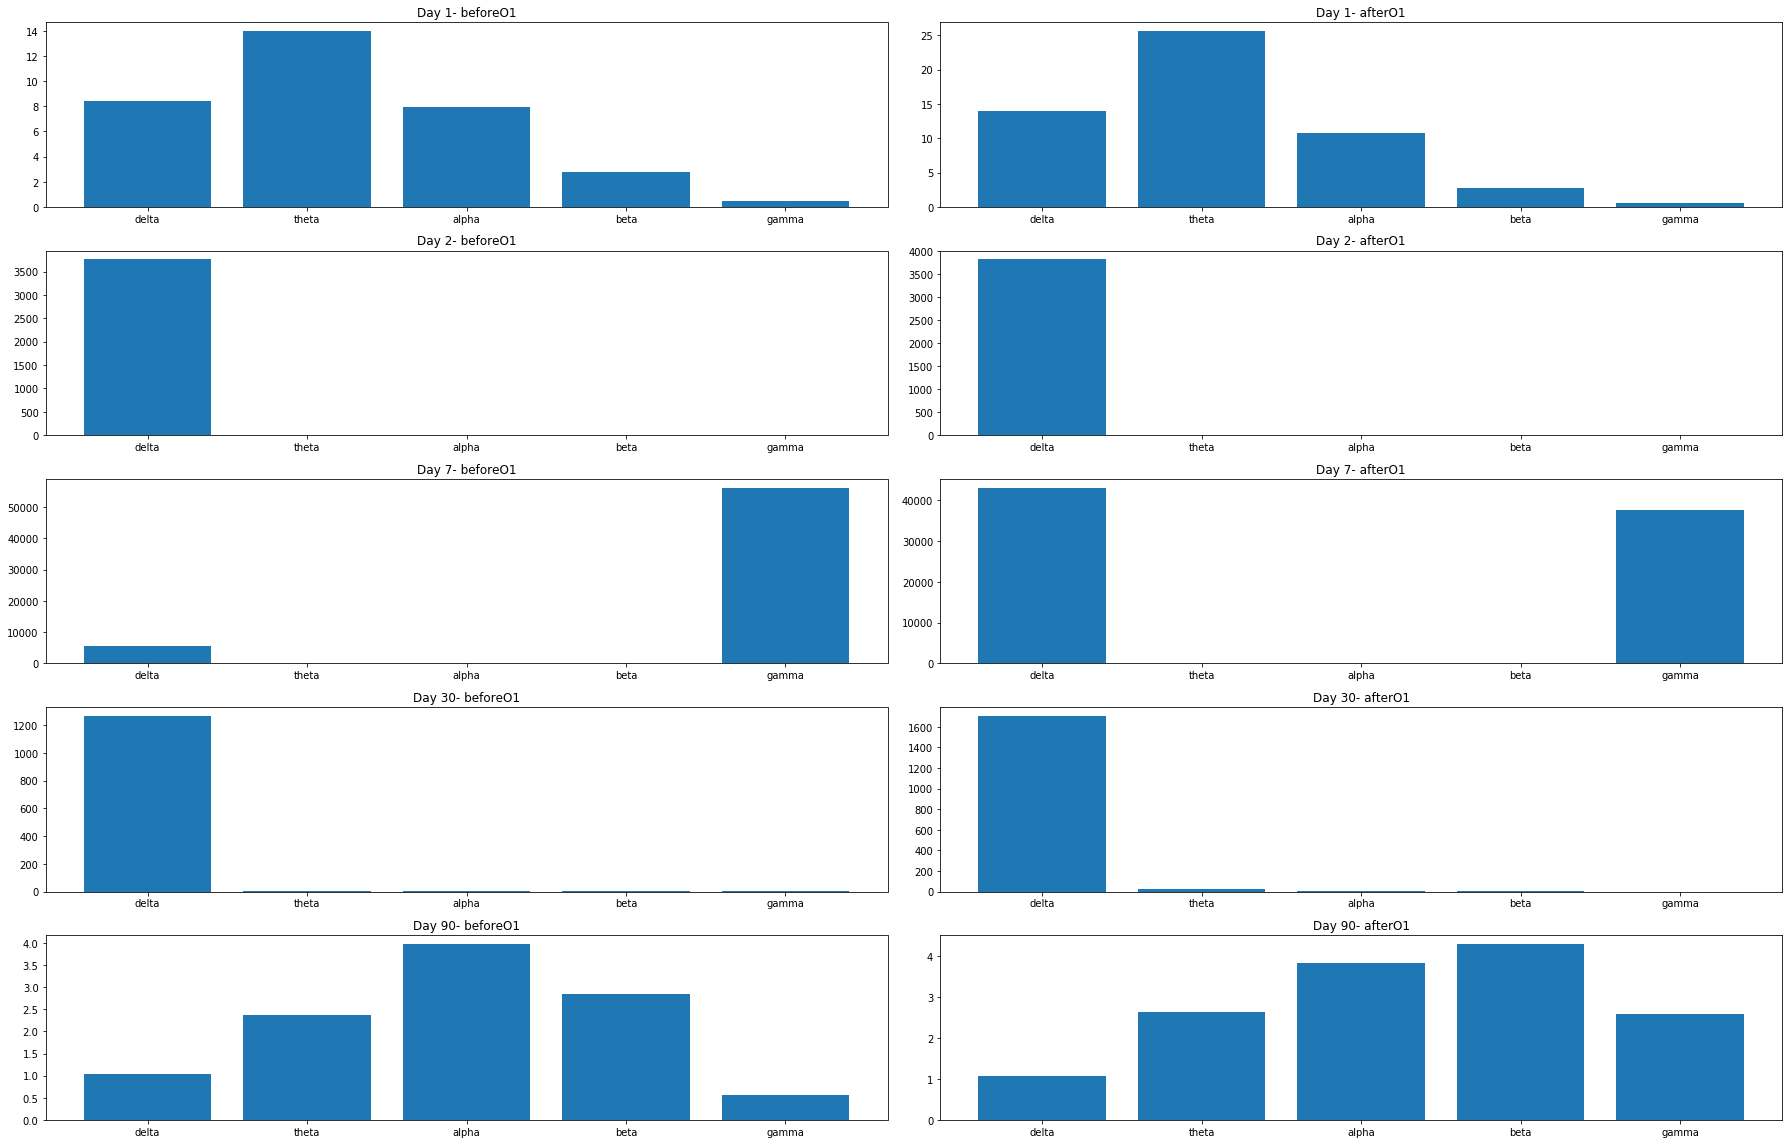

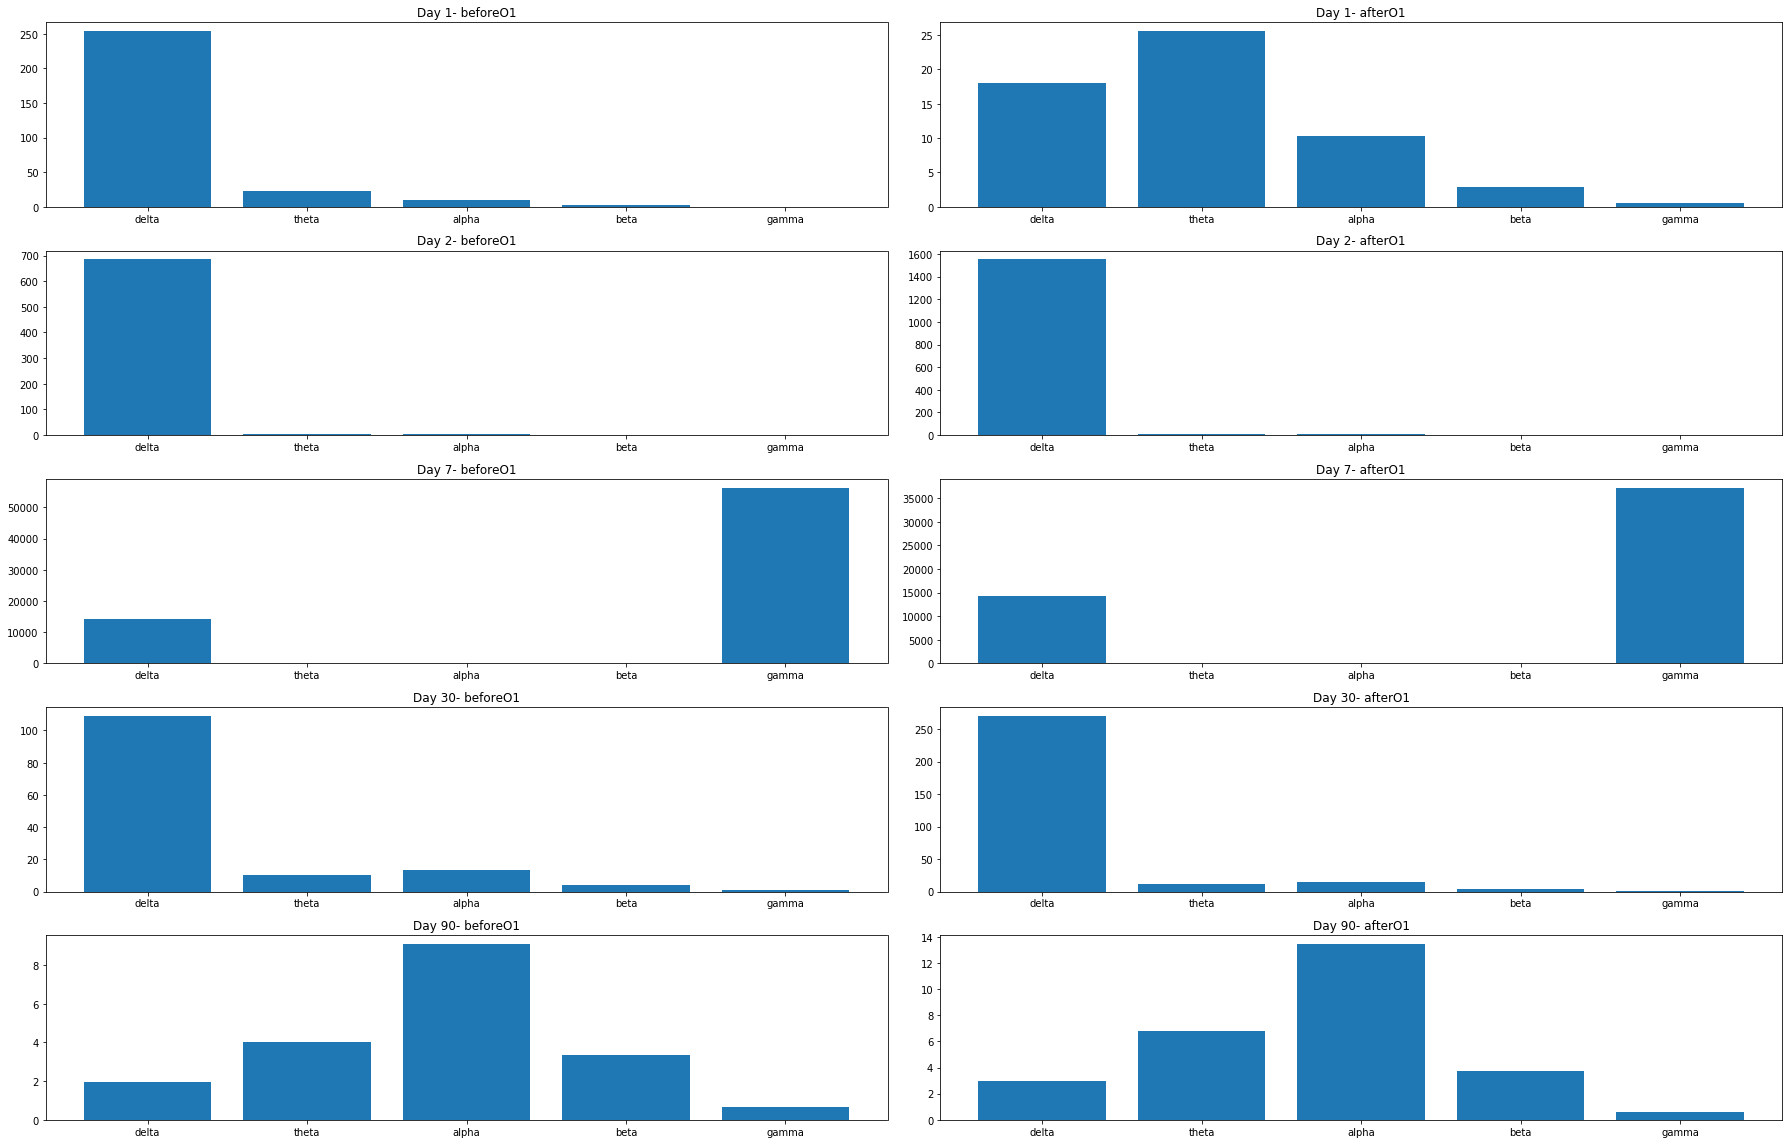

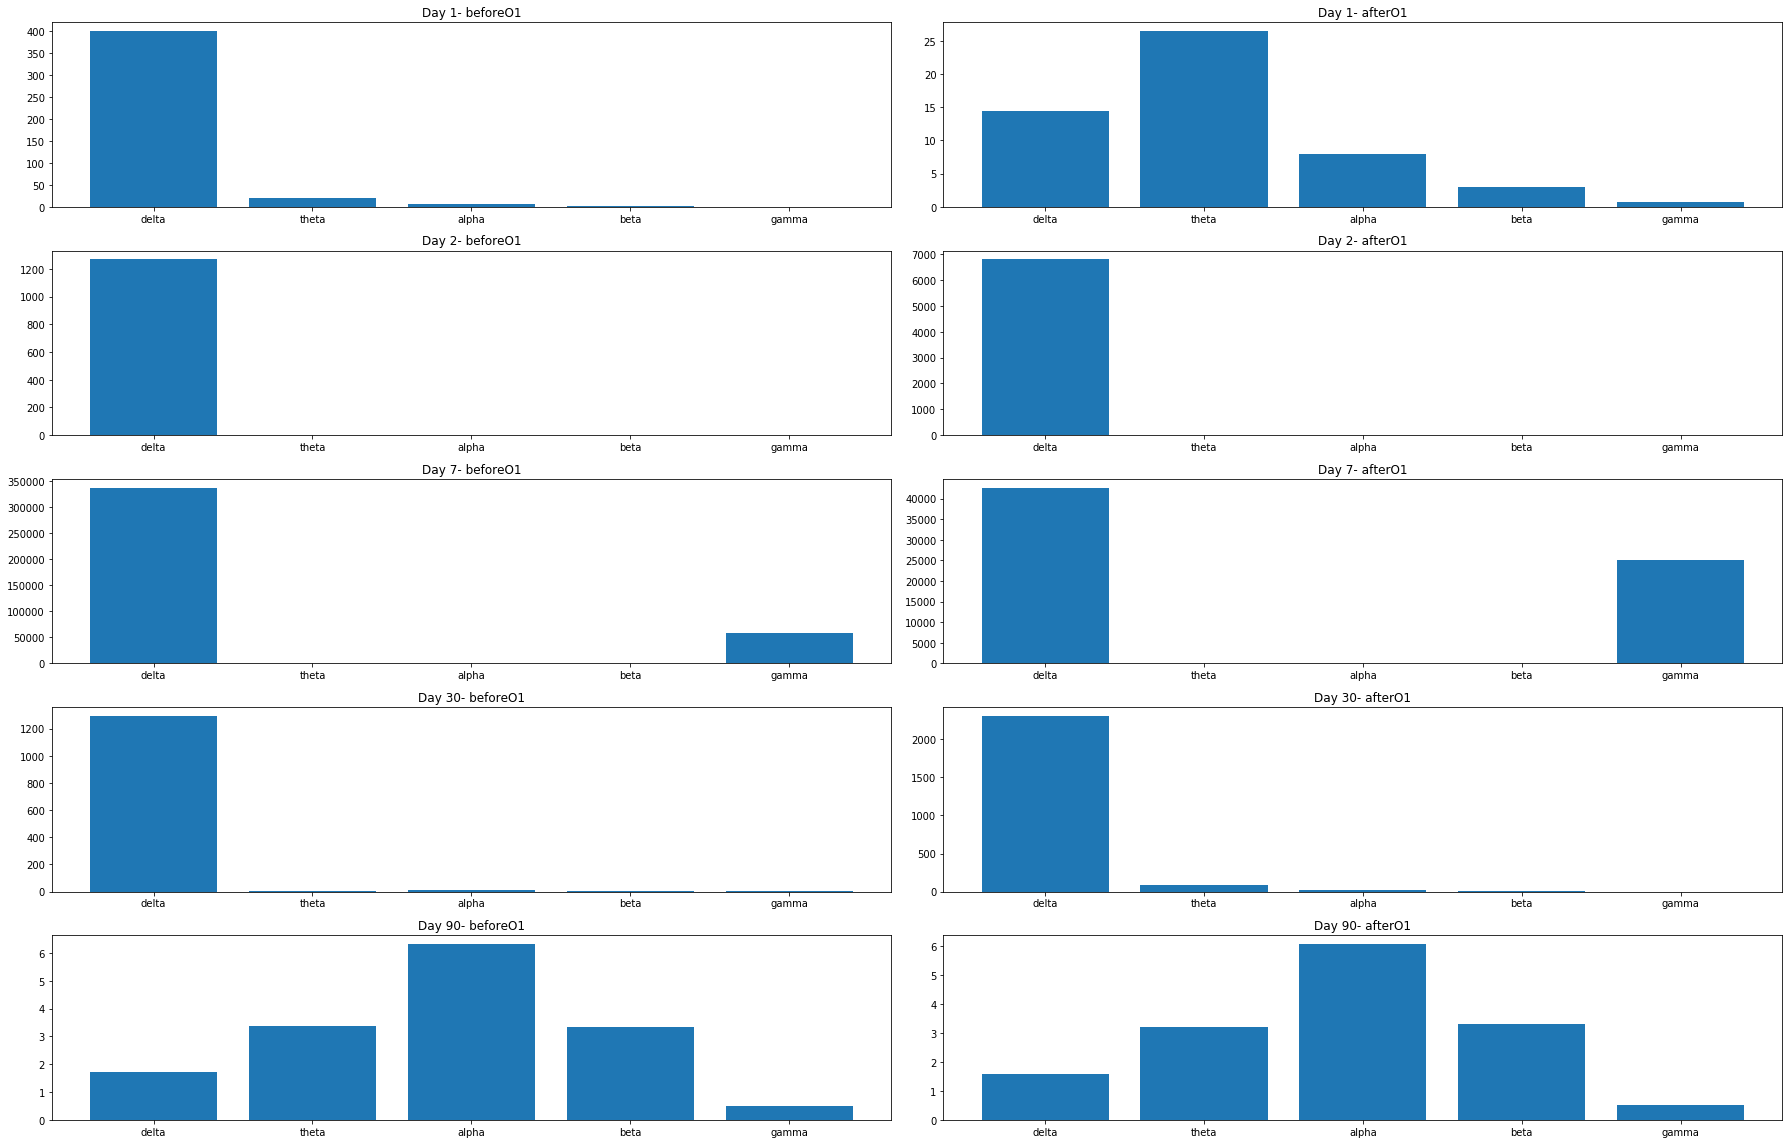

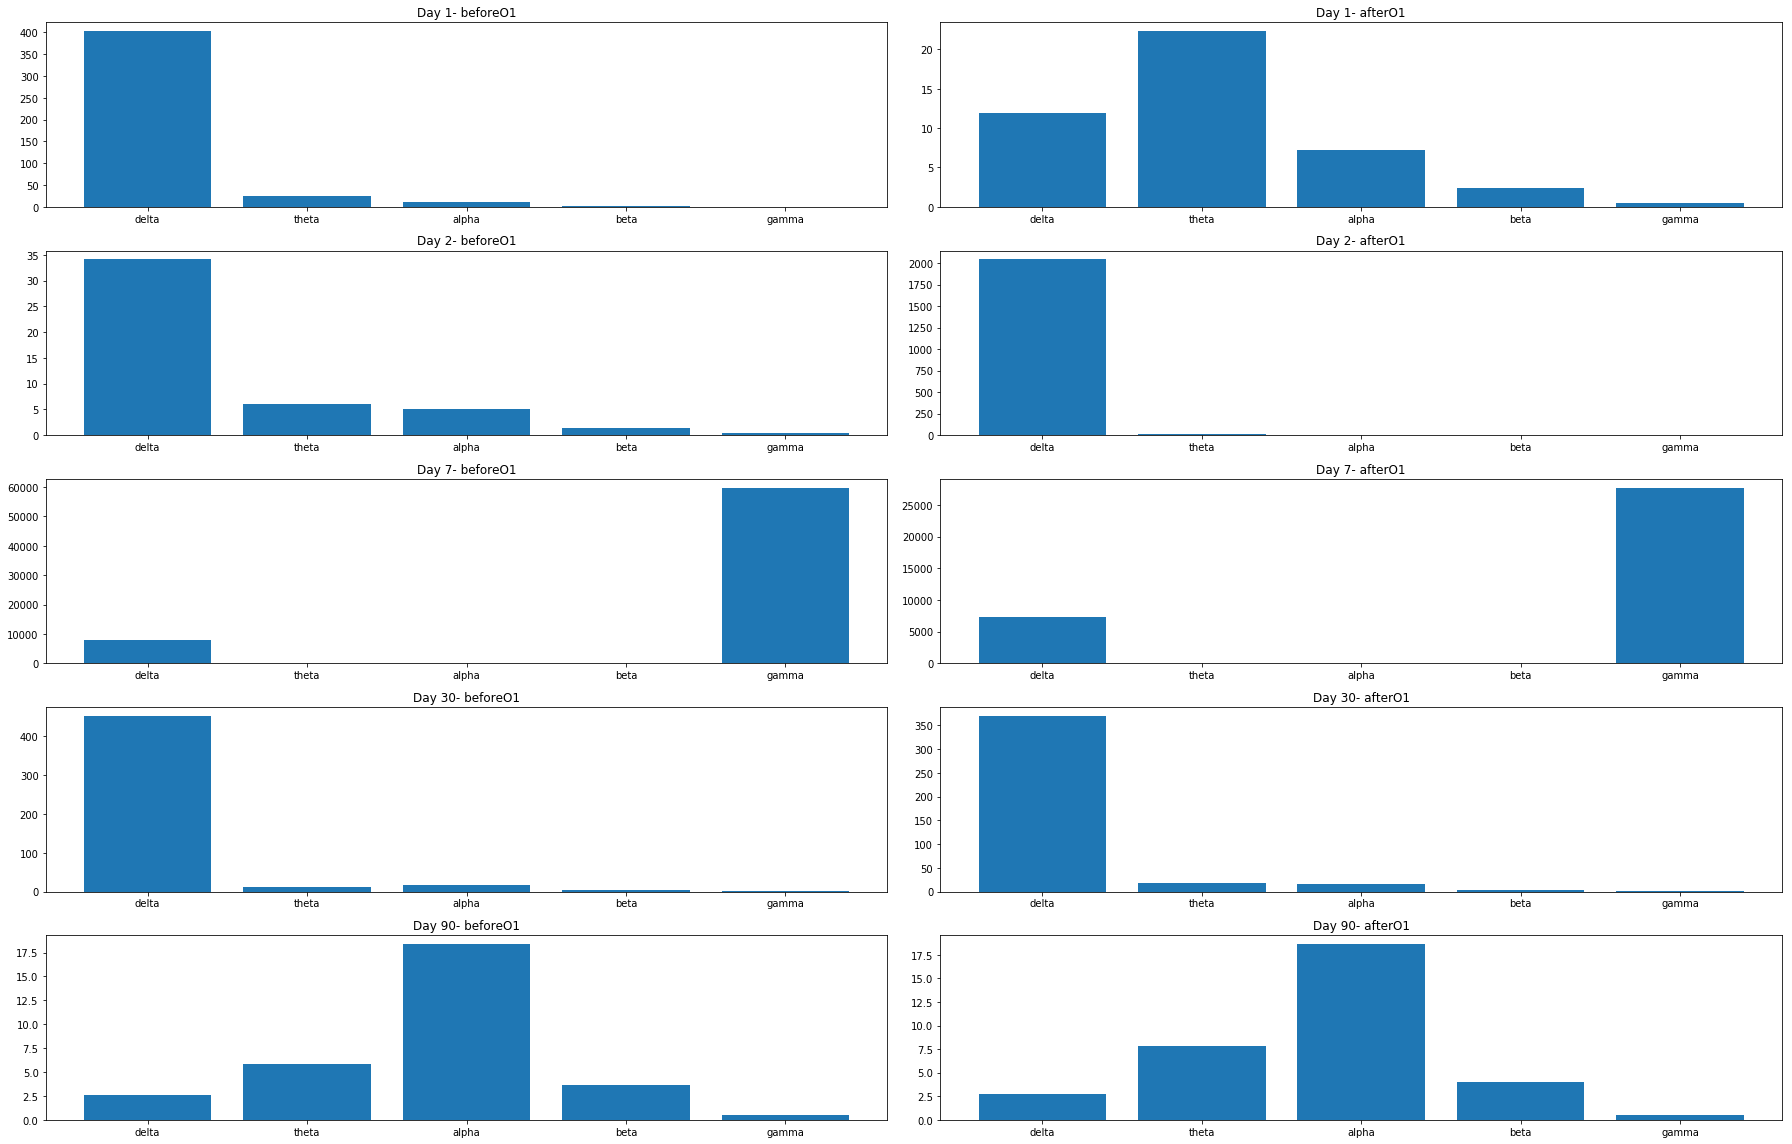

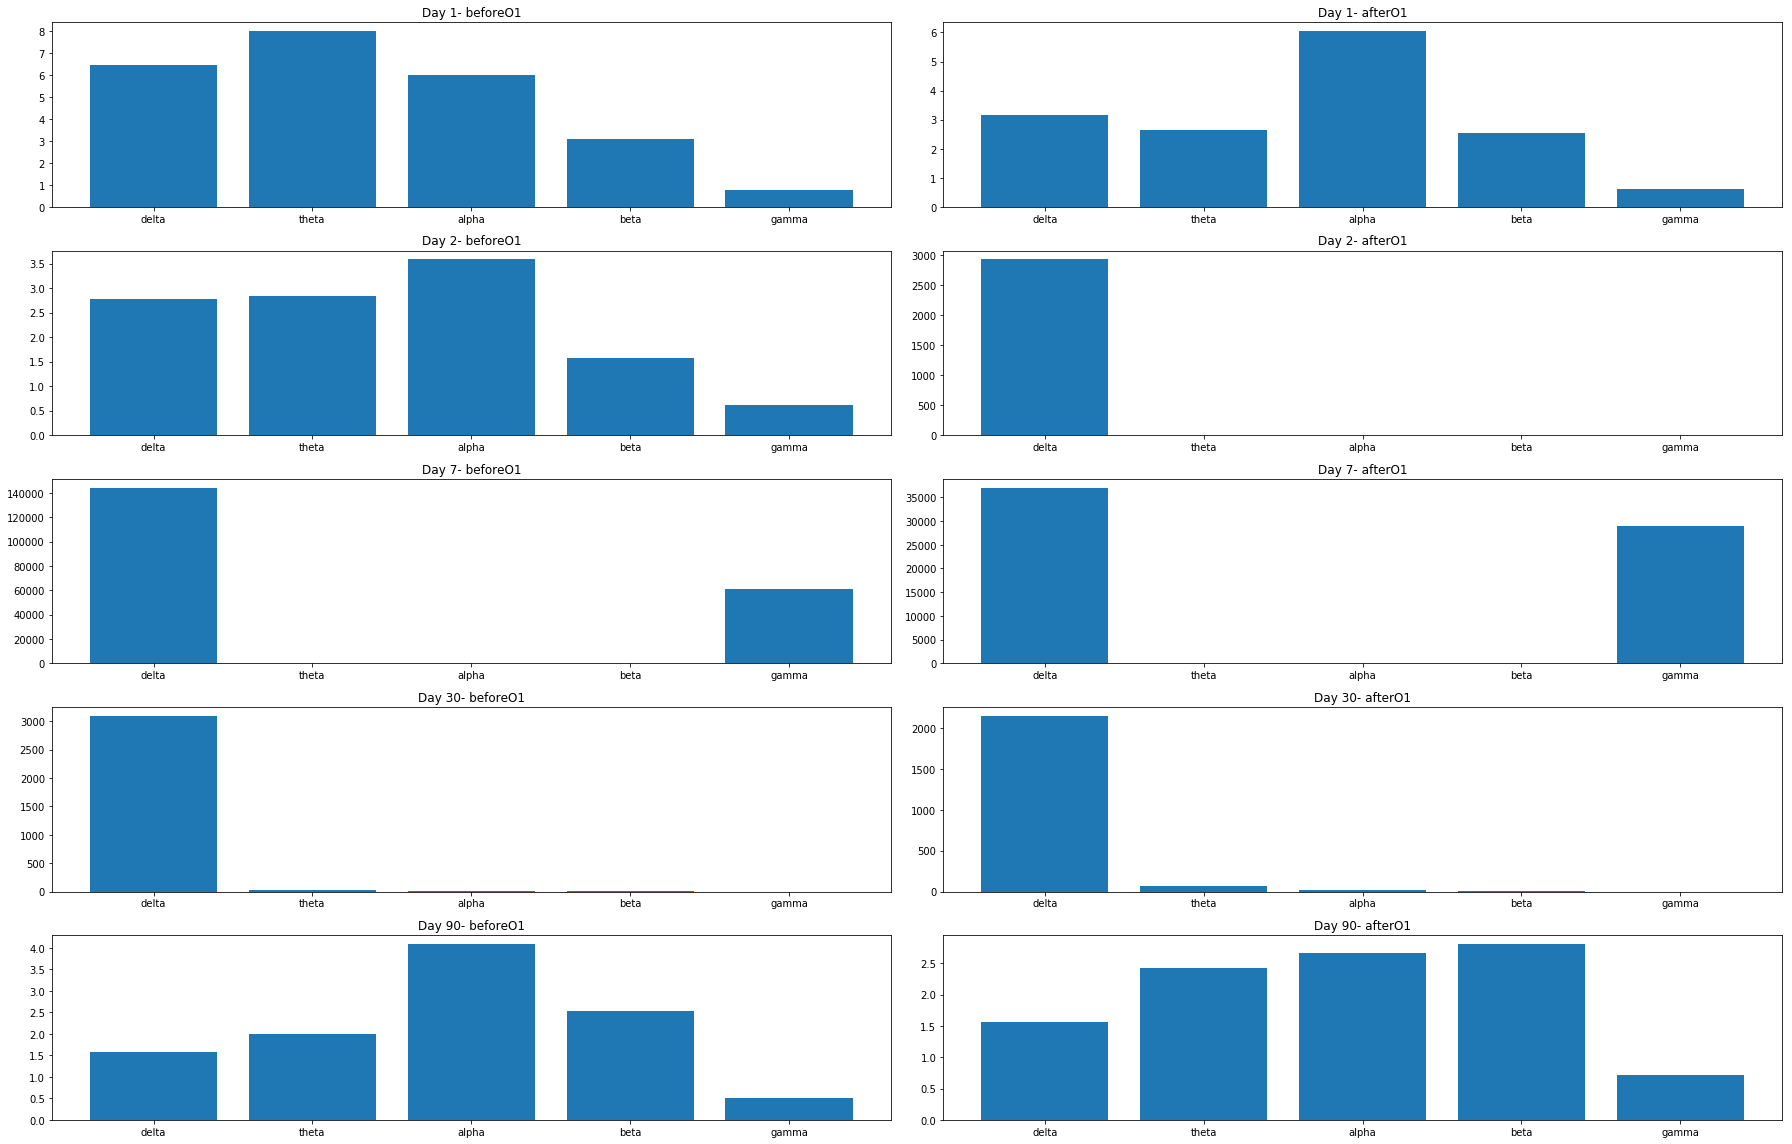

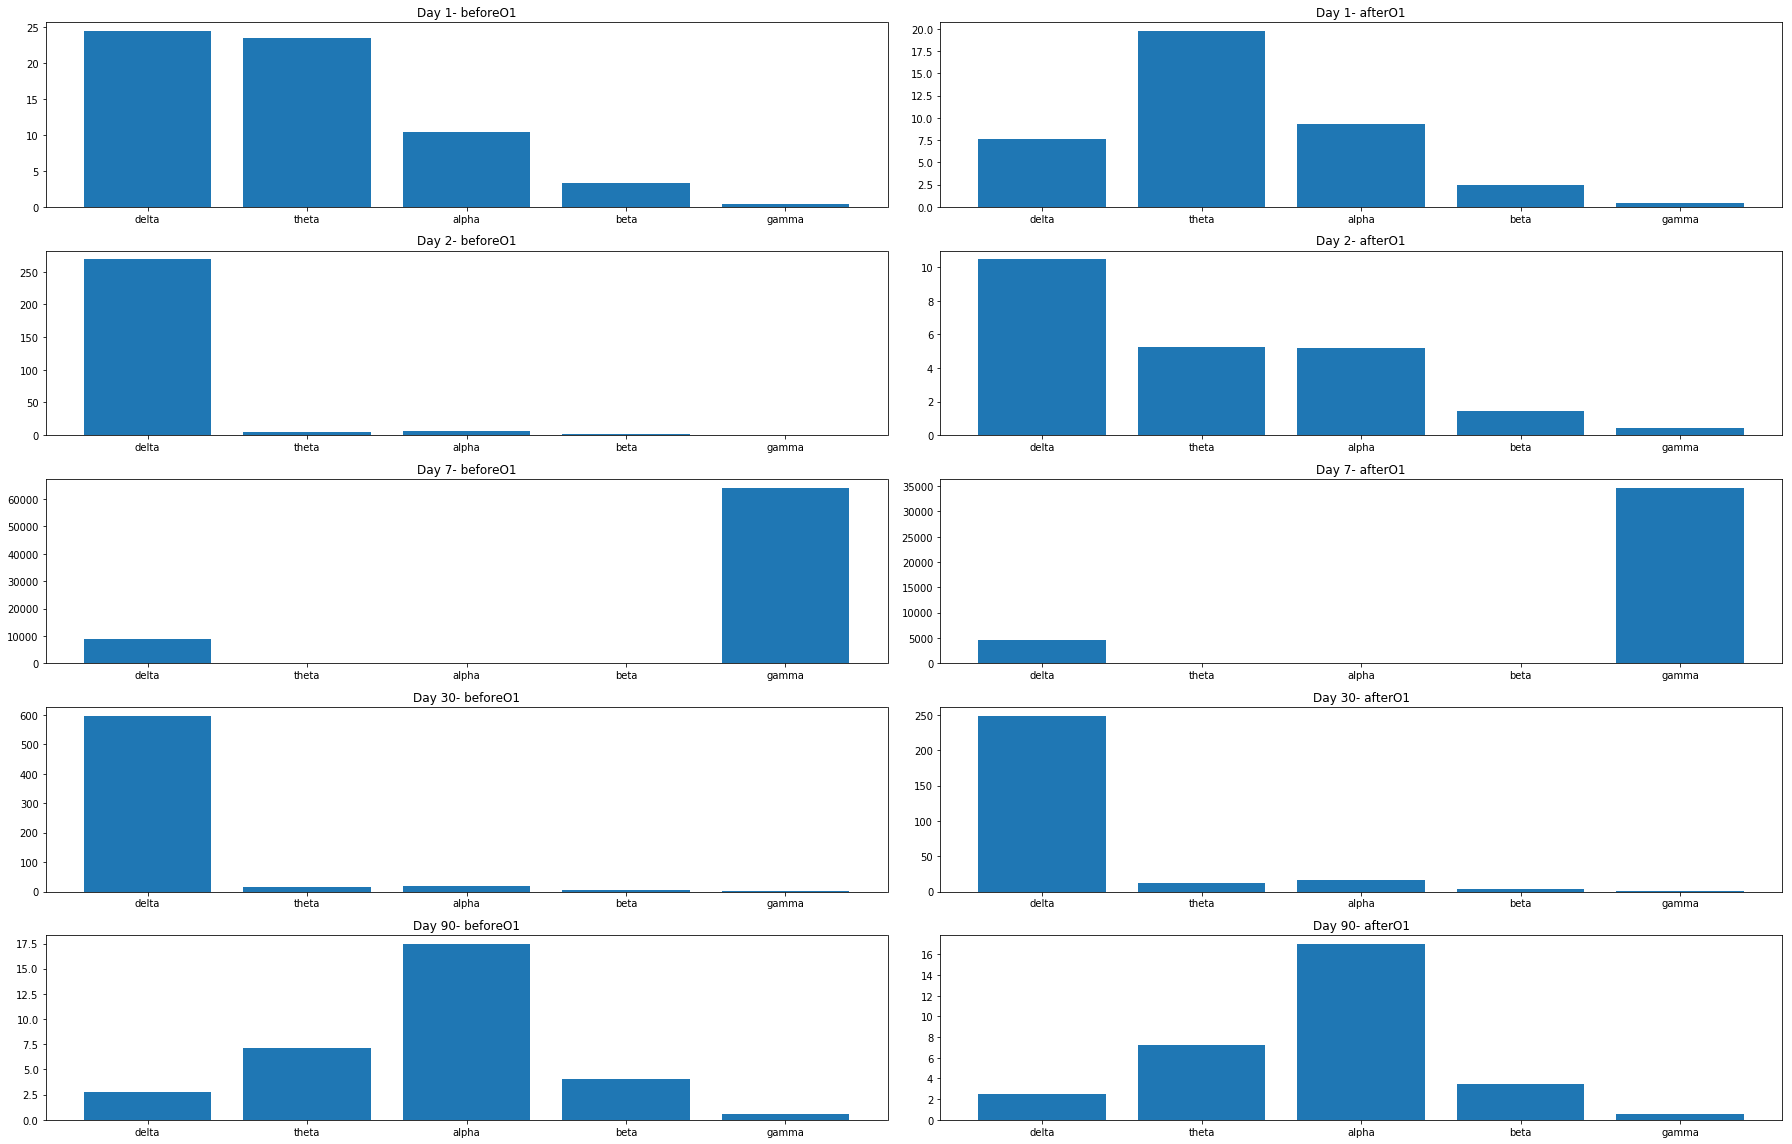

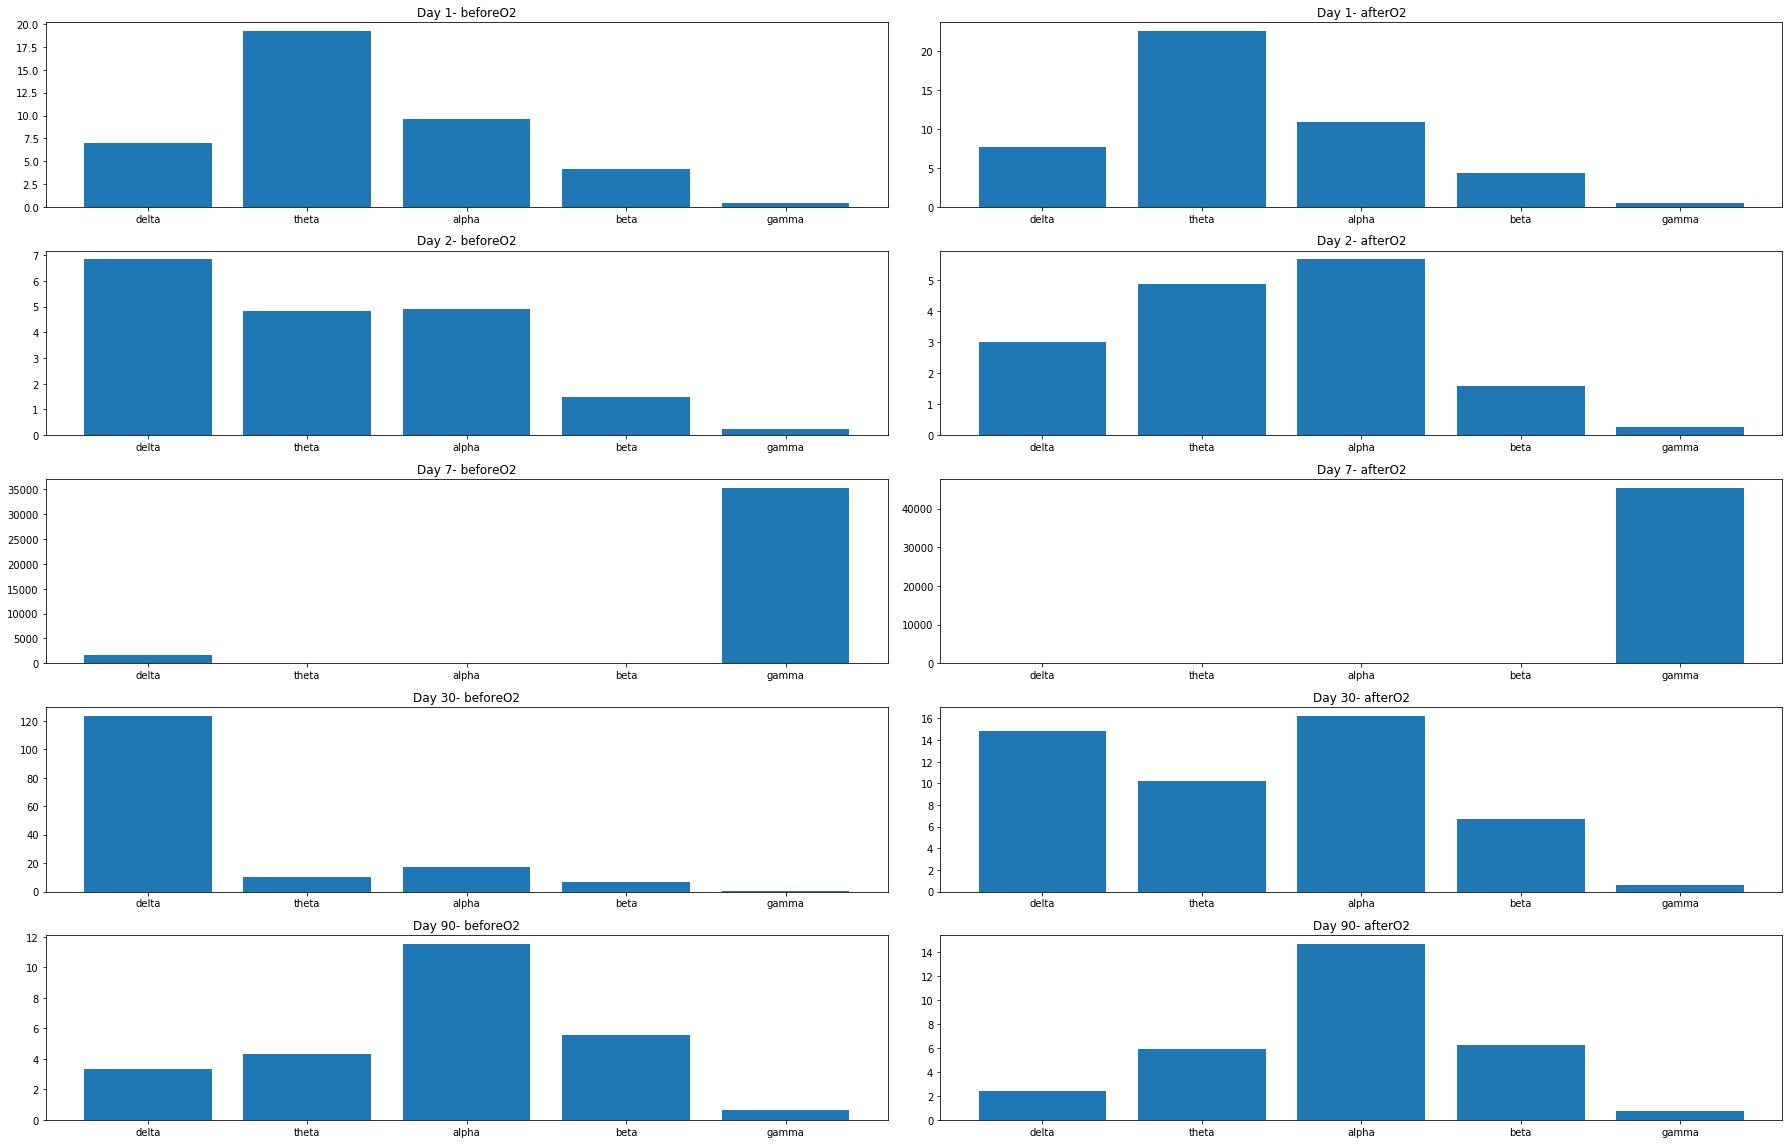

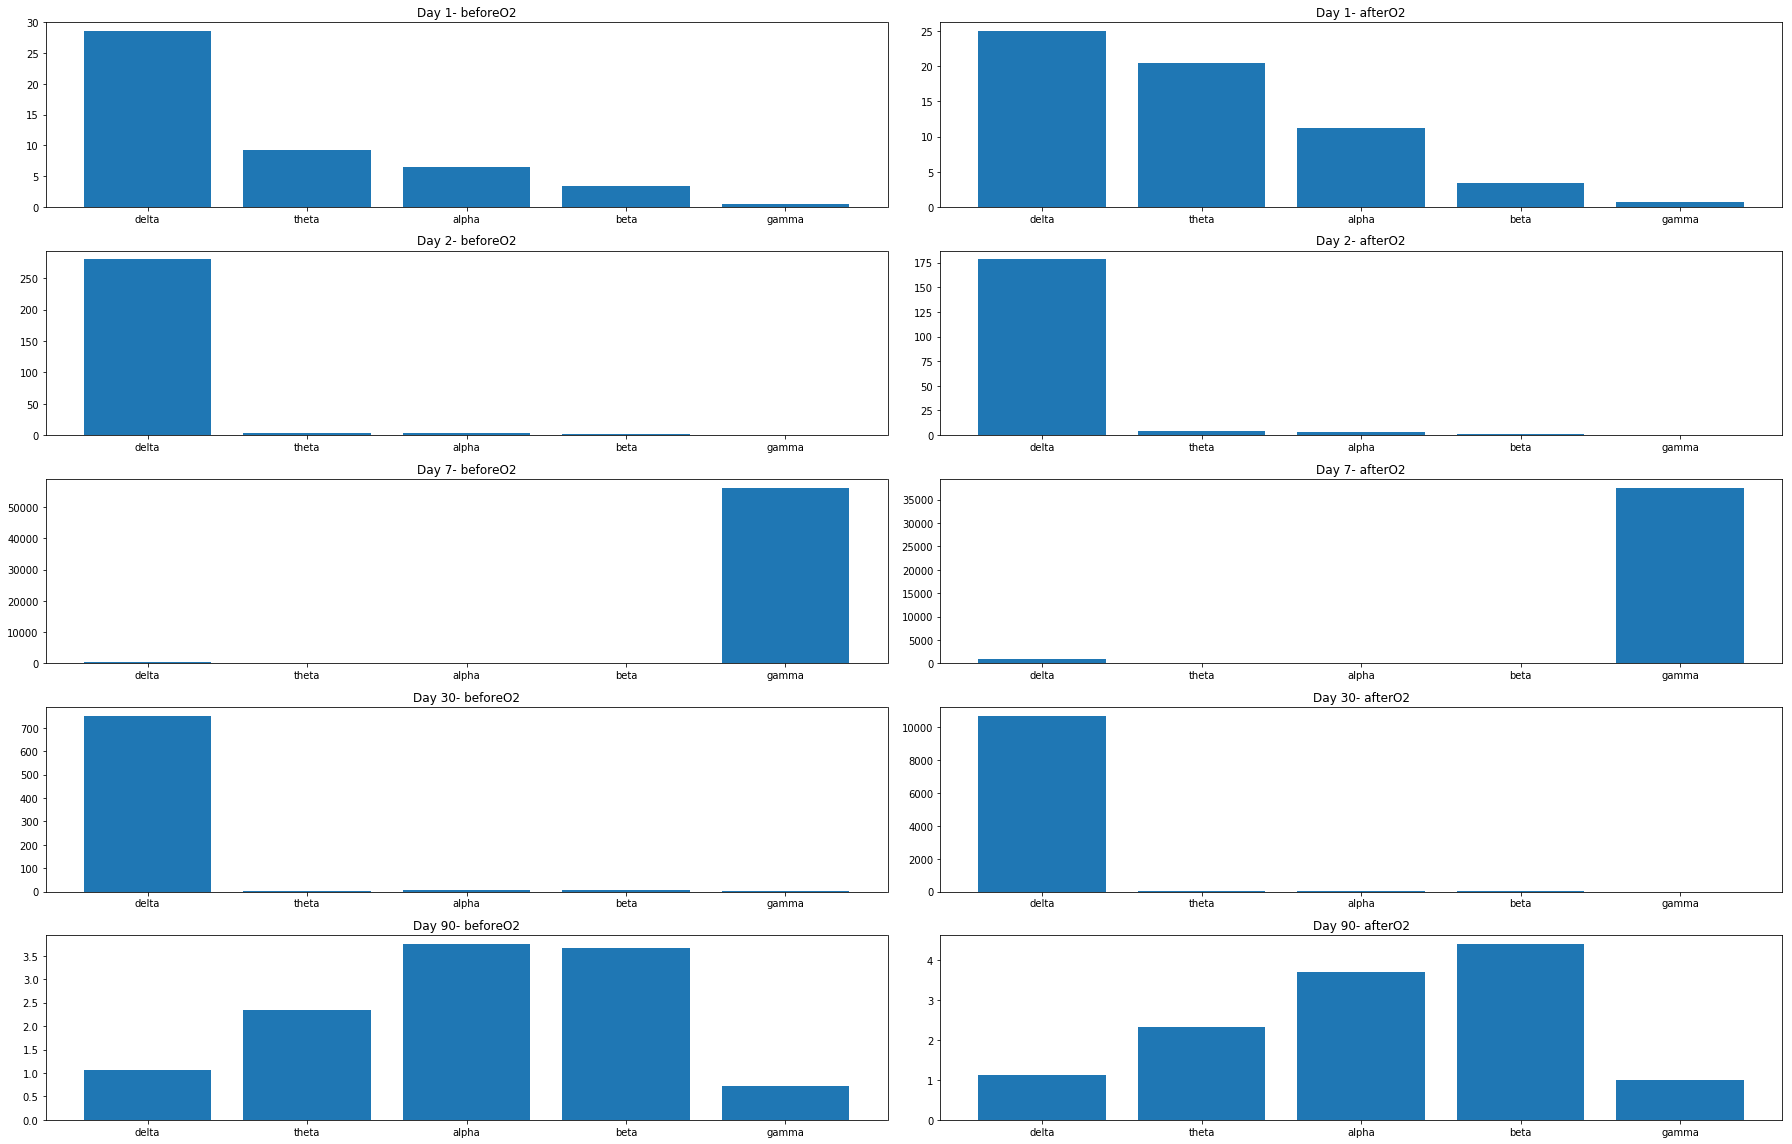

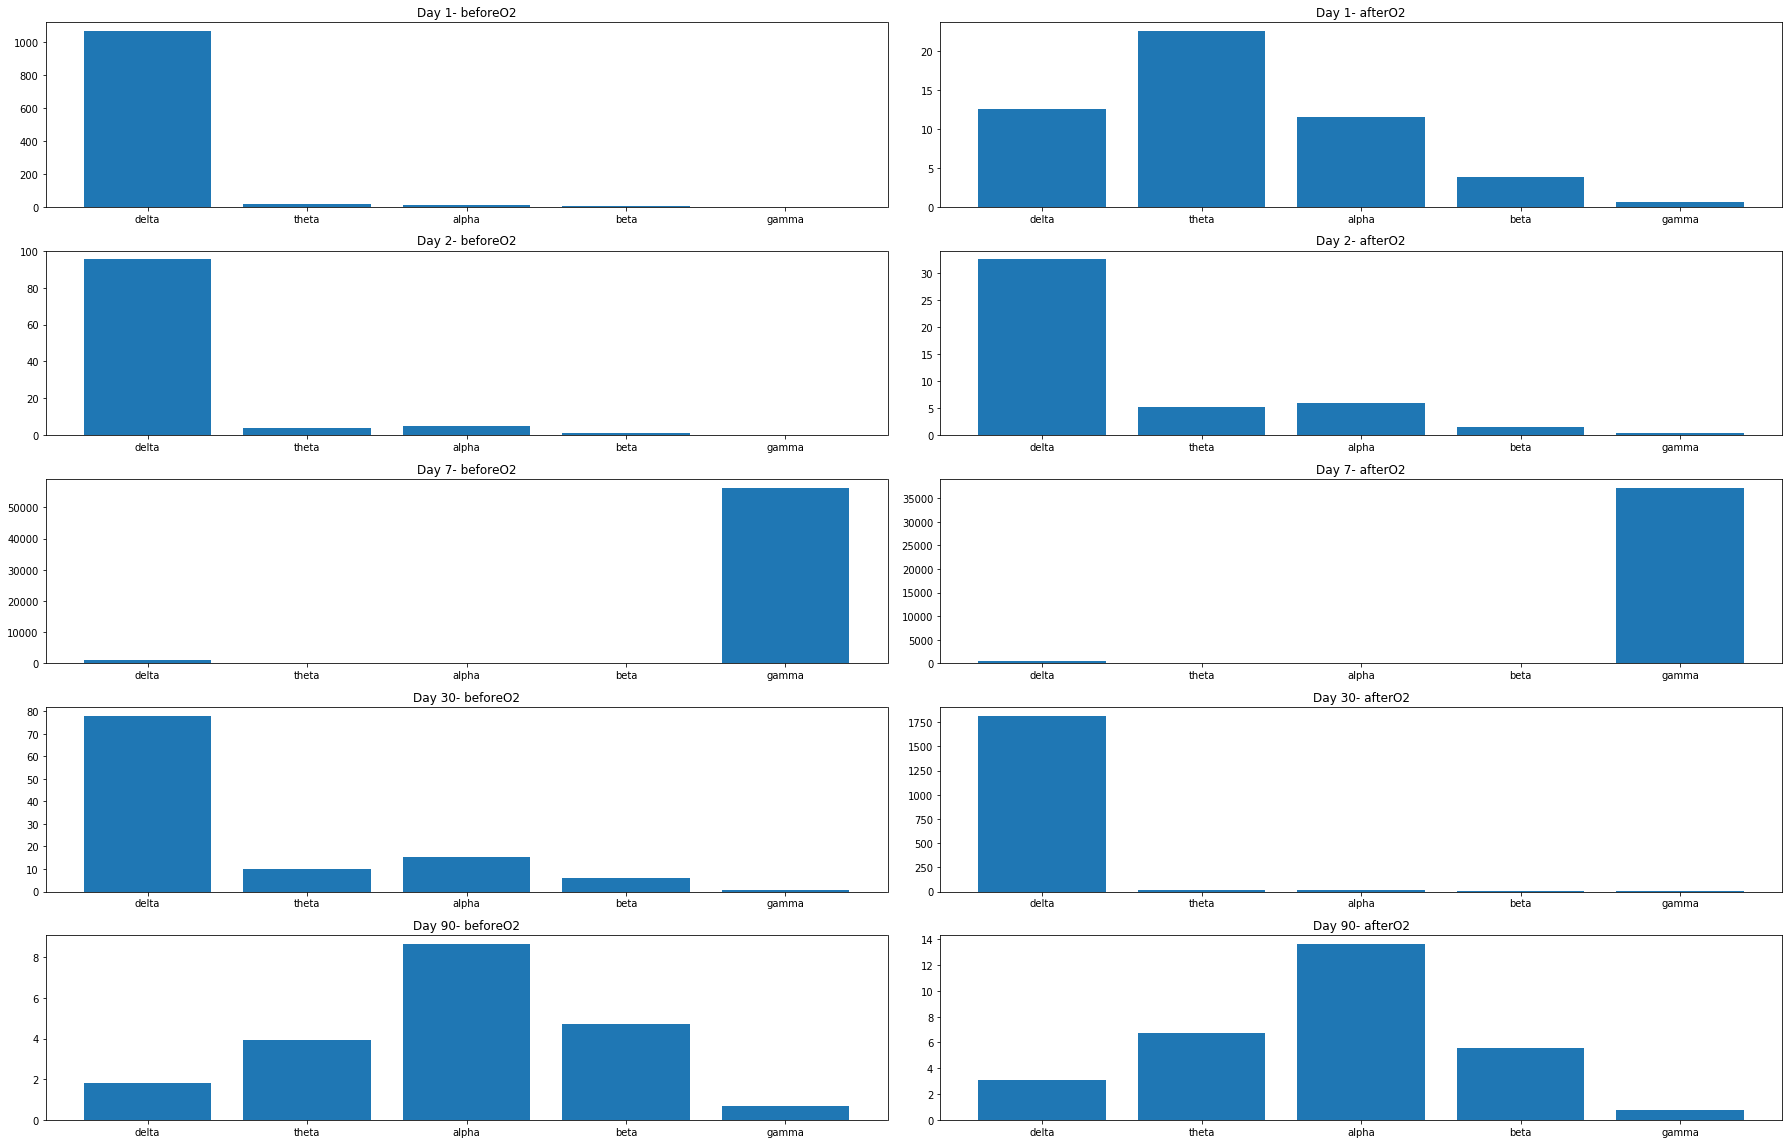

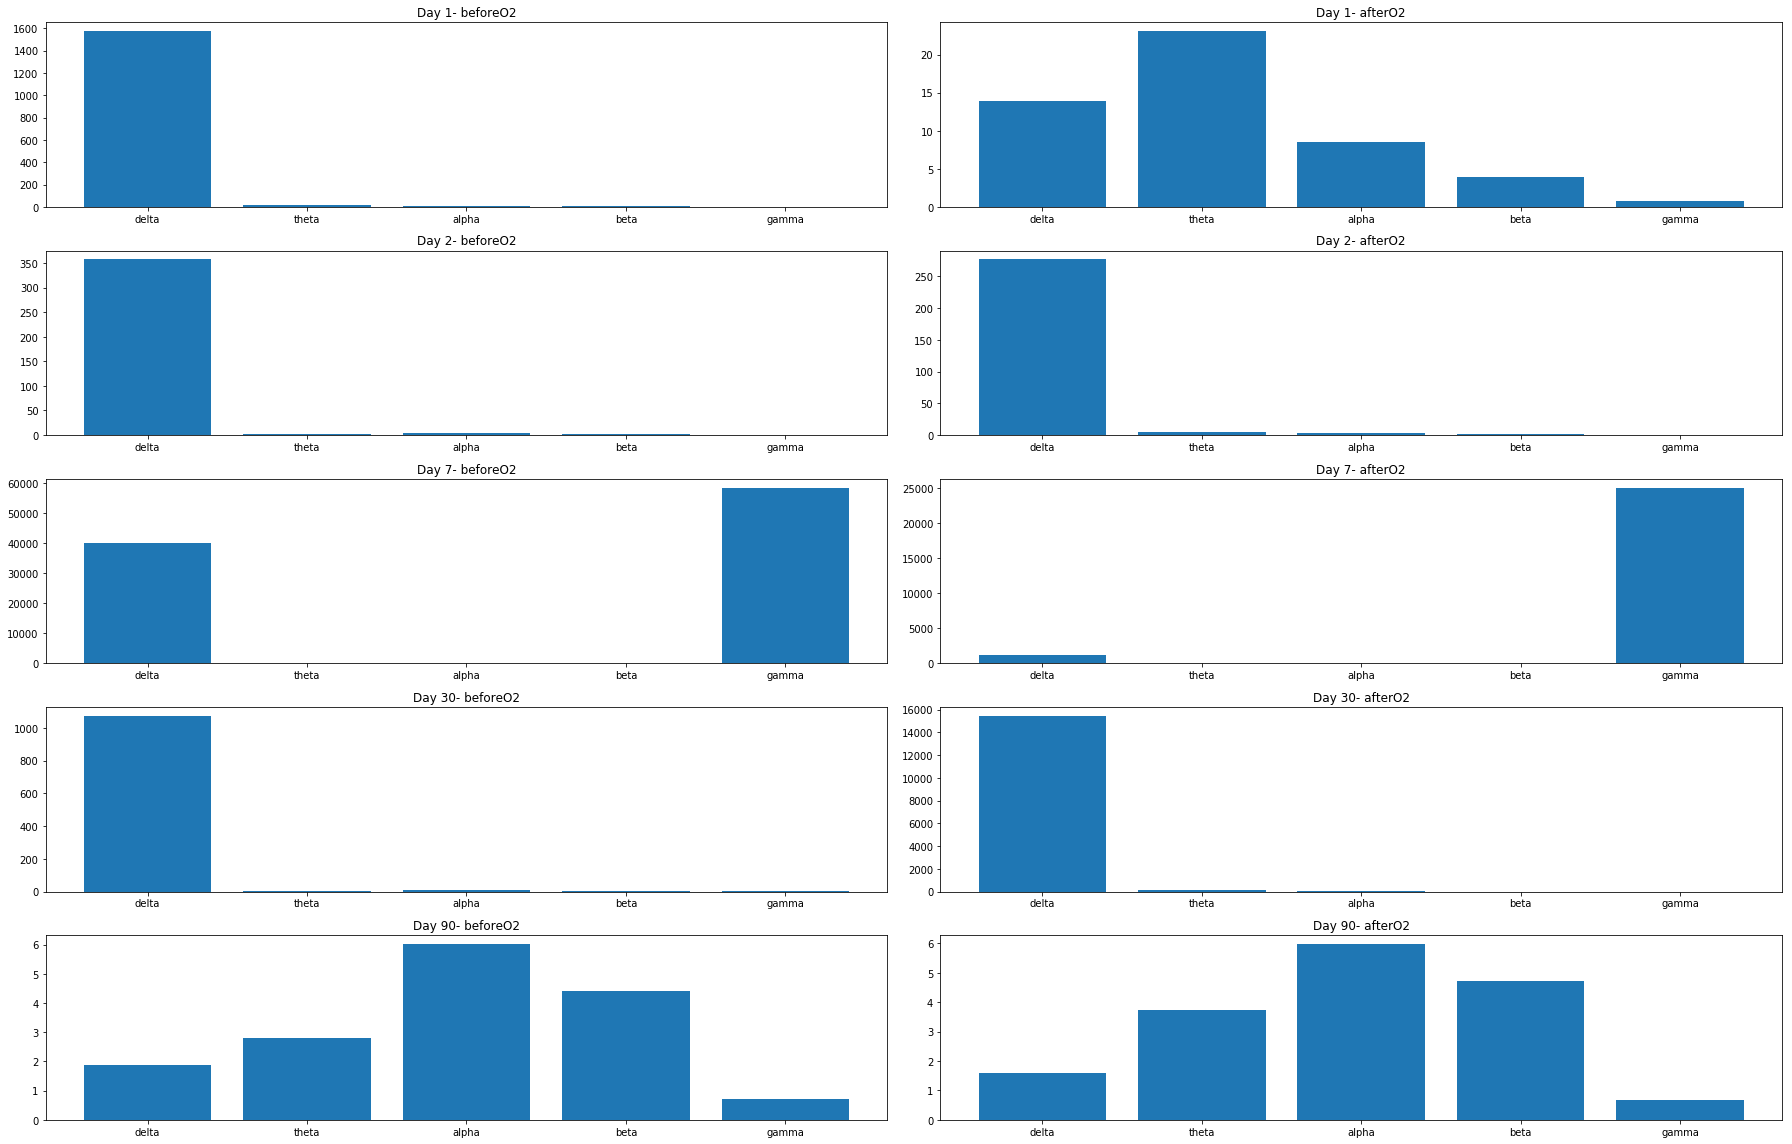

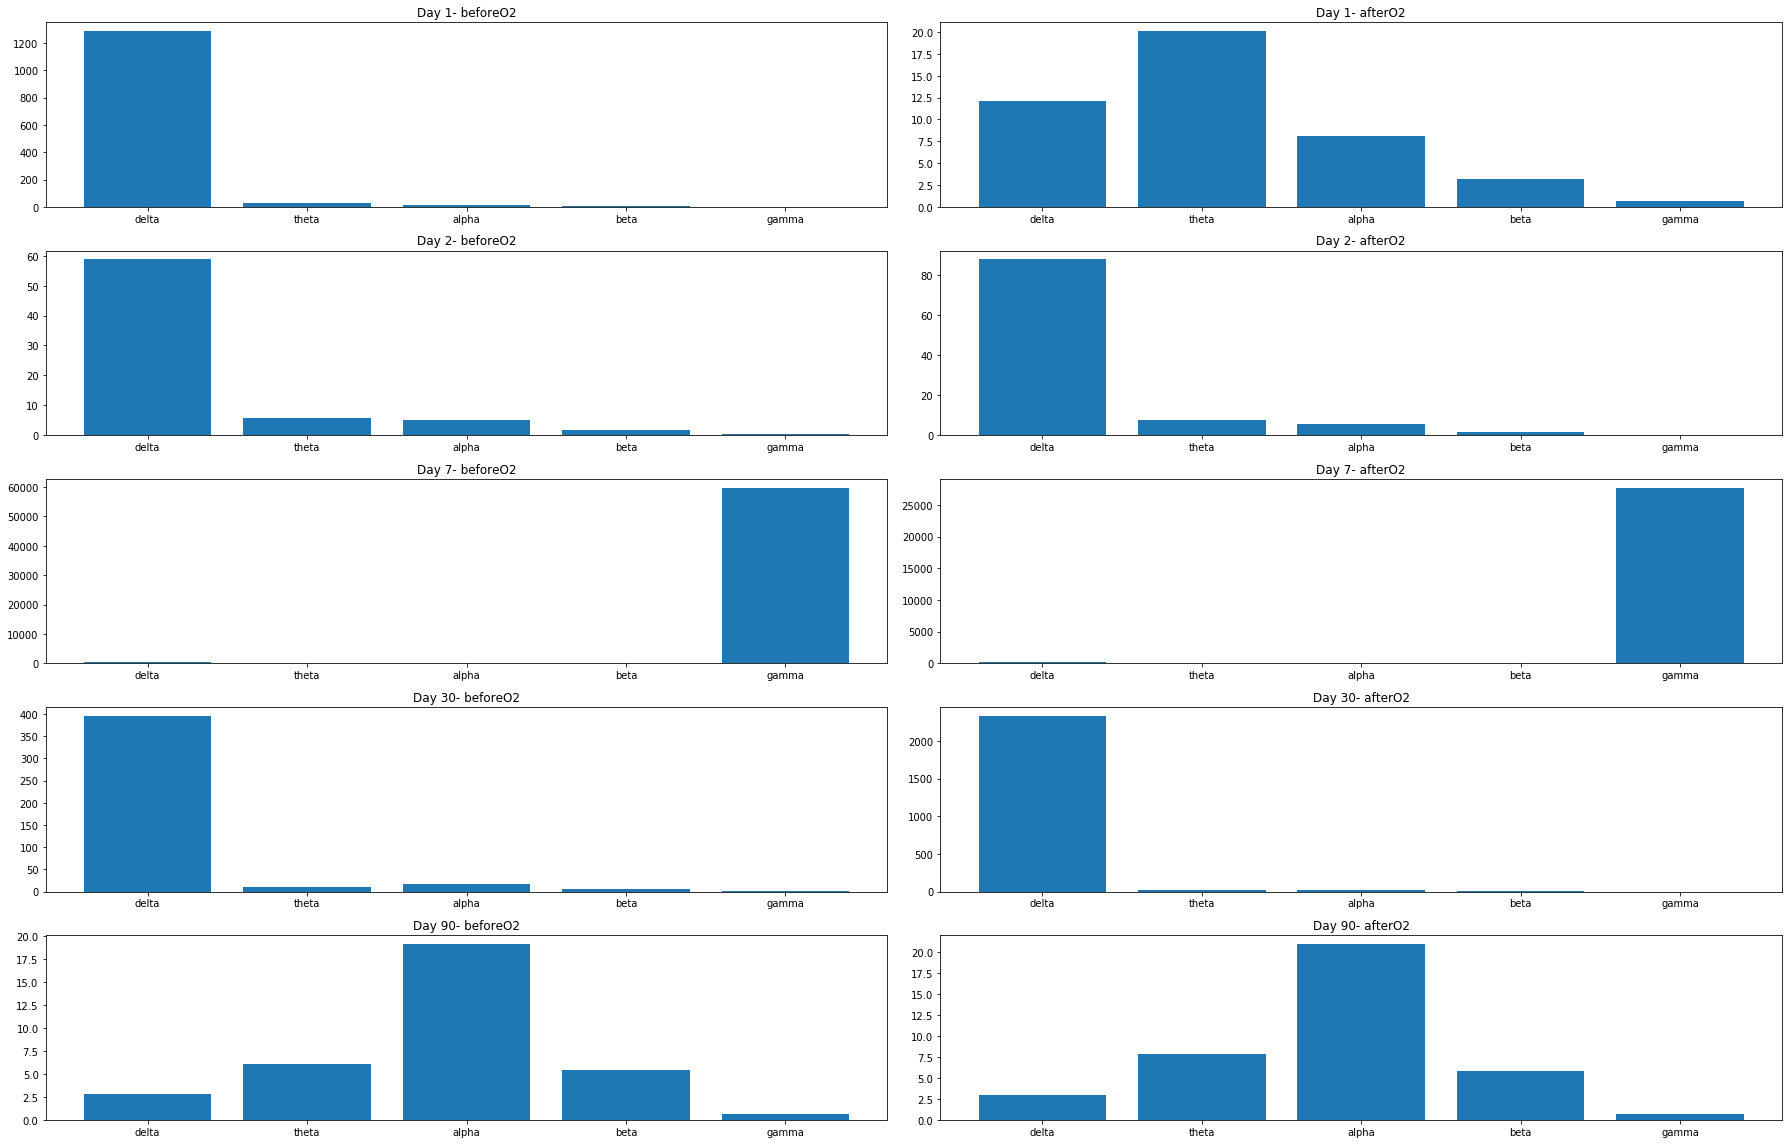

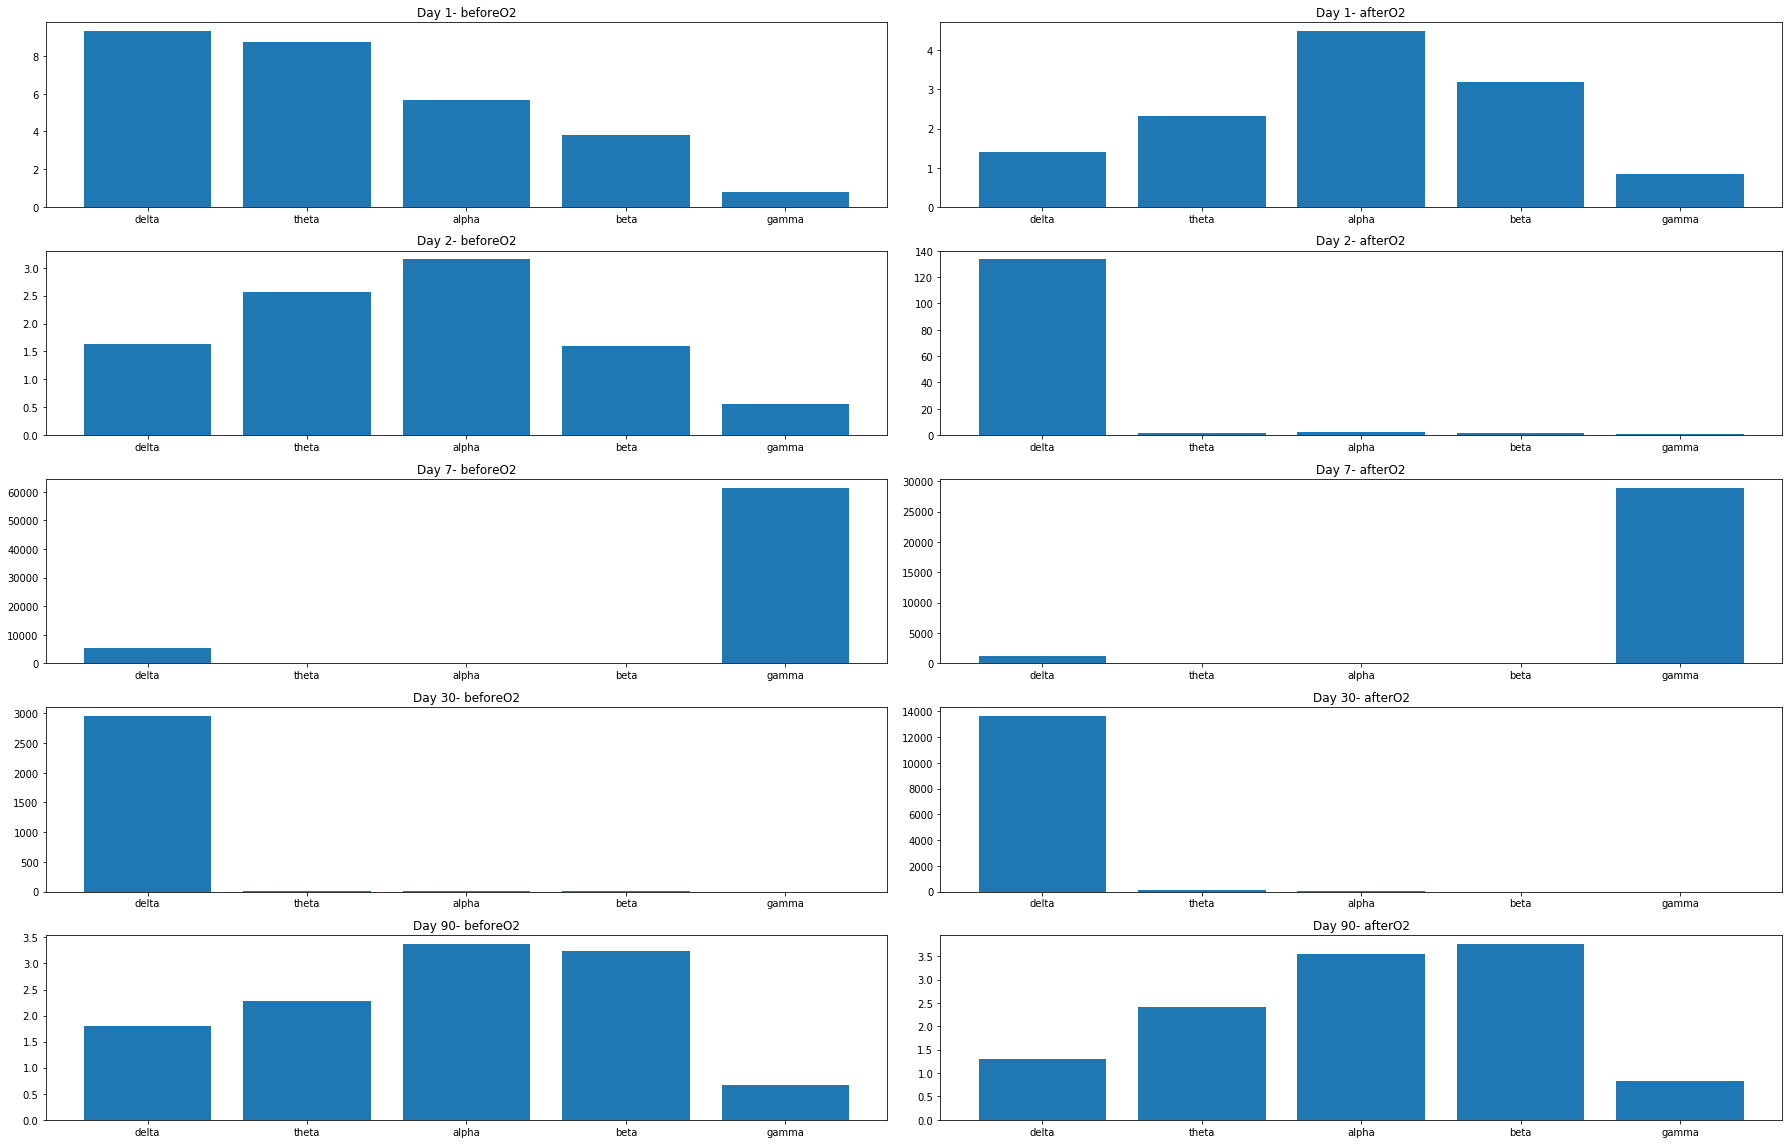

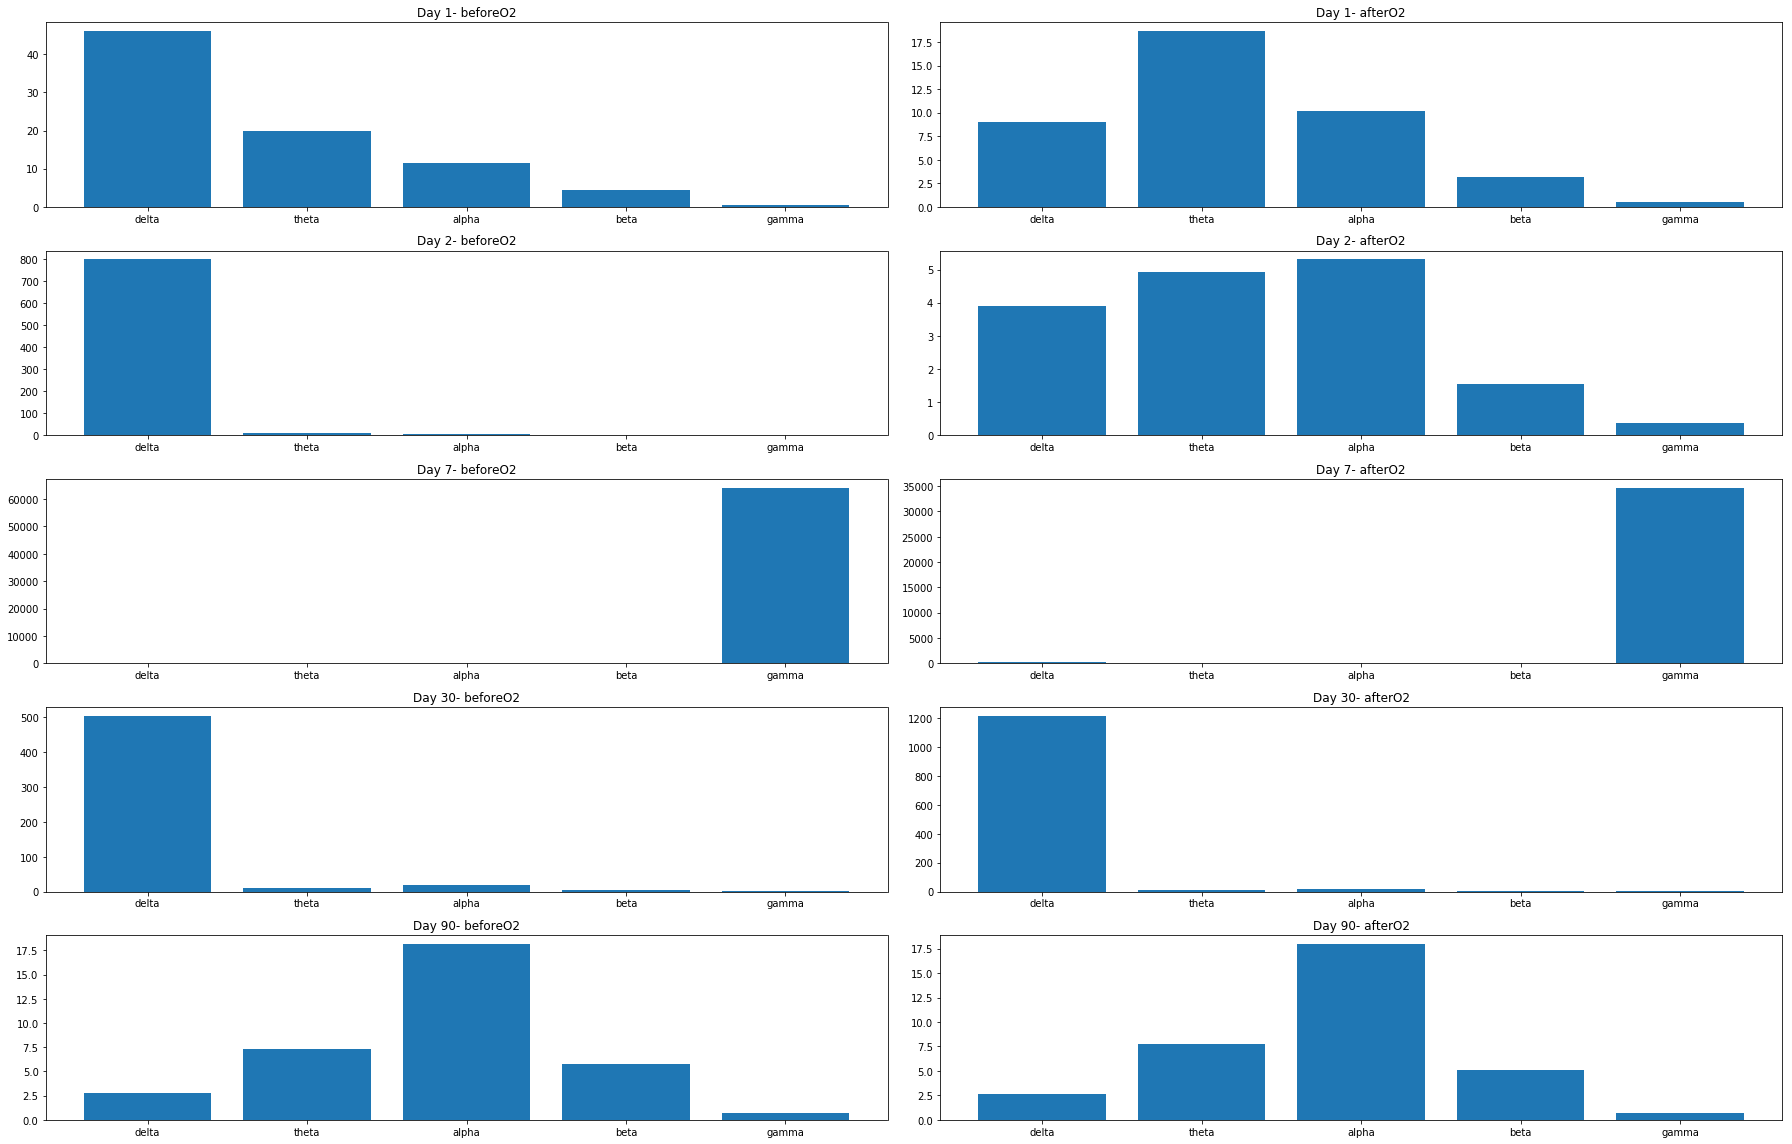

In [12]:
all_power=[]
for i in range(0, len(spr_channels)):
    powerr=subpower(efile, i)
    all_power.append(powerr)

In [13]:
np.save('D:\Imprint-CMCL-Data\koushik\patient_id_6\sub_band_power\\all_powers', all_power)